In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Fitting TESS data

In this tutorial, we will reproduce the fits to the transiting planet in the Pi Mensae system discovered by [Huang et al. (2018)](https://arxiv.org/abs/1809.05967).
The data processing and model are similar to the :ref:`together` tutorial, but with a few extra bits like aperture selection and de-trending.

To start, we need to download the target pixel file:

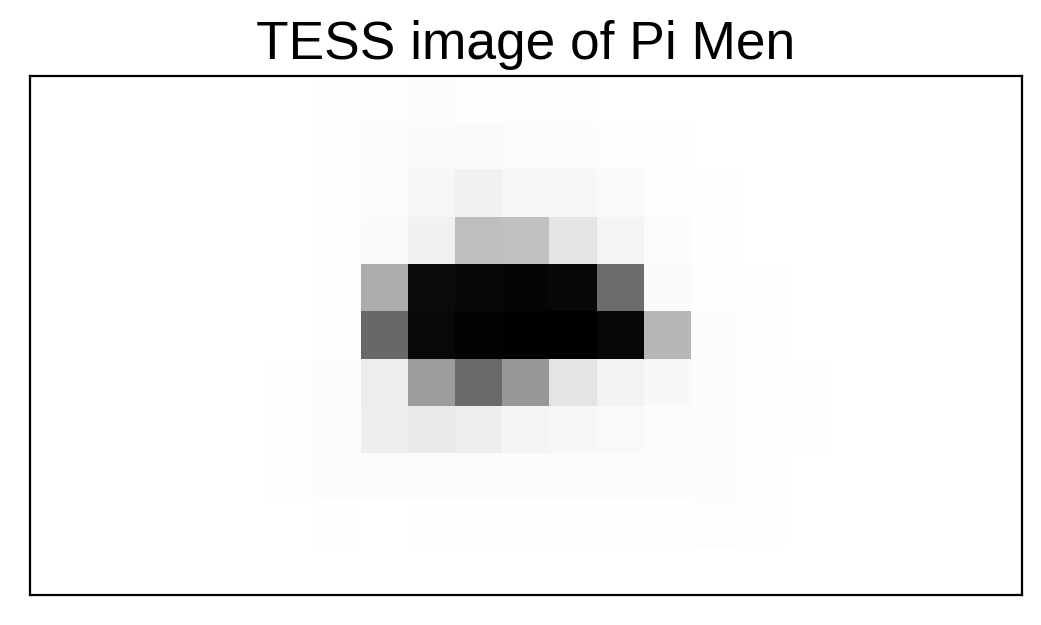

In [3]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt

tpf_file = lk.search_targetpixelfile("TIC 261136679", sector=1).download()
with tpf_file.hdu as hdu:
    tpf = hdu[1].data
    tpf_hdr = hdu[1].header

texp = tpf_hdr["FRAMETIM"] * tpf_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
time = tpf["TIME"]
flux = tpf["FLUX"]
m = np.any(np.isfinite(flux), axis=(1, 2)) & (tpf["QUALITY"] == 0)
ref_time = 0.5 * (np.min(time[m]) + np.max(time[m]))
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)

mean_img = np.median(flux, axis=0)
plt.imshow(mean_img.T, cmap="gray_r")
plt.title("TESS image of Pi Men")
plt.xticks([])
plt.yticks([]);

## Aperture selection

Next, we'll select an aperture using a hacky method that tries to minimizes the windowed scatter in the lightcurve (something like the CDPP).

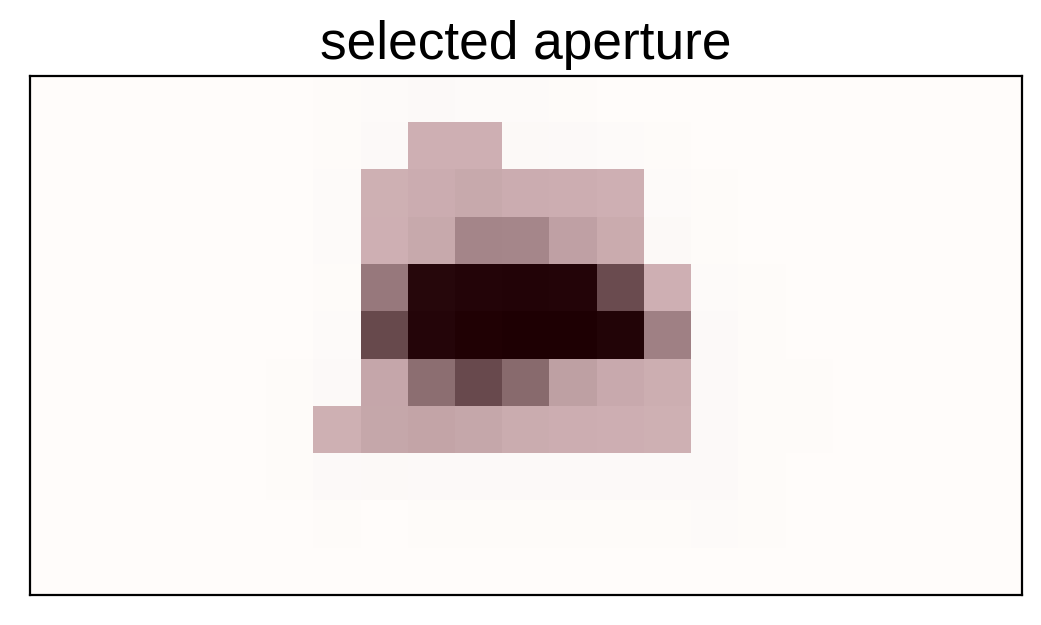

In [4]:
from scipy.signal import savgol_filter

# Sort the pixels by median brightness
order = np.argsort(mean_img.flatten())[::-1]

# A function to estimate the windowed scatter in a lightcurve
def estimate_scatter_with_mask(mask):
    f = np.sum(flux[:, mask], axis=-1)
    smooth = savgol_filter(f, 1001, polyorder=5)
    return 1e6 * np.sqrt(np.median((f / smooth - 1) ** 2))


# Loop over pixels ordered by brightness and add them one-by-one
# to the aperture
masks, scatters = [], []
for i in range(10, 100):
    msk = np.zeros_like(mean_img, dtype=bool)
    msk[np.unravel_index(order[:i], mean_img.shape)] = True
    scatter = estimate_scatter_with_mask(msk)
    masks.append(msk)
    scatters.append(scatter)

# Choose the aperture that minimizes the scatter
pix_mask = masks[np.argmin(scatters)]

# Plot the selected aperture
plt.imshow(mean_img.T, cmap="gray_r")
plt.imshow(pix_mask.T, cmap="Reds", alpha=0.3)
plt.title("selected aperture")
plt.xticks([])
plt.yticks([]);

This aperture produces the following light curve:

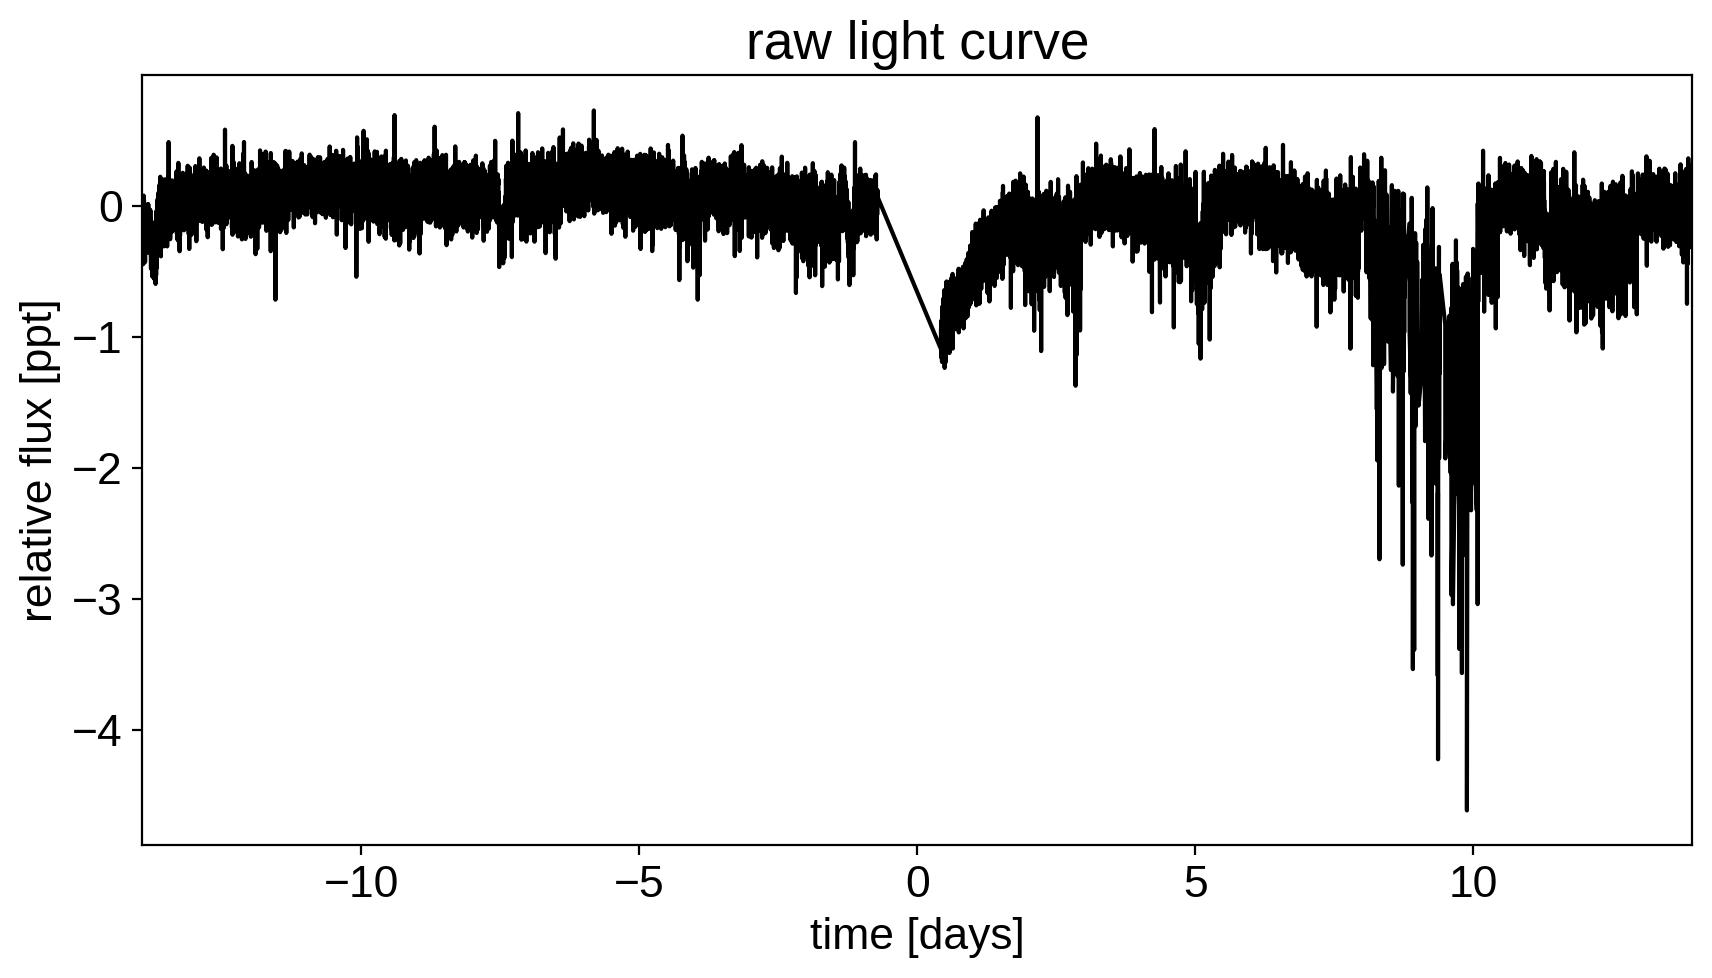

In [5]:
plt.figure(figsize=(10, 5))
sap_flux = np.sum(flux[:, pix_mask], axis=-1)
sap_flux = (sap_flux / np.median(sap_flux) - 1) * 1e3
plt.plot(time, sap_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("raw light curve")
plt.xlim(time.min(), time.max());

## De-trending

This doesn't look terrible, but we're still going to want to de-trend it a little bit.
We'll use "pixel-level deconvolution" (PLD) to de-trend following the method used by [Everest](https://github.com/rodluger/everest).
Specifically, we'll use first order PLD plus the top few PCA components of the second order PLD basis.

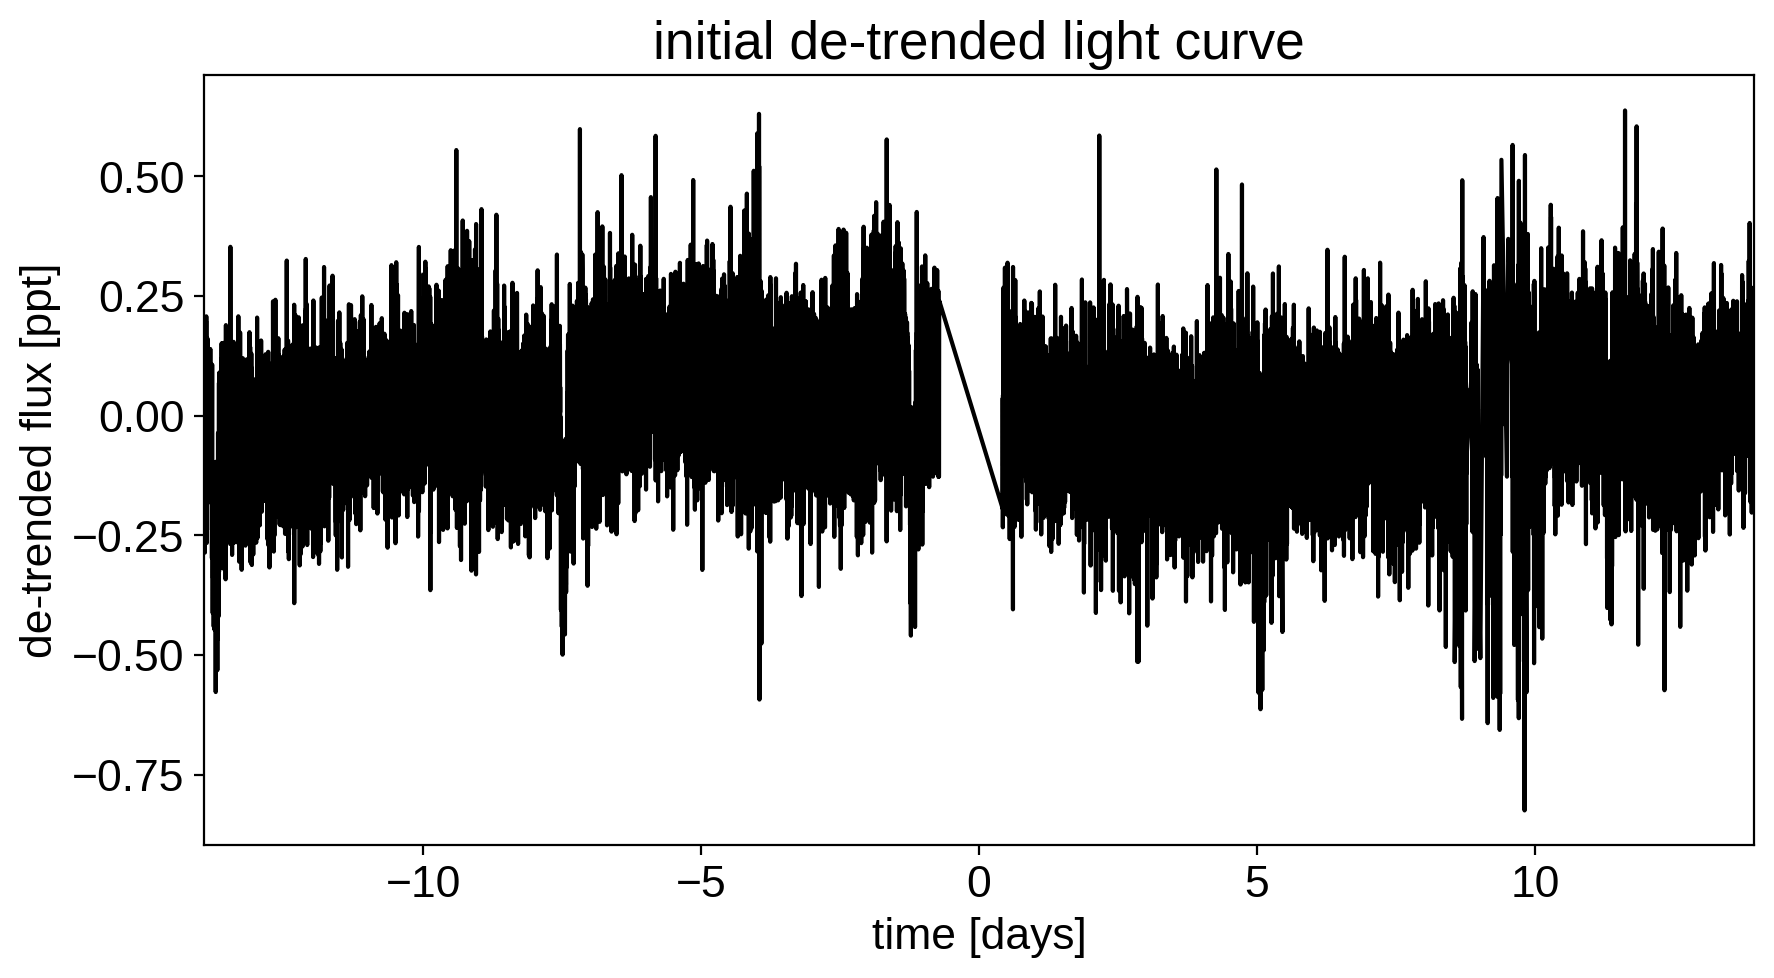

In [6]:
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, : X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, sap_flux))
pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(time, sap_flux - pld_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(time.min(), time.max());

That looks better.

## Transit search

Now, let's use [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/timeseries/bls.html)
(Note: you'll need AstroPy v3.1 or more recent to use this feature) to estimate the period, phase, and depth of the transit.

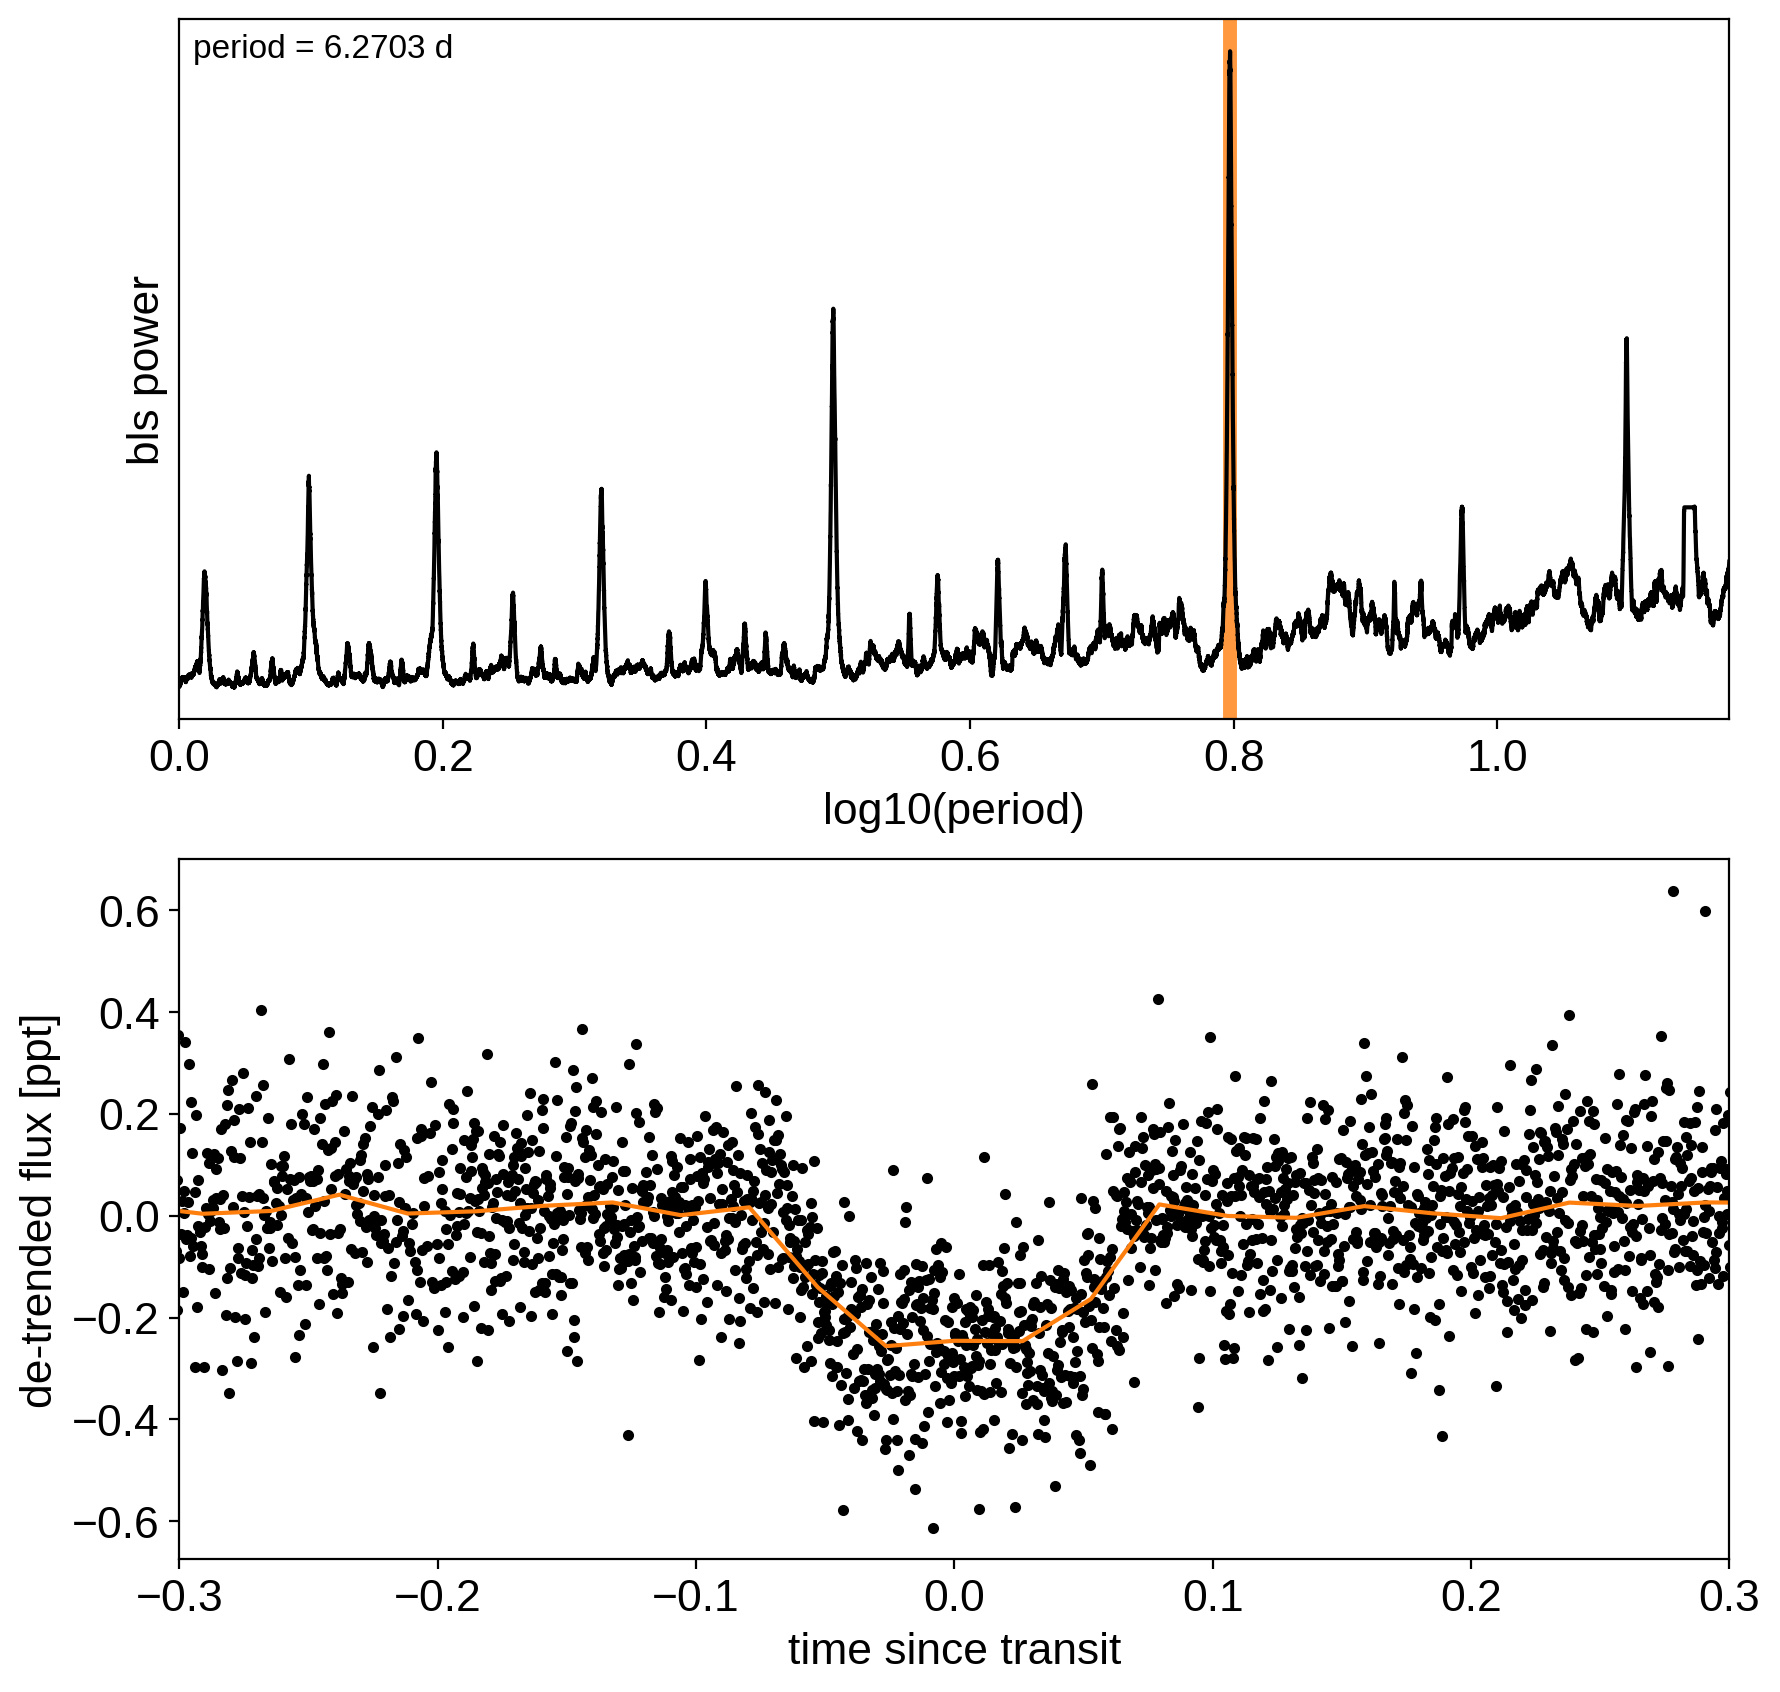

In [7]:
from astropy.timeseries import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(time, sap_flux - pld_flux)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate(
    "period = {0:.4f} d".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (time - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], sap_flux[m] - pld_flux[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=sap_flux - pld_flux)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
ax.set_xlabel("time since transit");

Now that we know where the transits are, it's generally good practice to de-trend the data one more time with the transits masked so that the de-trending doesn't overfit the transits.
Let's do that.

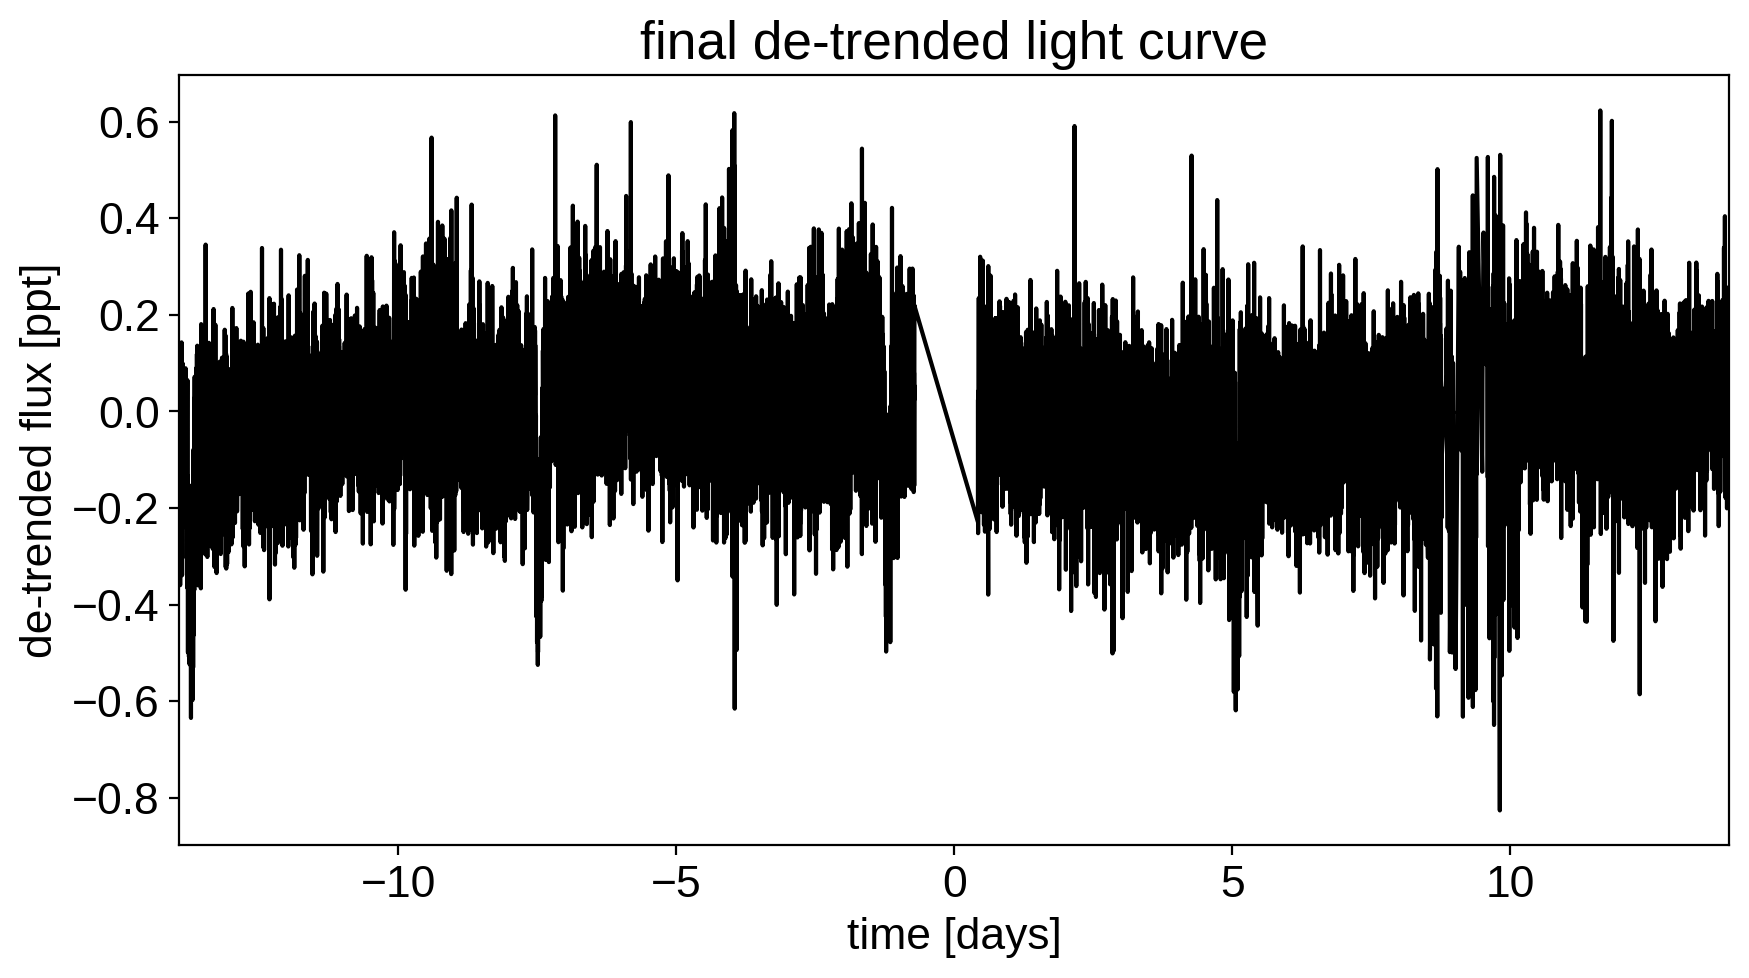

In [8]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, sap_flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(sap_flux - pld_flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(time, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(time.min(), time.max());

To confirm that we didn't overfit the transit, we can look at the folded light curve for the PLD model near trasit.
This shouldn't have any residual transit signal, and that looks correct here:

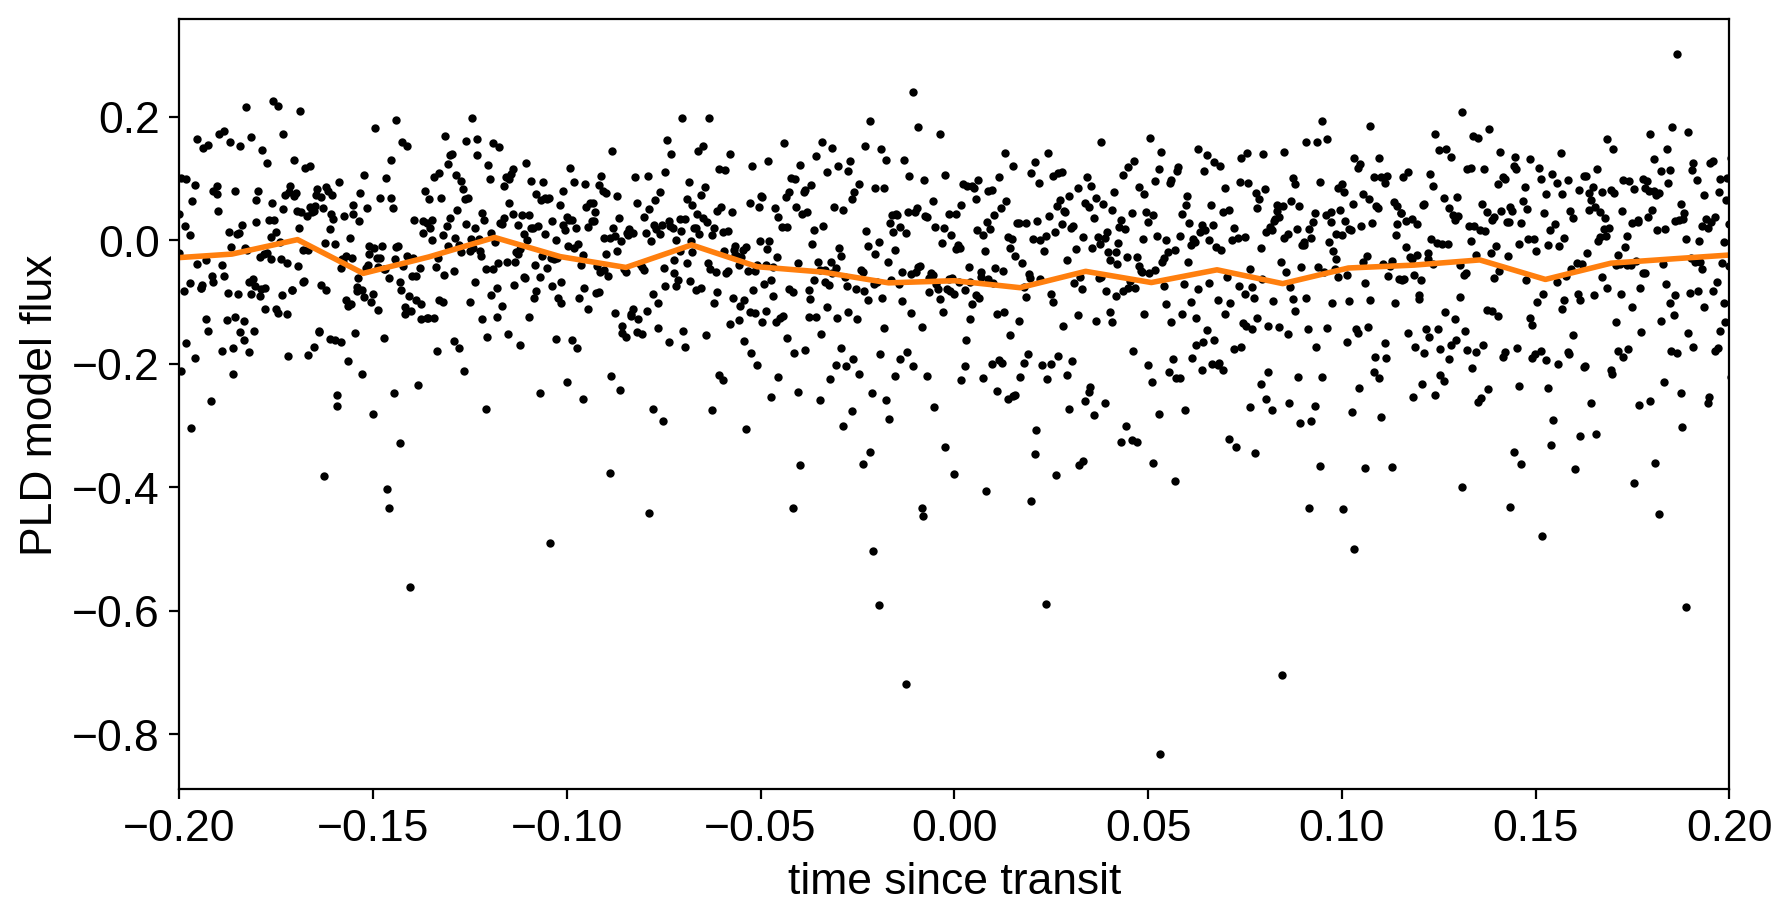

In [9]:
plt.figure(figsize=(10, 5))

x_fold = (x - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold) < 0.3
plt.plot(x_fold[m], pld_flux[m], ".k", ms=4)

bins = np.linspace(-0.5, 0.5, 60)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=pld_flux)
denom[num == 0] = 1.0
plt.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1", lw=2)
plt.xlim(-0.2, 0.2)
plt.xlabel("time since transit")
plt.ylabel("PLD model flux");

## The transit model in PyMC3

The transit model, initialization, and sampling are all nearly the same as the one in :ref:`together`.

In [10]:
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")

        # Stellar parameters from Huang et al (2018)
        M_star_huang = 1.094, 0.039
        R_star_huang = 1.10, 0.023
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_huang[0], sd=M_star_huang[1])
        r_star = BoundedNormal("r_star", mu=R_star_huang[0], sd=R_star_huang[1])

        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_period), sd=1)
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        logr = pm.Normal(
            "logr",
            sd=1.0,
            mu=0.5 * np.log(1e-3 * np.array(bls_depth)) + np.log(R_star_huang[0]),
        )
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = xo.distributions.ImpactParameter("b", ror=ror)

        ecs = xo.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.kipping13("ecc_prior", observed=ecc)

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0 = pm.Normal("logw0", mu=0, sd=10)
        logSw4 = pm.Normal("logSw4", mu=np.log(np.var(y[mask])), sd=10)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        def mean_model(t):
            # Compute the model light curve using starry
            light_curves = pm.Deterministic(
                "light_curves",
                xo.LimbDarkLightCurve(u_star).get_light_curve(
                    orbit=orbit, r=r_pl, t=t, texp=texp
                )
                * 1e3,
            )
            return tt.sum(light_curves, axis=-1) + mean

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
        gp = xo.gp.GP(
            kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), mean=mean_model
        )
        gp.marginal("gp", observed=y[mask])
        pm.Deterministic("gp_pred", gp.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[logs2, logSw4, logw0])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[u_star])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[ecc, omega])
        map_soln = xo.optimize(start=map_soln, vars=[mean])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logSw4, logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln


model0, map_soln0 = build_model()

optimizing logp for variables: [logw0, logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.240522e+04]

1it [00:00, 44.46it/s, logp=1.240522e+04]

2it [00:00, 63.77it/s, logp=1.240522e+04]

3it [00:00, 73.15it/s, logp=8.840689e+03]

4it [00:00, 79.97it/s, logp=1.259590e+04]

5it [00:00, 84.43it/s, logp=1.122566e+04]

6it [00:00, 82.94it/s, logp=1.261191e+04]

7it [00:00, 84.49it/s, logp=1.263092e+04]

8it [00:00, 86.92it/s, logp=1.241150e+04]

9it [00:00, 88.73it/s, logp=1.263825e+04]

10it [00:00, 97.80it/s, logp=1.263825e+04]

10it [00:00, 97.80it/s, logp=1.263827e+04]

11it [00:00, 97.80it/s, logp=1.264031e+04]

12it [00:00, 97.80it/s, logp=1.264091e+04]

13it [00:00, 97.80it/s, logp=1.264106e+04]

14it [00:00, 97.80it/s, logp=1.264106e+04]

15it [00:00, 97.80it/s, logp=1.264106e+04]

16it [00:00, 97.80it/s, logp=1.264106e+04]

17it [00:00, 97.80it/s, logp=1.264106e+04]

18it [00:00, 97.80it/s, logp=1.264106e+04]

19it [00:00, 97.80it/s, logp=1.264106e+04]

20it [00:00, 97.80it/s, logp=1.264106e+04]

21it [00:00, 99.86it/s, logp=1.264106e+04]

21it [00:00, 99.86it/s, logp=1.264106e+04]

22it [00:00, 99.86it/s, logp=1.264106e+04]

23it [00:00, 99.86it/s, logp=1.264106e+04]

24it [00:00, 99.86it/s, logp=1.264106e+04]

25it [00:00, 99.86it/s, logp=1.264106e+04]

26it [00:00, 99.86it/s, logp=1.264106e+04]

27it [00:00, 99.86it/s, logp=1.264106e+04]

28it [00:00, 99.86it/s, logp=1.264106e+04]

29it [00:00, 99.86it/s, logp=1.264106e+04]

30it [00:00, 96.58it/s, logp=1.264106e+04]

30it [00:00, 96.58it/s, logp=1.264106e+04]

31it [00:00, 96.58it/s, logp=1.264106e+04]

32it [00:00, 96.58it/s, logp=1.264106e+04]

33it [00:00, 96.58it/s, logp=1.264106e+04]

34it [00:08,  3.79it/s, logp=1.264106e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 12405.224536471058 -> 12641.06206967105


optimizing logp for variables: [logr]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.264106e+04]

1it [00:00, 61.74it/s, logp=1.264106e+04]

2it [00:00, 86.87it/s, logp=1.264106e+04]

3it [00:00, 99.70it/s, logp=7.808314e+03]

4it [00:00, 108.83it/s, logp=1.267784e+04]

5it [00:00, 114.83it/s, logp=1.267829e+04]

6it [00:00, 119.19it/s, logp=1.267889e+04]

7it [00:00, 122.48it/s, logp=1.267895e+04]

8it [00:00, 125.08it/s, logp=1.267895e+04]

9it [00:00, 127.30it/s, logp=1.267895e+04]

10it [00:00, 129.06it/s, logp=1.267895e+04]

11it [00:00, 130.57it/s, logp=1.267895e+04]

12it [00:00, 131.92it/s, logp=1.267895e+04]

13it [00:00, 133.20it/s, logp=1.267895e+04]

14it [00:00, 134.36it/s, logp=1.267895e+04]

15it [00:00, 143.45it/s, logp=1.267895e+04]

15it [00:00, 143.45it/s, logp=1.267895e+04]

16it [00:00, 143.45it/s, logp=1.267895e+04]

17it [00:00, 143.45it/s, logp=1.267895e+04]

18it [00:00, 143.45it/s, logp=1.267895e+04]

19it [00:00, 143.45it/s, logp=1.267895e+04]

20it [00:00, 143.45it/s, logp=1.267895e+04]

21it [00:00, 143.45it/s, logp=1.267895e+04]

22it [00:00, 143.45it/s, logp=1.267895e+04]

23it [00:00, 143.45it/s, logp=1.267895e+04]

24it [00:00, 143.45it/s, logp=1.267895e+04]

25it [00:00, 143.45it/s, logp=1.267895e+04]

26it [00:00, 143.45it/s, logp=1.267895e+04]

27it [00:00, 143.45it/s, logp=1.267895e+04]

28it [00:00, 143.45it/s, logp=1.267895e+04]

29it [00:00, 143.45it/s, logp=1.267895e+04]

30it [00:00, 143.17it/s, logp=1.267895e+04]

30it [00:00, 143.17it/s, logp=1.267895e+04]

31it [00:00, 143.17it/s, logp=1.267895e+04]

32it [00:00, 143.17it/s, logp=1.267895e+04]

33it [00:00, 143.17it/s, logp=1.267895e+04]

34it [00:00, 143.17it/s, logp=1.267895e+04]

35it [00:00, 143.17it/s, logp=1.267895e+04]

36it [00:00, 143.17it/s, logp=1.267895e+04]

37it [00:00, 143.17it/s, logp=1.267895e+04]

38it [00:00, 143.17it/s, logp=1.267895e+04]

39it [00:00, 143.17it/s, logp=1.267895e+04]

40it [00:00, 143.17it/s, logp=1.267895e+04]

41it [00:00, 143.17it/s, logp=1.267895e+04]

42it [00:00, 134.17it/s, logp=1.267895e+04]

42it [00:00, 134.17it/s, logp=1.267895e+04]

43it [00:00, 134.17it/s, logp=1.267895e+04]

44it [00:00, 134.17it/s, logp=1.267895e+04]

45it [00:00, 134.17it/s, logp=1.267895e+04]

46it [00:00, 134.17it/s, logp=1.267895e+04]

47it [00:00, 134.17it/s, logp=1.267895e+04]

48it [00:00, 134.17it/s, logp=1.267895e+04]

49it [00:00, 134.17it/s, logp=1.267895e+04]

50it [00:00, 134.17it/s, logp=1.267895e+04]

51it [00:00, 134.17it/s, logp=1.267895e+04]

52it [00:00, 134.17it/s, logp=1.267895e+04]

53it [00:00, 134.17it/s, logp=1.267895e+04]

54it [00:00, 134.17it/s, logp=1.267895e+04]

55it [00:00, 134.17it/s, logp=1.267895e+04]

56it [00:00, 135.26it/s, logp=1.267895e+04]

56it [00:00, 135.26it/s, logp=1.267895e+04]

57it [00:00, 135.26it/s, logp=1.267895e+04]

58it [00:00, 135.26it/s, logp=1.267895e+04]

59it [00:00, 135.26it/s, logp=1.267895e+04]

60it [00:00, 135.26it/s, logp=1.267895e+04]

61it [00:00, 135.26it/s, logp=1.267895e+04]

62it [00:00, 135.26it/s, logp=1.267895e+04]

63it [00:00, 135.26it/s, logp=1.267895e+04]

64it [00:00, 135.26it/s, logp=1.267895e+04]

65it [00:00, 135.26it/s, logp=1.267895e+04]

66it [00:00, 135.26it/s, logp=1.267895e+04]

67it [00:00, 135.26it/s, logp=1.267895e+04]

68it [00:00, 135.26it/s, logp=1.267895e+04]

69it [00:00, 135.26it/s, logp=1.267895e+04]

70it [00:00, 136.62it/s, logp=1.267895e+04]

70it [00:00, 136.62it/s, logp=1.267895e+04]

71it [00:00, 136.62it/s, logp=1.267895e+04]

72it [00:00, 136.62it/s, logp=1.267895e+04]

73it [00:00, 136.62it/s, logp=1.267895e+04]

74it [00:00, 136.62it/s, logp=1.267895e+04]

75it [00:00, 136.62it/s, logp=1.267895e+04]

76it [00:00, 136.62it/s, logp=1.267895e+04]

77it [00:00, 136.62it/s, logp=1.267895e+04]

78it [00:00, 136.62it/s, logp=1.267895e+04]

79it [00:00, 136.62it/s, logp=1.267895e+04]

80it [00:00, 136.62it/s, logp=1.267895e+04]

81it [00:00, 136.62it/s, logp=1.267895e+04]

82it [00:00, 123.38it/s, logp=1.267895e+04]

82it [00:00, 123.38it/s, logp=1.267895e+04]

83it [00:00, 123.38it/s, logp=1.267895e+04]

84it [00:00, 123.38it/s, logp=1.267895e+04]

85it [00:00, 123.38it/s, logp=1.267895e+04]

86it [00:00, 123.38it/s, logp=1.267895e+04]

87it [00:00, 123.38it/s, logp=1.267895e+04]

88it [00:00, 123.38it/s, logp=1.267895e+04]

89it [00:00, 123.38it/s, logp=1.267895e+04]

90it [00:00, 123.38it/s, logp=1.267895e+04]

91it [00:00, 123.38it/s, logp=1.267895e+04]

92it [00:00, 123.38it/s, logp=1.267895e+04]

93it [00:00, 123.38it/s, logp=1.267895e+04]

94it [00:00, 119.98it/s, logp=1.267895e+04]

94it [00:00, 119.98it/s, logp=1.267895e+04]

95it [00:00, 119.98it/s, logp=1.267895e+04]

96it [00:00, 119.98it/s, logp=1.267895e+04]

97it [00:00, 119.98it/s, logp=1.267895e+04]

98it [00:00, 119.98it/s, logp=1.267895e+04]

99it [00:00, 119.98it/s, logp=1.267895e+04]

100it [00:00, 119.98it/s, logp=1.267895e+04]

101it [00:00, 119.98it/s, logp=1.267895e+04]

102it [00:00, 119.98it/s, logp=1.267895e+04]

103it [00:00, 119.98it/s, logp=1.267895e+04]

104it [00:00, 119.98it/s, logp=1.267895e+04]

105it [00:00, 119.98it/s, logp=1.267895e+04]

106it [00:00, 119.98it/s, logp=1.267895e+04]

107it [00:00, 119.98it/s, logp=1.267895e+04]

108it [00:00, 125.35it/s, logp=1.267895e+04]

108it [00:00, 125.35it/s, logp=1.267895e+04]

109it [00:00, 125.35it/s, logp=1.267895e+04]

110it [00:00, 125.35it/s, logp=1.267895e+04]

111it [00:00, 125.35it/s, logp=1.267895e+04]

112it [00:00, 125.35it/s, logp=1.267895e+04]

113it [00:00, 125.35it/s, logp=1.267895e+04]

114it [00:00, 125.35it/s, logp=1.267895e+04]

115it [00:00, 125.35it/s, logp=1.267895e+04]

116it [00:00, 125.35it/s, logp=1.267895e+04]

117it [00:00, 125.35it/s, logp=1.267895e+04]

118it [00:00, 125.35it/s, logp=1.267895e+04]

119it [00:00, 125.35it/s, logp=1.267895e+04]

120it [00:00, 125.35it/s, logp=1.267895e+04]

121it [00:00, 125.35it/s, logp=1.267895e+04]

122it [00:00, 125.35it/s, logp=1.267895e+04]

123it [00:00, 129.85it/s, logp=1.267895e+04]

123it [00:00, 129.85it/s, logp=1.267895e+04]

124it [00:00, 129.85it/s, logp=1.267895e+04]

125it [00:00, 129.85it/s, logp=1.267895e+04]

126it [00:00, 129.85it/s, logp=1.267895e+04]

127it [00:00, 129.85it/s, logp=1.267895e+04]

128it [00:00, 129.85it/s, logp=1.267895e+04]

129it [00:00, 129.85it/s, logp=1.267895e+04]

130it [00:01, 129.85it/s, logp=1.267895e+04]

131it [00:01, 129.85it/s, logp=1.267895e+04]

132it [00:01, 129.85it/s, logp=1.267895e+04]

133it [00:01, 129.85it/s, logp=1.267895e+04]

134it [00:01, 129.85it/s, logp=1.267895e+04]

135it [00:01, 129.85it/s, logp=1.267895e+04]

136it [00:01, 129.85it/s, logp=1.267895e+04]

137it [00:01, 129.85it/s, logp=1.267895e+04]

138it [00:01, 133.07it/s, logp=1.267895e+04]

138it [00:01, 133.07it/s, logp=1.267895e+04]

139it [00:01, 133.07it/s, logp=1.267895e+04]

140it [00:01, 133.07it/s, logp=1.267895e+04]

141it [00:01, 133.07it/s, logp=1.267895e+04]

142it [00:01, 133.07it/s, logp=1.267895e+04]

143it [00:01, 133.07it/s, logp=1.267895e+04]

144it [00:01, 133.07it/s, logp=1.267895e+04]

145it [00:01, 133.07it/s, logp=1.267895e+04]

146it [00:01, 133.07it/s, logp=1.267895e+04]

147it [00:01, 133.07it/s, logp=1.267895e+04]

148it [00:01, 133.07it/s, logp=1.267895e+04]

149it [00:01, 133.07it/s, logp=1.267895e+04]

150it [00:01, 133.07it/s, logp=1.267895e+04]

151it [00:01, 133.07it/s, logp=1.267895e+04]

152it [00:01, 134.75it/s, logp=1.267895e+04]

152it [00:01, 134.75it/s, logp=1.267895e+04]

153it [00:01, 134.75it/s, logp=1.267895e+04]

154it [00:01, 134.75it/s, logp=1.267895e+04]

155it [00:01, 134.75it/s, logp=1.267895e+04]

156it [00:01, 134.75it/s, logp=1.267895e+04]

157it [00:01, 134.75it/s, logp=1.267895e+04]

158it [00:01, 134.75it/s, logp=1.267895e+04]

159it [00:01, 134.75it/s, logp=1.267895e+04]

160it [00:01, 134.75it/s, logp=1.267895e+04]

161it [00:01, 134.75it/s, logp=1.267895e+04]

162it [00:01, 134.75it/s, logp=1.267895e+04]

163it [00:01, 134.75it/s, logp=1.267895e+04]

164it [00:01, 134.75it/s, logp=1.267895e+04]

165it [00:01, 134.75it/s, logp=1.267895e+04]

166it [00:01, 134.75it/s, logp=1.267895e+04]

167it [00:01, 137.10it/s, logp=1.267895e+04]

167it [00:01, 137.10it/s, logp=1.267895e+04]

168it [00:01, 137.10it/s, logp=1.267895e+04]

169it [00:01, 137.10it/s, logp=1.267895e+04]

170it [00:01, 137.10it/s, logp=1.267895e+04]

171it [00:01, 137.10it/s, logp=1.267895e+04]

172it [00:01, 137.10it/s, logp=1.267895e+04]

173it [00:01, 137.10it/s, logp=1.267895e+04]

174it [00:01, 137.10it/s, logp=1.267895e+04]

175it [00:01, 137.10it/s, logp=1.267895e+04]

176it [00:01, 137.10it/s, logp=1.267895e+04]

177it [00:01, 137.10it/s, logp=1.267895e+04]

178it [00:01, 137.10it/s, logp=1.267895e+04]

179it [00:01, 137.10it/s, logp=1.267895e+04]

180it [00:01, 137.10it/s, logp=1.267895e+04]

181it [00:01, 137.10it/s, logp=1.267895e+04]

182it [00:01, 138.78it/s, logp=1.267895e+04]

182it [00:01, 138.78it/s, logp=1.267895e+04]

183it [00:01, 138.78it/s, logp=1.267895e+04]

184it [00:01, 138.78it/s, logp=1.267895e+04]

185it [00:01, 138.78it/s, logp=1.267895e+04]

186it [00:01, 138.78it/s, logp=1.267895e+04]

187it [00:01, 138.78it/s, logp=1.267895e+04]

188it [00:01, 138.78it/s, logp=1.267895e+04]

189it [00:01, 138.78it/s, logp=1.267895e+04]

190it [00:01, 138.78it/s, logp=1.267895e+04]

191it [00:01, 138.78it/s, logp=1.267895e+04]

192it [00:01, 138.78it/s, logp=1.267895e+04]

193it [00:01, 138.78it/s, logp=1.267895e+04]

194it [00:01, 138.78it/s, logp=1.267895e+04]

195it [00:01, 138.78it/s, logp=1.267895e+04]

196it [00:01, 138.78it/s, logp=1.267895e+04]

197it [00:01, 141.20it/s, logp=1.267895e+04]

197it [00:01, 141.20it/s, logp=1.267895e+04]

198it [00:01, 141.20it/s, logp=1.267895e+04]

199it [00:01, 141.20it/s, logp=1.267895e+04]

200it [00:01, 141.20it/s, logp=1.267895e+04]

201it [00:01, 141.20it/s, logp=1.267895e+04]

202it [00:01, 141.20it/s, logp=1.267895e+04]

203it [00:01, 141.20it/s, logp=1.267895e+04]

204it [00:01, 141.20it/s, logp=1.267895e+04]

205it [00:01, 141.20it/s, logp=1.267895e+04]

206it [00:01, 141.20it/s, logp=1.267895e+04]

207it [00:01, 141.20it/s, logp=1.267895e+04]

208it [00:01, 141.20it/s, logp=1.267895e+04]

209it [00:01, 141.20it/s, logp=1.267895e+04]

210it [00:01, 141.20it/s, logp=1.267895e+04]

211it [00:01, 141.20it/s, logp=1.267895e+04]

212it [00:01, 142.58it/s, logp=1.267895e+04]

212it [00:01, 142.58it/s, logp=1.267895e+04]

213it [00:01, 142.58it/s, logp=1.267895e+04]

214it [00:01, 142.58it/s, logp=1.267895e+04]

215it [00:01, 142.58it/s, logp=1.267895e+04]

216it [00:01, 142.58it/s, logp=1.267895e+04]

217it [00:01, 142.58it/s, logp=1.267895e+04]

218it [00:01, 142.58it/s, logp=1.267895e+04]

219it [00:01, 142.58it/s, logp=1.267895e+04]

220it [00:01, 142.58it/s, logp=1.267895e+04]

221it [00:01, 142.58it/s, logp=1.267895e+04]

222it [00:01, 142.58it/s, logp=1.267895e+04]

223it [00:01, 142.58it/s, logp=1.267895e+04]

224it [00:01, 142.58it/s, logp=1.267895e+04]

225it [00:01, 142.58it/s, logp=1.267895e+04]

226it [00:01, 142.58it/s, logp=1.267895e+04]

227it [00:01, 143.02it/s, logp=1.267895e+04]

227it [00:01, 143.02it/s, logp=1.267895e+04]

228it [00:01, 143.02it/s, logp=1.267895e+04]

229it [00:01, 143.02it/s, logp=1.267895e+04]

230it [00:01, 143.02it/s, logp=1.267895e+04]

231it [00:01, 143.02it/s, logp=1.267895e+04]

232it [00:01, 143.02it/s, logp=1.267895e+04]

233it [00:01, 143.02it/s, logp=1.267895e+04]

234it [00:01, 143.02it/s, logp=1.267895e+04]

235it [00:01, 143.02it/s, logp=1.267895e+04]

236it [00:01, 143.02it/s, logp=1.267895e+04]

237it [00:01, 143.02it/s, logp=1.267895e+04]

238it [00:01, 143.02it/s, logp=1.267895e+04]

239it [00:01, 143.02it/s, logp=1.267895e+04]

240it [00:01, 143.02it/s, logp=1.267895e+04]

241it [00:01, 143.02it/s, logp=1.267895e+04]

242it [00:01, 144.41it/s, logp=1.267895e+04]

242it [00:01, 144.41it/s, logp=1.267895e+04]

243it [00:01, 144.41it/s, logp=1.267895e+04]

244it [00:01, 144.41it/s, logp=1.267895e+04]

245it [00:01, 144.41it/s, logp=1.267895e+04]

246it [00:01, 144.41it/s, logp=1.267895e+04]

247it [00:01, 144.41it/s, logp=1.267895e+04]

248it [00:01, 144.41it/s, logp=1.267895e+04]

249it [00:01, 144.41it/s, logp=1.267895e+04]

250it [00:01, 144.41it/s, logp=1.267895e+04]

251it [00:01, 144.41it/s, logp=1.267895e+04]

252it [00:01, 144.41it/s, logp=1.267895e+04]

253it [00:01, 144.41it/s, logp=1.267895e+04]

254it [00:01, 144.41it/s, logp=1.267895e+04]

255it [00:01, 144.41it/s, logp=1.267895e+04]

256it [00:01, 144.41it/s, logp=1.267895e+04]

257it [00:01, 145.08it/s, logp=1.267895e+04]

257it [00:01, 145.08it/s, logp=1.267895e+04]

258it [00:01, 145.08it/s, logp=1.267895e+04]

259it [00:01, 145.08it/s, logp=1.267895e+04]

260it [00:01, 145.08it/s, logp=1.267895e+04]

261it [00:01, 145.08it/s, logp=1.267895e+04]

262it [00:01, 145.08it/s, logp=1.267895e+04]

263it [00:01, 145.08it/s, logp=1.267895e+04]

264it [00:03, 71.24it/s, logp=1.267895e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 12641.062069671045 -> 12678.952985094724


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.267895e+04]

1it [00:00, 57.11it/s, logp=1.267895e+04]

2it [00:00, 80.81it/s, logp=1.267895e+04]

3it [00:00, 95.11it/s, logp=1.102729e+04]

4it [00:00, 102.71it/s, logp=1.288322e+04]

5it [00:00, 106.22it/s, logp=1.281236e+04]

6it [00:00, 107.31it/s, logp=1.293824e+04]

7it [00:00, 112.09it/s, logp=1.226347e+04]

8it [00:00, 114.96it/s, logp=1.293837e+04]

9it [00:00, 116.93it/s, logp=1.293863e+04]

10it [00:00, 118.95it/s, logp=1.293964e+04]

11it [00:00, 119.93it/s, logp=1.294319e+04]

12it [00:00, 120.81it/s, logp=1.294965e+04]

13it [00:00, 129.71it/s, logp=1.294965e+04]

13it [00:00, 129.71it/s, logp=1.295034e+04]

14it [00:00, 129.71it/s, logp=1.295045e+04]

15it [00:00, 129.71it/s, logp=1.295053e+04]

16it [00:00, 129.71it/s, logp=1.295053e+04]

17it [00:00, 129.71it/s, logp=1.295053e+04]

18it [00:00, 129.71it/s, logp=1.295053e+04]

19it [00:00, 129.71it/s, logp=1.295053e+04]

20it [00:00, 129.71it/s, logp=1.295053e+04]

21it [00:00, 129.71it/s, logp=1.295053e+04]

22it [00:00, 129.71it/s, logp=1.295053e+04]

23it [00:00, 129.71it/s, logp=1.295053e+04]

24it [00:00, 129.71it/s, logp=1.295053e+04]

25it [00:00, 129.71it/s, logp=1.295053e+04]

26it [00:00, 129.71it/s, logp=1.295053e+04]

27it [00:00, 130.04it/s, logp=1.295053e+04]

27it [00:00, 130.04it/s, logp=1.295053e+04]

28it [00:00, 130.04it/s, logp=1.295053e+04]

29it [00:00, 130.04it/s, logp=1.295053e+04]

30it [00:00, 130.04it/s, logp=1.295053e+04]

31it [00:00, 130.04it/s, logp=1.295053e+04]

32it [00:00, 130.04it/s, logp=1.295053e+04]

33it [00:00, 130.04it/s, logp=1.295053e+04]

34it [00:00, 130.04it/s, logp=1.295053e+04]

35it [00:00, 130.04it/s, logp=1.295053e+04]

36it [00:00, 130.04it/s, logp=1.295053e+04]

37it [00:00, 130.04it/s, logp=1.295053e+04]

38it [00:00, 130.04it/s, logp=1.295053e+04]

39it [00:00, 130.04it/s, logp=1.295053e+04]

40it [00:00, 127.20it/s, logp=1.295053e+04]

40it [00:00, 127.20it/s, logp=1.295053e+04]

41it [00:00, 127.20it/s, logp=1.295053e+04]

42it [00:00, 127.20it/s, logp=1.295053e+04]

43it [00:00, 127.20it/s, logp=1.295053e+04]

44it [00:00, 127.20it/s, logp=1.295053e+04]

45it [00:00, 127.20it/s, logp=1.295053e+04]

46it [00:00, 127.20it/s, logp=1.295053e+04]

47it [00:00, 127.20it/s, logp=1.295053e+04]

48it [00:00, 127.20it/s, logp=1.295053e+04]

49it [00:00, 127.20it/s, logp=1.295053e+04]

50it [00:00, 127.20it/s, logp=1.295053e+04]

51it [00:00, 121.20it/s, logp=1.295053e+04]

51it [00:00, 121.20it/s, logp=1.295053e+04]

52it [00:00, 121.20it/s, logp=1.295053e+04]

53it [00:00, 121.20it/s, logp=1.295053e+04]

54it [00:00, 121.20it/s, logp=1.295053e+04]

55it [00:00, 121.20it/s, logp=1.295053e+04]

56it [00:00, 121.20it/s, logp=1.295053e+04]

57it [00:00, 121.20it/s, logp=1.295053e+04]

58it [00:00, 121.20it/s, logp=1.295053e+04]

59it [00:00, 121.20it/s, logp=1.295053e+04]

60it [00:00, 121.20it/s, logp=1.295053e+04]

61it [00:00, 121.20it/s, logp=1.295053e+04]

62it [00:00, 121.20it/s, logp=1.295053e+04]

63it [00:00, 121.20it/s, logp=1.295053e+04]

64it [00:00, 121.80it/s, logp=1.295053e+04]

64it [00:00, 121.80it/s, logp=1.295053e+04]

65it [00:00, 121.80it/s, logp=1.295053e+04]

66it [00:00, 121.80it/s, logp=1.295053e+04]

67it [00:00, 121.80it/s, logp=1.295053e+04]

68it [00:00, 121.80it/s, logp=1.295053e+04]

69it [00:00, 121.80it/s, logp=1.295053e+04]

70it [00:00, 121.80it/s, logp=1.295053e+04]

71it [00:00, 121.80it/s, logp=1.295053e+04]

72it [00:00, 121.80it/s, logp=1.295053e+04]

73it [00:00, 121.80it/s, logp=1.295053e+04]

74it [00:00, 121.80it/s, logp=1.295053e+04]

75it [00:00, 121.80it/s, logp=1.295053e+04]

76it [00:00, 121.80it/s, logp=1.295053e+04]

77it [00:00, 122.66it/s, logp=1.295053e+04]

77it [00:00, 122.66it/s, logp=1.295053e+04]

78it [00:00, 122.66it/s, logp=1.295053e+04]

79it [00:00, 122.66it/s, logp=1.295053e+04]

80it [00:00, 122.66it/s, logp=1.295053e+04]

81it [00:00, 122.66it/s, logp=1.295053e+04]

82it [00:00, 122.66it/s, logp=1.295053e+04]

83it [00:00, 122.66it/s, logp=1.295053e+04]

84it [00:02, 32.21it/s, logp=1.295053e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 12678.952985094724 -> 12950.529848063012


optimizing logp for variables: [t0, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.295053e+04]

1it [00:00, 46.20it/s, logp=1.295053e+04]

2it [00:00, 63.49it/s, logp=1.295053e+04]

3it [00:00, 69.27it/s, logp=1.166960e+04]

4it [00:00, 74.44it/s, logp=1.215590e+04]

5it [00:00, 78.44it/s, logp=1.229271e+04]

6it [00:00, 81.41it/s, logp=1.221263e+04]

7it [00:00, 83.43it/s, logp=1.276285e+04]

8it [00:00, 85.04it/s, logp=1.295251e+04]

9it [00:00, 86.35it/s, logp=1.295686e+04]

10it [00:00, 95.15it/s, logp=1.295686e+04]

10it [00:00, 95.15it/s, logp=1.296229e+04]

11it [00:00, 95.15it/s, logp=1.293834e+04]

12it [00:00, 95.15it/s, logp=1.296462e+04]

13it [00:00, 95.15it/s, logp=1.296473e+04]

14it [00:00, 95.15it/s, logp=1.296485e+04]

15it [00:00, 95.15it/s, logp=1.296485e+04]

16it [00:00, 95.15it/s, logp=1.296485e+04]

17it [00:00, 95.15it/s, logp=1.296485e+04]

18it [00:00, 95.15it/s, logp=1.296485e+04]

19it [00:00, 95.15it/s, logp=1.296485e+04]

20it [00:00, 95.93it/s, logp=1.296485e+04]

20it [00:00, 95.93it/s, logp=1.296485e+04]

21it [00:00, 95.93it/s, logp=1.296485e+04]

22it [00:02,  9.36it/s, logp=1.296485e+04]


message: Optimization terminated successfully.
logp: 12950.529848063008 -> 12964.849107164231


optimizing logp for variables: [u_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.296485e+04]

1it [00:00, 58.19it/s, logp=1.296485e+04]

2it [00:00, 72.16it/s, logp=1.296485e+04]

3it [00:00, 78.07it/s, logp=1.296577e+04]

4it [00:00, 80.97it/s, logp=1.296712e+04]

5it [00:00, 82.89it/s, logp=1.296761e+04]

6it [00:00, 84.73it/s, logp=1.296769e+04]

7it [00:00, 86.15it/s, logp=1.296772e+04]

8it [00:00, 86.91it/s, logp=1.296772e+04]

9it [00:00, 87.60it/s, logp=1.296772e+04]

10it [00:00, 96.62it/s, logp=1.296772e+04]

10it [00:00, 96.62it/s, logp=1.296772e+04]

11it [00:01,  5.70it/s, logp=1.296772e+04]


message: Optimization terminated successfully.
logp: 12964.849107164227 -> 12967.719850225458


optimizing logp for variables: [logr]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.296772e+04]

1it [00:00, 54.68it/s, logp=1.296772e+04]

2it [00:00, 70.54it/s, logp=1.296772e+04]

3it [00:00, 82.26it/s, logp=-5.497777e+03]

4it [00:00, 91.53it/s, logp=1.285709e+04] 

5it [00:00, 93.62it/s, logp=1.296789e+04]

6it [00:00, 98.20it/s, logp=1.296789e+04]

7it [00:00, 100.54it/s, logp=1.296789e+04]

8it [00:00, 104.11it/s, logp=1.296789e+04]

9it [00:01,  5.28it/s, logp=1.296789e+04] 


message: Optimization terminated successfully.
logp: 12967.719850225465 -> 12967.894818446483


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.296789e+04]

1it [00:00, 62.69it/s, logp=1.296789e+04]

2it [00:00, 85.10it/s, logp=1.296789e+04]

3it [00:00, 90.13it/s, logp=7.870220e+03]

4it [00:00, 91.84it/s, logp=1.295719e+04]

5it [00:00, 96.80it/s, logp=1.296800e+04]

6it [00:00, 100.00it/s, logp=1.296780e+04]

7it [00:00, 102.88it/s, logp=1.296802e+04]

8it [00:00, 105.86it/s, logp=1.296783e+04]

9it [00:00, 108.38it/s, logp=1.296803e+04]

10it [00:00, 109.62it/s, logp=1.296803e+04]

11it [00:00, 108.78it/s, logp=1.296803e+04]

12it [00:00, 117.68it/s, logp=1.296803e+04]

12it [00:00, 117.68it/s, logp=1.296803e+04]

13it [00:00, 117.68it/s, logp=1.296803e+04]

14it [00:00, 117.68it/s, logp=1.296803e+04]

15it [00:00, 117.68it/s, logp=1.296803e+04]

16it [00:00, 117.68it/s, logp=1.296803e+04]

17it [00:00, 117.68it/s, logp=1.296803e+04]

18it [00:00, 117.68it/s, logp=1.296803e+04]

19it [00:00, 117.68it/s, logp=1.296803e+04]

20it [00:00, 117.68it/s, logp=1.296803e+04]

21it [00:00, 117.68it/s, logp=1.296803e+04]

22it [00:00, 117.68it/s, logp=1.296803e+04]

23it [00:00, 114.94it/s, logp=1.296803e+04]

23it [00:00, 114.94it/s, logp=1.296803e+04]

24it [00:00, 114.94it/s, logp=1.296803e+04]

25it [00:00, 114.94it/s, logp=1.296803e+04]

26it [00:00, 114.94it/s, logp=1.296803e+04]

27it [00:00, 114.94it/s, logp=1.296803e+04]

28it [00:00, 114.94it/s, logp=1.296803e+04]

29it [00:00, 114.94it/s, logp=1.296803e+04]

30it [00:00, 114.94it/s, logp=1.296803e+04]

31it [00:00, 114.94it/s, logp=1.296803e+04]

32it [00:00, 114.94it/s, logp=1.296803e+04]

33it [00:00, 107.36it/s, logp=1.296803e+04]

33it [00:00, 107.36it/s, logp=1.296803e+04]

34it [00:00, 107.36it/s, logp=1.296803e+04]

35it [00:00, 107.36it/s, logp=1.296803e+04]

36it [00:00, 107.36it/s, logp=1.296803e+04]

37it [00:00, 107.36it/s, logp=1.296803e+04]

38it [00:00, 107.36it/s, logp=1.296803e+04]

39it [00:00, 107.36it/s, logp=1.296803e+04]

40it [00:00, 107.36it/s, logp=1.296803e+04]

41it [00:00, 107.36it/s, logp=1.296803e+04]

42it [00:00, 107.36it/s, logp=1.296803e+04]

43it [00:00, 107.36it/s, logp=1.296803e+04]

44it [00:00, 106.01it/s, logp=1.296803e+04]

44it [00:00, 106.01it/s, logp=1.296803e+04]

45it [00:00, 106.01it/s, logp=1.296803e+04]

46it [00:00, 106.01it/s, logp=1.296803e+04]

47it [00:00, 106.01it/s, logp=1.296803e+04]

48it [00:00, 106.01it/s, logp=1.296803e+04]

49it [00:00, 106.01it/s, logp=1.296803e+04]

50it [00:00, 106.01it/s, logp=1.296803e+04]

51it [00:00, 106.01it/s, logp=1.296803e+04]

52it [00:00, 106.01it/s, logp=1.296803e+04]

53it [00:00, 106.01it/s, logp=1.296803e+04]

54it [00:00, 103.43it/s, logp=1.296803e+04]

54it [00:00, 103.43it/s, logp=1.296803e+04]

55it [00:00, 103.43it/s, logp=1.296803e+04]

56it [00:00, 103.43it/s, logp=1.296803e+04]

57it [00:00, 103.43it/s, logp=1.296803e+04]

58it [00:00, 103.43it/s, logp=1.296803e+04]

59it [00:00, 103.43it/s, logp=1.296803e+04]

60it [00:00, 103.43it/s, logp=1.296803e+04]

61it [00:00, 103.43it/s, logp=1.296803e+04]

62it [00:00, 103.43it/s, logp=1.296803e+04]

63it [00:00, 103.43it/s, logp=1.296803e+04]

64it [00:00, 103.43it/s, logp=1.296803e+04]

65it [00:00, 103.39it/s, logp=1.296803e+04]

65it [00:00, 103.39it/s, logp=1.296803e+04]

66it [00:00, 103.39it/s, logp=1.296803e+04]

67it [00:00, 103.39it/s, logp=1.296803e+04]

68it [00:00, 103.39it/s, logp=1.296803e+04]

69it [00:00, 103.39it/s, logp=1.296803e+04]

70it [00:00, 103.39it/s, logp=1.296803e+04]

71it [00:00, 103.39it/s, logp=1.296803e+04]

72it [00:00, 103.39it/s, logp=1.296803e+04]

73it [00:00, 103.39it/s, logp=1.296803e+04]

74it [00:00, 103.39it/s, logp=1.296803e+04]

75it [00:00, 101.98it/s, logp=1.296803e+04]

75it [00:00, 101.98it/s, logp=1.296803e+04]

76it [00:00, 101.98it/s, logp=1.296803e+04]

77it [00:00, 101.98it/s, logp=1.296803e+04]

78it [00:00, 101.98it/s, logp=1.296803e+04]

79it [00:00, 101.98it/s, logp=1.296803e+04]

80it [00:00, 101.98it/s, logp=1.296803e+04]

81it [00:00, 101.98it/s, logp=1.296803e+04]

82it [00:00, 101.98it/s, logp=1.296803e+04]

83it [00:00, 101.98it/s, logp=1.296803e+04]

84it [00:00, 101.98it/s, logp=1.296803e+04]

85it [00:00, 101.98it/s, logp=1.296803e+04]

86it [00:00, 101.98it/s, logp=1.296803e+04]

87it [00:00, 106.32it/s, logp=1.296803e+04]

87it [00:00, 106.32it/s, logp=1.296803e+04]

88it [00:00, 106.32it/s, logp=1.296803e+04]

89it [00:00, 106.32it/s, logp=1.296803e+04]

90it [00:00, 106.32it/s, logp=1.296803e+04]

91it [00:00, 106.32it/s, logp=1.296803e+04]

92it [00:00, 106.32it/s, logp=1.296803e+04]

93it [00:00, 106.32it/s, logp=1.296803e+04]

94it [00:00, 106.32it/s, logp=1.296803e+04]

95it [00:00, 106.32it/s, logp=1.296803e+04]

96it [00:00, 106.32it/s, logp=1.296803e+04]

97it [00:00, 106.32it/s, logp=1.296803e+04]

98it [00:00, 106.32it/s, logp=1.296803e+04]

99it [00:00, 108.70it/s, logp=1.296803e+04]

99it [00:00, 108.70it/s, logp=1.296803e+04]

100it [00:00, 108.70it/s, logp=1.296803e+04]

101it [00:00, 108.70it/s, logp=1.296803e+04]

102it [00:00, 108.70it/s, logp=1.296803e+04]

103it [00:00, 108.70it/s, logp=1.296803e+04]

104it [00:00, 108.70it/s, logp=1.296803e+04]

105it [00:01, 108.70it/s, logp=1.296803e+04]

106it [00:01, 108.70it/s, logp=1.296803e+04]

107it [00:01, 108.70it/s, logp=1.296803e+04]

108it [00:01, 108.70it/s, logp=1.296803e+04]

109it [00:01, 108.70it/s, logp=1.296803e+04]

110it [00:01, 107.82it/s, logp=1.296803e+04]

110it [00:01, 107.82it/s, logp=1.296803e+04]

111it [00:01, 107.82it/s, logp=1.296803e+04]

112it [00:01, 107.82it/s, logp=1.296803e+04]

113it [00:01, 107.82it/s, logp=1.296803e+04]

114it [00:01, 107.82it/s, logp=1.296803e+04]

115it [00:01, 107.82it/s, logp=1.296803e+04]

116it [00:01, 107.82it/s, logp=1.296803e+04]

117it [00:02, 39.37it/s, logp=1.296803e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 12967.894818446483 -> 12968.027872730941


optimizing logp for variables: [ecs]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.296803e+04]

1it [00:00, 50.71it/s, logp=1.296803e+04]

2it [00:00, 73.56it/s, logp=1.296803e+04]

3it [00:00, 85.85it/s, logp=1.296563e+04]

4it [00:00, 94.19it/s, logp=1.296858e+04]

5it [00:00, 98.72it/s, logp=1.289806e+04]

6it [00:00, 103.17it/s, logp=1.296859e+04]

7it [00:00, 106.65it/s, logp=1.296859e+04]

8it [00:00, 107.41it/s, logp=1.296859e+04]

9it [00:00, 109.69it/s, logp=1.296860e+04]

10it [00:00, 111.55it/s, logp=1.296860e+04]

11it [00:00, 113.22it/s, logp=1.296860e+04]

12it [00:00, 114.26it/s, logp=1.296860e+04]

13it [00:00, 123.01it/s, logp=1.296860e+04]

13it [00:00, 123.01it/s, logp=1.296860e+04]

14it [00:00, 123.01it/s, logp=1.296860e+04]

15it [00:01,  8.47it/s, logp=1.296860e+04] 


message: Optimization terminated successfully.
logp: 12968.027872730941 -> 12968.59732823194


optimizing logp for variables: [mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.296860e+04]

1it [00:00, 51.59it/s, logp=1.296860e+04]

2it [00:00, 72.86it/s, logp=1.296860e+04]

3it [00:00, 86.20it/s, logp=2.443867e+03]

4it [00:00, 95.52it/s, logp=1.296863e+04]

5it [00:01,  3.50it/s, logp=1.296863e+04]


message: Optimization terminated successfully.
logp: 12968.597328231934 -> 12968.625555627523


optimizing logp for variables: [logw0, logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.296863e+04]

1it [00:00, 57.46it/s, logp=1.296863e+04]

2it [00:00, 75.51it/s, logp=1.296863e+04]

3it [00:00, 83.92it/s, logp=6.742582e+03]

4it [00:00, 88.40it/s, logp=1.297015e+04]

5it [00:00, 90.73it/s, logp=1.297134e+04]

6it [00:00, 92.28it/s, logp=1.297356e+04]

7it [00:00, 93.28it/s, logp=1.297712e+04]

8it [00:00, 94.37it/s, logp=1.297918e+04]

9it [00:00, 95.59it/s, logp=1.297925e+04]

10it [00:00, 96.48it/s, logp=1.297926e+04]

11it [00:00, 105.37it/s, logp=1.297926e+04]

11it [00:00, 105.37it/s, logp=1.297926e+04]

12it [00:00, 105.37it/s, logp=1.297926e+04]

13it [00:00, 105.37it/s, logp=1.297926e+04]

14it [00:00, 105.37it/s, logp=1.297926e+04]

15it [00:00, 105.37it/s, logp=1.297926e+04]

16it [00:00, 105.37it/s, logp=1.297926e+04]

17it [00:00, 105.37it/s, logp=1.297926e+04]

18it [00:00, 105.37it/s, logp=1.297926e+04]

19it [00:00, 105.37it/s, logp=1.297926e+04]

20it [00:00, 105.37it/s, logp=1.297926e+04]

21it [00:00, 105.37it/s, logp=1.297926e+04]

22it [00:00, 106.37it/s, logp=1.297926e+04]

22it [00:00, 106.37it/s, logp=1.297926e+04]

23it [00:00, 106.37it/s, logp=1.297926e+04]

24it [00:00, 106.37it/s, logp=1.297926e+04]

25it [00:00, 106.37it/s, logp=1.297926e+04]

26it [00:00, 106.37it/s, logp=1.297926e+04]

27it [00:00, 106.37it/s, logp=1.297926e+04]

28it [00:00, 106.37it/s, logp=1.297926e+04]

29it [00:00, 106.37it/s, logp=1.297926e+04]

30it [00:00, 106.37it/s, logp=1.297926e+04]

31it [00:00, 106.37it/s, logp=1.297926e+04]

32it [00:00, 106.37it/s, logp=1.297926e+04]

33it [00:00, 106.64it/s, logp=1.297926e+04]

33it [00:00, 106.64it/s, logp=1.297926e+04]

34it [00:00, 106.64it/s, logp=1.297926e+04]

35it [00:00, 106.64it/s, logp=1.297926e+04]

36it [00:00, 106.64it/s, logp=1.297926e+04]

37it [00:00, 106.64it/s, logp=1.297926e+04]

38it [00:00, 106.64it/s, logp=1.297926e+04]

39it [00:00, 106.64it/s, logp=1.297926e+04]

40it [00:00, 106.64it/s, logp=1.297926e+04]

41it [00:00, 106.64it/s, logp=1.297926e+04]

42it [00:00, 106.64it/s, logp=1.297926e+04]

43it [00:00, 106.64it/s, logp=1.297926e+04]

44it [00:00, 107.29it/s, logp=1.297926e+04]

44it [00:00, 107.29it/s, logp=1.297926e+04]

45it [00:00, 107.29it/s, logp=1.297926e+04]

46it [00:00, 107.29it/s, logp=1.297926e+04]

47it [00:00, 107.29it/s, logp=1.297926e+04]

48it [00:00, 107.29it/s, logp=1.297926e+04]

49it [00:00, 107.29it/s, logp=1.297926e+04]

50it [00:00, 107.29it/s, logp=1.297926e+04]

51it [00:00, 107.29it/s, logp=1.297926e+04]

52it [00:00, 107.29it/s, logp=1.297926e+04]

53it [00:00, 107.29it/s, logp=1.297926e+04]

54it [00:00, 107.29it/s, logp=1.297926e+04]

55it [00:00, 107.38it/s, logp=1.297926e+04]

55it [00:00, 107.38it/s, logp=1.297926e+04]

56it [00:00, 107.38it/s, logp=1.297926e+04]

57it [00:00, 107.38it/s, logp=1.297926e+04]

58it [00:00, 107.38it/s, logp=1.297926e+04]

59it [00:00, 107.38it/s, logp=1.297926e+04]

60it [00:00, 107.38it/s, logp=1.297926e+04]

61it [00:00, 107.38it/s, logp=1.297926e+04]

62it [00:00, 107.38it/s, logp=1.297926e+04]

63it [00:00, 107.38it/s, logp=1.297926e+04]

64it [00:00, 107.38it/s, logp=1.297926e+04]

65it [00:00, 107.38it/s, logp=1.297926e+04]

66it [00:00, 107.36it/s, logp=1.297926e+04]

66it [00:00, 107.36it/s, logp=1.297926e+04]

67it [00:00, 107.36it/s, logp=1.297926e+04]

68it [00:00, 107.36it/s, logp=1.297926e+04]

69it [00:00, 107.36it/s, logp=1.297926e+04]

70it [00:00, 107.36it/s, logp=1.297926e+04]

71it [00:00, 107.36it/s, logp=1.297926e+04]

72it [00:00, 107.36it/s, logp=1.297926e+04]

73it [00:00, 107.36it/s, logp=1.297926e+04]

74it [00:00, 107.36it/s, logp=1.297926e+04]

75it [00:00, 107.36it/s, logp=1.297926e+04]

76it [00:00, 107.36it/s, logp=1.297926e+04]

77it [00:00, 108.06it/s, logp=1.297926e+04]

77it [00:00, 108.06it/s, logp=1.297926e+04]

78it [00:00, 108.06it/s, logp=1.297926e+04]

79it [00:00, 108.06it/s, logp=1.297926e+04]

80it [00:00, 108.06it/s, logp=1.297926e+04]

81it [00:00, 108.06it/s, logp=1.297926e+04]

82it [00:00, 108.06it/s, logp=1.297926e+04]

83it [00:00, 108.06it/s, logp=1.297926e+04]

84it [00:00, 108.06it/s, logp=1.297926e+04]

85it [00:00, 108.06it/s, logp=1.297926e+04]

86it [00:00, 108.06it/s, logp=1.297926e+04]

87it [00:00, 108.06it/s, logp=1.297926e+04]

88it [00:00, 108.49it/s, logp=1.297926e+04]

88it [00:00, 108.49it/s, logp=1.297926e+04]

89it [00:00, 108.49it/s, logp=1.297926e+04]

90it [00:00, 108.49it/s, logp=1.297926e+04]

91it [00:02, 39.44it/s, logp=1.297926e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 12968.625555627523 -> 12979.264919901398


optimizing logp for variables: [logSw4, logw0, logs2, ecc_prior_beta, ecc_prior_alpha, ecs, b, logr, t0, logP, r_star, m_star, u_star, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.297926e+04]

1it [00:00, 44.14it/s, logp=1.297926e+04]

2it [00:00, 61.51it/s, logp=1.297926e+04]

3it [00:00, 71.66it/s, logp=1.226938e+04]

4it [00:00, 78.00it/s, logp=1.220691e+04]

5it [00:00, 82.48it/s, logp=1.225207e+04]

6it [00:00, 85.23it/s, logp=1.193983e+04]

7it [00:00, 87.33it/s, logp=1.292367e+04]

8it [00:00, 88.62it/s, logp=1.297940e+04]

9it [00:00, 89.55it/s, logp=1.297951e+04]

10it [00:00, 98.82it/s, logp=1.297951e+04]

10it [00:00, 98.82it/s, logp=1.297974e+04]

11it [00:00, 98.82it/s, logp=1.298064e+04]

12it [00:00, 98.82it/s, logp=1.298414e+04]

13it [00:00, 98.82it/s, logp=1.299614e+04]

14it [00:00, 98.82it/s, logp=1.300577e+04]

15it [00:00, 98.82it/s, logp=1.300906e+04]

16it [00:00, 98.82it/s, logp=1.289567e+04]

17it [00:00, 98.82it/s, logp=1.300915e+04]

18it [00:00, 98.82it/s, logp=1.300933e+04]

19it [00:00, 98.82it/s, logp=1.300992e+04]

20it [00:00, 98.75it/s, logp=1.300992e+04]

20it [00:00, 98.75it/s, logp=1.301131e+04]

21it [00:00, 98.75it/s, logp=1.301400e+04]

22it [00:00, 98.75it/s, logp=1.301305e+04]

23it [00:00, 98.75it/s, logp=1.301562e+04]

24it [00:00, 98.75it/s, logp=1.301375e+04]

25it [00:00, 98.75it/s, logp=1.301622e+04]

26it [00:00, 98.75it/s, logp=1.301739e+04]

27it [00:00, 98.75it/s, logp=1.302107e+04]

28it [00:00, 98.75it/s, logp=1.302827e+04]

29it [00:00, 98.75it/s, logp=1.284250e+04]

30it [00:00, 98.83it/s, logp=1.284250e+04]

30it [00:00, 98.83it/s, logp=1.302875e+04]

31it [00:00, 98.83it/s, logp=1.302960e+04]

32it [00:00, 98.83it/s, logp=1.303102e+04]

33it [00:00, 98.83it/s, logp=1.303279e+04]

34it [00:00, 98.83it/s, logp=1.303463e+04]

35it [00:00, 98.83it/s, logp=1.303500e+04]

36it [00:00, 98.83it/s, logp=1.303500e+04]

37it [00:00, 98.83it/s, logp=1.303518e+04]

38it [00:00, 98.83it/s, logp=1.303524e+04]

39it [00:00, 98.83it/s, logp=1.303526e+04]

40it [00:00, 98.08it/s, logp=1.303526e+04]

40it [00:00, 98.08it/s, logp=1.303526e+04]

41it [00:00, 98.08it/s, logp=1.303526e+04]

42it [00:00, 98.08it/s, logp=1.303526e+04]

43it [00:00, 98.08it/s, logp=1.303526e+04]

44it [00:00, 98.08it/s, logp=1.303527e+04]

45it [00:00, 98.08it/s, logp=1.303527e+04]

46it [00:00, 98.08it/s, logp=1.303527e+04]

47it [00:00, 98.08it/s, logp=1.303527e+04]

48it [00:00, 98.08it/s, logp=1.303527e+04]

49it [00:00, 95.20it/s, logp=1.303527e+04]

49it [00:00, 95.20it/s, logp=1.303527e+04]

50it [00:00, 95.20it/s, logp=1.303527e+04]

51it [00:00, 95.20it/s, logp=1.303527e+04]

52it [00:00, 95.20it/s, logp=1.303527e+04]

53it [00:00, 95.20it/s, logp=1.303527e+04]

54it [00:00, 95.20it/s, logp=1.303527e+04]

55it [00:00, 95.20it/s, logp=1.303527e+04]

56it [00:00, 95.20it/s, logp=1.303527e+04]

57it [00:00, 95.20it/s, logp=1.303527e+04]

58it [00:00, 90.09it/s, logp=1.303527e+04]

58it [00:00, 90.09it/s, logp=1.303527e+04]

59it [00:00, 90.09it/s, logp=1.303527e+04]

60it [00:00, 90.09it/s, logp=1.303527e+04]

61it [00:00, 90.09it/s, logp=1.303527e+04]

62it [00:00, 90.09it/s, logp=1.303527e+04]

63it [00:00, 90.09it/s, logp=1.303527e+04]

64it [00:00, 90.09it/s, logp=1.303527e+04]

65it [00:00, 90.09it/s, logp=1.303527e+04]

66it [00:00, 90.09it/s, logp=1.303527e+04]

67it [00:00, 90.09it/s, logp=1.303527e+04]

68it [00:00, 90.35it/s, logp=1.303527e+04]

68it [00:00, 90.35it/s, logp=1.303527e+04]

69it [00:00, 90.35it/s, logp=1.303527e+04]

70it [00:00, 90.35it/s, logp=1.303527e+04]

71it [00:00, 90.35it/s, logp=1.303527e+04]

72it [00:00, 90.35it/s, logp=1.303527e+04]

73it [00:00, 90.35it/s, logp=1.303527e+04]

74it [00:00, 90.35it/s, logp=1.303527e+04]

75it [00:00, 90.35it/s, logp=1.303527e+04]

76it [00:00, 90.35it/s, logp=1.303527e+04]

77it [00:00, 90.35it/s, logp=1.303527e+04]

78it [00:00, 92.31it/s, logp=1.303527e+04]

78it [00:00, 92.31it/s, logp=1.303527e+04]

79it [00:00, 92.31it/s, logp=1.303527e+04]

80it [00:00, 92.31it/s, logp=1.303527e+04]

81it [00:00, 92.31it/s, logp=1.303527e+04]

82it [00:00, 92.31it/s, logp=1.303527e+04]

83it [00:00, 92.31it/s, logp=1.303527e+04]

84it [00:00, 92.31it/s, logp=1.303527e+04]

85it [00:00, 92.31it/s, logp=1.303527e+04]

86it [00:00, 92.31it/s, logp=1.303527e+04]

87it [00:00, 92.31it/s, logp=1.303527e+04]

88it [00:00, 93.32it/s, logp=1.303527e+04]

88it [00:00, 93.32it/s, logp=1.303527e+04]

89it [00:00, 93.32it/s, logp=1.303527e+04]

90it [00:00, 93.32it/s, logp=1.303527e+04]

91it [00:00, 93.32it/s, logp=1.303527e+04]

92it [00:00, 93.32it/s, logp=1.303527e+04]

93it [00:01, 93.32it/s, logp=1.303527e+04]

94it [00:01, 93.32it/s, logp=1.303527e+04]

95it [00:01, 93.32it/s, logp=1.303527e+04]

96it [00:01, 93.32it/s, logp=1.303527e+04]

97it [00:01, 93.32it/s, logp=1.303527e+04]

98it [00:01, 94.14it/s, logp=1.303527e+04]

98it [00:01, 94.14it/s, logp=1.303527e+04]

99it [00:01, 94.14it/s, logp=1.303527e+04]

100it [00:01, 94.14it/s, logp=1.303527e+04]

101it [00:01, 94.14it/s, logp=1.303527e+04]

102it [00:01, 94.14it/s, logp=1.303527e+04]

103it [00:01, 94.14it/s, logp=1.303527e+04]

104it [00:01, 94.14it/s, logp=1.303527e+04]

105it [00:01, 94.14it/s, logp=1.303527e+04]

106it [00:01, 94.14it/s, logp=1.303527e+04]

107it [00:01, 94.14it/s, logp=1.303527e+04]

108it [00:01, 94.90it/s, logp=1.303527e+04]

108it [00:01, 94.90it/s, logp=1.303527e+04]

109it [00:01, 94.90it/s, logp=1.303527e+04]

110it [00:01, 94.90it/s, logp=1.303527e+04]

111it [00:01, 94.90it/s, logp=1.303527e+04]

112it [00:01, 94.90it/s, logp=1.303527e+04]

113it [00:01, 94.90it/s, logp=1.303527e+04]

114it [00:01, 94.90it/s, logp=1.303527e+04]

115it [00:01, 94.90it/s, logp=1.303527e+04]

116it [00:01, 94.90it/s, logp=1.303527e+04]

117it [00:01, 94.90it/s, logp=1.303527e+04]

118it [00:01, 94.62it/s, logp=1.303527e+04]

118it [00:01, 94.62it/s, logp=1.303527e+04]

119it [00:01, 94.62it/s, logp=1.303527e+04]

120it [00:01, 94.62it/s, logp=1.303527e+04]

121it [00:01, 94.62it/s, logp=1.303527e+04]

122it [00:01, 94.62it/s, logp=1.303527e+04]

123it [00:01, 94.62it/s, logp=1.303527e+04]

124it [00:01, 94.62it/s, logp=1.303527e+04]

125it [00:01, 94.62it/s, logp=1.303527e+04]

126it [00:01, 94.62it/s, logp=1.303527e+04]

127it [00:01, 94.62it/s, logp=1.303527e+04]

128it [00:01, 94.01it/s, logp=1.303527e+04]

128it [00:01, 94.01it/s, logp=1.303527e+04]

129it [00:01, 94.01it/s, logp=1.303527e+04]

130it [00:01, 94.01it/s, logp=1.303527e+04]

131it [00:01, 94.01it/s, logp=1.303527e+04]

132it [00:02, 49.23it/s, logp=1.303527e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 12979.264919901387 -> 13035.272557029253


Here's how we plot the initial light curve model:

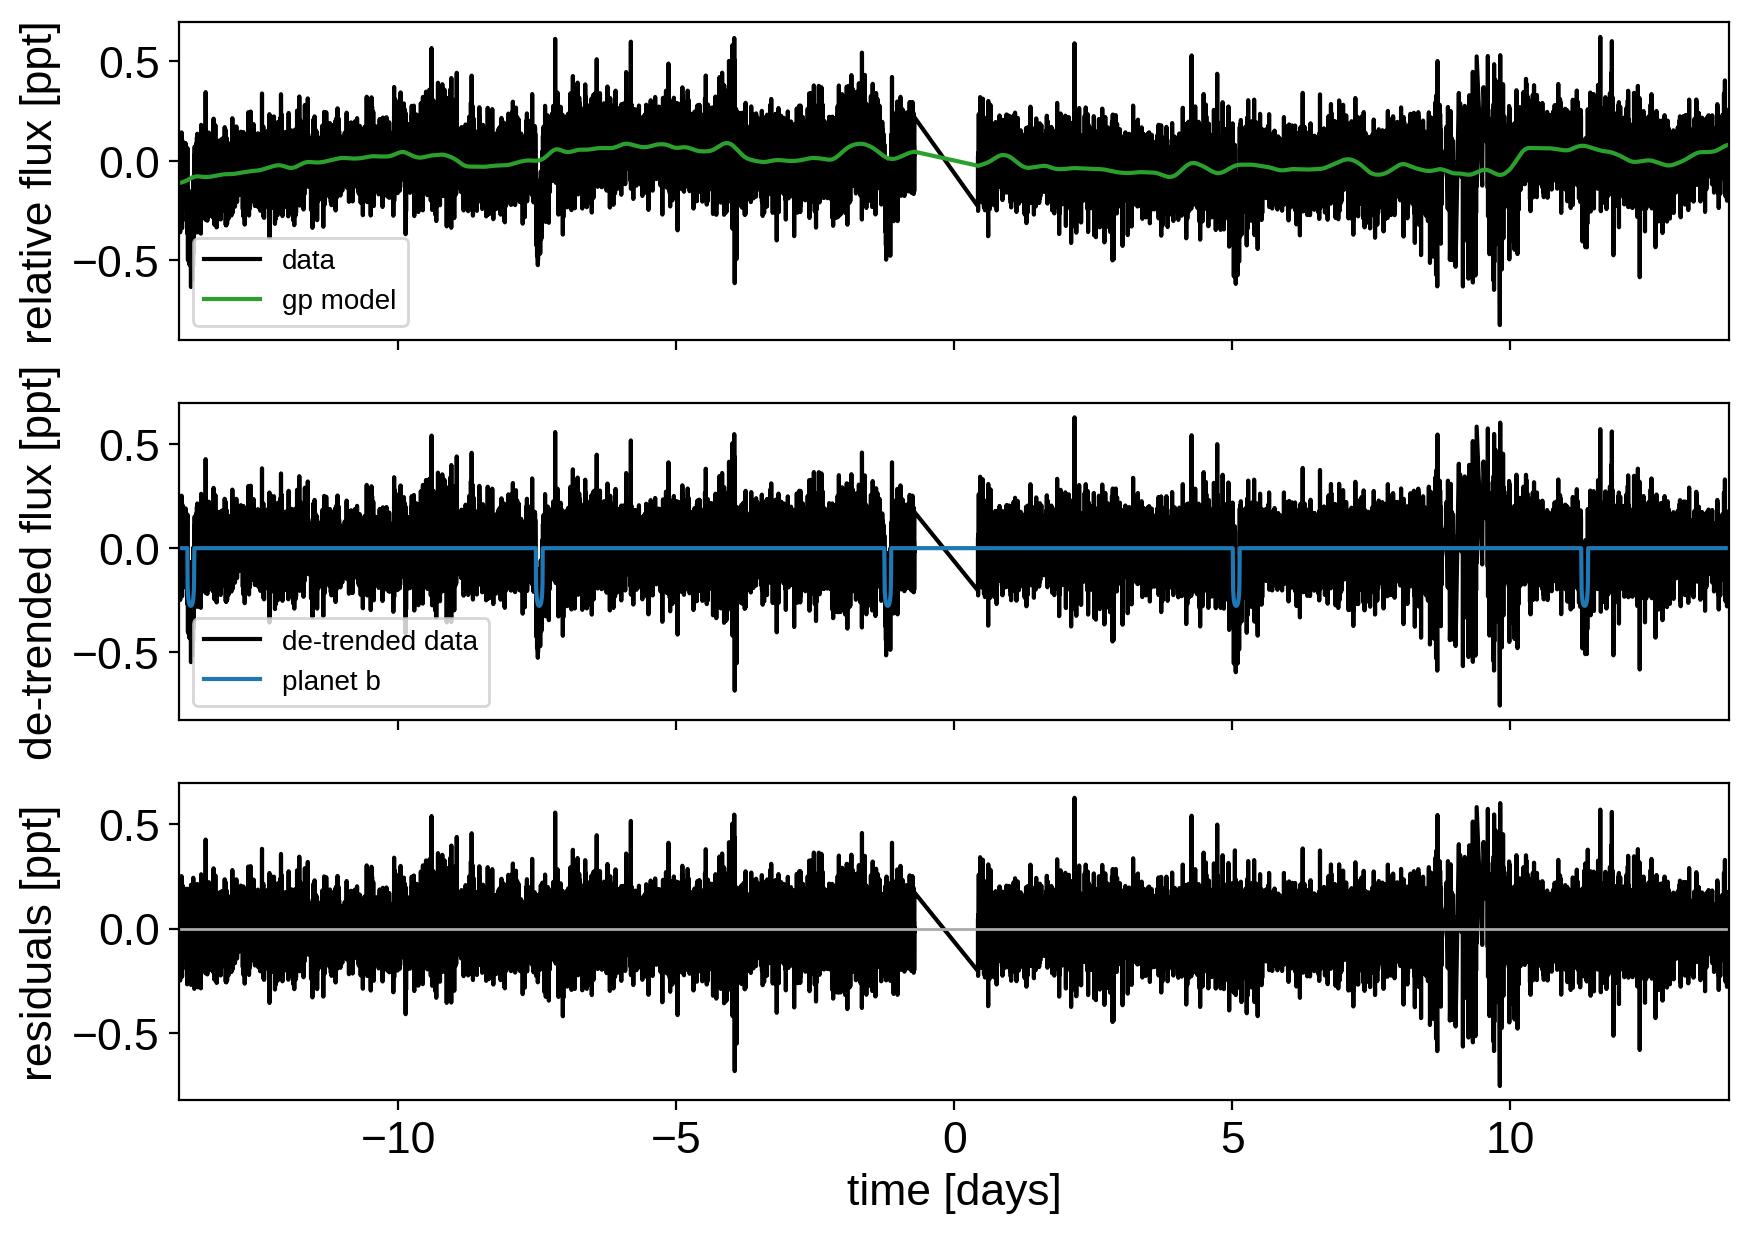

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig


plot_light_curve(map_soln0);

As in the :ref:`together` tutorial, we can do some sigma clipping to remove significant outliers.

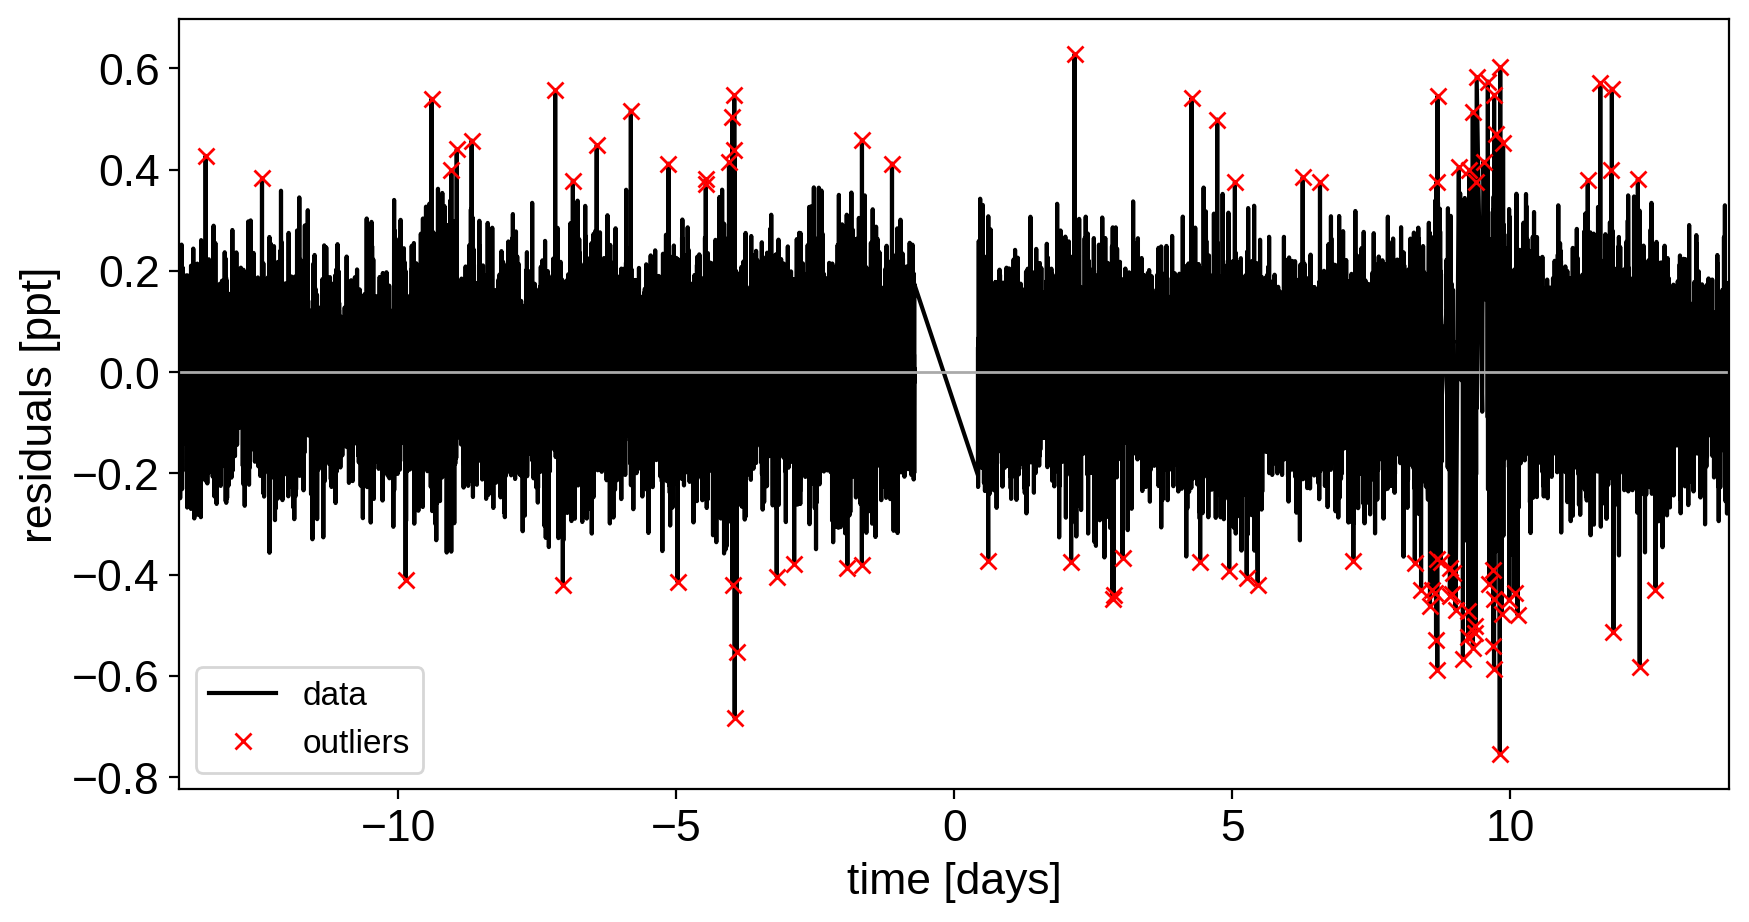

In [12]:
mod = (
    map_soln0["gp_pred"]
    + map_soln0["mean"]
    + np.sum(map_soln0["light_curves"], axis=-1)
)
resid = y - mod
rms = np.sqrt(np.median(resid ** 2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

And then we re-build the model using the data without outliers.

optimizing logp for variables: [logw0, logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.368962e+04]

1it [00:00, 55.77it/s, logp=1.368962e+04]

2it [00:00, 75.28it/s, logp=1.368962e+04]

3it [00:00, 84.15it/s, logp=8.405692e+03]

4it [00:00, 90.50it/s, logp=1.372031e+04]

5it [00:00, 94.80it/s, logp=1.235262e+04]

6it [00:00, 98.21it/s, logp=1.372031e+04]

7it [00:00, 100.06it/s, logp=1.372032e+04]

8it [00:00, 99.56it/s, logp=1.372034e+04] 

9it [00:00, 100.27it/s, logp=1.372041e+04]

10it [00:00, 100.70it/s, logp=1.372052e+04]

11it [00:00, 109.60it/s, logp=1.372052e+04]

11it [00:00, 109.60it/s, logp=1.372057e+04]

12it [00:00, 109.60it/s, logp=1.372057e+04]

13it [00:00, 109.60it/s, logp=1.372057e+04]

14it [00:00, 109.60it/s, logp=1.372057e+04]

15it [00:01, 10.80it/s, logp=1.372057e+04] 


message: Optimization terminated successfully.
logp: 13689.624267247154 -> 13720.569965671924


optimizing logp for variables: [logr]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.372057e+04]

1it [00:00, 69.34it/s, logp=1.372057e+04]

2it [00:00, 92.82it/s, logp=1.372057e+04]

3it [00:00, 104.01it/s, logp=-1.297512e+04]

4it [00:00, 111.37it/s, logp=1.355358e+04] 

5it [00:00, 116.28it/s, logp=1.372059e+04]

6it [00:00, 119.53it/s, logp=1.372059e+04]

7it [00:00, 122.00it/s, logp=1.372059e+04]

8it [00:01,  5.81it/s, logp=1.372059e+04] 


message: Optimization terminated successfully.
logp: 13720.569965671928 -> 13720.590200785264


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.372059e+04]

1it [00:00, 70.18it/s, logp=1.372059e+04]

2it [00:00, 93.44it/s, logp=1.372059e+04]

3it [00:00, 101.81it/s, logp=1.281352e+04]

4it [00:00, 109.36it/s, logp=1.372058e+04]

5it [00:00, 114.29it/s, logp=1.372059e+04]

6it [00:00, 117.46it/s, logp=1.372059e+04]

7it [00:00, 119.85it/s, logp=1.372059e+04]

8it [00:00, 118.95it/s, logp=1.372059e+04]

9it [00:00, 121.08it/s, logp=1.372059e+04]

10it [00:00, 122.72it/s, logp=1.372059e+04]

11it [00:00, 124.00it/s, logp=1.372059e+04]

12it [00:00, 124.84it/s, logp=1.372059e+04]

13it [00:00, 125.87it/s, logp=1.372059e+04]

14it [00:00, 134.80it/s, logp=1.372059e+04]

14it [00:00, 134.80it/s, logp=1.372059e+04]

15it [00:00, 134.80it/s, logp=1.372059e+04]

16it [00:00, 134.80it/s, logp=1.372059e+04]

17it [00:00, 134.80it/s, logp=1.372059e+04]

18it [00:00, 134.80it/s, logp=1.372059e+04]

19it [00:00, 134.80it/s, logp=1.372059e+04]

20it [00:00, 134.80it/s, logp=1.372059e+04]

21it [00:00, 134.80it/s, logp=1.372059e+04]

22it [00:00, 134.80it/s, logp=1.372059e+04]

23it [00:00, 134.80it/s, logp=1.372059e+04]

24it [00:00, 134.80it/s, logp=1.372059e+04]

25it [00:00, 125.93it/s, logp=1.372059e+04]

25it [00:00, 125.93it/s, logp=1.372059e+04]

26it [00:00, 125.93it/s, logp=1.372059e+04]

27it [00:00, 125.93it/s, logp=1.372059e+04]

28it [00:00, 125.93it/s, logp=1.372059e+04]

29it [00:00, 125.93it/s, logp=1.372059e+04]

30it [00:00, 125.93it/s, logp=1.372059e+04]

31it [00:00, 125.93it/s, logp=1.372059e+04]

32it [00:00, 125.93it/s, logp=1.372059e+04]

33it [00:00, 125.93it/s, logp=1.372059e+04]

34it [00:00, 125.93it/s, logp=1.372059e+04]

35it [00:00, 125.93it/s, logp=1.372059e+04]

36it [00:00, 125.93it/s, logp=1.372059e+04]

37it [00:00, 125.93it/s, logp=1.372059e+04]

38it [00:00, 126.05it/s, logp=1.372059e+04]

38it [00:00, 126.05it/s, logp=1.372059e+04]

39it [00:00, 126.05it/s, logp=1.372059e+04]

40it [00:00, 126.05it/s, logp=1.372059e+04]

41it [00:00, 126.05it/s, logp=1.372059e+04]

42it [00:00, 126.05it/s, logp=1.372059e+04]

43it [00:00, 126.05it/s, logp=1.372059e+04]

44it [00:00, 126.05it/s, logp=1.372059e+04]

45it [00:00, 126.05it/s, logp=1.372059e+04]

46it [00:00, 126.05it/s, logp=1.372059e+04]

47it [00:00, 126.05it/s, logp=1.372059e+04]

48it [00:01, 29.65it/s, logp=1.372059e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 13720.590200785264 -> 13720.590906642601


optimizing logp for variables: [t0, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.372059e+04]

1it [00:00, 62.97it/s, logp=1.372059e+04]

2it [00:00, 85.37it/s, logp=1.372059e+04]

3it [00:00, 97.62it/s, logp=1.294532e+04]

4it [00:00, 104.89it/s, logp=1.277890e+04]

5it [00:00, 110.19it/s, logp=1.283033e+04]

6it [00:00, 113.73it/s, logp=1.267073e+04]

7it [00:00, 116.54it/s, logp=1.354147e+04]

8it [00:00, 118.86it/s, logp=1.372058e+04]

9it [00:00, 120.75it/s, logp=1.372060e+04]

10it [00:00, 122.47it/s, logp=1.372057e+04]

11it [00:00, 123.75it/s, logp=1.372060e+04]

12it [00:00, 124.81it/s, logp=1.372060e+04]

13it [00:00, 125.58it/s, logp=1.372060e+04]

14it [00:00, 134.21it/s, logp=1.372060e+04]

14it [00:00, 134.21it/s, logp=1.372060e+04]

15it [00:00, 134.21it/s, logp=1.372060e+04]

16it [00:00, 134.21it/s, logp=1.372060e+04]

17it [00:00, 134.21it/s, logp=1.372060e+04]

18it [00:00, 134.21it/s, logp=1.372060e+04]

19it [00:00, 134.21it/s, logp=1.372060e+04]

20it [00:00, 134.21it/s, logp=1.372060e+04]

21it [00:00, 134.21it/s, logp=1.372060e+04]

22it [00:00, 134.21it/s, logp=1.372060e+04]

23it [00:00, 134.21it/s, logp=1.372060e+04]

24it [00:00, 134.21it/s, logp=1.372060e+04]

25it [00:00, 122.97it/s, logp=1.372060e+04]

25it [00:00, 122.97it/s, logp=1.372060e+04]

26it [00:00, 122.97it/s, logp=1.372060e+04]

27it [00:00, 122.97it/s, logp=1.372060e+04]

28it [00:00, 122.97it/s, logp=1.372060e+04]

29it [00:00, 122.97it/s, logp=1.372060e+04]

30it [00:00, 122.97it/s, logp=1.372060e+04]

31it [00:00, 122.97it/s, logp=1.372060e+04]

32it [00:00, 122.97it/s, logp=1.372060e+04]

33it [00:00, 122.97it/s, logp=1.372060e+04]

34it [00:00, 122.97it/s, logp=1.372060e+04]

35it [00:00, 122.97it/s, logp=1.372060e+04]

36it [00:00, 122.97it/s, logp=1.372060e+04]

37it [00:00, 122.97it/s, logp=1.372060e+04]

38it [00:00, 122.97it/s, logp=1.372060e+04]

39it [00:00, 127.16it/s, logp=1.372060e+04]

39it [00:00, 127.16it/s, logp=1.372060e+04]

40it [00:00, 127.16it/s, logp=1.372060e+04]

41it [00:00, 127.16it/s, logp=1.372060e+04]

42it [00:00, 127.16it/s, logp=1.372060e+04]

43it [00:00, 127.16it/s, logp=1.372060e+04]

44it [00:00, 127.16it/s, logp=1.372060e+04]

45it [00:00, 127.16it/s, logp=1.372060e+04]

46it [00:00, 127.16it/s, logp=1.372060e+04]

47it [00:00, 127.16it/s, logp=1.372060e+04]

48it [00:00, 127.16it/s, logp=1.372060e+04]

49it [00:00, 127.16it/s, logp=1.372060e+04]

50it [00:00, 127.16it/s, logp=1.372060e+04]

51it [00:00, 121.80it/s, logp=1.372060e+04]

51it [00:00, 121.80it/s, logp=1.372060e+04]

52it [00:00, 121.80it/s, logp=1.372060e+04]

53it [00:00, 121.80it/s, logp=1.372060e+04]

54it [00:00, 121.80it/s, logp=1.372060e+04]

55it [00:00, 121.80it/s, logp=1.372060e+04]

56it [00:00, 121.80it/s, logp=1.372060e+04]

57it [00:00, 121.80it/s, logp=1.372060e+04]

58it [00:00, 121.80it/s, logp=1.372060e+04]

59it [00:00, 121.80it/s, logp=1.372060e+04]

60it [00:00, 121.80it/s, logp=1.372060e+04]

61it [00:00, 121.80it/s, logp=1.372060e+04]

62it [00:00, 121.80it/s, logp=1.372060e+04]

63it [00:00, 121.80it/s, logp=1.372060e+04]

64it [00:00, 121.80it/s, logp=1.372060e+04]

65it [00:00, 124.48it/s, logp=1.372060e+04]

65it [00:00, 124.48it/s, logp=1.372060e+04]

66it [00:00, 124.48it/s, logp=1.372060e+04]

67it [00:00, 124.48it/s, logp=1.372060e+04]

68it [00:00, 124.48it/s, logp=1.372060e+04]

69it [00:00, 124.48it/s, logp=1.372060e+04]

70it [00:00, 124.48it/s, logp=1.372060e+04]

71it [00:00, 124.48it/s, logp=1.372060e+04]

72it [00:00, 124.48it/s, logp=1.372060e+04]

73it [00:00, 124.48it/s, logp=1.372060e+04]

74it [00:00, 124.48it/s, logp=1.372060e+04]

75it [00:00, 124.48it/s, logp=1.372060e+04]

76it [00:00, 124.48it/s, logp=1.372060e+04]

77it [00:00, 124.48it/s, logp=1.372060e+04]

78it [00:00, 125.99it/s, logp=1.372060e+04]

78it [00:00, 125.99it/s, logp=1.372060e+04]

79it [00:00, 125.99it/s, logp=1.372060e+04]

80it [00:00, 125.99it/s, logp=1.372060e+04]

81it [00:00, 125.99it/s, logp=1.372060e+04]

82it [00:00, 125.99it/s, logp=1.372060e+04]

83it [00:00, 125.99it/s, logp=1.372060e+04]

84it [00:00, 125.99it/s, logp=1.372060e+04]

85it [00:00, 125.99it/s, logp=1.372060e+04]

86it [00:00, 125.99it/s, logp=1.372060e+04]

87it [00:00, 125.99it/s, logp=1.372060e+04]

88it [00:00, 125.99it/s, logp=1.372060e+04]

89it [00:00, 125.99it/s, logp=1.372060e+04]

90it [00:00, 125.99it/s, logp=1.372060e+04]

91it [00:00, 125.99it/s, logp=1.372060e+04]

92it [00:00, 127.16it/s, logp=1.372060e+04]

92it [00:00, 127.16it/s, logp=1.372060e+04]

93it [00:02, 37.69it/s, logp=1.372060e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 13720.590906642605 -> 13720.59859489801


optimizing logp for variables: [u_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.372060e+04]

1it [00:00, 70.38it/s, logp=1.372060e+04]

2it [00:00, 96.69it/s, logp=1.372060e+04]

3it [00:00, 107.84it/s, logp=1.372022e+04]

4it [00:00, 116.10it/s, logp=1.372062e+04]

5it [00:00, 120.65it/s, logp=1.372062e+04]

6it [00:00, 113.89it/s, logp=1.372062e+04]

7it [00:00, 114.08it/s, logp=1.372062e+04]

8it [00:01,  6.43it/s, logp=1.372062e+04] 


message: Optimization terminated successfully.
logp: 13720.59859489801 -> 13720.624962714914


optimizing logp for variables: [logr]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.372062e+04]

1it [00:00, 71.96it/s, logp=1.372062e+04]

2it [00:00, 98.09it/s, logp=1.372062e+04]

3it [00:00, 111.81it/s, logp=-1.320603e+04]

4it [00:00, 120.51it/s, logp=1.355037e+04] 

5it [00:00, 126.46it/s, logp=1.372063e+04]

6it [00:00, 130.48it/s, logp=1.372063e+04]

7it [00:00, 133.19it/s, logp=1.372063e+04]

8it [00:01,  5.90it/s, logp=1.372063e+04] 


message: Optimization terminated successfully.
logp: 13720.624962714912 -> 13720.627429857885


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.372063e+04]

1it [00:00, 71.89it/s, logp=1.372063e+04]

2it [00:00, 97.53it/s, logp=1.372063e+04]

3it [00:00, 112.53it/s, logp=8.225953e+03]

4it [00:00, 91.12it/s, logp=1.370965e+04] 

5it [00:00, 91.47it/s, logp=1.372064e+04]

6it [00:00, 94.79it/s, logp=1.372058e+04]

7it [00:00, 100.03it/s, logp=1.372064e+04]

8it [00:00, 103.87it/s, logp=1.372064e+04]

9it [00:00, 107.48it/s, logp=1.372064e+04]

10it [00:00, 109.90it/s, logp=1.372064e+04]

11it [00:00, 112.20it/s, logp=1.372064e+04]

12it [00:00, 114.26it/s, logp=1.372064e+04]

13it [00:00, 122.92it/s, logp=1.372064e+04]

13it [00:01,  9.63it/s, logp=1.372064e+04] 


message: Optimization terminated successfully.
logp: 13720.627429857885 -> 13720.63764856563


optimizing logp for variables: [ecs]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.372064e+04]

1it [00:00, 69.79it/s, logp=1.372064e+04]

2it [00:00, 93.06it/s, logp=1.372064e+04]

3it [00:00, 103.43it/s, logp=1.372034e+04]

4it [00:00, 110.30it/s, logp=1.372064e+04]

5it [00:00, 114.84it/s, logp=1.372064e+04]

6it [00:00, 118.64it/s, logp=1.372064e+04]

7it [00:00, 121.39it/s, logp=1.372064e+04]

8it [00:00, 123.13it/s, logp=1.372064e+04]

9it [00:00, 124.51it/s, logp=1.372064e+04]

10it [00:00, 125.69it/s, logp=1.372064e+04]

11it [00:00, 126.77it/s, logp=1.372064e+04]

12it [00:01,  9.69it/s, logp=1.372064e+04] 


message: Optimization terminated successfully.
logp: 13720.637648565627 -> 13720.637655387956


optimizing logp for variables: [mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.372064e+04]

1it [00:00, 77.53it/s, logp=1.372064e+04]

2it [00:00, 104.69it/s, logp=1.372064e+04]

3it [00:00, 117.69it/s, logp=6.520834e+03]

4it [00:00, 125.23it/s, logp=1.372064e+04]

5it [00:01,  4.13it/s, logp=1.372064e+04] 


message: Optimization terminated successfully.
logp: 13720.637655387955 -> 13720.64083013365


optimizing logp for variables: [logw0, logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.372064e+04]

1it [00:00, 61.58it/s, logp=1.372064e+04]

2it [00:00, 83.12it/s, logp=1.372064e+04]

3it [00:00, 93.50it/s, logp=1.367096e+04]

4it [00:00, 99.76it/s, logp=1.372064e+04]

5it [00:00, 103.91it/s, logp=1.372064e+04]

6it [00:00, 106.96it/s, logp=1.372064e+04]

7it [00:00, 109.18it/s, logp=1.372064e+04]

8it [00:00, 110.86it/s, logp=1.372064e+04]

9it [00:01,  5.33it/s, logp=1.372064e+04] 


message: Optimization terminated successfully.
logp: 13720.64083013365 -> 13720.640833096417


optimizing logp for variables: [logSw4, logw0, logs2, ecc_prior_beta, ecc_prior_alpha, ecs, b, logr, t0, logP, r_star, m_star, u_star, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.372064e+04]

1it [00:00, 52.86it/s, logp=1.372064e+04]

2it [00:00, 71.58it/s, logp=1.372064e+04]

3it [00:00, 81.54it/s, logp=1.299354e+04]

4it [00:00, 88.05it/s, logp=1.290272e+04]

5it [00:00, 91.36it/s, logp=1.353497e+04]

6it [00:00, 93.95it/s, logp=1.372064e+04]

7it [00:00, 95.69it/s, logp=1.372064e+04]

8it [00:00, 95.88it/s, logp=1.372064e+04]

9it [00:00, 96.78it/s, logp=1.372064e+04]

10it [00:00, 97.49it/s, logp=1.372064e+04]

11it [00:00, 106.44it/s, logp=1.372064e+04]

11it [00:00, 106.44it/s, logp=1.372064e+04]

12it [00:00, 106.44it/s, logp=1.372064e+04]

13it [00:00, 106.44it/s, logp=1.372064e+04]

14it [00:00, 106.44it/s, logp=1.372064e+04]

15it [00:00, 106.44it/s, logp=1.372064e+04]

16it [00:00, 106.44it/s, logp=1.372064e+04]

17it [00:00, 106.44it/s, logp=1.372064e+04]

18it [00:00, 106.44it/s, logp=1.372064e+04]

19it [00:00, 106.44it/s, logp=1.372064e+04]

20it [00:00, 106.44it/s, logp=1.372065e+04]

21it [00:00, 106.44it/s, logp=1.372064e+04]

22it [00:00, 105.19it/s, logp=1.372064e+04]

22it [00:00, 105.19it/s, logp=1.372065e+04]

23it [00:00, 105.19it/s, logp=1.372065e+04]

24it [00:00, 105.19it/s, logp=1.372065e+04]

25it [00:00, 105.19it/s, logp=1.372065e+04]

26it [00:00, 105.19it/s, logp=1.372065e+04]

27it [00:00, 105.19it/s, logp=1.372065e+04]

28it [00:00, 105.19it/s, logp=1.372065e+04]

29it [00:00, 91.29it/s, logp=1.372065e+04] 

29it [00:00, 91.29it/s, logp=1.372065e+04]

30it [00:00, 91.29it/s, logp=1.372065e+04]

31it [00:00, 91.29it/s, logp=1.372065e+04]

32it [00:00, 91.29it/s, logp=1.372065e+04]

33it [00:00, 91.29it/s, logp=1.372065e+04]

34it [00:00, 91.29it/s, logp=1.372065e+04]

35it [00:00, 91.29it/s, logp=1.372065e+04]

36it [00:00, 91.29it/s, logp=1.372065e+04]

37it [00:00, 91.29it/s, logp=1.372065e+04]

38it [00:00, 90.56it/s, logp=1.372065e+04]

38it [00:00, 90.56it/s, logp=1.372065e+04]

39it [00:00, 90.56it/s, logp=1.372065e+04]

40it [00:00, 90.56it/s, logp=1.372065e+04]

41it [00:00, 90.56it/s, logp=1.372065e+04]

42it [00:00, 90.56it/s, logp=1.372065e+04]

43it [00:00, 90.56it/s, logp=1.372065e+04]

44it [00:00, 90.56it/s, logp=1.372065e+04]

45it [00:00, 90.56it/s, logp=1.372065e+04]

46it [00:00, 90.56it/s, logp=1.372065e+04]

47it [00:00, 90.56it/s, logp=1.372065e+04]

48it [00:00, 90.56it/s, logp=1.372065e+04]

49it [00:00, 95.53it/s, logp=1.372065e+04]

49it [00:00, 95.53it/s, logp=1.372065e+04]

50it [00:00, 95.53it/s, logp=1.372065e+04]

51it [00:00, 95.53it/s, logp=1.372065e+04]

52it [00:00, 95.53it/s, logp=1.372065e+04]

53it [00:00, 95.53it/s, logp=1.372065e+04]

54it [00:00, 95.53it/s, logp=1.372065e+04]

55it [00:00, 95.53it/s, logp=1.372065e+04]

56it [00:00, 95.53it/s, logp=1.372065e+04]

57it [00:00, 95.53it/s, logp=1.372065e+04]

58it [00:00, 95.53it/s, logp=1.372065e+04]

59it [00:00, 96.31it/s, logp=1.372065e+04]

59it [00:00, 96.31it/s, logp=1.372065e+04]

60it [00:00, 96.31it/s, logp=1.372065e+04]

61it [00:00, 96.31it/s, logp=1.372065e+04]

62it [00:00, 96.31it/s, logp=1.372065e+04]

63it [00:00, 96.31it/s, logp=1.372065e+04]

64it [00:00, 96.31it/s, logp=1.372065e+04]

65it [00:00, 96.31it/s, logp=1.372065e+04]

66it [00:00, 96.31it/s, logp=1.372065e+04]

67it [00:00, 96.31it/s, logp=1.372065e+04]

68it [00:00, 96.31it/s, logp=1.372065e+04]

69it [00:00, 96.31it/s, logp=1.372065e+04]

70it [00:00, 98.02it/s, logp=1.372065e+04]

70it [00:00, 98.02it/s, logp=1.372065e+04]

71it [00:00, 98.02it/s, logp=1.372065e+04]

72it [00:00, 98.02it/s, logp=1.372065e+04]

73it [00:00, 98.02it/s, logp=1.372065e+04]

74it [00:00, 98.02it/s, logp=1.372065e+04]

75it [00:00, 98.02it/s, logp=1.372065e+04]

76it [00:00, 98.02it/s, logp=1.372065e+04]

77it [00:00, 98.02it/s, logp=1.372065e+04]

78it [00:00, 98.02it/s, logp=1.372065e+04]

79it [00:00, 98.02it/s, logp=1.372065e+04]

80it [00:00, 98.02it/s, logp=1.372065e+04]

81it [00:00, 100.30it/s, logp=1.372065e+04]

81it [00:00, 100.30it/s, logp=1.372065e+04]

82it [00:00, 100.30it/s, logp=1.372065e+04]

83it [00:00, 100.30it/s, logp=1.372065e+04]

84it [00:00, 100.30it/s, logp=1.372065e+04]

85it [00:00, 100.30it/s, logp=1.372065e+04]

86it [00:00, 100.30it/s, logp=1.372065e+04]

87it [00:00, 100.30it/s, logp=1.372065e+04]

88it [00:00, 100.30it/s, logp=1.372065e+04]

89it [00:00, 100.30it/s, logp=1.372065e+04]

90it [00:00, 100.30it/s, logp=1.372065e+04]

91it [00:00, 100.30it/s, logp=1.372065e+04]

92it [00:00, 102.64it/s, logp=1.372065e+04]

92it [00:00, 102.64it/s, logp=1.372065e+04]

93it [00:00, 102.64it/s, logp=1.372065e+04]

94it [00:00, 102.64it/s, logp=1.372065e+04]

95it [00:00, 102.64it/s, logp=1.372065e+04]

96it [00:00, 102.64it/s, logp=1.372065e+04]

97it [00:00, 102.64it/s, logp=1.372065e+04]

98it [00:00, 102.64it/s, logp=1.372065e+04]

99it [00:01, 102.64it/s, logp=1.372065e+04]

100it [00:01, 102.64it/s, logp=1.372065e+04]

101it [00:01, 102.64it/s, logp=1.372065e+04]

102it [00:01, 97.53it/s, logp=1.372065e+04] 

102it [00:01, 97.53it/s, logp=1.372065e+04]

103it [00:01, 97.53it/s, logp=1.372065e+04]

104it [00:01, 97.53it/s, logp=1.372065e+04]

105it [00:01, 97.53it/s, logp=1.372065e+04]

106it [00:01, 97.53it/s, logp=1.372065e+04]

107it [00:01, 97.53it/s, logp=1.372065e+04]

108it [00:01, 97.53it/s, logp=1.372065e+04]

109it [00:01, 97.53it/s, logp=1.372065e+04]

110it [00:01, 97.53it/s, logp=1.372065e+04]

111it [00:01, 97.53it/s, logp=1.372065e+04]

112it [00:01, 96.15it/s, logp=1.372065e+04]

112it [00:01, 96.15it/s, logp=1.372065e+04]

113it [00:01, 96.15it/s, logp=1.372065e+04]

114it [00:01, 96.15it/s, logp=1.372065e+04]

115it [00:01, 96.15it/s, logp=1.372065e+04]

116it [00:01, 96.15it/s, logp=1.372065e+04]

117it [00:01, 96.15it/s, logp=1.372065e+04]

118it [00:01, 96.15it/s, logp=1.372065e+04]

119it [00:01, 96.15it/s, logp=1.372065e+04]

120it [00:01, 96.15it/s, logp=1.372065e+04]

121it [00:01, 96.15it/s, logp=1.372065e+04]

122it [00:01, 89.63it/s, logp=1.372065e+04]

122it [00:01, 89.63it/s, logp=1.372065e+04]

123it [00:01, 89.63it/s, logp=1.372065e+04]

124it [00:02, 49.43it/s, logp=1.372065e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 13720.64083309642 -> 13720.647587016902


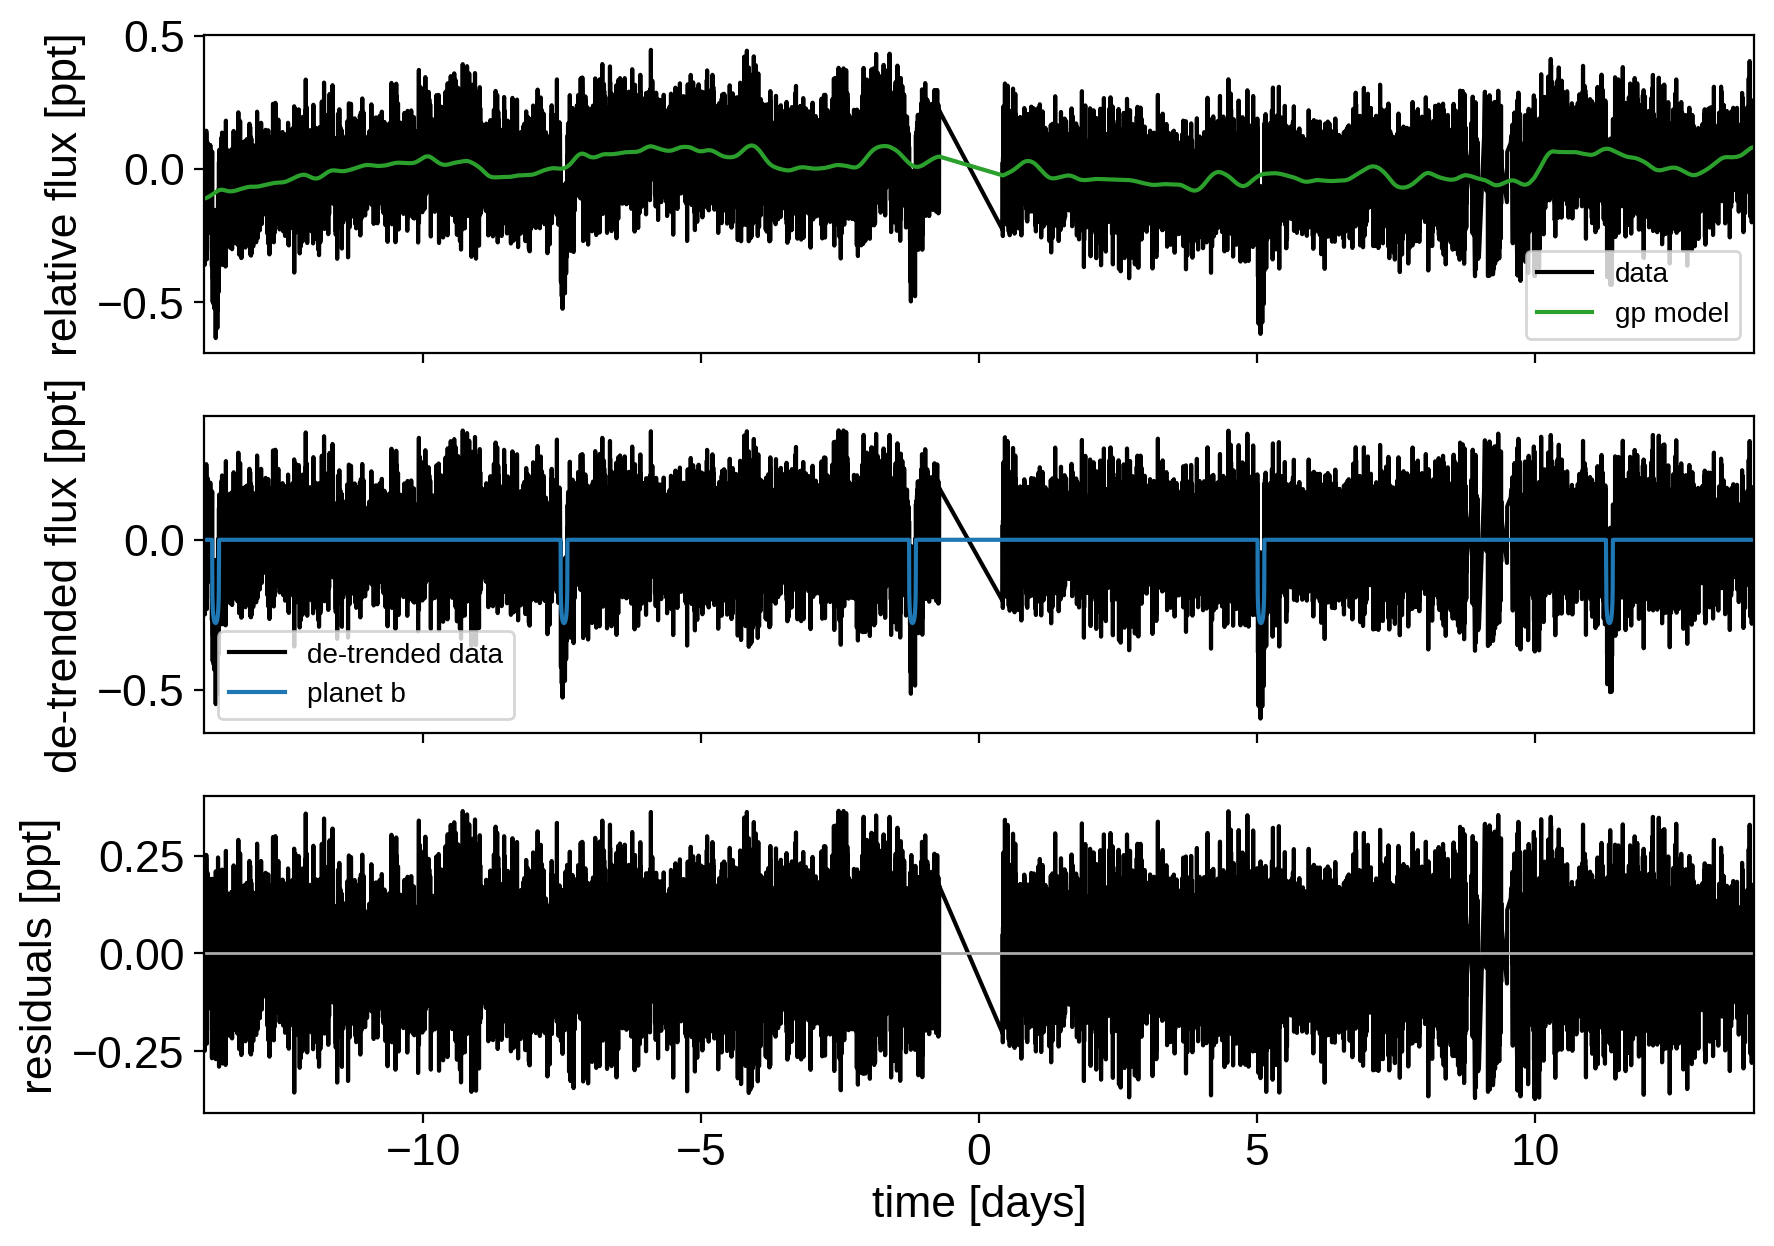

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Now that we have the model, we can sample:

In [14]:
np.random.seed(261136679)
with model:
    trace = xo.sample(
        tune=3500, draws=3000, start=map_soln, chains=4, target_accept=0.95
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logSw4, logw0, logs2, ecc_prior_beta, ecc_prior_alpha, ecs, b, logr, t0, logP, r_star, m_star, u_star, mean]


Sampling 4 chains, 0 divergences:   0%|          | 0/26000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 13/26000 [00:00<03:38, 119.18draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 17/26000 [00:02<1:10:54,  6.11draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 20/26000 [00:02<55:04,  7.86draws/s]  

Sampling 4 chains, 0 divergences:   0%|          | 23/26000 [00:04<2:11:20,  3.30draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 25/26000 [00:06<3:41:44,  1.95draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 27/26000 [00:06<2:48:15,  2.57draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 29/26000 [00:08<4:02:43,  1.78draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 31/26000 [00:08<3:04:46,  2.34draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 33/26000 [00:10<4:12:32,  1.71draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 35/26000 [00:10<3:12:55,  2.24draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 37/26000 [00:12<4:14:50,  1.70draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 39/26000 [00:13<3:18:27,  2.18draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 41/26000 [00:14<4:15:42,  1.69draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 43/26000 [00:15<3:19:27,  2.17draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 45/26000 [00:17<4:15:43,  1.69draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 47/26000 [00:17<3:21:48,  2.14draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 49/26000 [00:19<4:15:34,  1.69draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 51/26000 [00:19<3:21:35,  2.15draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 53/26000 [00:21<4:14:43,  1.70draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 55/26000 [00:21<3:21:10,  2.15draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 56/26000 [00:21<2:37:45,  2.74draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 57/26000 [00:23<5:19:31,  1.35draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 59/26000 [00:23<4:06:54,  1.75draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 60/26000 [00:23<3:14:32,  2.22draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 61/26000 [00:25<5:42:44,  1.26draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 63/26000 [00:25<4:23:32,  1.64draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 64/26000 [00:25<3:25:03,  2.11draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 65/26000 [00:27<5:51:02,  1.23draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 67/26000 [00:27<4:27:07,  1.62draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 68/26000 [00:28<3:34:54,  2.01draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 69/26000 [00:29<5:54:00,  1.22draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 71/26000 [00:30<4:29:14,  1.61draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 72/26000 [00:30<3:37:02,  1.99draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 73/26000 [00:31<5:56:23,  1.21draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 75/26000 [00:32<4:30:18,  1.60draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 76/26000 [00:32<3:39:17,  1.97draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 77/26000 [00:33<5:54:57,  1.22draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 79/26000 [00:34<4:29:13,  1.60draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 80/26000 [00:34<3:40:57,  1.96draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 81/26000 [00:36<5:52:52,  1.22draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 83/26000 [00:36<4:28:11,  1.61draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 84/26000 [00:36<3:41:45,  1.95draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 85/26000 [00:38<5:50:59,  1.23draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 86/26000 [00:38<4:21:36,  1.65draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 87/26000 [00:38<3:28:45,  2.07draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 88/26000 [00:38<3:05:11,  2.33draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 89/26000 [00:40<5:20:57,  1.35draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 90/26000 [00:40<4:00:55,  1.79draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 91/26000 [00:40<3:17:29,  2.19draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 92/26000 [00:40<3:02:36,  2.36draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 93/26000 [00:42<5:10:19,  1.39draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 94/26000 [00:42<3:53:22,  1.85draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 95/26000 [00:42<3:14:52,  2.22draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 96/26000 [00:43<3:02:47,  2.36draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 97/26000 [00:44<5:11:17,  1.39draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 98/26000 [00:44<3:56:01,  1.83draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 99/26000 [00:44<3:17:14,  2.19draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 100/26000 [00:45<3:02:21,  2.37draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 101/26000 [00:46<5:16:14,  1.36draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 102/26000 [00:46<3:54:34,  1.84draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 103/26000 [00:47<3:21:30,  2.14draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 104/26000 [00:47<2:56:51,  2.44draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 105/26000 [00:48<5:16:10,  1.37draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 106/26000 [00:48<3:55:27,  1.83draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 107/26000 [00:49<3:24:06,  2.11draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 108/26000 [00:49<2:53:21,  2.49draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 109/26000 [00:50<5:17:02,  1.36draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 111/26000 [00:51<4:07:06,  1.75draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 112/26000 [00:51<3:22:13,  2.13draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 113/26000 [00:53<5:34:31,  1.29draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 114/26000 [00:53<4:08:05,  1.74draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 115/26000 [00:53<3:31:06,  2.04draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 116/26000 [00:53<3:00:57,  2.38draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 117/26000 [00:55<5:17:32,  1.36draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 119/26000 [00:55<4:07:16,  1.74draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 120/26000 [00:55<3:30:17,  2.05draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 121/26000 [00:57<5:35:43,  1.28draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 123/26000 [00:57<4:22:53,  1.64draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 124/26000 [00:58<3:46:40,  1.90draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 125/26000 [00:59<5:35:35,  1.29draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 127/26000 [00:59<4:24:24,  1.63draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 128/26000 [01:00<3:43:55,  1.93draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 129/26000 [01:01<5:34:13,  1.29draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 131/26000 [01:02<4:23:27,  1.64draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 132/26000 [01:02<3:41:36,  1.95draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 133/26000 [01:03<5:33:12,  1.29draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 135/26000 [01:04<4:24:14,  1.63draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 136/26000 [01:04<3:38:02,  1.98draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 137/26000 [01:05<5:35:19,  1.29draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 139/26000 [01:06<4:24:24,  1.63draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 140/26000 [01:06<3:37:01,  1.99draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 141/26000 [01:07<5:34:14,  1.29draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 143/26000 [01:08<4:25:35,  1.62draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 144/26000 [01:08<3:43:31,  1.93draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 145/26000 [01:10<5:29:07,  1.31draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 147/26000 [01:10<4:24:00,  1.63draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 148/26000 [01:10<3:37:33,  1.98draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 149/26000 [01:12<5:30:34,  1.30draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 151/26000 [01:12<4:21:39,  1.65draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 152/26000 [01:13<3:43:17,  1.93draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 153/26000 [01:14<5:29:05,  1.31draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 155/26000 [01:14<4:19:21,  1.66draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 156/26000 [01:15<3:50:43,  1.87draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 157/26000 [01:16<5:25:40,  1.32draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 159/26000 [01:16<4:16:08,  1.68draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 160/26000 [01:17<3:54:34,  1.84draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 161/26000 [01:18<5:25:47,  1.32draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 163/26000 [01:19<4:16:16,  1.68draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 164/26000 [01:19<3:57:08,  1.82draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 165/26000 [01:20<5:24:23,  1.33draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 167/26000 [01:21<4:15:18,  1.69draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 168/26000 [01:21<4:01:32,  1.78draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 169/26000 [01:22<5:17:37,  1.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 171/26000 [01:23<4:10:19,  1.72draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 172/26000 [01:23<4:06:55,  1.74draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 173/26000 [01:24<5:20:55,  1.34draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 175/26000 [01:25<4:10:36,  1.72draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 176/26000 [01:25<4:08:26,  1.73draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 177/26000 [01:27<5:30:25,  1.30draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 179/26000 [01:27<4:15:20,  1.69draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 180/26000 [01:28<4:10:29,  1.72draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 181/26000 [01:29<5:53:20,  1.22draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 182/26000 [01:29<4:20:44,  1.65draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 183/26000 [01:29<3:32:27,  2.03draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 184/26000 [01:30<4:02:27,  1.77draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 185/26000 [01:31<5:44:09,  1.25draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 187/26000 [01:32<4:16:40,  1.68draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 188/26000 [01:32<4:29:18,  1.60draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 189/26000 [01:34<5:57:08,  1.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 191/26000 [01:34<4:31:02,  1.59draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 192/26000 [01:35<4:49:37,  1.49draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 193/26000 [01:36<6:12:14,  1.16draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 195/26000 [01:36<4:35:10,  1.56draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 196/26000 [01:37<5:08:38,  1.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 197/26000 [01:38<6:12:53,  1.15draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 199/26000 [01:39<4:37:16,  1.55draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 200/26000 [01:40<5:16:42,  1.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 201/26000 [01:41<6:02:37,  1.19draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 203/26000 [01:41<4:20:28,  1.65draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 205/26000 [01:41<3:14:37,  2.21draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 207/26000 [01:42<3:21:53,  2.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 209/26000 [01:43<3:31:29,  2.03draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 211/26000 [01:43<2:43:44,  2.62draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 212/26000 [01:44<4:13:19,  1.70draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 213/26000 [01:45<5:02:39,  1.42draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 214/26000 [01:46<4:00:07,  1.79draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 216/26000 [01:47<4:07:39,  1.74draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 217/26000 [01:48<4:37:12,  1.55draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 218/26000 [01:48<4:16:12,  1.68draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 220/26000 [01:49<4:19:43,  1.65draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 221/26000 [01:50<4:17:59,  1.67draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 222/26000 [01:50<3:54:30,  1.83draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 223/26000 [01:51<3:43:30,  1.92draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 224/26000 [01:52<4:52:33,  1.47draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 225/26000 [01:52<4:01:56,  1.78draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 227/26000 [01:53<3:18:47,  2.16draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 228/26000 [01:53<3:33:42,  2.01draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 230/26000 [01:54<3:46:27,  1.90draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 231/26000 [01:55<3:09:41,  2.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 232/26000 [01:55<3:58:12,  1.80draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 234/26000 [01:57<4:10:15,  1.72draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 235/26000 [01:57<3:47:26,  1.89draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 236/26000 [01:58<4:00:45,  1.78draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 237/26000 [01:58<3:10:02,  2.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 238/26000 [01:59<4:39:06,  1.54draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 239/26000 [02:00<4:53:51,  1.46draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 240/26000 [02:00<3:54:17,  1.83draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 241/26000 [02:00<3:06:12,  2.31draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 242/26000 [02:01<4:20:14,  1.65draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 243/26000 [02:02<5:04:16,  1.41draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 245/26000 [02:02<3:53:58,  1.83draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 246/26000 [02:04<4:56:17,  1.45draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 247/26000 [02:04<5:19:30,  1.34draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 249/26000 [02:05<4:04:55,  1.75draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 250/26000 [02:06<4:36:31,  1.55draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 251/26000 [02:06<3:43:11,  1.92draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 253/26000 [02:07<3:37:20,  1.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 254/26000 [02:07<3:01:54,  2.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 255/26000 [02:07<2:59:34,  2.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 256/26000 [02:08<3:30:54,  2.03draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 258/26000 [02:09<3:06:38,  2.30draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 259/26000 [02:09<2:28:07,  2.90draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 260/26000 [02:09<2:03:50,  3.46draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 261/26000 [02:09<1:45:40,  4.06draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 262/26000 [02:09<1:47:43,  3.98draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 264/26000 [02:09<1:24:42,  5.06draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 265/26000 [02:10<1:34:06,  4.56draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 266/26000 [02:11<4:44:10,  1.51draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 267/26000 [02:12<3:37:05,  1.98draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 269/26000 [02:12<2:50:35,  2.51draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 270/26000 [02:12<3:07:54,  2.28draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 271/26000 [02:13<3:15:16,  2.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 272/26000 [02:14<3:38:55,  1.96draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 273/26000 [02:14<3:10:48,  2.25draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 274/26000 [02:14<2:45:35,  2.59draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 275/26000 [02:14<2:16:31,  3.14draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 276/26000 [02:15<3:12:46,  2.22draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 277/26000 [02:16<3:38:28,  1.96draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 278/26000 [02:16<3:25:23,  2.09draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 279/26000 [02:16<3:00:02,  2.38draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 281/26000 [02:17<3:21:09,  2.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 282/26000 [02:18<3:45:09,  1.90draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 283/26000 [02:18<3:11:47,  2.23draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 284/26000 [02:19<2:35:31,  2.76draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 285/26000 [02:19<2:34:28,  2.77draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 286/26000 [02:19<2:22:00,  3.02draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 287/26000 [02:19<2:09:26,  3.31draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 288/26000 [02:20<1:52:01,  3.83draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 289/26000 [02:20<2:07:09,  3.37draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 290/26000 [02:21<4:17:57,  1.66draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 291/26000 [02:22<3:52:16,  1.84draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 293/26000 [02:22<3:09:00,  2.27draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 294/26000 [02:22<2:28:40,  2.88draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 295/26000 [02:22<2:04:14,  3.45draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 296/26000 [02:23<1:44:17,  4.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 297/26000 [02:23<2:21:49,  3.02draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 298/26000 [02:23<2:10:10,  3.29draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 299/26000 [02:24<2:08:34,  3.33draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 300/26000 [02:24<2:17:28,  3.12draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 301/26000 [02:24<1:53:25,  3.78draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 302/26000 [02:24<1:37:29,  4.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 303/26000 [02:26<4:18:46,  1.65draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 304/26000 [02:26<4:01:40,  1.77draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 306/26000 [02:26<3:00:14,  2.38draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 307/26000 [02:28<5:14:26,  1.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 308/26000 [02:28<4:45:29,  1.50draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 310/26000 [02:28<3:29:05,  2.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 311/26000 [02:29<3:49:05,  1.87draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 312/26000 [02:30<3:34:24,  2.00draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 314/26000 [02:30<2:54:50,  2.45draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 315/26000 [02:30<3:14:20,  2.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 316/26000 [02:31<3:53:48,  1.83draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 317/26000 [02:32<3:40:17,  1.94draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 319/26000 [02:32<2:47:10,  2.56draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 320/26000 [02:32<2:13:39,  3.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 321/26000 [02:32<2:01:07,  3.53draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 323/26000 [02:33<2:17:00,  3.12draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 325/26000 [02:34<2:08:32,  3.33draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 326/26000 [02:34<2:13:45,  3.20draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 327/26000 [02:35<3:15:24,  2.19draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 328/26000 [02:35<2:50:46,  2.51draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 329/26000 [02:35<2:30:02,  2.85draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 331/26000 [02:35<2:03:34,  3.46draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 333/26000 [02:36<1:34:53,  4.51draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 334/26000 [02:36<1:21:44,  5.23draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 335/26000 [02:37<2:56:18,  2.43draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 336/26000 [02:37<2:19:16,  3.07draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 337/26000 [02:37<1:55:36,  3.70draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 338/26000 [02:38<2:49:01,  2.53draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 339/26000 [02:38<2:11:17,  3.26draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 340/26000 [02:38<1:58:33,  3.61draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 341/26000 [02:39<3:28:51,  2.05draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 343/26000 [02:39<2:44:26,  2.60draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 344/26000 [02:40<3:09:50,  2.25draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 345/26000 [02:40<2:56:14,  2.43draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 346/26000 [02:41<3:19:14,  2.15draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 347/26000 [02:41<3:01:24,  2.36draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 348/26000 [02:41<2:45:40,  2.58draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 350/26000 [02:42<2:28:14,  2.88draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 352/26000 [02:42<2:01:57,  3.50draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 353/26000 [02:42<1:59:03,  3.59draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 355/26000 [02:43<1:57:14,  3.65draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 356/26000 [02:43<1:49:34,  3.90draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 359/26000 [02:44<1:37:20,  4.39draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 361/26000 [02:44<1:14:40,  5.72draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 362/26000 [02:44<2:01:51,  3.51draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 363/26000 [02:45<2:34:15,  2.77draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 365/26000 [02:45<2:06:10,  3.39draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 366/26000 [02:45<1:51:32,  3.83draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 367/26000 [02:46<2:02:54,  3.48draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 368/26000 [02:46<1:54:58,  3.72draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 370/26000 [02:46<1:37:31,  4.38draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 372/26000 [02:46<1:22:15,  5.19draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 374/26000 [02:47<1:17:04,  5.54draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 376/26000 [02:47<1:10:48,  6.03draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 377/26000 [02:48<2:39:42,  2.67draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 378/26000 [02:48<2:53:01,  2.47draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 379/26000 [02:48<2:26:45,  2.91draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 380/26000 [02:49<2:31:23,  2.82draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 381/26000 [02:49<2:14:01,  3.19draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 382/26000 [02:49<2:14:47,  3.17draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 383/26000 [02:50<2:00:40,  3.54draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 384/26000 [02:50<2:06:05,  3.39draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 385/26000 [02:50<2:01:31,  3.51draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 386/26000 [02:50<2:10:45,  3.26draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 388/26000 [02:51<1:42:45,  4.15draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 389/26000 [02:52<3:15:43,  2.18draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 390/26000 [02:53<4:25:20,  1.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 392/26000 [02:53<3:13:39,  2.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 394/26000 [02:55<4:24:45,  1.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 396/26000 [02:55<3:14:15,  2.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 398/26000 [02:55<2:45:49,  2.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 400/26000 [02:57<3:10:13,  2.24draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 401/26000 [02:57<3:02:28,  2.34draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 402/26000 [02:57<2:27:04,  2.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 404/26000 [02:58<2:12:09,  3.23draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 407/26000 [02:58<1:44:40,  4.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 408/26000 [02:58<1:54:42,  3.72draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 409/26000 [02:59<2:31:14,  2.82draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 410/26000 [02:59<2:30:44,  2.83draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 411/26000 [02:59<2:06:55,  3.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 412/26000 [02:59<1:51:04,  3.84draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 413/26000 [03:00<1:41:37,  4.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 414/26000 [03:00<1:33:17,  4.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 415/26000 [03:00<2:12:29,  3.22draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 416/26000 [03:00<1:52:53,  3.78draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 417/26000 [03:01<1:44:47,  4.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 418/26000 [03:01<1:55:50,  3.68draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 419/26000 [03:01<1:46:36,  4.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 420/26000 [03:01<1:36:26,  4.42draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 421/26000 [03:01<1:27:29,  4.87draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 422/26000 [03:02<1:49:32,  3.89draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 423/26000 [03:02<1:36:15,  4.43draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 424/26000 [03:03<2:49:21,  2.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 425/26000 [03:03<3:04:46,  2.31draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 426/26000 [03:04<2:32:21,  2.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 427/26000 [03:04<2:33:05,  2.78draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 428/26000 [03:04<2:07:16,  3.35draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 429/26000 [03:04<2:16:51,  3.11draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 430/26000 [03:05<2:43:22,  2.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 431/26000 [03:05<2:17:43,  3.09draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 432/26000 [03:05<2:23:41,  2.97draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 433/26000 [03:06<2:00:15,  3.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 434/26000 [03:06<2:34:07,  2.76draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 435/26000 [03:07<2:35:55,  2.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 436/26000 [03:07<2:09:13,  3.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 437/26000 [03:07<2:04:34,  3.42draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 439/26000 [03:07<1:44:15,  4.09draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 440/26000 [03:08<2:03:03,  3.46draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 441/26000 [03:08<1:46:46,  3.99draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 442/26000 [03:08<1:49:14,  3.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 443/26000 [03:08<1:30:00,  4.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 445/26000 [03:08<1:11:22,  5.97draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 446/26000 [03:08<1:09:24,  6.14draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 447/26000 [03:09<1:22:47,  5.14draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 448/26000 [03:09<2:19:12,  3.06draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 449/26000 [03:10<2:35:59,  2.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 451/26000 [03:10<2:11:59,  3.23draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 452/26000 [03:10<2:04:35,  3.42draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 453/26000 [03:11<3:10:17,  2.24draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 454/26000 [03:12<2:45:53,  2.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 455/26000 [03:12<2:31:23,  2.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 456/26000 [03:12<2:15:49,  3.13draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 458/26000 [03:13<2:10:18,  3.27draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 459/26000 [03:13<2:37:42,  2.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 461/26000 [03:14<2:41:36,  2.63draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 462/26000 [03:14<2:24:20,  2.95draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 465/26000 [03:15<2:27:23,  2.89draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 466/26000 [03:16<3:18:13,  2.15draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 467/26000 [03:16<2:50:32,  2.50draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 469/26000 [03:16<2:08:34,  3.31draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 470/26000 [03:16<1:44:47,  4.06draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 471/26000 [03:17<2:19:22,  3.05draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 472/26000 [03:17<2:10:07,  3.27draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 473/26000 [03:18<2:49:21,  2.51draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 474/26000 [03:18<2:19:41,  3.05draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 475/26000 [03:18<2:25:15,  2.93draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 476/26000 [03:19<2:06:10,  3.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 477/26000 [03:19<2:11:48,  3.23draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 478/26000 [03:19<1:49:54,  3.87draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 480/26000 [03:19<1:24:46,  5.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 481/26000 [03:19<1:18:09,  5.44draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 482/26000 [03:19<1:09:42,  6.10draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 483/26000 [03:20<1:23:53,  5.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 486/26000 [03:20<1:08:18,  6.23draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 487/26000 [03:20<1:44:02,  4.09draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 488/26000 [03:21<1:42:42,  4.14draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 489/26000 [03:21<1:41:15,  4.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 491/26000 [03:21<1:49:02,  3.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 492/26000 [03:22<1:44:31,  4.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 493/26000 [03:22<1:52:58,  3.76draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 494/26000 [03:22<1:37:20,  4.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 495/26000 [03:23<1:58:56,  3.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 496/26000 [03:23<1:46:57,  3.97draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 497/26000 [03:23<1:47:37,  3.95draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 499/26000 [03:24<1:54:42,  3.71draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 500/26000 [03:24<1:40:57,  4.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 501/26000 [03:24<1:45:29,  4.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 503/26000 [03:24<1:33:21,  4.55draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 505/26000 [03:25<1:34:40,  4.49draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 506/26000 [03:25<1:20:54,  5.25draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 507/26000 [03:25<1:18:29,  5.41draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 508/26000 [03:25<1:39:36,  4.27draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 509/26000 [03:26<1:31:42,  4.63draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 510/26000 [03:26<1:33:43,  4.53draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 511/26000 [03:26<2:15:59,  3.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 512/26000 [03:27<1:53:07,  3.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 513/26000 [03:27<1:37:00,  4.38draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 514/26000 [03:27<1:38:40,  4.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 515/26000 [03:27<1:22:37,  5.14draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 516/26000 [03:27<1:51:10,  3.82draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 517/26000 [03:28<1:44:22,  4.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 519/26000 [03:28<1:33:54,  4.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 520/26000 [03:28<1:25:04,  4.99draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 521/26000 [03:29<2:15:08,  3.14draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 522/26000 [03:29<1:58:08,  3.59draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 524/26000 [03:29<1:48:47,  3.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 525/26000 [03:30<1:51:23,  3.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 526/26000 [03:30<2:21:05,  3.01draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 527/26000 [03:30<1:53:39,  3.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 529/26000 [03:30<1:30:02,  4.71draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 530/26000 [03:31<1:35:33,  4.44draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 531/26000 [03:31<1:29:37,  4.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 533/26000 [03:31<1:30:33,  4.69draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 534/26000 [03:31<1:21:29,  5.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 536/26000 [03:32<1:24:34,  5.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 537/26000 [03:32<1:18:13,  5.43draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 539/26000 [03:32<1:05:33,  6.47draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 540/26000 [03:32<1:27:29,  4.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 541/26000 [03:33<1:18:08,  5.43draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 542/26000 [03:33<1:15:37,  5.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 543/26000 [03:33<1:16:36,  5.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 544/26000 [03:33<1:47:18,  3.95draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 545/26000 [03:34<1:38:42,  4.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 547/26000 [03:34<1:37:00,  4.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 548/26000 [03:34<1:27:01,  4.87draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 549/26000 [03:34<1:18:32,  5.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 550/26000 [03:34<1:14:47,  5.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 551/26000 [03:35<1:16:03,  5.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 552/26000 [03:35<1:06:54,  6.34draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 553/26000 [03:35<1:24:15,  5.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 554/26000 [03:35<1:31:51,  4.62draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 555/26000 [03:36<1:47:22,  3.95draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 556/26000 [03:36<1:44:44,  4.05draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 558/26000 [03:36<1:35:39,  4.43draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 559/26000 [03:36<1:38:50,  4.29draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 560/26000 [03:37<1:54:58,  3.69draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 561/26000 [03:37<1:57:45,  3.60draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 562/26000 [03:37<2:04:02,  3.42draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 563/26000 [03:38<2:09:04,  3.28draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 564/26000 [03:38<2:02:02,  3.47draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 565/26000 [03:38<2:07:43,  3.32draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 567/26000 [03:39<1:45:51,  4.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 569/26000 [03:39<1:22:30,  5.14draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 570/26000 [03:39<1:57:10,  3.62draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 571/26000 [03:40<2:08:39,  3.29draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 573/26000 [03:40<1:43:56,  4.08draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 575/26000 [03:40<1:42:41,  4.13draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 576/26000 [03:40<1:31:53,  4.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 577/26000 [03:41<1:58:32,  3.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 578/26000 [03:41<2:44:41,  2.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 579/26000 [03:42<2:10:55,  3.24draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 580/26000 [03:42<2:15:52,  3.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 581/26000 [03:42<2:11:59,  3.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 582/26000 [03:43<2:06:33,  3.35draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 583/26000 [03:43<2:01:00,  3.50draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 585/26000 [03:43<1:46:54,  3.96draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 586/26000 [03:43<1:49:45,  3.86draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 587/26000 [03:44<1:30:43,  4.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 588/26000 [03:44<1:28:53,  4.76draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 589/26000 [03:44<1:37:11,  4.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 591/26000 [03:44<1:27:39,  4.83draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 593/26000 [03:45<1:14:46,  5.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 594/26000 [03:45<1:09:46,  6.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 595/26000 [03:45<1:25:33,  4.95draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 597/26000 [03:45<1:19:39,  5.32draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 598/26000 [03:46<1:29:10,  4.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 600/26000 [03:46<1:10:05,  6.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 601/26000 [03:46<1:19:25,  5.33draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 602/26000 [03:46<1:20:20,  5.27draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 603/26000 [03:47<1:59:37,  3.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 605/26000 [03:47<1:42:21,  4.14draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 606/26000 [03:47<1:50:16,  3.84draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 608/26000 [03:47<1:35:36,  4.43draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 610/26000 [03:48<1:38:42,  4.29draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 611/26000 [03:48<1:25:00,  4.98draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 612/26000 [03:48<1:27:57,  4.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 613/26000 [03:49<1:44:48,  4.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 615/26000 [03:49<1:49:08,  3.88draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 616/26000 [03:49<1:47:00,  3.95draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 617/26000 [03:50<1:58:02,  3.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 618/26000 [03:50<2:38:49,  2.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 619/26000 [03:50<2:04:03,  3.41draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 620/26000 [03:51<1:46:16,  3.98draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 621/26000 [03:51<1:57:48,  3.59draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 622/26000 [03:51<1:39:07,  4.27draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 623/26000 [03:51<1:48:43,  3.89draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 624/26000 [03:52<2:04:33,  3.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 625/26000 [03:52<1:45:54,  3.99draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 626/26000 [03:53<2:24:18,  2.93draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 628/26000 [03:53<2:00:59,  3.50draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 629/26000 [03:53<2:11:57,  3.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 631/26000 [03:53<1:50:14,  3.84draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 632/26000 [03:54<1:56:25,  3.63draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 634/26000 [03:54<1:40:36,  4.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 635/26000 [03:55<2:35:06,  2.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 636/26000 [03:55<2:27:02,  2.87draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 638/26000 [03:55<2:04:26,  3.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 639/26000 [03:56<1:56:35,  3.63draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 640/26000 [03:56<1:36:11,  4.39draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 641/26000 [03:56<1:45:47,  3.99draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 642/26000 [03:56<1:54:48,  3.68draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 644/26000 [03:57<1:55:33,  3.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 645/26000 [03:58<2:36:45,  2.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 646/26000 [03:58<2:02:57,  3.44draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 647/26000 [03:58<2:22:36,  2.96draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 648/26000 [03:59<3:10:22,  2.22draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 649/26000 [03:59<2:38:16,  2.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▎         | 650/26000 [03:59<2:39:31,  2.65draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 651/26000 [04:00<3:05:55,  2.27draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 652/26000 [04:00<2:41:36,  2.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 653/26000 [04:01<2:40:27,  2.63draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 655/26000 [04:01<2:30:45,  2.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 656/26000 [04:02<2:45:15,  2.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 657/26000 [04:02<2:15:29,  3.12draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 658/26000 [04:02<2:48:38,  2.50draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 659/26000 [04:03<2:34:35,  2.73draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 660/26000 [04:03<2:15:16,  3.12draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 663/26000 [04:03<1:40:04,  4.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 664/26000 [04:04<2:17:51,  3.06draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 666/26000 [04:04<1:56:24,  3.63draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 667/26000 [04:04<1:59:38,  3.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 670/26000 [04:05<1:49:46,  3.85draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 671/26000 [04:05<2:35:40,  2.71draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 673/26000 [04:06<2:00:20,  3.51draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 674/26000 [04:06<2:16:19,  3.10draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 675/26000 [04:07<2:54:01,  2.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 677/26000 [04:07<2:40:04,  2.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 679/26000 [04:08<2:29:17,  2.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 680/26000 [04:08<2:20:20,  3.01draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 681/26000 [04:08<2:18:36,  3.04draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 683/26000 [04:09<1:56:31,  3.62draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 684/26000 [04:09<1:47:21,  3.93draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 685/26000 [04:09<1:34:23,  4.47draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 686/26000 [04:09<1:35:22,  4.42draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 687/26000 [04:10<1:59:21,  3.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 688/26000 [04:10<1:45:08,  4.01draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 689/26000 [04:10<2:20:14,  3.01draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 691/26000 [04:11<2:04:45,  3.38draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 692/26000 [04:11<1:55:20,  3.66draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 693/26000 [04:11<1:55:44,  3.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 696/26000 [04:12<1:37:51,  4.31draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 697/26000 [04:12<1:57:14,  3.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 698/26000 [04:13<2:28:50,  2.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 699/26000 [04:13<2:02:26,  3.44draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 701/26000 [04:13<2:05:05,  3.37draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 702/26000 [04:14<1:42:01,  4.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 703/26000 [04:14<1:24:17,  5.00draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 704/26000 [04:14<1:18:34,  5.37draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 705/26000 [04:14<1:36:42,  4.36draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 706/26000 [04:15<2:14:49,  3.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 708/26000 [04:15<1:52:50,  3.74draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 709/26000 [04:15<2:04:34,  3.38draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 710/26000 [04:16<2:00:01,  3.51draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 711/26000 [04:16<2:01:02,  3.48draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 713/26000 [04:16<1:42:06,  4.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 714/26000 [04:17<1:58:50,  3.55draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 715/26000 [04:17<1:46:36,  3.95draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 716/26000 [04:17<1:59:20,  3.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 717/26000 [04:17<1:58:07,  3.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 718/26000 [04:18<2:06:30,  3.33draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 720/26000 [04:18<1:54:42,  3.67draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 721/26000 [04:18<1:42:38,  4.10draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 723/26000 [04:18<1:24:18,  5.00draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 724/26000 [04:19<1:32:30,  4.55draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 725/26000 [04:19<1:42:39,  4.10draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 727/26000 [04:20<1:51:37,  3.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 728/26000 [04:20<2:31:50,  2.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 730/26000 [04:21<2:07:14,  3.31draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 731/26000 [04:21<2:10:01,  3.24draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 732/26000 [04:21<1:57:16,  3.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 733/26000 [04:22<2:18:48,  3.03draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 734/26000 [04:22<1:58:58,  3.54draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 735/26000 [04:22<1:38:16,  4.29draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 736/26000 [04:22<1:29:28,  4.71draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 737/26000 [04:22<1:35:05,  4.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 738/26000 [04:23<3:15:28,  2.15draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 739/26000 [04:23<2:35:09,  2.71draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 740/26000 [04:24<2:57:57,  2.37draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 741/26000 [04:24<2:23:20,  2.94draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 742/26000 [04:25<2:30:39,  2.79draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 743/26000 [04:26<4:09:07,  1.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 744/26000 [04:27<4:52:00,  1.44draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 746/26000 [04:27<3:37:12,  1.94draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 747/26000 [04:27<3:44:47,  1.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 748/26000 [04:28<3:27:01,  2.03draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 749/26000 [04:28<3:39:51,  1.91draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 750/26000 [04:29<2:53:54,  2.42draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 752/26000 [04:29<2:28:54,  2.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 753/26000 [04:30<3:00:49,  2.33draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 754/26000 [04:30<2:31:45,  2.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 755/26000 [04:31<3:58:22,  1.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 758/26000 [04:31<3:11:13,  2.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 760/26000 [04:32<2:55:37,  2.40draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 761/26000 [04:33<4:29:45,  1.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 762/26000 [04:33<3:26:26,  2.04draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 763/26000 [04:34<3:18:55,  2.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 764/26000 [04:35<3:54:51,  1.79draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 765/26000 [04:35<4:04:35,  1.72draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 766/26000 [04:36<4:06:08,  1.71draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 768/26000 [04:36<3:17:08,  2.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 769/26000 [04:36<2:43:28,  2.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 771/26000 [04:37<2:40:09,  2.63draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 773/26000 [04:38<2:29:01,  2.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 774/26000 [04:38<3:10:18,  2.21draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 776/26000 [04:40<3:26:59,  2.03draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 777/26000 [04:41<4:45:51,  1.47draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 778/26000 [04:41<3:42:20,  1.89draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 779/26000 [04:41<2:57:08,  2.37draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 780/26000 [04:42<4:53:50,  1.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 781/26000 [04:43<4:36:19,  1.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 782/26000 [04:43<3:54:03,  1.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 783/26000 [04:44<4:32:52,  1.54draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 784/26000 [04:45<4:32:25,  1.54draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 785/26000 [04:45<4:30:16,  1.55draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 786/26000 [04:46<3:34:15,  1.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 787/26000 [04:46<3:35:30,  1.95draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 788/26000 [04:47<3:24:28,  2.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 789/26000 [04:47<3:49:16,  1.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 790/26000 [04:48<4:06:17,  1.71draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 791/26000 [04:48<3:09:20,  2.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 792/26000 [04:49<4:23:34,  1.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 793/26000 [04:49<3:25:47,  2.04draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 794/26000 [04:50<3:03:58,  2.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 795/26000 [04:50<3:34:48,  1.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 796/26000 [04:50<2:50:12,  2.47draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 797/26000 [04:51<2:48:45,  2.49draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 799/26000 [04:52<2:50:40,  2.46draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 800/26000 [04:53<3:56:02,  1.78draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 801/26000 [04:53<3:36:00,  1.94draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 802/26000 [04:53<3:01:07,  2.32draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 803/26000 [04:54<4:22:36,  1.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 804/26000 [04:55<4:23:27,  1.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 806/26000 [04:56<3:49:51,  1.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 807/26000 [04:56<3:37:04,  1.93draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 808/26000 [04:57<3:57:45,  1.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 810/26000 [04:57<3:26:08,  2.04draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 811/26000 [04:58<3:31:01,  1.99draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 813/26000 [04:59<3:38:54,  1.92draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 814/26000 [05:00<4:02:55,  1.73draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 815/26000 [05:00<3:40:57,  1.90draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 817/26000 [05:00<2:53:42,  2.42draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 820/26000 [05:01<2:24:55,  2.90draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 821/26000 [05:01<2:11:12,  3.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 822/26000 [05:02<2:20:42,  2.98draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 823/26000 [05:02<3:13:06,  2.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 824/26000 [05:03<3:25:41,  2.04draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 825/26000 [05:03<2:49:00,  2.48draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 826/26000 [05:03<2:34:39,  2.71draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 827/26000 [05:04<3:13:00,  2.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 828/26000 [05:05<4:32:57,  1.54draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 831/26000 [05:06<3:35:31,  1.95draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 832/26000 [05:06<3:46:39,  1.85draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 833/26000 [05:06<2:52:08,  2.44draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 834/26000 [05:07<4:08:24,  1.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 835/26000 [05:08<3:13:46,  2.16draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 836/26000 [05:08<3:27:37,  2.02draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 838/26000 [05:09<2:50:30,  2.46draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 839/26000 [05:09<2:37:40,  2.66draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 840/26000 [05:09<2:34:15,  2.72draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 841/26000 [05:10<2:59:28,  2.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 842/26000 [05:10<2:56:36,  2.37draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 843/26000 [05:10<2:29:53,  2.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 844/26000 [05:11<2:07:06,  3.30draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 845/26000 [05:11<2:02:10,  3.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 846/26000 [05:11<1:42:33,  4.09draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 847/26000 [05:12<2:47:32,  2.50draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 848/26000 [05:12<2:28:41,  2.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 849/26000 [05:13<2:55:47,  2.38draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 850/26000 [05:13<2:20:34,  2.98draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 851/26000 [05:13<2:08:06,  3.27draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 852/26000 [05:13<2:31:18,  2.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 853/26000 [05:14<2:20:37,  2.98draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 854/26000 [05:14<2:49:03,  2.48draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 856/26000 [05:15<2:50:14,  2.46draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 857/26000 [05:15<2:35:45,  2.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 858/26000 [05:16<2:01:42,  3.44draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 859/26000 [05:16<1:59:02,  3.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 860/26000 [05:16<1:48:10,  3.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 861/26000 [05:17<2:44:21,  2.55draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 862/26000 [05:17<2:42:55,  2.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 863/26000 [05:17<2:44:09,  2.55draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 864/26000 [05:18<2:42:24,  2.58draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 865/26000 [05:18<2:41:57,  2.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 867/26000 [05:19<2:45:40,  2.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 868/26000 [05:19<2:37:42,  2.66draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 869/26000 [05:20<2:41:32,  2.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 870/26000 [05:21<3:25:13,  2.04draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 872/26000 [05:22<3:33:32,  1.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 874/26000 [05:22<3:03:27,  2.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 875/26000 [05:23<3:20:36,  2.09draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 876/26000 [05:23<2:35:57,  2.68draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 877/26000 [05:24<3:50:54,  1.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 879/26000 [05:24<2:53:28,  2.41draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 880/26000 [05:25<3:01:45,  2.30draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 881/26000 [05:25<3:19:49,  2.10draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 883/26000 [05:26<3:03:45,  2.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 885/26000 [05:26<2:35:48,  2.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 886/26000 [05:26<2:15:14,  3.10draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 887/26000 [05:27<2:48:50,  2.48draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 888/26000 [05:28<2:53:57,  2.41draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 889/26000 [05:28<2:15:32,  3.09draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 890/26000 [05:28<2:43:54,  2.55draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 892/26000 [05:29<2:27:42,  2.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 893/26000 [05:29<1:59:45,  3.49draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 894/26000 [05:29<1:54:53,  3.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 895/26000 [05:29<1:58:20,  3.54draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 897/26000 [05:30<1:52:39,  3.71draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 898/26000 [05:30<1:51:44,  3.74draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 899/26000 [05:31<2:44:13,  2.55draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 900/26000 [05:31<3:13:55,  2.16draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 901/26000 [05:32<2:34:10,  2.71draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 902/26000 [05:32<2:12:25,  3.16draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 903/26000 [05:32<2:17:57,  3.03draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 904/26000 [05:32<2:00:32,  3.47draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 905/26000 [05:33<3:23:53,  2.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 906/26000 [05:34<2:58:32,  2.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 907/26000 [05:34<2:42:27,  2.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 908/26000 [05:34<2:38:12,  2.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 909/26000 [05:34<2:17:26,  3.04draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 910/26000 [05:35<2:20:16,  2.98draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 911/26000 [05:35<2:05:45,  3.33draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 912/26000 [05:36<2:38:33,  2.64draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 913/26000 [05:36<2:54:21,  2.40draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 915/26000 [05:37<2:36:02,  2.68draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 916/26000 [05:37<2:35:33,  2.69draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 917/26000 [05:37<2:25:05,  2.88draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 918/26000 [05:38<2:48:22,  2.48draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 920/26000 [05:38<2:22:38,  2.93draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 921/26000 [05:38<2:07:33,  3.28draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 922/26000 [05:39<1:41:58,  4.10draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 923/26000 [05:39<1:42:57,  4.06draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 924/26000 [05:40<3:37:57,  1.92draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 925/26000 [05:40<3:06:07,  2.25draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 926/26000 [05:41<2:52:53,  2.42draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 927/26000 [05:41<2:24:46,  2.89draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 929/26000 [05:41<2:07:03,  3.29draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 930/26000 [05:42<2:47:38,  2.49draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 931/26000 [05:42<2:29:06,  2.80draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 932/26000 [05:43<2:45:57,  2.52draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 933/26000 [05:43<2:15:31,  3.08draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 934/26000 [05:43<2:19:32,  2.99draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 936/26000 [05:43<1:55:14,  3.62draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 937/26000 [05:44<2:09:53,  3.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 938/26000 [05:44<2:28:59,  2.80draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 940/26000 [05:45<2:25:44,  2.87draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 942/26000 [05:45<2:18:12,  3.02draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 944/26000 [05:46<1:48:11,  3.86draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 945/26000 [05:46<2:03:45,  3.37draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 946/26000 [05:46<1:39:13,  4.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 947/26000 [05:47<2:15:22,  3.08draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 949/26000 [05:47<1:43:47,  4.02draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 950/26000 [05:48<3:08:12,  2.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 951/26000 [05:48<2:31:16,  2.76draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 953/26000 [05:48<2:03:54,  3.37draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 954/26000 [05:49<3:23:48,  2.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 955/26000 [05:49<3:08:04,  2.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 956/26000 [05:50<3:22:25,  2.06draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 958/26000 [05:50<2:37:13,  2.65draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 959/26000 [05:50<2:20:41,  2.97draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 960/26000 [05:51<1:52:00,  3.73draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 961/26000 [05:51<2:55:25,  2.38draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 962/26000 [05:52<2:44:24,  2.54draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 963/26000 [05:52<2:08:24,  3.25draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 964/26000 [05:52<2:52:20,  2.42draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 967/26000 [05:53<2:31:55,  2.75draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 968/26000 [05:54<2:31:24,  2.76draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 969/26000 [05:54<2:27:50,  2.82draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 970/26000 [05:54<2:11:16,  3.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 971/26000 [05:55<2:44:42,  2.53draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 973/26000 [05:55<2:29:10,  2.80draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 974/26000 [05:56<3:41:42,  1.88draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 975/26000 [05:56<3:06:45,  2.23draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 976/26000 [05:57<2:25:17,  2.87draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 977/26000 [05:57<2:13:00,  3.14draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 978/26000 [05:57<2:12:19,  3.15draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 979/26000 [05:57<2:07:11,  3.28draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 980/26000 [05:58<1:57:34,  3.55draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 981/26000 [05:58<2:08:37,  3.24draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 982/26000 [05:58<1:52:58,  3.69draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 983/26000 [05:59<2:29:15,  2.79draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 984/26000 [05:59<2:25:25,  2.87draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 986/26000 [06:00<2:31:13,  2.76draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 987/26000 [06:00<2:06:26,  3.30draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 988/26000 [06:00<2:03:53,  3.36draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 990/26000 [06:01<2:09:16,  3.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 991/26000 [06:02<3:47:55,  1.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 992/26000 [06:02<3:05:01,  2.25draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 993/26000 [06:03<3:27:59,  2.00draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 995/26000 [06:03<2:45:54,  2.51draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 996/26000 [06:04<3:59:22,  1.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 997/26000 [06:04<3:08:23,  2.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 998/26000 [06:05<2:46:21,  2.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 999/26000 [06:05<3:16:29,  2.12draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1000/26000 [06:05<2:36:26,  2.66draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1001/26000 [06:06<2:04:31,  3.35draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1002/26000 [06:06<2:04:40,  3.34draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1003/26000 [06:06<2:40:27,  2.60draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1004/26000 [06:07<2:17:29,  3.03draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1005/26000 [06:07<1:59:51,  3.48draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1006/26000 [06:07<1:54:52,  3.63draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1007/26000 [06:08<2:23:12,  2.91draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1009/26000 [06:08<1:57:34,  3.54draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1010/26000 [06:08<2:00:54,  3.44draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1012/26000 [06:08<1:37:01,  4.29draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1013/26000 [06:08<1:20:35,  5.17draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1014/26000 [06:09<2:03:44,  3.37draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1015/26000 [06:09<2:13:40,  3.12draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1016/26000 [06:10<2:03:55,  3.36draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1018/26000 [06:10<1:58:49,  3.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1020/26000 [06:11<1:49:13,  3.81draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1021/26000 [06:11<1:47:22,  3.88draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1022/26000 [06:11<2:24:05,  2.89draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1023/26000 [06:12<2:49:26,  2.46draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1024/26000 [06:12<3:07:17,  2.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1025/26000 [06:13<3:20:04,  2.08draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1026/26000 [06:13<3:06:55,  2.23draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1027/26000 [06:14<2:36:48,  2.65draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1028/26000 [06:14<2:41:12,  2.58draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1029/26000 [06:14<2:14:11,  3.10draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1030/26000 [06:15<2:48:42,  2.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1031/26000 [06:15<2:11:21,  3.17draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1032/26000 [06:15<2:15:30,  3.07draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1034/26000 [06:15<1:42:52,  4.04draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1035/26000 [06:16<3:33:36,  1.95draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1036/26000 [06:17<2:42:07,  2.57draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1037/26000 [06:18<4:26:23,  1.56draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1038/26000 [06:18<4:18:56,  1.61draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1039/26000 [06:19<3:50:55,  1.80draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1040/26000 [06:19<3:04:29,  2.25draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1041/26000 [06:20<3:21:32,  2.06draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1043/26000 [06:20<2:45:10,  2.52draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1044/26000 [06:20<2:16:07,  3.06draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1046/26000 [06:21<2:43:28,  2.54draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1047/26000 [06:22<4:14:45,  1.63draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1048/26000 [06:23<3:48:04,  1.82draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1049/26000 [06:23<4:14:07,  1.64draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1050/26000 [06:25<5:24:01,  1.28draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1051/26000 [06:25<4:29:56,  1.54draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1052/26000 [06:26<4:58:09,  1.39draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1053/26000 [06:27<5:58:12,  1.16draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1054/26000 [06:28<5:30:37,  1.26draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1055/26000 [06:28<5:00:21,  1.38draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1056/26000 [06:29<5:34:10,  1.24draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1057/26000 [06:30<4:49:59,  1.43draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1058/26000 [06:30<4:09:13,  1.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1059/26000 [06:31<5:03:17,  1.37draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1060/26000 [06:32<6:22:38,  1.09draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1061/26000 [06:34<7:46:00,  1.12s/draws]

Sampling 4 chains, 0 divergences:   4%|▍         | 1062/26000 [06:35<7:00:59,  1.01s/draws]

Sampling 4 chains, 0 divergences:   4%|▍         | 1063/26000 [06:35<5:09:05,  1.34draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1065/26000 [06:36<4:52:10,  1.42draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1066/26000 [06:37<5:56:31,  1.17draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1068/26000 [06:39<5:22:37,  1.29draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1070/26000 [06:39<4:14:09,  1.63draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1071/26000 [06:40<4:25:40,  1.56draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1072/26000 [06:40<3:21:18,  2.06draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1073/26000 [06:40<2:40:25,  2.59draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1074/26000 [06:41<3:46:20,  1.84draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1075/26000 [06:41<3:09:24,  2.19draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1076/26000 [06:42<3:59:13,  1.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1078/26000 [06:42<3:02:24,  2.28draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1079/26000 [06:43<2:46:09,  2.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1080/26000 [06:44<4:12:05,  1.65draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1081/26000 [06:44<4:14:32,  1.63draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1082/26000 [06:44<3:17:17,  2.11draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1083/26000 [06:45<3:09:20,  2.19draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1084/26000 [06:46<3:53:51,  1.78draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1085/26000 [06:46<3:47:04,  1.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1086/26000 [06:47<3:34:05,  1.94draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1087/26000 [06:47<2:47:18,  2.48draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1088/26000 [06:48<3:45:13,  1.84draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1089/26000 [06:48<3:05:26,  2.24draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1090/26000 [06:49<4:10:57,  1.65draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1091/26000 [06:49<3:11:54,  2.16draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1093/26000 [06:50<3:07:55,  2.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1094/26000 [06:50<2:42:27,  2.56draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1095/26000 [06:50<2:17:06,  3.03draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1096/26000 [06:51<3:30:19,  1.97draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1097/26000 [06:51<2:52:05,  2.41draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1099/26000 [06:52<2:57:03,  2.34draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1100/26000 [06:52<2:28:43,  2.79draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1101/26000 [06:53<2:14:21,  3.09draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1102/26000 [06:53<2:56:06,  2.36draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1103/26000 [06:54<2:29:15,  2.78draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1104/26000 [06:54<2:54:47,  2.37draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1105/26000 [06:54<2:43:51,  2.53draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1106/26000 [06:55<2:20:27,  2.95draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1107/26000 [06:55<3:10:42,  2.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1108/26000 [06:56<2:32:57,  2.71draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1109/26000 [06:56<2:23:59,  2.88draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1110/26000 [06:57<3:29:32,  1.98draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1112/26000 [06:57<2:57:13,  2.34draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1113/26000 [06:58<3:34:01,  1.94draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1115/26000 [06:59<3:06:29,  2.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1117/26000 [06:59<2:47:14,  2.48draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1118/26000 [06:59<2:24:01,  2.88draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1119/26000 [07:00<2:38:17,  2.62draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1120/26000 [07:00<2:48:45,  2.46draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1121/26000 [07:01<3:38:02,  1.90draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1122/26000 [07:02<3:38:29,  1.90draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1124/26000 [07:02<2:43:41,  2.53draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1125/26000 [07:03<3:46:04,  1.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1126/26000 [07:03<3:01:19,  2.29draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1128/26000 [07:03<2:44:36,  2.52draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1129/26000 [07:04<2:59:09,  2.31draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1130/26000 [07:04<2:18:58,  2.98draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1131/26000 [07:05<2:52:07,  2.41draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1132/26000 [07:05<2:58:50,  2.32draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1134/26000 [07:05<2:16:06,  3.04draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1135/26000 [07:06<2:39:15,  2.60draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1136/26000 [07:06<2:48:49,  2.45draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1137/26000 [07:07<3:22:21,  2.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1138/26000 [07:07<3:22:00,  2.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1139/26000 [07:08<2:50:56,  2.42draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1140/26000 [07:08<2:42:36,  2.55draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1141/26000 [07:08<2:24:40,  2.86draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1142/26000 [07:09<2:23:03,  2.90draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1143/26000 [07:09<2:15:06,  3.07draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1144/26000 [07:10<2:51:44,  2.41draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1145/26000 [07:10<2:43:59,  2.53draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1146/26000 [07:10<2:30:12,  2.76draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1147/26000 [07:10<2:01:41,  3.40draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1148/26000 [07:10<1:40:42,  4.11draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1149/26000 [07:11<1:53:42,  3.64draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1150/26000 [07:11<2:04:39,  3.32draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1151/26000 [07:11<1:55:10,  3.60draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1152/26000 [07:13<3:56:15,  1.75draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1153/26000 [07:13<3:02:25,  2.27draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1154/26000 [07:13<2:27:18,  2.81draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1155/26000 [07:14<3:23:28,  2.04draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1156/26000 [07:14<3:01:29,  2.28draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1157/26000 [07:15<3:55:07,  1.76draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1158/26000 [07:15<3:15:49,  2.11draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1159/26000 [07:15<2:37:12,  2.63draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1161/26000 [07:16<2:38:57,  2.60draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1162/26000 [07:16<2:13:55,  3.09draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1163/26000 [07:17<2:10:28,  3.17draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1164/26000 [07:17<2:45:40,  2.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1165/26000 [07:17<2:11:29,  3.15draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1166/26000 [07:18<2:40:15,  2.58draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1167/26000 [07:18<2:57:14,  2.34draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1168/26000 [07:19<2:17:58,  3.00draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1169/26000 [07:19<1:58:07,  3.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1170/26000 [07:19<2:06:23,  3.27draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1171/26000 [07:20<2:38:49,  2.61draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1172/26000 [07:20<2:07:55,  3.23draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1173/26000 [07:20<2:31:29,  2.73draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1174/26000 [07:21<2:57:00,  2.34draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1175/26000 [07:21<2:17:53,  3.00draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1176/26000 [07:21<2:28:58,  2.78draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1178/26000 [07:22<2:27:28,  2.81draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1179/26000 [07:22<1:58:45,  3.48draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1180/26000 [07:23<2:04:05,  3.33draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1181/26000 [07:23<2:47:21,  2.47draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1182/26000 [07:24<2:46:26,  2.49draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1184/26000 [07:24<2:07:49,  3.24draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1185/26000 [07:24<2:34:00,  2.69draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1186/26000 [07:25<2:35:11,  2.66draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1187/26000 [07:25<2:04:49,  3.31draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1188/26000 [07:25<2:05:00,  3.31draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1189/26000 [07:25<2:13:14,  3.10draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1190/26000 [07:26<2:20:48,  2.94draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1191/26000 [07:26<1:57:41,  3.51draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1192/26000 [07:26<2:07:33,  3.24draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1193/26000 [07:27<2:09:07,  3.20draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1194/26000 [07:27<2:40:14,  2.58draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1195/26000 [07:27<2:19:43,  2.96draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1196/26000 [07:28<2:18:02,  2.99draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1197/26000 [07:28<2:12:22,  3.12draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1198/26000 [07:28<2:06:43,  3.26draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1199/26000 [07:29<2:37:09,  2.63draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1200/26000 [07:29<2:03:15,  3.35draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1201/26000 [07:29<1:44:45,  3.95draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1203/26000 [07:30<2:11:38,  3.14draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1205/26000 [07:31<2:00:05,  3.44draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1206/26000 [07:31<2:05:49,  3.28draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1207/26000 [07:31<2:22:04,  2.91draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1208/26000 [07:32<2:10:40,  3.16draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1210/26000 [07:32<1:40:09,  4.12draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1211/26000 [07:32<2:07:25,  3.24draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1212/26000 [07:33<2:13:54,  3.09draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1213/26000 [07:33<1:57:11,  3.53draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1214/26000 [07:33<1:36:24,  4.28draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1216/26000 [07:34<1:50:11,  3.75draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1217/26000 [07:34<1:41:59,  4.05draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1218/26000 [07:34<1:42:21,  4.04draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1219/26000 [07:34<1:38:31,  4.19draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1221/26000 [07:35<1:53:47,  3.63draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1222/26000 [07:35<1:38:14,  4.20draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1224/26000 [07:35<1:33:47,  4.40draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1226/26000 [07:36<1:52:39,  3.67draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1228/26000 [07:37<1:46:50,  3.86draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1230/26000 [07:37<1:27:54,  4.70draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1231/26000 [07:37<2:07:16,  3.24draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1232/26000 [07:38<1:42:08,  4.04draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1233/26000 [07:38<2:14:15,  3.07draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1234/26000 [07:38<1:48:52,  3.79draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1235/26000 [07:38<1:57:58,  3.50draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1236/26000 [07:39<1:52:12,  3.68draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1238/26000 [07:39<1:55:26,  3.58draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1239/26000 [07:40<2:04:40,  3.31draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1241/26000 [07:40<1:33:58,  4.39draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1242/26000 [07:40<1:19:23,  5.20draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1243/26000 [07:40<1:16:16,  5.41draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1244/26000 [07:41<1:48:33,  3.80draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1245/26000 [07:41<1:28:48,  4.65draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1247/26000 [07:41<1:50:01,  3.75draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1248/26000 [07:42<1:52:09,  3.68draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1249/26000 [07:42<1:51:42,  3.69draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1251/26000 [07:42<1:47:30,  3.84draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1252/26000 [07:43<1:28:19,  4.67draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1253/26000 [07:43<1:33:27,  4.41draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1254/26000 [07:43<1:25:49,  4.81draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1255/26000 [07:43<1:56:07,  3.55draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1256/26000 [07:44<1:42:13,  4.03draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1257/26000 [07:44<2:10:45,  3.15draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1259/26000 [07:44<1:38:56,  4.17draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1260/26000 [07:45<2:14:07,  3.07draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1262/26000 [07:45<2:14:36,  3.06draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1263/26000 [07:45<1:52:20,  3.67draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1264/26000 [07:46<2:14:17,  3.07draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1266/26000 [07:47<2:09:23,  3.19draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1267/26000 [07:47<1:53:34,  3.63draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1268/26000 [07:47<2:03:59,  3.32draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1269/26000 [07:47<1:52:39,  3.66draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1270/26000 [07:48<2:05:40,  3.28draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1271/26000 [07:48<1:51:28,  3.70draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1272/26000 [07:49<2:53:13,  2.38draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1273/26000 [07:49<2:38:24,  2.60draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1274/26000 [07:49<2:06:45,  3.25draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1275/26000 [07:50<3:14:19,  2.12draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1276/26000 [07:50<2:39:22,  2.59draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1277/26000 [07:50<2:09:06,  3.19draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1278/26000 [07:51<3:29:42,  1.96draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1280/26000 [07:51<2:39:21,  2.59draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1281/26000 [07:52<2:48:25,  2.45draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1282/26000 [07:52<3:05:22,  2.22draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1284/26000 [07:53<2:18:22,  2.98draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1285/26000 [07:54<3:45:31,  1.83draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1286/26000 [07:54<2:50:46,  2.41draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1288/26000 [07:55<3:05:06,  2.23draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1289/26000 [07:55<2:30:38,  2.73draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1291/26000 [07:57<4:24:28,  1.56draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1293/26000 [07:59<4:28:12,  1.54draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1294/26000 [08:00<5:28:56,  1.25draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1297/26000 [08:01<4:28:01,  1.54draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1298/26000 [08:01<3:44:04,  1.84draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1299/26000 [08:01<3:06:39,  2.21draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1300/26000 [08:02<4:14:49,  1.62draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1301/26000 [08:03<3:16:57,  2.09draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1302/26000 [08:03<2:43:14,  2.52draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1303/26000 [08:04<3:27:08,  1.99draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1304/26000 [08:04<2:52:27,  2.39draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1305/26000 [08:04<3:07:14,  2.20draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1306/26000 [08:05<3:30:11,  1.96draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1308/26000 [08:05<2:59:46,  2.29draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1310/26000 [08:06<2:56:59,  2.33draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1311/26000 [08:07<3:04:42,  2.23draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1312/26000 [08:08<3:38:24,  1.88draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1313/26000 [08:08<3:03:25,  2.24draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1314/26000 [08:08<2:33:58,  2.67draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1315/26000 [08:09<3:00:08,  2.28draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1316/26000 [08:09<2:21:18,  2.91draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1317/26000 [08:10<3:52:19,  1.77draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1318/26000 [08:10<2:58:51,  2.30draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1319/26000 [08:10<2:35:00,  2.65draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1320/26000 [08:11<3:25:16,  2.00draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1321/26000 [08:11<2:47:54,  2.45draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1322/26000 [08:12<3:58:21,  1.73draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1323/26000 [08:12<3:12:01,  2.14draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1324/26000 [08:13<3:04:35,  2.23draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1325/26000 [08:13<3:15:52,  2.10draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1326/26000 [08:14<3:06:38,  2.20draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1327/26000 [08:14<3:41:25,  1.86draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1328/26000 [08:15<3:38:15,  1.88draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1329/26000 [08:15<2:51:58,  2.39draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1330/26000 [08:15<2:23:14,  2.87draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1331/26000 [08:16<2:55:47,  2.34draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1332/26000 [08:16<2:41:01,  2.55draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1333/26000 [08:17<3:48:37,  1.80draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1334/26000 [08:17<3:25:24,  2.00draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1335/26000 [08:18<2:56:37,  2.33draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1336/26000 [08:18<3:26:11,  1.99draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1337/26000 [08:19<2:52:45,  2.38draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1338/26000 [08:19<3:07:50,  2.19draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1340/26000 [08:20<2:49:46,  2.42draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1341/26000 [08:20<3:19:22,  2.06draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1343/26000 [08:21<2:28:37,  2.76draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1344/26000 [08:22<4:09:00,  1.65draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1345/26000 [08:22<3:06:38,  2.20draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1346/26000 [08:22<3:16:02,  2.10draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1347/26000 [08:23<2:39:09,  2.58draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1348/26000 [08:23<2:39:37,  2.57draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1349/26000 [08:24<3:00:06,  2.28draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1350/26000 [08:24<2:34:05,  2.67draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1351/26000 [08:24<2:39:36,  2.57draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1352/26000 [08:25<3:28:52,  1.97draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1353/26000 [08:25<3:30:09,  1.95draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1354/26000 [08:26<3:56:42,  1.74draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1356/26000 [08:27<3:24:34,  2.01draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1357/26000 [08:28<3:53:09,  1.76draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1358/26000 [08:28<2:56:32,  2.33draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1360/26000 [08:29<2:56:42,  2.32draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1361/26000 [08:29<3:19:00,  2.06draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1363/26000 [08:30<3:08:42,  2.18draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1364/26000 [08:30<2:30:51,  2.72draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1365/26000 [08:30<2:23:23,  2.86draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1367/26000 [08:32<2:53:19,  2.37draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1370/26000 [08:33<2:47:00,  2.46draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1371/26000 [08:33<2:15:44,  3.02draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1373/26000 [08:34<2:22:24,  2.88draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1374/26000 [08:34<2:23:38,  2.86draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1376/26000 [08:34<1:51:37,  3.68draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1377/26000 [08:35<2:28:17,  2.77draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1379/26000 [08:35<2:22:57,  2.87draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1381/26000 [08:36<2:17:58,  2.97draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1382/26000 [08:36<2:08:35,  3.19draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1383/26000 [08:37<2:13:36,  3.07draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1386/26000 [08:37<1:59:26,  3.43draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1387/26000 [08:38<2:37:59,  2.60draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1391/26000 [08:39<2:12:15,  3.10draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1392/26000 [08:39<2:36:23,  2.62draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1393/26000 [08:39<2:04:18,  3.30draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1395/26000 [08:39<1:45:33,  3.89draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1396/26000 [08:40<1:37:52,  4.19draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1397/26000 [08:40<1:27:51,  4.67draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1398/26000 [08:40<2:17:33,  2.98draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1399/26000 [08:41<2:42:04,  2.53draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1401/26000 [08:42<2:32:09,  2.69draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1402/26000 [08:42<2:20:35,  2.92draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1403/26000 [08:43<3:07:43,  2.18draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1404/26000 [08:43<2:37:55,  2.60draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1405/26000 [08:43<2:43:44,  2.50draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1406/26000 [08:44<3:28:36,  1.96draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1409/26000 [08:45<3:10:04,  2.16draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1410/26000 [08:45<2:50:09,  2.41draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1411/26000 [08:46<3:53:44,  1.75draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1412/26000 [08:47<3:32:22,  1.93draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1414/26000 [08:47<2:45:20,  2.48draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1415/26000 [08:47<2:53:06,  2.37draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1416/26000 [08:48<3:02:40,  2.24draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1417/26000 [08:48<2:32:15,  2.69draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1419/26000 [08:49<2:08:05,  3.20draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1420/26000 [08:50<3:33:09,  1.92draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1422/26000 [08:50<2:57:56,  2.30draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1423/26000 [08:50<2:24:19,  2.84draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1424/26000 [08:51<2:27:17,  2.78draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1425/26000 [08:51<2:20:08,  2.92draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1426/26000 [08:51<2:47:42,  2.44draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1428/26000 [08:52<2:21:47,  2.89draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1429/26000 [08:52<2:15:42,  3.02draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1430/26000 [08:53<2:42:28,  2.52draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1431/26000 [08:53<2:12:30,  3.09draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1432/26000 [08:53<1:49:08,  3.75draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1433/26000 [08:53<1:29:10,  4.59draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1434/26000 [08:53<1:54:50,  3.57draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1435/26000 [08:54<2:32:49,  2.68draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1437/26000 [08:54<1:57:29,  3.48draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1438/26000 [08:54<1:45:36,  3.88draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1439/26000 [08:55<2:04:32,  3.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1440/26000 [08:55<2:26:03,  2.80draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1441/26000 [08:55<1:56:20,  3.52draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1442/26000 [08:56<1:54:41,  3.57draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1443/26000 [08:56<1:37:49,  4.18draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1444/26000 [08:56<1:31:56,  4.45draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1445/26000 [08:57<2:06:59,  3.22draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1447/26000 [08:57<2:00:07,  3.41draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1448/26000 [08:57<1:47:20,  3.81draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1449/26000 [08:57<1:35:09,  4.30draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1450/26000 [08:58<1:45:18,  3.89draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1451/26000 [08:58<1:34:05,  4.35draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1452/26000 [08:58<2:10:26,  3.14draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1453/26000 [08:59<2:24:41,  2.83draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1454/26000 [08:59<2:13:46,  3.06draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1456/26000 [08:59<1:52:58,  3.62draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1457/26000 [09:00<1:52:06,  3.65draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1458/26000 [09:00<2:46:39,  2.45draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1459/26000 [09:01<2:14:53,  3.03draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1460/26000 [09:01<1:52:34,  3.63draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1461/26000 [09:01<1:44:59,  3.90draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1462/26000 [09:01<1:50:42,  3.69draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1463/26000 [09:02<2:19:55,  2.92draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1464/26000 [09:02<2:05:33,  3.26draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1465/26000 [09:02<1:59:00,  3.44draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1466/26000 [09:03<2:12:14,  3.09draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1467/26000 [09:03<2:18:39,  2.95draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1468/26000 [09:03<2:02:22,  3.34draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1469/26000 [09:04<2:32:55,  2.67draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1472/26000 [09:04<2:06:42,  3.23draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1473/26000 [09:04<1:54:44,  3.56draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1474/26000 [09:05<2:30:38,  2.71draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1475/26000 [09:05<2:05:00,  3.27draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1476/26000 [09:05<2:04:03,  3.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1477/26000 [09:06<1:53:37,  3.60draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1478/26000 [09:06<1:38:59,  4.13draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1479/26000 [09:06<2:23:35,  2.85draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1480/26000 [09:07<2:04:20,  3.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1482/26000 [09:07<1:56:02,  3.52draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1483/26000 [09:08<2:30:58,  2.71draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1484/26000 [09:08<2:09:17,  3.16draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1485/26000 [09:09<3:00:05,  2.27draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1486/26000 [09:09<2:43:59,  2.49draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1487/26000 [09:10<3:39:24,  1.86draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1488/26000 [09:10<3:07:30,  2.18draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1489/26000 [09:10<2:42:58,  2.51draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1490/26000 [09:11<2:39:46,  2.56draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1491/26000 [09:11<3:02:17,  2.24draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1493/26000 [09:11<2:19:54,  2.92draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1495/26000 [09:13<2:47:17,  2.44draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1496/26000 [09:13<2:12:45,  3.08draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1498/26000 [09:13<1:50:44,  3.69draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1499/26000 [09:14<2:56:17,  2.32draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1500/26000 [09:14<2:25:38,  2.80draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1502/26000 [09:15<2:17:14,  2.97draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1503/26000 [09:15<2:32:40,  2.67draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1504/26000 [09:15<2:04:47,  3.27draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1505/26000 [09:15<1:41:16,  4.03draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1506/26000 [09:16<2:37:35,  2.59draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1507/26000 [09:16<2:23:16,  2.85draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1508/26000 [09:16<1:56:35,  3.50draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1509/26000 [09:17<1:40:29,  4.06draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1510/26000 [09:17<2:54:32,  2.34draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1511/26000 [09:18<2:28:38,  2.75draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1513/26000 [09:18<2:02:57,  3.32draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1514/26000 [09:18<2:03:19,  3.31draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1515/26000 [09:19<2:41:30,  2.53draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1516/26000 [09:19<2:07:49,  3.19draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1518/26000 [09:19<1:44:01,  3.92draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1519/26000 [09:20<3:48:52,  1.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1520/26000 [09:21<3:12:42,  2.12draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1521/26000 [09:21<3:37:10,  1.88draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1522/26000 [09:22<2:58:23,  2.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1523/26000 [09:22<2:19:41,  2.92draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1524/26000 [09:22<2:54:31,  2.34draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1526/26000 [09:23<2:46:07,  2.46draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1527/26000 [09:24<3:00:40,  2.26draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1528/26000 [09:24<2:33:06,  2.66draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1530/26000 [09:24<2:13:30,  3.05draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1532/26000 [09:26<2:49:39,  2.40draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1535/26000 [09:27<2:42:50,  2.50draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1536/26000 [09:27<2:26:23,  2.79draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1537/26000 [09:27<2:03:20,  3.31draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1539/26000 [09:27<1:52:52,  3.61draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1540/26000 [09:28<1:48:11,  3.77draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1541/26000 [09:28<1:28:34,  4.60draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1542/26000 [09:28<1:34:04,  4.33draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1543/26000 [09:29<2:37:08,  2.59draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1544/26000 [09:29<2:28:50,  2.74draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1545/26000 [09:29<2:17:35,  2.96draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1546/26000 [09:30<2:59:48,  2.27draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1547/26000 [09:30<2:39:58,  2.55draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1549/26000 [09:31<2:01:41,  3.35draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1550/26000 [09:31<3:00:08,  2.26draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1551/26000 [09:32<2:53:08,  2.35draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1552/26000 [09:32<3:06:25,  2.19draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1553/26000 [09:33<2:45:09,  2.47draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1554/26000 [09:33<2:49:37,  2.40draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1555/26000 [09:33<2:17:44,  2.96draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1557/26000 [09:34<2:17:32,  2.96draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1558/26000 [09:34<2:58:55,  2.28draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1560/26000 [09:35<2:43:15,  2.50draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1561/26000 [09:35<2:12:23,  3.08draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1562/26000 [09:36<2:28:00,  2.75draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1564/26000 [09:36<2:24:04,  2.83draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1565/26000 [09:37<2:31:36,  2.69draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1566/26000 [09:37<2:19:52,  2.91draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1567/26000 [09:38<3:13:07,  2.11draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1568/26000 [09:38<2:46:58,  2.44draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1570/26000 [09:38<2:09:28,  3.14draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1571/26000 [09:38<1:43:03,  3.95draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1573/26000 [09:39<2:19:19,  2.92draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1574/26000 [09:40<3:02:29,  2.23draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1575/26000 [09:41<3:20:43,  2.03draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1576/26000 [09:41<2:44:22,  2.48draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1577/26000 [09:42<4:04:07,  1.67draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1578/26000 [09:43<4:02:47,  1.68draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1579/26000 [09:43<4:04:52,  1.66draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1580/26000 [09:43<3:04:35,  2.20draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1581/26000 [09:44<2:36:17,  2.60draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1582/26000 [09:44<3:35:53,  1.88draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1583/26000 [09:45<3:46:10,  1.80draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1584/26000 [09:46<4:44:50,  1.43draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1585/26000 [09:46<3:38:20,  1.86draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1586/26000 [09:46<2:55:39,  2.32draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1587/26000 [09:47<2:51:58,  2.37draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1588/26000 [09:48<3:38:11,  1.86draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1589/26000 [09:49<5:09:38,  1.31draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1590/26000 [09:50<5:46:42,  1.17draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1591/26000 [09:50<4:28:08,  1.52draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1592/26000 [09:51<4:24:35,  1.54draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1593/26000 [09:51<3:52:03,  1.75draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1594/26000 [09:51<3:13:09,  2.11draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1596/26000 [09:53<3:44:07,  1.81draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1597/26000 [09:53<2:56:46,  2.30draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1598/26000 [09:54<4:31:41,  1.50draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1599/26000 [09:55<4:05:31,  1.66draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1600/26000 [09:56<5:48:23,  1.17draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1601/26000 [09:56<4:21:49,  1.55draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1602/26000 [09:57<3:29:46,  1.94draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1603/26000 [09:58<5:06:49,  1.33draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1604/26000 [09:59<5:13:40,  1.30draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1605/26000 [09:59<4:48:28,  1.41draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1607/26000 [10:01<5:13:09,  1.30draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1608/26000 [10:02<5:14:59,  1.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1609/26000 [10:03<5:05:35,  1.33draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1610/26000 [10:04<6:31:48,  1.04draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1612/26000 [10:05<5:09:48,  1.31draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1613/26000 [10:06<5:43:08,  1.18draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1614/26000 [10:07<5:58:50,  1.13draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1615/26000 [10:07<5:50:37,  1.16draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1616/26000 [10:09<7:28:05,  1.10s/draws]

Sampling 4 chains, 0 divergences:   6%|▌         | 1617/26000 [10:09<5:31:39,  1.23draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1618/26000 [10:10<4:44:48,  1.43draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1619/26000 [10:11<5:30:41,  1.23draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1620/26000 [10:12<5:55:35,  1.14draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1621/26000 [10:13<5:47:56,  1.17draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1623/26000 [10:14<5:37:35,  1.20draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1624/26000 [10:14<4:31:49,  1.49draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1625/26000 [10:15<3:42:33,  1.83draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1626/26000 [10:15<2:57:22,  2.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1627/26000 [10:15<2:37:25,  2.58draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1628/26000 [10:16<2:51:18,  2.37draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1629/26000 [10:16<3:18:40,  2.04draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1630/26000 [10:17<3:29:41,  1.94draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1631/26000 [10:17<2:56:18,  2.30draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1632/26000 [10:17<2:22:54,  2.84draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1633/26000 [10:18<2:26:58,  2.76draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1634/26000 [10:18<2:14:42,  3.01draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1635/26000 [10:18<2:16:09,  2.98draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1636/26000 [10:19<2:36:11,  2.60draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1637/26000 [10:20<3:42:08,  1.83draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1638/26000 [10:20<3:23:12,  2.00draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1640/26000 [10:21<2:52:14,  2.36draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1641/26000 [10:21<2:59:02,  2.27draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1642/26000 [10:22<4:36:44,  1.47draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1644/26000 [10:23<3:33:27,  1.90draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1645/26000 [10:23<3:03:14,  2.22draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1646/26000 [10:24<3:33:57,  1.90draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1647/26000 [10:24<3:42:34,  1.82draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1648/26000 [10:25<3:51:16,  1.75draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1649/26000 [10:25<3:16:01,  2.07draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1650/26000 [10:25<2:43:25,  2.48draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1651/26000 [10:26<2:39:43,  2.54draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1652/26000 [10:26<2:56:48,  2.30draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1653/26000 [10:27<3:30:43,  1.93draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1656/26000 [10:28<3:07:06,  2.17draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1657/26000 [10:28<2:59:40,  2.26draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1658/26000 [10:29<3:05:44,  2.18draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1659/26000 [10:29<2:56:47,  2.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1660/26000 [10:30<2:49:28,  2.39draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1662/26000 [10:31<3:05:13,  2.19draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1663/26000 [10:31<2:36:26,  2.59draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1664/26000 [10:31<3:05:16,  2.19draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1665/26000 [10:32<2:34:00,  2.63draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1666/26000 [10:32<2:34:46,  2.62draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1667/26000 [10:32<2:18:07,  2.94draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1668/26000 [10:33<2:39:19,  2.55draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1669/26000 [10:33<3:05:33,  2.19draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1670/26000 [10:34<2:30:06,  2.70draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1671/26000 [10:34<2:46:00,  2.44draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1672/26000 [10:35<3:26:16,  1.97draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1673/26000 [10:35<3:21:21,  2.01draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1674/26000 [10:36<3:59:06,  1.70draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1675/26000 [10:36<3:11:37,  2.12draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1676/26000 [10:37<2:43:10,  2.48draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1677/26000 [10:37<3:43:10,  1.82draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1678/26000 [10:38<3:45:06,  1.80draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1679/26000 [10:38<3:01:59,  2.23draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1680/26000 [10:39<3:18:07,  2.05draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1681/26000 [10:39<2:45:47,  2.44draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1682/26000 [10:40<3:12:33,  2.10draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1683/26000 [10:40<3:36:01,  1.88draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1684/26000 [10:41<4:32:45,  1.49draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1685/26000 [10:41<3:26:24,  1.96draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1686/26000 [10:42<2:58:21,  2.27draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1687/26000 [10:42<3:25:39,  1.97draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1688/26000 [10:43<3:02:09,  2.22draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1689/26000 [10:43<2:34:28,  2.62draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1690/26000 [10:43<2:01:51,  3.33draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1691/26000 [10:43<1:51:59,  3.62draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1692/26000 [10:44<2:45:28,  2.45draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1693/26000 [10:44<2:18:38,  2.92draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1694/26000 [10:44<2:06:13,  3.21draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1695/26000 [10:45<3:35:56,  1.88draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1696/26000 [10:46<3:33:05,  1.90draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1697/26000 [10:47<3:51:03,  1.75draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1698/26000 [10:47<4:16:03,  1.58draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1699/26000 [10:48<3:51:51,  1.75draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1700/26000 [10:48<3:10:46,  2.12draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1701/26000 [10:49<4:02:05,  1.67draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1702/26000 [10:49<3:17:25,  2.05draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1703/26000 [10:51<5:03:21,  1.33draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1704/26000 [10:52<5:45:02,  1.17draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1705/26000 [10:53<6:40:29,  1.01draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1706/26000 [10:53<5:25:32,  1.24draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1707/26000 [10:54<4:48:38,  1.40draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1708/26000 [10:54<4:27:20,  1.51draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1709/26000 [10:56<6:01:13,  1.12draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1711/26000 [10:57<5:14:44,  1.29draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1712/26000 [10:57<3:53:21,  1.73draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1713/26000 [10:59<5:52:11,  1.15draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1714/26000 [10:59<5:52:34,  1.15draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1715/26000 [11:00<5:46:04,  1.17draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1716/26000 [11:01<5:34:43,  1.21draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1717/26000 [11:01<4:31:44,  1.49draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1718/26000 [11:02<4:59:04,  1.35draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1719/26000 [11:03<5:24:42,  1.25draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1720/26000 [11:04<4:50:21,  1.39draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1721/26000 [11:05<5:30:00,  1.23draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1722/26000 [11:06<6:26:48,  1.05draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1724/26000 [11:06<4:50:52,  1.39draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1726/26000 [11:08<4:58:41,  1.35draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1727/26000 [11:09<4:55:35,  1.37draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1728/26000 [11:09<4:26:17,  1.52draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1729/26000 [11:09<3:41:48,  1.82draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1730/26000 [11:10<3:31:01,  1.92draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1731/26000 [11:10<2:48:12,  2.40draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1732/26000 [11:11<4:15:47,  1.58draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1733/26000 [11:11<3:44:04,  1.80draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1735/26000 [11:12<3:17:58,  2.04draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1736/26000 [11:12<2:40:07,  2.53draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1737/26000 [11:13<2:43:34,  2.47draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1738/26000 [11:14<3:34:44,  1.88draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1739/26000 [11:14<3:11:03,  2.12draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1740/26000 [11:14<2:51:08,  2.36draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1741/26000 [11:15<3:14:08,  2.08draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1742/26000 [11:15<2:53:14,  2.33draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1743/26000 [11:15<2:18:21,  2.92draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1744/26000 [11:15<1:58:25,  3.41draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1745/26000 [11:16<2:35:45,  2.60draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1746/26000 [11:16<2:26:42,  2.76draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1747/26000 [11:17<3:49:18,  1.76draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1748/26000 [11:18<3:31:32,  1.91draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1749/26000 [11:18<3:02:56,  2.21draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1750/26000 [11:18<2:50:43,  2.37draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1752/26000 [11:19<2:10:43,  3.09draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1753/26000 [11:19<2:58:27,  2.26draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1754/26000 [11:20<2:51:06,  2.36draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1755/26000 [11:20<2:51:03,  2.36draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1756/26000 [11:21<2:58:04,  2.27draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1757/26000 [11:22<3:51:35,  1.74draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1758/26000 [11:22<2:56:12,  2.29draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1759/26000 [11:22<2:44:02,  2.46draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1760/26000 [11:22<2:19:23,  2.90draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1761/26000 [11:23<2:50:41,  2.37draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1762/26000 [11:24<3:28:05,  1.94draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1764/26000 [11:24<2:55:30,  2.30draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1765/26000 [11:25<3:47:14,  1.78draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1766/26000 [11:25<3:43:46,  1.80draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1767/26000 [11:26<4:10:57,  1.61draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1768/26000 [11:26<3:07:47,  2.15draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1769/26000 [11:27<3:19:30,  2.02draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1770/26000 [11:28<4:00:59,  1.68draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1771/26000 [11:28<3:05:15,  2.18draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1772/26000 [11:28<2:37:23,  2.57draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1773/26000 [11:29<3:32:35,  1.90draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1774/26000 [11:29<3:00:19,  2.24draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1775/26000 [11:29<2:37:18,  2.57draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1776/26000 [11:30<3:15:06,  2.07draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1777/26000 [11:31<3:12:31,  2.10draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1778/26000 [11:31<2:29:00,  2.71draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1779/26000 [11:31<1:58:36,  3.40draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1780/26000 [11:31<2:12:23,  3.05draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1781/26000 [11:31<1:52:09,  3.60draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1782/26000 [11:32<2:26:44,  2.75draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1783/26000 [11:33<3:02:02,  2.22draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1785/26000 [11:33<2:41:54,  2.49draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1786/26000 [11:34<3:18:30,  2.03draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1787/26000 [11:34<2:35:28,  2.60draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1788/26000 [11:35<2:56:44,  2.28draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1789/26000 [11:35<3:17:51,  2.04draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1790/26000 [11:35<2:33:00,  2.64draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1791/26000 [11:36<3:20:33,  2.01draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1792/26000 [11:37<3:08:33,  2.14draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1793/26000 [11:37<2:32:08,  2.65draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1794/26000 [11:37<2:16:02,  2.97draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1795/26000 [11:37<2:41:50,  2.49draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1796/26000 [11:38<2:45:23,  2.44draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1797/26000 [11:39<3:22:41,  1.99draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1799/26000 [11:39<2:48:51,  2.39draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1800/26000 [11:39<2:42:55,  2.48draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1801/26000 [11:40<2:52:09,  2.34draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1802/26000 [11:41<3:52:33,  1.73draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1803/26000 [11:41<3:26:52,  1.95draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1804/26000 [11:42<3:14:56,  2.07draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1806/26000 [11:42<2:46:28,  2.42draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1807/26000 [11:43<2:52:19,  2.34draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1808/26000 [11:43<3:26:06,  1.96draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1810/26000 [11:43<2:30:54,  2.67draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1811/26000 [11:44<2:37:29,  2.56draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1812/26000 [11:45<3:40:21,  1.83draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1813/26000 [11:45<2:54:07,  2.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1814/26000 [11:45<2:36:01,  2.58draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1815/26000 [11:46<3:14:57,  2.07draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1816/26000 [11:46<2:36:58,  2.57draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1817/26000 [11:46<2:42:20,  2.48draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1819/26000 [11:47<2:04:51,  3.23draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1820/26000 [11:47<2:32:31,  2.64draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1821/26000 [11:48<3:00:33,  2.23draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1822/26000 [11:48<2:50:59,  2.36draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1824/26000 [11:48<2:13:42,  3.01draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1825/26000 [11:50<3:45:15,  1.79draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1826/26000 [11:50<3:01:43,  2.22draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1828/26000 [11:51<3:11:51,  2.10draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1829/26000 [11:51<3:08:56,  2.13draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1831/26000 [11:52<3:14:40,  2.07draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1832/26000 [11:52<2:42:32,  2.48draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1833/26000 [11:53<2:30:11,  2.68draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1834/26000 [11:54<3:25:02,  1.96draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1835/26000 [11:54<4:00:11,  1.68draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1836/26000 [11:55<3:41:36,  1.82draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1838/26000 [11:55<2:56:18,  2.28draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1840/26000 [11:56<2:22:57,  2.82draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1841/26000 [11:57<4:23:43,  1.53draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1843/26000 [11:57<3:41:11,  1.82draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1844/26000 [11:58<3:22:52,  1.98draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1845/26000 [11:58<3:27:20,  1.94draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1847/26000 [11:59<3:12:17,  2.09draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1848/26000 [12:00<3:49:19,  1.76draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1851/26000 [12:01<3:09:46,  2.12draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1852/26000 [12:01<2:43:25,  2.46draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1853/26000 [12:01<2:26:28,  2.75draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1854/26000 [12:02<2:32:34,  2.64draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1855/26000 [12:02<2:37:38,  2.55draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1856/26000 [12:03<2:57:28,  2.27draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1857/26000 [12:03<2:59:41,  2.24draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1858/26000 [12:03<2:30:27,  2.67draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1859/26000 [12:04<2:11:34,  3.06draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1860/26000 [12:05<3:35:51,  1.86draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1861/26000 [12:05<2:54:47,  2.30draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1862/26000 [12:05<2:22:22,  2.83draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1863/26000 [12:05<2:51:10,  2.35draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1864/26000 [12:06<2:51:12,  2.35draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1865/26000 [12:07<3:14:43,  2.07draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1867/26000 [12:07<3:06:43,  2.15draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1868/26000 [12:08<2:33:37,  2.62draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1869/26000 [12:08<2:16:46,  2.94draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1870/26000 [12:08<2:15:15,  2.97draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1872/26000 [12:08<1:53:48,  3.53draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1873/26000 [12:09<2:15:50,  2.96draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1874/26000 [12:09<2:39:07,  2.53draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1875/26000 [12:10<2:42:35,  2.47draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1876/26000 [12:10<2:38:43,  2.53draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1877/26000 [12:12<4:22:50,  1.53draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1878/26000 [12:12<3:16:06,  2.05draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1879/26000 [12:12<2:58:14,  2.26draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1880/26000 [12:13<3:36:06,  1.86draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1881/26000 [12:13<3:24:49,  1.96draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1882/26000 [12:14<3:08:43,  2.13draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1883/26000 [12:14<3:06:50,  2.15draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1884/26000 [12:15<3:20:56,  2.00draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1885/26000 [12:15<2:52:39,  2.33draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1886/26000 [12:15<2:43:20,  2.46draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1887/26000 [12:16<3:09:25,  2.12draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1888/26000 [12:16<2:29:38,  2.69draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1889/26000 [12:16<2:31:37,  2.65draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1890/26000 [12:16<2:06:18,  3.18draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1891/26000 [12:17<2:53:05,  2.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1893/26000 [12:18<2:51:57,  2.34draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1894/26000 [12:19<3:06:17,  2.16draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1895/26000 [12:19<2:25:06,  2.77draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1896/26000 [12:20<3:25:59,  1.95draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1897/26000 [12:20<3:29:42,  1.92draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1898/26000 [12:20<2:41:47,  2.48draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1899/26000 [12:21<3:41:25,  1.81draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1900/26000 [12:21<3:09:37,  2.12draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1902/26000 [12:22<2:29:07,  2.69draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1903/26000 [12:23<3:33:44,  1.88draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1905/26000 [12:23<2:37:38,  2.55draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1906/26000 [12:24<4:01:24,  1.66draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1907/26000 [12:24<3:31:04,  1.90draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1909/26000 [12:25<3:33:11,  1.88draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1910/26000 [12:25<2:52:41,  2.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1911/26000 [12:26<2:53:52,  2.31draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1912/26000 [12:27<3:36:12,  1.86draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1914/26000 [12:27<3:16:32,  2.04draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1915/26000 [12:28<3:18:44,  2.02draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1917/26000 [12:29<3:19:59,  2.01draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1918/26000 [12:29<2:54:30,  2.30draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1920/26000 [12:31<3:17:52,  2.03draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1922/26000 [12:32<3:38:22,  1.84draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1923/26000 [12:32<2:49:03,  2.37draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1924/26000 [12:32<2:15:42,  2.96draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1925/26000 [12:32<1:51:53,  3.59draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1926/26000 [12:33<2:44:38,  2.44draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1927/26000 [12:33<2:14:22,  2.99draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1928/26000 [12:34<3:59:41,  1.67draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1929/26000 [12:35<3:11:29,  2.10draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1930/26000 [12:35<2:44:06,  2.44draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1931/26000 [12:35<2:11:34,  3.05draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1932/26000 [12:35<1:47:16,  3.74draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1933/26000 [12:36<2:12:12,  3.03draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1934/26000 [12:37<3:43:23,  1.80draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1935/26000 [12:37<3:01:50,  2.21draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1936/26000 [12:37<3:15:48,  2.05draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1937/26000 [12:38<2:48:21,  2.38draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1938/26000 [12:38<3:01:59,  2.20draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1939/26000 [12:39<3:31:54,  1.89draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1940/26000 [12:39<3:33:27,  1.88draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1941/26000 [12:40<3:24:25,  1.96draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1943/26000 [12:42<4:02:01,  1.66draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1944/26000 [12:42<3:01:40,  2.21draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1945/26000 [12:42<2:43:38,  2.45draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1946/26000 [12:42<2:47:06,  2.40draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1947/26000 [12:43<3:03:45,  2.18draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1948/26000 [12:43<2:57:24,  2.26draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1949/26000 [12:44<3:41:42,  1.81draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1950/26000 [12:45<3:37:18,  1.84draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1952/26000 [12:45<2:42:48,  2.46draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1953/26000 [12:46<4:09:37,  1.61draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1954/26000 [12:46<3:11:10,  2.10draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1955/26000 [12:46<2:30:29,  2.66draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1956/26000 [12:47<3:10:18,  2.11draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1958/26000 [12:47<2:28:13,  2.70draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1960/26000 [12:48<2:58:45,  2.24draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1962/26000 [12:49<2:12:28,  3.02draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1963/26000 [12:50<3:44:04,  1.79draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1965/26000 [12:50<2:57:18,  2.26draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1967/26000 [12:50<2:21:10,  2.84draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1968/26000 [12:50<1:51:29,  3.59draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1969/26000 [12:51<2:16:24,  2.94draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1971/26000 [12:51<1:49:13,  3.67draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1972/26000 [12:51<2:03:17,  3.25draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1973/26000 [12:52<2:35:50,  2.57draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1974/26000 [12:53<2:49:49,  2.36draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1975/26000 [12:53<2:18:40,  2.89draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1976/26000 [12:53<2:06:28,  3.17draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1977/26000 [12:53<2:05:41,  3.19draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1978/26000 [12:54<2:53:05,  2.31draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1979/26000 [12:54<2:29:32,  2.68draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1980/26000 [12:55<2:20:46,  2.84draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1981/26000 [12:55<3:08:38,  2.12draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1982/26000 [12:56<2:54:44,  2.29draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1983/26000 [12:56<2:15:34,  2.95draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1984/26000 [12:56<1:54:00,  3.51draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1985/26000 [12:57<2:44:27,  2.43draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1986/26000 [12:57<2:43:33,  2.45draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1988/26000 [12:58<2:59:45,  2.23draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1989/26000 [12:58<2:28:43,  2.69draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1991/26000 [12:59<2:40:18,  2.50draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1992/26000 [12:59<2:13:10,  3.00draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1993/26000 [13:00<1:53:12,  3.53draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1994/26000 [13:00<1:32:01,  4.35draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1995/26000 [13:01<3:12:21,  2.08draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1997/26000 [13:01<2:26:52,  2.72draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1998/26000 [13:02<3:55:56,  1.70draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2000/26000 [13:02<3:09:52,  2.11draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2001/26000 [13:03<2:43:45,  2.44draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2002/26000 [13:03<3:08:06,  2.13draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2003/26000 [13:04<2:33:38,  2.60draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2004/26000 [13:04<2:28:58,  2.68draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2005/26000 [13:05<3:18:15,  2.02draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2006/26000 [13:06<4:03:16,  1.64draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2007/26000 [13:06<3:50:34,  1.73draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2008/26000 [13:06<3:12:53,  2.07draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2009/26000 [13:07<3:58:01,  1.68draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2011/26000 [13:08<3:25:55,  1.94draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2012/26000 [13:08<3:45:17,  1.77draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2013/26000 [13:09<3:11:11,  2.09draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2014/26000 [13:09<3:01:35,  2.20draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2015/26000 [13:10<4:38:20,  1.44draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2016/26000 [13:11<3:30:52,  1.90draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2017/26000 [13:11<3:59:40,  1.67draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2018/26000 [13:12<3:20:19,  2.00draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2019/26000 [13:12<2:41:23,  2.48draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2020/26000 [13:12<2:30:45,  2.65draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2021/26000 [13:13<4:19:31,  1.54draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2022/26000 [13:13<3:14:04,  2.06draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2023/26000 [13:14<3:17:52,  2.02draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2024/26000 [13:15<3:18:17,  2.02draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2025/26000 [13:15<2:31:30,  2.64draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2026/26000 [13:15<2:46:58,  2.39draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2027/26000 [13:15<2:39:31,  2.50draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2028/26000 [13:16<2:35:06,  2.58draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2029/26000 [13:17<3:35:27,  1.85draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2031/26000 [13:17<2:51:27,  2.33draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2032/26000 [13:17<2:23:03,  2.79draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2033/26000 [13:18<3:48:22,  1.75draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2034/26000 [13:18<2:53:56,  2.30draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2035/26000 [13:20<4:10:20,  1.60draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2037/26000 [13:20<3:17:48,  2.02draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2038/26000 [13:21<3:59:14,  1.67draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2039/26000 [13:22<5:12:24,  1.28draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2040/26000 [13:22<3:58:51,  1.67draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2042/26000 [13:22<3:02:03,  2.19draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2043/26000 [13:23<4:08:11,  1.61draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2044/26000 [13:25<5:09:02,  1.29draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2045/26000 [13:25<3:58:37,  1.67draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2046/26000 [13:25<3:26:20,  1.93draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2047/26000 [13:25<2:42:00,  2.46draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2048/26000 [13:26<3:32:33,  1.88draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2049/26000 [13:27<4:45:21,  1.40draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2050/26000 [13:27<3:53:42,  1.71draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2051/26000 [13:28<3:11:32,  2.08draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2052/26000 [13:28<2:59:59,  2.22draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2053/26000 [13:28<2:22:25,  2.80draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2054/26000 [13:29<2:55:14,  2.28draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2055/26000 [13:29<3:22:16,  1.97draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2056/26000 [13:30<2:47:59,  2.38draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2058/26000 [13:30<2:23:54,  2.77draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2059/26000 [13:30<2:00:54,  3.30draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2060/26000 [13:31<2:20:08,  2.85draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2061/26000 [13:31<2:32:20,  2.62draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2062/26000 [13:31<2:07:45,  3.12draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2063/26000 [13:32<3:21:01,  1.98draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2064/26000 [13:32<2:38:30,  2.52draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2065/26000 [13:33<2:30:27,  2.65draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2066/26000 [13:33<2:11:37,  3.03draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2067/26000 [13:34<3:39:37,  1.82draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2068/26000 [13:35<3:59:35,  1.66draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2069/26000 [13:35<3:45:43,  1.77draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2070/26000 [13:36<4:05:07,  1.63draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2072/26000 [13:37<4:05:59,  1.62draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2073/26000 [13:38<3:57:02,  1.68draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2075/26000 [13:39<3:29:00,  1.91draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2076/26000 [13:39<3:52:52,  1.71draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2077/26000 [13:40<3:44:34,  1.78draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2078/26000 [13:41<4:33:08,  1.46draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2079/26000 [13:41<3:46:04,  1.76draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2080/26000 [13:42<4:25:49,  1.50draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2081/26000 [13:42<3:55:55,  1.69draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2083/26000 [13:43<3:15:45,  2.04draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2084/26000 [13:44<3:48:50,  1.74draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2085/26000 [13:45<4:46:23,  1.39draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2086/26000 [13:45<3:54:35,  1.70draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2087/26000 [13:45<3:24:18,  1.95draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2088/26000 [13:46<3:45:35,  1.77draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2089/26000 [13:46<3:35:43,  1.85draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2090/26000 [13:47<3:16:23,  2.03draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2091/26000 [13:47<3:15:46,  2.04draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2092/26000 [13:48<3:12:21,  2.07draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2093/26000 [13:48<2:29:27,  2.67draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2094/26000 [13:49<3:57:47,  1.68draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2095/26000 [13:50<4:23:55,  1.51draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2096/26000 [13:50<3:29:27,  1.90draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2097/26000 [13:50<2:43:35,  2.44draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2098/26000 [13:51<2:42:22,  2.45draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2099/26000 [13:51<2:28:46,  2.68draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2100/26000 [13:52<4:40:11,  1.42draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2101/26000 [13:53<4:06:29,  1.62draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2102/26000 [13:53<3:09:31,  2.10draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2103/26000 [13:53<2:39:48,  2.49draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2104/26000 [13:54<2:50:20,  2.34draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2105/26000 [13:55<4:26:26,  1.49draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2106/26000 [13:55<3:59:24,  1.66draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2107/26000 [13:56<3:39:24,  1.81draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2108/26000 [13:56<3:13:06,  2.06draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2110/26000 [13:57<2:41:51,  2.46draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2111/26000 [13:57<3:01:17,  2.20draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2112/26000 [13:58<3:00:44,  2.20draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2113/26000 [13:58<2:45:23,  2.41draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2114/26000 [13:58<2:47:36,  2.38draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2115/26000 [13:59<2:58:29,  2.23draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2116/26000 [13:59<2:41:31,  2.46draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2117/26000 [13:59<2:15:00,  2.95draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2118/26000 [14:00<2:12:22,  3.01draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2119/26000 [14:00<2:25:01,  2.74draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2120/26000 [14:00<2:24:22,  2.76draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2121/26000 [14:01<2:46:49,  2.39draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2122/26000 [14:01<2:13:35,  2.98draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2123/26000 [14:01<2:09:54,  3.06draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2124/26000 [14:02<2:11:35,  3.02draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2125/26000 [14:03<3:23:58,  1.95draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2127/26000 [14:03<2:40:19,  2.48draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2128/26000 [14:04<3:05:54,  2.14draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2129/26000 [14:04<3:21:17,  1.98draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2130/26000 [14:05<3:43:58,  1.78draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2131/26000 [14:05<3:30:31,  1.89draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2132/26000 [14:05<2:41:20,  2.47draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2133/26000 [14:06<3:21:42,  1.97draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2134/26000 [14:08<5:02:59,  1.31draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2135/26000 [14:08<4:01:02,  1.65draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2136/26000 [14:08<3:10:16,  2.09draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2137/26000 [14:09<3:54:04,  1.70draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2138/26000 [14:09<3:45:37,  1.76draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2139/26000 [14:10<4:07:41,  1.61draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2140/26000 [14:10<3:25:37,  1.93draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2141/26000 [14:11<2:42:39,  2.44draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2142/26000 [14:11<3:27:27,  1.92draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2143/26000 [14:12<3:40:54,  1.80draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2144/26000 [14:13<3:48:40,  1.74draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2145/26000 [14:13<4:05:56,  1.62draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2146/26000 [14:13<3:06:51,  2.13draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2147/26000 [14:14<3:07:47,  2.12draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2148/26000 [14:15<3:32:01,  1.87draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2149/26000 [14:15<3:35:08,  1.85draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2150/26000 [14:16<4:07:16,  1.61draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2152/26000 [14:16<3:18:51,  2.00draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2153/26000 [14:17<4:14:18,  1.56draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2154/26000 [14:18<3:43:34,  1.78draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2155/26000 [14:19<4:12:08,  1.58draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2156/26000 [14:19<3:19:37,  1.99draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2157/26000 [14:19<3:03:18,  2.17draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2159/26000 [14:20<3:01:28,  2.19draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2160/26000 [14:20<2:53:20,  2.29draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2161/26000 [14:21<3:34:02,  1.86draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2162/26000 [14:21<2:46:13,  2.39draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2163/26000 [14:22<2:41:21,  2.46draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2164/26000 [14:22<3:31:20,  1.88draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2165/26000 [14:23<2:45:21,  2.40draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2166/26000 [14:23<2:36:43,  2.53draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2167/26000 [14:24<3:29:53,  1.89draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2168/26000 [14:24<2:42:28,  2.44draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2169/26000 [14:24<2:29:46,  2.65draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2170/26000 [14:25<3:41:22,  1.79draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2171/26000 [14:26<3:23:45,  1.95draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2172/26000 [14:26<3:33:12,  1.86draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2173/26000 [14:27<4:00:58,  1.65draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2174/26000 [14:28<4:43:38,  1.40draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2175/26000 [14:28<4:05:58,  1.61draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2176/26000 [14:29<3:14:17,  2.04draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2177/26000 [14:29<2:31:56,  2.61draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2178/26000 [14:29<2:57:05,  2.24draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2179/26000 [14:30<2:55:59,  2.26draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2180/26000 [14:31<4:28:58,  1.48draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2181/26000 [14:31<3:52:03,  1.71draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2182/26000 [14:32<3:36:03,  1.84draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2184/26000 [14:32<2:56:36,  2.25draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2185/26000 [14:33<4:08:51,  1.59draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2186/26000 [14:34<3:24:39,  1.94draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2187/26000 [14:34<3:19:32,  1.99draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2188/26000 [14:35<3:45:30,  1.76draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2189/26000 [14:35<3:28:08,  1.91draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2190/26000 [14:35<2:42:03,  2.45draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2191/26000 [14:36<2:55:44,  2.26draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2192/26000 [14:36<2:21:16,  2.81draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2193/26000 [14:37<3:15:14,  2.03draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2194/26000 [14:37<3:04:32,  2.15draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2195/26000 [14:38<4:19:01,  1.53draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2197/26000 [14:38<3:09:29,  2.09draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2198/26000 [14:39<2:46:41,  2.38draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2199/26000 [14:40<3:48:16,  1.74draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2200/26000 [14:40<2:58:33,  2.22draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2201/26000 [14:41<3:59:20,  1.66draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2202/26000 [14:41<3:06:59,  2.12draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2203/26000 [14:41<2:36:41,  2.53draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2204/26000 [14:42<3:04:27,  2.15draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2205/26000 [14:42<2:34:46,  2.56draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2206/26000 [14:42<2:09:52,  3.05draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2207/26000 [14:43<3:14:35,  2.04draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2208/26000 [14:43<2:57:44,  2.23draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2209/26000 [14:44<2:59:38,  2.21draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2210/26000 [14:44<2:58:58,  2.22draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2211/26000 [14:45<2:52:30,  2.30draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2213/26000 [14:45<2:42:55,  2.43draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2214/26000 [14:46<2:26:52,  2.70draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2215/26000 [14:46<2:25:04,  2.73draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2216/26000 [14:46<1:59:01,  3.33draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2217/26000 [14:47<2:58:48,  2.22draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2219/26000 [14:47<2:18:27,  2.86draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2220/26000 [14:48<2:23:02,  2.77draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2221/26000 [14:49<4:03:27,  1.63draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2222/26000 [14:49<3:19:25,  1.99draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2223/26000 [14:50<3:36:44,  1.83draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2225/26000 [14:50<3:07:24,  2.11draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2226/26000 [14:50<2:28:39,  2.67draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2227/26000 [14:51<2:50:37,  2.32draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2229/26000 [14:52<2:38:24,  2.50draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2230/26000 [14:52<2:23:27,  2.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2231/26000 [14:52<2:17:10,  2.89draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2232/26000 [14:53<4:10:10,  1.58draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2234/26000 [14:54<3:16:20,  2.02draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2235/26000 [14:54<2:59:00,  2.21draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2236/26000 [14:55<3:16:09,  2.02draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2237/26000 [14:55<2:40:50,  2.46draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2238/26000 [14:56<3:57:52,  1.66draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2239/26000 [14:56<3:17:02,  2.01draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2240/26000 [14:57<2:49:42,  2.33draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2242/26000 [14:57<2:42:30,  2.44draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2244/26000 [14:58<2:40:17,  2.47draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2245/26000 [14:59<3:17:44,  2.00draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2248/26000 [14:59<2:23:25,  2.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2249/26000 [15:00<3:00:25,  2.19draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2250/26000 [15:00<3:15:58,  2.02draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2251/26000 [15:00<2:33:47,  2.57draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2252/26000 [15:01<3:00:01,  2.20draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2253/26000 [15:01<2:22:49,  2.77draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2254/26000 [15:02<2:31:59,  2.60draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2255/26000 [15:02<2:35:19,  2.55draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2256/26000 [15:02<2:33:42,  2.57draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2257/26000 [15:03<2:47:17,  2.37draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2259/26000 [15:04<2:39:24,  2.48draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2260/26000 [15:04<2:18:31,  2.86draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2262/26000 [15:04<1:54:43,  3.45draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2263/26000 [15:05<2:30:02,  2.64draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2264/26000 [15:05<2:45:54,  2.38draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2265/26000 [15:05<2:10:37,  3.03draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2266/26000 [15:05<1:50:53,  3.57draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2267/26000 [15:06<2:37:55,  2.50draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2268/26000 [15:07<2:34:42,  2.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2269/26000 [15:08<4:26:35,  1.48draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2270/26000 [15:08<3:27:42,  1.90draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2271/26000 [15:09<3:28:59,  1.89draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2272/26000 [15:09<3:15:18,  2.02draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2273/26000 [15:09<2:40:03,  2.47draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2275/26000 [15:10<2:32:10,  2.60draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2276/26000 [15:11<3:22:25,  1.95draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2277/26000 [15:11<3:25:53,  1.92draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2278/26000 [15:12<3:02:43,  2.16draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2279/26000 [15:12<2:45:43,  2.39draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2280/26000 [15:12<3:08:56,  2.09draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2281/26000 [15:13<2:45:14,  2.39draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2282/26000 [15:13<3:27:23,  1.91draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2283/26000 [15:14<2:59:56,  2.20draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2284/26000 [15:14<2:29:47,  2.64draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2285/26000 [15:15<3:46:35,  1.74draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2286/26000 [15:15<2:59:45,  2.20draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2288/26000 [15:16<3:02:02,  2.17draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2289/26000 [15:16<2:28:26,  2.66draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2290/26000 [15:17<2:11:13,  3.01draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2291/26000 [15:17<1:46:17,  3.72draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2292/26000 [15:18<2:57:53,  2.22draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2293/26000 [15:18<2:33:08,  2.58draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2294/26000 [15:19<3:43:31,  1.77draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2295/26000 [15:19<2:59:14,  2.20draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2297/26000 [15:20<2:48:38,  2.34draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2298/26000 [15:20<3:04:49,  2.14draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2300/26000 [15:21<3:22:53,  1.95draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2301/26000 [15:22<2:36:30,  2.52draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2302/26000 [15:22<2:44:37,  2.40draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2303/26000 [15:23<2:55:26,  2.25draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2305/26000 [15:23<2:33:19,  2.58draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2306/26000 [15:24<3:10:47,  2.07draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2307/26000 [15:24<2:52:37,  2.29draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2308/26000 [15:25<3:16:01,  2.01draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2309/26000 [15:25<2:51:59,  2.30draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2310/26000 [15:26<3:12:05,  2.06draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2312/26000 [15:26<2:53:07,  2.28draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2313/26000 [15:27<3:23:59,  1.94draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2314/26000 [15:27<3:06:19,  2.12draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2316/26000 [15:28<2:23:12,  2.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2317/26000 [15:28<2:57:19,  2.23draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2318/26000 [15:29<3:13:04,  2.04draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2319/26000 [15:29<2:54:12,  2.27draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2320/26000 [15:30<2:56:09,  2.24draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2321/26000 [15:30<2:43:09,  2.42draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2322/26000 [15:30<2:14:52,  2.93draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2323/26000 [15:31<2:38:52,  2.48draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2324/26000 [15:31<2:18:38,  2.85draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2325/26000 [15:31<2:35:39,  2.53draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2326/26000 [15:32<3:24:24,  1.93draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2327/26000 [15:32<2:49:05,  2.33draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2328/26000 [15:33<2:10:15,  3.03draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2329/26000 [15:33<1:44:49,  3.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2330/26000 [15:33<2:00:53,  3.26draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2331/26000 [15:34<2:36:27,  2.52draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2332/26000 [15:34<2:16:50,  2.88draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2333/26000 [15:34<1:51:40,  3.53draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2334/26000 [15:34<1:43:00,  3.83draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2335/26000 [15:35<2:08:21,  3.07draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2336/26000 [15:35<2:32:12,  2.59draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2338/26000 [15:36<2:04:14,  3.17draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2340/26000 [15:36<2:13:35,  2.95draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2341/26000 [15:37<1:56:09,  3.39draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2342/26000 [15:37<1:33:17,  4.23draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2343/26000 [15:37<1:27:27,  4.51draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2344/26000 [15:37<1:39:57,  3.94draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2345/26000 [15:38<2:31:31,  2.60draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2346/26000 [15:38<2:10:16,  3.03draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2348/26000 [15:39<2:11:31,  3.00draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2350/26000 [15:39<1:52:46,  3.49draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2351/26000 [15:39<1:55:02,  3.43draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2352/26000 [15:40<2:29:46,  2.63draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2353/26000 [15:40<1:58:09,  3.34draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2354/26000 [15:40<1:48:33,  3.63draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2356/26000 [15:41<1:32:12,  4.27draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2357/26000 [15:41<2:41:31,  2.44draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2358/26000 [15:41<2:06:59,  3.10draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2359/26000 [15:42<2:20:54,  2.80draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2361/26000 [15:43<2:17:18,  2.87draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2362/26000 [15:43<1:49:37,  3.59draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2363/26000 [15:43<2:10:09,  3.03draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2364/26000 [15:43<2:09:55,  3.03draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2365/26000 [15:44<2:06:21,  3.12draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2366/26000 [15:44<2:42:56,  2.42draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2367/26000 [15:45<3:16:14,  2.01draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2368/26000 [15:45<2:35:15,  2.54draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2370/26000 [15:46<2:12:06,  2.98draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2371/26000 [15:47<3:22:31,  1.94draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2372/26000 [15:47<2:46:27,  2.37draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2373/26000 [15:48<4:15:58,  1.54draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2374/26000 [15:48<3:37:56,  1.81draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2376/26000 [15:49<3:17:50,  1.99draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2377/26000 [15:50<4:01:06,  1.63draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2378/26000 [15:50<3:37:21,  1.81draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2379/26000 [15:50<2:46:05,  2.37draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2380/26000 [15:51<3:09:06,  2.08draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2381/26000 [15:52<3:38:34,  1.80draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2383/26000 [15:53<3:41:49,  1.77draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2384/26000 [15:53<2:53:02,  2.27draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2385/26000 [15:53<2:43:00,  2.41draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2386/26000 [15:54<2:22:12,  2.77draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2387/26000 [15:55<3:10:57,  2.06draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2388/26000 [15:55<3:19:18,  1.97draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2389/26000 [15:56<3:28:30,  1.89draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2390/26000 [15:56<3:47:41,  1.73draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2391/26000 [15:57<3:01:32,  2.17draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2392/26000 [15:57<2:55:05,  2.25draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2394/26000 [15:57<2:33:28,  2.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2395/26000 [15:58<3:23:09,  1.94draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2396/26000 [15:59<2:58:10,  2.21draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2398/26000 [15:59<2:33:00,  2.57draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2399/26000 [16:00<2:41:26,  2.44draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2400/26000 [16:00<2:15:43,  2.90draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2401/26000 [16:00<2:42:47,  2.42draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2402/26000 [16:00<2:16:45,  2.88draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2403/26000 [16:01<2:10:05,  3.02draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2404/26000 [16:02<3:07:29,  2.10draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2405/26000 [16:02<2:28:39,  2.65draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2406/26000 [16:02<2:20:32,  2.80draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2407/26000 [16:03<3:12:51,  2.04draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2408/26000 [16:03<3:06:23,  2.11draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2409/26000 [16:04<2:43:04,  2.41draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2410/26000 [16:04<2:56:04,  2.23draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2411/26000 [16:05<2:56:13,  2.23draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2412/26000 [16:05<2:24:01,  2.73draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2414/26000 [16:06<2:54:36,  2.25draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2416/26000 [16:06<2:08:53,  3.05draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2417/26000 [16:07<3:17:37,  1.99draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2418/26000 [16:07<2:46:15,  2.36draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2421/26000 [16:08<2:45:38,  2.37draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2422/26000 [16:09<2:09:06,  3.04draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2423/26000 [16:10<3:50:08,  1.71draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2425/26000 [16:10<2:51:20,  2.29draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2426/26000 [16:10<2:48:41,  2.33draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2427/26000 [16:11<3:14:52,  2.02draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2428/26000 [16:11<2:36:33,  2.51draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2429/26000 [16:12<4:13:25,  1.55draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2432/26000 [16:13<3:34:58,  1.83draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2433/26000 [16:14<3:02:51,  2.15draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2434/26000 [16:14<2:30:36,  2.61draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2435/26000 [16:15<3:54:22,  1.68draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2436/26000 [16:15<2:58:14,  2.20draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2437/26000 [16:15<2:25:00,  2.71draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2438/26000 [16:16<2:19:23,  2.82draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2439/26000 [16:16<3:03:14,  2.14draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2440/26000 [16:17<3:10:14,  2.06draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2441/26000 [16:17<2:37:31,  2.49draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2442/26000 [16:18<3:52:46,  1.69draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2444/26000 [16:19<3:25:16,  1.91draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2446/26000 [16:19<2:51:55,  2.28draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2447/26000 [16:19<2:15:29,  2.90draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2448/26000 [16:20<2:47:47,  2.34draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2449/26000 [16:21<3:12:42,  2.04draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2450/26000 [16:21<2:40:39,  2.44draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2451/26000 [16:21<2:54:17,  2.25draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2452/26000 [16:22<2:20:21,  2.80draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2453/26000 [16:22<1:58:30,  3.31draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2454/26000 [16:22<2:39:47,  2.46draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2455/26000 [16:23<2:35:02,  2.53draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2456/26000 [16:23<2:07:13,  3.08draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2457/26000 [16:23<1:42:14,  3.84draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2458/26000 [16:24<2:59:53,  2.18draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2459/26000 [16:24<2:32:55,  2.57draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2460/26000 [16:24<1:59:44,  3.28draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2461/26000 [16:25<3:11:40,  2.05draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2462/26000 [16:25<2:44:06,  2.39draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2463/26000 [16:26<2:31:40,  2.59draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2464/26000 [16:26<2:02:57,  3.19draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2465/26000 [16:26<1:52:37,  3.48draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2466/26000 [16:26<2:06:54,  3.09draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2467/26000 [16:27<2:23:52,  2.73draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2468/26000 [16:27<2:34:07,  2.54draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2469/26000 [16:28<2:44:03,  2.39draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2470/26000 [16:28<2:09:51,  3.02draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2471/26000 [16:28<1:47:03,  3.66draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2472/26000 [16:29<2:47:08,  2.35draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2473/26000 [16:29<2:36:40,  2.50draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2474/26000 [16:31<4:13:15,  1.55draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2475/26000 [16:31<3:17:29,  1.99draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2477/26000 [16:32<3:31:09,  1.86draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2479/26000 [16:32<2:54:18,  2.25draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2480/26000 [16:33<3:44:10,  1.75draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2482/26000 [16:35<3:56:10,  1.66draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2485/26000 [16:36<3:34:12,  1.83draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2486/26000 [16:36<2:55:49,  2.23draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2487/26000 [16:37<3:57:36,  1.65draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2489/26000 [16:37<2:54:34,  2.24draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2490/26000 [16:38<4:19:15,  1.51draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2491/26000 [16:39<3:37:23,  1.80draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2492/26000 [16:39<3:50:31,  1.70draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2493/26000 [16:40<3:16:21,  2.00draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2494/26000 [16:40<2:33:41,  2.55draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2495/26000 [16:40<2:08:41,  3.04draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2496/26000 [16:41<3:14:37,  2.01draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2497/26000 [16:41<2:42:43,  2.41draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2498/26000 [16:41<2:13:52,  2.93draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2499/26000 [16:42<3:19:30,  1.96draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2500/26000 [16:42<2:44:40,  2.38draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2501/26000 [16:42<2:12:13,  2.96draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2502/26000 [16:43<2:11:02,  2.99draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2503/26000 [16:44<2:58:34,  2.19draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2504/26000 [16:45<4:11:27,  1.56draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2506/26000 [16:45<3:02:56,  2.14draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2507/26000 [16:46<4:54:28,  1.33draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2508/26000 [16:46<4:01:41,  1.62draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2509/26000 [16:47<3:13:49,  2.02draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2510/26000 [16:47<3:17:22,  1.98draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2511/26000 [16:47<2:41:54,  2.42draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2512/26000 [16:48<2:54:49,  2.24draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2513/26000 [16:48<2:43:03,  2.40draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2514/26000 [16:48<2:16:21,  2.87draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2515/26000 [16:49<1:56:07,  3.37draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2516/26000 [16:49<2:31:48,  2.58draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2517/26000 [16:50<2:59:41,  2.18draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2519/26000 [16:51<2:50:20,  2.30draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2520/26000 [16:51<3:00:50,  2.16draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2521/26000 [16:51<2:31:02,  2.59draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2522/26000 [16:52<2:05:32,  3.12draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2523/26000 [16:52<2:44:20,  2.38draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2524/26000 [16:52<2:17:10,  2.85draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2525/26000 [16:53<2:37:34,  2.48draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2526/26000 [16:53<2:15:41,  2.88draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2527/26000 [16:54<2:31:05,  2.59draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2528/26000 [16:54<2:47:01,  2.34draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2529/26000 [16:55<3:27:01,  1.89draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2532/26000 [16:55<2:42:48,  2.40draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2533/26000 [16:56<3:24:27,  1.91draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2534/26000 [16:57<3:24:21,  1.91draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2536/26000 [16:57<3:06:32,  2.10draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2538/26000 [16:57<2:16:59,  2.85draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2539/26000 [16:58<3:31:11,  1.85draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2540/26000 [16:59<3:16:03,  1.99draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2541/26000 [17:00<3:45:02,  1.74draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2542/26000 [17:00<3:47:09,  1.72draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2543/26000 [17:00<2:52:40,  2.26draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2545/26000 [17:01<2:28:32,  2.63draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2546/26000 [17:01<3:07:56,  2.08draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2547/26000 [17:02<2:33:00,  2.55draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2548/26000 [17:02<2:14:17,  2.91draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2550/26000 [17:03<2:28:06,  2.64draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2551/26000 [17:03<2:30:42,  2.59draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2552/26000 [17:03<2:13:57,  2.92draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2553/26000 [17:04<2:47:45,  2.33draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2555/26000 [17:05<2:20:38,  2.78draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2556/26000 [17:05<2:44:44,  2.37draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2557/26000 [17:05<2:35:21,  2.51draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2559/26000 [17:06<2:15:05,  2.89draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2560/26000 [17:07<3:11:21,  2.04draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2563/26000 [17:07<2:31:50,  2.57draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2564/26000 [17:08<3:19:04,  1.96draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2566/26000 [17:08<2:46:45,  2.34draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2568/26000 [17:09<2:42:48,  2.40draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2570/26000 [17:10<2:19:24,  2.80draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2571/26000 [17:10<2:49:09,  2.31draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2572/26000 [17:10<2:21:34,  2.76draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2573/26000 [17:11<1:52:23,  3.47draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2574/26000 [17:11<2:20:48,  2.77draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2576/26000 [17:12<2:19:03,  2.81draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2578/26000 [17:12<2:13:37,  2.92draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2581/26000 [17:14<2:25:01,  2.69draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2583/26000 [17:14<1:52:03,  3.48draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2584/26000 [17:14<2:25:03,  2.69draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2585/26000 [17:15<2:44:43,  2.37draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2586/26000 [17:15<2:10:44,  2.98draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2587/26000 [17:16<3:40:05,  1.77draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2588/26000 [17:16<2:51:25,  2.28draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2589/26000 [17:17<2:22:40,  2.73draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2590/26000 [17:18<3:30:59,  1.85draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2591/26000 [17:18<3:09:26,  2.06draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2593/26000 [17:19<3:00:27,  2.16draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2594/26000 [17:19<2:59:22,  2.17draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2595/26000 [17:19<2:22:45,  2.73draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2596/26000 [17:19<1:53:20,  3.44draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2597/26000 [17:20<2:17:58,  2.83draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2598/26000 [17:20<2:04:25,  3.13draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2599/26000 [17:21<2:09:20,  3.02draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2600/26000 [17:21<2:30:50,  2.59draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2601/26000 [17:21<2:02:50,  3.17draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2602/26000 [17:21<1:55:37,  3.37draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2603/26000 [17:22<2:11:08,  2.97draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2604/26000 [17:23<2:49:10,  2.30draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2606/26000 [17:23<2:15:56,  2.87draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2607/26000 [17:23<2:13:44,  2.92draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2608/26000 [17:24<2:49:30,  2.30draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2609/26000 [17:24<2:49:21,  2.30draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2610/26000 [17:25<3:30:42,  1.85draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2611/26000 [17:25<3:17:51,  1.97draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2612/26000 [17:26<2:50:21,  2.29draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2613/26000 [17:26<2:15:43,  2.87draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2614/26000 [17:26<2:19:28,  2.79draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2615/26000 [17:27<2:39:48,  2.44draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2616/26000 [17:28<3:41:33,  1.76draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2617/26000 [17:28<3:11:00,  2.04draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2618/26000 [17:28<2:51:43,  2.27draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2619/26000 [17:29<3:04:30,  2.11draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2620/26000 [17:29<2:57:40,  2.19draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2622/26000 [17:30<2:30:16,  2.59draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2623/26000 [17:30<2:13:00,  2.93draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2624/26000 [17:30<1:58:20,  3.29draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2625/26000 [17:31<3:02:19,  2.14draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2626/26000 [17:31<2:28:08,  2.63draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2628/26000 [17:32<1:59:40,  3.25draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2629/26000 [17:32<2:10:50,  2.98draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2630/26000 [17:32<2:40:20,  2.43draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2631/26000 [17:33<2:05:24,  3.11draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2632/26000 [17:33<1:53:49,  3.42draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2633/26000 [17:34<2:40:36,  2.42draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2634/26000 [17:34<2:29:51,  2.60draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2635/26000 [17:34<2:37:29,  2.47draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2636/26000 [17:35<3:11:22,  2.03draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2637/26000 [17:35<2:26:14,  2.66draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2638/26000 [17:37<4:42:37,  1.38draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2639/26000 [17:37<3:35:19,  1.81draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2640/26000 [17:37<2:50:41,  2.28draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2641/26000 [17:38<3:13:05,  2.02draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2643/26000 [17:38<2:45:56,  2.35draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2644/26000 [17:39<4:26:51,  1.46draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2645/26000 [17:40<3:23:22,  1.91draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2647/26000 [17:40<2:54:38,  2.23draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2648/26000 [17:41<3:18:05,  1.96draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2649/26000 [17:41<2:40:40,  2.42draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2650/26000 [17:41<2:17:12,  2.84draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2651/26000 [17:42<2:36:08,  2.49draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2652/26000 [17:43<3:54:11,  1.66draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2653/26000 [17:43<3:07:42,  2.07draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2654/26000 [17:43<2:26:46,  2.65draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2655/26000 [17:43<2:02:53,  3.17draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2656/26000 [17:44<2:57:29,  2.19draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2657/26000 [17:45<3:00:44,  2.15draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2659/26000 [17:45<2:56:38,  2.20draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2660/26000 [17:46<3:02:25,  2.13draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2662/26000 [17:46<2:28:47,  2.61draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2663/26000 [17:47<2:37:47,  2.47draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2664/26000 [17:47<2:45:43,  2.35draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2665/26000 [17:47<2:12:18,  2.94draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2666/26000 [17:48<2:32:47,  2.55draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2667/26000 [17:48<2:01:16,  3.21draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2668/26000 [17:49<2:34:09,  2.52draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2670/26000 [17:49<2:41:59,  2.40draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2671/26000 [17:50<2:34:39,  2.51draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2672/26000 [17:50<3:02:19,  2.13draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2673/26000 [17:51<3:14:55,  1.99draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2675/26000 [17:52<2:55:44,  2.21draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2676/26000 [17:52<2:34:52,  2.51draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2677/26000 [17:52<2:20:19,  2.77draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2678/26000 [17:53<3:08:40,  2.06draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2679/26000 [17:54<3:22:54,  1.92draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2681/26000 [17:55<3:28:24,  1.86draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2682/26000 [17:55<2:50:02,  2.29draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2683/26000 [17:55<2:52:27,  2.25draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2685/26000 [17:56<2:32:36,  2.55draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2686/26000 [17:56<2:14:09,  2.90draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2687/26000 [17:57<2:37:34,  2.47draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2688/26000 [17:57<2:31:53,  2.56draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2689/26000 [17:57<2:22:31,  2.73draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2691/26000 [17:58<2:13:15,  2.92draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2692/26000 [17:59<2:56:53,  2.20draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2694/26000 [17:59<2:15:04,  2.88draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2695/26000 [17:59<2:14:21,  2.89draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2696/26000 [17:59<1:48:16,  3.59draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2697/26000 [18:00<3:00:37,  2.15draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2698/26000 [18:01<2:35:20,  2.50draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2699/26000 [18:01<2:05:48,  3.09draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2701/26000 [18:01<2:06:29,  3.07draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2703/26000 [18:02<1:42:20,  3.79draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2704/26000 [18:02<1:59:47,  3.24draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2706/26000 [18:02<1:32:11,  4.21draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2707/26000 [18:03<2:33:24,  2.53draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2709/26000 [18:03<2:05:35,  3.09draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2711/26000 [18:04<1:53:24,  3.42draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2712/26000 [18:04<2:26:49,  2.64draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2713/26000 [18:04<1:56:54,  3.32draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2714/26000 [18:05<1:45:29,  3.68draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2715/26000 [18:05<2:39:47,  2.43draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2716/26000 [18:06<2:23:48,  2.70draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2717/26000 [18:06<1:53:27,  3.42draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2718/26000 [18:06<1:50:39,  3.51draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2720/26000 [18:07<1:52:28,  3.45draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2721/26000 [18:07<2:05:46,  3.08draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2722/26000 [18:08<2:39:47,  2.43draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2723/26000 [18:08<2:14:50,  2.88draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2724/26000 [18:08<2:17:50,  2.81draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2725/26000 [18:08<1:52:41,  3.44draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2726/26000 [18:08<1:37:03,  4.00draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2727/26000 [18:09<2:20:21,  2.76draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2728/26000 [18:09<2:14:15,  2.89draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2729/26000 [18:10<2:01:11,  3.20draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2730/26000 [18:10<1:50:05,  3.52draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2731/26000 [18:11<3:03:21,  2.12draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2733/26000 [18:12<3:25:40,  1.89draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2734/26000 [18:12<2:43:02,  2.38draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2735/26000 [18:12<2:09:27,  3.00draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2737/26000 [18:14<2:37:41,  2.46draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2738/26000 [18:14<2:12:38,  2.92draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2739/26000 [18:15<3:19:01,  1.95draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2740/26000 [18:15<2:37:21,  2.46draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2741/26000 [18:15<2:09:19,  3.00draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2742/26000 [18:16<3:42:47,  1.74draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2744/26000 [18:16<2:50:15,  2.28draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2745/26000 [18:17<3:45:09,  1.72draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2746/26000 [18:18<3:28:46,  1.86draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2747/26000 [18:18<2:44:28,  2.36draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2748/26000 [18:19<3:36:49,  1.79draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2750/26000 [18:19<2:44:04,  2.36draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2751/26000 [18:19<2:42:53,  2.38draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2752/26000 [18:20<3:16:32,  1.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2754/26000 [18:21<3:12:04,  2.02draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2755/26000 [18:21<2:54:50,  2.22draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2756/26000 [18:21<2:14:49,  2.87draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2758/26000 [18:23<2:43:26,  2.37draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2760/26000 [18:23<2:03:09,  3.15draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2761/26000 [18:24<3:32:06,  1.83draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2762/26000 [18:24<2:49:10,  2.29draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2763/26000 [18:24<2:23:40,  2.70draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2764/26000 [18:25<3:36:33,  1.79draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2765/26000 [18:25<2:43:56,  2.36draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2767/26000 [18:26<2:33:37,  2.52draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2768/26000 [18:27<2:47:22,  2.31draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2770/26000 [18:27<2:10:22,  2.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2771/26000 [18:28<3:23:27,  1.90draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2772/26000 [18:28<2:35:25,  2.49draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2774/26000 [18:28<2:15:14,  2.86draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2775/26000 [18:29<2:07:12,  3.04draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2776/26000 [18:29<2:43:10,  2.37draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2777/26000 [18:30<2:41:20,  2.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2778/26000 [18:30<3:13:20,  2.00draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2779/26000 [18:30<2:34:33,  2.50draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2780/26000 [18:31<2:12:11,  2.93draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2781/26000 [18:31<2:00:42,  3.21draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2782/26000 [18:31<2:07:14,  3.04draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2784/26000 [18:32<1:53:10,  3.42draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2785/26000 [18:32<2:13:16,  2.90draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2786/26000 [18:33<2:28:28,  2.61draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2787/26000 [18:33<2:38:08,  2.45draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2788/26000 [18:33<2:28:20,  2.61draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2789/26000 [18:34<2:40:43,  2.41draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2790/26000 [18:34<2:12:02,  2.93draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2792/26000 [18:34<1:40:29,  3.85draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2793/26000 [18:35<3:26:25,  1.87draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2796/26000 [18:36<2:29:38,  2.58draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2798/26000 [18:37<3:11:19,  2.02draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2800/26000 [18:38<2:59:20,  2.16draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2801/26000 [18:38<2:38:09,  2.44draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2802/26000 [18:38<2:19:05,  2.78draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2803/26000 [18:39<2:35:53,  2.48draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2804/26000 [18:39<2:43:14,  2.37draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2805/26000 [18:40<2:31:00,  2.56draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2806/26000 [18:41<3:29:27,  1.85draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2808/26000 [18:41<2:32:29,  2.53draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2809/26000 [18:41<2:18:05,  2.80draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2810/26000 [18:42<3:42:07,  1.74draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2812/26000 [18:42<2:44:13,  2.35draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2813/26000 [18:42<2:17:30,  2.81draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2814/26000 [18:43<3:14:13,  1.99draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2815/26000 [18:43<2:34:56,  2.49draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2816/26000 [18:44<2:15:37,  2.85draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2817/26000 [18:44<2:11:55,  2.93draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2818/26000 [18:44<2:33:15,  2.52draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2819/26000 [18:45<2:23:30,  2.69draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2820/26000 [18:45<1:57:35,  3.29draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2821/26000 [18:45<2:32:14,  2.54draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2822/26000 [18:46<2:11:33,  2.94draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2823/26000 [18:46<2:10:07,  2.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2824/26000 [18:46<2:11:06,  2.95draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2825/26000 [18:47<2:46:19,  2.32draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2827/26000 [18:47<2:21:06,  2.74draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2828/26000 [18:48<1:59:42,  3.23draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2829/26000 [18:48<2:46:21,  2.32draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2830/26000 [18:49<2:22:22,  2.71draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2831/26000 [18:49<1:53:34,  3.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2832/26000 [18:49<1:41:12,  3.82draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2833/26000 [18:49<2:13:44,  2.89draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2834/26000 [18:50<1:56:01,  3.33draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2835/26000 [18:50<2:16:38,  2.83draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2837/26000 [18:51<2:13:07,  2.90draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2838/26000 [18:51<1:46:50,  3.61draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2839/26000 [18:51<1:29:40,  4.30draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2840/26000 [18:51<1:49:32,  3.52draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2841/26000 [18:52<2:26:52,  2.63draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2842/26000 [18:52<1:58:50,  3.25draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2843/26000 [18:53<2:25:49,  2.65draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2844/26000 [18:53<2:03:36,  3.12draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2845/26000 [18:53<2:18:48,  2.78draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2846/26000 [18:54<3:13:35,  1.99draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2848/26000 [18:55<2:39:50,  2.41draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2849/26000 [18:55<2:10:44,  2.95draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2850/26000 [18:55<2:56:52,  2.18draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2851/26000 [18:56<2:42:13,  2.38draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2852/26000 [18:56<2:13:29,  2.89draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2853/26000 [18:57<3:24:19,  1.89draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2854/26000 [18:57<3:11:32,  2.01draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2855/26000 [18:57<2:27:39,  2.61draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2856/26000 [18:58<2:08:35,  3.00draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2857/26000 [18:58<2:27:22,  2.62draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2858/26000 [18:59<2:48:41,  2.29draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2859/26000 [18:59<2:38:21,  2.44draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2860/26000 [18:59<2:29:44,  2.58draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2863/26000 [19:00<2:11:17,  2.94draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2864/26000 [19:00<2:13:44,  2.88draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2865/26000 [19:01<2:09:04,  2.99draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2867/26000 [19:01<1:58:00,  3.27draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2868/26000 [19:02<2:31:53,  2.54draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2870/26000 [19:02<2:00:37,  3.20draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2871/26000 [19:03<3:20:47,  1.92draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2872/26000 [19:03<2:32:30,  2.53draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2874/26000 [19:03<2:02:46,  3.14draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2875/26000 [19:04<3:06:23,  2.07draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2876/26000 [19:05<2:43:25,  2.36draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2878/26000 [19:05<2:07:51,  3.01draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2879/26000 [19:06<2:50:39,  2.26draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2880/26000 [19:06<2:52:33,  2.23draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2882/26000 [19:06<2:19:59,  2.75draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2883/26000 [19:07<2:28:21,  2.60draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2884/26000 [19:07<2:54:04,  2.21draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2886/26000 [19:08<2:16:40,  2.82draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2887/26000 [19:09<3:29:56,  1.83draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2889/26000 [19:09<2:59:52,  2.14draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2891/26000 [19:10<2:45:05,  2.33draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2892/26000 [19:10<2:21:37,  2.72draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2893/26000 [19:11<2:37:49,  2.44draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2895/26000 [19:11<2:03:36,  3.12draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2896/26000 [19:11<2:17:50,  2.79draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2898/26000 [19:12<2:09:29,  2.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2900/26000 [19:12<1:59:42,  3.22draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2901/26000 [19:13<1:38:45,  3.90draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2902/26000 [19:13<2:26:03,  2.64draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2903/26000 [19:14<2:42:42,  2.37draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2904/26000 [19:14<2:42:50,  2.36draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2905/26000 [19:15<2:41:01,  2.39draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2906/26000 [19:15<2:07:30,  3.02draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2907/26000 [19:15<2:03:57,  3.11draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2908/26000 [19:16<3:09:12,  2.03draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2909/26000 [19:16<2:30:11,  2.56draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2910/26000 [19:16<2:02:32,  3.14draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2911/26000 [19:16<1:56:43,  3.30draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2912/26000 [19:17<2:41:45,  2.38draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2913/26000 [19:18<2:37:09,  2.45draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2914/26000 [19:18<2:28:02,  2.60draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2915/26000 [19:19<3:35:30,  1.79draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2916/26000 [19:19<3:12:51,  1.99draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2917/26000 [19:20<3:33:02,  1.81draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2918/26000 [19:20<2:49:25,  2.27draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2919/26000 [19:21<3:22:42,  1.90draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2921/26000 [19:21<2:39:21,  2.41draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2922/26000 [19:21<2:27:39,  2.60draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2923/26000 [19:22<2:57:37,  2.17draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2924/26000 [19:22<2:39:45,  2.41draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2926/26000 [19:23<2:43:41,  2.35draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2927/26000 [19:24<3:08:26,  2.04draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2928/26000 [19:24<3:08:53,  2.04draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2929/26000 [19:24<2:26:15,  2.63draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2930/26000 [19:25<2:29:37,  2.57draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2932/26000 [19:25<1:53:54,  3.38draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2933/26000 [19:26<2:24:48,  2.65draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2934/26000 [19:26<1:53:56,  3.37draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2935/26000 [19:27<3:34:40,  1.79draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2937/26000 [19:27<2:54:56,  2.20draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2938/26000 [19:28<3:05:46,  2.07draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2939/26000 [19:28<2:38:21,  2.43draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2940/26000 [19:29<3:28:05,  1.85draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2941/26000 [19:29<3:15:46,  1.96draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2943/26000 [19:30<2:55:13,  2.19draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2944/26000 [19:31<2:57:15,  2.17draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2946/26000 [19:31<2:15:29,  2.84draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2947/26000 [19:31<2:40:14,  2.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2948/26000 [19:31<2:13:35,  2.88draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2949/26000 [19:32<2:10:57,  2.93draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2950/26000 [19:33<2:56:12,  2.18draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2951/26000 [19:33<3:02:33,  2.10draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2953/26000 [19:34<2:51:47,  2.24draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2954/26000 [19:34<3:10:56,  2.01draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2956/26000 [19:35<2:27:03,  2.61draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2957/26000 [19:35<3:10:23,  2.02draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2958/26000 [19:36<2:42:39,  2.36draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2960/26000 [19:36<2:17:50,  2.79draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2961/26000 [19:37<3:10:21,  2.02draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2963/26000 [19:37<2:25:31,  2.64draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2964/26000 [19:38<3:52:46,  1.65draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2965/26000 [19:38<2:59:49,  2.13draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2966/26000 [19:39<4:09:33,  1.54draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2967/26000 [19:40<3:15:27,  1.96draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2968/26000 [19:40<2:35:39,  2.47draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2970/26000 [19:40<2:06:05,  3.04draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2971/26000 [19:41<2:33:05,  2.51draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2972/26000 [19:41<3:03:53,  2.09draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2973/26000 [19:42<3:10:05,  2.02draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2974/26000 [19:42<2:55:05,  2.19draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2975/26000 [19:43<2:32:32,  2.52draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2976/26000 [19:43<3:14:54,  1.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2977/26000 [19:44<3:44:13,  1.71draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2978/26000 [19:45<5:21:27,  1.19draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2979/26000 [19:47<5:51:29,  1.09draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2980/26000 [19:47<4:25:11,  1.45draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2982/26000 [19:47<3:22:27,  1.89draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2983/26000 [19:49<6:43:39,  1.05s/draws]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2984/26000 [19:50<5:22:30,  1.19draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2985/26000 [19:50<4:44:41,  1.35draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2986/26000 [19:51<4:33:22,  1.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2987/26000 [19:52<4:46:52,  1.34draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2988/26000 [19:52<3:35:25,  1.78draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2989/26000 [19:52<3:32:36,  1.80draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2990/26000 [19:53<4:16:18,  1.50draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2991/26000 [19:55<5:50:56,  1.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2992/26000 [19:55<4:36:44,  1.39draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2993/26000 [19:55<3:29:49,  1.83draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2994/26000 [19:56<4:38:00,  1.38draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2995/26000 [19:57<3:58:27,  1.61draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2996/26000 [19:57<3:09:42,  2.02draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2997/26000 [19:57<3:14:03,  1.98draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2998/26000 [19:58<4:04:49,  1.57draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2999/26000 [19:58<3:10:23,  2.01draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3000/26000 [20:00<4:24:10,  1.45draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3001/26000 [20:00<4:11:02,  1.53draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3002/26000 [20:00<3:09:51,  2.02draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3003/26000 [20:01<3:04:31,  2.08draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3004/26000 [20:02<4:20:33,  1.47draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3005/26000 [20:02<3:57:26,  1.61draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3006/26000 [20:03<4:05:46,  1.56draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3007/26000 [20:04<3:48:04,  1.68draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3008/26000 [20:04<4:00:10,  1.60draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3009/26000 [20:05<4:46:44,  1.34draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3010/26000 [20:05<3:35:20,  1.78draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3012/26000 [20:07<3:39:44,  1.74draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3013/26000 [20:07<2:50:56,  2.24draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3014/26000 [20:08<3:57:46,  1.61draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3015/26000 [20:08<3:02:34,  2.10draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3016/26000 [20:08<2:48:18,  2.28draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3017/26000 [20:09<3:24:41,  1.87draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3018/26000 [20:10<3:53:29,  1.64draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3019/26000 [20:10<3:38:07,  1.76draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3020/26000 [20:11<2:53:40,  2.21draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3022/26000 [20:11<2:47:09,  2.29draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3023/26000 [20:12<3:01:40,  2.11draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3024/26000 [20:13<3:55:26,  1.63draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3025/26000 [20:13<3:22:35,  1.89draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3026/26000 [20:13<2:40:53,  2.38draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3027/26000 [20:14<3:54:48,  1.63draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3028/26000 [20:15<3:07:06,  2.05draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3029/26000 [20:16<4:22:19,  1.46draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3031/26000 [20:16<3:09:46,  2.02draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3033/26000 [20:17<3:33:35,  1.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3034/26000 [20:18<3:22:29,  1.89draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3035/26000 [20:18<3:26:14,  1.86draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3036/26000 [20:19<2:59:51,  2.13draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3037/26000 [20:19<2:22:36,  2.68draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3038/26000 [20:20<3:13:04,  1.98draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3039/26000 [20:20<3:22:21,  1.89draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3040/26000 [20:21<3:35:31,  1.78draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3041/26000 [20:21<2:59:31,  2.13draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3043/26000 [20:21<2:32:52,  2.50draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3044/26000 [20:23<4:22:05,  1.46draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3046/26000 [20:23<3:29:49,  1.82draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3048/26000 [20:24<3:33:39,  1.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3050/26000 [20:26<3:45:58,  1.69draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3053/26000 [20:26<2:51:32,  2.23draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3054/26000 [20:27<4:30:50,  1.41draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3055/26000 [20:28<4:16:58,  1.49draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3056/26000 [20:28<3:13:47,  1.97draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3057/26000 [20:29<3:30:55,  1.81draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3058/26000 [20:29<3:27:31,  1.84draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3059/26000 [20:30<3:12:46,  1.98draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3060/26000 [20:30<2:47:43,  2.28draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3061/26000 [20:30<2:13:04,  2.87draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3062/26000 [20:30<2:10:15,  2.94draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3063/26000 [20:32<3:29:47,  1.82draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3064/26000 [20:32<2:47:06,  2.29draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3065/26000 [20:33<3:43:53,  1.71draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3066/26000 [20:33<3:03:09,  2.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3069/26000 [20:34<2:52:18,  2.22draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3070/26000 [20:34<2:26:35,  2.61draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3072/26000 [20:35<2:05:18,  3.05draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3073/26000 [20:35<3:02:25,  2.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3074/26000 [20:36<3:46:12,  1.69draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3075/26000 [20:37<3:13:31,  1.97draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3077/26000 [20:37<2:27:15,  2.59draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3078/26000 [20:38<3:44:20,  1.70draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3079/26000 [20:38<3:03:39,  2.08draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3080/26000 [20:39<4:00:34,  1.59draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3081/26000 [20:39<3:08:22,  2.03draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3082/26000 [20:40<2:58:01,  2.15draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3084/26000 [20:40<2:42:54,  2.34draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3085/26000 [20:41<2:59:57,  2.12draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3086/26000 [20:41<2:40:28,  2.38draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3087/26000 [20:42<2:34:53,  2.47draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3088/26000 [20:42<2:29:13,  2.56draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3089/26000 [20:42<2:11:24,  2.91draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3090/26000 [20:43<2:46:49,  2.29draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3091/26000 [20:43<2:21:44,  2.69draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3092/26000 [20:43<2:20:28,  2.72draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3094/26000 [20:44<1:45:15,  3.63draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3095/26000 [20:44<2:15:06,  2.83draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3096/26000 [20:45<2:56:00,  2.17draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3097/26000 [20:45<2:21:28,  2.70draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3099/26000 [20:46<2:28:39,  2.57draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3101/26000 [20:46<2:04:51,  3.06draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3102/26000 [20:46<1:39:27,  3.84draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3103/26000 [20:47<3:23:30,  1.88draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3105/26000 [20:48<3:09:22,  2.01draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3106/26000 [20:49<3:11:37,  1.99draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3107/26000 [20:49<3:02:25,  2.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3108/26000 [20:49<2:35:59,  2.45draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3109/26000 [20:50<3:25:10,  1.86draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3110/26000 [20:51<3:16:16,  1.94draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3111/26000 [20:51<3:31:32,  1.80draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3112/26000 [20:52<2:57:54,  2.14draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3113/26000 [20:52<2:27:34,  2.58draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3114/26000 [20:52<2:33:59,  2.48draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3115/26000 [20:54<4:46:52,  1.33draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3116/26000 [20:54<3:46:37,  1.68draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3118/26000 [20:55<3:02:52,  2.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3119/26000 [20:55<2:44:33,  2.32draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3120/26000 [20:56<3:44:19,  1.70draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3121/26000 [20:57<3:59:06,  1.59draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3122/26000 [20:57<3:01:16,  2.10draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3124/26000 [20:57<2:38:54,  2.40draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3125/26000 [20:58<3:20:08,  1.90draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3126/26000 [20:58<3:03:42,  2.08draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3127/26000 [20:58<2:21:52,  2.69draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3128/26000 [20:59<2:10:09,  2.93draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3129/26000 [20:59<2:16:49,  2.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3130/26000 [21:00<2:58:48,  2.13draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3131/26000 [21:01<3:32:58,  1.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3132/26000 [21:01<2:59:08,  2.13draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3134/26000 [21:01<2:26:22,  2.60draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3135/26000 [21:02<3:04:48,  2.06draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3136/26000 [21:02<2:31:46,  2.51draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3138/26000 [21:03<2:55:14,  2.17draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3141/26000 [21:04<2:07:31,  2.99draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3143/26000 [21:04<1:50:06,  3.46draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3144/26000 [21:05<3:09:38,  2.01draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3145/26000 [21:06<3:26:16,  1.85draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3146/26000 [21:06<3:21:09,  1.89draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3148/26000 [21:06<2:36:38,  2.43draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3149/26000 [21:07<3:41:07,  1.72draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3150/26000 [21:07<2:55:03,  2.18draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3152/26000 [21:09<3:16:39,  1.94draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3153/26000 [21:09<2:41:00,  2.37draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3154/26000 [21:10<4:04:21,  1.56draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3156/26000 [21:11<3:29:42,  1.82draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3157/26000 [21:11<3:15:51,  1.94draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3158/26000 [21:11<2:33:57,  2.47draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3159/26000 [21:12<3:51:24,  1.65draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3160/26000 [21:13<3:05:46,  2.05draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3162/26000 [21:14<3:21:45,  1.89draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3164/26000 [21:14<2:36:26,  2.43draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3165/26000 [21:15<3:54:14,  1.62draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3166/26000 [21:16<3:54:38,  1.62draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3167/26000 [21:16<3:53:06,  1.63draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3169/26000 [21:18<3:43:51,  1.70draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3170/26000 [21:18<3:20:43,  1.90draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3171/26000 [21:19<4:43:48,  1.34draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3173/26000 [21:20<3:55:12,  1.62draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3174/26000 [21:21<4:34:08,  1.39draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3175/26000 [21:21<3:48:16,  1.67draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3176/26000 [21:22<4:38:19,  1.37draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3177/26000 [21:24<5:53:04,  1.08draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3178/26000 [21:24<5:24:53,  1.17draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3179/26000 [21:25<4:24:21,  1.44draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3180/26000 [21:26<6:15:11,  1.01draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3181/26000 [21:27<6:46:44,  1.07s/draws]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3182/26000 [21:28<5:11:01,  1.22draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3183/26000 [21:29<5:38:26,  1.12draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3184/26000 [21:29<4:30:34,  1.41draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3185/26000 [21:30<4:18:34,  1.47draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3186/26000 [21:31<4:55:46,  1.29draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3187/26000 [21:32<5:36:58,  1.13draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3188/26000 [21:32<4:50:18,  1.31draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3189/26000 [21:33<4:27:29,  1.42draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3190/26000 [21:34<5:07:09,  1.24draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3191/26000 [21:34<4:33:57,  1.39draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3193/26000 [21:35<4:06:14,  1.54draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3194/26000 [21:37<5:45:14,  1.10draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3196/26000 [21:37<4:14:59,  1.49draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3197/26000 [21:38<5:04:57,  1.25draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3198/26000 [21:39<4:23:40,  1.44draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3199/26000 [21:39<4:18:33,  1.47draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3200/26000 [21:39<3:15:54,  1.94draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3202/26000 [21:41<3:53:16,  1.63draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3203/26000 [21:42<5:02:44,  1.26draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3204/26000 [21:43<4:23:19,  1.44draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3205/26000 [21:44<4:44:19,  1.34draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3206/26000 [21:45<4:52:58,  1.30draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3207/26000 [21:45<4:08:51,  1.53draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3208/26000 [21:45<3:46:37,  1.68draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3210/26000 [21:48<4:43:45,  1.34draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3211/26000 [21:48<4:24:55,  1.43draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3212/26000 [21:49<4:30:17,  1.41draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3214/26000 [21:49<3:37:31,  1.75draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3215/26000 [21:50<4:31:03,  1.40draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3216/26000 [21:51<3:45:51,  1.68draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3217/26000 [21:51<3:48:45,  1.66draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3218/26000 [21:52<3:48:51,  1.66draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3219/26000 [21:53<3:47:47,  1.67draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3220/26000 [21:53<3:44:25,  1.69draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3221/26000 [21:54<3:37:51,  1.74draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3222/26000 [21:54<2:57:06,  2.14draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3223/26000 [21:54<2:46:03,  2.29draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3224/26000 [21:55<3:40:04,  1.72draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3225/26000 [21:55<3:10:29,  1.99draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3226/26000 [21:56<2:53:45,  2.18draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3227/26000 [21:56<3:08:44,  2.01draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3228/26000 [21:57<3:04:18,  2.06draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3229/26000 [21:57<2:27:08,  2.58draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3230/26000 [21:57<1:56:22,  3.26draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3231/26000 [21:59<4:26:31,  1.42draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3232/26000 [21:59<3:47:59,  1.66draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3233/26000 [21:59<3:12:27,  1.97draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3234/26000 [22:00<2:47:11,  2.27draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3235/26000 [22:01<3:37:21,  1.75draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3236/26000 [22:01<2:49:18,  2.24draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3237/26000 [22:02<3:45:43,  1.68draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3238/26000 [22:02<3:18:08,  1.91draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3239/26000 [22:02<2:35:51,  2.43draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3240/26000 [22:02<2:01:01,  3.13draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3241/26000 [22:03<3:18:47,  1.91draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3242/26000 [22:04<2:47:43,  2.26draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3243/26000 [22:04<2:18:25,  2.74draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3244/26000 [22:04<2:33:05,  2.48draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3245/26000 [22:05<2:34:32,  2.45draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3246/26000 [22:05<2:26:46,  2.58draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3247/26000 [22:05<2:39:29,  2.38draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3248/26000 [22:06<3:35:36,  1.76draws/s]

Sampling 4 chains, 0 divergences:  12%|█▎        | 3250/26000 [22:07<2:56:42,  2.15draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3252/26000 [22:08<2:53:53,  2.18draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3253/26000 [22:08<2:39:40,  2.37draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3254/26000 [22:08<2:38:43,  2.39draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3255/26000 [22:09<3:08:44,  2.01draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3256/26000 [22:09<2:34:58,  2.45draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3258/26000 [22:10<2:34:39,  2.45draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3259/26000 [22:11<2:35:24,  2.44draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3261/26000 [22:12<2:51:49,  2.21draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3262/26000 [22:12<2:22:03,  2.67draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3265/26000 [22:13<2:22:31,  2.66draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3266/26000 [22:13<2:00:21,  3.15draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3268/26000 [22:14<1:45:15,  3.60draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3269/26000 [22:14<2:37:40,  2.40draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3270/26000 [22:15<2:13:03,  2.85draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3271/26000 [22:15<2:00:26,  3.15draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3272/26000 [22:15<2:47:11,  2.27draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3274/26000 [22:16<2:20:42,  2.69draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3275/26000 [22:16<2:22:17,  2.66draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3276/26000 [22:17<2:40:10,  2.36draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3277/26000 [22:17<2:33:21,  2.47draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3278/26000 [22:18<2:36:48,  2.42draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3279/26000 [22:18<2:58:14,  2.12draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3280/26000 [22:18<2:27:51,  2.56draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3281/26000 [22:19<2:34:31,  2.45draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3282/26000 [22:19<2:13:41,  2.83draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3283/26000 [22:20<2:48:09,  2.25draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3284/26000 [22:20<2:39:11,  2.38draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3285/26000 [22:21<3:27:48,  1.82draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3287/26000 [22:21<2:54:17,  2.17draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3288/26000 [22:22<3:12:32,  1.97draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3289/26000 [22:23<3:24:22,  1.85draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3291/26000 [22:23<2:56:14,  2.15draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3292/26000 [22:24<2:44:13,  2.30draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3293/26000 [22:24<2:35:58,  2.43draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3294/26000 [22:24<2:11:25,  2.88draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3295/26000 [22:25<2:10:40,  2.90draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3296/26000 [22:25<2:53:22,  2.18draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3297/26000 [22:26<2:54:34,  2.17draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3298/26000 [22:26<2:21:29,  2.67draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3299/26000 [22:26<2:03:07,  3.07draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3300/26000 [22:27<2:23:40,  2.63draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3301/26000 [22:27<2:17:00,  2.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3302/26000 [22:28<2:59:41,  2.11draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3303/26000 [22:28<3:00:22,  2.10draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3305/26000 [22:29<2:28:45,  2.54draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3306/26000 [22:29<3:06:14,  2.03draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3308/26000 [22:29<2:20:03,  2.70draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3309/26000 [22:31<3:46:27,  1.67draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3311/26000 [22:31<2:58:56,  2.11draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3312/26000 [22:32<3:19:13,  1.90draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3313/26000 [22:32<2:46:02,  2.28draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3315/26000 [22:33<2:41:18,  2.34draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3316/26000 [22:33<2:42:21,  2.33draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3317/26000 [22:33<2:09:35,  2.92draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3318/26000 [22:34<3:29:05,  1.81draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3321/26000 [22:34<2:33:19,  2.47draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3322/26000 [22:35<2:58:02,  2.12draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3323/26000 [22:36<3:04:20,  2.05draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3324/26000 [22:36<2:24:19,  2.62draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3325/26000 [22:36<1:53:11,  3.34draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3327/26000 [22:36<1:51:17,  3.40draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3328/26000 [22:37<2:16:38,  2.77draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3329/26000 [22:37<1:59:01,  3.17draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3330/26000 [22:38<2:06:43,  2.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3331/26000 [22:38<2:11:23,  2.88draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3332/26000 [22:39<3:45:17,  1.68draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3333/26000 [22:39<3:16:55,  1.92draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3334/26000 [22:40<2:40:41,  2.35draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3335/26000 [22:41<4:00:09,  1.57draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3337/26000 [22:42<3:45:40,  1.67draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3338/26000 [22:42<3:35:54,  1.75draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3341/26000 [22:44<3:20:20,  1.89draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3342/26000 [22:44<2:42:36,  2.32draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3344/26000 [22:44<2:24:03,  2.62draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3345/26000 [22:45<2:51:14,  2.20draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3346/26000 [22:45<2:55:09,  2.16draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3347/26000 [22:46<3:47:20,  1.66draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3349/26000 [22:47<3:16:45,  1.92draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3350/26000 [22:47<2:37:42,  2.39draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3351/26000 [22:49<5:01:36,  1.25draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3353/26000 [22:49<4:00:18,  1.57draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3354/26000 [22:50<3:21:22,  1.87draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3355/26000 [22:50<3:47:19,  1.66draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3356/26000 [22:51<3:02:10,  2.07draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3358/26000 [22:52<3:19:31,  1.89draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3359/26000 [22:53<3:35:49,  1.75draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3361/26000 [22:53<2:52:04,  2.19draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3362/26000 [22:53<2:16:26,  2.77draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3363/26000 [22:54<3:15:17,  1.93draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3364/26000 [22:54<3:10:33,  1.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3365/26000 [22:55<2:40:49,  2.35draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3366/26000 [22:55<3:10:05,  1.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3368/26000 [22:56<2:30:29,  2.51draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3369/26000 [22:56<2:17:08,  2.75draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3370/26000 [22:57<2:51:16,  2.20draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3371/26000 [22:57<2:45:16,  2.28draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3372/26000 [22:58<2:57:34,  2.12draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3373/26000 [22:58<2:39:14,  2.37draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3374/26000 [22:58<2:20:38,  2.68draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3375/26000 [22:58<2:15:12,  2.79draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3376/26000 [22:59<2:52:45,  2.18draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3378/26000 [23:00<2:30:27,  2.51draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3379/26000 [23:00<2:12:55,  2.84draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3380/26000 [23:00<2:18:38,  2.72draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3381/26000 [23:01<2:24:50,  2.60draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3382/26000 [23:01<3:04:40,  2.04draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3383/26000 [23:02<2:37:37,  2.39draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3385/26000 [23:03<3:00:11,  2.09draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3386/26000 [23:03<3:02:18,  2.07draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3387/26000 [23:04<4:02:59,  1.55draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3389/26000 [23:05<3:02:02,  2.07draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3391/26000 [23:06<3:10:35,  1.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3392/26000 [23:06<2:39:53,  2.36draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3394/26000 [23:07<2:49:47,  2.22draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3395/26000 [23:07<2:21:44,  2.66draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3396/26000 [23:08<2:07:11,  2.96draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3397/26000 [23:08<1:56:07,  3.24draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3398/26000 [23:08<2:20:24,  2.68draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3399/26000 [23:09<2:31:58,  2.48draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3400/26000 [23:09<3:00:19,  2.09draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3401/26000 [23:10<2:31:47,  2.48draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3402/26000 [23:10<2:07:23,  2.96draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3403/26000 [23:10<1:46:10,  3.55draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3404/26000 [23:11<3:13:50,  1.94draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3406/26000 [23:11<2:26:45,  2.57draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3407/26000 [23:12<3:40:14,  1.71draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3408/26000 [23:13<3:06:32,  2.02draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3411/26000 [23:13<2:44:48,  2.28draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3412/26000 [23:14<2:31:13,  2.49draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3413/26000 [23:14<2:05:18,  3.00draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3414/26000 [23:14<2:19:45,  2.69draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3415/26000 [23:15<2:39:03,  2.37draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3416/26000 [23:15<2:13:46,  2.81draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3417/26000 [23:15<2:03:31,  3.05draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3418/26000 [23:16<2:52:38,  2.18draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3420/26000 [23:16<2:11:52,  2.85draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3421/26000 [23:17<3:05:33,  2.03draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3422/26000 [23:17<2:34:20,  2.44draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3424/26000 [23:18<2:03:48,  3.04draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3425/26000 [23:18<2:42:22,  2.32draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3426/26000 [23:19<2:23:15,  2.63draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3427/26000 [23:19<1:58:41,  3.17draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3429/26000 [23:19<1:34:09,  4.00draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3430/26000 [23:20<2:47:04,  2.25draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3431/26000 [23:20<2:40:28,  2.34draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3432/26000 [23:20<2:06:58,  2.96draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3433/26000 [23:21<2:23:23,  2.62draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3434/26000 [23:21<1:59:48,  3.14draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3436/26000 [23:21<1:37:04,  3.87draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3437/26000 [23:22<2:48:10,  2.24draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3438/26000 [23:22<2:12:37,  2.84draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3439/26000 [23:23<2:42:24,  2.32draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3440/26000 [23:23<2:54:59,  2.15draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3441/26000 [23:24<3:12:40,  1.95draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3443/26000 [23:24<2:22:08,  2.64draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3444/26000 [23:25<2:25:48,  2.58draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3445/26000 [23:25<1:57:07,  3.21draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3446/26000 [23:25<2:30:22,  2.50draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3448/26000 [23:26<2:34:50,  2.43draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3449/26000 [23:27<2:27:47,  2.54draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3451/26000 [23:27<2:07:02,  2.96draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3452/26000 [23:28<3:03:58,  2.04draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3453/26000 [23:28<2:50:18,  2.21draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3454/26000 [23:29<3:40:31,  1.70draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3455/26000 [23:29<2:53:17,  2.17draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3456/26000 [23:30<2:28:56,  2.52draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3457/26000 [23:31<3:44:10,  1.68draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3458/26000 [23:32<4:24:48,  1.42draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3459/26000 [23:32<3:22:14,  1.86draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3460/26000 [23:32<2:41:23,  2.33draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3461/26000 [23:32<2:06:43,  2.96draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3462/26000 [23:33<3:36:55,  1.73draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3463/26000 [23:34<4:57:57,  1.26draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3465/26000 [23:35<3:37:46,  1.72draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3466/26000 [23:35<2:46:50,  2.25draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3467/26000 [23:36<3:41:53,  1.69draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3468/26000 [23:37<4:14:30,  1.48draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3469/26000 [23:37<3:32:57,  1.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3470/26000 [23:37<3:07:50,  2.00draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3471/26000 [23:37<2:34:58,  2.42draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3472/26000 [23:38<3:18:33,  1.89draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3473/26000 [23:38<2:32:49,  2.46draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3474/26000 [23:40<4:11:40,  1.49draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3475/26000 [23:40<3:21:41,  1.86draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3478/26000 [23:40<2:35:53,  2.41draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3479/26000 [23:42<4:12:24,  1.49draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3481/26000 [23:42<3:46:24,  1.66draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3482/26000 [23:43<3:12:35,  1.95draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3483/26000 [23:44<4:02:36,  1.55draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3484/26000 [23:44<3:20:17,  1.87draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3485/26000 [23:45<3:59:39,  1.57draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3486/26000 [23:45<3:05:48,  2.02draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3487/26000 [23:45<2:31:08,  2.48draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3488/26000 [23:46<3:53:57,  1.60draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3489/26000 [23:47<3:13:38,  1.94draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3490/26000 [23:47<2:50:46,  2.20draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3491/26000 [23:47<2:41:10,  2.33draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3492/26000 [23:48<2:22:42,  2.63draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3493/26000 [23:48<2:11:46,  2.85draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3494/26000 [23:49<3:26:51,  1.81draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3495/26000 [23:49<3:00:55,  2.07draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3496/26000 [23:50<3:47:22,  1.65draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3497/26000 [23:50<2:51:58,  2.18draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3499/26000 [23:50<2:18:40,  2.70draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3500/26000 [23:52<3:47:41,  1.65draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3501/26000 [23:52<2:51:53,  2.18draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3502/26000 [23:52<2:42:01,  2.31draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3503/26000 [23:53<3:21:32,  1.86draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3504/26000 [23:53<2:42:54,  2.30draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3506/26000 [23:54<2:40:59,  2.33draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3507/26000 [23:54<2:32:36,  2.46draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3508/26000 [23:54<2:00:56,  3.10draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3509/26000 [23:56<3:45:31,  1.66draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3511/26000 [23:56<2:53:17,  2.16draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3512/26000 [23:56<3:00:32,  2.08draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3513/26000 [23:57<2:55:56,  2.13draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3514/26000 [23:58<4:01:21,  1.55draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3515/26000 [23:58<3:13:07,  1.94draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3516/26000 [23:59<3:01:46,  2.06draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3517/26000 [23:59<3:36:55,  1.73draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3518/26000 [24:00<2:44:02,  2.28draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3520/26000 [24:00<2:20:32,  2.67draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3522/26000 [24:01<2:21:01,  2.66draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3523/26000 [24:01<2:03:40,  3.03draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3524/26000 [24:01<1:57:38,  3.18draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3526/26000 [24:01<1:31:34,  4.09draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3527/26000 [24:02<1:30:10,  4.15draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3528/26000 [24:02<2:18:59,  2.69draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3529/26000 [24:03<2:03:14,  3.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3530/26000 [24:03<2:28:05,  2.53draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3531/26000 [24:04<3:21:26,  1.86draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3532/26000 [24:04<2:41:11,  2.32draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3533/26000 [24:04<2:19:39,  2.68draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3534/26000 [24:05<1:58:19,  3.16draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3535/26000 [24:05<2:43:37,  2.29draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3536/26000 [24:05<2:12:33,  2.82draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3537/26000 [24:06<2:33:22,  2.44draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3538/26000 [24:06<2:00:37,  3.10draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3539/26000 [24:07<2:14:24,  2.79draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3540/26000 [24:07<1:50:27,  3.39draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3541/26000 [24:07<2:09:51,  2.88draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3542/26000 [24:07<1:46:31,  3.51draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3543/26000 [24:08<2:28:25,  2.52draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3544/26000 [24:08<1:55:27,  3.24draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3545/26000 [24:08<2:04:54,  3.00draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3546/26000 [24:09<1:43:32,  3.61draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3547/26000 [24:09<2:27:15,  2.54draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3548/26000 [24:10<2:43:39,  2.29draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3550/26000 [24:10<2:00:58,  3.09draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3551/26000 [24:11<2:37:39,  2.37draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3552/26000 [24:11<2:48:32,  2.22draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3554/26000 [24:11<2:15:58,  2.75draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3555/26000 [24:12<2:18:53,  2.69draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3556/26000 [24:12<2:39:16,  2.35draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3558/26000 [24:13<2:29:09,  2.51draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3559/26000 [24:13<1:55:39,  3.23draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3560/26000 [24:14<2:21:22,  2.65draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3561/26000 [24:14<1:51:52,  3.34draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3562/26000 [24:14<2:31:08,  2.47draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3563/26000 [24:15<2:31:21,  2.47draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3564/26000 [24:15<2:10:01,  2.88draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3566/26000 [24:16<2:07:23,  2.94draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3567/26000 [24:16<1:56:26,  3.21draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3568/26000 [24:16<2:09:24,  2.89draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3569/26000 [24:17<2:48:34,  2.22draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3570/26000 [24:17<2:19:02,  2.69draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3571/26000 [24:18<2:30:59,  2.48draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3572/26000 [24:18<2:17:00,  2.73draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3573/26000 [24:18<2:24:03,  2.59draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3574/26000 [24:19<1:55:13,  3.24draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3575/26000 [24:20<3:23:34,  1.84draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3577/26000 [24:20<2:42:46,  2.30draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3578/26000 [24:20<2:46:33,  2.24draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3579/26000 [24:21<2:49:19,  2.21draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3580/26000 [24:21<2:26:32,  2.55draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3581/26000 [24:21<2:05:28,  2.98draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3582/26000 [24:22<3:03:30,  2.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3583/26000 [24:22<2:22:14,  2.63draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3584/26000 [24:23<2:42:00,  2.31draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3585/26000 [24:23<2:18:41,  2.69draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3586/26000 [24:23<2:14:45,  2.77draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3587/26000 [24:24<1:47:34,  3.47draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3588/26000 [24:25<3:02:55,  2.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3589/26000 [24:25<2:29:57,  2.49draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3591/26000 [24:26<2:43:12,  2.29draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3592/26000 [24:26<2:26:53,  2.54draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3594/26000 [24:26<1:57:16,  3.18draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3595/26000 [24:27<2:50:40,  2.19draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3596/26000 [24:27<2:20:12,  2.66draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3597/26000 [24:27<1:52:41,  3.31draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3598/26000 [24:28<2:30:55,  2.47draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3599/26000 [24:29<2:37:34,  2.37draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3600/26000 [24:29<2:10:21,  2.86draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3601/26000 [24:30<3:07:23,  1.99draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3603/26000 [24:30<2:29:04,  2.50draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3604/26000 [24:30<1:57:45,  3.17draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3605/26000 [24:30<2:02:12,  3.05draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3606/26000 [24:31<2:14:55,  2.77draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3607/26000 [24:31<2:28:03,  2.52draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3608/26000 [24:31<1:59:49,  3.11draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3609/26000 [24:32<2:33:50,  2.43draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3610/26000 [24:32<2:07:25,  2.93draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3611/26000 [24:33<2:04:36,  2.99draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3612/26000 [24:33<1:42:40,  3.63draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3613/26000 [24:33<2:29:16,  2.50draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3614/26000 [24:34<2:35:58,  2.39draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3616/26000 [24:34<1:57:06,  3.19draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3617/26000 [24:35<2:46:11,  2.24draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3618/26000 [24:35<2:38:09,  2.36draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3619/26000 [24:35<2:25:13,  2.57draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3620/26000 [24:36<2:51:45,  2.17draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3621/26000 [24:36<2:32:26,  2.45draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3622/26000 [24:37<2:08:12,  2.91draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3623/26000 [24:37<2:21:31,  2.64draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3624/26000 [24:37<2:21:26,  2.64draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3625/26000 [24:38<1:58:34,  3.14draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3626/26000 [24:39<3:20:56,  1.86draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3628/26000 [24:39<2:54:32,  2.14draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3629/26000 [24:40<3:08:45,  1.98draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3630/26000 [24:40<2:59:00,  2.08draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3631/26000 [24:40<2:19:16,  2.68draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3632/26000 [24:41<3:09:21,  1.97draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3633/26000 [24:42<3:28:17,  1.79draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3634/26000 [24:42<2:54:27,  2.14draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3635/26000 [24:42<2:43:06,  2.29draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3636/26000 [24:43<2:36:34,  2.38draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3637/26000 [24:43<2:15:33,  2.75draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3638/26000 [24:44<2:41:12,  2.31draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3639/26000 [24:45<3:29:46,  1.78draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3640/26000 [24:45<3:17:44,  1.88draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3642/26000 [24:45<2:44:30,  2.27draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3643/26000 [24:46<2:35:01,  2.40draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3644/26000 [24:46<2:48:53,  2.21draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3645/26000 [24:47<2:33:22,  2.43draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3646/26000 [24:47<2:28:00,  2.52draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3647/26000 [24:47<2:25:09,  2.57draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3648/26000 [24:48<2:40:24,  2.32draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3649/26000 [24:48<2:21:56,  2.62draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3650/26000 [24:49<2:51:39,  2.17draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3651/26000 [24:49<2:18:16,  2.69draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3652/26000 [24:49<2:01:32,  3.06draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3653/26000 [24:50<2:18:01,  2.70draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3654/26000 [24:50<2:20:16,  2.66draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3655/26000 [24:51<2:36:44,  2.38draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3656/26000 [24:51<2:14:26,  2.77draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3657/26000 [24:52<2:53:33,  2.15draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3658/26000 [24:52<2:42:09,  2.30draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3659/26000 [24:52<2:30:07,  2.48draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3660/26000 [24:53<2:39:06,  2.34draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3661/26000 [24:53<2:05:35,  2.96draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3662/26000 [24:53<2:00:59,  3.08draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3663/26000 [24:54<2:13:33,  2.79draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3664/26000 [24:54<2:39:26,  2.33draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3665/26000 [24:54<2:07:44,  2.91draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3667/26000 [24:55<2:03:44,  3.01draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3668/26000 [24:55<1:52:45,  3.30draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3669/26000 [24:56<2:01:26,  3.06draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3670/26000 [24:56<1:36:50,  3.84draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3671/26000 [24:56<2:09:50,  2.87draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3672/26000 [24:57<2:34:48,  2.40draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3673/26000 [24:57<1:59:50,  3.10draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3674/26000 [24:58<2:33:28,  2.42draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3675/26000 [24:58<3:06:48,  1.99draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3677/26000 [24:58<2:22:36,  2.61draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3678/26000 [24:59<2:40:06,  2.32draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3679/26000 [24:59<2:42:06,  2.29draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3680/26000 [25:00<2:07:59,  2.91draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3681/26000 [25:00<2:45:22,  2.25draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3682/26000 [25:01<2:45:45,  2.24draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3683/26000 [25:01<2:10:42,  2.85draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3684/26000 [25:01<2:30:10,  2.48draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3685/26000 [25:02<2:51:22,  2.17draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3687/26000 [25:02<2:06:32,  2.94draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3688/26000 [25:03<3:34:47,  1.73draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3690/26000 [25:04<2:54:47,  2.13draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3691/26000 [25:04<2:38:25,  2.35draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3692/26000 [25:05<3:00:45,  2.06draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3694/26000 [25:05<2:45:03,  2.25draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3696/26000 [25:06<2:27:08,  2.53draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3697/26000 [25:06<2:01:53,  3.05draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3698/26000 [25:07<3:36:06,  1.72draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3700/26000 [25:08<2:58:42,  2.08draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3701/26000 [25:08<2:24:02,  2.58draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3702/26000 [25:08<2:46:19,  2.23draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3703/26000 [25:09<3:15:06,  1.90draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3704/26000 [25:10<3:19:20,  1.86draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3705/26000 [25:10<3:27:41,  1.79draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3706/26000 [25:11<2:47:25,  2.22draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3707/26000 [25:11<2:44:04,  2.26draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3709/26000 [25:12<3:03:13,  2.03draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3710/26000 [25:13<2:59:30,  2.07draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3711/26000 [25:13<2:20:34,  2.64draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3712/26000 [25:13<2:26:37,  2.53draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3713/26000 [25:13<2:14:25,  2.76draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3714/26000 [25:14<3:01:10,  2.05draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3716/26000 [25:14<2:12:48,  2.80draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3717/26000 [25:14<1:45:20,  3.53draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3718/26000 [25:15<1:42:19,  3.63draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3719/26000 [25:15<2:11:40,  2.82draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3720/26000 [25:16<2:45:32,  2.24draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3721/26000 [25:17<3:56:36,  1.57draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3722/26000 [25:17<3:09:52,  1.96draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3723/26000 [25:18<2:50:14,  2.18draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3724/26000 [25:18<2:15:13,  2.75draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3725/26000 [25:18<2:39:11,  2.33draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3726/26000 [25:19<2:19:57,  2.65draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3727/26000 [25:20<3:40:16,  1.69draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3728/26000 [25:20<2:51:52,  2.16draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3729/26000 [25:20<2:44:22,  2.26draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3730/26000 [25:21<3:12:33,  1.93draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3731/26000 [25:21<2:26:57,  2.53draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3732/26000 [25:22<4:00:27,  1.54draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3734/26000 [25:23<3:17:27,  1.88draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3735/26000 [25:23<2:32:50,  2.43draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3737/26000 [25:24<2:55:03,  2.12draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3738/26000 [25:24<2:18:28,  2.68draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3739/26000 [25:24<1:51:19,  3.33draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3741/26000 [25:26<2:26:44,  2.53draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3742/26000 [25:26<2:02:54,  3.02draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3743/26000 [25:27<3:15:09,  1.90draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3744/26000 [25:27<2:42:20,  2.28draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3746/26000 [25:28<3:11:25,  1.94draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3747/26000 [25:29<4:00:01,  1.55draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3748/26000 [25:30<3:27:39,  1.79draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3749/26000 [25:31<4:59:06,  1.24draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3750/26000 [25:31<3:41:48,  1.67draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3751/26000 [25:32<4:09:58,  1.48draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3752/26000 [25:33<3:42:42,  1.66draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3754/26000 [25:33<3:21:33,  1.84draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3755/26000 [25:34<3:17:28,  1.88draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3756/26000 [25:35<3:57:03,  1.56draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3757/26000 [25:35<3:35:37,  1.72draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3758/26000 [25:36<4:04:43,  1.51draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3759/26000 [25:36<3:42:09,  1.67draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3760/26000 [25:37<4:15:53,  1.45draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3761/26000 [25:38<3:42:01,  1.67draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3763/26000 [25:38<2:49:10,  2.19draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3764/26000 [25:39<3:12:39,  1.92draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3765/26000 [25:39<2:47:34,  2.21draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3766/26000 [25:40<4:11:33,  1.47draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3769/26000 [25:41<3:43:42,  1.66draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3771/26000 [25:42<3:12:49,  1.92draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3772/26000 [25:43<3:19:03,  1.86draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3774/26000 [25:43<2:25:34,  2.54draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3775/26000 [25:43<2:38:40,  2.33draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3776/26000 [25:44<3:35:14,  1.72draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3777/26000 [25:44<2:45:25,  2.24draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3778/26000 [25:45<2:15:44,  2.73draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3779/26000 [25:45<3:03:53,  2.01draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3780/26000 [25:46<2:36:23,  2.37draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3781/26000 [25:46<2:20:33,  2.63draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3782/26000 [25:47<3:24:53,  1.81draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3783/26000 [25:47<2:57:54,  2.08draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3784/26000 [25:47<2:38:47,  2.33draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3785/26000 [25:48<3:27:24,  1.79draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3786/26000 [25:48<2:38:28,  2.34draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3787/26000 [25:49<2:39:52,  2.32draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3788/26000 [25:50<3:30:33,  1.76draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3789/26000 [25:50<3:02:44,  2.03draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3790/26000 [25:51<3:41:10,  1.67draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3791/26000 [25:51<2:46:44,  2.22draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3793/26000 [25:52<2:22:30,  2.60draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3794/26000 [25:52<1:57:49,  3.14draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3795/26000 [25:53<3:02:26,  2.03draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3796/26000 [25:53<2:26:52,  2.52draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3797/26000 [25:53<2:23:02,  2.59draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3798/26000 [25:54<3:18:26,  1.86draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3799/26000 [25:54<2:39:01,  2.33draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3800/26000 [25:54<2:06:53,  2.92draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3801/26000 [25:55<2:53:30,  2.13draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3802/26000 [25:55<2:32:24,  2.43draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3803/26000 [25:56<2:05:13,  2.95draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3804/26000 [25:56<2:30:18,  2.46draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3806/26000 [25:57<2:47:48,  2.20draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3807/26000 [25:58<2:36:34,  2.36draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3809/26000 [25:58<2:25:51,  2.54draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3810/26000 [25:58<1:53:24,  3.26draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3811/26000 [25:59<3:22:56,  1.82draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3813/26000 [26:00<3:02:41,  2.02draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3814/26000 [26:01<2:58:11,  2.08draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3815/26000 [26:01<2:21:45,  2.61draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3816/26000 [26:01<2:50:15,  2.17draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3818/26000 [26:02<2:21:00,  2.62draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3819/26000 [26:02<2:30:29,  2.46draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3820/26000 [26:02<1:59:14,  3.10draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3821/26000 [26:03<2:03:43,  2.99draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3822/26000 [26:04<3:26:36,  1.79draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3823/26000 [26:05<4:20:22,  1.42draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3824/26000 [26:05<3:34:30,  1.72draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3826/26000 [26:06<3:30:09,  1.76draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3827/26000 [26:06<2:43:39,  2.26draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3828/26000 [26:08<4:09:31,  1.48draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3830/26000 [26:08<3:37:26,  1.70draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3831/26000 [26:09<3:21:40,  1.83draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3833/26000 [26:09<2:30:12,  2.46draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3834/26000 [26:10<3:55:20,  1.57draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3836/26000 [26:10<2:50:23,  2.17draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3837/26000 [26:11<4:07:46,  1.49draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3839/26000 [26:12<3:20:09,  1.85draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3840/26000 [26:13<3:40:24,  1.68draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3842/26000 [26:13<2:39:55,  2.31draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3843/26000 [26:14<4:02:17,  1.52draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3844/26000 [26:14<3:03:25,  2.01draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3845/26000 [26:15<3:18:16,  1.86draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3846/26000 [26:15<3:07:46,  1.97draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3847/26000 [26:15<2:49:08,  2.18draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3848/26000 [26:16<2:20:02,  2.64draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3849/26000 [26:16<2:02:54,  3.00draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3850/26000 [26:17<3:11:32,  1.93draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3851/26000 [26:17<2:47:54,  2.20draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3852/26000 [26:18<3:45:05,  1.64draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3853/26000 [26:19<3:16:56,  1.87draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3854/26000 [26:19<3:12:47,  1.91draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3855/26000 [26:19<2:55:08,  2.11draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3856/26000 [26:20<2:44:24,  2.24draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3857/26000 [26:20<2:11:22,  2.81draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3858/26000 [26:21<2:56:39,  2.09draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3859/26000 [26:21<2:43:27,  2.26draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3860/26000 [26:21<2:26:22,  2.52draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3861/26000 [26:22<3:16:19,  1.88draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3862/26000 [26:23<2:59:34,  2.05draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3864/26000 [26:24<3:08:49,  1.95draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3865/26000 [26:24<2:37:08,  2.35draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3866/26000 [26:25<3:59:07,  1.54draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3867/26000 [26:25<3:04:28,  2.00draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3869/26000 [26:25<2:18:25,  2.66draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3870/26000 [26:26<3:13:56,  1.90draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3871/26000 [26:27<2:47:07,  2.21draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3872/26000 [26:28<3:58:10,  1.55draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3873/26000 [26:28<2:57:52,  2.07draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3874/26000 [26:28<3:20:31,  1.84draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3875/26000 [26:29<3:11:39,  1.92draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3877/26000 [26:29<2:33:31,  2.40draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3878/26000 [26:30<2:23:37,  2.57draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3879/26000 [26:30<2:34:32,  2.39draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3881/26000 [26:31<2:36:13,  2.36draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3882/26000 [26:32<2:53:52,  2.12draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3884/26000 [26:32<2:23:16,  2.57draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3885/26000 [26:32<2:25:52,  2.53draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3886/26000 [26:33<2:48:26,  2.19draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3887/26000 [26:33<2:52:49,  2.13draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3888/26000 [26:34<2:27:33,  2.50draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3889/26000 [26:35<3:22:32,  1.82draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3890/26000 [26:35<2:57:20,  2.08draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3891/26000 [26:35<2:45:38,  2.22draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3892/26000 [26:36<2:29:14,  2.47draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3893/26000 [26:36<2:44:20,  2.24draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3894/26000 [26:37<3:27:53,  1.77draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3895/26000 [26:37<2:44:33,  2.24draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3896/26000 [26:37<2:28:44,  2.48draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3897/26000 [26:38<2:57:12,  2.08draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3898/26000 [26:39<3:09:43,  1.94draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3900/26000 [26:39<2:56:21,  2.09draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3901/26000 [26:40<2:19:44,  2.64draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3902/26000 [26:40<2:11:10,  2.81draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3903/26000 [26:41<2:57:18,  2.08draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3904/26000 [26:41<3:06:36,  1.97draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3905/26000 [26:42<3:35:56,  1.71draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3906/26000 [26:42<2:50:28,  2.16draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3907/26000 [26:42<2:18:04,  2.67draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3909/26000 [26:43<2:24:26,  2.55draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3910/26000 [26:44<2:16:59,  2.69draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3911/26000 [26:44<1:50:30,  3.33draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3913/26000 [26:45<2:03:32,  2.98draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3914/26000 [26:45<2:11:47,  2.79draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3915/26000 [26:45<2:22:56,  2.57draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3916/26000 [26:46<2:46:03,  2.22draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3918/26000 [26:46<2:07:37,  2.88draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3919/26000 [26:47<2:52:20,  2.14draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3920/26000 [26:47<2:53:19,  2.12draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3921/26000 [26:48<2:24:21,  2.55draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3922/26000 [26:49<3:47:51,  1.61draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3924/26000 [26:49<2:45:20,  2.23draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3925/26000 [26:49<2:14:49,  2.73draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3926/26000 [26:50<3:34:08,  1.72draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3927/26000 [26:50<2:52:14,  2.14draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3928/26000 [26:50<2:14:51,  2.73draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3929/26000 [26:51<3:17:14,  1.86draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3930/26000 [26:52<2:41:09,  2.28draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3932/26000 [26:52<2:20:05,  2.63draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3933/26000 [26:53<2:42:12,  2.27draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3934/26000 [26:53<2:09:07,  2.85draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3936/26000 [26:54<2:25:54,  2.52draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3938/26000 [26:54<2:02:34,  3.00draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3939/26000 [26:55<3:23:36,  1.81draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3940/26000 [26:55<2:40:39,  2.29draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3942/26000 [26:57<2:57:00,  2.08draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3944/26000 [26:57<2:19:07,  2.64draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3945/26000 [26:57<1:53:04,  3.25draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3946/26000 [26:58<2:36:09,  2.35draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3947/26000 [26:59<3:52:06,  1.58draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3949/26000 [26:59<3:12:56,  1.90draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3950/26000 [27:00<2:56:53,  2.08draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3951/26000 [27:00<2:26:20,  2.51draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3952/26000 [27:01<3:38:38,  1.68draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3953/26000 [27:01<2:46:09,  2.21draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3954/26000 [27:02<2:59:38,  2.05draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3955/26000 [27:02<2:39:17,  2.31draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3956/26000 [27:02<2:23:56,  2.55draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3958/26000 [27:03<2:17:37,  2.67draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3959/26000 [27:04<2:35:04,  2.37draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3960/26000 [27:04<2:30:36,  2.44draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3961/26000 [27:04<2:21:51,  2.59draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3962/26000 [27:05<2:08:43,  2.85draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3963/26000 [27:05<2:06:45,  2.90draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3964/26000 [27:06<2:43:31,  2.25draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3965/26000 [27:06<2:11:17,  2.80draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3966/26000 [27:07<3:52:43,  1.58draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3968/26000 [27:07<2:56:20,  2.08draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3969/26000 [27:07<2:16:44,  2.69draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3970/26000 [27:09<3:51:09,  1.59draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3972/26000 [27:09<3:29:30,  1.75draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3973/26000 [27:10<2:43:21,  2.25draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3974/26000 [27:10<2:35:24,  2.36draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3976/26000 [27:10<2:08:43,  2.85draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3977/26000 [27:11<3:25:14,  1.79draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3979/26000 [27:12<3:06:06,  1.97draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3980/26000 [27:12<2:29:42,  2.45draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3981/26000 [27:13<2:48:42,  2.18draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3982/26000 [27:14<3:22:41,  1.81draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3983/26000 [27:14<2:58:40,  2.05draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3985/26000 [27:15<2:56:24,  2.08draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3987/26000 [27:16<2:57:46,  2.06draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3988/26000 [27:16<2:43:23,  2.25draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3989/26000 [27:17<2:26:29,  2.50draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3990/26000 [27:18<3:28:50,  1.76draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3992/26000 [27:18<2:39:20,  2.30draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3993/26000 [27:19<4:25:46,  1.38draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3995/26000 [27:19<3:13:10,  1.90draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3996/26000 [27:20<3:20:17,  1.83draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3997/26000 [27:20<3:03:10,  2.00draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3998/26000 [27:21<3:20:15,  1.83draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3999/26000 [27:22<3:26:00,  1.78draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4001/26000 [27:22<3:16:54,  1.86draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4002/26000 [27:23<2:48:52,  2.17draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4004/26000 [27:24<2:44:52,  2.22draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4005/26000 [27:24<2:55:46,  2.09draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4006/26000 [27:24<2:25:21,  2.52draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4007/26000 [27:25<2:51:51,  2.13draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4009/26000 [27:25<2:12:58,  2.76draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4010/26000 [27:26<3:43:28,  1.64draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4011/26000 [27:27<3:06:57,  1.96draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4012/26000 [27:28<3:42:57,  1.64draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4013/26000 [27:28<2:52:05,  2.13draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4014/26000 [27:28<2:34:52,  2.37draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4015/26000 [27:29<3:10:39,  1.92draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4016/26000 [27:29<3:10:04,  1.93draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4017/26000 [27:30<3:44:03,  1.64draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4018/26000 [27:30<2:56:53,  2.07draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4019/26000 [27:30<2:24:00,  2.54draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4020/26000 [27:31<2:03:19,  2.97draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4021/26000 [27:32<4:18:24,  1.42draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4022/26000 [27:33<3:52:29,  1.58draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4024/26000 [27:34<3:30:28,  1.74draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4025/26000 [27:34<3:00:54,  2.02draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4026/26000 [27:34<2:27:58,  2.47draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4028/26000 [27:35<2:25:42,  2.51draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4029/26000 [27:35<2:45:27,  2.21draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4030/26000 [27:36<2:21:49,  2.58draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4031/26000 [27:36<2:26:32,  2.50draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4032/26000 [27:37<2:49:38,  2.16draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4034/26000 [27:37<2:34:59,  2.36draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4036/26000 [27:39<2:58:35,  2.05draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4037/26000 [27:39<2:51:16,  2.14draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4038/26000 [27:39<2:27:23,  2.48draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4040/26000 [27:40<2:16:35,  2.68draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4041/26000 [27:41<2:56:03,  2.08draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4042/26000 [27:41<2:17:51,  2.65draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4043/26000 [27:41<2:18:09,  2.65draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4044/26000 [27:42<2:51:45,  2.13draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4045/26000 [27:42<2:23:35,  2.55draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4046/26000 [27:42<2:02:03,  3.00draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4048/26000 [27:43<2:27:45,  2.48draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4049/26000 [27:44<2:23:17,  2.55draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4050/26000 [27:44<2:12:39,  2.76draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4051/26000 [27:44<2:20:30,  2.60draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4052/26000 [27:45<2:15:59,  2.69draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4053/26000 [27:45<2:08:46,  2.84draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4054/26000 [27:46<2:52:07,  2.13draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4056/26000 [27:46<2:19:46,  2.62draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4057/26000 [27:46<1:59:43,  3.05draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4058/26000 [27:47<2:47:11,  2.19draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4059/26000 [27:47<2:28:12,  2.47draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4060/26000 [27:48<2:10:04,  2.81draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4061/26000 [27:49<3:10:46,  1.92draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4062/26000 [27:49<3:05:13,  1.97draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4065/26000 [27:50<2:59:14,  2.04draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4066/26000 [27:51<2:46:25,  2.20draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4067/26000 [27:51<2:34:36,  2.36draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4068/26000 [27:52<2:45:08,  2.21draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4070/26000 [27:52<2:36:46,  2.33draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4071/26000 [27:53<2:48:28,  2.17draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4073/26000 [27:54<2:59:06,  2.04draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4074/26000 [27:54<2:36:20,  2.34draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4076/26000 [27:55<2:52:26,  2.12draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4078/26000 [27:56<2:11:59,  2.77draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4079/26000 [27:57<3:05:43,  1.97draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4080/26000 [27:57<2:30:26,  2.43draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4081/26000 [27:58<3:55:36,  1.55draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4082/26000 [27:58<3:39:48,  1.66draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4083/26000 [27:59<2:57:29,  2.06draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4084/26000 [27:59<2:54:55,  2.09draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4085/26000 [27:59<2:37:09,  2.32draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4086/26000 [28:00<2:33:39,  2.38draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4087/26000 [28:00<2:38:04,  2.31draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4088/26000 [28:01<2:27:17,  2.48draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4089/26000 [28:01<2:55:47,  2.08draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4090/26000 [28:02<3:09:50,  1.92draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4093/26000 [28:03<2:42:35,  2.25draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4094/26000 [28:03<3:00:41,  2.02draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4096/26000 [28:04<2:21:27,  2.58draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4097/26000 [28:04<2:34:03,  2.37draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4098/26000 [28:05<2:48:53,  2.16draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4099/26000 [28:05<2:09:32,  2.82draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4100/26000 [28:05<2:29:28,  2.44draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4101/26000 [28:06<2:11:33,  2.77draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4102/26000 [28:06<2:36:58,  2.33draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4105/26000 [28:07<2:20:20,  2.60draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4107/26000 [28:07<2:02:50,  2.97draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4108/26000 [28:08<1:51:30,  3.27draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4109/26000 [28:08<2:49:10,  2.16draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4110/26000 [28:09<2:22:25,  2.56draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4111/26000 [28:09<1:53:17,  3.22draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4112/26000 [28:09<1:42:26,  3.56draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4113/26000 [28:10<2:14:20,  2.72draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4114/26000 [28:10<2:01:27,  3.00draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4115/26000 [28:10<1:51:10,  3.28draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4116/26000 [28:10<1:53:50,  3.20draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4117/26000 [28:11<2:28:10,  2.46draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4118/26000 [28:11<2:03:33,  2.95draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4119/26000 [28:11<1:38:49,  3.69draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4121/26000 [28:12<1:45:46,  3.45draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4122/26000 [28:12<1:45:26,  3.46draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4123/26000 [28:13<1:57:41,  3.10draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4125/26000 [28:13<2:04:26,  2.93draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4126/26000 [28:14<1:52:42,  3.23draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4127/26000 [28:14<1:49:15,  3.34draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4128/26000 [28:14<1:45:40,  3.45draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4129/26000 [28:15<3:02:28,  2.00draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4130/26000 [28:16<2:37:46,  2.31draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4131/26000 [28:16<2:12:05,  2.76draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4133/26000 [28:17<2:21:16,  2.58draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4134/26000 [28:17<2:18:28,  2.63draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4135/26000 [28:17<2:10:00,  2.80draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4136/26000 [28:18<3:17:13,  1.85draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4137/26000 [28:18<2:43:47,  2.22draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4138/26000 [28:19<2:38:14,  2.30draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4139/26000 [28:19<2:18:00,  2.64draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4140/26000 [28:20<2:43:04,  2.23draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4141/26000 [28:20<3:05:27,  1.96draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4143/26000 [28:21<2:47:00,  2.18draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4144/26000 [28:21<2:12:25,  2.75draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4145/26000 [28:21<1:48:01,  3.37draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4146/26000 [28:22<1:54:19,  3.19draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4147/26000 [28:22<2:28:47,  2.45draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4148/26000 [28:23<2:50:35,  2.13draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4150/26000 [28:23<2:06:21,  2.88draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4151/26000 [28:24<2:48:25,  2.16draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4152/26000 [28:24<2:40:03,  2.27draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4153/26000 [28:24<2:08:53,  2.83draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4154/26000 [28:24<1:46:46,  3.41draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4155/26000 [28:25<1:33:06,  3.91draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4156/26000 [28:26<2:50:00,  2.14draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4157/26000 [28:26<2:16:14,  2.67draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4158/26000 [28:26<2:30:24,  2.42draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4159/26000 [28:26<2:06:42,  2.87draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4160/26000 [28:27<2:18:15,  2.63draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4162/26000 [28:28<2:20:20,  2.59draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4164/26000 [28:28<2:02:31,  2.97draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4165/26000 [28:28<1:59:20,  3.05draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4166/26000 [28:29<2:28:50,  2.44draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4167/26000 [28:29<2:26:52,  2.48draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4169/26000 [28:30<2:19:11,  2.61draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4170/26000 [28:31<2:16:10,  2.67draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4171/26000 [28:31<2:35:03,  2.35draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4172/26000 [28:31<2:13:33,  2.72draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4173/26000 [28:32<2:14:22,  2.71draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4175/26000 [28:32<2:13:10,  2.73draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4176/26000 [28:33<2:01:02,  3.01draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4178/26000 [28:33<1:45:25,  3.45draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4179/26000 [28:33<2:02:57,  2.96draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4180/26000 [28:34<2:24:12,  2.52draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4181/26000 [28:34<2:08:00,  2.84draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4183/26000 [28:35<2:14:49,  2.70draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4184/26000 [28:35<1:49:06,  3.33draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4185/26000 [28:36<2:05:50,  2.89draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4186/26000 [28:36<1:42:33,  3.54draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4188/26000 [28:36<1:49:54,  3.31draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4189/26000 [28:37<1:57:48,  3.09draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4190/26000 [28:38<2:38:28,  2.29draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4191/26000 [28:38<2:06:07,  2.88draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4192/26000 [28:38<2:18:10,  2.63draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4193/26000 [28:38<2:07:18,  2.85draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4194/26000 [28:39<1:48:22,  3.35draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4195/26000 [28:39<1:47:50,  3.37draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4196/26000 [28:40<2:23:42,  2.53draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4198/26000 [28:40<1:57:45,  3.09draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4199/26000 [28:40<2:02:11,  2.97draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4200/26000 [28:41<2:31:25,  2.40draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4201/26000 [28:41<2:31:15,  2.40draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4203/26000 [28:42<2:01:02,  3.00draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4204/26000 [28:42<2:55:31,  2.07draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4205/26000 [28:43<2:38:32,  2.29draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4206/26000 [28:43<2:21:32,  2.57draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4208/26000 [28:44<2:29:34,  2.43draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4210/26000 [28:44<2:17:59,  2.63draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4211/26000 [28:45<2:05:57,  2.88draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4212/26000 [28:45<2:10:39,  2.78draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4214/26000 [28:46<2:36:36,  2.32draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4215/26000 [28:46<2:01:34,  2.99draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4216/26000 [28:47<1:56:58,  3.10draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4217/26000 [28:47<1:56:23,  3.12draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4218/26000 [28:48<2:45:31,  2.19draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4219/26000 [28:48<2:08:27,  2.83draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4220/26000 [28:48<2:02:32,  2.96draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4221/26000 [28:49<3:18:41,  1.83draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4223/26000 [28:50<2:32:37,  2.38draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4225/26000 [28:50<2:05:19,  2.90draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4226/26000 [28:51<3:20:40,  1.81draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4227/26000 [28:51<2:40:56,  2.25draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4228/26000 [28:51<2:05:27,  2.89draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4229/26000 [28:52<2:58:35,  2.03draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4231/26000 [28:52<2:28:36,  2.44draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4232/26000 [28:53<2:32:19,  2.38draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4233/26000 [28:53<2:35:25,  2.33draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4234/26000 [28:54<2:04:43,  2.91draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4235/26000 [28:54<1:55:12,  3.15draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4236/26000 [28:55<2:47:37,  2.16draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4238/26000 [28:55<2:21:05,  2.57draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4239/26000 [28:55<2:04:44,  2.91draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4240/26000 [28:56<3:05:54,  1.95draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4241/26000 [28:56<2:25:11,  2.50draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4242/26000 [28:56<1:59:28,  3.04draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4244/26000 [28:57<1:48:49,  3.33draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4245/26000 [28:58<3:07:04,  1.94draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4246/26000 [28:58<2:33:19,  2.36draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4247/26000 [28:58<2:05:13,  2.90draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4248/26000 [28:59<2:42:06,  2.24draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4249/26000 [28:59<2:15:33,  2.67draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4250/26000 [29:00<2:13:27,  2.72draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4251/26000 [29:00<2:10:47,  2.77draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4252/26000 [29:00<2:31:37,  2.39draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4253/26000 [29:01<2:51:59,  2.11draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4254/26000 [29:02<3:10:23,  1.90draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4256/26000 [29:02<2:53:48,  2.09draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4257/26000 [29:03<3:06:03,  1.95draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4259/26000 [29:03<2:33:12,  2.37draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4260/26000 [29:04<2:09:53,  2.79draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4261/26000 [29:04<2:41:31,  2.24draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4263/26000 [29:05<2:29:26,  2.42draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4264/26000 [29:06<2:52:34,  2.10draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4266/26000 [29:06<2:33:50,  2.35draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4267/26000 [29:07<2:45:04,  2.19draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4268/26000 [29:07<2:11:50,  2.75draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4269/26000 [29:07<1:43:26,  3.50draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4270/26000 [29:07<2:01:27,  2.98draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4271/26000 [29:08<2:46:28,  2.18draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4272/26000 [29:08<2:27:49,  2.45draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4273/26000 [29:09<2:07:39,  2.84draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4274/26000 [29:09<2:16:48,  2.65draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4275/26000 [29:09<2:09:31,  2.80draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4276/26000 [29:10<2:09:29,  2.80draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4277/26000 [29:10<1:42:29,  3.53draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4278/26000 [29:10<2:11:37,  2.75draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4279/26000 [29:11<2:06:32,  2.86draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4280/26000 [29:11<2:10:10,  2.78draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4281/26000 [29:11<1:43:48,  3.49draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4282/26000 [29:12<2:03:52,  2.92draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4283/26000 [29:12<2:16:59,  2.64draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4284/26000 [29:12<2:03:08,  2.94draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4285/26000 [29:14<3:31:24,  1.71draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4287/26000 [29:14<2:39:18,  2.27draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4288/26000 [29:15<3:20:51,  1.80draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4289/26000 [29:15<3:01:46,  1.99draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4291/26000 [29:16<3:06:21,  1.94draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4292/26000 [29:16<2:26:57,  2.46draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4293/26000 [29:17<2:05:29,  2.88draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4294/26000 [29:18<3:16:10,  1.84draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4295/26000 [29:18<3:08:21,  1.92draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4296/26000 [29:19<3:22:51,  1.78draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4297/26000 [29:19<2:54:08,  2.08draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4298/26000 [29:19<2:36:26,  2.31draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4299/26000 [29:20<2:34:15,  2.34draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4300/26000 [29:20<2:58:13,  2.03draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4301/26000 [29:21<4:01:55,  1.49draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4302/26000 [29:22<3:14:46,  1.86draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4303/26000 [29:22<2:54:20,  2.07draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4304/26000 [29:23<3:49:56,  1.57draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4305/26000 [29:23<3:11:03,  1.89draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4306/26000 [29:24<3:35:24,  1.68draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4307/26000 [29:24<2:53:13,  2.09draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4308/26000 [29:24<2:26:14,  2.47draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4309/26000 [29:25<2:37:25,  2.30draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4310/26000 [29:25<2:47:21,  2.16draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4311/26000 [29:27<3:51:52,  1.56draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4312/26000 [29:27<3:07:47,  1.92draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4313/26000 [29:27<2:54:09,  2.08draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4314/26000 [29:28<3:42:37,  1.62draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4315/26000 [29:28<3:19:01,  1.82draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4316/26000 [29:29<3:14:18,  1.86draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4317/26000 [29:29<2:58:10,  2.03draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4318/26000 [29:30<2:53:26,  2.08draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4320/26000 [29:31<2:50:00,  2.13draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4321/26000 [29:31<2:29:06,  2.42draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4322/26000 [29:31<2:26:14,  2.47draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4323/26000 [29:32<2:02:56,  2.94draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4324/26000 [29:32<2:06:26,  2.86draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4325/26000 [29:32<1:57:58,  3.06draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4326/26000 [29:33<2:06:08,  2.86draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4327/26000 [29:33<2:43:34,  2.21draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4329/26000 [29:34<2:07:00,  2.84draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4330/26000 [29:34<2:12:18,  2.73draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4331/26000 [29:35<3:05:09,  1.95draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4332/26000 [29:35<2:45:02,  2.19draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4334/26000 [29:35<2:02:32,  2.95draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4335/26000 [29:36<2:52:37,  2.09draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4336/26000 [29:37<3:15:57,  1.84draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4337/26000 [29:37<2:48:11,  2.15draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4338/26000 [29:37<2:28:52,  2.42draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4339/26000 [29:38<2:14:46,  2.68draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4340/26000 [29:38<2:18:47,  2.60draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4341/26000 [29:39<2:35:32,  2.32draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4343/26000 [29:39<2:06:08,  2.86draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4344/26000 [29:39<2:29:00,  2.42draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4345/26000 [29:40<2:29:25,  2.42draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4346/26000 [29:40<2:19:35,  2.59draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4347/26000 [29:41<2:34:49,  2.33draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4348/26000 [29:41<2:46:03,  2.17draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4349/26000 [29:41<2:09:58,  2.78draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4350/26000 [29:42<2:30:45,  2.39draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4352/26000 [29:43<2:20:18,  2.57draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4353/26000 [29:43<1:51:31,  3.24draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4354/26000 [29:43<2:09:58,  2.78draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4355/26000 [29:44<2:29:03,  2.42draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4356/26000 [29:44<1:56:08,  3.11draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4357/26000 [29:44<1:39:24,  3.63draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4359/26000 [29:45<2:12:19,  2.73draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4360/26000 [29:45<1:55:04,  3.13draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4361/26000 [29:46<1:40:29,  3.59draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4362/26000 [29:46<2:49:29,  2.13draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4363/26000 [29:47<2:13:49,  2.69draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4365/26000 [29:47<2:00:14,  3.00draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4366/26000 [29:48<2:44:19,  2.19draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4368/26000 [29:48<2:05:14,  2.88draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4369/26000 [29:49<2:41:18,  2.23draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4370/26000 [29:49<2:39:40,  2.26draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4371/26000 [29:49<2:05:52,  2.86draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4373/26000 [29:50<1:46:11,  3.39draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4374/26000 [29:50<2:53:07,  2.08draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4376/26000 [29:51<2:08:18,  2.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4377/26000 [29:52<3:59:02,  1.51draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4379/26000 [29:53<3:39:31,  1.64draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4380/26000 [29:53<2:55:26,  2.05draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4381/26000 [29:53<2:15:40,  2.66draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4382/26000 [29:53<1:50:53,  3.25draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4383/26000 [29:54<2:52:41,  2.09draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4384/26000 [29:55<2:44:09,  2.19draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4386/26000 [29:56<2:42:03,  2.22draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4387/26000 [29:56<2:45:33,  2.18draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4389/26000 [29:57<2:21:34,  2.54draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4390/26000 [29:57<2:33:20,  2.35draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4391/26000 [29:57<2:32:22,  2.36draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4393/26000 [29:59<2:44:02,  2.20draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4394/26000 [29:59<2:18:38,  2.60draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4396/26000 [30:00<2:40:55,  2.24draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4398/26000 [30:00<2:05:09,  2.88draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4399/26000 [30:01<3:33:01,  1.69draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4401/26000 [30:02<2:59:54,  2.00draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4402/26000 [30:03<3:13:21,  1.86draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4404/26000 [30:04<3:16:08,  1.84draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4406/26000 [30:04<2:41:28,  2.23draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4407/26000 [30:04<2:09:07,  2.79draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4408/26000 [30:05<2:56:33,  2.04draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4409/26000 [30:05<2:45:41,  2.17draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4411/26000 [30:06<2:40:38,  2.24draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4412/26000 [30:07<2:52:33,  2.09draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4413/26000 [30:07<2:23:31,  2.51draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4414/26000 [30:07<2:16:36,  2.63draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4415/26000 [30:07<1:48:45,  3.31draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4416/26000 [30:08<2:24:00,  2.50draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4417/26000 [30:08<2:18:19,  2.60draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4418/26000 [30:09<2:05:00,  2.88draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4419/26000 [30:10<2:52:22,  2.09draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4420/26000 [30:10<2:55:55,  2.04draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4421/26000 [30:11<3:42:13,  1.62draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4422/26000 [30:11<2:54:31,  2.06draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4423/26000 [30:11<2:21:15,  2.55draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4424/26000 [30:12<2:45:20,  2.17draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4425/26000 [30:12<2:18:00,  2.61draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4426/26000 [30:13<2:33:15,  2.35draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4427/26000 [30:13<2:55:35,  2.05draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4428/26000 [30:14<2:56:30,  2.04draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4429/26000 [30:14<3:17:33,  1.82draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4430/26000 [30:15<2:34:09,  2.33draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4431/26000 [30:15<2:14:54,  2.66draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4432/26000 [30:16<3:21:35,  1.78draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4433/26000 [30:16<2:43:38,  2.20draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4434/26000 [30:16<2:23:37,  2.50draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4435/26000 [30:17<3:16:53,  1.83draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4436/26000 [30:18<2:56:26,  2.04draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4438/26000 [30:18<2:13:34,  2.69draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4439/26000 [30:19<3:15:58,  1.83draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4440/26000 [30:19<2:30:20,  2.39draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4441/26000 [30:19<2:42:03,  2.22draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4442/26000 [30:20<3:08:38,  1.90draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4443/26000 [30:20<2:37:29,  2.28draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4445/26000 [30:21<2:36:38,  2.29draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4446/26000 [30:22<2:29:43,  2.40draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4447/26000 [30:22<1:59:11,  3.01draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4448/26000 [30:23<3:25:59,  1.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4449/26000 [30:23<2:43:43,  2.19draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4451/26000 [30:23<2:02:37,  2.93draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4452/26000 [30:24<3:24:37,  1.76draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4453/26000 [30:25<4:27:59,  1.34draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4454/26000 [30:26<3:19:18,  1.80draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4455/26000 [30:26<3:05:32,  1.94draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4456/26000 [30:27<3:29:40,  1.71draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4458/26000 [30:27<2:52:53,  2.08draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4459/26000 [30:28<3:31:17,  1.70draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4460/26000 [30:28<2:57:46,  2.02draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4462/26000 [30:28<2:10:12,  2.76draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4463/26000 [30:29<2:27:19,  2.44draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4464/26000 [30:29<2:29:49,  2.40draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4465/26000 [30:30<2:20:24,  2.56draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4466/26000 [30:30<2:02:04,  2.94draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4467/26000 [30:31<2:47:00,  2.15draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4468/26000 [30:31<2:24:43,  2.48draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4469/26000 [30:32<2:48:44,  2.13draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4471/26000 [30:32<2:18:55,  2.58draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4472/26000 [30:32<2:03:41,  2.90draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4473/26000 [30:33<3:17:22,  1.82draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4475/26000 [30:33<2:28:31,  2.42draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4476/26000 [30:34<3:29:22,  1.71draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4477/26000 [30:34<2:40:06,  2.24draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4478/26000 [30:35<2:03:48,  2.90draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4479/26000 [30:35<1:40:59,  3.55draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4480/26000 [30:36<3:16:28,  1.83draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4481/26000 [30:36<2:28:46,  2.41draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4482/26000 [30:36<2:09:51,  2.76draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4483/26000 [30:37<2:31:18,  2.37draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4484/26000 [30:37<2:44:46,  2.18draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4485/26000 [30:38<2:52:39,  2.08draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4486/26000 [30:39<3:13:58,  1.85draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4488/26000 [30:39<3:01:25,  1.98draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4489/26000 [30:40<2:18:29,  2.59draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4490/26000 [30:40<2:05:42,  2.85draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4492/26000 [30:41<2:22:42,  2.51draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4493/26000 [30:41<2:07:41,  2.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4494/26000 [30:42<3:22:21,  1.77draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4495/26000 [30:42<2:55:14,  2.05draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4497/26000 [30:43<2:15:39,  2.64draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4498/26000 [30:44<3:49:32,  1.56draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4499/26000 [30:44<3:35:09,  1.67draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4500/26000 [30:45<2:48:26,  2.13draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4501/26000 [30:45<2:43:43,  2.19draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4502/26000 [30:45<2:29:19,  2.40draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4503/26000 [30:46<2:34:56,  2.31draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4504/26000 [30:46<2:27:15,  2.43draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4506/26000 [30:47<2:18:22,  2.59draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4507/26000 [30:47<2:11:01,  2.73draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4508/26000 [30:48<2:11:51,  2.72draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4509/26000 [30:48<2:37:19,  2.28draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4510/26000 [30:48<2:18:48,  2.58draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4511/26000 [30:49<2:07:21,  2.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4512/26000 [30:49<1:40:21,  3.57draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4513/26000 [30:50<2:42:56,  2.20draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4514/26000 [30:50<2:23:36,  2.49draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4515/26000 [30:50<1:54:30,  3.13draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4516/26000 [30:51<2:52:25,  2.08draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4517/26000 [30:51<3:02:06,  1.97draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4519/26000 [30:52<2:47:31,  2.14draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4520/26000 [30:54<4:13:44,  1.41draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4522/26000 [30:54<3:27:52,  1.72draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4524/26000 [30:54<2:39:05,  2.25draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4525/26000 [30:55<3:12:57,  1.85draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4526/26000 [30:56<4:42:14,  1.27draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4527/26000 [30:57<3:35:19,  1.66draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4528/26000 [30:57<2:47:54,  2.13draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4530/26000 [30:58<2:56:24,  2.03draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4531/26000 [30:59<3:21:39,  1.77draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4532/26000 [30:59<3:24:01,  1.75draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4533/26000 [30:59<2:38:02,  2.26draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4534/26000 [31:00<3:00:17,  1.98draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4536/26000 [31:01<2:51:06,  2.09draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4537/26000 [31:01<2:49:59,  2.10draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4538/26000 [31:02<2:47:45,  2.13draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4540/26000 [31:03<2:43:39,  2.19draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4541/26000 [31:03<3:10:56,  1.87draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4542/26000 [31:04<2:36:33,  2.28draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4543/26000 [31:04<3:15:19,  1.83draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4544/26000 [31:05<3:52:20,  1.54draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4546/26000 [31:06<3:05:12,  1.93draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4547/26000 [31:06<2:34:40,  2.31draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4548/26000 [31:07<3:35:21,  1.66draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4550/26000 [31:08<3:14:00,  1.84draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4552/26000 [31:08<2:53:09,  2.06draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4553/26000 [31:09<2:30:54,  2.37draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4554/26000 [31:09<2:21:04,  2.53draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4555/26000 [31:09<2:18:09,  2.59draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4556/26000 [31:10<2:02:06,  2.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4557/26000 [31:10<1:57:01,  3.05draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4558/26000 [31:10<2:19:16,  2.57draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4559/26000 [31:11<2:10:44,  2.73draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4560/26000 [31:11<2:24:22,  2.48draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4561/26000 [31:12<3:07:54,  1.90draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4562/26000 [31:12<2:42:42,  2.20draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4563/26000 [31:13<3:07:35,  1.90draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4564/26000 [31:13<2:48:08,  2.12draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4565/26000 [31:14<2:22:19,  2.51draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4566/26000 [31:14<2:20:58,  2.53draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4567/26000 [31:15<2:44:27,  2.17draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4568/26000 [31:15<2:45:43,  2.16draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4569/26000 [31:16<2:46:26,  2.15draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4570/26000 [31:16<3:25:39,  1.74draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4572/26000 [31:17<3:12:56,  1.85draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4573/26000 [31:18<3:08:40,  1.89draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4574/26000 [31:18<2:53:12,  2.06draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4575/26000 [31:19<3:38:32,  1.63draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4576/26000 [31:19<2:50:10,  2.10draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4577/26000 [31:20<2:40:28,  2.23draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4578/26000 [31:20<2:18:48,  2.57draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4579/26000 [31:21<3:03:21,  1.95draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4580/26000 [31:21<2:46:24,  2.15draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4581/26000 [31:22<3:32:16,  1.68draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4582/26000 [31:22<3:03:16,  1.95draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4583/26000 [31:23<2:40:49,  2.22draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4584/26000 [31:23<3:03:23,  1.95draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4585/26000 [31:23<2:35:39,  2.29draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4586/26000 [31:24<2:45:27,  2.16draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4587/26000 [31:25<3:05:15,  1.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4589/26000 [31:25<2:52:14,  2.07draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4590/26000 [31:26<2:40:51,  2.22draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4591/26000 [31:26<2:23:00,  2.50draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4592/26000 [31:27<2:47:22,  2.13draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4593/26000 [31:27<2:30:26,  2.37draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4594/26000 [31:27<2:17:02,  2.60draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4596/26000 [31:28<2:07:10,  2.81draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4597/26000 [31:28<2:05:48,  2.84draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4598/26000 [31:29<2:01:48,  2.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4599/26000 [31:29<2:40:44,  2.22draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4600/26000 [31:30<2:36:35,  2.28draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4601/26000 [31:30<2:02:51,  2.90draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4602/26000 [31:30<2:13:12,  2.68draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4603/26000 [31:31<2:06:26,  2.82draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4604/26000 [31:31<1:59:50,  2.98draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4605/26000 [31:31<1:36:32,  3.69draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4606/26000 [31:32<2:33:21,  2.32draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4607/26000 [31:32<2:15:02,  2.64draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4608/26000 [31:32<1:48:53,  3.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4609/26000 [31:33<2:56:15,  2.02draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4610/26000 [31:33<2:28:00,  2.41draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4612/26000 [31:34<2:13:14,  2.68draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4613/26000 [31:34<2:17:03,  2.60draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4614/26000 [31:35<2:11:46,  2.70draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4615/26000 [31:35<1:55:21,  3.09draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4616/26000 [31:36<3:03:55,  1.94draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4618/26000 [31:36<2:22:45,  2.50draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4619/26000 [31:36<2:21:48,  2.51draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4620/26000 [31:37<2:36:44,  2.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4621/26000 [31:37<2:08:45,  2.77draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4622/26000 [31:37<1:55:05,  3.10draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4623/26000 [31:38<1:58:35,  3.00draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4624/26000 [31:39<2:41:22,  2.21draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4625/26000 [31:39<2:08:42,  2.77draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4626/26000 [31:39<2:16:29,  2.61draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4627/26000 [31:40<2:53:11,  2.06draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4628/26000 [31:40<2:12:31,  2.69draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4629/26000 [31:40<1:52:23,  3.17draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4630/26000 [31:40<1:52:59,  3.15draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4631/26000 [31:41<2:35:56,  2.28draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4633/26000 [31:42<2:22:19,  2.50draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4634/26000 [31:42<2:46:53,  2.13draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4635/26000 [31:43<2:12:50,  2.68draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4636/26000 [31:43<2:39:04,  2.24draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4638/26000 [31:43<1:57:59,  3.02draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4639/26000 [31:44<1:55:45,  3.08draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4640/26000 [31:44<2:54:21,  2.04draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4642/26000 [31:45<2:25:50,  2.44draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4643/26000 [31:46<3:18:04,  1.80draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4645/26000 [31:46<2:47:53,  2.12draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4646/26000 [31:47<3:21:37,  1.77draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4647/26000 [31:48<3:33:16,  1.67draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4648/26000 [31:48<3:17:41,  1.80draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4649/26000 [31:48<2:39:24,  2.23draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4650/26000 [31:49<3:39:35,  1.62draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4651/26000 [31:50<2:46:41,  2.13draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4652/26000 [31:50<2:23:02,  2.49draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4653/26000 [31:50<2:37:27,  2.26draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4654/26000 [31:51<2:44:22,  2.16draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4655/26000 [31:51<2:28:01,  2.40draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4657/26000 [31:52<2:35:51,  2.28draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4658/26000 [31:53<2:22:27,  2.50draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4659/26000 [31:53<2:36:24,  2.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4660/26000 [31:54<2:46:06,  2.14draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4661/26000 [31:54<2:26:52,  2.42draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4662/26000 [31:55<2:53:32,  2.05draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4663/26000 [31:55<2:42:39,  2.19draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4664/26000 [31:55<2:14:54,  2.64draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4665/26000 [31:56<2:34:04,  2.31draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4666/26000 [31:56<2:37:27,  2.26draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4667/26000 [31:56<2:17:49,  2.58draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4668/26000 [31:58<3:36:31,  1.64draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4669/26000 [31:58<2:47:16,  2.13draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4670/26000 [31:58<2:31:03,  2.35draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4671/26000 [31:58<2:04:12,  2.86draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4672/26000 [31:59<2:54:21,  2.04draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4674/26000 [32:00<3:10:21,  1.87draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4675/26000 [32:00<2:28:06,  2.40draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4676/26000 [32:00<1:55:18,  3.08draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4677/26000 [32:02<3:13:19,  1.84draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4680/26000 [32:03<3:02:10,  1.95draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4681/26000 [32:03<2:19:59,  2.54draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4682/26000 [32:03<1:54:16,  3.11draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4683/26000 [32:04<3:02:53,  1.94draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4684/26000 [32:04<2:39:15,  2.23draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4685/26000 [32:05<2:35:04,  2.29draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4686/26000 [32:05<2:50:19,  2.09draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4688/26000 [32:06<2:17:21,  2.59draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4689/26000 [32:06<2:46:55,  2.13draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4690/26000 [32:07<2:33:37,  2.31draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4691/26000 [32:07<2:21:48,  2.50draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4692/26000 [32:08<3:13:50,  1.83draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4694/26000 [32:08<2:28:55,  2.38draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4695/26000 [32:08<1:57:09,  3.03draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4696/26000 [32:09<3:18:36,  1.79draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4697/26000 [32:10<2:41:52,  2.19draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4699/26000 [32:11<2:49:25,  2.10draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4701/26000 [32:11<2:05:26,  2.83draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4702/26000 [32:11<2:13:06,  2.67draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4703/26000 [32:12<2:56:34,  2.01draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4704/26000 [32:12<2:23:56,  2.47draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4705/26000 [32:13<3:30:59,  1.68draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4706/26000 [32:13<2:42:43,  2.18draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4707/26000 [32:14<2:16:45,  2.59draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4708/26000 [32:15<3:13:11,  1.84draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4709/26000 [32:15<2:33:01,  2.32draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4710/26000 [32:15<2:27:46,  2.40draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4711/26000 [32:16<2:53:14,  2.05draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4712/26000 [32:16<2:26:07,  2.43draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4713/26000 [32:16<1:56:18,  3.05draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4714/26000 [32:17<2:13:13,  2.66draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4715/26000 [32:17<2:45:18,  2.15draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4716/26000 [32:18<2:53:01,  2.05draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4717/26000 [32:18<2:59:33,  1.98draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4718/26000 [32:18<2:20:35,  2.52draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4719/26000 [32:19<2:51:34,  2.07draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4720/26000 [32:19<2:15:04,  2.63draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4721/26000 [32:20<2:16:53,  2.59draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4722/26000 [32:20<2:52:12,  2.06draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4723/26000 [32:21<2:48:55,  2.10draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4726/26000 [32:22<2:29:06,  2.38draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4727/26000 [32:23<3:07:31,  1.89draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4728/26000 [32:23<3:14:57,  1.82draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4729/26000 [32:23<2:44:50,  2.15draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4730/26000 [32:24<2:38:19,  2.24draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4731/26000 [32:24<2:21:55,  2.50draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4732/26000 [32:24<2:08:42,  2.75draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4733/26000 [32:25<2:00:58,  2.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4734/26000 [32:26<3:13:58,  1.83draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4736/26000 [32:26<2:38:06,  2.24draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4737/26000 [32:27<2:53:52,  2.04draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4738/26000 [32:27<2:25:52,  2.43draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4739/26000 [32:28<2:59:38,  1.97draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4740/26000 [32:28<3:01:32,  1.95draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4741/26000 [32:29<3:10:30,  1.86draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4742/26000 [32:29<3:04:48,  1.92draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4743/26000 [32:29<2:28:49,  2.38draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4744/26000 [32:30<3:18:27,  1.79draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4745/26000 [32:31<3:06:04,  1.90draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4746/26000 [32:32<3:33:08,  1.66draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4747/26000 [32:32<3:06:28,  1.90draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4748/26000 [32:32<2:29:30,  2.37draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4749/26000 [32:32<2:06:03,  2.81draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4750/26000 [32:33<2:31:15,  2.34draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4751/26000 [32:34<3:01:59,  1.95draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4752/26000 [32:34<2:30:41,  2.35draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4753/26000 [32:34<2:19:55,  2.53draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4754/26000 [32:34<2:00:03,  2.95draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4755/26000 [32:35<2:27:52,  2.39draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4756/26000 [32:35<2:38:57,  2.23draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4758/26000 [32:36<2:27:10,  2.41draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4759/26000 [32:37<2:38:19,  2.24draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4760/26000 [32:37<2:46:36,  2.12draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4762/26000 [32:37<2:05:06,  2.83draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4763/26000 [32:38<2:32:58,  2.31draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4764/26000 [32:39<2:59:31,  1.97draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4765/26000 [32:39<2:19:34,  2.54draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4767/26000 [32:39<2:04:27,  2.84draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4768/26000 [32:40<2:29:13,  2.37draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4769/26000 [32:40<2:37:09,  2.25draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4770/26000 [32:41<2:26:10,  2.42draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4771/26000 [32:41<2:31:12,  2.34draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4772/26000 [32:41<2:07:46,  2.77draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4773/26000 [32:42<2:53:01,  2.04draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4774/26000 [32:43<2:49:28,  2.09draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4775/26000 [32:43<3:10:29,  1.86draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4777/26000 [32:44<2:46:00,  2.13draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4779/26000 [32:45<2:32:18,  2.32draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4780/26000 [32:46<3:27:07,  1.71draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4781/26000 [32:46<2:53:37,  2.04draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4782/26000 [32:46<2:19:54,  2.53draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4783/26000 [32:47<2:42:28,  2.18draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4784/26000 [32:47<2:58:47,  1.98draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4787/26000 [32:48<2:28:12,  2.39draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4788/26000 [32:48<2:46:53,  2.12draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4789/26000 [32:49<2:15:09,  2.62draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4790/26000 [32:49<2:29:54,  2.36draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4792/26000 [32:50<2:19:34,  2.53draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4793/26000 [32:50<1:59:41,  2.95draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4794/26000 [32:50<2:09:52,  2.72draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4795/26000 [32:51<1:59:47,  2.95draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4796/26000 [32:51<2:06:02,  2.80draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4797/26000 [32:52<3:49:38,  1.54draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4798/26000 [32:53<2:55:59,  2.01draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4800/26000 [32:53<2:22:59,  2.47draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4801/26000 [32:54<2:43:07,  2.17draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4802/26000 [32:54<2:08:13,  2.76draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4803/26000 [32:54<2:27:16,  2.40draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4804/26000 [32:55<3:05:52,  1.90draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4805/26000 [32:55<2:23:24,  2.46draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4806/26000 [32:55<1:53:35,  3.11draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4807/26000 [32:56<3:15:07,  1.81draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4809/26000 [32:57<2:44:32,  2.15draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4811/26000 [32:57<2:26:47,  2.41draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4812/26000 [32:58<2:02:50,  2.87draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4813/26000 [32:59<3:03:29,  1.92draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4815/26000 [32:59<2:54:56,  2.02draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4816/26000 [33:00<3:12:33,  1.83draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4818/26000 [33:01<3:17:34,  1.79draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4819/26000 [33:01<2:36:03,  2.26draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4820/26000 [33:02<2:26:20,  2.41draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4821/26000 [33:02<2:07:56,  2.76draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4822/26000 [33:03<2:16:50,  2.58draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4823/26000 [33:03<2:15:21,  2.61draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4824/26000 [33:03<2:26:19,  2.41draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4825/26000 [33:04<2:20:58,  2.50draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4826/26000 [33:04<2:28:59,  2.37draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4827/26000 [33:05<2:32:16,  2.32draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4828/26000 [33:05<2:44:20,  2.15draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4829/26000 [33:06<2:36:41,  2.25draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4830/26000 [33:06<2:23:11,  2.46draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4831/26000 [33:06<2:29:33,  2.36draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4832/26000 [33:07<2:44:09,  2.15draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4833/26000 [33:07<2:26:09,  2.41draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4834/26000 [33:08<2:25:42,  2.42draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4836/26000 [33:09<2:42:48,  2.17draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4838/26000 [33:09<2:08:47,  2.74draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4839/26000 [33:10<2:50:10,  2.07draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4840/26000 [33:10<2:45:58,  2.12draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4841/26000 [33:11<2:22:27,  2.48draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4842/26000 [33:12<3:25:38,  1.71draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4843/26000 [33:12<2:56:31,  2.00draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4844/26000 [33:12<2:59:12,  1.97draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4845/26000 [33:13<2:40:40,  2.19draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4846/26000 [33:13<2:30:32,  2.34draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4847/26000 [33:14<2:50:41,  2.07draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4848/26000 [33:14<2:30:08,  2.35draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4849/26000 [33:15<3:34:10,  1.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4851/26000 [33:15<2:42:31,  2.17draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4852/26000 [33:16<2:58:40,  1.97draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4853/26000 [33:16<2:47:57,  2.10draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4854/26000 [33:16<2:21:09,  2.50draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4855/26000 [33:18<3:33:54,  1.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4857/26000 [33:18<2:37:55,  2.23draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4858/26000 [33:19<3:49:43,  1.53draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4859/26000 [33:19<2:53:39,  2.03draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4860/26000 [33:20<3:50:38,  1.53draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4862/26000 [33:20<2:54:30,  2.02draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4863/26000 [33:21<4:02:29,  1.45draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4864/26000 [33:22<3:15:11,  1.80draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4865/26000 [33:22<3:37:58,  1.62draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4867/26000 [33:23<2:47:27,  2.10draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4869/26000 [33:24<2:45:36,  2.13draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4870/26000 [33:24<2:40:47,  2.19draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4871/26000 [33:25<3:24:01,  1.73draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4872/26000 [33:25<3:00:40,  1.95draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4873/26000 [33:25<2:17:12,  2.57draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4874/26000 [33:26<3:04:09,  1.91draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4876/26000 [33:27<2:28:47,  2.37draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4877/26000 [33:27<3:17:45,  1.78draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4878/26000 [33:28<3:07:31,  1.88draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4879/26000 [33:28<2:44:15,  2.14draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4880/26000 [33:29<2:54:15,  2.02draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4881/26000 [33:29<2:50:52,  2.06draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4882/26000 [33:30<2:29:59,  2.35draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4884/26000 [33:30<2:07:53,  2.75draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4885/26000 [33:30<2:22:06,  2.48draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4886/26000 [33:31<2:19:04,  2.53draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4887/26000 [33:31<2:31:10,  2.33draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4888/26000 [33:32<2:21:45,  2.48draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4889/26000 [33:33<3:33:22,  1.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4890/26000 [33:33<2:57:47,  1.98draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4892/26000 [33:33<2:20:55,  2.50draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4893/26000 [33:34<2:59:08,  1.96draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4894/26000 [33:34<2:29:38,  2.35draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4895/26000 [33:36<3:45:13,  1.56draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4896/26000 [33:36<3:17:17,  1.78draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4898/26000 [33:36<2:41:50,  2.17draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4899/26000 [33:37<2:59:23,  1.96draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4900/26000 [33:37<2:25:41,  2.41draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4902/26000 [33:39<2:59:20,  1.96draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4903/26000 [33:39<3:38:00,  1.61draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4904/26000 [33:40<2:49:55,  2.07draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4905/26000 [33:40<2:18:41,  2.54draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4906/26000 [33:41<3:12:38,  1.82draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4907/26000 [33:41<2:50:13,  2.07draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4908/26000 [33:42<3:38:42,  1.61draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4909/26000 [33:42<3:01:57,  1.93draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4910/26000 [33:43<3:27:01,  1.70draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4911/26000 [33:43<3:06:00,  1.89draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4912/26000 [33:44<2:45:52,  2.12draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4913/26000 [33:45<4:40:19,  1.25draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4914/26000 [33:46<4:30:51,  1.30draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4915/26000 [33:47<4:21:35,  1.34draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4917/26000 [33:47<3:42:39,  1.58draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4918/26000 [33:48<3:22:18,  1.74draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4919/26000 [33:49<3:29:15,  1.68draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4920/26000 [33:49<3:21:46,  1.74draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4921/26000 [33:50<3:26:40,  1.70draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4922/26000 [33:50<3:15:07,  1.80draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4923/26000 [33:51<3:38:06,  1.61draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4924/26000 [33:51<2:52:49,  2.03draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4925/26000 [33:52<4:17:12,  1.37draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4926/26000 [33:53<3:27:08,  1.70draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4927/26000 [33:54<4:07:29,  1.42draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4929/26000 [33:54<3:03:41,  1.91draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4930/26000 [33:55<3:19:16,  1.76draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4931/26000 [33:55<3:37:56,  1.61draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4932/26000 [33:56<3:00:25,  1.95draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4933/26000 [33:56<2:45:56,  2.12draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4934/26000 [33:56<2:19:39,  2.51draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4935/26000 [33:57<3:30:24,  1.67draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4936/26000 [33:57<2:52:12,  2.04draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4937/26000 [33:58<2:46:18,  2.11draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4938/26000 [33:59<3:07:55,  1.87draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4939/26000 [33:59<3:05:33,  1.89draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4941/26000 [33:59<2:22:20,  2.47draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4942/26000 [34:01<4:01:32,  1.45draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4944/26000 [34:01<3:00:46,  1.94draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4945/26000 [34:01<2:17:15,  2.56draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4946/26000 [34:02<3:14:16,  1.81draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4947/26000 [34:02<2:26:41,  2.39draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4948/26000 [34:03<2:35:36,  2.25draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4949/26000 [34:03<2:11:14,  2.67draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4950/26000 [34:03<2:18:23,  2.53draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4951/26000 [34:04<2:18:36,  2.53draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4952/26000 [34:04<1:58:40,  2.96draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4953/26000 [34:04<2:34:04,  2.28draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4955/26000 [34:05<2:03:48,  2.83draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4956/26000 [34:05<2:02:23,  2.87draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4957/26000 [34:06<2:39:32,  2.20draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4958/26000 [34:06<2:29:11,  2.35draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4960/26000 [34:06<1:52:59,  3.10draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4961/26000 [34:07<2:40:27,  2.19draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4962/26000 [34:08<3:43:22,  1.57draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4963/26000 [34:09<3:17:40,  1.77draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4964/26000 [34:09<2:40:46,  2.18draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4965/26000 [34:09<2:10:37,  2.68draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4966/26000 [34:09<1:56:24,  3.01draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4967/26000 [34:10<2:33:39,  2.28draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4969/26000 [34:11<2:25:41,  2.41draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4970/26000 [34:11<2:48:48,  2.08draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4971/26000 [34:11<2:16:27,  2.57draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4972/26000 [34:12<1:49:32,  3.20draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4974/26000 [34:12<2:05:32,  2.79draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4975/26000 [34:14<3:43:24,  1.57draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4976/26000 [34:14<3:21:49,  1.74draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4978/26000 [34:15<2:55:51,  1.99draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4979/26000 [34:15<2:17:36,  2.55draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4980/26000 [34:16<4:09:07,  1.41draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4981/26000 [34:17<3:30:32,  1.66draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4983/26000 [34:18<3:14:41,  1.80draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4984/26000 [34:18<3:15:50,  1.79draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4985/26000 [34:19<3:25:03,  1.71draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4986/26000 [34:19<2:59:40,  1.95draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4987/26000 [34:20<3:21:33,  1.74draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4988/26000 [34:20<2:42:16,  2.16draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4989/26000 [34:21<4:03:38,  1.44draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4990/26000 [34:22<3:22:36,  1.73draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4992/26000 [34:22<2:37:28,  2.22draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4993/26000 [34:23<2:56:51,  1.98draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4994/26000 [34:23<3:23:03,  1.72draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4995/26000 [34:24<3:12:09,  1.82draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4996/26000 [34:24<3:15:54,  1.79draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4997/26000 [34:25<2:46:03,  2.11draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4998/26000 [34:25<2:46:21,  2.10draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4999/26000 [34:27<4:15:16,  1.37draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5000/26000 [34:27<3:33:10,  1.64draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5002/26000 [34:27<2:54:02,  2.01draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5003/26000 [34:28<2:35:41,  2.25draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5004/26000 [34:29<4:43:45,  1.23draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5005/26000 [34:30<3:59:03,  1.46draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5006/26000 [34:30<3:10:44,  1.83draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5007/26000 [34:31<4:08:10,  1.41draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5008/26000 [34:32<4:23:35,  1.33draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5009/26000 [34:32<3:57:23,  1.47draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5011/26000 [34:33<2:56:13,  1.99draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5012/26000 [34:34<4:54:03,  1.19draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5013/26000 [34:35<4:29:15,  1.30draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5014/26000 [34:35<3:32:29,  1.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5015/26000 [34:35<2:39:47,  2.19draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5016/26000 [34:36<3:01:24,  1.93draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5017/26000 [34:37<3:25:16,  1.70draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5018/26000 [34:37<3:57:19,  1.47draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5019/26000 [34:38<3:10:11,  1.84draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5020/26000 [34:38<2:33:59,  2.27draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5021/26000 [34:38<2:15:17,  2.58draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5022/26000 [34:40<4:29:22,  1.30draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5023/26000 [34:40<3:52:16,  1.51draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5024/26000 [34:40<3:03:26,  1.91draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5025/26000 [34:42<4:17:57,  1.36draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5026/26000 [34:43<4:41:00,  1.24draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5028/26000 [34:43<3:26:33,  1.69draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5029/26000 [34:43<2:41:34,  2.16draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5030/26000 [34:44<2:56:43,  1.98draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5031/26000 [34:45<4:56:28,  1.18draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5032/26000 [34:45<3:51:08,  1.51draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5034/26000 [34:47<3:47:06,  1.54draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5036/26000 [34:47<2:58:23,  1.96draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5037/26000 [34:48<2:55:53,  1.99draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5038/26000 [34:48<2:41:27,  2.16draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5039/26000 [34:48<2:05:59,  2.77draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5040/26000 [34:49<3:24:53,  1.70draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5041/26000 [34:49<2:41:38,  2.16draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5042/26000 [34:50<2:23:48,  2.43draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5043/26000 [34:51<3:37:34,  1.61draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5044/26000 [34:51<3:46:43,  1.54draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5045/26000 [34:52<3:02:56,  1.91draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5046/26000 [34:52<3:12:14,  1.82draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5047/26000 [34:52<2:25:48,  2.40draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5048/26000 [34:53<2:37:00,  2.22draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5049/26000 [34:54<3:02:44,  1.91draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5050/26000 [34:54<2:51:19,  2.04draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5051/26000 [34:54<2:34:06,  2.27draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5052/26000 [34:55<2:45:12,  2.11draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5053/26000 [34:56<3:09:26,  1.84draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5054/26000 [34:56<2:39:06,  2.19draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5055/26000 [34:57<4:05:14,  1.42draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5056/26000 [34:57<3:27:52,  1.68draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5057/26000 [34:58<3:34:29,  1.63draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5058/26000 [34:58<3:08:44,  1.85draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5060/26000 [34:59<2:25:21,  2.40draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5061/26000 [35:00<3:23:16,  1.72draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5063/26000 [35:00<2:58:15,  1.96draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5064/26000 [35:01<2:55:47,  1.98draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5065/26000 [35:02<4:08:10,  1.41draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5066/26000 [35:02<3:20:26,  1.74draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5067/26000 [35:03<4:08:52,  1.40draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5069/26000 [35:04<3:10:46,  1.83draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5070/26000 [35:05<4:06:49,  1.41draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5071/26000 [35:05<3:05:44,  1.88draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5072/26000 [35:05<2:56:54,  1.97draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5073/26000 [35:06<3:14:08,  1.80draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5074/26000 [35:07<4:02:10,  1.44draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5075/26000 [35:07<3:23:53,  1.71draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5077/26000 [35:09<3:31:00,  1.65draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5080/26000 [35:10<3:17:30,  1.77draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5082/26000 [35:10<2:36:53,  2.22draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5083/26000 [35:11<3:19:34,  1.75draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5084/26000 [35:12<2:43:36,  2.13draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5085/26000 [35:12<3:22:42,  1.72draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5086/26000 [35:13<3:05:20,  1.88draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5088/26000 [35:13<2:42:56,  2.14draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5089/26000 [35:14<3:04:56,  1.88draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5090/26000 [35:15<3:08:44,  1.85draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5091/26000 [35:15<3:21:54,  1.73draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5092/26000 [35:16<2:51:46,  2.03draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5093/26000 [35:16<2:52:14,  2.02draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5094/26000 [35:16<2:31:05,  2.31draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5095/26000 [35:17<2:02:10,  2.85draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5096/26000 [35:17<2:44:41,  2.12draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5098/26000 [35:18<2:26:25,  2.38draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5099/26000 [35:19<3:20:47,  1.73draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5100/26000 [35:19<2:48:41,  2.06draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5101/26000 [35:19<2:11:28,  2.65draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5102/26000 [35:20<3:02:11,  1.91draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5103/26000 [35:21<3:09:08,  1.84draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5104/26000 [35:21<2:30:50,  2.31draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5105/26000 [35:22<3:20:09,  1.74draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5106/26000 [35:22<2:54:16,  2.00draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5107/26000 [35:23<2:49:43,  2.05draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5109/26000 [35:23<2:21:50,  2.45draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5110/26000 [35:24<3:06:57,  1.86draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5111/26000 [35:24<2:56:48,  1.97draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5112/26000 [35:25<2:54:38,  1.99draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5113/26000 [35:25<2:34:42,  2.25draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5114/26000 [35:25<2:18:24,  2.52draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5115/26000 [35:26<2:39:25,  2.18draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5116/26000 [35:26<2:06:10,  2.76draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5117/26000 [35:26<2:01:40,  2.86draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5118/26000 [35:27<2:46:51,  2.09draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5119/26000 [35:28<2:44:25,  2.12draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5120/26000 [35:28<2:17:12,  2.54draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5121/26000 [35:28<2:31:12,  2.30draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5122/26000 [35:29<3:05:15,  1.88draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5123/26000 [35:30<2:45:38,  2.10draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5124/26000 [35:30<2:16:48,  2.54draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5125/26000 [35:30<2:47:30,  2.08draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5126/26000 [35:31<2:51:51,  2.02draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5127/26000 [35:31<2:40:23,  2.17draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5128/26000 [35:32<2:45:45,  2.10draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5129/26000 [35:33<3:58:52,  1.46draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5131/26000 [35:34<3:26:45,  1.68draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5132/26000 [35:34<3:35:11,  1.62draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5133/26000 [35:35<3:12:32,  1.81draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5134/26000 [35:35<2:44:30,  2.11draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5135/26000 [35:36<2:52:14,  2.02draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5137/26000 [35:36<2:40:34,  2.17draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5138/26000 [35:37<2:17:43,  2.52draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5139/26000 [35:38<3:15:29,  1.78draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5140/26000 [35:38<3:19:36,  1.74draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5143/26000 [35:39<2:43:48,  2.12draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5144/26000 [35:40<3:29:57,  1.66draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5145/26000 [35:40<3:26:31,  1.68draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5146/26000 [35:41<3:01:55,  1.91draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5148/26000 [35:42<2:46:05,  2.09draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5149/26000 [35:42<2:16:49,  2.54draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5150/26000 [35:42<2:36:31,  2.22draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5151/26000 [35:43<2:58:33,  1.95draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5152/26000 [35:43<2:52:07,  2.02draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5153/26000 [35:44<2:11:55,  2.63draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5154/26000 [35:44<2:05:29,  2.77draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5155/26000 [35:44<2:06:40,  2.74draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5156/26000 [35:45<2:19:14,  2.49draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5157/26000 [35:45<2:52:25,  2.01draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5158/26000 [35:46<3:04:07,  1.89draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5159/26000 [35:46<2:35:23,  2.24draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5160/26000 [35:46<1:59:31,  2.91draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5161/26000 [35:47<1:49:48,  3.16draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5162/26000 [35:47<2:08:41,  2.70draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5163/26000 [35:48<3:08:14,  1.84draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5164/26000 [35:49<3:23:14,  1.71draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5166/26000 [35:49<2:31:58,  2.28draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5167/26000 [35:49<2:25:42,  2.38draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5168/26000 [35:50<3:07:49,  1.85draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5169/26000 [35:51<2:50:07,  2.04draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5171/26000 [35:51<2:40:49,  2.16draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5172/26000 [35:52<2:22:39,  2.43draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5173/26000 [35:52<2:22:42,  2.43draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5174/26000 [35:53<2:45:55,  2.09draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5175/26000 [35:53<2:17:09,  2.53draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5176/26000 [35:54<3:25:27,  1.69draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5179/26000 [35:54<2:32:38,  2.27draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5180/26000 [35:55<2:32:14,  2.28draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5181/26000 [35:55<2:51:04,  2.03draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5182/26000 [35:55<2:22:29,  2.44draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5183/26000 [35:56<2:25:42,  2.38draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5184/26000 [35:57<2:46:32,  2.08draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5185/26000 [35:57<2:20:29,  2.47draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5186/26000 [35:57<2:22:01,  2.44draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5188/26000 [35:59<2:49:06,  2.05draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5189/26000 [35:59<3:05:35,  1.87draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5191/26000 [35:59<2:19:56,  2.48draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5192/26000 [36:00<2:27:22,  2.35draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5193/26000 [36:01<3:04:41,  1.88draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5195/26000 [36:01<2:35:07,  2.24draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5196/26000 [36:02<3:14:56,  1.78draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5197/26000 [36:02<2:37:08,  2.21draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5198/26000 [36:02<2:20:46,  2.46draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5199/26000 [36:03<2:54:50,  1.98draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5200/26000 [36:04<2:57:56,  1.95draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5202/26000 [36:05<2:46:14,  2.09draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5203/26000 [36:05<2:08:27,  2.70draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5204/26000 [36:05<2:15:47,  2.55draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5205/26000 [36:06<2:50:53,  2.03draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5206/26000 [36:06<2:55:12,  1.98draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5207/26000 [36:07<2:58:06,  1.95draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5208/26000 [36:07<2:25:26,  2.38draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5210/26000 [36:08<2:10:03,  2.66draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5211/26000 [36:08<2:45:04,  2.10draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5213/26000 [36:10<2:59:07,  1.93draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5214/26000 [36:10<2:57:20,  1.95draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5215/26000 [36:10<2:46:44,  2.08draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5216/26000 [36:11<2:27:00,  2.36draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5217/26000 [36:11<1:59:04,  2.91draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5218/26000 [36:12<2:46:05,  2.09draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5219/26000 [36:12<2:23:39,  2.41draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5220/26000 [36:12<2:01:06,  2.86draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5221/26000 [36:13<2:47:55,  2.06draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5222/26000 [36:13<2:25:09,  2.39draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5223/26000 [36:13<2:05:38,  2.76draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5225/26000 [36:14<2:17:54,  2.51draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5227/26000 [36:15<2:11:15,  2.64draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5228/26000 [36:16<2:39:50,  2.17draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5229/26000 [36:16<2:04:02,  2.79draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5230/26000 [36:16<1:44:49,  3.30draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5231/26000 [36:17<2:49:46,  2.04draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5232/26000 [36:17<2:22:29,  2.43draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5234/26000 [36:18<2:32:49,  2.26draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5236/26000 [36:19<2:04:34,  2.78draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5237/26000 [36:20<3:15:32,  1.77draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5239/26000 [36:20<2:26:08,  2.37draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5240/26000 [36:21<3:32:18,  1.63draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5241/26000 [36:21<2:44:10,  2.11draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5242/26000 [36:21<2:09:09,  2.68draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5243/26000 [36:21<1:56:28,  2.97draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5244/26000 [36:22<2:42:31,  2.13draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5245/26000 [36:22<2:05:52,  2.75draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5246/26000 [36:22<1:45:40,  3.27draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5247/26000 [36:24<3:05:12,  1.87draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5248/26000 [36:24<2:24:22,  2.40draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5250/26000 [36:25<2:41:01,  2.15draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5252/26000 [36:25<2:08:34,  2.69draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5254/26000 [36:26<2:17:58,  2.51draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5256/26000 [36:27<2:03:09,  2.81draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5257/26000 [36:27<2:39:12,  2.17draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5258/26000 [36:27<2:12:01,  2.62draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5259/26000 [36:28<2:18:25,  2.50draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5260/26000 [36:28<2:05:44,  2.75draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5261/26000 [36:29<2:11:30,  2.63draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5262/26000 [36:29<1:51:26,  3.10draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5263/26000 [36:29<2:10:02,  2.66draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5264/26000 [36:30<2:38:49,  2.18draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5266/26000 [36:31<2:23:48,  2.40draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5267/26000 [36:31<2:48:43,  2.05draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5268/26000 [36:32<2:31:08,  2.29draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5269/26000 [36:32<2:00:11,  2.87draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5270/26000 [36:32<1:39:03,  3.49draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5271/26000 [36:32<2:12:26,  2.61draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5272/26000 [36:33<2:39:47,  2.16draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5274/26000 [36:33<2:10:55,  2.64draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5275/26000 [36:34<1:52:40,  3.07draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5276/26000 [36:34<2:41:38,  2.14draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5277/26000 [36:35<2:13:15,  2.59draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5278/26000 [36:35<1:54:38,  3.01draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5279/26000 [36:35<1:41:59,  3.39draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5280/26000 [36:36<2:21:29,  2.44draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5281/26000 [36:36<2:04:30,  2.77draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5283/26000 [36:37<2:02:06,  2.83draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5284/26000 [36:37<2:07:20,  2.71draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5285/26000 [36:37<2:02:25,  2.82draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5287/26000 [36:38<2:01:39,  2.84draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5288/26000 [36:38<2:05:22,  2.75draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5289/26000 [36:39<1:56:49,  2.95draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5290/26000 [36:39<2:33:43,  2.25draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5291/26000 [36:40<2:15:29,  2.55draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5292/26000 [36:40<2:06:20,  2.73draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5293/26000 [36:40<1:46:16,  3.25draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5295/26000 [36:41<1:55:56,  2.98draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5296/26000 [36:41<1:45:40,  3.27draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5297/26000 [36:42<1:47:29,  3.21draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5298/26000 [36:42<2:02:57,  2.81draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5299/26000 [36:42<1:50:22,  3.13draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5300/26000 [36:43<1:45:16,  3.28draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5301/26000 [36:43<2:13:33,  2.58draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5302/26000 [36:44<2:39:17,  2.17draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5303/26000 [36:44<2:11:06,  2.63draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5304/26000 [36:45<2:38:55,  2.17draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5305/26000 [36:45<2:26:38,  2.35draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5306/26000 [36:45<2:07:56,  2.70draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5307/26000 [36:46<2:15:31,  2.54draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5308/26000 [36:46<2:06:32,  2.73draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5309/26000 [36:46<2:19:17,  2.48draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5310/26000 [36:47<2:58:07,  1.94draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5311/26000 [36:47<2:20:18,  2.46draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5312/26000 [36:48<2:13:02,  2.59draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5314/26000 [36:48<2:14:14,  2.57draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5315/26000 [36:49<2:22:59,  2.41draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5317/26000 [36:50<2:21:39,  2.43draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5318/26000 [36:50<2:32:45,  2.26draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5319/26000 [36:50<1:59:55,  2.87draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5320/26000 [36:51<1:53:55,  3.03draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5321/26000 [36:51<1:52:11,  3.07draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5322/26000 [36:51<2:06:54,  2.72draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5323/26000 [36:52<2:45:09,  2.09draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5325/26000 [36:53<2:21:24,  2.44draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5326/26000 [36:53<2:01:56,  2.83draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5327/26000 [36:53<2:10:43,  2.64draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5328/26000 [36:53<1:44:57,  3.28draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5329/26000 [36:54<2:09:25,  2.66draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5330/26000 [36:55<2:39:45,  2.16draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5332/26000 [36:56<2:35:16,  2.22draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5334/26000 [36:56<2:09:54,  2.65draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5335/26000 [36:56<1:55:23,  2.98draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5336/26000 [36:57<1:59:43,  2.88draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5337/26000 [36:57<1:49:20,  3.15draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5338/26000 [36:57<1:53:48,  3.03draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5339/26000 [36:58<1:56:01,  2.97draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5340/26000 [36:58<1:55:51,  2.97draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5341/26000 [36:59<3:07:37,  1.84draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5342/26000 [36:59<2:27:36,  2.33draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5343/26000 [36:59<2:15:13,  2.55draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5344/26000 [37:00<2:11:45,  2.61draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5345/26000 [37:00<2:00:08,  2.87draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5346/26000 [37:00<1:48:53,  3.16draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5347/26000 [37:01<2:02:05,  2.82draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5348/26000 [37:01<2:42:50,  2.11draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5349/26000 [37:02<3:08:44,  1.82draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5350/26000 [37:02<2:32:30,  2.26draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5351/26000 [37:03<2:20:51,  2.44draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5353/26000 [37:04<2:28:28,  2.32draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5354/26000 [37:04<2:12:08,  2.60draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5356/26000 [37:04<1:50:58,  3.10draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5357/26000 [37:05<2:34:03,  2.23draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5358/26000 [37:05<1:59:54,  2.87draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5359/26000 [37:05<1:35:35,  3.60draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5361/26000 [37:06<2:08:13,  2.68draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5362/26000 [37:07<1:40:40,  3.42draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5363/26000 [37:07<1:27:01,  3.95draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5365/26000 [37:07<1:40:47,  3.41draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5366/26000 [37:08<1:37:11,  3.54draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5367/26000 [37:08<1:29:32,  3.84draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5369/26000 [37:08<1:17:59,  4.41draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5370/26000 [37:09<2:13:01,  2.58draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5371/26000 [37:09<2:00:04,  2.86draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5372/26000 [37:09<1:35:17,  3.61draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5373/26000 [37:10<2:04:47,  2.75draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5374/26000 [37:10<2:23:09,  2.40draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5376/26000 [37:11<1:58:17,  2.91draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5377/26000 [37:12<2:44:39,  2.09draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5378/26000 [37:12<2:05:40,  2.73draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5380/26000 [37:12<1:46:13,  3.24draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5381/26000 [37:12<1:48:50,  3.16draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5382/26000 [37:13<2:15:49,  2.53draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5384/26000 [37:13<1:53:25,  3.03draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5385/26000 [37:14<2:28:24,  2.32draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5386/26000 [37:14<2:07:59,  2.68draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5388/26000 [37:15<1:56:11,  2.96draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5389/26000 [37:15<1:32:53,  3.70draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5390/26000 [37:15<2:06:59,  2.70draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5393/26000 [37:16<1:53:44,  3.02draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5394/26000 [37:17<2:12:28,  2.59draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5396/26000 [37:17<1:55:24,  2.98draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5397/26000 [37:17<1:51:30,  3.08draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5398/26000 [37:18<1:30:42,  3.79draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5399/26000 [37:18<1:38:04,  3.50draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5400/26000 [37:18<1:20:34,  4.26draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5401/26000 [37:19<2:11:05,  2.62draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5402/26000 [37:19<2:09:56,  2.64draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5403/26000 [37:19<1:50:53,  3.10draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5404/26000 [37:19<1:36:08,  3.57draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5406/26000 [37:20<1:51:37,  3.07draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5407/26000 [37:21<1:39:06,  3.46draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5408/26000 [37:21<1:43:39,  3.31draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5409/26000 [37:22<2:38:58,  2.16draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5410/26000 [37:22<2:56:20,  1.95draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5411/26000 [37:23<2:52:13,  1.99draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5412/26000 [37:23<2:36:07,  2.20draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5414/26000 [37:24<2:28:40,  2.31draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5415/26000 [37:24<2:35:11,  2.21draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5416/26000 [37:25<2:14:39,  2.55draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5417/26000 [37:25<2:43:45,  2.09draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5418/26000 [37:26<2:35:01,  2.21draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5419/26000 [37:26<2:13:01,  2.58draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5420/26000 [37:26<2:00:47,  2.84draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5421/26000 [37:27<2:03:12,  2.78draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5422/26000 [37:27<2:35:09,  2.21draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5424/26000 [37:28<2:17:14,  2.50draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5425/26000 [37:28<1:51:31,  3.07draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5426/26000 [37:29<2:10:38,  2.62draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5427/26000 [37:29<1:59:06,  2.88draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5428/26000 [37:29<1:59:55,  2.86draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5429/26000 [37:30<2:34:55,  2.21draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5430/26000 [37:30<2:19:41,  2.45draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5431/26000 [37:30<1:56:53,  2.93draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5432/26000 [37:31<2:40:47,  2.13draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5433/26000 [37:31<2:09:27,  2.65draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5434/26000 [37:31<1:50:13,  3.11draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5435/26000 [37:32<1:33:14,  3.68draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5436/26000 [37:32<2:22:57,  2.40draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5437/26000 [37:33<2:29:49,  2.29draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5439/26000 [37:34<2:31:27,  2.26draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5440/26000 [37:34<2:19:25,  2.46draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5441/26000 [37:34<2:01:19,  2.82draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5442/26000 [37:35<1:55:05,  2.98draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5443/26000 [37:35<2:19:36,  2.45draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5444/26000 [37:35<1:53:54,  3.01draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5445/26000 [37:36<1:59:18,  2.87draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5446/26000 [37:37<2:55:32,  1.95draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5448/26000 [37:37<2:29:27,  2.29draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5449/26000 [37:38<3:16:54,  1.74draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5451/26000 [37:38<2:23:57,  2.38draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5452/26000 [37:38<2:11:46,  2.60draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5453/26000 [37:39<3:00:13,  1.90draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5455/26000 [37:40<2:39:43,  2.14draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5456/26000 [37:41<2:52:43,  1.98draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5458/26000 [37:41<2:43:47,  2.09draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5460/26000 [37:42<2:18:37,  2.47draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5462/26000 [37:43<2:16:08,  2.51draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5463/26000 [37:43<2:18:01,  2.48draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5464/26000 [37:43<1:55:24,  2.97draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5465/26000 [37:44<3:11:13,  1.79draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5466/26000 [37:44<2:30:05,  2.28draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5468/26000 [37:45<1:57:18,  2.92draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5469/26000 [37:46<2:54:54,  1.96draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5470/26000 [37:46<2:28:50,  2.30draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5471/26000 [37:47<2:53:12,  1.98draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5473/26000 [37:47<2:20:30,  2.43draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5474/26000 [37:47<2:03:04,  2.78draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5475/26000 [37:48<2:31:31,  2.26draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5476/26000 [37:48<2:26:08,  2.34draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5477/26000 [37:48<2:04:15,  2.75draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5479/26000 [37:49<1:55:57,  2.95draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5480/26000 [37:49<2:13:21,  2.56draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5481/26000 [37:50<2:35:44,  2.20draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5482/26000 [37:50<2:08:10,  2.67draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5483/26000 [37:51<2:41:08,  2.12draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5485/26000 [37:52<2:21:06,  2.42draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5486/26000 [37:52<1:56:06,  2.94draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5487/26000 [37:52<2:43:22,  2.09draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5488/26000 [37:53<2:24:52,  2.36draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5489/26000 [37:53<2:50:57,  2.00draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5490/26000 [37:54<2:19:55,  2.44draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5491/26000 [37:54<1:57:05,  2.92draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5492/26000 [37:54<1:45:30,  3.24draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5493/26000 [37:55<2:49:05,  2.02draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5494/26000 [37:55<2:09:32,  2.64draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5495/26000 [37:55<1:51:19,  3.07draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5497/26000 [37:56<1:52:37,  3.03draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5498/26000 [37:56<1:53:08,  3.02draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5499/26000 [37:57<1:42:12,  3.34draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5500/26000 [37:57<2:03:55,  2.76draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5501/26000 [37:57<1:49:54,  3.11draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5502/26000 [37:58<2:09:57,  2.63draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5503/26000 [37:59<2:48:14,  2.03draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5504/26000 [37:59<2:27:22,  2.32draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5505/26000 [37:59<2:07:52,  2.67draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5506/26000 [38:00<2:46:44,  2.05draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5507/26000 [38:00<2:41:36,  2.11draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5508/26000 [38:01<2:39:50,  2.14draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5509/26000 [38:01<2:59:15,  1.91draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5510/26000 [38:02<3:41:20,  1.54draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5511/26000 [38:02<2:48:20,  2.03draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5512/26000 [38:03<2:36:54,  2.18draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5514/26000 [38:04<2:54:24,  1.96draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5515/26000 [38:05<3:42:01,  1.54draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5516/26000 [38:05<3:16:38,  1.74draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5517/26000 [38:06<2:55:59,  1.94draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5518/26000 [38:06<2:53:11,  1.97draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5519/26000 [38:07<2:43:17,  2.09draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5520/26000 [38:07<2:45:05,  2.07draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5522/26000 [38:08<2:34:16,  2.21draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5523/26000 [38:09<3:05:04,  1.84draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5524/26000 [38:09<2:35:13,  2.20draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5525/26000 [38:09<2:18:38,  2.46draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5526/26000 [38:10<2:22:24,  2.40draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5527/26000 [38:10<2:15:02,  2.53draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5528/26000 [38:11<2:23:48,  2.37draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5529/26000 [38:11<1:54:36,  2.98draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5530/26000 [38:11<2:02:56,  2.78draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5531/26000 [38:11<1:55:58,  2.94draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5532/26000 [38:12<2:56:09,  1.94draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5533/26000 [38:13<3:35:05,  1.59draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5534/26000 [38:14<3:01:13,  1.88draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5535/26000 [38:14<2:24:33,  2.36draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5536/26000 [38:14<2:22:17,  2.40draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5537/26000 [38:15<2:37:07,  2.17draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5539/26000 [38:15<2:31:18,  2.25draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5540/26000 [38:16<2:31:23,  2.25draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5541/26000 [38:16<2:03:03,  2.77draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5542/26000 [38:17<2:35:46,  2.19draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5543/26000 [38:17<2:30:00,  2.27draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5544/26000 [38:17<1:55:22,  2.96draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5546/26000 [38:18<1:58:06,  2.89draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5547/26000 [38:19<2:17:09,  2.49draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5548/26000 [38:19<1:49:49,  3.10draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5549/26000 [38:19<2:00:01,  2.84draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5550/26000 [38:19<1:43:36,  3.29draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5551/26000 [38:20<2:00:35,  2.83draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5552/26000 [38:20<1:55:36,  2.95draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5553/26000 [38:21<2:17:36,  2.48draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5555/26000 [38:21<1:55:58,  2.94draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5556/26000 [38:21<2:05:02,  2.72draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5557/26000 [38:22<2:28:57,  2.29draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5558/26000 [38:22<1:57:18,  2.90draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5560/26000 [38:23<1:53:09,  3.01draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5561/26000 [38:23<2:07:25,  2.67draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5562/26000 [38:24<2:19:15,  2.45draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5564/26000 [38:24<1:56:35,  2.92draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5565/26000 [38:25<2:02:19,  2.78draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5566/26000 [38:25<2:34:57,  2.20draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5567/26000 [38:25<1:59:27,  2.85draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5568/26000 [38:25<1:33:54,  3.63draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5569/26000 [38:26<1:37:35,  3.49draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5570/26000 [38:27<2:40:35,  2.12draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5572/26000 [38:27<2:14:03,  2.54draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5574/26000 [38:28<2:21:53,  2.40draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5575/26000 [38:28<2:10:54,  2.60draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5576/26000 [38:29<2:07:50,  2.66draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5577/26000 [38:29<2:34:14,  2.21draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5579/26000 [38:30<2:02:18,  2.78draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5580/26000 [38:30<2:47:13,  2.04draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5581/26000 [38:30<2:11:23,  2.59draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5582/26000 [38:31<1:47:20,  3.17draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5583/26000 [38:31<1:37:08,  3.50draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5584/26000 [38:32<3:09:39,  1.79draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5586/26000 [38:32<2:19:41,  2.44draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5588/26000 [38:33<2:36:40,  2.17draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5590/26000 [38:34<2:01:23,  2.80draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5591/26000 [38:34<2:18:53,  2.45draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5592/26000 [38:35<2:37:28,  2.16draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5594/26000 [38:35<2:01:07,  2.81draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5595/26000 [38:36<2:53:35,  1.96draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5596/26000 [38:36<2:43:53,  2.07draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5598/26000 [38:37<2:56:27,  1.93draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5601/26000 [38:38<2:07:42,  2.66draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5602/26000 [38:39<3:29:26,  1.62draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5604/26000 [38:39<2:51:40,  1.98draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5605/26000 [38:40<3:19:38,  1.70draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5608/26000 [38:41<2:49:28,  2.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5609/26000 [38:41<2:39:44,  2.13draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5611/26000 [38:41<1:59:34,  2.84draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5612/26000 [38:43<3:20:49,  1.69draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5615/26000 [38:43<2:26:17,  2.32draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5616/26000 [38:43<2:33:11,  2.22draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5617/26000 [38:44<2:52:03,  1.97draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5618/26000 [38:44<2:14:20,  2.53draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5619/26000 [38:44<1:50:05,  3.09draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5620/26000 [38:44<1:53:07,  3.00draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5621/26000 [38:45<2:39:03,  2.14draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5623/26000 [38:46<2:16:41,  2.48draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5625/26000 [38:47<2:15:51,  2.50draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5626/26000 [38:47<1:51:05,  3.06draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5627/26000 [38:47<1:41:19,  3.35draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5628/26000 [38:47<1:55:29,  2.94draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5629/26000 [38:48<2:19:50,  2.43draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5630/26000 [38:48<1:58:06,  2.87draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5631/26000 [38:49<2:47:53,  2.02draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5632/26000 [38:49<2:09:52,  2.61draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5633/26000 [38:49<1:45:37,  3.21draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5634/26000 [38:49<1:33:17,  3.64draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5635/26000 [38:50<2:45:47,  2.05draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5636/26000 [38:51<2:21:10,  2.40draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5638/26000 [38:52<2:28:31,  2.28draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5639/26000 [38:52<2:00:14,  2.82draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5640/26000 [38:52<1:37:26,  3.48draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5641/26000 [38:52<1:38:12,  3.46draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5642/26000 [38:53<1:34:52,  3.58draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5643/26000 [38:53<2:18:48,  2.44draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5644/26000 [38:54<2:43:00,  2.08draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5646/26000 [38:54<2:20:02,  2.42draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5647/26000 [38:55<1:52:36,  3.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5648/26000 [38:55<1:32:52,  3.65draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5649/26000 [38:55<1:59:53,  2.83draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5650/26000 [38:56<2:49:19,  2.00draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5651/26000 [38:56<2:15:12,  2.51draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5652/26000 [38:56<1:50:14,  3.08draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5653/26000 [38:57<2:20:24,  2.42draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5654/26000 [38:57<2:20:29,  2.41draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5655/26000 [38:58<1:50:08,  3.08draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5656/26000 [38:58<2:04:09,  2.73draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5657/26000 [38:59<2:34:48,  2.19draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5659/26000 [38:59<2:24:25,  2.35draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5660/26000 [39:00<2:01:52,  2.78draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5661/26000 [39:00<2:00:16,  2.82draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5663/26000 [39:01<2:00:44,  2.81draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5664/26000 [39:01<2:23:55,  2.35draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5666/26000 [39:02<2:16:14,  2.49draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5667/26000 [39:03<2:43:47,  2.07draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5669/26000 [39:03<2:06:47,  2.67draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5670/26000 [39:03<1:58:51,  2.85draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5671/26000 [39:04<2:37:58,  2.14draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5672/26000 [39:04<2:42:46,  2.08draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5674/26000 [39:05<2:33:50,  2.20draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5675/26000 [39:05<2:05:19,  2.70draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5676/26000 [39:06<1:57:25,  2.88draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5677/26000 [39:06<1:58:51,  2.85draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5678/26000 [39:07<2:25:42,  2.32draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5679/26000 [39:07<2:20:58,  2.40draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5680/26000 [39:08<2:41:51,  2.09draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5681/26000 [39:08<2:17:55,  2.46draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5682/26000 [39:08<2:09:02,  2.62draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5684/26000 [39:09<2:14:37,  2.52draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5685/26000 [39:09<1:55:46,  2.92draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5686/26000 [39:09<1:42:00,  3.32draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5687/26000 [39:10<1:25:44,  3.95draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5688/26000 [39:10<1:49:51,  3.08draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5689/26000 [39:10<1:42:15,  3.31draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5690/26000 [39:11<2:03:24,  2.74draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5692/26000 [39:11<1:49:04,  3.10draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5693/26000 [39:12<1:41:44,  3.33draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5694/26000 [39:12<2:07:19,  2.66draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5695/26000 [39:12<1:59:42,  2.83draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5696/26000 [39:13<1:51:38,  3.03draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5697/26000 [39:13<2:27:45,  2.29draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5698/26000 [39:14<2:41:49,  2.09draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5699/26000 [39:14<2:11:23,  2.58draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5700/26000 [39:14<1:50:21,  3.07draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5701/26000 [39:15<1:49:43,  3.08draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5702/26000 [39:15<2:10:34,  2.59draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5704/26000 [39:16<1:59:49,  2.82draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5705/26000 [39:16<1:36:36,  3.50draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5706/26000 [39:16<2:06:58,  2.66draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5707/26000 [39:17<1:42:26,  3.30draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5708/26000 [39:17<2:32:58,  2.21draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5709/26000 [39:18<2:29:24,  2.26draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5710/26000 [39:18<2:12:08,  2.56draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5711/26000 [39:18<2:09:39,  2.61draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5712/26000 [39:19<2:17:47,  2.45draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5713/26000 [39:19<2:18:39,  2.44draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5715/26000 [39:20<2:06:56,  2.66draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5716/26000 [39:20<2:23:16,  2.36draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5717/26000 [39:21<2:00:29,  2.81draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5718/26000 [39:21<1:34:42,  3.57draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5719/26000 [39:21<2:01:31,  2.78draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5720/26000 [39:22<2:39:55,  2.11draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5722/26000 [39:22<2:02:53,  2.75draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5723/26000 [39:23<1:59:26,  2.83draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5724/26000 [39:23<2:35:05,  2.18draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5726/26000 [39:24<2:21:27,  2.39draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5727/26000 [39:24<1:56:36,  2.90draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5728/26000 [39:25<2:16:53,  2.47draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5730/26000 [39:25<2:10:34,  2.59draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5731/26000 [39:26<2:30:43,  2.24draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5732/26000 [39:26<1:56:56,  2.89draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5734/26000 [39:27<1:55:08,  2.93draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5735/26000 [39:27<2:09:23,  2.61draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5737/26000 [39:28<1:52:55,  2.99draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5738/26000 [39:28<1:51:06,  3.04draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5739/26000 [39:28<2:11:32,  2.57draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5740/26000 [39:29<2:56:41,  1.91draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5742/26000 [39:30<2:25:50,  2.32draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5744/26000 [39:31<2:30:52,  2.24draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5745/26000 [39:31<2:07:45,  2.64draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5746/26000 [39:31<1:53:27,  2.98draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5747/26000 [39:32<2:42:26,  2.08draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5748/26000 [39:32<2:21:51,  2.38draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5749/26000 [39:32<1:57:37,  2.87draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5751/26000 [39:33<2:09:35,  2.60draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5752/26000 [39:34<2:12:01,  2.56draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5753/26000 [39:34<2:11:03,  2.57draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5754/26000 [39:35<2:30:03,  2.25draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5755/26000 [39:35<1:56:56,  2.89draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5756/26000 [39:35<1:40:10,  3.37draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5757/26000 [39:36<2:17:17,  2.46draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5758/26000 [39:36<2:05:05,  2.70draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5759/26000 [39:36<1:38:29,  3.43draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5760/26000 [39:36<1:26:31,  3.90draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5761/26000 [39:37<2:41:44,  2.09draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5763/26000 [39:37<2:01:03,  2.79draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5764/26000 [39:38<1:39:06,  3.40draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5765/26000 [39:39<2:58:22,  1.89draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5766/26000 [39:39<2:19:16,  2.42draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5768/26000 [39:39<2:09:30,  2.60draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5769/26000 [39:40<2:27:16,  2.29draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5772/26000 [39:41<2:24:15,  2.34draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5775/26000 [39:41<1:48:58,  3.09draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5776/26000 [39:42<2:52:36,  1.95draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5777/26000 [39:42<2:12:01,  2.55draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5778/26000 [39:43<1:59:22,  2.82draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5779/26000 [39:43<1:41:11,  3.33draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5780/26000 [39:44<2:39:58,  2.11draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5782/26000 [39:44<2:13:47,  2.52draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5784/26000 [39:45<2:17:23,  2.45draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5786/26000 [39:45<1:51:16,  3.03draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5788/26000 [39:46<1:32:03,  3.66draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5789/26000 [39:46<1:42:43,  3.28draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5790/26000 [39:47<2:22:05,  2.37draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5791/26000 [39:47<2:04:54,  2.70draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5793/26000 [39:48<2:15:53,  2.48draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5794/26000 [39:48<2:02:52,  2.74draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5797/26000 [39:49<2:08:58,  2.61draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5799/26000 [39:50<1:40:56,  3.34draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5801/26000 [39:51<2:09:31,  2.60draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5803/26000 [39:51<1:39:23,  3.39draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5804/26000 [39:51<1:40:21,  3.35draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5805/26000 [39:52<2:33:57,  2.19draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5806/26000 [39:52<1:59:01,  2.83draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5808/26000 [39:53<2:00:28,  2.79draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5809/26000 [39:53<2:01:51,  2.76draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5810/26000 [39:54<1:45:44,  3.18draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5812/26000 [39:54<1:33:37,  3.59draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5813/26000 [39:55<2:10:20,  2.58draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5814/26000 [39:55<1:54:55,  2.93draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5816/26000 [39:55<1:41:35,  3.31draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5817/26000 [39:56<2:35:09,  2.17draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5819/26000 [39:57<2:48:41,  1.99draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5821/26000 [39:58<2:26:33,  2.29draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5823/26000 [39:59<2:18:44,  2.42draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5825/26000 [40:00<2:28:55,  2.26draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5826/26000 [40:00<2:32:20,  2.21draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5828/26000 [40:00<2:02:30,  2.74draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5829/26000 [40:01<2:47:07,  2.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5831/26000 [40:02<2:14:22,  2.50draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5832/26000 [40:02<1:52:23,  2.99draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5833/26000 [40:03<3:01:59,  1.85draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5835/26000 [40:03<2:13:21,  2.52draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5836/26000 [40:03<1:50:14,  3.05draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5837/26000 [40:04<3:04:27,  1.82draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5838/26000 [40:04<2:29:23,  2.25draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5840/26000 [40:05<2:33:19,  2.19draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5841/26000 [40:06<2:21:37,  2.37draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5843/26000 [40:06<2:04:06,  2.71draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5844/26000 [40:07<2:11:32,  2.55draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5845/26000 [40:07<2:15:08,  2.49draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5846/26000 [40:08<3:04:53,  1.82draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5847/26000 [40:08<2:28:18,  2.26draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5848/26000 [40:08<2:03:36,  2.72draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5849/26000 [40:09<3:01:26,  1.85draws/s]

Sampling 4 chains, 0 divergences:  22%|██▎       | 5850/26000 [40:10<2:57:48,  1.89draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5852/26000 [40:11<2:44:53,  2.04draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5853/26000 [40:11<3:01:10,  1.85draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5854/26000 [40:11<2:21:39,  2.37draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5855/26000 [40:12<2:21:28,  2.37draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5856/26000 [40:12<2:45:45,  2.03draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5857/26000 [40:13<2:48:13,  2.00draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5858/26000 [40:13<2:08:55,  2.60draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5859/26000 [40:14<2:33:40,  2.18draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5861/26000 [40:14<2:19:54,  2.40draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5862/26000 [40:15<2:04:18,  2.70draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5863/26000 [40:15<2:11:01,  2.56draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5864/26000 [40:16<3:30:08,  1.60draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5865/26000 [40:16<2:37:18,  2.13draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5866/26000 [40:17<2:15:06,  2.48draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5867/26000 [40:17<3:11:28,  1.75draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5869/26000 [40:18<3:01:17,  1.85draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5870/26000 [40:19<2:38:55,  2.11draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5873/26000 [40:20<2:32:44,  2.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5875/26000 [40:20<1:56:14,  2.89draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5876/26000 [40:21<3:03:02,  1.83draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5877/26000 [40:21<2:22:18,  2.36draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5878/26000 [40:22<2:02:47,  2.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5880/26000 [40:23<2:22:09,  2.36draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5881/26000 [40:23<1:53:28,  2.96draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5882/26000 [40:23<2:27:47,  2.27draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5883/26000 [40:24<2:14:02,  2.50draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5884/26000 [40:24<2:00:16,  2.79draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5885/26000 [40:24<1:34:38,  3.54draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5886/26000 [40:25<2:19:14,  2.41draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5887/26000 [40:25<1:56:51,  2.87draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5888/26000 [40:25<1:47:28,  3.12draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5889/26000 [40:26<2:41:07,  2.08draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5890/26000 [40:27<2:56:35,  1.90draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5892/26000 [40:27<2:36:44,  2.14draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5893/26000 [40:28<2:21:33,  2.37draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5895/26000 [40:28<2:06:36,  2.65draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5896/26000 [40:29<2:02:46,  2.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5898/26000 [40:30<2:16:02,  2.46draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5899/26000 [40:30<2:46:26,  2.01draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5901/26000 [40:31<2:23:22,  2.34draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5902/26000 [40:31<2:34:45,  2.16draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5903/26000 [40:32<2:58:43,  1.87draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5904/26000 [40:33<3:31:02,  1.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5905/26000 [40:33<3:10:58,  1.75draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5906/26000 [40:34<2:52:31,  1.94draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5907/26000 [40:34<2:24:05,  2.32draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5908/26000 [40:35<2:40:18,  2.09draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5909/26000 [40:35<3:11:03,  1.75draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5910/26000 [40:36<2:58:18,  1.88draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5911/26000 [40:37<3:13:59,  1.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5912/26000 [40:37<3:06:06,  1.80draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5914/26000 [40:38<3:15:52,  1.71draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5915/26000 [40:39<2:33:04,  2.19draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5916/26000 [40:39<2:18:25,  2.42draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5917/26000 [40:40<2:44:01,  2.04draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5918/26000 [40:40<2:40:07,  2.09draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5919/26000 [40:41<2:53:46,  1.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5920/26000 [40:41<3:09:28,  1.77draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5921/26000 [40:42<3:35:26,  1.55draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5922/26000 [40:42<2:53:26,  1.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5923/26000 [40:43<2:24:15,  2.32draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5924/26000 [40:43<3:04:42,  1.81draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5925/26000 [40:44<2:54:19,  1.92draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5926/26000 [40:44<2:16:58,  2.44draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5927/26000 [40:45<2:41:12,  2.08draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5928/26000 [40:45<3:00:54,  1.85draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5929/26000 [40:46<2:36:01,  2.14draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5930/26000 [40:47<3:27:59,  1.61draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5931/26000 [40:47<3:28:04,  1.61draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5932/26000 [40:47<2:44:14,  2.04draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5933/26000 [40:48<2:37:30,  2.12draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5934/26000 [40:49<3:22:27,  1.65draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5936/26000 [40:50<3:20:22,  1.67draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5937/26000 [40:51<3:21:36,  1.66draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5939/26000 [40:52<3:24:08,  1.64draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5940/26000 [40:52<2:54:21,  1.92draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5941/26000 [40:52<2:27:19,  2.27draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5942/26000 [40:53<2:55:00,  1.91draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5943/26000 [40:54<3:05:39,  1.80draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5944/26000 [40:54<3:13:10,  1.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5946/26000 [40:55<2:51:28,  1.95draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5947/26000 [40:55<2:18:42,  2.41draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5948/26000 [40:56<2:28:28,  2.25draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5949/26000 [40:57<3:25:51,  1.62draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5950/26000 [40:57<2:58:17,  1.87draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5951/26000 [40:58<3:18:17,  1.69draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5952/26000 [40:58<3:06:42,  1.79draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5953/26000 [40:58<2:23:23,  2.33draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5954/26000 [41:00<3:44:18,  1.49draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5956/26000 [41:00<2:53:12,  1.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5957/26000 [41:00<2:43:30,  2.04draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5958/26000 [41:01<2:40:08,  2.09draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5959/26000 [41:01<2:05:59,  2.65draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5960/26000 [41:02<2:37:35,  2.12draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5962/26000 [41:02<2:16:42,  2.44draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5963/26000 [41:02<1:47:04,  3.12draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5964/26000 [41:03<3:05:08,  1.80draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5965/26000 [41:04<2:33:53,  2.17draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5966/26000 [41:04<2:32:54,  2.18draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5967/26000 [41:05<3:10:02,  1.76draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5969/26000 [41:06<3:17:42,  1.69draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5970/26000 [41:07<2:56:31,  1.89draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5971/26000 [41:07<2:40:57,  2.07draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5972/26000 [41:08<2:51:37,  1.95draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5973/26000 [41:08<2:15:49,  2.46draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5974/26000 [41:08<2:37:36,  2.12draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5975/26000 [41:09<3:09:24,  1.76draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5976/26000 [41:10<3:13:49,  1.72draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5977/26000 [41:10<2:45:07,  2.02draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5979/26000 [41:10<2:11:38,  2.53draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5980/26000 [41:12<3:37:27,  1.53draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5981/26000 [41:12<2:53:02,  1.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5982/26000 [41:12<2:34:31,  2.16draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5983/26000 [41:13<2:54:21,  1.91draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5984/26000 [41:13<2:15:31,  2.46draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5985/26000 [41:14<3:28:36,  1.60draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5986/26000 [41:15<3:19:15,  1.67draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5987/26000 [41:15<3:23:26,  1.64draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5989/26000 [41:16<2:35:58,  2.14draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5990/26000 [41:17<3:32:39,  1.57draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5991/26000 [41:18<4:13:30,  1.32draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5992/26000 [41:18<3:31:10,  1.58draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5993/26000 [41:18<2:47:17,  1.99draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5994/26000 [41:18<2:25:43,  2.29draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5995/26000 [41:19<2:54:38,  1.91draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5996/26000 [41:19<2:24:46,  2.30draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5997/26000 [41:20<2:48:44,  1.98draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5999/26000 [41:20<2:15:33,  2.46draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6000/26000 [41:21<1:58:40,  2.81draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6001/26000 [41:22<3:03:04,  1.82draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6003/26000 [41:22<2:23:00,  2.33draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6004/26000 [41:23<3:05:28,  1.80draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6005/26000 [41:23<2:25:01,  2.30draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6006/26000 [41:23<2:04:13,  2.68draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6007/26000 [41:23<1:38:06,  3.40draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6008/26000 [41:24<2:46:42,  2.00draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6009/26000 [41:24<2:10:35,  2.55draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6010/26000 [41:25<2:17:15,  2.43draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6011/26000 [41:25<2:27:40,  2.26draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6012/26000 [41:26<2:02:15,  2.72draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6013/26000 [41:27<3:26:43,  1.61draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6014/26000 [41:28<4:28:40,  1.24draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6017/26000 [41:29<3:51:22,  1.44draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6018/26000 [41:30<3:07:03,  1.78draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6019/26000 [41:30<2:59:31,  1.86draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6020/26000 [41:31<3:31:54,  1.57draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6021/26000 [41:31<3:14:23,  1.71draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6022/26000 [41:32<2:32:58,  2.18draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6023/26000 [41:32<2:41:51,  2.06draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6024/26000 [41:33<2:30:27,  2.21draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6025/26000 [41:33<2:01:17,  2.74draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6026/26000 [41:34<3:41:06,  1.51draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6027/26000 [41:35<3:51:12,  1.44draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6028/26000 [41:35<3:04:56,  1.80draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6030/26000 [41:37<3:38:45,  1.52draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6031/26000 [41:37<3:21:50,  1.65draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6032/26000 [41:38<3:21:54,  1.65draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6034/26000 [41:39<3:03:50,  1.81draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6035/26000 [41:39<2:46:50,  1.99draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6036/26000 [41:40<3:03:23,  1.81draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6037/26000 [41:40<3:03:44,  1.81draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6038/26000 [41:41<2:33:32,  2.17draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6039/26000 [41:41<2:30:20,  2.21draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6040/26000 [41:42<3:06:32,  1.78draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6042/26000 [41:42<2:18:12,  2.41draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6043/26000 [41:42<2:11:20,  2.53draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6044/26000 [41:43<2:49:13,  1.97draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6045/26000 [41:44<2:43:05,  2.04draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6046/26000 [41:44<2:19:44,  2.38draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6047/26000 [41:44<2:38:21,  2.10draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6049/26000 [41:45<2:18:48,  2.40draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6050/26000 [41:46<2:49:37,  1.96draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6051/26000 [41:46<2:50:48,  1.95draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6052/26000 [41:47<3:19:52,  1.66draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6054/26000 [41:48<2:41:31,  2.06draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6056/26000 [41:48<2:32:16,  2.18draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6057/26000 [41:48<2:01:32,  2.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6058/26000 [41:49<2:06:24,  2.63draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6059/26000 [41:49<2:24:04,  2.31draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6060/26000 [41:50<1:50:56,  3.00draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6062/26000 [41:50<1:33:29,  3.55draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6063/26000 [41:51<2:38:12,  2.10draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6064/26000 [41:51<2:18:42,  2.40draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6065/26000 [41:52<3:10:25,  1.74draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6066/26000 [41:52<2:46:16,  2.00draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6067/26000 [41:53<2:27:10,  2.26draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6068/26000 [41:53<2:46:12,  2.00draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6070/26000 [41:54<2:15:52,  2.44draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6071/26000 [41:54<2:48:16,  1.97draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6072/26000 [41:55<2:15:49,  2.45draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6073/26000 [41:56<3:30:31,  1.58draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6074/26000 [41:56<2:54:49,  1.90draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6075/26000 [41:56<2:21:15,  2.35draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6076/26000 [41:57<3:20:27,  1.66draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6077/26000 [41:58<3:01:09,  1.83draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6078/26000 [41:58<3:15:54,  1.69draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6079/26000 [41:59<2:41:43,  2.05draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6080/26000 [41:59<2:19:08,  2.39draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6081/26000 [42:00<2:46:45,  1.99draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6082/26000 [42:00<2:28:40,  2.23draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6083/26000 [42:00<2:10:45,  2.54draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6084/26000 [42:01<3:02:18,  1.82draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6086/26000 [42:01<2:16:38,  2.43draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6087/26000 [42:01<1:57:09,  2.83draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6088/26000 [42:03<3:22:31,  1.64draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6089/26000 [42:03<2:53:37,  1.91draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6090/26000 [42:03<2:49:29,  1.96draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6091/26000 [42:04<2:20:26,  2.36draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6092/26000 [42:04<2:03:01,  2.70draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6093/26000 [42:05<2:28:53,  2.23draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6094/26000 [42:05<2:07:31,  2.60draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6095/26000 [42:05<1:46:59,  3.10draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6096/26000 [42:05<1:46:15,  3.12draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6097/26000 [42:06<2:33:53,  2.16draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6099/26000 [42:06<2:09:11,  2.57draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6100/26000 [42:07<2:27:44,  2.25draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6101/26000 [42:07<2:23:08,  2.32draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6103/26000 [42:08<1:55:09,  2.88draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6104/26000 [42:08<1:39:20,  3.34draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6105/26000 [42:09<2:42:23,  2.04draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6107/26000 [42:09<2:04:05,  2.67draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6108/26000 [42:10<2:21:33,  2.34draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6109/26000 [42:10<2:35:25,  2.13draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6110/26000 [42:10<2:09:41,  2.56draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6111/26000 [42:11<3:18:52,  1.67draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6113/26000 [42:12<2:27:24,  2.25draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6115/26000 [42:13<2:42:58,  2.03draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6116/26000 [42:13<2:06:47,  2.61draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6118/26000 [42:13<1:39:13,  3.34draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6119/26000 [42:14<2:27:40,  2.24draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6120/26000 [42:14<2:28:42,  2.23draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6121/26000 [42:16<3:32:17,  1.56draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6123/26000 [42:16<2:38:02,  2.10draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6124/26000 [42:17<3:42:39,  1.49draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6125/26000 [42:17<2:57:35,  1.87draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6127/26000 [42:18<2:57:07,  1.87draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6128/26000 [42:18<2:27:28,  2.25draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6129/26000 [42:19<2:24:18,  2.30draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6130/26000 [42:19<2:38:53,  2.08draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6131/26000 [42:20<2:17:29,  2.41draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6132/26000 [42:20<2:51:26,  1.93draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6133/26000 [42:21<2:29:15,  2.22draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6134/26000 [42:21<2:11:26,  2.52draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6135/26000 [42:22<2:42:25,  2.04draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6136/26000 [42:22<2:25:05,  2.28draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6138/26000 [42:22<2:03:50,  2.67draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6139/26000 [42:23<2:03:54,  2.67draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6140/26000 [42:23<2:18:21,  2.39draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6141/26000 [42:24<2:06:27,  2.62draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6142/26000 [42:24<1:46:47,  3.10draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6143/26000 [42:25<2:40:31,  2.06draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6144/26000 [42:25<2:38:04,  2.09draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6145/26000 [42:25<2:00:38,  2.74draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6146/26000 [42:26<2:40:32,  2.06draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6148/26000 [42:26<2:16:14,  2.43draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6149/26000 [42:27<2:59:49,  1.84draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6150/26000 [42:27<2:16:37,  2.42draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6151/26000 [42:28<1:58:56,  2.78draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6152/26000 [42:29<2:53:03,  1.91draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6153/26000 [42:29<2:39:40,  2.07draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6154/26000 [42:29<2:05:07,  2.64draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6155/26000 [42:30<2:54:43,  1.89draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6156/26000 [42:30<2:34:44,  2.14draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6157/26000 [42:31<2:25:45,  2.27draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6158/26000 [42:31<2:28:39,  2.22draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6159/26000 [42:32<2:35:29,  2.13draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6160/26000 [42:32<2:38:23,  2.09draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6161/26000 [42:32<2:10:12,  2.54draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6162/26000 [42:33<2:32:32,  2.17draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6163/26000 [42:34<2:44:10,  2.01draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6164/26000 [42:34<2:10:02,  2.54draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6165/26000 [42:34<2:05:33,  2.63draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6166/26000 [42:34<1:50:25,  2.99draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6167/26000 [42:35<2:11:23,  2.52draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6168/26000 [42:35<2:00:59,  2.73draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6169/26000 [42:36<2:02:03,  2.71draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6170/26000 [42:36<2:40:32,  2.06draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6171/26000 [42:37<2:30:03,  2.20draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6173/26000 [42:37<1:59:05,  2.77draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6175/26000 [42:37<1:28:56,  3.71draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6176/26000 [42:38<1:56:42,  2.83draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6177/26000 [42:38<2:33:44,  2.15draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6178/26000 [42:39<2:34:54,  2.13draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6179/26000 [42:40<3:30:22,  1.57draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6180/26000 [42:40<2:58:32,  1.85draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6181/26000 [42:41<3:54:34,  1.41draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6182/26000 [42:41<3:05:15,  1.78draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6183/26000 [42:42<2:34:44,  2.13draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6184/26000 [42:43<3:44:53,  1.47draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6185/26000 [42:44<4:12:14,  1.31draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6186/26000 [42:44<3:45:48,  1.46draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6188/26000 [42:45<3:33:49,  1.54draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6189/26000 [42:46<3:02:00,  1.81draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6190/26000 [42:46<3:06:08,  1.77draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6191/26000 [42:47<2:35:07,  2.13draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6192/26000 [42:48<4:18:22,  1.28draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6193/26000 [42:49<4:46:42,  1.15draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6194/26000 [42:49<3:32:47,  1.55draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6195/26000 [42:50<3:05:16,  1.78draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6196/26000 [42:50<3:20:10,  1.65draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6197/26000 [42:51<3:36:19,  1.53draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6198/26000 [42:52<3:31:30,  1.56draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6199/26000 [42:52<2:38:40,  2.08draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6201/26000 [42:54<3:14:55,  1.69draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6202/26000 [42:54<3:18:15,  1.66draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6203/26000 [42:55<3:13:00,  1.71draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6204/26000 [42:55<3:10:52,  1.73draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6205/26000 [42:56<2:51:45,  1.92draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6206/26000 [42:57<3:24:51,  1.61draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6207/26000 [42:57<3:23:21,  1.62draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6208/26000 [42:57<2:36:11,  2.11draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6209/26000 [42:58<2:42:36,  2.03draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6210/26000 [42:59<3:19:51,  1.65draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6211/26000 [42:59<3:00:49,  1.82draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6213/26000 [42:59<2:12:25,  2.49draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6214/26000 [43:00<2:49:54,  1.94draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6215/26000 [43:01<3:58:09,  1.38draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6216/26000 [43:01<2:57:55,  1.85draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6217/26000 [43:02<2:35:59,  2.11draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6219/26000 [43:04<3:31:15,  1.56draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6221/26000 [43:05<3:21:28,  1.64draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6222/26000 [43:05<2:39:42,  2.06draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6223/26000 [43:06<3:57:30,  1.39draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6225/26000 [43:07<3:12:29,  1.71draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6226/26000 [43:08<3:44:30,  1.47draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6228/26000 [43:09<3:36:31,  1.52draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6230/26000 [43:09<2:49:49,  1.94draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6231/26000 [43:10<3:20:30,  1.64draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6232/26000 [43:11<3:17:30,  1.67draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6233/26000 [43:12<3:43:10,  1.48draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6234/26000 [43:12<2:56:28,  1.87draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6235/26000 [43:12<2:14:10,  2.46draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6236/26000 [43:12<2:06:03,  2.61draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6237/26000 [43:13<3:33:29,  1.54draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6238/26000 [43:14<4:00:57,  1.37draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6239/26000 [43:15<4:08:18,  1.33draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6240/26000 [43:15<3:18:40,  1.66draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6241/26000 [43:17<4:43:03,  1.16draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6243/26000 [43:17<3:36:15,  1.52draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6244/26000 [43:18<3:13:01,  1.71draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6245/26000 [43:19<4:06:43,  1.33draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6246/26000 [43:19<3:55:13,  1.40draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6248/26000 [43:21<3:54:11,  1.41draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6249/26000 [43:22<4:39:58,  1.18draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6252/26000 [43:23<3:35:35,  1.53draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6253/26000 [43:23<3:34:10,  1.54draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6255/26000 [43:25<3:30:38,  1.56draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6256/26000 [43:25<2:41:56,  2.03draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6257/26000 [43:25<2:52:15,  1.91draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6258/26000 [43:26<2:47:31,  1.96draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6259/26000 [43:26<2:11:04,  2.51draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6260/26000 [43:27<3:28:42,  1.58draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6262/26000 [43:28<3:26:47,  1.59draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6264/26000 [43:29<2:38:40,  2.07draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6266/26000 [43:30<2:39:24,  2.06draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6267/26000 [43:30<2:17:14,  2.40draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6268/26000 [43:30<1:56:11,  2.83draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6269/26000 [43:31<2:38:37,  2.07draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6270/26000 [43:31<2:32:54,  2.15draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6271/26000 [43:32<2:22:32,  2.31draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6272/26000 [43:32<2:24:49,  2.27draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6273/26000 [43:33<2:35:15,  2.12draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6274/26000 [43:33<2:57:36,  1.85draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6276/26000 [43:34<2:29:04,  2.21draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6277/26000 [43:35<3:03:29,  1.79draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6280/26000 [43:35<2:28:24,  2.21draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6282/26000 [43:36<2:24:07,  2.28draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6283/26000 [43:37<4:04:59,  1.34draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6284/26000 [43:38<3:08:45,  1.74draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6285/26000 [43:38<2:23:56,  2.28draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6286/26000 [43:39<3:37:36,  1.51draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6288/26000 [43:40<3:22:12,  1.62draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6289/26000 [43:40<2:56:00,  1.87draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6290/26000 [43:40<2:20:10,  2.34draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6291/26000 [43:41<3:04:01,  1.79draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6293/26000 [43:42<2:48:33,  1.95draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6294/26000 [43:42<2:23:57,  2.28draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6295/26000 [43:43<2:00:08,  2.73draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6296/26000 [43:44<3:01:26,  1.81draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6298/26000 [43:44<2:29:27,  2.20draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6299/26000 [43:45<3:06:43,  1.76draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6300/26000 [43:45<2:24:44,  2.27draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6301/26000 [43:45<1:54:23,  2.87draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6302/26000 [43:46<3:03:34,  1.79draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6303/26000 [43:47<3:21:51,  1.63draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6304/26000 [43:47<3:04:09,  1.78draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6305/26000 [43:48<2:32:14,  2.16draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6306/26000 [43:49<3:19:58,  1.64draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6307/26000 [43:50<4:17:10,  1.28draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6308/26000 [43:50<3:40:32,  1.49draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6309/26000 [43:51<3:05:36,  1.77draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6310/26000 [43:51<2:27:34,  2.22draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6311/26000 [43:51<2:08:14,  2.56draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6312/26000 [43:52<3:24:05,  1.61draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6314/26000 [43:53<2:45:38,  1.98draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6315/26000 [43:53<3:05:14,  1.77draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6316/26000 [43:54<2:57:20,  1.85draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6317/26000 [43:54<2:17:07,  2.39draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6319/26000 [43:54<2:03:44,  2.65draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6320/26000 [43:55<2:16:57,  2.39draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6321/26000 [43:55<2:24:06,  2.28draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6322/26000 [43:56<2:51:27,  1.91draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6323/26000 [43:57<3:25:02,  1.60draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6324/26000 [43:57<2:58:29,  1.84draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6326/26000 [43:59<3:08:41,  1.74draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6327/26000 [43:59<2:38:10,  2.07draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6328/26000 [44:00<2:48:29,  1.95draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6329/26000 [44:00<2:32:25,  2.15draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6331/26000 [44:00<2:12:47,  2.47draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6332/26000 [44:01<2:18:18,  2.37draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6333/26000 [44:02<2:53:57,  1.88draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6334/26000 [44:02<2:51:52,  1.91draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6335/26000 [44:02<2:21:00,  2.32draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6337/26000 [44:04<2:39:01,  2.06draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6338/26000 [44:04<2:03:13,  2.66draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6340/26000 [44:04<1:57:07,  2.80draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6341/26000 [44:05<1:43:59,  3.15draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6342/26000 [44:05<1:58:49,  2.76draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6344/26000 [44:06<1:58:05,  2.77draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6345/26000 [44:06<2:24:47,  2.26draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6347/26000 [44:07<2:20:53,  2.32draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6348/26000 [44:08<2:21:34,  2.31draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6349/26000 [44:08<2:12:34,  2.47draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6350/26000 [44:09<3:09:35,  1.73draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6351/26000 [44:10<3:19:39,  1.64draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6352/26000 [44:10<3:28:45,  1.57draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6353/26000 [44:11<3:27:05,  1.58draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6355/26000 [44:11<2:39:23,  2.05draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6356/26000 [44:12<3:27:38,  1.58draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6357/26000 [44:14<5:56:15,  1.09s/draws]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6358/26000 [44:15<4:50:51,  1.13draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6359/26000 [44:16<5:09:44,  1.06draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6360/26000 [44:16<4:11:20,  1.30draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6361/26000 [44:17<3:33:53,  1.53draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6362/26000 [44:17<3:20:56,  1.63draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6363/26000 [44:18<2:57:42,  1.84draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6364/26000 [44:18<3:25:41,  1.59draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6365/26000 [44:19<3:26:36,  1.58draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6366/26000 [44:20<3:20:52,  1.63draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6367/26000 [44:21<4:23:53,  1.24draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6368/26000 [44:21<3:39:57,  1.49draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6369/26000 [44:22<3:46:03,  1.45draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6370/26000 [44:22<2:51:54,  1.90draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6371/26000 [44:23<4:04:12,  1.34draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6373/26000 [44:24<3:15:46,  1.67draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6374/26000 [44:25<3:29:00,  1.57draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6375/26000 [44:26<4:30:15,  1.21draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6376/26000 [44:27<4:18:39,  1.26draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6377/26000 [44:27<3:25:39,  1.59draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6378/26000 [44:27<3:14:44,  1.68draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6379/26000 [44:28<3:25:17,  1.59draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6380/26000 [44:29<3:20:48,  1.63draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6381/26000 [44:29<2:59:55,  1.82draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6382/26000 [44:30<3:34:21,  1.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6383/26000 [44:31<4:21:33,  1.25draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6384/26000 [44:31<3:21:38,  1.62draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6385/26000 [44:32<4:23:04,  1.24draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6387/26000 [44:34<4:20:38,  1.25draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6389/26000 [44:35<3:53:09,  1.40draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6390/26000 [44:36<3:31:02,  1.55draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6391/26000 [44:36<3:39:34,  1.49draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6392/26000 [44:37<4:05:41,  1.33draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6393/26000 [44:38<3:26:37,  1.58draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6394/26000 [44:39<4:09:57,  1.31draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6395/26000 [44:39<3:07:51,  1.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6396/26000 [44:39<3:02:58,  1.79draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6397/26000 [44:40<3:21:13,  1.62draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6398/26000 [44:40<2:43:08,  2.00draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6399/26000 [44:41<3:35:36,  1.52draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6400/26000 [44:42<3:24:43,  1.60draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6401/26000 [44:42<3:04:15,  1.77draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6402/26000 [44:43<2:47:35,  1.95draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6403/26000 [44:43<2:56:58,  1.85draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6405/26000 [44:44<2:34:08,  2.12draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6406/26000 [44:45<3:12:41,  1.69draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6407/26000 [44:45<2:32:59,  2.13draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6408/26000 [44:45<2:04:08,  2.63draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6409/26000 [44:47<3:43:26,  1.46draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6410/26000 [44:47<3:40:08,  1.48draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6411/26000 [44:48<3:07:10,  1.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6412/26000 [44:48<3:04:32,  1.77draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6413/26000 [44:48<2:22:54,  2.28draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6414/26000 [44:50<4:17:34,  1.27draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6416/26000 [44:52<4:29:05,  1.21draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6417/26000 [44:52<4:16:52,  1.27draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6419/26000 [44:53<3:21:39,  1.62draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6420/26000 [44:54<4:42:43,  1.15draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6422/26000 [44:55<3:50:21,  1.42draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6423/26000 [44:56<4:11:52,  1.30draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6424/26000 [44:57<4:33:10,  1.19draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6425/26000 [44:58<4:22:43,  1.24draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6426/26000 [44:58<3:24:08,  1.60draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6428/26000 [44:59<3:32:43,  1.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6429/26000 [44:59<2:54:34,  1.87draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6430/26000 [45:00<3:22:32,  1.61draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6432/26000 [45:01<2:46:19,  1.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6433/26000 [45:02<3:22:47,  1.61draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6434/26000 [45:02<2:44:22,  1.98draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6435/26000 [45:02<2:30:19,  2.17draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6436/26000 [45:03<3:03:47,  1.77draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6437/26000 [45:04<3:23:38,  1.60draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6438/26000 [45:04<2:51:36,  1.90draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6439/26000 [45:04<2:15:40,  2.40draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6440/26000 [45:05<3:24:22,  1.60draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6441/26000 [45:05<2:33:18,  2.13draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6442/26000 [45:07<3:53:56,  1.39draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6444/26000 [45:07<2:49:58,  1.92draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6445/26000 [45:08<3:42:32,  1.46draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6447/26000 [45:08<2:51:26,  1.90draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6449/26000 [45:09<2:45:47,  1.97draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6450/26000 [45:10<3:02:42,  1.78draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6451/26000 [45:10<3:00:03,  1.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6452/26000 [45:11<2:17:03,  2.38draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6453/26000 [45:11<2:03:35,  2.64draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6454/26000 [45:12<2:40:27,  2.03draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6455/26000 [45:12<2:08:49,  2.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6456/26000 [45:12<1:51:05,  2.93draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6457/26000 [45:13<3:02:05,  1.79draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6459/26000 [45:13<2:22:29,  2.29draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6461/26000 [45:14<2:33:27,  2.12draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6462/26000 [45:15<2:01:26,  2.68draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6464/26000 [45:15<1:30:47,  3.59draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6465/26000 [45:16<2:32:26,  2.14draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6466/26000 [45:16<2:07:47,  2.55draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6468/26000 [45:16<1:59:58,  2.71draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6469/26000 [45:17<2:04:50,  2.61draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6470/26000 [45:17<1:42:18,  3.18draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6471/26000 [45:18<3:10:46,  1.71draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6474/26000 [45:19<2:22:16,  2.29draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6475/26000 [45:19<3:06:45,  1.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6477/26000 [45:20<2:41:53,  2.01draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6479/26000 [45:20<2:01:11,  2.68draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6480/26000 [45:21<2:17:38,  2.36draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6481/26000 [45:21<2:42:11,  2.01draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6482/26000 [45:22<2:03:29,  2.63draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6483/26000 [45:22<1:42:12,  3.18draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6484/26000 [45:23<2:53:43,  1.87draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6486/26000 [45:23<2:35:53,  2.09draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6487/26000 [45:24<2:33:34,  2.12draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6490/26000 [45:25<2:26:11,  2.22draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6491/26000 [45:25<2:03:34,  2.63draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6494/26000 [45:27<2:06:11,  2.58draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6496/26000 [45:27<1:33:53,  3.46draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6498/26000 [45:28<2:04:03,  2.62draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6500/26000 [45:28<1:41:14,  3.21draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6501/26000 [45:28<1:37:22,  3.34draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6502/26000 [45:29<2:06:05,  2.58draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6503/26000 [45:29<1:46:19,  3.06draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6504/26000 [45:30<2:34:46,  2.10draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6506/26000 [45:30<1:58:22,  2.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6507/26000 [45:30<1:38:05,  3.31draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6508/26000 [45:31<2:37:32,  2.06draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6509/26000 [45:31<2:08:11,  2.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6510/26000 [45:32<1:53:27,  2.86draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6512/26000 [45:32<1:56:46,  2.78draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6513/26000 [45:33<2:09:18,  2.51draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6515/26000 [45:34<2:00:54,  2.69draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6516/26000 [45:34<2:34:24,  2.10draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6517/26000 [45:35<2:20:23,  2.31draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6518/26000 [45:35<2:00:35,  2.69draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6519/26000 [45:35<2:15:59,  2.39draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6521/26000 [45:36<2:09:28,  2.51draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6522/26000 [45:36<1:47:56,  3.01draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6523/26000 [45:37<1:54:36,  2.83draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6524/26000 [45:37<1:49:26,  2.97draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6525/26000 [45:38<2:33:20,  2.12draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6526/26000 [45:39<3:04:04,  1.76draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6527/26000 [45:39<3:32:01,  1.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6528/26000 [45:41<5:06:30,  1.06draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6530/26000 [45:42<4:00:38,  1.35draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6531/26000 [45:44<6:08:36,  1.14s/draws]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6532/26000 [45:44<4:50:14,  1.12draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6533/26000 [45:45<4:46:19,  1.13draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6534/26000 [45:45<4:21:24,  1.24draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6535/26000 [45:46<3:56:52,  1.37draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6536/26000 [45:47<3:38:10,  1.49draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6537/26000 [45:47<3:07:39,  1.73draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6538/26000 [45:47<2:40:52,  2.02draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6539/26000 [45:48<2:29:05,  2.18draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6540/26000 [45:48<2:54:00,  1.86draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6542/26000 [45:49<2:34:08,  2.10draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6543/26000 [45:50<3:10:02,  1.71draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6545/26000 [45:50<2:47:46,  1.93draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6546/26000 [45:51<3:17:36,  1.64draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6547/26000 [45:52<3:06:27,  1.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6548/26000 [45:52<2:21:40,  2.29draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6549/26000 [45:52<2:29:01,  2.18draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6550/26000 [45:53<2:49:43,  1.91draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6551/26000 [45:53<2:26:49,  2.21draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6552/26000 [45:54<2:16:02,  2.38draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6553/26000 [45:54<2:30:05,  2.16draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6554/26000 [45:55<3:39:17,  1.48draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6555/26000 [45:56<3:31:56,  1.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6556/26000 [45:56<3:03:07,  1.77draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6557/26000 [45:57<2:32:46,  2.12draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6558/26000 [45:58<3:45:16,  1.44draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6560/26000 [45:59<3:07:12,  1.73draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6561/26000 [45:59<3:08:00,  1.72draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6562/26000 [46:00<2:58:33,  1.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6563/26000 [46:01<4:41:22,  1.15draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6565/26000 [46:02<3:34:42,  1.51draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6566/26000 [46:02<3:46:54,  1.43draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6567/26000 [46:03<3:08:06,  1.72draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6568/26000 [46:04<3:56:27,  1.37draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6569/26000 [46:04<3:06:38,  1.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6570/26000 [46:04<2:25:10,  2.23draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6571/26000 [46:05<3:26:19,  1.57draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6572/26000 [46:06<3:00:00,  1.80draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6573/26000 [46:06<3:12:36,  1.68draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6574/26000 [46:06<2:32:45,  2.12draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6575/26000 [46:08<3:36:41,  1.49draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6576/26000 [46:08<2:46:57,  1.94draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6577/26000 [46:09<3:16:17,  1.65draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6579/26000 [46:09<2:27:01,  2.20draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6580/26000 [46:10<3:30:31,  1.54draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6582/26000 [46:11<3:24:48,  1.58draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6584/26000 [46:12<2:48:27,  1.92draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6585/26000 [46:12<3:00:41,  1.79draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6587/26000 [46:13<2:34:33,  2.09draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6588/26000 [46:13<2:20:48,  2.30draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6589/26000 [46:13<2:04:24,  2.60draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6590/26000 [46:13<1:38:49,  3.27draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6591/26000 [46:15<2:52:07,  1.88draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6593/26000 [46:15<2:06:52,  2.55draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6594/26000 [46:15<2:11:55,  2.45draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6595/26000 [46:16<2:29:37,  2.16draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6596/26000 [46:16<2:10:33,  2.48draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6597/26000 [46:16<1:48:48,  2.97draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6598/26000 [46:17<2:27:20,  2.19draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6599/26000 [46:17<2:14:46,  2.40draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6600/26000 [46:18<2:16:27,  2.37draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6601/26000 [46:18<2:19:58,  2.31draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6602/26000 [46:18<2:00:55,  2.67draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6603/26000 [46:19<2:45:42,  1.95draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6604/26000 [46:19<2:06:16,  2.56draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6605/26000 [46:20<3:21:16,  1.61draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6606/26000 [46:21<2:30:50,  2.14draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6608/26000 [46:21<1:55:16,  2.80draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6609/26000 [46:22<2:48:31,  1.92draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6610/26000 [46:22<2:59:27,  1.80draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6611/26000 [46:23<2:55:12,  1.84draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6612/26000 [46:23<2:27:49,  2.19draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6614/26000 [46:24<2:18:21,  2.34draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6615/26000 [46:25<3:51:44,  1.39draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6616/26000 [46:25<2:56:17,  1.83draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6617/26000 [46:25<2:13:29,  2.42draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6619/26000 [46:26<2:18:46,  2.33draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6620/26000 [46:27<2:03:36,  2.61draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6621/26000 [46:27<1:55:11,  2.80draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6622/26000 [46:28<2:33:44,  2.10draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6623/26000 [46:28<1:57:34,  2.75draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6624/26000 [46:28<2:08:42,  2.51draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6625/26000 [46:28<1:51:47,  2.89draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6626/26000 [46:29<1:58:26,  2.73draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6628/26000 [46:30<2:13:57,  2.41draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6629/26000 [46:30<1:49:56,  2.94draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6631/26000 [46:31<1:53:42,  2.84draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6632/26000 [46:31<1:36:53,  3.33draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6633/26000 [46:31<1:32:48,  3.48draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6635/26000 [46:32<1:56:45,  2.76draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6636/26000 [46:33<1:34:35,  3.41draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6637/26000 [46:33<1:34:32,  3.41draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6638/26000 [46:33<2:11:03,  2.46draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6639/26000 [46:34<1:50:14,  2.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6640/26000 [46:34<1:39:26,  3.25draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6641/26000 [46:34<1:53:15,  2.85draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6642/26000 [46:35<2:06:21,  2.55draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6643/26000 [46:35<2:24:24,  2.23draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6644/26000 [46:36<2:24:12,  2.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6645/26000 [46:36<1:54:50,  2.81draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6646/26000 [46:36<1:48:49,  2.96draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6647/26000 [46:37<2:17:48,  2.34draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6648/26000 [46:37<2:10:59,  2.46draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6649/26000 [46:37<1:47:14,  3.01draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6650/26000 [46:38<2:49:15,  1.91draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6651/26000 [46:39<2:09:57,  2.48draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6652/26000 [46:39<1:44:53,  3.07draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6653/26000 [46:39<1:50:53,  2.91draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6654/26000 [46:39<1:27:26,  3.69draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6655/26000 [46:40<1:52:04,  2.88draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6656/26000 [46:41<2:52:41,  1.87draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6658/26000 [46:41<2:11:06,  2.46draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6659/26000 [46:41<1:52:31,  2.86draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6660/26000 [46:42<2:49:54,  1.90draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6662/26000 [46:42<2:05:10,  2.57draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6664/26000 [46:43<2:17:35,  2.34draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6665/26000 [46:43<2:00:58,  2.66draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6666/26000 [46:44<1:34:34,  3.41draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6668/26000 [46:44<1:44:19,  3.09draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6669/26000 [46:45<1:44:13,  3.09draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6670/26000 [46:45<1:36:42,  3.33draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6672/26000 [46:45<1:20:59,  3.98draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6673/26000 [46:46<2:18:10,  2.33draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6675/26000 [46:46<1:56:37,  2.76draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6676/26000 [46:47<1:51:03,  2.90draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6677/26000 [46:47<2:03:43,  2.60draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6678/26000 [46:48<2:30:46,  2.14draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6679/26000 [46:48<2:28:38,  2.17draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6681/26000 [46:48<1:50:59,  2.90draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6682/26000 [46:49<2:08:26,  2.51draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6683/26000 [46:49<2:05:28,  2.57draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6684/26000 [46:50<1:49:50,  2.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6685/26000 [46:50<1:42:43,  3.13draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6686/26000 [46:50<1:34:13,  3.42draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6687/26000 [46:50<1:22:10,  3.92draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6688/26000 [46:51<1:54:24,  2.81draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6689/26000 [46:52<2:25:34,  2.21draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6691/26000 [46:53<2:46:02,  1.94draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6692/26000 [46:53<2:08:12,  2.51draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6694/26000 [46:53<1:39:29,  3.23draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6695/26000 [46:54<2:02:23,  2.63draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6696/26000 [46:54<1:53:40,  2.83draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6697/26000 [46:54<1:52:58,  2.85draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6698/26000 [46:55<2:39:21,  2.02draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6699/26000 [46:56<2:32:36,  2.11draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6701/26000 [46:56<2:08:59,  2.49draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6702/26000 [46:56<2:01:24,  2.65draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6703/26000 [46:57<1:59:24,  2.69draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6704/26000 [46:57<2:00:01,  2.68draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6705/26000 [46:58<2:13:28,  2.41draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6706/26000 [46:58<1:54:08,  2.82draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6707/26000 [46:59<2:21:48,  2.27draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6708/26000 [46:59<1:51:47,  2.88draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6710/26000 [47:00<2:16:23,  2.36draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6711/26000 [47:00<1:50:08,  2.92draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6714/26000 [47:01<1:49:02,  2.95draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6715/26000 [47:01<1:50:44,  2.90draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6716/26000 [47:02<1:56:14,  2.76draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6717/26000 [47:02<2:03:59,  2.59draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6719/26000 [47:03<1:44:42,  3.07draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6720/26000 [47:03<2:14:19,  2.39draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6721/26000 [47:04<2:01:36,  2.64draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6722/26000 [47:04<1:58:47,  2.70draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6723/26000 [47:05<2:39:40,  2.01draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6724/26000 [47:05<2:07:53,  2.51draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6725/26000 [47:05<1:41:18,  3.17draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6726/26000 [47:06<2:49:51,  1.89draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6727/26000 [47:06<2:15:29,  2.37draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6729/26000 [47:07<2:31:39,  2.12draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6730/26000 [47:08<2:37:31,  2.04draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6731/26000 [47:08<2:41:19,  1.99draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6732/26000 [47:09<2:08:02,  2.51draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6733/26000 [47:09<2:49:57,  1.89draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6734/26000 [47:10<2:34:14,  2.08draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6736/26000 [47:11<2:36:37,  2.05draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6737/26000 [47:11<2:08:32,  2.50draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6738/26000 [47:12<3:30:39,  1.52draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6740/26000 [47:13<2:51:55,  1.87draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6741/26000 [47:13<2:36:08,  2.06draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6742/26000 [47:13<2:29:42,  2.14draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6743/26000 [47:14<2:58:18,  1.80draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6744/26000 [47:15<2:48:10,  1.91draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6746/26000 [47:16<2:45:54,  1.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6747/26000 [47:16<2:13:14,  2.41draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6749/26000 [47:17<2:29:56,  2.14draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6750/26000 [47:18<3:04:01,  1.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6751/26000 [47:18<2:43:31,  1.96draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6752/26000 [47:18<2:08:23,  2.50draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6753/26000 [47:19<1:54:05,  2.81draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6754/26000 [47:20<2:52:30,  1.86draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6755/26000 [47:20<2:11:38,  2.44draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6756/26000 [47:20<2:07:23,  2.52draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6757/26000 [47:21<2:42:45,  1.97draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6758/26000 [47:21<2:12:24,  2.42draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6759/26000 [47:22<2:35:43,  2.06draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6760/26000 [47:22<2:27:09,  2.18draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6761/26000 [47:22<1:55:06,  2.79draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6762/26000 [47:23<1:58:17,  2.71draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6763/26000 [47:23<2:18:26,  2.32draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6765/26000 [47:25<2:40:04,  2.00draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6767/26000 [47:25<2:05:36,  2.55draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6768/26000 [47:25<1:53:36,  2.82draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6769/26000 [47:26<2:27:02,  2.18draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6770/26000 [47:26<2:07:36,  2.51draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6771/26000 [47:27<2:59:03,  1.79draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6772/26000 [47:27<2:33:58,  2.08draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6773/26000 [47:28<2:13:59,  2.39draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6775/26000 [47:29<2:57:09,  1.81draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6776/26000 [47:30<3:03:54,  1.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6778/26000 [47:31<3:04:08,  1.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6779/26000 [47:32<3:11:59,  1.67draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6780/26000 [47:32<3:05:06,  1.73draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6783/26000 [47:33<2:31:20,  2.12draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6784/26000 [47:34<3:01:55,  1.76draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6785/26000 [47:35<4:08:59,  1.29draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6786/26000 [47:35<3:12:15,  1.67draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6787/26000 [47:35<2:26:39,  2.18draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6788/26000 [47:35<2:00:00,  2.67draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6789/26000 [47:36<2:56:58,  1.81draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6790/26000 [47:37<2:20:19,  2.28draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6791/26000 [47:37<3:02:33,  1.75draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6792/26000 [47:38<2:20:22,  2.28draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6793/26000 [47:38<2:19:38,  2.29draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6794/26000 [47:39<2:27:26,  2.17draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6795/26000 [47:39<2:02:42,  2.61draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6796/26000 [47:39<2:37:24,  2.03draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6797/26000 [47:40<2:26:17,  2.19draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6799/26000 [47:41<2:40:41,  1.99draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6800/26000 [47:42<2:56:40,  1.81draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6801/26000 [47:42<2:43:47,  1.95draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6802/26000 [47:43<2:33:21,  2.09draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6804/26000 [47:43<2:21:36,  2.26draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6805/26000 [47:44<2:53:06,  1.85draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6807/26000 [47:45<2:24:47,  2.21draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6808/26000 [47:45<2:07:06,  2.52draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6809/26000 [47:45<2:14:46,  2.37draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6810/26000 [47:46<2:15:41,  2.36draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6812/26000 [47:46<2:03:35,  2.59draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6813/26000 [47:46<1:42:19,  3.13draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6814/26000 [47:47<2:18:30,  2.31draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6815/26000 [47:48<2:42:05,  1.97draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6816/26000 [47:48<2:03:50,  2.58draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6817/26000 [47:48<1:39:37,  3.21draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6818/26000 [47:49<2:55:00,  1.83draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6819/26000 [47:49<2:29:12,  2.14draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6820/26000 [47:50<2:41:12,  1.98draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6821/26000 [47:50<2:30:08,  2.13draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6823/26000 [47:51<2:09:25,  2.47draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6824/26000 [47:51<2:19:52,  2.28draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6825/26000 [47:52<2:29:55,  2.13draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6826/26000 [47:52<1:54:56,  2.78draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6827/26000 [47:53<2:33:31,  2.08draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6828/26000 [47:53<2:01:40,  2.63draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6829/26000 [47:53<1:57:23,  2.72draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6830/26000 [47:54<1:42:57,  3.10draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6831/26000 [47:55<2:42:12,  1.97draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6832/26000 [47:55<2:24:50,  2.21draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6833/26000 [47:55<2:06:40,  2.52draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6835/26000 [47:55<1:38:02,  3.26draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6836/26000 [47:56<2:12:14,  2.42draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6837/26000 [47:56<2:03:54,  2.58draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6838/26000 [47:56<1:43:28,  3.09draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6840/26000 [47:58<2:01:57,  2.62draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6841/26000 [47:58<1:38:45,  3.23draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6842/26000 [47:58<1:48:02,  2.96draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6843/26000 [47:58<1:46:41,  2.99draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6844/26000 [47:59<2:17:54,  2.31draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6845/26000 [48:00<2:25:12,  2.20draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6846/26000 [48:00<2:15:38,  2.35draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6847/26000 [48:00<2:01:36,  2.62draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6848/26000 [48:01<2:50:25,  1.87draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6849/26000 [48:01<2:33:27,  2.08draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6851/26000 [48:03<2:47:10,  1.91draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6853/26000 [48:03<2:04:09,  2.57draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6854/26000 [48:03<2:09:25,  2.47draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6855/26000 [48:04<2:44:20,  1.94draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6856/26000 [48:04<2:26:42,  2.17draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6857/26000 [48:05<2:41:15,  1.98draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6858/26000 [48:05<2:17:42,  2.32draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6859/26000 [48:06<2:33:36,  2.08draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6860/26000 [48:06<2:03:55,  2.57draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6861/26000 [48:07<2:18:23,  2.31draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6862/26000 [48:07<2:20:08,  2.28draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6863/26000 [48:08<2:33:17,  2.08draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6865/26000 [48:08<2:12:26,  2.41draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6867/26000 [48:09<2:10:56,  2.44draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6868/26000 [48:09<1:51:23,  2.86draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6869/26000 [48:09<1:46:46,  2.99draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6870/26000 [48:11<2:57:59,  1.79draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6871/26000 [48:11<2:14:42,  2.37draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6873/26000 [48:12<2:30:19,  2.12draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6874/26000 [48:12<2:23:56,  2.21draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6875/26000 [48:13<2:52:36,  1.85draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6877/26000 [48:14<2:34:26,  2.06draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6879/26000 [48:14<2:15:28,  2.35draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6880/26000 [48:15<2:59:57,  1.77draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6881/26000 [48:15<2:31:29,  2.10draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6882/26000 [48:17<3:40:00,  1.45draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6884/26000 [48:17<2:45:45,  1.92draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6885/26000 [48:18<3:15:38,  1.63draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6886/26000 [48:18<2:32:31,  2.09draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6887/26000 [48:18<2:15:29,  2.35draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6888/26000 [48:19<2:57:44,  1.79draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6889/26000 [48:20<3:02:03,  1.75draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6890/26000 [48:20<2:41:55,  1.97draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6891/26000 [48:20<2:12:30,  2.40draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6892/26000 [48:21<3:04:45,  1.72draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6893/26000 [48:21<2:36:50,  2.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6894/26000 [48:22<2:45:38,  1.92draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6895/26000 [48:22<2:40:10,  1.99draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6896/26000 [48:23<2:54:51,  1.82draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6898/26000 [48:24<2:48:16,  1.89draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6899/26000 [48:24<2:23:43,  2.21draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6900/26000 [48:26<3:33:23,  1.49draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6903/26000 [48:27<3:06:14,  1.71draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6904/26000 [48:27<2:53:17,  1.84draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6905/26000 [48:28<3:07:51,  1.69draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6906/26000 [48:28<2:22:06,  2.24draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6907/26000 [48:28<2:31:13,  2.10draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6908/26000 [48:29<1:59:23,  2.67draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6909/26000 [48:29<1:57:01,  2.72draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6910/26000 [48:30<3:28:51,  1.52draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6912/26000 [48:31<2:57:21,  1.79draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6913/26000 [48:31<2:23:39,  2.21draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6914/26000 [48:31<2:10:34,  2.44draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6915/26000 [48:32<1:55:26,  2.76draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6916/26000 [48:32<1:57:03,  2.72draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6917/26000 [48:33<2:14:07,  2.37draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6918/26000 [48:33<2:34:44,  2.06draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6919/26000 [48:34<2:41:30,  1.97draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6920/26000 [48:34<2:53:21,  1.83draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6921/26000 [48:35<2:33:04,  2.08draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6922/26000 [48:35<2:14:07,  2.37draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6924/26000 [48:36<1:59:52,  2.65draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6925/26000 [48:36<2:22:55,  2.22draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6927/26000 [48:36<1:52:03,  2.84draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6928/26000 [48:37<2:49:03,  1.88draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6930/26000 [48:38<2:20:43,  2.26draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6931/26000 [48:38<1:52:10,  2.83draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6932/26000 [48:39<2:26:02,  2.18draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6933/26000 [48:39<2:22:10,  2.24draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6934/26000 [48:40<2:37:51,  2.01draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6935/26000 [48:40<2:10:47,  2.43draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6936/26000 [48:41<2:19:04,  2.28draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6938/26000 [48:41<1:52:33,  2.82draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6939/26000 [48:42<2:51:42,  1.85draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6941/26000 [48:42<2:22:36,  2.23draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6942/26000 [48:43<2:44:24,  1.93draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6943/26000 [48:43<2:20:44,  2.26draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6944/26000 [48:43<1:57:07,  2.71draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6946/26000 [48:45<2:17:43,  2.31draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6948/26000 [48:46<2:27:44,  2.15draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6950/26000 [48:46<1:49:28,  2.90draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6951/26000 [48:46<1:34:16,  3.37draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6952/26000 [48:47<2:25:12,  2.19draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6953/26000 [48:47<2:34:47,  2.05draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6954/26000 [48:48<2:40:00,  1.98draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6956/26000 [48:48<2:16:51,  2.32draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6957/26000 [48:49<2:36:53,  2.02draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6959/26000 [48:50<2:36:46,  2.02draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6960/26000 [48:50<2:13:57,  2.37draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6961/26000 [48:51<2:14:01,  2.37draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6962/26000 [48:51<2:33:17,  2.07draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6964/26000 [48:51<1:53:08,  2.80draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6965/26000 [48:53<2:58:34,  1.78draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6967/26000 [48:53<2:18:27,  2.29draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6968/26000 [48:53<2:08:28,  2.47draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6969/26000 [48:54<2:25:19,  2.18draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6971/26000 [48:54<2:01:07,  2.62draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6972/26000 [48:55<2:39:13,  1.99draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6974/26000 [48:55<2:16:29,  2.32draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6975/26000 [48:56<2:28:19,  2.14draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6977/26000 [48:56<1:49:27,  2.90draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6978/26000 [48:57<2:21:43,  2.24draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6979/26000 [48:57<2:27:10,  2.15draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6982/26000 [48:58<2:14:14,  2.36draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6983/26000 [48:58<1:52:23,  2.82draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6984/26000 [49:00<3:13:25,  1.64draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6987/26000 [49:00<2:36:22,  2.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6988/26000 [49:01<2:40:47,  1.97draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6989/26000 [49:01<2:27:16,  2.15draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6990/26000 [49:02<3:05:46,  1.71draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6992/26000 [49:03<2:45:37,  1.91draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6993/26000 [49:03<2:43:19,  1.94draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6995/26000 [49:04<2:06:17,  2.51draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6996/26000 [49:04<2:45:12,  1.92draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6997/26000 [49:05<2:13:30,  2.37draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6999/26000 [49:05<1:58:01,  2.68draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7000/26000 [49:06<2:25:37,  2.17draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7002/26000 [49:06<1:51:48,  2.83draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7003/26000 [49:07<2:04:00,  2.55draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7004/26000 [49:07<2:13:59,  2.36draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7006/26000 [49:08<2:01:56,  2.60draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7008/26000 [49:08<1:51:31,  2.84draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7009/26000 [49:08<1:31:02,  3.48draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7011/26000 [49:09<1:41:51,  3.11draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7012/26000 [49:09<1:39:25,  3.18draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7014/26000 [49:10<1:17:20,  4.09draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7015/26000 [49:11<2:30:39,  2.10draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7017/26000 [49:11<1:51:20,  2.84draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7018/26000 [49:11<1:41:53,  3.10draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7019/26000 [49:11<1:41:15,  3.12draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7020/26000 [49:12<1:55:34,  2.74draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7021/26000 [49:12<1:52:43,  2.81draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7023/26000 [49:12<1:38:06,  3.22draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7024/26000 [49:13<1:53:28,  2.79draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7025/26000 [49:13<1:55:06,  2.75draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7026/26000 [49:14<1:43:48,  3.05draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7027/26000 [49:14<1:25:13,  3.71draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7028/26000 [49:14<1:46:00,  2.98draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7029/26000 [49:14<1:27:28,  3.61draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7030/26000 [49:15<1:20:12,  3.94draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7031/26000 [49:15<1:32:03,  3.43draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7032/26000 [49:15<1:46:21,  2.97draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7033/26000 [49:16<1:47:53,  2.93draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7034/26000 [49:16<1:28:33,  3.57draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7035/26000 [49:16<1:25:10,  3.71draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7036/26000 [49:17<1:41:00,  3.13draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7038/26000 [49:17<1:48:46,  2.91draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7039/26000 [49:18<1:52:01,  2.82draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7040/26000 [49:18<1:54:06,  2.77draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7041/26000 [49:18<1:35:31,  3.31draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7042/26000 [49:19<1:43:04,  3.07draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7043/26000 [49:19<1:36:48,  3.26draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7044/26000 [49:20<2:12:36,  2.38draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7045/26000 [49:20<2:14:03,  2.36draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7047/26000 [49:21<2:06:30,  2.50draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7048/26000 [49:21<2:03:58,  2.55draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7049/26000 [49:21<1:38:26,  3.21draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7050/26000 [49:21<1:33:06,  3.39draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7051/26000 [49:22<2:35:18,  2.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7053/26000 [49:23<1:59:12,  2.65draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7054/26000 [49:24<2:55:15,  1.80draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7055/26000 [49:24<2:15:31,  2.33draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7057/26000 [49:24<1:40:29,  3.14draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7058/26000 [49:25<2:42:26,  1.94draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7059/26000 [49:25<2:08:29,  2.46draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7060/26000 [49:25<1:50:49,  2.85draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7061/26000 [49:26<2:27:06,  2.15draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7062/26000 [49:26<1:59:15,  2.65draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7063/26000 [49:27<2:05:55,  2.51draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7064/26000 [49:27<1:46:07,  2.97draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7066/26000 [49:27<1:38:24,  3.21draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7067/26000 [49:28<2:11:19,  2.40draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7068/26000 [49:28<1:48:02,  2.92draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7070/26000 [49:28<1:31:04,  3.46draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7071/26000 [49:29<2:10:41,  2.41draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7072/26000 [49:29<1:58:01,  2.67draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7073/26000 [49:30<1:36:25,  3.27draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7074/26000 [49:30<2:20:02,  2.25draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7075/26000 [49:31<2:16:58,  2.30draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7077/26000 [49:31<1:44:07,  3.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7078/26000 [49:31<2:08:55,  2.45draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7079/26000 [49:32<2:13:02,  2.37draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7080/26000 [49:32<1:43:56,  3.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7081/26000 [49:33<2:15:28,  2.33draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7082/26000 [49:33<2:12:27,  2.38draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7083/26000 [49:33<1:58:41,  2.66draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7084/26000 [49:34<1:49:16,  2.89draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7085/26000 [49:34<1:43:11,  3.05draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7086/26000 [49:34<1:46:33,  2.96draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7087/26000 [49:35<1:34:53,  3.32draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7088/26000 [49:35<1:25:17,  3.70draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7089/26000 [49:35<1:31:54,  3.43draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7090/26000 [49:35<1:42:58,  3.06draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7091/26000 [49:36<1:33:11,  3.38draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7092/26000 [49:36<1:41:49,  3.09draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7093/26000 [49:36<1:48:07,  2.91draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7094/26000 [49:37<1:34:02,  3.35draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7095/26000 [49:37<1:25:20,  3.69draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7096/26000 [49:37<1:54:36,  2.75draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7097/26000 [49:38<1:39:01,  3.18draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7098/26000 [49:38<1:26:16,  3.65draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7099/26000 [49:38<1:20:40,  3.90draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7100/26000 [49:39<2:06:59,  2.48draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7102/26000 [49:39<1:38:35,  3.19draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7103/26000 [49:39<1:42:34,  3.07draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7104/26000 [49:40<2:05:57,  2.50draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7105/26000 [49:40<1:50:39,  2.85draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7107/26000 [49:40<1:32:58,  3.39draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7108/26000 [49:41<2:03:04,  2.56draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7110/26000 [49:41<1:40:19,  3.14draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7111/26000 [49:42<1:31:47,  3.43draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7113/26000 [49:42<1:37:27,  3.23draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7114/26000 [49:43<1:33:56,  3.35draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7115/26000 [49:43<1:37:44,  3.22draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7117/26000 [49:44<1:35:31,  3.29draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7119/26000 [49:44<1:19:55,  3.94draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7120/26000 [49:44<1:49:48,  2.87draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7121/26000 [49:45<1:33:54,  3.35draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7123/26000 [49:45<1:15:52,  4.15draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7124/26000 [49:45<2:03:10,  2.55draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7125/26000 [49:46<1:50:36,  2.84draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7126/26000 [49:46<1:33:22,  3.37draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7128/26000 [49:47<1:52:14,  2.80draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7129/26000 [49:47<1:36:34,  3.26draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7130/26000 [49:47<1:23:16,  3.78draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7131/26000 [49:48<2:01:12,  2.59draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7132/26000 [49:48<1:53:50,  2.76draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7133/26000 [49:49<1:56:15,  2.70draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7134/26000 [49:49<1:41:40,  3.09draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7135/26000 [49:49<1:58:19,  2.66draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7137/26000 [49:50<1:51:46,  2.81draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7139/26000 [49:50<1:41:33,  3.10draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7140/26000 [49:51<2:22:47,  2.20draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7142/26000 [49:52<1:58:57,  2.64draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7144/26000 [49:53<2:10:48,  2.40draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7145/26000 [49:53<1:56:51,  2.69draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7146/26000 [49:54<2:27:47,  2.13draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7147/26000 [49:54<2:15:49,  2.31draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7149/26000 [49:54<1:45:25,  2.98draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7150/26000 [49:55<2:51:20,  1.83draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7152/26000 [49:55<2:04:56,  2.51draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7154/26000 [49:56<2:15:33,  2.32draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7155/26000 [49:56<1:50:56,  2.83draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7156/26000 [49:57<1:30:48,  3.46draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7157/26000 [49:57<1:16:46,  4.09draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7158/26000 [49:58<2:05:28,  2.50draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7159/26000 [49:58<1:51:24,  2.82draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7160/26000 [49:58<1:35:08,  3.30draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7161/26000 [49:58<1:19:49,  3.93draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7162/26000 [49:59<1:49:51,  2.86draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7163/26000 [49:59<1:47:36,  2.92draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7164/26000 [49:59<1:40:21,  3.13draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7166/26000 [50:00<1:37:16,  3.23draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7167/26000 [50:01<2:09:31,  2.42draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7168/26000 [50:01<1:44:13,  3.01draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7169/26000 [50:01<1:51:35,  2.81draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7170/26000 [50:01<1:50:23,  2.84draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7171/26000 [50:02<1:55:15,  2.72draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7172/26000 [50:02<1:46:06,  2.96draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7174/26000 [50:03<1:34:55,  3.31draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7175/26000 [50:03<2:16:19,  2.30draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7177/26000 [50:04<1:48:06,  2.90draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7179/26000 [50:04<1:28:44,  3.53draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7180/26000 [50:04<2:03:39,  2.54draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7181/26000 [50:05<1:53:06,  2.77draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7182/26000 [50:05<1:33:51,  3.34draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7183/26000 [50:05<1:26:37,  3.62draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7184/26000 [50:06<1:42:57,  3.05draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7185/26000 [50:06<1:36:36,  3.25draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7186/26000 [50:06<1:22:00,  3.82draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7187/26000 [50:07<1:46:54,  2.93draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7188/26000 [50:07<1:35:34,  3.28draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7189/26000 [50:07<1:27:37,  3.58draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7190/26000 [50:07<1:26:06,  3.64draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7191/26000 [50:08<1:59:43,  2.62draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7193/26000 [50:08<1:31:48,  3.41draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7195/26000 [50:08<1:13:30,  4.26draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7196/26000 [50:09<1:37:07,  3.23draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7197/26000 [50:09<1:52:27,  2.79draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7198/26000 [50:10<1:54:58,  2.73draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7200/26000 [50:10<1:36:50,  3.24draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7201/26000 [50:10<1:44:54,  2.99draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7202/26000 [50:11<1:59:21,  2.62draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7203/26000 [50:11<1:49:24,  2.86draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7204/26000 [50:12<2:04:36,  2.51draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7205/26000 [50:12<2:01:21,  2.58draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7206/26000 [50:12<1:52:15,  2.79draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7207/26000 [50:13<2:14:09,  2.33draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7208/26000 [50:13<1:56:37,  2.69draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7209/26000 [50:14<2:03:18,  2.54draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7210/26000 [50:14<2:13:08,  2.35draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7211/26000 [50:14<1:56:16,  2.69draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7212/26000 [50:15<2:26:17,  2.14draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7213/26000 [50:15<2:03:21,  2.54draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7214/26000 [50:15<1:51:25,  2.81draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7215/26000 [50:16<2:00:36,  2.60draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7216/26000 [50:16<2:05:35,  2.49draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7217/26000 [50:17<1:54:44,  2.73draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7218/26000 [50:17<2:42:56,  1.92draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7219/26000 [50:18<2:40:12,  1.95draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7220/26000 [50:18<2:18:06,  2.27draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7221/26000 [50:19<2:12:35,  2.36draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7222/26000 [50:19<2:32:41,  2.05draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7223/26000 [50:20<2:33:10,  2.04draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7224/26000 [50:20<2:41:20,  1.94draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7226/26000 [50:21<2:04:08,  2.52draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7227/26000 [50:21<1:54:14,  2.74draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7228/26000 [50:22<3:02:26,  1.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7229/26000 [50:23<3:20:03,  1.56draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7231/26000 [50:23<2:38:49,  1.97draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7232/26000 [50:23<2:05:05,  2.50draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7233/26000 [50:24<2:24:09,  2.17draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7234/26000 [50:25<3:39:32,  1.42draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7236/26000 [50:25<2:47:32,  1.87draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7237/26000 [50:26<2:50:54,  1.83draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7238/26000 [50:26<2:25:49,  2.14draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7239/26000 [50:27<2:07:59,  2.44draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7241/26000 [50:28<2:15:46,  2.30draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7242/26000 [50:28<1:51:51,  2.80draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7243/26000 [50:29<2:46:27,  1.88draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7245/26000 [50:29<2:07:57,  2.44draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7246/26000 [50:29<1:55:27,  2.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7247/26000 [50:30<2:44:28,  1.90draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7249/26000 [50:31<2:51:44,  1.82draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7252/26000 [50:32<2:07:37,  2.45draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7253/26000 [50:32<2:57:24,  1.76draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7254/26000 [50:33<2:16:31,  2.29draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7255/26000 [50:34<3:28:19,  1.50draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7257/26000 [50:34<2:32:43,  2.05draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7258/26000 [50:34<1:57:39,  2.65draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7259/26000 [50:35<2:50:30,  1.83draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7260/26000 [50:35<2:25:20,  2.15draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7261/26000 [50:35<1:53:07,  2.76draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7262/26000 [50:36<2:32:30,  2.05draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7263/26000 [50:36<2:03:56,  2.52draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7264/26000 [50:37<1:49:26,  2.85draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7265/26000 [50:37<1:29:33,  3.49draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7266/26000 [50:37<2:03:11,  2.53draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7267/26000 [50:38<1:39:00,  3.15draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7268/26000 [50:38<1:33:30,  3.34draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7269/26000 [50:38<1:33:37,  3.33draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7270/26000 [50:39<1:50:43,  2.82draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7271/26000 [50:39<1:28:40,  3.52draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7272/26000 [50:39<1:41:43,  3.07draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7273/26000 [50:39<1:40:57,  3.09draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7274/26000 [50:40<1:49:55,  2.84draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7276/26000 [50:40<1:37:31,  3.20draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7277/26000 [50:41<1:36:13,  3.24draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7278/26000 [50:41<1:25:10,  3.66draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7279/26000 [50:41<1:20:08,  3.89draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7281/26000 [50:41<1:17:36,  4.02draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7282/26000 [50:42<2:07:18,  2.45draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7283/26000 [50:42<1:41:21,  3.08draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7284/26000 [50:43<2:02:21,  2.55draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7286/26000 [50:43<1:47:04,  2.91draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7287/26000 [50:44<1:26:23,  3.61draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7288/26000 [50:44<1:53:59,  2.74draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7289/26000 [50:44<1:50:56,  2.81draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7290/26000 [50:45<1:34:36,  3.30draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7291/26000 [50:45<1:19:33,  3.92draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7292/26000 [50:45<1:53:53,  2.74draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7293/26000 [50:46<2:02:21,  2.55draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7295/26000 [50:47<2:20:25,  2.22draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7297/26000 [50:48<2:10:04,  2.40draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7298/26000 [50:48<2:19:50,  2.23draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7300/26000 [50:49<2:32:02,  2.05draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7301/26000 [50:49<1:57:58,  2.64draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7302/26000 [50:50<2:14:18,  2.32draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7303/26000 [50:51<2:27:57,  2.11draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7304/26000 [50:51<1:56:17,  2.68draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7305/26000 [50:51<2:09:33,  2.40draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7306/26000 [50:52<2:21:00,  2.21draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7307/26000 [50:52<1:49:20,  2.85draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7308/26000 [50:53<3:02:19,  1.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7309/26000 [50:54<3:08:14,  1.65draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7310/26000 [50:54<3:12:39,  1.62draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7311/26000 [50:55<3:02:48,  1.70draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7312/26000 [50:55<3:07:35,  1.66draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7313/26000 [50:56<2:25:27,  2.14draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7315/26000 [50:56<1:58:39,  2.62draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7316/26000 [50:57<3:19:10,  1.56draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7317/26000 [50:58<3:34:59,  1.45draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7319/26000 [50:58<2:46:44,  1.87draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7320/26000 [50:59<3:16:01,  1.59draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7321/26000 [51:00<2:49:00,  1.84draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7322/26000 [51:00<3:13:40,  1.61draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7323/26000 [51:01<2:45:34,  1.88draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7324/26000 [51:01<2:32:39,  2.04draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7325/26000 [51:02<2:23:37,  2.17draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7326/26000 [51:02<2:10:08,  2.39draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7327/26000 [51:03<2:50:39,  1.82draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7328/26000 [51:03<2:42:28,  1.92draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7329/26000 [51:04<3:02:00,  1.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7330/26000 [51:04<2:21:21,  2.20draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7331/26000 [51:04<2:11:04,  2.37draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7332/26000 [51:05<2:37:39,  1.97draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7333/26000 [51:05<2:13:21,  2.33draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7334/26000 [51:06<1:54:48,  2.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7335/26000 [51:06<2:45:39,  1.88draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7336/26000 [51:07<2:07:14,  2.44draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7337/26000 [51:07<1:42:30,  3.03draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7339/26000 [51:08<1:54:09,  2.72draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7340/26000 [51:08<1:38:07,  3.17draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7342/26000 [51:09<1:53:23,  2.74draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7343/26000 [51:09<1:47:18,  2.90draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7344/26000 [51:09<1:24:56,  3.66draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7345/26000 [51:10<2:42:16,  1.92draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7346/26000 [51:11<2:27:32,  2.11draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7347/26000 [51:11<2:16:17,  2.28draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7348/26000 [51:12<3:30:58,  1.47draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7349/26000 [51:13<2:51:33,  1.81draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7350/26000 [51:13<3:09:35,  1.64draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7351/26000 [51:14<2:51:10,  1.82draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7352/26000 [51:15<3:52:16,  1.34draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7353/26000 [51:16<3:48:08,  1.36draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7354/26000 [51:16<2:55:28,  1.77draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7355/26000 [51:17<3:38:12,  1.42draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7356/26000 [51:17<3:18:01,  1.57draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7357/26000 [51:18<3:30:00,  1.48draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7359/26000 [51:18<2:47:03,  1.86draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7360/26000 [51:19<3:04:13,  1.69draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7361/26000 [51:20<2:43:47,  1.90draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7363/26000 [51:20<2:29:01,  2.08draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7364/26000 [51:21<2:18:44,  2.24draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7366/26000 [51:21<2:10:52,  2.37draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7367/26000 [51:22<2:27:41,  2.10draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7368/26000 [51:22<2:30:03,  2.07draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7369/26000 [51:23<2:19:58,  2.22draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7370/26000 [51:24<2:46:19,  1.87draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7371/26000 [51:24<2:20:33,  2.21draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7373/26000 [51:24<1:45:05,  2.95draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7374/26000 [51:25<2:24:24,  2.15draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7375/26000 [51:25<2:07:16,  2.44draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7376/26000 [51:25<1:46:24,  2.92draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7377/26000 [51:26<2:23:21,  2.17draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7378/26000 [51:26<2:06:17,  2.46draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7379/26000 [51:27<2:00:22,  2.58draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7380/26000 [51:27<2:20:18,  2.21draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7381/26000 [51:27<1:58:13,  2.62draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7382/26000 [51:28<1:54:55,  2.70draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7383/26000 [51:28<2:18:57,  2.23draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7384/26000 [51:29<1:58:37,  2.62draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7385/26000 [51:29<2:01:40,  2.55draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7386/26000 [51:29<1:38:49,  3.14draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7387/26000 [51:30<2:13:49,  2.32draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7388/26000 [51:30<1:56:15,  2.67draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7389/26000 [51:30<1:54:25,  2.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7390/26000 [51:31<2:24:03,  2.15draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7391/26000 [51:31<1:52:30,  2.76draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7392/26000 [51:32<1:53:56,  2.72draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7393/26000 [51:32<2:20:18,  2.21draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7394/26000 [51:33<2:33:37,  2.02draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7395/26000 [51:34<2:43:27,  1.90draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7397/26000 [51:34<2:01:22,  2.55draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7398/26000 [51:34<2:41:37,  1.92draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7399/26000 [51:35<2:12:29,  2.34draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7401/26000 [51:35<1:38:41,  3.14draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7402/26000 [51:35<1:49:11,  2.84draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7403/26000 [51:36<2:20:02,  2.21draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7405/26000 [51:37<2:06:31,  2.45draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7406/26000 [51:37<2:22:39,  2.17draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7410/26000 [51:38<2:06:18,  2.45draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7412/26000 [51:38<1:34:52,  3.27draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7413/26000 [51:39<2:41:12,  1.92draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7415/26000 [51:40<2:10:16,  2.38draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7416/26000 [51:41<2:43:25,  1.90draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7418/26000 [51:41<2:03:51,  2.50draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7419/26000 [51:41<2:11:13,  2.36draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7420/26000 [51:42<2:17:40,  2.25draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7421/26000 [51:42<1:54:15,  2.71draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7422/26000 [51:42<2:04:26,  2.49draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7424/26000 [51:43<1:58:12,  2.62draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7426/26000 [51:44<1:44:41,  2.96draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7427/26000 [51:44<2:16:45,  2.26draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7429/26000 [51:45<1:57:07,  2.64draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7430/26000 [51:45<2:31:01,  2.05draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7432/26000 [51:46<2:13:27,  2.32draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7433/26000 [51:47<2:30:08,  2.06draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7435/26000 [51:47<2:15:52,  2.28draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7436/26000 [51:48<2:19:07,  2.22draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7439/26000 [51:48<1:57:17,  2.64draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7440/26000 [51:49<2:13:32,  2.32draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7441/26000 [51:49<1:52:23,  2.75draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7442/26000 [51:50<2:05:42,  2.46draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7443/26000 [51:50<2:14:56,  2.29draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7444/26000 [51:50<1:49:14,  2.83draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7445/26000 [51:51<1:28:21,  3.50draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7446/26000 [51:51<1:52:50,  2.74draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7447/26000 [51:51<1:47:49,  2.87draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7448/26000 [51:52<1:31:55,  3.36draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7449/26000 [51:52<1:42:00,  3.03draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7450/26000 [51:52<1:33:34,  3.30draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7451/26000 [51:53<2:09:21,  2.39draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7452/26000 [51:53<1:53:07,  2.73draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7454/26000 [51:53<1:31:44,  3.37draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7455/26000 [51:54<2:05:26,  2.46draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7456/26000 [51:54<1:51:24,  2.77draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7457/26000 [51:55<1:42:18,  3.02draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7458/26000 [51:55<1:32:06,  3.35draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7459/26000 [51:55<1:44:38,  2.95draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7460/26000 [51:56<1:50:02,  2.81draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7461/26000 [51:56<1:43:17,  2.99draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7463/26000 [51:56<1:34:48,  3.26draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7464/26000 [51:57<2:02:26,  2.52draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7465/26000 [51:57<1:52:51,  2.74draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7466/26000 [51:58<1:43:52,  2.97draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7467/26000 [51:58<2:03:12,  2.51draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7468/26000 [51:59<2:19:40,  2.21draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7470/26000 [51:59<1:54:28,  2.70draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7471/26000 [51:59<1:40:19,  3.08draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7472/26000 [52:00<2:25:14,  2.13draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7473/26000 [52:00<2:09:14,  2.39draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7475/26000 [52:01<1:40:14,  3.08draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7476/26000 [52:01<2:29:34,  2.06draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7477/26000 [52:02<2:04:38,  2.48draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7478/26000 [52:02<1:53:18,  2.72draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7479/26000 [52:02<1:45:58,  2.91draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7480/26000 [52:03<2:03:35,  2.50draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7482/26000 [52:03<1:56:30,  2.65draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7483/26000 [52:04<3:00:43,  1.71draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7486/26000 [52:05<2:23:53,  2.14draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7487/26000 [52:05<1:50:27,  2.79draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7488/26000 [52:06<2:04:15,  2.48draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7489/26000 [52:06<1:47:13,  2.88draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7490/26000 [52:06<1:49:31,  2.82draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7491/26000 [52:06<1:39:29,  3.10draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7492/26000 [52:07<1:43:41,  2.97draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7493/26000 [52:07<1:31:08,  3.38draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7494/26000 [52:08<2:15:46,  2.27draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7495/26000 [52:08<1:53:34,  2.72draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7496/26000 [52:08<1:37:12,  3.17draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7497/26000 [52:09<1:34:24,  3.27draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7499/26000 [52:09<1:39:16,  3.11draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7500/26000 [52:09<1:28:37,  3.48draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7501/26000 [52:10<1:40:14,  3.08draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7502/26000 [52:10<2:06:14,  2.44draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7503/26000 [52:11<1:42:30,  3.01draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7504/26000 [52:11<1:38:21,  3.13draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7505/26000 [52:11<1:42:19,  3.01draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7506/26000 [52:12<1:38:48,  3.12draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7507/26000 [52:12<1:22:35,  3.73draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7508/26000 [52:12<1:24:41,  3.64draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7509/26000 [52:13<2:13:43,  2.30draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7511/26000 [52:13<1:47:02,  2.88draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7513/26000 [52:14<1:52:34,  2.74draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7514/26000 [52:14<1:46:11,  2.90draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7515/26000 [52:14<1:26:31,  3.56draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7516/26000 [52:15<1:34:56,  3.25draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7517/26000 [52:15<1:42:03,  3.02draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7518/26000 [52:16<2:03:31,  2.49draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7519/26000 [52:16<2:14:52,  2.28draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7521/26000 [52:16<1:48:52,  2.83draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7522/26000 [52:17<2:47:37,  1.84draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7524/26000 [52:18<2:05:39,  2.45draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7525/26000 [52:18<2:33:42,  2.00draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7526/26000 [52:19<2:12:09,  2.33draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7527/26000 [52:19<1:43:31,  2.97draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7528/26000 [52:20<3:00:37,  1.70draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7530/26000 [52:20<2:13:06,  2.31draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7531/26000 [52:21<3:01:07,  1.70draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7532/26000 [52:21<2:16:37,  2.25draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7533/26000 [52:22<3:23:21,  1.51draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7535/26000 [52:22<2:30:53,  2.04draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7536/26000 [52:23<3:19:28,  1.54draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7537/26000 [52:24<2:35:45,  1.98draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7539/26000 [52:25<2:30:54,  2.04draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7540/26000 [52:25<2:26:11,  2.10draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7541/26000 [52:26<3:05:52,  1.66draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7543/26000 [52:26<2:17:57,  2.23draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7544/26000 [52:26<1:59:44,  2.57draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7545/26000 [52:27<2:32:20,  2.02draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7546/26000 [52:27<2:04:16,  2.47draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7548/26000 [52:28<1:45:26,  2.92draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7549/26000 [52:28<2:14:06,  2.29draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7550/26000 [52:28<1:47:47,  2.85draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7552/26000 [52:29<1:39:27,  3.09draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7553/26000 [52:30<2:03:06,  2.50draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7556/26000 [52:31<2:02:39,  2.51draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7557/26000 [52:31<1:47:02,  2.87draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7559/26000 [52:32<1:59:10,  2.58draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7560/26000 [52:32<1:43:02,  2.98draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7562/26000 [52:32<1:20:56,  3.80draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7563/26000 [52:33<2:15:01,  2.28draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7564/26000 [52:34<2:02:02,  2.52draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7565/26000 [52:34<1:44:43,  2.93draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7567/26000 [52:34<1:43:47,  2.96draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7568/26000 [52:34<1:23:15,  3.69draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7569/26000 [52:35<1:12:54,  4.21draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7570/26000 [52:35<1:20:02,  3.84draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7572/26000 [52:36<1:29:59,  3.41draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7574/26000 [52:36<1:08:34,  4.48draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7575/26000 [52:36<1:16:32,  4.01draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7576/26000 [52:36<1:15:24,  4.07draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7577/26000 [52:37<1:50:57,  2.77draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7580/26000 [52:37<1:29:44,  3.42draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7581/26000 [52:38<2:15:07,  2.27draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7583/26000 [52:38<1:43:32,  2.96draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7584/26000 [52:39<1:52:10,  2.74draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7585/26000 [52:39<1:40:30,  3.05draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7586/26000 [52:39<1:39:19,  3.09draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7588/26000 [52:40<1:36:50,  3.17draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7589/26000 [52:40<1:48:17,  2.83draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7590/26000 [52:41<1:28:25,  3.47draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7593/26000 [52:41<1:20:45,  3.80draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7594/26000 [52:42<1:50:11,  2.78draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7597/26000 [52:43<1:43:33,  2.96draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7598/26000 [52:43<1:48:41,  2.82draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7600/26000 [52:44<2:06:08,  2.43draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7601/26000 [52:44<1:39:20,  3.09draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7603/26000 [52:44<1:18:56,  3.88draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7604/26000 [52:45<2:13:51,  2.29draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7605/26000 [52:45<1:43:50,  2.95draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7607/26000 [52:46<1:30:08,  3.40draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7608/26000 [52:46<2:05:39,  2.44draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7610/26000 [52:47<1:36:56,  3.16draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7611/26000 [52:47<1:59:22,  2.57draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7612/26000 [52:48<1:56:55,  2.62draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7613/26000 [52:48<1:35:47,  3.20draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7615/26000 [52:49<1:44:14,  2.94draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7616/26000 [52:49<1:41:59,  3.00draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7617/26000 [52:49<1:21:31,  3.76draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7619/26000 [52:49<1:10:23,  4.35draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7620/26000 [52:50<1:57:05,  2.62draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7621/26000 [52:50<1:34:04,  3.26draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7622/26000 [52:50<1:30:24,  3.39draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7623/26000 [52:51<1:31:01,  3.36draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7624/26000 [52:51<1:27:02,  3.52draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7625/26000 [52:51<1:26:51,  3.53draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7626/26000 [52:51<1:19:41,  3.84draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7627/26000 [52:52<1:55:38,  2.65draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7629/26000 [52:52<1:34:01,  3.26draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7630/26000 [52:53<1:42:29,  2.99draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7631/26000 [52:53<1:56:04,  2.64draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7632/26000 [52:54<1:53:17,  2.70draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7633/26000 [52:54<1:48:39,  2.82draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7634/26000 [52:54<2:02:54,  2.49draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7635/26000 [52:55<2:03:41,  2.47draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7637/26000 [52:55<1:37:53,  3.13draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7638/26000 [52:56<1:57:46,  2.60draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7640/26000 [52:56<1:51:23,  2.75draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7641/26000 [52:57<2:11:49,  2.32draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7643/26000 [52:57<2:02:08,  2.51draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7645/26000 [52:58<1:48:56,  2.81draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7647/26000 [52:59<1:54:13,  2.68draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7648/26000 [52:59<1:50:10,  2.78draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7650/26000 [53:00<2:10:22,  2.35draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7652/26000 [53:00<1:37:25,  3.14draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7653/26000 [53:01<2:42:59,  1.88draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7654/26000 [53:02<2:13:44,  2.29draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7655/26000 [53:03<2:50:22,  1.79draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7656/26000 [53:03<2:08:44,  2.37draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7657/26000 [53:03<2:08:33,  2.38draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7658/26000 [53:04<2:22:34,  2.14draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7659/26000 [53:04<1:49:15,  2.80draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7660/26000 [53:04<1:56:52,  2.62draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7661/26000 [53:04<1:44:17,  2.93draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7662/26000 [53:05<1:42:07,  2.99draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7663/26000 [53:05<1:20:46,  3.78draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7664/26000 [53:06<2:13:26,  2.29draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7665/26000 [53:06<1:57:28,  2.60draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7667/26000 [53:07<2:01:24,  2.52draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7669/26000 [53:07<1:35:54,  3.19draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7670/26000 [53:07<1:41:04,  3.02draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7671/26000 [53:08<1:57:55,  2.59draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7672/26000 [53:08<1:46:29,  2.87draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7673/26000 [53:09<2:11:50,  2.32draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7674/26000 [53:09<1:53:08,  2.70draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7675/26000 [53:09<1:42:59,  2.97draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7676/26000 [53:10<1:37:51,  3.12draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7677/26000 [53:10<2:01:32,  2.51draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7679/26000 [53:10<1:36:40,  3.16draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7680/26000 [53:11<1:55:14,  2.65draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7681/26000 [53:11<1:52:04,  2.72draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7682/26000 [53:11<1:41:46,  3.00draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7684/26000 [53:12<1:44:18,  2.93draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7685/26000 [53:13<1:48:55,  2.80draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7686/26000 [53:13<1:57:19,  2.60draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7687/26000 [53:13<1:59:22,  2.56draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7689/26000 [53:14<1:34:57,  3.21draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7690/26000 [53:15<2:25:07,  2.10draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7691/26000 [53:15<2:05:58,  2.42draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7692/26000 [53:16<2:45:00,  1.85draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7693/26000 [53:16<2:19:10,  2.19draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7694/26000 [53:16<1:50:12,  2.77draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7695/26000 [53:16<1:30:24,  3.37draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7696/26000 [53:17<2:18:47,  2.20draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7697/26000 [53:18<2:26:37,  2.08draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7698/26000 [53:18<2:07:47,  2.39draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7699/26000 [53:18<1:56:33,  2.62draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7700/26000 [53:19<2:27:34,  2.07draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7702/26000 [53:19<1:53:30,  2.69draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7703/26000 [53:19<1:36:27,  3.16draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7704/26000 [53:20<2:00:06,  2.54draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7705/26000 [53:20<1:44:02,  2.93draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7706/26000 [53:20<1:26:34,  3.52draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7707/26000 [53:20<1:15:10,  4.06draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7708/26000 [53:21<2:04:13,  2.45draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7709/26000 [53:21<1:45:31,  2.89draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7710/26000 [53:22<1:24:58,  3.59draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7711/26000 [53:22<2:09:53,  2.35draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7712/26000 [53:23<2:00:50,  2.52draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7713/26000 [53:23<1:40:17,  3.04draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7714/26000 [53:23<1:24:44,  3.60draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7715/26000 [53:23<1:32:39,  3.29draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7717/26000 [53:24<1:37:48,  3.12draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7719/26000 [53:24<1:22:00,  3.72draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7720/26000 [53:24<1:10:01,  4.35draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7721/26000 [53:25<1:25:32,  3.56draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7722/26000 [53:25<1:49:55,  2.77draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7723/26000 [53:26<1:29:19,  3.41draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7725/26000 [53:26<1:07:34,  4.51draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7726/26000 [53:27<2:17:41,  2.21draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7728/26000 [53:27<1:53:28,  2.68draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7729/26000 [53:27<1:28:59,  3.42draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7730/26000 [53:28<1:58:57,  2.56draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7731/26000 [53:28<1:58:54,  2.56draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7732/26000 [53:28<1:48:35,  2.80draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7734/26000 [53:29<1:55:44,  2.63draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7735/26000 [53:30<2:06:05,  2.41draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7736/26000 [53:30<1:37:59,  3.11draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7738/26000 [53:30<1:30:49,  3.35draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7739/26000 [53:31<2:13:24,  2.28draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7740/26000 [53:31<1:45:15,  2.89draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7741/26000 [53:31<1:31:46,  3.32draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7742/26000 [53:32<2:03:42,  2.46draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7743/26000 [53:32<2:00:13,  2.53draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7745/26000 [53:33<1:31:00,  3.34draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7746/26000 [53:34<2:35:36,  1.96draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7747/26000 [53:34<2:06:36,  2.40draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7749/26000 [53:34<1:48:55,  2.79draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7750/26000 [53:35<1:57:00,  2.60draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7751/26000 [53:35<1:57:09,  2.60draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7752/26000 [53:35<1:35:38,  3.18draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7753/26000 [53:36<1:56:23,  2.61draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7754/26000 [53:36<2:19:50,  2.17draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7756/26000 [53:37<1:45:48,  2.87draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7757/26000 [53:37<2:00:47,  2.52draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7758/26000 [53:38<2:16:55,  2.22draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7759/26000 [53:38<1:58:55,  2.56draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7760/26000 [53:39<2:15:08,  2.25draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7761/26000 [53:39<1:44:06,  2.92draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7762/26000 [53:39<1:48:33,  2.80draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7763/26000 [53:39<1:41:36,  2.99draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7764/26000 [53:40<1:53:09,  2.69draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7765/26000 [53:40<2:11:44,  2.31draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7767/26000 [53:41<1:46:03,  2.87draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7768/26000 [53:41<1:29:54,  3.38draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7769/26000 [53:42<2:23:16,  2.12draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7771/26000 [53:43<2:31:41,  2.00draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7772/26000 [53:43<2:02:24,  2.48draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7773/26000 [53:43<2:06:09,  2.41draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7774/26000 [53:44<2:11:24,  2.31draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7775/26000 [53:45<2:36:55,  1.94draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7776/26000 [53:45<2:24:18,  2.10draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7777/26000 [53:45<1:56:27,  2.61draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7778/26000 [53:46<2:43:43,  1.85draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7780/26000 [53:46<2:02:59,  2.47draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7781/26000 [53:47<1:59:54,  2.53draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7782/26000 [53:48<2:43:29,  1.86draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7783/26000 [53:48<2:14:13,  2.26draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7784/26000 [53:48<2:39:44,  1.90draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7785/26000 [53:49<2:25:22,  2.09draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7786/26000 [53:49<1:52:06,  2.71draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7787/26000 [53:49<1:32:41,  3.27draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7788/26000 [53:50<2:19:15,  2.18draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7789/26000 [53:50<2:12:05,  2.30draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7790/26000 [53:51<2:04:17,  2.44draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7791/26000 [53:51<1:59:17,  2.54draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7792/26000 [53:52<2:21:25,  2.15draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7793/26000 [53:52<1:50:55,  2.74draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7794/26000 [53:52<1:46:05,  2.86draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7795/26000 [53:53<2:22:09,  2.13draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7797/26000 [53:53<1:54:46,  2.64draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7798/26000 [53:54<2:27:58,  2.05draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7799/26000 [53:54<2:14:41,  2.25draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7800/26000 [53:54<1:51:37,  2.72draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7801/26000 [53:55<1:50:09,  2.75draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7802/26000 [53:55<1:35:42,  3.17draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7804/26000 [53:56<1:47:01,  2.83draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7805/26000 [53:56<1:35:01,  3.19draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7806/26000 [53:57<2:25:09,  2.09draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7807/26000 [53:57<1:58:57,  2.55draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7809/26000 [53:58<1:44:16,  2.91draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7810/26000 [53:58<1:52:11,  2.70draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7811/26000 [53:58<1:41:39,  2.98draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7812/26000 [53:59<1:37:20,  3.11draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7813/26000 [53:59<1:58:37,  2.56draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7814/26000 [53:59<1:44:38,  2.90draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7815/26000 [54:00<1:39:32,  3.04draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7816/26000 [54:00<1:23:19,  3.64draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7817/26000 [54:00<1:57:08,  2.59draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7818/26000 [54:01<1:48:21,  2.80draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7819/26000 [54:01<2:05:15,  2.42draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7820/26000 [54:02<1:50:58,  2.73draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7821/26000 [54:02<2:17:59,  2.20draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7822/26000 [54:02<1:51:31,  2.72draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7824/26000 [54:03<1:29:33,  3.38draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7825/26000 [54:03<1:51:52,  2.71draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7826/26000 [54:03<1:44:48,  2.89draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7827/26000 [54:04<1:40:04,  3.03draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7828/26000 [54:04<1:55:12,  2.63draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7829/26000 [54:05<1:47:02,  2.83draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7830/26000 [54:05<1:52:40,  2.69draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7832/26000 [54:05<1:35:45,  3.16draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7833/26000 [54:06<1:33:38,  3.23draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7834/26000 [54:06<1:44:17,  2.90draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7835/26000 [54:06<1:42:49,  2.94draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7837/26000 [54:07<1:26:28,  3.50draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7838/26000 [54:07<2:11:47,  2.30draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7839/26000 [54:08<1:52:16,  2.70draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7841/26000 [54:08<1:41:47,  2.97draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7842/26000 [54:09<1:42:31,  2.95draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7843/26000 [54:09<1:38:15,  3.08draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7844/26000 [54:09<1:24:47,  3.57draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7845/26000 [54:10<1:53:57,  2.66draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7846/26000 [54:10<1:46:43,  2.84draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7847/26000 [54:10<1:52:54,  2.68draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7849/26000 [54:11<1:35:39,  3.16draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7850/26000 [54:11<1:33:49,  3.22draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7851/26000 [54:12<2:04:37,  2.43draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7852/26000 [54:12<1:39:50,  3.03draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7853/26000 [54:12<1:36:44,  3.13draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7854/26000 [54:13<1:54:52,  2.63draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7855/26000 [54:13<1:44:03,  2.91draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7857/26000 [54:13<1:26:10,  3.51draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7858/26000 [54:14<2:11:19,  2.30draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7859/26000 [54:14<2:02:47,  2.46draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7860/26000 [54:15<2:10:54,  2.31draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7861/26000 [54:15<1:53:56,  2.65draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7862/26000 [54:15<1:46:33,  2.84draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7863/26000 [54:16<1:40:07,  3.02draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7864/26000 [54:16<1:55:52,  2.61draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7865/26000 [54:16<1:48:04,  2.80draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7866/26000 [54:17<2:02:28,  2.47draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7868/26000 [54:17<1:37:36,  3.10draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7869/26000 [54:17<1:36:49,  3.12draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7870/26000 [54:18<2:17:08,  2.20draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7871/26000 [54:19<3:11:45,  1.58draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7873/26000 [54:20<2:24:50,  2.09draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7874/26000 [54:20<1:51:17,  2.71draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7875/26000 [54:20<2:26:28,  2.06draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7877/26000 [54:21<1:57:28,  2.57draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7878/26000 [54:21<1:33:53,  3.22draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7879/26000 [54:21<2:02:02,  2.47draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7881/26000 [54:22<1:40:21,  3.01draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7882/26000 [54:23<2:17:43,  2.19draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7883/26000 [54:23<2:06:55,  2.38draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7884/26000 [54:23<1:47:02,  2.82draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7885/26000 [54:23<1:50:13,  2.74draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7886/26000 [54:24<1:38:28,  3.07draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7887/26000 [54:24<1:31:36,  3.30draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7888/26000 [54:24<1:21:31,  3.70draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7889/26000 [54:25<1:53:47,  2.65draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7891/26000 [54:25<1:31:01,  3.32draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7892/26000 [54:25<1:21:06,  3.72draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7893/26000 [54:26<1:53:36,  2.66draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7894/26000 [54:26<1:41:07,  2.98draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7896/26000 [54:26<1:20:01,  3.77draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7897/26000 [54:27<1:53:49,  2.65draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7898/26000 [54:27<1:59:03,  2.53draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7900/26000 [54:28<1:52:56,  2.67draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7901/26000 [54:28<1:40:22,  3.01draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7902/26000 [54:28<1:27:08,  3.46draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7903/26000 [54:29<1:23:45,  3.60draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7904/26000 [54:29<1:35:23,  3.16draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7905/26000 [54:29<1:27:59,  3.43draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7906/26000 [54:30<1:18:13,  3.86draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7907/26000 [54:30<1:38:24,  3.06draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7908/26000 [54:30<1:24:28,  3.57draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7909/26000 [54:30<1:20:40,  3.74draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7910/26000 [54:31<1:13:31,  4.10draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7911/26000 [54:31<1:51:38,  2.70draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7913/26000 [54:32<1:28:56,  3.39draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7914/26000 [54:32<1:19:10,  3.81draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7915/26000 [54:32<1:56:20,  2.59draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7916/26000 [54:33<1:42:14,  2.95draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7917/26000 [54:33<1:24:10,  3.58draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7919/26000 [54:33<1:30:10,  3.34draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7920/26000 [54:34<1:25:29,  3.52draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7921/26000 [54:34<1:16:44,  3.93draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7922/26000 [54:35<1:54:33,  2.63draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7923/26000 [54:35<1:39:35,  3.03draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7925/26000 [54:35<1:18:01,  3.86draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7926/26000 [54:36<2:14:58,  2.23draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7927/26000 [54:36<1:51:14,  2.71draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7928/26000 [54:36<1:31:54,  3.28draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7929/26000 [54:37<1:51:48,  2.69draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7930/26000 [54:37<1:37:10,  3.10draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7931/26000 [54:37<1:24:42,  3.55draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7932/26000 [54:38<1:39:27,  3.03draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7933/26000 [54:38<1:30:32,  3.33draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7934/26000 [54:38<1:22:22,  3.66draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7935/26000 [54:38<1:14:14,  4.06draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7936/26000 [54:39<1:52:52,  2.67draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7938/26000 [54:39<1:28:27,  3.40draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7939/26000 [54:39<1:18:33,  3.83draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7940/26000 [54:40<1:56:20,  2.59draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7941/26000 [54:40<1:40:05,  3.01draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7942/26000 [54:40<1:26:41,  3.47draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7944/26000 [54:41<1:31:10,  3.30draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7945/26000 [54:41<1:22:54,  3.63draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7946/26000 [54:41<1:14:46,  4.02draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7947/26000 [54:42<1:53:21,  2.65draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7948/26000 [54:42<1:38:37,  3.05draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7949/26000 [54:42<1:25:12,  3.53draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7950/26000 [54:43<2:01:01,  2.49draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7951/26000 [54:43<1:41:51,  2.95draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7953/26000 [54:44<1:19:55,  3.76draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7954/26000 [54:44<1:44:09,  2.89draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7955/26000 [54:44<1:26:26,  3.48draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7956/26000 [54:44<1:19:27,  3.79draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7957/26000 [54:45<1:11:35,  4.20draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7958/26000 [54:45<1:09:22,  4.33draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7959/26000 [54:45<1:31:22,  3.29draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7960/26000 [54:45<1:23:01,  3.62draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7961/26000 [54:46<1:14:52,  4.02draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7962/26000 [54:46<1:54:03,  2.64draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7963/26000 [54:47<1:38:44,  3.04draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7964/26000 [54:47<1:25:38,  3.51draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7965/26000 [54:47<2:01:18,  2.48draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7967/26000 [54:48<1:34:26,  3.18draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7968/26000 [54:48<1:22:42,  3.63draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7969/26000 [54:49<1:58:40,  2.53draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7970/26000 [54:49<1:58:31,  2.54draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7971/26000 [54:50<2:24:34,  2.08draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7972/26000 [54:50<2:00:07,  2.50draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7973/26000 [54:50<1:40:45,  2.98draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7974/26000 [54:50<1:33:09,  3.23draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7975/26000 [54:51<2:19:37,  2.15draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7976/26000 [54:52<2:39:13,  1.89draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7977/26000 [54:52<2:10:23,  2.30draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7978/26000 [54:52<1:47:56,  2.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7979/26000 [54:53<2:28:47,  2.02draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7981/26000 [54:53<1:56:35,  2.58draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7982/26000 [54:54<2:20:36,  2.14draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7983/26000 [54:54<1:57:28,  2.56draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7984/26000 [54:54<1:41:09,  2.97draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7986/26000 [54:55<1:40:15,  2.99draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7987/26000 [54:55<1:29:05,  3.37draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7988/26000 [54:55<1:22:00,  3.66draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7989/26000 [54:56<1:55:51,  2.59draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7990/26000 [54:56<1:40:25,  2.99draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7991/26000 [54:56<1:29:19,  3.36draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7992/26000 [54:57<1:51:52,  2.68draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7993/26000 [54:57<1:47:39,  2.79draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7994/26000 [54:58<1:34:17,  3.18draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7995/26000 [54:58<2:04:29,  2.41draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7996/26000 [54:58<1:42:06,  2.94draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7998/26000 [54:59<1:22:32,  3.64draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7999/26000 [54:59<1:45:45,  2.84draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8000/26000 [54:59<1:24:35,  3.55draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8001/26000 [54:59<1:19:08,  3.79draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8002/26000 [55:00<1:16:28,  3.92draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8003/26000 [55:00<1:37:39,  3.07draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8004/26000 [55:00<1:18:52,  3.80draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8005/26000 [55:01<1:16:16,  3.93draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8006/26000 [55:01<1:37:45,  3.07draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8007/26000 [55:01<1:28:13,  3.40draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8008/26000 [55:01<1:12:15,  4.15draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8009/26000 [55:02<1:13:09,  4.10draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8010/26000 [55:02<1:54:42,  2.61draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8012/26000 [55:02<1:25:36,  3.50draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8013/26000 [55:03<1:22:34,  3.63draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8014/26000 [55:03<2:01:24,  2.47draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8015/26000 [55:04<1:35:38,  3.13draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8016/26000 [55:04<1:23:08,  3.60draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8018/26000 [55:04<1:32:59,  3.22draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8019/26000 [55:05<1:15:56,  3.95draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8020/26000 [55:05<1:15:15,  3.98draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8021/26000 [55:05<1:11:06,  4.21draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8022/26000 [55:06<1:34:21,  3.18draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8023/26000 [55:06<1:18:09,  3.83draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8024/26000 [55:06<1:15:53,  3.95draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8025/26000 [55:07<1:55:56,  2.58draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8026/26000 [55:07<1:34:00,  3.19draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8027/26000 [55:07<1:41:16,  2.96draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8028/26000 [55:08<1:58:47,  2.52draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8029/26000 [55:08<1:36:47,  3.09draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8030/26000 [55:08<1:26:57,  3.44draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8031/26000 [55:09<2:04:08,  2.41draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8032/26000 [55:09<1:41:19,  2.96draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8033/26000 [55:10<2:33:40,  1.95draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8034/26000 [55:10<2:01:52,  2.46draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8035/26000 [55:10<1:44:05,  2.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8036/26000 [55:10<1:32:38,  3.23draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8037/26000 [55:11<1:48:40,  2.75draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8038/26000 [55:11<1:30:23,  3.31draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8039/26000 [55:11<1:22:05,  3.65draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8040/26000 [55:12<2:00:26,  2.49draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8041/26000 [55:12<1:38:35,  3.04draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8042/26000 [55:13<2:31:12,  1.98draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8044/26000 [55:13<1:53:00,  2.65draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8045/26000 [55:13<1:38:01,  3.05draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8046/26000 [55:14<1:23:38,  3.58draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8047/26000 [55:14<2:01:35,  2.46draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8048/26000 [55:15<1:44:02,  2.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8049/26000 [55:15<1:27:46,  3.41draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8050/26000 [55:15<2:04:30,  2.40draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8051/26000 [55:16<1:46:02,  2.82draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8052/26000 [55:16<1:29:24,  3.35draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8053/26000 [55:16<1:17:23,  3.87draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8054/26000 [55:16<1:42:01,  2.93draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8055/26000 [55:17<1:30:20,  3.31draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8056/26000 [55:17<1:18:20,  3.82draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8057/26000 [55:18<1:57:17,  2.55draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8058/26000 [55:18<1:41:02,  2.96draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8059/26000 [55:18<1:25:47,  3.49draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8060/26000 [55:19<2:10:08,  2.30draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8061/26000 [55:19<1:42:11,  2.93draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8062/26000 [55:19<1:26:33,  3.45draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8063/26000 [55:20<2:03:18,  2.42draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8064/26000 [55:20<1:44:10,  2.87draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8065/26000 [55:20<1:27:55,  3.40draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8066/26000 [55:21<2:22:41,  2.09draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8067/26000 [55:21<1:54:58,  2.60draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8068/26000 [55:21<1:39:10,  3.01draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8069/26000 [55:22<1:54:40,  2.61draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8070/26000 [55:22<1:37:33,  3.06draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8071/26000 [55:23<2:44:27,  1.82draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8072/26000 [55:23<2:10:08,  2.30draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8073/26000 [55:24<2:32:55,  1.95draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8075/26000 [55:24<1:56:36,  2.56draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8076/26000 [55:24<1:36:37,  3.09draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8077/26000 [55:25<2:12:01,  2.26draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8078/26000 [55:25<1:49:03,  2.74draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8079/26000 [55:25<1:31:29,  3.26draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8080/26000 [55:26<2:25:43,  2.05draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8081/26000 [55:26<1:56:58,  2.55draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8083/26000 [55:27<1:54:10,  2.62draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8084/26000 [55:27<1:36:43,  3.09draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8085/26000 [55:28<1:22:26,  3.62draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8086/26000 [55:28<1:31:57,  3.25draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8087/26000 [55:29<2:07:19,  2.34draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8088/26000 [55:29<2:03:09,  2.42draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8089/26000 [55:29<1:41:23,  2.94draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8090/26000 [55:29<1:28:45,  3.36draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8091/26000 [55:30<1:31:15,  3.27draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8092/26000 [55:30<1:37:36,  3.06draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8093/26000 [55:31<2:10:36,  2.29draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8094/26000 [55:31<2:05:26,  2.38draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8095/26000 [55:32<2:02:09,  2.44draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8096/26000 [55:32<1:48:53,  2.74draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8098/26000 [55:32<1:35:05,  3.14draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8099/26000 [55:33<2:08:15,  2.33draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8100/26000 [55:33<1:47:24,  2.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8101/26000 [55:33<1:31:55,  3.25draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8102/26000 [55:34<1:37:51,  3.05draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8103/26000 [55:34<1:35:55,  3.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8104/26000 [55:34<1:41:20,  2.94draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8106/26000 [55:35<2:00:02,  2.48draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8107/26000 [55:36<1:54:37,  2.60draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8108/26000 [55:36<1:47:15,  2.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8109/26000 [55:37<1:55:24,  2.58draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8110/26000 [55:37<2:13:45,  2.23draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8112/26000 [55:38<1:56:46,  2.55draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8113/26000 [55:38<1:43:39,  2.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8114/26000 [55:38<1:38:51,  3.02draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8115/26000 [55:40<3:29:30,  1.42draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8116/26000 [55:40<2:46:33,  1.79draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8118/26000 [55:40<2:10:45,  2.28draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8119/26000 [55:41<2:17:55,  2.16draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8120/26000 [55:41<1:58:00,  2.53draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8121/26000 [55:41<1:49:06,  2.73draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8123/26000 [55:42<1:39:41,  2.99draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8124/26000 [55:42<1:57:50,  2.53draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8125/26000 [55:43<1:58:54,  2.51draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8126/26000 [55:43<1:41:03,  2.95draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8127/26000 [55:43<1:27:35,  3.40draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8128/26000 [55:44<1:25:14,  3.49draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8129/26000 [55:44<1:54:10,  2.61draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8130/26000 [55:44<1:34:22,  3.16draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8131/26000 [55:45<1:33:12,  3.20draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8132/26000 [55:45<2:13:23,  2.23draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8134/26000 [55:46<1:46:32,  2.79draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8136/26000 [55:46<1:48:11,  2.75draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8137/26000 [55:47<1:43:11,  2.89draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8138/26000 [55:47<1:51:00,  2.68draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8139/26000 [55:47<1:46:00,  2.81draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8141/26000 [55:48<1:27:45,  3.39draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8142/26000 [55:49<2:11:56,  2.26draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8143/26000 [55:49<1:56:51,  2.55draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8144/26000 [55:50<2:35:33,  1.91draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8146/26000 [55:50<1:59:47,  2.48draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8148/26000 [55:51<2:01:00,  2.46draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8149/26000 [55:51<1:46:25,  2.80draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8150/26000 [55:51<1:49:36,  2.71draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8151/26000 [55:52<2:16:16,  2.18draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8153/26000 [55:53<2:01:57,  2.44draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8154/26000 [55:53<1:37:44,  3.04draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8155/26000 [55:53<1:43:22,  2.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8157/26000 [55:54<1:57:37,  2.53draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8160/26000 [55:54<1:31:53,  3.24draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8161/26000 [55:55<2:15:10,  2.20draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8162/26000 [55:56<1:57:54,  2.52draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8165/26000 [55:56<1:46:16,  2.80draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8166/26000 [55:57<1:39:43,  2.98draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8167/26000 [55:57<1:30:56,  3.27draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8169/26000 [55:57<1:28:07,  3.37draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8170/26000 [55:58<1:26:48,  3.42draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8171/26000 [55:58<1:30:39,  3.28draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8172/26000 [55:58<1:31:20,  3.25draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8173/26000 [55:58<1:15:32,  3.93draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8174/26000 [55:59<1:18:10,  3.80draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8175/26000 [56:00<2:03:54,  2.40draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8176/26000 [56:00<1:46:28,  2.79draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8178/26000 [56:00<1:31:49,  3.23draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8179/26000 [56:01<1:43:05,  2.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8180/26000 [56:01<1:37:06,  3.06draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8181/26000 [56:01<1:36:51,  3.07draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8183/26000 [56:02<1:27:48,  3.38draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8184/26000 [56:02<1:24:48,  3.50draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8186/26000 [56:02<1:18:53,  3.76draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8187/26000 [56:03<1:27:29,  3.39draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8188/26000 [56:03<1:26:19,  3.44draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8189/26000 [56:03<1:29:29,  3.32draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8190/26000 [56:03<1:13:38,  4.03draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8191/26000 [56:04<1:19:52,  3.72draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8192/26000 [56:04<1:15:02,  3.95draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8194/26000 [56:05<1:25:29,  3.47draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8195/26000 [56:05<1:09:02,  4.30draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8196/26000 [56:05<1:08:32,  4.33draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8198/26000 [56:06<1:25:37,  3.47draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8199/26000 [56:06<1:19:37,  3.73draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8202/26000 [56:06<1:05:01,  4.56draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8203/26000 [56:07<1:53:24,  2.62draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8205/26000 [56:07<1:33:01,  3.19draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8207/26000 [56:08<1:39:00,  3.00draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8209/26000 [56:09<1:22:52,  3.58draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8210/26000 [56:09<1:27:31,  3.39draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8211/26000 [56:09<1:44:21,  2.84draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8213/26000 [56:10<1:23:54,  3.53draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8214/26000 [56:10<1:59:00,  2.49draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8215/26000 [56:10<1:35:54,  3.09draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8217/26000 [56:11<1:18:08,  3.79draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8218/26000 [56:12<2:07:09,  2.33draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8220/26000 [56:12<1:39:05,  2.99draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8222/26000 [56:13<1:46:28,  2.78draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8224/26000 [56:13<1:31:56,  3.22draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8225/26000 [56:13<1:18:14,  3.79draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8227/26000 [56:14<1:17:19,  3.83draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8228/26000 [56:14<1:28:25,  3.35draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8229/26000 [56:14<1:16:28,  3.87draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8230/26000 [56:15<1:28:44,  3.34draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8231/26000 [56:15<1:22:03,  3.61draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8232/26000 [56:15<1:22:04,  3.61draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8233/26000 [56:15<1:12:46,  4.07draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8234/26000 [56:16<1:37:53,  3.02draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8236/26000 [56:16<1:18:17,  3.78draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8237/26000 [56:16<1:07:17,  4.40draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8238/26000 [56:17<1:50:11,  2.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8239/26000 [56:17<1:29:27,  3.31draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8240/26000 [56:17<1:21:29,  3.63draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8241/26000 [56:18<1:59:11,  2.48draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8242/26000 [56:18<1:36:02,  3.08draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8243/26000 [56:18<1:25:52,  3.45draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8244/26000 [56:19<1:53:39,  2.60draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8246/26000 [56:19<1:30:18,  3.28draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8247/26000 [56:19<1:21:36,  3.63draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8248/26000 [56:20<1:59:17,  2.48draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8249/26000 [56:20<1:36:31,  3.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8250/26000 [56:20<1:25:42,  3.45draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8251/26000 [56:21<2:01:55,  2.43draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8252/26000 [56:21<1:38:38,  3.00draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8253/26000 [56:21<1:32:37,  3.19draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8254/26000 [56:22<1:24:29,  3.50draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8255/26000 [56:22<1:37:26,  3.04draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8256/26000 [56:22<1:21:49,  3.61draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8257/26000 [56:23<1:20:03,  3.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8258/26000 [56:23<1:06:11,  4.47draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8259/26000 [56:23<1:47:30,  2.75draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8260/26000 [56:24<1:37:46,  3.02draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8261/26000 [56:24<1:18:47,  3.75draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8262/26000 [56:24<1:55:59,  2.55draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8263/26000 [56:25<1:32:07,  3.21draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8264/26000 [56:25<1:16:14,  3.88draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8265/26000 [56:25<1:03:50,  4.63draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8266/26000 [56:25<1:46:17,  2.78draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8267/26000 [56:26<1:37:15,  3.04draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8268/26000 [56:26<1:18:31,  3.76draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8269/26000 [56:27<2:09:16,  2.29draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8270/26000 [56:27<1:39:25,  2.97draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8271/26000 [56:27<1:19:44,  3.71draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8272/26000 [56:27<1:35:50,  3.08draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8273/26000 [56:28<1:41:54,  2.90draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8275/26000 [56:28<1:20:15,  3.68draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8276/26000 [56:29<2:12:23,  2.23draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8278/26000 [56:29<1:41:13,  2.92draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8279/26000 [56:30<2:34:29,  1.91draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8281/26000 [56:30<1:53:35,  2.60draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8282/26000 [56:30<1:28:25,  3.34draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8283/26000 [56:31<2:15:48,  2.17draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8285/26000 [56:31<1:40:32,  2.94draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8286/26000 [56:32<1:46:58,  2.76draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8287/26000 [56:32<2:00:52,  2.44draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8288/26000 [56:32<1:35:46,  3.08draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8289/26000 [56:33<1:44:04,  2.84draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8290/26000 [56:33<1:47:42,  2.74draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8291/26000 [56:33<1:27:07,  3.39draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8292/26000 [56:33<1:16:34,  3.85draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8293/26000 [56:34<1:25:01,  3.47draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8294/26000 [56:34<2:01:33,  2.43draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8295/26000 [56:35<1:56:32,  2.53draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8296/26000 [56:35<2:09:13,  2.28draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8297/26000 [56:35<1:44:18,  2.83draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8298/26000 [56:36<1:44:28,  2.82draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8300/26000 [56:36<1:44:10,  2.83draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8301/26000 [56:37<1:44:25,  2.82draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8302/26000 [56:37<1:47:16,  2.75draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8303/26000 [56:37<1:29:50,  3.28draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8304/26000 [56:38<1:16:52,  3.84draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8305/26000 [56:38<1:24:58,  3.47draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8306/26000 [56:38<1:48:59,  2.71draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8307/26000 [56:39<1:29:29,  3.30draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8309/26000 [56:39<1:18:05,  3.78draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8310/26000 [56:39<1:44:07,  2.83draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8311/26000 [56:40<1:57:07,  2.52draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8313/26000 [56:41<1:48:23,  2.72draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8314/26000 [56:41<1:26:36,  3.40draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8315/26000 [56:41<1:31:24,  3.22draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8316/26000 [56:41<1:39:24,  2.96draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8317/26000 [56:42<1:29:33,  3.29draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8319/26000 [56:42<1:21:40,  3.61draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8320/26000 [56:43<1:43:41,  2.84draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8322/26000 [56:43<1:20:36,  3.65draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8324/26000 [56:43<1:11:51,  4.10draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8325/26000 [56:44<1:49:34,  2.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8327/26000 [56:44<1:35:26,  3.09draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8328/26000 [56:45<2:06:55,  2.32draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8329/26000 [56:45<1:42:31,  2.87draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8330/26000 [56:45<1:31:24,  3.22draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8331/26000 [56:46<1:35:32,  3.08draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8332/26000 [56:46<1:34:52,  3.10draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8333/26000 [56:46<1:20:34,  3.65draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8334/26000 [56:46<1:16:16,  3.86draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8335/26000 [56:47<1:53:26,  2.60draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8337/26000 [56:47<1:26:18,  3.41draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8338/26000 [56:48<2:20:23,  2.10draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8339/26000 [56:49<2:12:08,  2.23draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8341/26000 [56:49<2:02:19,  2.41draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8342/26000 [56:49<1:40:15,  2.94draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8343/26000 [56:50<2:00:52,  2.43draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8344/26000 [56:50<1:53:09,  2.60draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8345/26000 [56:51<1:53:42,  2.59draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8346/26000 [56:51<2:19:40,  2.11draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8348/26000 [56:51<1:45:40,  2.78draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8349/26000 [56:52<1:32:48,  3.17draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8350/26000 [56:52<2:04:17,  2.37draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8351/26000 [56:53<1:43:13,  2.85draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8352/26000 [56:53<1:31:03,  3.23draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8353/26000 [56:53<2:02:13,  2.41draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8354/26000 [56:54<2:26:34,  2.01draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8355/26000 [56:55<2:15:18,  2.17draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8356/26000 [56:55<1:51:25,  2.64draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8357/26000 [56:55<1:36:05,  3.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8358/26000 [56:56<2:05:25,  2.34draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8359/26000 [56:56<1:44:42,  2.81draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8360/26000 [56:57<2:30:17,  1.96draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8361/26000 [56:57<2:13:59,  2.19draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8363/26000 [56:57<1:42:52,  2.86draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8364/26000 [56:58<2:31:14,  1.94draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8365/26000 [56:58<2:00:32,  2.44draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8366/26000 [56:58<1:34:38,  3.11draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8367/26000 [56:59<2:07:24,  2.31draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8369/26000 [56:59<1:34:26,  3.11draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8370/26000 [56:59<1:18:09,  3.76draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8371/26000 [57:00<2:13:35,  2.20draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8373/26000 [57:00<1:40:51,  2.91draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8375/26000 [57:01<1:52:09,  2.62draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8376/26000 [57:01<1:30:10,  3.26draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8377/26000 [57:02<2:22:11,  2.07draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8379/26000 [57:02<1:46:50,  2.75draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8380/26000 [57:03<2:18:41,  2.12draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8381/26000 [57:04<2:06:37,  2.32draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8382/26000 [57:04<2:48:13,  1.75draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8384/26000 [57:05<2:04:38,  2.36draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8385/26000 [57:06<2:46:50,  1.76draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8387/26000 [57:06<2:03:39,  2.37draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8388/26000 [57:06<1:54:45,  2.56draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8389/26000 [57:07<2:25:36,  2.02draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8390/26000 [57:07<2:38:23,  1.85draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8391/26000 [57:08<2:15:03,  2.17draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8393/26000 [57:08<1:41:26,  2.89draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8394/26000 [57:09<2:30:58,  1.94draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8396/26000 [57:10<2:33:39,  1.91draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8397/26000 [57:10<1:58:52,  2.47draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8398/26000 [57:10<1:42:33,  2.86draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8399/26000 [57:11<2:16:31,  2.15draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8400/26000 [57:11<2:01:19,  2.42draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8401/26000 [57:12<1:57:15,  2.50draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8402/26000 [57:12<1:59:22,  2.46draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8403/26000 [57:12<1:32:52,  3.16draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8404/26000 [57:13<2:20:27,  2.09draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8406/26000 [57:13<2:01:12,  2.42draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8407/26000 [57:14<2:20:22,  2.09draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8409/26000 [57:14<1:49:00,  2.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8410/26000 [57:15<2:27:37,  1.99draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8411/26000 [57:15<1:52:09,  2.61draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8412/26000 [57:16<1:48:31,  2.70draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8413/26000 [57:16<2:10:43,  2.24draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8414/26000 [57:16<1:40:25,  2.92draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8415/26000 [57:17<1:41:16,  2.89draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8416/26000 [57:17<1:51:06,  2.64draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8417/26000 [57:17<1:31:41,  3.20draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8418/26000 [57:17<1:13:51,  3.97draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8419/26000 [57:18<2:15:30,  2.16draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8420/26000 [57:18<1:45:19,  2.78draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8421/26000 [57:19<1:42:31,  2.86draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8422/26000 [57:19<2:04:49,  2.35draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8423/26000 [57:20<1:39:41,  2.94draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8424/26000 [57:20<1:45:50,  2.77draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8425/26000 [57:20<1:58:25,  2.47draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8426/26000 [57:21<1:36:08,  3.05draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8427/26000 [57:21<1:33:35,  3.13draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8428/26000 [57:22<1:59:08,  2.46draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8429/26000 [57:22<1:36:07,  3.05draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8430/26000 [57:22<1:33:02,  3.15draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8431/26000 [57:23<2:00:30,  2.43draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8432/26000 [57:23<1:35:57,  3.05draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8434/26000 [57:23<1:20:14,  3.65draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8435/26000 [57:24<1:51:17,  2.63draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8436/26000 [57:24<1:29:22,  3.28draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8437/26000 [57:25<2:23:35,  2.04draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8438/26000 [57:25<1:52:15,  2.61draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8439/26000 [57:25<1:44:50,  2.79draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8440/26000 [57:26<1:51:19,  2.63draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8441/26000 [57:26<1:46:38,  2.74draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8443/26000 [57:27<2:01:30,  2.41draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8444/26000 [57:27<1:48:35,  2.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8446/26000 [57:28<1:51:10,  2.63draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8447/26000 [57:28<1:41:17,  2.89draws/s]

Sampling 4 chains, 0 divergences:  32%|███▎      | 8450/26000 [57:29<1:34:01,  3.11draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8451/26000 [57:29<1:29:05,  3.28draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8452/26000 [57:30<1:35:01,  3.08draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8453/26000 [57:30<1:43:52,  2.82draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8454/26000 [57:30<1:36:35,  3.03draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8456/26000 [57:31<1:30:39,  3.23draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8457/26000 [57:31<1:26:21,  3.39draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8458/26000 [57:31<1:25:27,  3.42draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8459/26000 [57:32<1:45:07,  2.78draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8460/26000 [57:32<1:35:08,  3.07draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8461/26000 [57:32<1:26:42,  3.37draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8462/26000 [57:33<1:57:25,  2.49draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8463/26000 [57:33<1:37:06,  3.01draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8464/26000 [57:34<1:33:57,  3.11draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8465/26000 [57:34<1:23:59,  3.48draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8466/26000 [57:34<1:45:02,  2.78draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8468/26000 [57:35<1:27:18,  3.35draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8469/26000 [57:35<1:55:03,  2.54draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8470/26000 [57:35<1:30:41,  3.22draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8472/26000 [57:36<1:17:02,  3.79draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8473/26000 [57:36<1:14:14,  3.93draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8474/26000 [57:36<1:36:11,  3.04draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8476/26000 [57:37<1:17:00,  3.79draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8477/26000 [57:37<1:02:50,  4.65draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8478/26000 [57:37<1:01:57,  4.71draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8479/26000 [57:37<1:31:45,  3.18draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8480/26000 [57:38<1:30:58,  3.21draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8481/26000 [57:38<1:22:44,  3.53draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8483/26000 [57:39<1:21:52,  3.57draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8484/26000 [57:39<1:23:23,  3.50draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8485/26000 [57:39<1:17:23,  3.77draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8486/26000 [57:39<1:23:08,  3.51draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8487/26000 [57:40<1:16:58,  3.79draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8488/26000 [57:40<1:19:52,  3.65draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8489/26000 [57:40<1:14:49,  3.90draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8490/26000 [57:41<1:40:21,  2.91draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8492/26000 [57:41<1:23:14,  3.51draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8493/26000 [57:41<1:18:02,  3.74draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8494/26000 [57:42<1:41:51,  2.86draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8495/26000 [57:42<1:37:00,  3.01draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8497/26000 [57:42<1:18:19,  3.72draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8498/26000 [57:43<1:42:13,  2.85draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8499/26000 [57:43<1:37:12,  3.00draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8500/26000 [57:43<1:29:20,  3.26draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8501/26000 [57:44<1:50:00,  2.65draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8502/26000 [57:44<1:42:12,  2.85draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8503/26000 [57:44<1:33:40,  3.11draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8504/26000 [57:45<1:22:16,  3.54draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8505/26000 [57:45<1:27:24,  3.34draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8506/26000 [57:45<1:25:38,  3.40draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8507/26000 [57:46<1:22:32,  3.53draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8508/26000 [57:46<1:34:06,  3.10draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8509/26000 [57:46<1:14:55,  3.89draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8510/26000 [57:46<1:16:00,  3.83draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8511/26000 [57:47<1:16:17,  3.82draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8512/26000 [57:47<1:39:09,  2.94draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8513/26000 [57:47<1:22:26,  3.54draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8514/26000 [57:47<1:07:23,  4.32draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8515/26000 [57:48<1:10:08,  4.16draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8516/26000 [57:48<1:35:41,  3.05draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8517/26000 [57:48<1:29:24,  3.26draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8518/26000 [57:49<1:15:16,  3.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8519/26000 [57:49<1:03:13,  4.61draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8520/26000 [57:49<1:31:04,  3.20draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8521/26000 [57:49<1:25:58,  3.39draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8522/26000 [57:50<1:23:28,  3.49draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8523/26000 [57:50<1:09:15,  4.21draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8524/26000 [57:50<1:24:46,  3.44draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8525/26000 [57:51<1:21:45,  3.56draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8526/26000 [57:51<1:20:09,  3.63draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8527/26000 [57:51<1:25:51,  3.39draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8528/26000 [57:51<1:17:06,  3.78draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8529/26000 [57:52<1:16:24,  3.81draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8530/26000 [57:52<1:16:25,  3.81draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8531/26000 [57:52<1:40:26,  2.90draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8533/26000 [57:53<1:21:35,  3.57draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8534/26000 [57:53<1:19:54,  3.64draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8535/26000 [57:53<1:42:24,  2.84draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8536/26000 [57:54<1:34:38,  3.08draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8538/26000 [57:54<1:17:16,  3.77draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8539/26000 [57:54<1:18:14,  3.72draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8540/26000 [57:54<1:16:34,  3.80draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8541/26000 [57:55<1:39:17,  2.93draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8543/26000 [57:55<1:21:56,  3.55draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8544/26000 [57:56<1:18:03,  3.73draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8545/26000 [57:56<1:41:26,  2.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8546/26000 [57:56<1:32:53,  3.13draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8548/26000 [57:57<1:16:57,  3.78draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8549/26000 [57:57<1:41:09,  2.88draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8550/26000 [57:57<1:35:14,  3.05draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8551/26000 [57:58<1:25:31,  3.40draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8553/26000 [57:58<1:24:18,  3.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8554/26000 [57:58<1:23:41,  3.47draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8555/26000 [57:59<1:19:26,  3.66draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8556/26000 [58:00<2:07:35,  2.28draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8557/26000 [58:00<1:50:16,  2.64draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8558/26000 [58:00<1:58:35,  2.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8560/26000 [58:01<1:38:10,  2.96draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8561/26000 [58:01<1:29:12,  3.26draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8562/26000 [58:01<1:49:25,  2.66draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8563/26000 [58:02<1:31:14,  3.19draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8564/26000 [58:02<1:15:23,  3.85draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8565/26000 [58:02<1:12:14,  4.02draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8566/26000 [58:03<2:03:04,  2.36draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8568/26000 [58:03<1:36:29,  3.01draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8569/26000 [58:03<1:53:49,  2.55draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8571/26000 [58:04<1:32:57,  3.12draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8572/26000 [58:04<1:28:20,  3.29draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8573/26000 [58:05<1:44:18,  2.78draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8575/26000 [58:05<1:27:02,  3.34draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8576/26000 [58:06<2:04:39,  2.33draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8578/26000 [58:06<1:41:09,  2.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8579/26000 [58:07<2:13:55,  2.17draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8582/26000 [58:07<1:43:06,  2.82draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8583/26000 [58:08<2:16:13,  2.13draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8584/26000 [58:08<1:54:33,  2.53draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8586/26000 [58:09<1:56:25,  2.49draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8588/26000 [58:09<1:35:32,  3.04draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8589/26000 [58:09<1:16:10,  3.81draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8590/26000 [58:10<1:48:21,  2.68draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8592/26000 [58:10<1:29:59,  3.22draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8593/26000 [58:10<1:25:18,  3.40draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8594/26000 [58:11<1:41:14,  2.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8596/26000 [58:11<1:24:50,  3.42draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8597/26000 [58:12<1:38:09,  2.95draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8598/26000 [58:12<1:34:24,  3.07draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8600/26000 [58:12<1:20:05,  3.62draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8601/26000 [58:13<1:51:33,  2.60draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8602/26000 [58:13<1:27:21,  3.32draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8604/26000 [58:13<1:14:46,  3.88draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8605/26000 [58:14<1:56:38,  2.49draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8607/26000 [58:14<1:25:59,  3.37draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8608/26000 [58:14<1:19:12,  3.66draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8609/26000 [58:15<1:30:49,  3.19draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8610/26000 [58:15<1:31:45,  3.16draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8612/26000 [58:15<1:18:16,  3.70draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8613/26000 [58:16<1:48:03,  2.68draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8614/26000 [58:16<1:25:41,  3.38draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8616/26000 [58:16<1:13:55,  3.92draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8617/26000 [58:17<1:55:50,  2.50draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8619/26000 [58:18<1:34:55,  3.05draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8620/26000 [58:18<1:51:51,  2.59draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8621/26000 [58:18<1:36:06,  3.01draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8623/26000 [58:19<1:21:06,  3.57draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8624/26000 [58:19<1:43:09,  2.81draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8625/26000 [58:19<1:30:02,  3.22draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8627/26000 [58:20<1:17:01,  3.76draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8628/26000 [58:20<1:58:21,  2.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8630/26000 [58:21<1:36:55,  2.99draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8631/26000 [58:21<1:42:04,  2.84draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8632/26000 [58:21<1:41:39,  2.85draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8634/26000 [58:22<1:25:21,  3.39draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8635/26000 [58:22<1:50:12,  2.63draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8636/26000 [58:23<1:31:20,  3.17draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8638/26000 [58:23<1:18:09,  3.70draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8639/26000 [58:24<1:59:23,  2.42draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8642/26000 [58:24<1:32:58,  3.11draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8643/26000 [58:25<2:09:12,  2.24draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8645/26000 [58:25<1:39:16,  2.91draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8646/26000 [58:25<1:20:03,  3.61draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8647/26000 [58:26<2:00:19,  2.40draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8649/26000 [58:26<1:38:26,  2.94draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8651/26000 [58:27<1:41:13,  2.86draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8653/26000 [58:27<1:24:56,  3.40draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8654/26000 [58:27<1:17:41,  3.72draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8656/26000 [58:28<1:18:10,  3.70draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8657/26000 [58:28<1:21:49,  3.53draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8658/26000 [58:28<1:15:28,  3.83draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8659/26000 [58:29<1:40:32,  2.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8660/26000 [58:29<1:37:03,  2.98draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8661/26000 [58:29<1:25:57,  3.36draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8662/26000 [58:30<1:35:47,  3.02draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8663/26000 [58:30<1:16:36,  3.77draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8665/26000 [58:30<1:07:33,  4.28draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8666/26000 [58:31<1:06:41,  4.33draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8667/26000 [58:31<1:31:24,  3.16draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8669/26000 [58:31<1:18:01,  3.70draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8670/26000 [58:32<1:58:21,  2.44draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8672/26000 [58:32<1:35:59,  3.01draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8674/26000 [58:33<1:40:05,  2.89draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8676/26000 [58:33<1:24:00,  3.44draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8677/26000 [58:34<2:02:11,  2.36draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8679/26000 [58:35<1:39:29,  2.90draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8680/26000 [58:35<1:44:55,  2.75draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8681/26000 [58:35<1:41:44,  2.84draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8683/26000 [58:36<1:57:44,  2.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8685/26000 [58:37<1:36:30,  2.99draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8686/26000 [58:37<2:12:11,  2.18draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8688/26000 [58:39<2:18:56,  2.08draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8690/26000 [58:39<1:51:22,  2.59draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8691/26000 [58:40<2:21:58,  2.03draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8692/26000 [58:40<2:21:16,  2.04draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8693/26000 [58:41<2:28:52,  1.94draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8695/26000 [58:41<1:57:55,  2.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8696/26000 [58:42<2:26:52,  1.96draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8698/26000 [58:43<2:22:16,  2.03draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8699/26000 [58:43<1:52:51,  2.56draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8700/26000 [58:43<1:45:39,  2.73draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8701/26000 [58:44<2:18:32,  2.08draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8703/26000 [58:44<1:50:20,  2.61draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8704/26000 [58:45<2:23:21,  2.01draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8705/26000 [58:45<2:01:02,  2.38draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8707/26000 [58:46<1:59:51,  2.40draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8709/26000 [58:46<1:37:07,  2.97draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8710/26000 [58:47<2:12:49,  2.17draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8712/26000 [58:48<1:58:07,  2.44draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8713/26000 [58:48<2:03:46,  2.33draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8714/26000 [58:48<1:52:55,  2.55draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8715/26000 [58:49<2:22:50,  2.02draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8717/26000 [58:49<1:53:27,  2.54draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8718/26000 [58:50<2:11:52,  2.18draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8719/26000 [58:50<1:43:48,  2.77draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8721/26000 [58:51<1:58:27,  2.43draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8723/26000 [58:52<1:36:44,  2.98draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8724/26000 [58:52<2:12:39,  2.17draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8726/26000 [58:52<1:40:18,  2.87draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8727/26000 [58:53<1:23:17,  3.46draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8728/26000 [58:53<2:02:10,  2.36draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8730/26000 [58:54<2:11:22,  2.19draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8732/26000 [58:55<1:45:48,  2.72draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8733/26000 [58:55<1:29:34,  3.21draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8734/26000 [58:55<1:51:34,  2.58draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8736/26000 [58:56<1:32:00,  3.13draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8737/26000 [58:57<2:09:08,  2.23draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8739/26000 [58:57<1:44:03,  2.76draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8740/26000 [58:57<2:00:53,  2.38draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8741/26000 [58:58<1:41:15,  2.84draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8743/26000 [58:59<1:56:42,  2.46draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8745/26000 [58:59<1:35:43,  3.00draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8746/26000 [59:00<2:11:36,  2.18draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8748/26000 [59:00<1:45:10,  2.73draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8749/26000 [59:01<2:18:53,  2.07draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8751/26000 [59:01<1:51:09,  2.59draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8752/26000 [59:01<1:38:02,  2.93draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8753/26000 [59:02<1:52:15,  2.56draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8755/26000 [59:03<2:04:14,  2.31draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8757/26000 [59:03<1:41:04,  2.84draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8758/26000 [59:04<2:13:17,  2.16draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8761/26000 [59:05<2:04:40,  2.30draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8763/26000 [59:05<1:36:21,  2.98draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8765/26000 [59:06<1:43:39,  2.77draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8767/26000 [59:07<1:32:46,  3.10draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8768/26000 [59:07<1:53:50,  2.52draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8770/26000 [59:07<1:33:09,  3.08draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8771/26000 [59:08<1:42:55,  2.79draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8772/26000 [59:08<1:38:57,  2.90draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8774/26000 [59:09<1:52:35,  2.55draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8777/26000 [59:10<1:29:23,  3.21draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8778/26000 [59:10<2:07:00,  2.26draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8780/26000 [59:11<1:37:17,  2.95draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8781/26000 [59:11<1:18:05,  3.67draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8782/26000 [59:11<1:58:24,  2.42draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8784/26000 [59:12<1:36:32,  2.97draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8785/26000 [59:12<1:20:05,  3.58draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8786/26000 [59:12<1:48:19,  2.65draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8788/26000 [59:13<1:29:32,  3.20draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8789/26000 [59:13<1:36:52,  2.96draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8790/26000 [59:14<1:38:25,  2.91draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8792/26000 [59:14<1:22:25,  3.48draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8793/26000 [59:15<1:54:15,  2.51draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8796/26000 [59:16<1:52:55,  2.54draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8797/26000 [59:16<1:33:48,  3.06draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8798/26000 [59:16<1:17:53,  3.68draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8799/26000 [59:17<1:58:21,  2.42draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8801/26000 [59:17<1:36:18,  2.98draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8802/26000 [59:17<1:18:54,  3.63draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8804/26000 [59:18<1:21:51,  3.50draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8805/26000 [59:18<1:23:19,  3.44draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8806/26000 [59:18<1:16:37,  3.74draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8807/26000 [59:19<1:10:52,  4.04draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8808/26000 [59:19<1:18:24,  3.65draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8809/26000 [59:19<1:21:02,  3.54draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8810/26000 [59:19<1:15:16,  3.81draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8811/26000 [59:20<2:06:02,  2.27draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8812/26000 [59:20<1:46:44,  2.68draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8813/26000 [59:21<2:01:29,  2.36draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8814/26000 [59:21<1:41:07,  2.83draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8815/26000 [59:21<1:20:57,  3.54draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8816/26000 [59:21<1:15:08,  3.81draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8817/26000 [59:22<1:38:54,  2.90draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8818/26000 [59:22<1:35:09,  3.01draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8819/26000 [59:23<1:22:25,  3.47draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8821/26000 [59:23<1:21:38,  3.51draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8822/26000 [59:23<1:23:21,  3.43draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8823/26000 [59:24<1:16:41,  3.73draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8824/26000 [59:24<1:18:39,  3.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8825/26000 [59:24<1:16:36,  3.74draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8826/26000 [59:24<1:20:11,  3.57draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8827/26000 [59:25<1:14:47,  3.83draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8828/26000 [59:25<1:38:10,  2.92draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8830/26000 [59:26<1:21:47,  3.50draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8831/26000 [59:26<1:15:38,  3.78draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8832/26000 [59:26<1:38:47,  2.90draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8833/26000 [59:27<1:35:15,  3.00draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8835/26000 [59:27<1:15:49,  3.77draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8836/26000 [59:27<1:38:51,  2.89draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8837/26000 [59:28<1:34:02,  3.04draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8838/26000 [59:28<1:24:10,  3.40draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8840/26000 [59:28<1:22:08,  3.48draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8841/26000 [59:29<1:22:43,  3.46draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8842/26000 [59:29<1:17:09,  3.71draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8843/26000 [59:29<1:10:23,  4.06draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8844/26000 [59:29<1:19:48,  3.58draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8845/26000 [59:30<1:20:23,  3.56draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8846/26000 [59:30<1:15:11,  3.80draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8847/26000 [59:30<1:20:59,  3.53draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8848/26000 [59:30<1:14:43,  3.83draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8849/26000 [59:31<1:25:44,  3.33draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8850/26000 [59:31<1:10:25,  4.06draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8851/26000 [59:32<1:36:49,  2.95draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8852/26000 [59:32<1:32:59,  3.07draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8853/26000 [59:32<1:21:45,  3.50draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8855/26000 [59:33<1:22:42,  3.46draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8856/26000 [59:33<1:42:51,  2.78draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8857/26000 [59:34<1:58:02,  2.42draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8858/26000 [59:34<1:47:19,  2.66draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8859/26000 [59:34<1:36:10,  2.97draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8860/26000 [59:34<1:20:47,  3.54draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8861/26000 [59:35<1:27:21,  3.27draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8862/26000 [59:35<1:26:04,  3.32draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8863/26000 [59:35<1:21:38,  3.50draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8864/26000 [59:36<1:41:54,  2.80draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8865/26000 [59:36<1:57:23,  2.43draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8866/26000 [59:37<1:55:21,  2.48draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8867/26000 [59:37<1:32:07,  3.10draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8868/26000 [59:37<1:29:30,  3.19draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8869/26000 [59:37<1:24:00,  3.40draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8870/26000 [59:38<1:43:38,  2.75draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8871/26000 [59:38<1:58:32,  2.41draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8872/26000 [59:39<2:08:11,  2.23draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8873/26000 [59:39<1:42:30,  2.78draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8874/26000 [59:39<1:23:50,  3.40draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8875/26000 [59:40<1:19:37,  3.58draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8876/26000 [59:40<1:39:51,  2.86draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8877/26000 [59:40<1:35:40,  2.98draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8878/26000 [59:41<1:26:49,  3.29draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8879/26000 [59:41<1:45:22,  2.71draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8880/26000 [59:41<1:38:23,  2.90draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8881/26000 [59:42<1:23:44,  3.41draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8883/26000 [59:42<1:23:54,  3.40draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8884/26000 [59:42<1:23:20,  3.42draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8885/26000 [59:43<1:19:18,  3.60draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8886/26000 [59:43<1:40:33,  2.84draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8887/26000 [59:43<1:35:09,  3.00draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8888/26000 [59:44<1:54:22,  2.49draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8889/26000 [59:44<1:38:17,  2.90draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8890/26000 [59:45<1:33:35,  3.05draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8891/26000 [59:45<1:26:52,  3.28draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8892/26000 [59:45<1:45:39,  2.70draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8893/26000 [59:46<1:59:57,  2.38draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8894/26000 [59:46<2:09:02,  2.21draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8895/26000 [59:47<1:40:38,  2.83draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8896/26000 [59:47<1:25:24,  3.34draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8897/26000 [59:47<1:21:16,  3.51draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8898/26000 [59:47<1:40:51,  2.83draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8899/26000 [59:48<1:36:29,  2.95draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8900/26000 [59:48<1:27:01,  3.27draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8901/26000 [59:48<1:45:52,  2.69draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8902/26000 [59:49<1:52:33,  2.53draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8904/26000 [59:50<1:44:47,  2.72draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8905/26000 [59:50<1:40:53,  2.82draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8906/26000 [59:50<1:29:50,  3.17draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8907/26000 [59:50<1:14:15,  3.84draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8908/26000 [59:51<1:24:36,  3.37draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8909/26000 [59:51<1:27:49,  3.24draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8910/26000 [59:51<1:20:09,  3.55draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8911/26000 [59:51<1:24:07,  3.39draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8912/26000 [59:52<1:15:44,  3.76draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8913/26000 [59:52<1:40:16,  2.84draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8914/26000 [59:53<1:53:27,  2.51draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8916/26000 [59:53<1:33:16,  3.05draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8917/26000 [59:53<1:23:19,  3.42draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8918/26000 [59:54<1:42:25,  2.78draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8919/26000 [59:54<1:29:25,  3.18draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8920/26000 [59:54<1:32:07,  3.09draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8921/26000 [59:55<1:48:54,  2.61draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8922/26000 [59:55<1:44:07,  2.73draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8924/26000 [59:55<1:22:01,  3.47draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8925/26000 [59:56<1:41:45,  2.80draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8926/26000 [59:56<1:58:14,  2.41draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8928/26000 [59:57<1:45:07,  2.71draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8929/26000 [59:57<1:40:27,  2.83draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8930/26000 [59:58<1:29:21,  3.18draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8931/26000 [59:58<1:21:41,  3.48draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8932/26000 [59:58<1:22:42,  3.44draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8933/26000 [59:59<1:44:05,  2.73draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8934/26000 [59:59<1:50:05,  2.58draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8935/26000 [59:59<1:50:33,  2.57draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8936/26000 [1:00:00<1:37:23,  2.92draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8937/26000 [1:00:00<1:53:05,  2.51draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8938/26000 [1:00:00<1:27:44,  3.24draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8939/26000 [1:00:01<1:38:42,  2.88draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8940/26000 [1:00:02<2:18:29,  2.05draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8942/26000 [1:00:02<1:46:51,  2.66draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8943/26000 [1:00:02<1:58:59,  2.39draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8944/26000 [1:00:03<2:07:03,  2.24draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8946/26000 [1:00:04<2:04:23,  2.28draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8947/26000 [1:00:04<1:47:42,  2.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8948/26000 [1:00:04<1:30:41,  3.13draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8949/26000 [1:00:04<1:33:33,  3.04draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8950/26000 [1:00:05<1:50:51,  2.56draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8951/26000 [1:00:05<1:49:36,  2.59draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8952/26000 [1:00:06<1:53:39,  2.50draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8953/26000 [1:00:06<1:40:53,  2.82draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8954/26000 [1:00:07<1:55:29,  2.46draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8956/26000 [1:00:07<1:33:00,  3.05draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8957/26000 [1:00:07<1:26:20,  3.29draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8958/26000 [1:00:08<2:06:41,  2.24draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8960/26000 [1:00:08<1:40:24,  2.83draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8961/26000 [1:00:09<1:55:09,  2.47draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8962/26000 [1:00:09<1:44:34,  2.72draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8963/26000 [1:00:09<1:28:10,  3.22draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8965/26000 [1:00:10<1:27:13,  3.26draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8966/26000 [1:00:10<1:24:49,  3.35draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8967/26000 [1:00:10<1:20:29,  3.53draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8968/26000 [1:00:10<1:08:29,  4.14draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8969/26000 [1:00:11<1:20:21,  3.53draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8970/26000 [1:00:11<1:20:31,  3.52draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8971/26000 [1:00:11<1:17:38,  3.66draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8972/26000 [1:00:12<1:23:25,  3.40draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8973/26000 [1:00:12<1:38:02,  2.89draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8974/26000 [1:00:12<1:30:35,  3.13draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8975/26000 [1:00:13<1:48:30,  2.61draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8977/26000 [1:00:13<1:27:51,  3.23draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8978/26000 [1:00:13<1:22:37,  3.43draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8979/26000 [1:00:14<1:41:45,  2.79draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8980/26000 [1:00:14<1:33:00,  3.05draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8982/26000 [1:00:14<1:16:59,  3.68draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8983/26000 [1:00:15<2:01:16,  2.34draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8984/26000 [1:00:15<1:41:38,  2.79draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8986/26000 [1:00:16<1:35:26,  2.97draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8987/26000 [1:00:16<1:31:35,  3.10draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8988/26000 [1:00:17<1:26:43,  3.27draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8989/26000 [1:00:17<1:10:20,  4.03draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8990/26000 [1:00:17<1:22:31,  3.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8991/26000 [1:00:17<1:22:18,  3.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8992/26000 [1:00:18<1:19:54,  3.55draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8993/26000 [1:00:18<1:19:21,  3.57draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8994/26000 [1:00:18<1:15:05,  3.77draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8995/26000 [1:00:19<1:39:30,  2.85draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8996/26000 [1:00:19<1:47:36,  2.63draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8998/26000 [1:00:20<1:29:54,  3.15draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8999/26000 [1:00:20<1:24:58,  3.33draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9000/26000 [1:00:20<1:41:43,  2.79draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9001/26000 [1:00:20<1:23:19,  3.40draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9002/26000 [1:00:21<1:11:18,  3.97draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9003/26000 [1:00:21<1:12:48,  3.89draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9004/26000 [1:00:21<1:33:53,  3.02draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9005/26000 [1:00:22<1:28:41,  3.19draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9007/26000 [1:00:22<1:14:11,  3.82draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9008/26000 [1:00:22<1:34:23,  3.00draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9010/26000 [1:00:23<1:24:12,  3.36draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9011/26000 [1:00:23<1:52:58,  2.51draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9013/26000 [1:00:24<1:31:22,  3.10draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9014/26000 [1:00:24<1:29:04,  3.18draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9015/26000 [1:00:25<1:42:11,  2.77draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9016/26000 [1:00:25<2:15:46,  2.08draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9017/26000 [1:00:26<1:59:13,  2.37draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9019/26000 [1:00:26<1:35:26,  2.97draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9020/26000 [1:00:26<2:01:47,  2.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9021/26000 [1:00:28<3:06:17,  1.52draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9024/26000 [1:00:28<2:18:31,  2.04draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9025/26000 [1:00:29<2:46:31,  1.70draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9026/26000 [1:00:29<2:07:41,  2.22draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9027/26000 [1:00:30<2:43:37,  1.73draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9028/26000 [1:00:30<2:17:30,  2.06draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9030/26000 [1:00:31<2:11:01,  2.16draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9031/26000 [1:00:31<1:52:36,  2.51draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9032/26000 [1:00:31<1:36:34,  2.93draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9033/26000 [1:00:32<1:54:00,  2.48draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9034/26000 [1:00:33<2:17:00,  2.06draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9035/26000 [1:00:33<2:08:06,  2.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9037/26000 [1:00:33<1:42:23,  2.76draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9038/26000 [1:00:34<1:58:19,  2.39draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9039/26000 [1:00:34<1:39:53,  2.83draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9040/26000 [1:00:34<1:36:32,  2.93draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9041/26000 [1:00:35<2:10:35,  2.16draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9044/26000 [1:00:36<2:06:26,  2.24draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9045/26000 [1:00:36<1:40:38,  2.81draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9046/26000 [1:00:37<2:13:45,  2.11draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9048/26000 [1:00:37<1:46:44,  2.65draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9050/26000 [1:00:38<1:47:44,  2.62draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9051/26000 [1:00:39<1:54:35,  2.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9052/26000 [1:00:39<2:08:04,  2.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9054/26000 [1:00:40<1:48:00,  2.61draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9055/26000 [1:00:40<1:34:26,  2.99draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9056/26000 [1:00:40<1:39:50,  2.83draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9058/26000 [1:00:41<1:44:57,  2.69draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9059/26000 [1:00:41<1:37:10,  2.91draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9060/26000 [1:00:42<1:36:32,  2.92draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9062/26000 [1:00:42<1:36:00,  2.94draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9064/26000 [1:00:43<1:30:49,  3.11draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9065/26000 [1:00:44<1:49:43,  2.57draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9066/26000 [1:00:44<1:48:15,  2.61draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9067/26000 [1:00:44<1:43:15,  2.73draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9068/26000 [1:00:45<1:38:54,  2.85draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9070/26000 [1:00:45<1:48:21,  2.60draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9071/26000 [1:00:46<1:27:47,  3.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9073/26000 [1:00:46<1:18:56,  3.57draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9074/26000 [1:00:47<1:50:00,  2.56draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9077/26000 [1:00:48<1:53:40,  2.48draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9078/26000 [1:00:48<1:33:46,  3.01draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9079/26000 [1:00:49<2:00:50,  2.33draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9081/26000 [1:00:49<1:41:39,  2.77draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9082/26000 [1:00:50<2:09:09,  2.18draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9083/26000 [1:00:50<2:01:45,  2.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9084/26000 [1:00:51<1:45:22,  2.68draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9085/26000 [1:00:51<1:50:06,  2.56draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9087/26000 [1:00:52<2:02:00,  2.31draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9089/26000 [1:00:52<1:41:13,  2.78draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9090/26000 [1:00:53<2:06:26,  2.23draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9093/26000 [1:00:53<1:39:42,  2.83draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9094/26000 [1:00:54<2:08:03,  2.20draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9095/26000 [1:00:54<2:01:30,  2.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9096/26000 [1:00:55<2:23:49,  1.96draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9098/26000 [1:00:56<1:55:22,  2.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9100/26000 [1:00:56<1:51:07,  2.53draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9102/26000 [1:00:57<2:02:42,  2.30draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9103/26000 [1:00:58<1:57:13,  2.40draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9104/26000 [1:00:58<1:52:52,  2.49draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9105/26000 [1:00:58<1:44:57,  2.68draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9107/26000 [1:00:59<1:58:09,  2.38draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9109/26000 [1:01:00<1:39:10,  2.84draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9110/26000 [1:01:00<2:05:51,  2.24draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9113/26000 [1:01:01<1:38:56,  2.84draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9114/26000 [1:01:02<2:05:51,  2.24draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9116/26000 [1:01:02<1:44:41,  2.69draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9117/26000 [1:01:03<2:09:10,  2.18draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9118/26000 [1:01:03<2:03:36,  2.28draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9120/26000 [1:01:04<1:54:12,  2.46draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9122/26000 [1:01:04<1:36:36,  2.91draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9123/26000 [1:01:05<2:03:15,  2.28draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9124/26000 [1:01:05<1:59:36,  2.35draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9125/26000 [1:01:06<2:06:25,  2.22draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9126/26000 [1:01:06<1:40:54,  2.79draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9128/26000 [1:01:06<1:27:14,  3.22draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9129/26000 [1:01:07<1:56:39,  2.41draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9131/26000 [1:01:07<1:38:21,  2.86draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9132/26000 [1:01:07<1:20:00,  3.51draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9133/26000 [1:01:08<1:40:36,  2.79draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9135/26000 [1:01:08<1:21:37,  3.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9136/26000 [1:01:08<1:07:35,  4.16draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9137/26000 [1:01:09<1:43:30,  2.72draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9139/26000 [1:01:09<1:28:51,  3.16draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9140/26000 [1:01:09<1:11:00,  3.96draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9141/26000 [1:01:10<1:37:46,  2.87draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9143/26000 [1:01:10<1:25:03,  3.30draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9144/26000 [1:01:11<1:55:52,  2.42draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9145/26000 [1:01:11<1:53:31,  2.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9146/26000 [1:01:12<2:08:40,  2.18draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9148/26000 [1:01:12<1:35:08,  2.95draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9149/26000 [1:01:12<1:35:49,  2.93draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9150/26000 [1:01:13<2:03:36,  2.27draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9151/26000 [1:01:14<1:58:17,  2.37draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9152/26000 [1:01:14<2:20:00,  2.01draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9154/26000 [1:01:15<1:54:04,  2.46draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9156/26000 [1:01:15<1:48:11,  2.59draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9157/26000 [1:01:16<2:19:02,  2.02draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9158/26000 [1:01:16<2:03:14,  2.28draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9160/26000 [1:01:17<1:42:21,  2.74draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9161/26000 [1:01:17<2:09:24,  2.17draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9163/26000 [1:01:18<2:14:48,  2.08draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9165/26000 [1:01:19<1:44:26,  2.69draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9166/26000 [1:01:19<1:24:12,  3.33draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9167/26000 [1:01:19<1:55:59,  2.42draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9169/26000 [1:01:21<2:05:20,  2.24draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9170/26000 [1:01:21<1:59:33,  2.35draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9171/26000 [1:01:21<2:01:48,  2.30draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9172/26000 [1:01:22<1:44:02,  2.70draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9174/26000 [1:01:23<1:57:07,  2.39draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9177/26000 [1:01:23<1:32:21,  3.04draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9178/26000 [1:01:24<2:02:25,  2.29draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9180/26000 [1:01:24<1:41:12,  2.77draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9182/26000 [1:01:25<1:39:43,  2.81draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9184/26000 [1:01:25<1:25:50,  3.26draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9185/26000 [1:01:25<1:22:19,  3.40draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9186/26000 [1:01:26<1:32:50,  3.02draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9188/26000 [1:01:26<1:20:58,  3.46draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9189/26000 [1:01:27<1:40:11,  2.80draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9190/26000 [1:01:27<1:24:14,  3.33draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9192/26000 [1:01:27<1:14:26,  3.76draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9193/26000 [1:01:28<1:50:10,  2.54draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9196/26000 [1:01:28<1:27:30,  3.20draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9197/26000 [1:01:29<1:58:47,  2.36draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9199/26000 [1:01:29<1:38:19,  2.85draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9201/26000 [1:01:30<1:36:50,  2.89draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9204/26000 [1:01:30<1:19:23,  3.53draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9205/26000 [1:01:31<1:52:22,  2.49draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9207/26000 [1:01:31<1:28:06,  3.18draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9208/26000 [1:01:32<1:14:45,  3.74draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9209/26000 [1:01:32<1:33:50,  2.98draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9210/26000 [1:01:32<1:22:29,  3.39draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9211/26000 [1:01:33<1:29:54,  3.11draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9212/26000 [1:01:33<1:59:41,  2.34draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9215/26000 [1:01:34<1:34:24,  2.96draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9216/26000 [1:01:34<1:18:31,  3.56draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9217/26000 [1:01:34<1:41:51,  2.75draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9218/26000 [1:01:35<1:35:50,  2.92draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9220/26000 [1:01:35<1:15:28,  3.71draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9221/26000 [1:01:35<1:40:18,  2.79draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9222/26000 [1:01:36<1:38:35,  2.84draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9223/26000 [1:01:36<1:21:24,  3.43draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9225/26000 [1:01:36<1:21:07,  3.45draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9226/26000 [1:01:37<1:25:37,  3.27draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9227/26000 [1:01:37<1:12:33,  3.85draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9228/26000 [1:01:38<1:38:38,  2.83draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9229/26000 [1:01:38<1:49:49,  2.54draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9230/26000 [1:01:39<2:04:14,  2.25draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9232/26000 [1:01:39<1:40:58,  2.77draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9233/26000 [1:01:39<1:23:16,  3.36draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9235/26000 [1:01:40<1:36:15,  2.90draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9236/26000 [1:01:40<1:20:19,  3.48draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9238/26000 [1:01:41<1:34:26,  2.96draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9239/26000 [1:01:41<1:19:44,  3.50draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9242/26000 [1:01:42<1:20:38,  3.46draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9243/26000 [1:01:42<1:10:03,  3.99draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9245/26000 [1:01:43<1:03:32,  4.40draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9246/26000 [1:01:43<1:30:01,  3.10draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9247/26000 [1:01:43<1:16:45,  3.64draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9249/26000 [1:01:44<1:20:37,  3.46draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9250/26000 [1:01:44<1:16:33,  3.65draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9251/26000 [1:01:44<1:07:20,  4.15draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9253/26000 [1:01:45<1:24:08,  3.32draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9255/26000 [1:01:45<1:06:05,  4.22draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9257/26000 [1:01:46<1:23:15,  3.35draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9258/26000 [1:01:46<1:13:07,  3.82draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9260/26000 [1:01:47<56:46,  4.91draws/s]  

Sampling 4 chains, 0 divergences:  36%|███▌      | 9261/26000 [1:01:47<57:36,  4.84draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9262/26000 [1:01:48<1:39:06,  2.81draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9264/26000 [1:01:48<1:24:20,  3.31draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9266/26000 [1:01:49<1:28:38,  3.15draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9268/26000 [1:01:49<1:16:37,  3.64draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9269/26000 [1:01:49<1:18:06,  3.57draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9270/26000 [1:01:50<1:28:58,  3.13draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9272/26000 [1:01:50<1:16:42,  3.63draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9273/26000 [1:01:50<1:08:49,  4.05draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9274/26000 [1:01:50<1:10:44,  3.94draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9275/26000 [1:01:51<1:12:11,  3.86draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9276/26000 [1:01:51<1:18:12,  3.56draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9277/26000 [1:01:51<1:09:32,  4.01draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9278/26000 [1:01:52<1:22:18,  3.39draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9279/26000 [1:01:52<1:08:34,  4.06draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9280/26000 [1:01:52<1:17:10,  3.61draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9281/26000 [1:01:52<1:08:27,  4.07draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9283/26000 [1:01:53<1:09:55,  3.98draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9284/26000 [1:01:53<1:18:26,  3.55draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9285/26000 [1:01:53<1:09:54,  3.99draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9287/26000 [1:01:54<1:33:00,  2.99draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9289/26000 [1:01:55<1:27:29,  3.18draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9290/26000 [1:01:55<1:23:30,  3.34draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9292/26000 [1:01:55<1:09:11,  4.02draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9293/26000 [1:01:56<1:32:34,  3.01draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9294/26000 [1:01:56<1:38:05,  2.84draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9295/26000 [1:01:57<1:19:32,  3.50draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9296/26000 [1:01:57<1:40:25,  2.77draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9297/26000 [1:01:57<1:38:23,  2.83draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9298/26000 [1:01:58<1:24:07,  3.31draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9300/26000 [1:01:58<1:21:23,  3.42draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9301/26000 [1:01:58<1:24:52,  3.28draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9302/26000 [1:01:59<1:14:27,  3.74draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9303/26000 [1:01:59<1:06:18,  4.20draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9304/26000 [1:01:59<1:17:18,  3.60draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9305/26000 [1:01:59<1:22:16,  3.38draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9306/26000 [1:02:00<1:12:44,  3.82draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9307/26000 [1:02:00<1:19:11,  3.51draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9308/26000 [1:02:00<1:11:28,  3.89draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9309/26000 [1:02:01<1:17:27,  3.59draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9310/26000 [1:02:01<1:09:14,  4.02draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9311/26000 [1:02:01<1:32:55,  2.99draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9313/26000 [1:02:02<1:19:03,  3.52draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9314/26000 [1:02:02<1:11:10,  3.91draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9315/26000 [1:02:02<1:33:46,  2.97draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9316/26000 [1:02:03<1:30:21,  3.08draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9318/26000 [1:02:03<1:13:11,  3.80draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9319/26000 [1:02:03<1:23:42,  3.32draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9320/26000 [1:02:03<1:11:17,  3.90draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9321/26000 [1:02:04<1:17:16,  3.60draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9322/26000 [1:02:04<1:10:54,  3.92draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9323/26000 [1:02:04<1:29:58,  3.09draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9325/26000 [1:02:05<1:18:37,  3.53draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9326/26000 [1:02:05<1:11:35,  3.88draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9327/26000 [1:02:06<1:35:40,  2.90draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9328/26000 [1:02:06<1:19:01,  3.52draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9329/26000 [1:02:06<1:09:20,  4.01draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9330/26000 [1:02:06<1:05:04,  4.27draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9331/26000 [1:02:07<1:57:14,  2.37draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9333/26000 [1:02:07<1:30:35,  3.07draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9334/26000 [1:02:08<1:49:43,  2.53draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9335/26000 [1:02:08<1:42:37,  2.71draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9336/26000 [1:02:08<1:23:25,  3.33draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9338/26000 [1:02:09<1:24:16,  3.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9339/26000 [1:02:09<1:24:39,  3.28draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9340/26000 [1:02:09<1:15:53,  3.66draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9341/26000 [1:02:09<1:02:01,  4.48draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9342/26000 [1:02:10<1:46:33,  2.61draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9343/26000 [1:02:10<1:31:03,  3.05draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9344/26000 [1:02:11<1:31:05,  3.05draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9345/26000 [1:02:11<1:22:10,  3.38draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9346/26000 [1:02:11<1:22:54,  3.35draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9347/26000 [1:02:11<1:14:37,  3.72draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9348/26000 [1:02:12<1:32:55,  2.99draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9350/26000 [1:02:12<1:20:31,  3.45draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9351/26000 [1:02:12<1:13:06,  3.80draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9352/26000 [1:02:13<1:38:18,  2.82draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9354/26000 [1:02:13<1:20:54,  3.43draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9355/26000 [1:02:13<1:13:16,  3.79draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9356/26000 [1:02:14<1:38:04,  2.83draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9357/26000 [1:02:14<1:32:15,  3.01draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9359/26000 [1:02:15<1:13:22,  3.78draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9360/26000 [1:02:15<1:37:24,  2.85draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9361/26000 [1:02:15<1:32:38,  2.99draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9362/26000 [1:02:16<1:21:12,  3.41draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9364/26000 [1:02:16<1:20:02,  3.46draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9365/26000 [1:02:16<1:20:34,  3.44draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9366/26000 [1:02:17<1:12:52,  3.80draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9367/26000 [1:02:17<1:11:38,  3.87draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9368/26000 [1:02:17<1:41:20,  2.74draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9369/26000 [1:02:18<1:27:32,  3.17draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9370/26000 [1:02:18<1:43:13,  2.68draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9372/26000 [1:02:19<1:35:19,  2.91draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9373/26000 [1:02:19<1:52:49,  2.46draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9374/26000 [1:02:20<1:37:19,  2.85draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9376/26000 [1:02:20<1:19:35,  3.48draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9377/26000 [1:02:21<2:06:51,  2.18draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9378/26000 [1:02:21<1:45:16,  2.63draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9380/26000 [1:02:21<1:36:56,  2.86draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9381/26000 [1:02:22<1:49:28,  2.53draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9382/26000 [1:02:22<1:40:36,  2.75draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9383/26000 [1:02:23<1:58:18,  2.34draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9385/26000 [1:02:23<1:30:58,  3.04draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9386/26000 [1:02:24<1:50:47,  2.50draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9387/26000 [1:02:24<1:42:13,  2.71draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9388/26000 [1:02:24<1:27:54,  3.15draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9390/26000 [1:02:25<1:36:55,  2.86draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9391/26000 [1:02:25<1:25:03,  3.25draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9392/26000 [1:02:25<1:16:24,  3.62draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9393/26000 [1:02:26<1:22:44,  3.34draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9394/26000 [1:02:26<1:39:03,  2.79draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9395/26000 [1:02:26<1:38:16,  2.82draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9396/26000 [1:02:27<1:26:34,  3.20draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9397/26000 [1:02:27<1:24:28,  3.28draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9398/26000 [1:02:27<1:16:09,  3.63draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9399/26000 [1:02:28<1:33:42,  2.95draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9401/26000 [1:02:28<1:20:29,  3.44draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9402/26000 [1:02:28<1:13:24,  3.77draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9403/26000 [1:02:29<1:37:56,  2.82draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9405/26000 [1:02:29<1:20:20,  3.44draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9406/26000 [1:02:29<1:13:26,  3.77draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9407/26000 [1:02:30<1:37:57,  2.82draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9408/26000 [1:02:30<1:26:56,  3.18draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9410/26000 [1:02:30<1:12:10,  3.83draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9411/26000 [1:02:31<1:37:30,  2.84draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9412/26000 [1:02:31<1:32:27,  2.99draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9414/26000 [1:02:31<1:13:20,  3.77draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9415/26000 [1:02:32<1:38:05,  2.82draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9416/26000 [1:02:32<1:33:13,  2.96draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9417/26000 [1:02:32<1:20:14,  3.44draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9419/26000 [1:02:33<1:21:00,  3.41draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9420/26000 [1:02:33<1:20:21,  3.44draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9421/26000 [1:02:34<1:13:59,  3.73draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9423/26000 [1:02:35<1:41:58,  2.71draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9424/26000 [1:02:35<1:46:25,  2.60draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9425/26000 [1:02:35<1:34:41,  2.92draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9426/26000 [1:02:36<1:23:50,  3.29draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9427/26000 [1:02:36<1:15:25,  3.66draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9428/26000 [1:02:36<1:27:18,  3.16draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9429/26000 [1:02:36<1:13:00,  3.78draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9431/26000 [1:02:37<1:29:57,  3.07draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9432/26000 [1:02:38<1:20:29,  3.43draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9434/26000 [1:02:38<1:05:07,  4.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9435/26000 [1:02:38<1:39:21,  2.78draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9436/26000 [1:02:39<1:25:19,  3.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9437/26000 [1:02:39<1:16:15,  3.62draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9438/26000 [1:02:39<1:49:27,  2.52draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9439/26000 [1:02:40<1:31:41,  3.01draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9440/26000 [1:02:40<1:21:51,  3.37draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9441/26000 [1:02:40<1:07:12,  4.11draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9442/26000 [1:02:41<1:32:42,  2.98draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9444/26000 [1:02:41<1:11:57,  3.83draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9445/26000 [1:02:41<1:07:57,  4.06draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9446/26000 [1:02:42<1:44:09,  2.65draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9447/26000 [1:02:42<1:26:03,  3.21draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9448/26000 [1:02:42<1:09:30,  3.97draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9449/26000 [1:02:42<57:23,  4.81draws/s]  

Sampling 4 chains, 0 divergences:  36%|███▋      | 9450/26000 [1:02:43<1:37:13,  2.84draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9451/26000 [1:02:43<1:20:43,  3.42draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9452/26000 [1:02:43<1:19:47,  3.46draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9453/26000 [1:02:44<1:48:07,  2.55draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9454/26000 [1:02:44<1:27:18,  3.16draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9455/26000 [1:02:44<1:23:05,  3.32draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9456/26000 [1:02:44<1:11:42,  3.85draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9457/26000 [1:02:45<1:31:04,  3.03draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9458/26000 [1:02:45<1:15:25,  3.65draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9459/26000 [1:02:46<2:08:36,  2.14draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9460/26000 [1:02:46<1:41:34,  2.71draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9461/26000 [1:02:46<1:33:16,  2.96draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9462/26000 [1:02:47<1:43:44,  2.66draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9463/26000 [1:02:47<1:28:06,  3.13draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9464/26000 [1:02:47<1:13:14,  3.76draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9465/26000 [1:02:47<1:13:06,  3.77draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9466/26000 [1:02:48<1:44:53,  2.63draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9467/26000 [1:02:48<1:25:04,  3.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9468/26000 [1:02:48<1:21:22,  3.39draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9469/26000 [1:02:49<1:50:59,  2.48draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9470/26000 [1:02:49<1:34:29,  2.92draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9471/26000 [1:02:49<1:22:33,  3.34draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9472/26000 [1:02:50<1:52:43,  2.44draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9473/26000 [1:02:50<1:29:16,  3.09draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9474/26000 [1:02:50<1:24:28,  3.26draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9475/26000 [1:02:51<1:54:27,  2.41draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9476/26000 [1:02:51<1:30:18,  3.05draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9477/26000 [1:02:52<1:24:26,  3.26draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9478/26000 [1:02:52<1:20:20,  3.43draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9479/26000 [1:02:52<1:30:56,  3.03draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9480/26000 [1:02:52<1:13:13,  3.76draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9481/26000 [1:02:53<1:13:15,  3.76draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9482/26000 [1:02:53<1:56:52,  2.36draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9483/26000 [1:02:54<1:43:33,  2.66draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9484/26000 [1:02:54<2:08:31,  2.14draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9485/26000 [1:02:54<1:38:43,  2.79draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9486/26000 [1:02:55<1:30:44,  3.03draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9487/26000 [1:02:55<2:08:03,  2.15draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9488/26000 [1:02:56<1:45:42,  2.60draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9490/26000 [1:02:56<1:46:16,  2.59draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9492/26000 [1:02:57<1:28:53,  3.10draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9493/26000 [1:02:58<2:01:54,  2.26draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9495/26000 [1:02:58<1:39:12,  2.77draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9496/26000 [1:02:58<1:30:32,  3.04draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9497/26000 [1:02:58<1:14:49,  3.68draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9498/26000 [1:02:59<1:20:48,  3.40draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9499/26000 [1:02:59<1:23:19,  3.30draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9500/26000 [1:02:59<1:18:58,  3.48draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9501/26000 [1:03:00<1:36:41,  2.84draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9502/26000 [1:03:00<1:33:57,  2.93draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9503/26000 [1:03:00<1:26:02,  3.20draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9504/26000 [1:03:01<1:48:09,  2.54draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9505/26000 [1:03:01<1:35:03,  2.89draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9506/26000 [1:03:01<1:26:25,  3.18draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9507/26000 [1:03:02<1:43:46,  2.65draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9508/26000 [1:03:02<1:36:58,  2.83draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9509/26000 [1:03:02<1:27:48,  3.13draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9510/26000 [1:03:03<1:45:54,  2.60draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9511/26000 [1:03:03<1:37:37,  2.81draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9512/26000 [1:03:03<1:22:44,  3.32draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9514/26000 [1:03:04<1:22:50,  3.32draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9515/26000 [1:03:04<1:21:19,  3.38draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9516/26000 [1:03:05<1:16:52,  3.57draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9517/26000 [1:03:05<2:01:27,  2.26draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9518/26000 [1:03:06<1:44:43,  2.62draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9519/26000 [1:03:06<1:43:39,  2.65draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9520/26000 [1:03:06<1:27:22,  3.14draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9521/26000 [1:03:06<1:22:58,  3.31draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9522/26000 [1:03:07<1:17:44,  3.53draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9523/26000 [1:03:07<1:40:43,  2.73draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9524/26000 [1:03:07<1:31:33,  3.00draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9525/26000 [1:03:08<1:23:51,  3.27draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9526/26000 [1:03:08<2:01:01,  2.27draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9528/26000 [1:03:09<1:36:43,  2.84draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9529/26000 [1:03:09<1:54:18,  2.40draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9530/26000 [1:03:10<1:41:11,  2.71draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9531/26000 [1:03:10<1:30:34,  3.03draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9532/26000 [1:03:10<1:49:35,  2.50draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9533/26000 [1:03:11<1:37:47,  2.81draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9534/26000 [1:03:11<1:27:52,  3.12draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9535/26000 [1:03:11<1:47:45,  2.55draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9536/26000 [1:03:12<1:37:47,  2.81draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9537/26000 [1:03:12<1:26:58,  3.15draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9538/26000 [1:03:12<1:47:12,  2.56draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9539/26000 [1:03:13<1:37:29,  2.81draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9540/26000 [1:03:13<1:26:41,  3.16draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9541/26000 [1:03:14<2:09:32,  2.12draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9542/26000 [1:03:15<2:36:28,  1.75draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9543/26000 [1:03:15<2:10:26,  2.10draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9544/26000 [1:03:15<1:49:48,  2.50draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9545/26000 [1:03:16<2:05:24,  2.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9546/26000 [1:03:16<1:36:31,  2.84draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9547/26000 [1:03:16<1:19:03,  3.47draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9548/26000 [1:03:16<1:13:08,  3.75draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9549/26000 [1:03:17<2:00:53,  2.27draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9550/26000 [1:03:17<1:42:22,  2.68draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9551/26000 [1:03:18<2:00:29,  2.28draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9552/26000 [1:03:18<1:46:07,  2.58draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9553/26000 [1:03:18<1:30:37,  3.02draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9554/26000 [1:03:19<2:14:52,  2.03draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9555/26000 [1:03:19<1:50:08,  2.49draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9556/26000 [1:03:20<2:06:22,  2.17draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9557/26000 [1:03:20<1:51:02,  2.47draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9558/26000 [1:03:20<1:33:27,  2.93draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9559/26000 [1:03:21<1:27:59,  3.11draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9560/26000 [1:03:21<1:50:21,  2.48draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9561/26000 [1:03:21<1:32:59,  2.95draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9562/26000 [1:03:22<1:54:19,  2.40draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9563/26000 [1:03:22<1:42:34,  2.67draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9564/26000 [1:03:22<1:27:30,  3.13draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9565/26000 [1:03:23<1:50:20,  2.48draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9567/26000 [1:03:23<1:28:35,  3.09draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9568/26000 [1:03:24<1:17:43,  3.52draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9569/26000 [1:03:24<1:43:24,  2.65draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9570/26000 [1:03:24<1:34:52,  2.89draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9571/26000 [1:03:25<1:22:05,  3.34draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9572/26000 [1:03:25<1:46:41,  2.57draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9573/26000 [1:03:25<1:37:06,  2.82draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9575/26000 [1:03:26<1:15:45,  3.61draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9576/26000 [1:03:26<1:41:57,  2.68draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9577/26000 [1:03:27<1:34:02,  2.91draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9578/26000 [1:03:27<1:21:29,  3.36draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9579/26000 [1:03:27<1:46:00,  2.58draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9580/26000 [1:03:28<1:36:27,  2.84draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9581/26000 [1:03:28<1:23:01,  3.30draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9584/26000 [1:03:29<1:21:48,  3.34draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9585/26000 [1:03:29<1:12:30,  3.77draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9587/26000 [1:03:30<1:26:36,  3.16draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9588/26000 [1:03:30<1:15:31,  3.62draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9590/26000 [1:03:30<1:07:32,  4.05draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9591/26000 [1:03:31<1:29:12,  3.07draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9592/26000 [1:03:31<1:17:15,  3.54draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9594/26000 [1:03:32<1:29:42,  3.05draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9595/26000 [1:03:32<1:17:36,  3.52draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9597/26000 [1:03:33<1:15:57,  3.60draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9599/26000 [1:03:33<1:07:23,  4.06draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9600/26000 [1:03:33<1:08:51,  3.97draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9601/26000 [1:03:34<1:24:46,  3.22draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9602/26000 [1:03:34<1:27:45,  3.11draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9603/26000 [1:03:34<1:22:58,  3.29draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9604/26000 [1:03:35<1:34:39,  2.89draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9605/26000 [1:03:35<1:34:34,  2.89draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9607/26000 [1:03:35<1:16:47,  3.56draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9608/26000 [1:03:36<1:15:42,  3.61draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9609/26000 [1:03:36<1:07:04,  4.07draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9610/26000 [1:03:36<1:36:55,  2.82draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9611/26000 [1:03:37<1:30:49,  3.01draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9612/26000 [1:03:37<1:17:03,  3.54draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9613/26000 [1:03:37<1:43:52,  2.63draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9615/26000 [1:03:38<1:24:13,  3.24draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9616/26000 [1:03:38<1:12:21,  3.77draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9617/26000 [1:03:38<1:33:26,  2.92draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9619/26000 [1:03:39<1:20:12,  3.40draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9620/26000 [1:03:39<1:52:24,  2.43draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9622/26000 [1:03:40<1:33:47,  2.91draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9624/26000 [1:03:40<1:33:40,  2.91draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9625/26000 [1:03:41<1:14:22,  3.67draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9626/26000 [1:03:41<1:13:37,  3.71draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9627/26000 [1:03:41<1:47:31,  2.54draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9628/26000 [1:03:42<1:23:54,  3.25draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9629/26000 [1:03:42<1:21:08,  3.36draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9630/26000 [1:03:42<1:23:46,  3.26draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9631/26000 [1:03:43<1:27:07,  3.13draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9632/26000 [1:03:43<1:09:44,  3.91draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9633/26000 [1:03:43<1:11:07,  3.84draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9634/26000 [1:03:44<1:50:28,  2.47draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9636/26000 [1:03:45<1:58:56,  2.29draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9637/26000 [1:03:45<1:55:19,  2.36draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9638/26000 [1:03:46<2:18:37,  1.97draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9640/26000 [1:03:46<1:51:42,  2.44draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9641/26000 [1:03:47<2:39:01,  1.71draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9643/26000 [1:03:48<2:22:20,  1.92draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9645/26000 [1:03:48<1:54:50,  2.37draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9647/26000 [1:03:49<1:51:22,  2.45draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9648/26000 [1:03:49<1:42:22,  2.66draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9649/26000 [1:03:50<2:07:51,  2.13draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9650/26000 [1:03:50<1:59:50,  2.27draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9651/26000 [1:03:51<1:59:53,  2.27draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9652/26000 [1:03:51<1:49:36,  2.49draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9653/26000 [1:03:51<1:41:01,  2.70draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9654/26000 [1:03:52<2:06:29,  2.15draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9655/26000 [1:03:52<1:58:39,  2.30draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9656/26000 [1:03:53<2:25:00,  1.88draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9658/26000 [1:03:54<1:53:42,  2.40draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9659/26000 [1:03:54<2:15:46,  2.01draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9661/26000 [1:03:55<1:46:27,  2.56draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9663/26000 [1:03:55<1:49:23,  2.49draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9664/26000 [1:03:56<1:40:48,  2.70draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9666/26000 [1:03:56<1:38:23,  2.77draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9668/26000 [1:03:57<1:25:11,  3.20draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9669/26000 [1:03:58<2:25:05,  1.88draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9670/26000 [1:03:58<2:12:56,  2.05draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9671/26000 [1:03:58<1:55:09,  2.36draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9673/26000 [1:03:59<1:36:38,  2.82draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9674/26000 [1:03:59<1:52:29,  2.42draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9675/26000 [1:04:00<1:33:26,  2.91draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9676/26000 [1:04:00<1:31:45,  2.97draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9677/26000 [1:04:01<1:57:41,  2.31draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9679/26000 [1:04:02<2:08:44,  2.11draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9680/26000 [1:04:02<1:38:28,  2.76draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9681/26000 [1:04:02<1:28:04,  3.09draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9682/26000 [1:04:03<1:54:40,  2.37draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9683/26000 [1:04:03<1:45:42,  2.57draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9685/26000 [1:04:04<1:47:33,  2.53draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9686/26000 [1:04:04<1:41:59,  2.67draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9688/26000 [1:04:05<1:37:45,  2.78draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9689/26000 [1:04:05<1:41:12,  2.69draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9690/26000 [1:04:05<1:30:37,  3.00draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9691/26000 [1:04:06<1:42:15,  2.66draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9692/26000 [1:04:06<1:38:21,  2.76draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9693/26000 [1:04:07<1:42:32,  2.65draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9694/26000 [1:04:07<1:20:49,  3.36draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9695/26000 [1:04:07<1:06:35,  4.08draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9697/26000 [1:04:08<1:24:24,  3.22draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9699/26000 [1:04:09<1:28:23,  3.07draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9700/26000 [1:04:09<1:28:38,  3.06draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9701/26000 [1:04:09<1:12:07,  3.77draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9702/26000 [1:04:10<1:39:00,  2.74draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9703/26000 [1:04:10<1:36:03,  2.83draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9704/26000 [1:04:10<1:17:16,  3.51draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9705/26000 [1:04:10<1:09:09,  3.93draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9706/26000 [1:04:11<1:21:47,  3.32draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9707/26000 [1:04:11<1:24:23,  3.22draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9708/26000 [1:04:11<1:35:43,  2.84draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9709/26000 [1:04:12<1:28:49,  3.06draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9710/26000 [1:04:12<1:29:50,  3.02draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9711/26000 [1:04:12<1:12:19,  3.75draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9712/26000 [1:04:13<1:39:01,  2.74draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9713/26000 [1:04:13<1:36:34,  2.81draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9714/26000 [1:04:13<1:16:57,  3.53draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9715/26000 [1:04:14<1:42:51,  2.64draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9717/26000 [1:04:14<1:25:44,  3.17draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9718/26000 [1:04:14<1:09:25,  3.91draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9719/26000 [1:04:15<1:37:25,  2.79draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9720/26000 [1:04:15<1:18:57,  3.44draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9721/26000 [1:04:15<1:11:41,  3.78draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9722/26000 [1:04:15<59:38,  4.55draws/s]  

Sampling 4 chains, 0 divergences:  37%|███▋      | 9723/26000 [1:04:16<1:31:09,  2.98draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9724/26000 [1:04:16<1:30:22,  3.00draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9725/26000 [1:04:16<1:12:25,  3.74draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9726/26000 [1:04:17<1:40:31,  2.70draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9727/26000 [1:04:17<1:44:17,  2.60draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9728/26000 [1:04:18<2:04:59,  2.17draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9729/26000 [1:04:18<1:53:38,  2.39draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9730/26000 [1:04:18<1:28:52,  3.05draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9731/26000 [1:04:19<1:52:13,  2.42draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9732/26000 [1:04:19<1:44:23,  2.60draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9733/26000 [1:04:19<1:22:22,  3.29draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9734/26000 [1:04:20<1:19:32,  3.41draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9735/26000 [1:04:20<1:24:04,  3.22draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9736/26000 [1:04:20<1:25:02,  3.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9737/26000 [1:04:21<1:09:13,  3.92draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9738/26000 [1:04:21<1:38:13,  2.76draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9739/26000 [1:04:21<1:35:05,  2.85draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9740/26000 [1:04:22<1:16:36,  3.54draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9741/26000 [1:04:22<1:35:58,  2.82draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9743/26000 [1:04:23<1:23:32,  3.24draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9744/26000 [1:04:23<1:08:24,  3.96draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9745/26000 [1:04:23<1:37:07,  2.79draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9746/26000 [1:04:24<1:33:53,  2.89draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9747/26000 [1:04:24<1:15:48,  3.57draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9748/26000 [1:04:24<1:43:10,  2.63draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9749/26000 [1:04:24<1:26:20,  3.14draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9750/26000 [1:04:25<1:11:37,  3.78draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9751/26000 [1:04:25<1:01:26,  4.41draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9752/26000 [1:04:25<1:31:46,  2.95draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9753/26000 [1:04:26<1:41:59,  2.65draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9754/26000 [1:04:26<1:59:26,  2.27draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9755/26000 [1:04:27<1:50:01,  2.46draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9757/26000 [1:04:27<1:22:39,  3.28draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9758/26000 [1:04:27<1:45:00,  2.58draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9759/26000 [1:04:28<1:40:24,  2.70draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9760/26000 [1:04:28<1:21:47,  3.31draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9762/26000 [1:04:29<1:20:57,  3.34draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9763/26000 [1:04:29<1:23:40,  3.23draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9764/26000 [1:04:29<1:10:42,  3.83draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9765/26000 [1:04:29<1:00:44,  4.45draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9766/26000 [1:04:30<1:17:20,  3.50draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9767/26000 [1:04:30<1:20:49,  3.35draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9768/26000 [1:04:30<1:08:37,  3.94draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9769/26000 [1:04:30<1:09:47,  3.88draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9770/26000 [1:04:31<1:39:58,  2.71draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9771/26000 [1:04:31<1:21:51,  3.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9772/26000 [1:04:31<1:29:17,  3.03draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9773/26000 [1:04:32<1:16:34,  3.53draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9774/26000 [1:04:32<1:32:11,  2.93draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9775/26000 [1:04:32<1:35:16,  2.84draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9776/26000 [1:04:33<1:19:11,  3.41draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9778/26000 [1:04:33<1:15:51,  3.56draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9779/26000 [1:04:34<1:23:49,  3.22draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9780/26000 [1:04:34<1:10:49,  3.82draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9782/26000 [1:04:34<55:32,  4.87draws/s]  

Sampling 4 chains, 0 divergences:  38%|███▊      | 9783/26000 [1:04:35<1:40:32,  2.69draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9784/26000 [1:04:35<1:22:26,  3.28draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9786/26000 [1:04:35<1:08:51,  3.92draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9787/26000 [1:04:36<1:39:21,  2.72draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9788/26000 [1:04:36<1:21:43,  3.31draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9790/26000 [1:04:36<1:13:15,  3.69draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9791/26000 [1:04:37<1:33:17,  2.90draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9792/26000 [1:04:37<1:17:15,  3.50draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9794/26000 [1:04:37<1:14:18,  3.63draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9795/26000 [1:04:38<1:25:47,  3.15draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9796/26000 [1:04:38<1:11:17,  3.79draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9798/26000 [1:04:39<1:14:35,  3.62draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9799/26000 [1:04:39<1:17:49,  3.47draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9800/26000 [1:04:39<1:04:27,  4.19draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9802/26000 [1:04:40<1:15:01,  3.60draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9803/26000 [1:04:40<1:08:25,  3.95draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9804/26000 [1:04:40<57:17,  4.71draws/s]  

Sampling 4 chains, 0 divergences:  38%|███▊      | 9806/26000 [1:04:41<1:15:17,  3.59draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9808/26000 [1:04:41<1:00:25,  4.47draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9810/26000 [1:04:41<58:25,  4.62draws/s]  

Sampling 4 chains, 0 divergences:  38%|███▊      | 9811/26000 [1:04:42<1:24:24,  3.20draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9812/26000 [1:04:42<1:08:21,  3.95draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9814/26000 [1:04:43<1:08:54,  3.91draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9815/26000 [1:04:43<1:21:37,  3.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9816/26000 [1:04:43<1:06:26,  4.06draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9818/26000 [1:04:44<1:24:21,  3.20draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9819/26000 [1:04:44<1:08:16,  3.95draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9821/26000 [1:04:45<1:09:06,  3.90draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9822/26000 [1:04:45<1:08:40,  3.93draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9823/26000 [1:04:45<1:01:08,  4.41draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9824/26000 [1:04:45<55:29,  4.86draws/s]  

Sampling 4 chains, 0 divergences:  38%|███▊      | 9825/26000 [1:04:46<1:18:05,  3.45draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9826/26000 [1:04:46<1:27:39,  3.08draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9827/26000 [1:04:46<1:13:54,  3.65draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9828/26000 [1:04:47<1:31:00,  2.96draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9829/26000 [1:04:47<1:37:10,  2.77draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9831/26000 [1:04:47<1:14:19,  3.63draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9832/26000 [1:04:48<1:31:24,  2.95draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9833/26000 [1:04:48<1:37:19,  2.77draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9834/26000 [1:04:48<1:20:54,  3.33draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9835/26000 [1:04:49<1:36:19,  2.80draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9836/26000 [1:04:49<1:41:03,  2.67draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9837/26000 [1:04:50<1:22:50,  3.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9838/26000 [1:04:50<1:09:41,  3.86draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9839/26000 [1:04:50<1:17:43,  3.47draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9840/26000 [1:04:50<1:27:05,  3.09draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9841/26000 [1:04:51<1:13:03,  3.69draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9842/26000 [1:04:51<1:32:34,  2.91draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9843/26000 [1:04:52<1:37:06,  2.77draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9844/26000 [1:04:52<1:19:59,  3.37draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9845/26000 [1:04:52<1:24:59,  3.17draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9846/26000 [1:04:52<1:12:32,  3.71draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9847/26000 [1:04:53<1:22:01,  3.28draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9848/26000 [1:04:53<1:09:21,  3.88draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9849/26000 [1:04:53<1:30:05,  2.99draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9850/26000 [1:04:54<1:34:14,  2.86draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9851/26000 [1:04:54<1:17:59,  3.45draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9852/26000 [1:04:54<1:37:14,  2.77draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9854/26000 [1:04:55<1:23:20,  3.23draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9855/26000 [1:04:55<1:52:25,  2.39draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9857/26000 [1:04:56<1:34:08,  2.86draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9858/26000 [1:04:56<1:18:35,  3.42draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9859/26000 [1:04:56<1:36:01,  2.80draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9861/26000 [1:04:57<1:18:35,  3.42draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9862/26000 [1:04:57<1:03:26,  4.24draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9863/26000 [1:04:57<1:39:43,  2.70draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9864/26000 [1:04:58<1:39:03,  2.71draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9865/26000 [1:04:58<1:51:47,  2.41draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9866/26000 [1:04:58<1:29:39,  3.00draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9868/26000 [1:04:59<1:23:05,  3.24draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9869/26000 [1:04:59<1:30:58,  2.96draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9870/26000 [1:05:00<1:17:39,  3.46draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9871/26000 [1:05:00<2:04:49,  2.15draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9872/26000 [1:05:01<1:38:36,  2.73draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9874/26000 [1:05:01<1:38:13,  2.74draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9875/26000 [1:05:02<1:24:00,  3.20draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9876/26000 [1:05:02<1:09:59,  3.84draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9878/26000 [1:05:02<1:22:39,  3.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9880/26000 [1:05:03<1:06:14,  4.06draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9882/26000 [1:05:03<1:02:05,  4.33draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9883/26000 [1:05:04<1:29:19,  3.01draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9885/26000 [1:05:04<1:07:40,  3.97draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9886/26000 [1:05:04<1:15:29,  3.56draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9887/26000 [1:05:05<1:45:46,  2.54draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9890/26000 [1:05:05<1:24:36,  3.17draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9891/26000 [1:05:06<1:52:05,  2.40draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9893/26000 [1:05:06<1:24:48,  3.17draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9894/26000 [1:05:06<1:18:34,  3.42draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9895/26000 [1:05:07<1:47:58,  2.49draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9897/26000 [1:05:07<1:26:12,  3.11draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9898/26000 [1:05:07<1:10:44,  3.79draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9899/26000 [1:05:08<1:42:23,  2.62draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9901/26000 [1:05:08<1:26:40,  3.10draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9903/26000 [1:05:09<1:28:03,  3.05draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9905/26000 [1:05:09<1:17:25,  3.46draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9907/26000 [1:05:10<1:20:34,  3.33draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9908/26000 [1:05:10<1:28:13,  3.04draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9909/26000 [1:05:11<1:17:27,  3.46draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9910/26000 [1:05:11<1:31:31,  2.93draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9912/26000 [1:05:11<1:20:01,  3.35draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9913/26000 [1:05:12<1:20:36,  3.33draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9914/26000 [1:05:12<1:24:41,  3.17draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9915/26000 [1:05:13<1:30:59,  2.95draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9916/26000 [1:05:13<1:38:01,  2.73draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9917/26000 [1:05:13<1:26:57,  3.08draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9919/26000 [1:05:14<1:16:49,  3.49draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9920/26000 [1:05:14<1:37:58,  2.74draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9921/26000 [1:05:14<1:17:29,  3.46draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9922/26000 [1:05:15<1:26:16,  3.11draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9923/26000 [1:05:15<1:53:31,  2.36draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9926/26000 [1:05:16<1:30:02,  2.98draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9927/26000 [1:05:16<1:56:18,  2.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9928/26000 [1:05:16<1:30:54,  2.95draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9929/26000 [1:05:17<1:25:53,  3.12draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9930/26000 [1:05:17<1:53:09,  2.37draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9932/26000 [1:05:18<1:28:55,  3.01draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9933/26000 [1:05:19<2:36:24,  1.71draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9935/26000 [1:05:20<2:17:24,  1.95draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9937/26000 [1:05:20<1:52:06,  2.39draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9939/26000 [1:05:21<1:44:40,  2.56draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9941/26000 [1:05:21<1:29:36,  2.99draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9942/26000 [1:05:22<1:55:18,  2.32draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9944/26000 [1:05:22<1:24:57,  3.15draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9945/26000 [1:05:22<1:23:05,  3.22draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9946/26000 [1:05:22<1:08:52,  3.89draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9947/26000 [1:05:23<1:47:33,  2.49draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9948/26000 [1:05:24<2:26:57,  1.82draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9949/26000 [1:05:24<2:05:10,  2.14draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9951/26000 [1:05:24<1:35:27,  2.80draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9952/26000 [1:05:25<2:22:52,  1.87draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9955/26000 [1:05:26<1:58:02,  2.27draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9956/26000 [1:05:26<2:02:49,  2.18draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9957/26000 [1:05:27<2:41:16,  1.66draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9959/26000 [1:05:28<2:01:21,  2.20draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9960/26000 [1:05:28<2:02:21,  2.18draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9961/26000 [1:05:28<1:56:03,  2.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9962/26000 [1:05:29<1:45:35,  2.53draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9963/26000 [1:05:30<2:21:40,  1.89draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9964/26000 [1:05:30<2:04:45,  2.14draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9965/26000 [1:05:30<1:48:28,  2.46draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9966/26000 [1:05:31<1:46:55,  2.50draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9968/26000 [1:05:31<1:35:53,  2.79draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9969/26000 [1:05:32<1:52:02,  2.38draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9970/26000 [1:05:32<2:10:24,  2.05draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9971/26000 [1:05:33<2:04:34,  2.14draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9973/26000 [1:05:33<1:58:54,  2.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9974/26000 [1:05:34<1:44:37,  2.55draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9976/26000 [1:05:34<1:39:05,  2.70draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9977/26000 [1:05:35<2:33:35,  1.74draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9978/26000 [1:05:36<2:22:23,  1.88draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9981/26000 [1:05:36<1:56:09,  2.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9982/26000 [1:05:38<2:46:01,  1.61draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9983/26000 [1:05:38<2:32:38,  1.75draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9985/26000 [1:05:38<1:59:12,  2.24draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9986/26000 [1:05:39<2:25:40,  1.83draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9987/26000 [1:05:40<2:28:28,  1.80draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9988/26000 [1:05:40<2:21:24,  1.89draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9990/26000 [1:05:41<2:00:13,  2.22draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9991/26000 [1:05:41<2:07:20,  2.10draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9993/26000 [1:05:42<1:52:35,  2.37draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9994/26000 [1:05:43<2:54:25,  1.53draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9995/26000 [1:05:43<2:29:08,  1.79draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9996/26000 [1:05:44<2:31:01,  1.77draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9997/26000 [1:05:44<2:04:50,  2.14draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9998/26000 [1:05:44<1:46:19,  2.51draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9999/26000 [1:05:45<2:38:31,  1.68draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10001/26000 [1:05:46<2:13:55,  1.99draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10002/26000 [1:05:46<2:09:55,  2.05draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10004/26000 [1:05:47<1:54:37,  2.33draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10005/26000 [1:05:48<1:58:39,  2.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10007/26000 [1:05:48<1:27:21,  3.05draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10008/26000 [1:05:48<1:38:35,  2.70draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10009/26000 [1:05:49<1:47:26,  2.48draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10010/26000 [1:05:49<1:30:26,  2.95draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10011/26000 [1:05:49<1:34:01,  2.83draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10012/26000 [1:05:50<1:44:12,  2.56draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10013/26000 [1:05:50<1:24:52,  3.14draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10014/26000 [1:05:50<1:10:44,  3.77draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10015/26000 [1:05:50<1:12:00,  3.70draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10016/26000 [1:05:51<1:29:03,  2.99draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10017/26000 [1:05:51<1:35:03,  2.80draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10018/26000 [1:05:51<1:18:16,  3.40draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10019/26000 [1:05:52<1:33:39,  2.84draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10020/26000 [1:05:52<1:22:19,  3.24draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10021/26000 [1:05:52<1:25:51,  3.10draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10022/26000 [1:05:53<1:38:55,  2.69draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10023/26000 [1:05:53<1:54:17,  2.33draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10024/26000 [1:05:54<1:34:33,  2.82draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10025/26000 [1:05:54<1:29:20,  2.98draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10026/26000 [1:05:54<1:26:05,  3.09draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10027/26000 [1:05:54<1:22:15,  3.24draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10028/26000 [1:05:55<1:25:53,  3.10draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10029/26000 [1:05:55<1:10:34,  3.77draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10030/26000 [1:05:55<1:34:50,  2.81draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10031/26000 [1:05:56<1:45:02,  2.53draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10033/26000 [1:05:56<1:28:08,  3.02draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10034/26000 [1:05:56<1:17:36,  3.43draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10035/26000 [1:05:57<1:33:16,  2.85draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10036/26000 [1:05:57<1:20:24,  3.31draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10037/26000 [1:05:58<1:26:18,  3.08draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10038/26000 [1:05:58<1:39:24,  2.68draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10039/26000 [1:05:58<1:35:44,  2.78draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10041/26000 [1:05:59<1:16:37,  3.47draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10042/26000 [1:05:59<1:32:20,  2.88draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10043/26000 [1:06:00<1:39:18,  2.68draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10044/26000 [1:06:00<1:20:32,  3.30draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10045/26000 [1:06:00<1:34:54,  2.80draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10046/26000 [1:06:01<1:39:31,  2.67draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10047/26000 [1:06:01<1:19:43,  3.34draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10049/26000 [1:06:01<1:16:17,  3.48draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10050/26000 [1:06:02<1:40:55,  2.63draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10052/26000 [1:06:03<1:45:45,  2.51draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10053/26000 [1:06:03<1:43:01,  2.58draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10054/26000 [1:06:03<1:34:52,  2.80draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10055/26000 [1:06:04<1:54:06,  2.33draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10056/26000 [1:06:04<1:42:59,  2.58draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10057/26000 [1:06:04<1:25:46,  3.10draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10058/26000 [1:06:05<1:33:09,  2.85draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10059/26000 [1:06:05<1:19:09,  3.36draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10060/26000 [1:06:05<1:28:46,  2.99draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10061/26000 [1:06:06<1:52:33,  2.36draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10062/26000 [1:06:06<1:55:29,  2.30draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10064/26000 [1:06:07<1:37:28,  2.72draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10065/26000 [1:06:07<1:21:57,  3.24draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10066/26000 [1:06:08<1:50:45,  2.40draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10067/26000 [1:06:08<1:34:24,  2.81draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10068/26000 [1:06:09<1:56:23,  2.28draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10069/26000 [1:06:09<1:46:46,  2.49draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10070/26000 [1:06:09<1:22:46,  3.21draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10071/26000 [1:06:09<1:11:40,  3.70draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10072/26000 [1:06:10<1:18:28,  3.38draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10073/26000 [1:06:10<1:37:18,  2.73draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10074/26000 [1:06:10<1:21:23,  3.26draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10075/26000 [1:06:11<1:25:04,  3.12draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10076/26000 [1:06:11<1:08:01,  3.90draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10077/26000 [1:06:11<1:31:46,  2.89draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10079/26000 [1:06:12<1:19:27,  3.34draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10080/26000 [1:06:12<1:51:34,  2.38draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10082/26000 [1:06:13<1:36:33,  2.75draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10083/26000 [1:06:14<2:11:38,  2.02draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10084/26000 [1:06:14<1:44:56,  2.53draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10085/26000 [1:06:14<2:08:38,  2.06draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10086/26000 [1:06:15<1:54:31,  2.32draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10088/26000 [1:06:15<1:26:04,  3.08draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10089/26000 [1:06:16<2:16:23,  1.94draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10091/26000 [1:06:17<2:03:30,  2.15draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10092/26000 [1:06:17<1:54:46,  2.31draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10094/26000 [1:06:17<1:27:49,  3.02draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10095/26000 [1:06:18<1:42:43,  2.58draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10096/26000 [1:06:18<1:39:46,  2.66draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10098/26000 [1:06:18<1:21:39,  3.25draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10099/26000 [1:06:19<1:29:40,  2.96draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10100/26000 [1:06:19<1:30:38,  2.92draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10102/26000 [1:06:19<1:20:03,  3.31draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10103/26000 [1:06:20<1:18:24,  3.38draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10104/26000 [1:06:20<1:23:51,  3.16draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10106/26000 [1:06:21<1:19:31,  3.33draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10107/26000 [1:06:21<1:08:49,  3.85draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10108/26000 [1:06:21<1:17:06,  3.43draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10110/26000 [1:06:22<1:19:13,  3.34draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10112/26000 [1:06:22<1:11:57,  3.68draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10113/26000 [1:06:23<1:45:03,  2.52draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10115/26000 [1:06:23<1:27:50,  3.01draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10117/26000 [1:06:24<1:28:52,  2.98draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10118/26000 [1:06:24<1:15:50,  3.49draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10119/26000 [1:06:24<1:08:43,  3.85draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10121/26000 [1:06:25<1:15:16,  3.52draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10122/26000 [1:06:25<1:14:25,  3.56draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10123/26000 [1:06:25<1:00:22,  4.38draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10125/26000 [1:06:26<1:09:11,  3.82draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10126/26000 [1:06:26<1:18:08,  3.39draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10129/26000 [1:06:27<1:12:45,  3.64draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10130/26000 [1:06:28<1:21:10,  3.26draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10133/26000 [1:06:28<1:14:43,  3.54draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10134/26000 [1:06:29<1:21:51,  3.23draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10136/26000 [1:06:29<1:05:18,  4.05draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10137/26000 [1:06:29<1:24:09,  3.14draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10138/26000 [1:06:30<1:28:44,  2.98draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10140/26000 [1:06:30<1:14:17,  3.56draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10141/26000 [1:06:30<1:21:28,  3.24draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10142/26000 [1:06:31<1:14:03,  3.57draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10143/26000 [1:06:31<1:05:48,  4.02draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10145/26000 [1:06:31<1:12:23,  3.65draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10146/26000 [1:06:32<1:16:10,  3.47draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10148/26000 [1:06:32<1:22:44,  3.19draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10149/26000 [1:06:33<1:30:41,  2.91draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10152/26000 [1:06:33<1:20:19,  3.29draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10153/26000 [1:06:34<1:29:24,  2.95draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10155/26000 [1:06:34<1:07:03,  3.94draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10156/26000 [1:06:35<1:28:39,  2.98draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10157/26000 [1:06:35<1:35:43,  2.76draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10159/26000 [1:06:35<1:15:30,  3.50draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10160/26000 [1:06:36<1:26:30,  3.05draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10161/26000 [1:06:36<1:33:42,  2.82draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10162/26000 [1:06:36<1:30:28,  2.92draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10163/26000 [1:06:37<1:28:37,  2.98draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10164/26000 [1:06:37<1:34:17,  2.80draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10165/26000 [1:06:38<1:57:25,  2.25draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10166/26000 [1:06:38<1:39:46,  2.65draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10167/26000 [1:06:38<1:23:19,  3.17draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10168/26000 [1:06:39<1:43:06,  2.56draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10170/26000 [1:06:39<1:31:31,  2.88draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10171/26000 [1:06:40<1:57:29,  2.25draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10172/26000 [1:06:40<1:40:19,  2.63draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10173/26000 [1:06:40<1:21:56,  3.22draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10174/26000 [1:06:41<1:50:47,  2.38draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10175/26000 [1:06:41<1:25:54,  3.07draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10176/26000 [1:06:41<1:21:50,  3.22draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10177/26000 [1:06:42<1:50:30,  2.39draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10178/26000 [1:06:42<1:33:17,  2.83draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10180/26000 [1:06:42<1:12:20,  3.64draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10181/26000 [1:06:43<1:43:59,  2.54draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10182/26000 [1:06:43<1:37:39,  2.70draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10184/26000 [1:06:44<1:47:06,  2.46draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10185/26000 [1:06:44<1:26:46,  3.04draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10187/26000 [1:06:45<1:27:17,  3.02draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10188/26000 [1:06:45<1:30:58,  2.90draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10189/26000 [1:06:46<1:15:08,  3.51draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10190/26000 [1:06:46<1:34:17,  2.79draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10191/26000 [1:06:46<1:24:16,  3.13draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10192/26000 [1:06:47<1:10:42,  3.73draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10193/26000 [1:06:47<1:09:43,  3.78draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10194/26000 [1:06:47<1:21:49,  3.22draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10195/26000 [1:06:47<1:15:36,  3.48draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10196/26000 [1:06:48<1:04:38,  4.07draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10197/26000 [1:06:48<1:14:14,  3.55draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10198/26000 [1:06:48<1:16:27,  3.44draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10199/26000 [1:06:49<1:23:31,  3.15draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10200/26000 [1:06:49<1:35:20,  2.76draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10201/26000 [1:06:50<1:43:10,  2.55draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10202/26000 [1:06:50<1:22:13,  3.20draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10203/26000 [1:06:50<1:42:19,  2.57draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10204/26000 [1:06:50<1:20:43,  3.26draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10205/26000 [1:06:51<1:16:38,  3.43draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10206/26000 [1:06:51<1:03:21,  4.15draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10207/26000 [1:06:51<1:37:29,  2.70draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10209/26000 [1:06:52<1:18:18,  3.36draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10210/26000 [1:06:52<1:04:42,  4.07draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10211/26000 [1:06:52<1:38:00,  2.68draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10212/26000 [1:06:53<1:18:26,  3.35draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10213/26000 [1:06:53<1:05:06,  4.04draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10214/26000 [1:06:53<55:17,  4.76draws/s]  

Sampling 4 chains, 0 divergences:  39%|███▉      | 10215/26000 [1:06:54<1:32:02,  2.86draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10216/26000 [1:06:54<1:23:56,  3.13draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10218/26000 [1:06:54<1:04:03,  4.11draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10219/26000 [1:06:55<1:58:42,  2.22draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10221/26000 [1:06:55<1:27:42,  3.00draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10222/26000 [1:06:56<1:54:33,  2.30draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10223/26000 [1:06:56<1:40:54,  2.61draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10224/26000 [1:06:56<1:19:36,  3.30draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10225/26000 [1:06:57<1:49:00,  2.41draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10226/26000 [1:06:57<1:37:45,  2.69draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10228/26000 [1:06:57<1:20:00,  3.29draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10229/26000 [1:06:58<1:34:21,  2.79draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10230/26000 [1:06:58<1:27:30,  3.00draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10232/26000 [1:06:59<1:32:11,  2.85draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10233/26000 [1:06:59<1:33:54,  2.80draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10234/26000 [1:07:00<1:36:32,  2.72draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10235/26000 [1:07:00<1:30:59,  2.89draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10236/26000 [1:07:00<1:25:24,  3.08draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10237/26000 [1:07:00<1:07:39,  3.88draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10238/26000 [1:07:01<1:25:16,  3.08draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10239/26000 [1:07:01<1:15:56,  3.46draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10240/26000 [1:07:02<2:16:38,  1.92draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10241/26000 [1:07:02<1:57:04,  2.24draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10243/26000 [1:07:03<1:52:05,  2.34draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10245/26000 [1:07:03<1:33:43,  2.80draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10246/26000 [1:07:04<1:59:08,  2.20draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10248/26000 [1:07:04<1:34:03,  2.79draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10250/26000 [1:07:05<1:36:33,  2.72draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10251/26000 [1:07:05<1:22:00,  3.20draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10252/26000 [1:07:06<1:12:00,  3.65draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10253/26000 [1:07:06<1:44:27,  2.51draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10254/26000 [1:07:06<1:34:43,  2.77draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10256/26000 [1:07:07<1:30:55,  2.89draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10257/26000 [1:07:07<1:16:05,  3.45draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10258/26000 [1:07:08<1:22:56,  3.16draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10259/26000 [1:07:08<1:39:11,  2.64draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10260/26000 [1:07:08<1:22:02,  3.20draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10261/26000 [1:07:09<1:18:29,  3.34draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10262/26000 [1:07:09<1:10:32,  3.72draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10263/26000 [1:07:09<1:22:36,  3.17draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10264/26000 [1:07:09<1:10:39,  3.71draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10265/26000 [1:07:10<1:36:03,  2.73draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10266/26000 [1:07:10<1:30:07,  2.91draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10267/26000 [1:07:10<1:16:08,  3.44draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10268/26000 [1:07:11<1:14:15,  3.53draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10269/26000 [1:07:11<1:02:02,  4.23draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10270/26000 [1:07:11<1:09:07,  3.79draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10271/26000 [1:07:11<1:14:28,  3.52draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10272/26000 [1:07:12<1:23:26,  3.14draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10273/26000 [1:07:12<1:32:39,  2.83draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10274/26000 [1:07:13<1:22:44,  3.17draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10275/26000 [1:07:13<1:19:19,  3.30draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10276/26000 [1:07:13<1:05:00,  4.03draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10277/26000 [1:07:13<1:27:29,  3.00draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10278/26000 [1:07:14<1:32:44,  2.83draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10279/26000 [1:07:14<1:13:30,  3.56draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10280/26000 [1:07:15<2:14:12,  1.95draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10281/26000 [1:07:16<2:26:50,  1.78draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10283/26000 [1:07:16<1:53:39,  2.30draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10285/26000 [1:07:17<1:43:55,  2.52draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10286/26000 [1:07:17<1:25:31,  3.06draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10287/26000 [1:07:17<1:11:09,  3.68draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10288/26000 [1:07:18<1:47:54,  2.43draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10289/26000 [1:07:18<1:28:53,  2.95draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10290/26000 [1:07:18<1:21:14,  3.22draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10292/26000 [1:07:19<1:21:08,  3.23draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10293/26000 [1:07:19<1:11:30,  3.66draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10294/26000 [1:07:19<1:12:25,  3.61draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10295/26000 [1:07:20<1:36:11,  2.72draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10296/26000 [1:07:20<1:23:03,  3.15draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10297/26000 [1:07:20<1:20:52,  3.24draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10298/26000 [1:07:20<1:07:44,  3.86draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10299/26000 [1:07:21<1:21:16,  3.22draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10300/26000 [1:07:21<1:12:24,  3.61draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10301/26000 [1:07:22<1:32:02,  2.84draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10302/26000 [1:07:22<1:30:10,  2.90draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10303/26000 [1:07:22<1:18:43,  3.32draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10304/26000 [1:07:22<1:17:51,  3.36draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10305/26000 [1:07:23<1:21:41,  3.20draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10306/26000 [1:07:23<1:14:34,  3.51draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10307/26000 [1:07:23<1:07:43,  3.86draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10308/26000 [1:07:23<1:10:01,  3.74draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10309/26000 [1:07:24<1:23:46,  3.12draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10310/26000 [1:07:24<1:08:38,  3.81draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10311/26000 [1:07:24<1:03:34,  4.11draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10312/26000 [1:07:24<1:07:05,  3.90draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10313/26000 [1:07:25<1:29:16,  2.93draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10315/26000 [1:07:25<1:11:14,  3.67draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10316/26000 [1:07:26<2:03:21,  2.12draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10317/26000 [1:07:26<1:35:28,  2.74draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10318/26000 [1:07:27<1:29:20,  2.93draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10319/26000 [1:07:27<1:46:21,  2.46draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10320/26000 [1:07:27<1:29:56,  2.91draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10322/26000 [1:07:28<1:14:50,  3.49draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10323/26000 [1:07:28<1:36:03,  2.72draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10324/26000 [1:07:28<1:23:39,  3.12draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10326/26000 [1:07:29<1:10:15,  3.72draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10327/26000 [1:07:29<1:32:46,  2.82draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10328/26000 [1:07:29<1:20:40,  3.24draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10329/26000 [1:07:30<1:20:03,  3.26draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10330/26000 [1:07:30<1:40:23,  2.60draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10331/26000 [1:07:30<1:25:51,  3.04draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10332/26000 [1:07:31<1:21:15,  3.21draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10334/26000 [1:07:31<1:20:03,  3.26draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10335/26000 [1:07:32<1:11:36,  3.65draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10336/26000 [1:07:32<1:13:28,  3.55draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10338/26000 [1:07:32<1:13:22,  3.56draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10339/26000 [1:07:33<1:06:48,  3.91draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10340/26000 [1:07:33<1:53:38,  2.30draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10341/26000 [1:07:34<1:35:06,  2.74draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10342/26000 [1:07:34<1:30:32,  2.88draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10343/26000 [1:07:34<1:22:41,  3.16draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10344/26000 [1:07:35<1:21:43,  3.19draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10345/26000 [1:07:35<2:03:02,  2.12draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10346/26000 [1:07:36<1:43:28,  2.52draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10347/26000 [1:07:36<1:26:57,  3.00draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10348/26000 [1:07:36<1:26:53,  3.00draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10349/26000 [1:07:37<1:34:08,  2.77draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10350/26000 [1:07:37<1:15:19,  3.46draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10351/26000 [1:07:37<1:06:48,  3.90draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10352/26000 [1:07:38<1:54:31,  2.28draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10354/26000 [1:07:38<1:27:11,  2.99draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10355/26000 [1:07:38<1:26:35,  3.01draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10356/26000 [1:07:39<1:42:45,  2.54draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10357/26000 [1:07:40<2:48:54,  1.54draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10359/26000 [1:07:40<2:11:03,  1.99draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10360/26000 [1:07:41<2:14:26,  1.94draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10361/26000 [1:07:41<1:48:15,  2.41draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10362/26000 [1:07:41<1:25:30,  3.05draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10363/26000 [1:07:42<1:58:26,  2.20draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10364/26000 [1:07:42<1:53:18,  2.30draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10365/26000 [1:07:42<1:29:05,  2.92draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10366/26000 [1:07:43<1:43:51,  2.51draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10367/26000 [1:07:43<1:26:50,  3.00draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10368/26000 [1:07:43<1:24:57,  3.07draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10370/26000 [1:07:44<1:21:37,  3.19draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10371/26000 [1:07:44<1:11:23,  3.65draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10372/26000 [1:07:45<1:17:05,  3.38draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10374/26000 [1:07:45<1:14:28,  3.50draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10375/26000 [1:07:46<1:33:59,  2.77draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10376/26000 [1:07:46<1:15:04,  3.47draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10377/26000 [1:07:46<1:23:49,  3.11draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10378/26000 [1:07:46<1:13:34,  3.54draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10379/26000 [1:07:47<1:18:23,  3.32draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10380/26000 [1:07:47<1:35:24,  2.73draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10381/26000 [1:07:48<1:49:08,  2.39draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10382/26000 [1:07:48<1:40:36,  2.59draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10383/26000 [1:07:48<1:26:07,  3.02draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10384/26000 [1:07:48<1:15:08,  3.46draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10385/26000 [1:07:49<1:20:18,  3.24draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10386/26000 [1:07:49<1:28:02,  2.96draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10387/26000 [1:07:49<1:09:34,  3.74draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10388/26000 [1:07:49<1:03:30,  4.10draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10389/26000 [1:07:50<1:12:23,  3.59draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10390/26000 [1:07:50<1:30:02,  2.89draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10392/26000 [1:07:51<1:24:22,  3.08draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10393/26000 [1:07:51<1:39:13,  2.62draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10395/26000 [1:07:52<1:16:28,  3.40draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10396/26000 [1:07:52<1:21:05,  3.21draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10397/26000 [1:07:52<1:37:06,  2.68draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10398/26000 [1:07:53<1:24:01,  3.09draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10399/26000 [1:07:53<1:24:41,  3.07draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10400/26000 [1:07:53<1:39:15,  2.62draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10401/26000 [1:07:54<1:23:25,  3.12draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10402/26000 [1:07:54<1:09:24,  3.75draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10403/26000 [1:07:54<1:06:19,  3.92draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10404/26000 [1:07:55<1:25:46,  3.03draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10405/26000 [1:07:55<1:32:34,  2.81draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10406/26000 [1:07:55<1:15:59,  3.42draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10407/26000 [1:07:56<1:31:34,  2.84draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10408/26000 [1:07:56<1:18:07,  3.33draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10409/26000 [1:07:56<1:20:37,  3.22draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10411/26000 [1:07:57<1:17:14,  3.36draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10412/26000 [1:07:57<1:37:57,  2.65draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10414/26000 [1:07:58<1:27:44,  2.96draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10415/26000 [1:07:58<1:15:42,  3.43draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10416/26000 [1:07:58<1:23:43,  3.10draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10417/26000 [1:07:59<1:35:45,  2.71draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10419/26000 [1:08:00<1:38:03,  2.65draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10420/26000 [1:08:00<1:27:29,  2.97draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10422/26000 [1:08:00<1:08:11,  3.81draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10423/26000 [1:08:01<1:46:41,  2.43draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10425/26000 [1:08:01<1:20:45,  3.21draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10426/26000 [1:08:02<2:13:17,  1.95draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10429/26000 [1:08:02<1:38:07,  2.64draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10430/26000 [1:08:03<2:16:03,  1.91draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10432/26000 [1:08:03<1:40:55,  2.57draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10433/26000 [1:08:04<2:21:00,  1.84draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10435/26000 [1:08:04<1:46:04,  2.45draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10437/26000 [1:08:05<1:47:50,  2.41draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10439/26000 [1:08:05<1:28:26,  2.93draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10440/26000 [1:08:06<1:57:48,  2.20draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10442/26000 [1:08:06<1:29:48,  2.89draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10443/26000 [1:08:07<1:21:02,  3.20draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10445/26000 [1:08:07<1:24:53,  3.05draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10447/26000 [1:08:08<1:15:37,  3.43draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10449/26000 [1:08:08<1:18:04,  3.32draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10450/26000 [1:08:09<1:26:02,  3.01draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10451/26000 [1:08:09<1:08:34,  3.78draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10452/26000 [1:08:09<1:20:30,  3.22draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10453/26000 [1:08:09<1:05:57,  3.93draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10455/26000 [1:08:10<1:09:33,  3.72draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10456/26000 [1:08:10<1:13:56,  3.50draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10457/26000 [1:08:10<1:01:29,  4.21draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10459/26000 [1:08:11<1:10:41,  3.66draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10460/26000 [1:08:11<1:06:40,  3.88draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10461/26000 [1:08:11<56:21,  4.60draws/s]  

Sampling 4 chains, 0 divergences:  40%|████      | 10463/26000 [1:08:12<1:10:59,  3.65draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10464/26000 [1:08:12<59:00,  4.39draws/s]  

Sampling 4 chains, 0 divergences:  40%|████      | 10465/26000 [1:08:13<56:00,  4.62draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10466/26000 [1:08:13<1:44:51,  2.47draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10468/26000 [1:08:14<1:20:03,  3.23draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10469/26000 [1:08:14<2:04:42,  2.08draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10471/26000 [1:08:16<2:08:10,  2.02draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10472/26000 [1:08:16<1:43:09,  2.51draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10475/26000 [1:08:17<1:34:44,  2.73draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10476/26000 [1:08:17<1:20:57,  3.20draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10477/26000 [1:08:17<1:07:01,  3.86draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10478/26000 [1:08:18<1:43:16,  2.50draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10479/26000 [1:08:18<1:27:41,  2.95draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10480/26000 [1:08:18<1:20:01,  3.23draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10481/26000 [1:08:19<1:43:23,  2.50draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10482/26000 [1:08:19<1:28:33,  2.92draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10483/26000 [1:08:19<1:27:39,  2.95draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10484/26000 [1:08:20<1:41:22,  2.55draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10485/26000 [1:08:20<1:27:47,  2.95draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10487/26000 [1:08:20<1:17:19,  3.34draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10488/26000 [1:08:21<1:27:33,  2.95draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10489/26000 [1:08:21<1:19:46,  3.24draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10490/26000 [1:08:21<1:32:16,  2.80draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10491/26000 [1:08:22<1:31:48,  2.82draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10492/26000 [1:08:22<1:22:36,  3.13draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10494/26000 [1:08:23<1:19:33,  3.25draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10495/26000 [1:08:23<1:14:38,  3.46draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10496/26000 [1:08:24<2:02:09,  2.12draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10497/26000 [1:08:24<1:37:15,  2.66draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10498/26000 [1:08:24<1:28:35,  2.92draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10500/26000 [1:08:25<1:30:03,  2.87draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10502/26000 [1:08:25<1:16:21,  3.38draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10503/26000 [1:08:26<1:52:46,  2.29draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10505/26000 [1:08:26<1:29:28,  2.89draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10507/26000 [1:08:27<1:15:56,  3.40draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10508/26000 [1:08:27<1:26:51,  2.97draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10509/26000 [1:08:27<1:24:52,  3.04draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10510/26000 [1:08:28<1:29:27,  2.89draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10511/26000 [1:08:28<1:30:22,  2.86draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10512/26000 [1:08:28<1:24:28,  3.06draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10514/26000 [1:08:29<1:18:54,  3.27draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10515/26000 [1:08:29<1:16:20,  3.38draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10516/26000 [1:08:29<1:14:34,  3.46draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10517/26000 [1:08:30<1:36:33,  2.67draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10519/26000 [1:08:30<1:15:28,  3.42draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10520/26000 [1:08:31<1:13:47,  3.50draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10521/26000 [1:08:31<1:45:54,  2.44draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10523/26000 [1:08:32<1:27:37,  2.94draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10524/26000 [1:08:32<1:47:04,  2.41draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10525/26000 [1:08:32<1:29:34,  2.88draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10527/26000 [1:08:33<1:13:33,  3.51draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10528/26000 [1:08:33<1:50:38,  2.33draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10529/26000 [1:08:34<1:28:25,  2.92draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10530/26000 [1:08:34<1:57:41,  2.19draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10531/26000 [1:08:34<1:37:03,  2.66draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10532/26000 [1:08:35<1:27:03,  2.96draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10534/26000 [1:08:35<1:23:19,  3.09draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10536/26000 [1:08:35<1:06:38,  3.87draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10537/26000 [1:08:36<1:10:09,  3.67draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10538/26000 [1:08:36<1:33:03,  2.77draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10540/26000 [1:08:37<1:11:48,  3.59draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10541/26000 [1:08:37<1:13:48,  3.49draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10542/26000 [1:08:38<1:48:20,  2.38draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10544/26000 [1:08:38<1:28:09,  2.92draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10545/26000 [1:08:38<1:46:45,  2.41draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10546/26000 [1:08:39<1:27:24,  2.95draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10547/26000 [1:08:39<1:24:35,  3.04draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10548/26000 [1:08:40<1:44:15,  2.47draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10549/26000 [1:08:40<1:25:30,  3.01draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10550/26000 [1:08:40<1:13:21,  3.51draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10551/26000 [1:08:40<1:01:12,  4.21draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10552/26000 [1:08:41<1:40:01,  2.57draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10553/26000 [1:08:41<1:31:50,  2.80draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10555/26000 [1:08:42<1:27:43,  2.93draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10556/26000 [1:08:42<1:12:48,  3.53draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10557/26000 [1:08:42<1:14:29,  3.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10558/26000 [1:08:42<1:00:07,  4.28draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10559/26000 [1:08:43<1:20:23,  3.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10560/26000 [1:08:43<1:07:46,  3.80draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10561/26000 [1:08:43<1:10:58,  3.63draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10562/26000 [1:08:43<1:05:43,  3.92draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10563/26000 [1:08:44<1:15:49,  3.39draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10564/26000 [1:08:44<1:04:38,  3.98draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10565/26000 [1:08:44<1:08:33,  3.75draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10566/26000 [1:08:45<1:13:12,  3.51draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10567/26000 [1:08:45<1:12:01,  3.57draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10568/26000 [1:08:45<1:01:51,  4.16draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10569/26000 [1:08:45<1:06:40,  3.86draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10570/26000 [1:08:46<1:20:35,  3.19draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10571/26000 [1:08:46<1:19:59,  3.21draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10572/26000 [1:08:46<1:19:44,  3.22draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10573/26000 [1:08:47<1:42:43,  2.50draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10574/26000 [1:08:47<1:22:36,  3.11draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10575/26000 [1:08:47<1:21:06,  3.17draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10576/26000 [1:08:48<1:49:46,  2.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10578/26000 [1:08:48<1:30:53,  2.83draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10579/26000 [1:08:49<1:52:08,  2.29draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10580/26000 [1:08:49<1:27:25,  2.94draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10581/26000 [1:08:49<1:24:52,  3.03draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10582/26000 [1:08:50<1:57:17,  2.19draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10583/26000 [1:08:50<1:34:40,  2.71draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10584/26000 [1:08:50<1:17:19,  3.32draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10585/26000 [1:08:51<1:43:39,  2.48draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10586/26000 [1:08:51<1:21:19,  3.16draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10587/26000 [1:08:51<1:16:00,  3.38draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10589/26000 [1:08:52<1:24:27,  3.04draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10590/26000 [1:08:53<1:22:06,  3.13draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10592/26000 [1:08:53<1:21:47,  3.14draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10593/26000 [1:08:54<1:28:57,  2.89draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10594/26000 [1:08:54<1:12:04,  3.56draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10595/26000 [1:08:54<1:38:48,  2.60draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10596/26000 [1:08:55<1:32:03,  2.79draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10597/26000 [1:08:55<1:21:13,  3.16draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10598/26000 [1:08:55<1:29:25,  2.87draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10599/26000 [1:08:55<1:11:30,  3.59draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10600/26000 [1:08:56<1:12:57,  3.52draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10601/26000 [1:08:56<1:14:25,  3.45draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10602/26000 [1:08:56<1:18:27,  3.27draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10603/26000 [1:08:57<1:03:20,  4.05draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10604/26000 [1:08:57<1:07:25,  3.81draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10605/26000 [1:08:57<1:17:38,  3.30draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10606/26000 [1:08:57<1:13:56,  3.47draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10607/26000 [1:08:58<1:22:57,  3.09draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10608/26000 [1:08:58<1:36:55,  2.65draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10609/26000 [1:08:59<1:19:05,  3.24draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10610/26000 [1:08:59<1:03:33,  4.04draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10611/26000 [1:08:59<1:07:11,  3.82draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10612/26000 [1:09:00<1:34:16,  2.72draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10613/26000 [1:09:00<1:16:22,  3.36draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10614/26000 [1:09:00<1:16:03,  3.37draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10615/26000 [1:09:00<1:34:01,  2.73draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10616/26000 [1:09:01<1:15:24,  3.40draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10618/26000 [1:09:01<56:55,  4.50draws/s]  

Sampling 4 chains, 0 divergences:  41%|████      | 10619/26000 [1:09:02<1:43:03,  2.49draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10620/26000 [1:09:02<1:21:36,  3.14draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10621/26000 [1:09:02<1:09:55,  3.67draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10622/26000 [1:09:03<1:47:03,  2.39draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10623/26000 [1:09:03<1:32:32,  2.77draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10624/26000 [1:09:03<1:16:54,  3.33draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10625/26000 [1:09:04<1:44:53,  2.44draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10626/26000 [1:09:04<1:22:57,  3.09draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10627/26000 [1:09:04<1:06:15,  3.87draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10628/26000 [1:09:04<1:05:59,  3.88draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10629/26000 [1:09:05<1:29:34,  2.86draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10630/26000 [1:09:05<1:19:45,  3.21draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10631/26000 [1:09:05<1:25:11,  3.01draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10632/26000 [1:09:06<1:33:44,  2.73draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10633/26000 [1:09:06<1:15:07,  3.41draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10634/26000 [1:09:06<1:01:01,  4.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10635/26000 [1:09:06<1:22:03,  3.12draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10636/26000 [1:09:07<1:21:27,  3.14draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10637/26000 [1:09:07<1:14:45,  3.43draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10638/26000 [1:09:08<1:41:05,  2.53draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10639/26000 [1:09:08<1:24:37,  3.03draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10640/26000 [1:09:08<1:08:42,  3.73draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10641/26000 [1:09:08<56:18,  4.55draws/s]  

Sampling 4 chains, 0 divergences:  41%|████      | 10642/26000 [1:09:09<1:38:43,  2.59draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10644/26000 [1:09:09<1:15:50,  3.37draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10645/26000 [1:09:09<1:01:21,  4.17draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10646/26000 [1:09:10<1:46:08,  2.41draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10648/26000 [1:09:10<1:19:00,  3.24draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10649/26000 [1:09:10<1:03:29,  4.03draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10650/26000 [1:09:11<1:57:14,  2.18draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10652/26000 [1:09:11<1:26:13,  2.97draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10654/26000 [1:09:12<1:36:41,  2.65draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10655/26000 [1:09:12<1:23:42,  3.06draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10656/26000 [1:09:13<1:12:58,  3.50draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10657/26000 [1:09:13<1:41:57,  2.51draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10659/26000 [1:09:14<1:24:11,  3.04draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10661/26000 [1:09:14<1:26:08,  2.97draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10662/26000 [1:09:15<1:30:03,  2.84draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10664/26000 [1:09:15<1:27:59,  2.91draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10666/26000 [1:09:16<1:16:07,  3.36draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10667/26000 [1:09:16<1:11:01,  3.60draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10668/26000 [1:09:16<1:23:20,  3.07draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10670/26000 [1:09:17<1:12:41,  3.51draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10671/26000 [1:09:17<1:18:05,  3.27draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10672/26000 [1:09:17<1:18:51,  3.24draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10673/26000 [1:09:18<1:16:01,  3.36draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10674/26000 [1:09:18<1:00:56,  4.19draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10675/26000 [1:09:18<1:33:25,  2.73draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10677/26000 [1:09:19<1:18:50,  3.24draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10679/26000 [1:09:20<1:22:00,  3.11draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10681/26000 [1:09:20<1:10:55,  3.60draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10682/26000 [1:09:20<1:05:47,  3.88draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10683/26000 [1:09:21<1:24:39,  3.02draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10685/26000 [1:09:21<1:12:13,  3.53draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10686/26000 [1:09:21<1:17:00,  3.31draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10687/26000 [1:09:22<1:21:45,  3.12draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10689/26000 [1:09:22<1:10:16,  3.63draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10690/26000 [1:09:22<1:25:46,  2.97draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10691/26000 [1:09:23<1:18:40,  3.24draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10693/26000 [1:09:23<1:08:03,  3.75draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10694/26000 [1:09:24<1:33:13,  2.74draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10695/26000 [1:09:24<1:14:00,  3.45draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10697/26000 [1:09:24<1:04:39,  3.94draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10698/26000 [1:09:25<1:39:58,  2.55draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10701/26000 [1:09:25<1:18:34,  3.25draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10702/26000 [1:09:26<1:49:41,  2.32draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10704/26000 [1:09:26<1:22:04,  3.11draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10705/26000 [1:09:26<1:12:27,  3.52draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10706/26000 [1:09:27<1:45:23,  2.42draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10708/26000 [1:09:27<1:24:08,  3.03draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10710/26000 [1:09:28<1:29:03,  2.86draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10712/26000 [1:09:28<1:15:21,  3.38draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10714/26000 [1:09:28<59:47,  4.26draws/s]  

Sampling 4 chains, 0 divergences:  41%|████      | 10715/26000 [1:09:29<1:24:25,  3.02draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10716/26000 [1:09:30<1:34:57,  2.68draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10718/26000 [1:09:30<1:28:30,  2.88draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10719/26000 [1:09:30<1:25:02,  3.00draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10720/26000 [1:09:31<1:16:20,  3.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10722/26000 [1:09:31<1:13:20,  3.47draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10723/26000 [1:09:31<1:14:22,  3.42draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10724/26000 [1:09:32<1:10:31,  3.61draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10725/26000 [1:09:32<1:03:35,  4.00draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10726/26000 [1:09:32<1:08:34,  3.71draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10727/26000 [1:09:32<1:11:01,  3.58draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10728/26000 [1:09:33<1:09:53,  3.64draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10729/26000 [1:09:33<1:11:04,  3.58draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10730/26000 [1:09:33<1:04:51,  3.92draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10731/26000 [1:09:34<1:29:29,  2.84draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10732/26000 [1:09:34<1:32:51,  2.74draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10734/26000 [1:09:35<1:19:41,  3.19draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10735/26000 [1:09:35<1:16:26,  3.33draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10736/26000 [1:09:35<1:29:35,  2.84draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10738/26000 [1:09:36<1:14:19,  3.42draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10739/26000 [1:09:36<1:13:21,  3.47draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10740/26000 [1:09:36<1:27:08,  2.92draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10741/26000 [1:09:37<1:14:39,  3.41draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10742/26000 [1:09:37<1:02:05,  4.10draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10743/26000 [1:09:37<1:05:04,  3.91draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10744/26000 [1:09:37<1:21:23,  3.12draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10745/26000 [1:09:38<1:19:31,  3.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10746/26000 [1:09:38<1:16:18,  3.33draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10747/26000 [1:09:38<1:28:55,  2.86draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10748/26000 [1:09:39<1:25:34,  2.97draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10749/26000 [1:09:39<1:10:31,  3.60draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10751/26000 [1:09:39<54:51,  4.63draws/s]  

Sampling 4 chains, 0 divergences:  41%|████▏     | 10752/26000 [1:09:40<1:14:18,  3.42draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10753/26000 [1:09:40<1:15:07,  3.38draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10754/26000 [1:09:40<1:12:52,  3.49draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10756/26000 [1:09:41<1:09:31,  3.65draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10757/26000 [1:09:41<1:11:11,  3.57draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10758/26000 [1:09:41<1:07:24,  3.77draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10760/26000 [1:09:41<54:40,  4.65draws/s]  

Sampling 4 chains, 0 divergences:  41%|████▏     | 10761/26000 [1:09:42<1:26:03,  2.95draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10762/26000 [1:09:42<1:17:53,  3.26draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10764/26000 [1:09:43<1:07:45,  3.75draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10765/26000 [1:09:43<1:23:25,  3.04draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10766/26000 [1:09:43<1:15:56,  3.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10768/26000 [1:09:44<1:12:17,  3.51draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10769/26000 [1:09:44<1:13:34,  3.45draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10770/26000 [1:09:44<1:10:16,  3.61draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10772/26000 [1:09:45<1:14:13,  3.42draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10773/26000 [1:09:45<1:03:36,  3.99draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10774/26000 [1:09:45<1:03:27,  4.00draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10776/26000 [1:09:46<1:14:37,  3.40draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10778/26000 [1:09:46<1:02:24,  4.07draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10780/26000 [1:09:47<1:14:08,  3.42draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10781/26000 [1:09:47<1:00:34,  4.19draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10782/26000 [1:09:47<53:48,  4.71draws/s]  

Sampling 4 chains, 0 divergences:  41%|████▏     | 10784/26000 [1:09:48<1:07:59,  3.73draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10785/26000 [1:09:49<1:06:47,  3.80draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10788/26000 [1:09:49<1:01:43,  4.11draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10789/26000 [1:09:50<1:19:11,  3.20draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10791/26000 [1:09:50<1:15:18,  3.37draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10792/26000 [1:09:50<1:06:40,  3.80draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10794/26000 [1:09:51<1:01:47,  4.10draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10795/26000 [1:09:51<58:21,  4.34draws/s]  

Sampling 4 chains, 0 divergences:  42%|████▏     | 10796/26000 [1:09:51<1:00:24,  4.19draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10797/26000 [1:09:51<1:04:04,  3.95draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10798/26000 [1:09:52<1:34:15,  2.69draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10799/26000 [1:09:52<1:14:25,  3.40draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10800/26000 [1:09:52<1:14:32,  3.40draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10801/26000 [1:09:53<1:14:13,  3.41draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10802/26000 [1:09:53<1:27:28,  2.90draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10804/26000 [1:09:54<1:23:11,  3.04draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10805/26000 [1:09:54<1:33:42,  2.70draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10806/26000 [1:09:54<1:19:16,  3.19draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10807/26000 [1:09:55<1:04:17,  3.94draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10808/26000 [1:09:55<1:07:18,  3.76draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10809/26000 [1:09:55<1:22:06,  3.08draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10810/26000 [1:09:56<1:20:33,  3.14draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10811/26000 [1:09:56<1:18:21,  3.23draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10812/26000 [1:09:56<1:29:40,  2.82draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10813/26000 [1:09:57<1:25:15,  2.97draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10814/26000 [1:09:57<1:09:51,  3.62draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10815/26000 [1:09:57<1:01:24,  4.12draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10816/26000 [1:09:57<1:17:57,  3.25draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10817/26000 [1:09:58<1:36:07,  2.63draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10819/26000 [1:09:58<1:26:16,  2.93draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10820/26000 [1:09:59<1:22:46,  3.06draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10821/26000 [1:09:59<1:22:48,  3.06draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10823/26000 [1:10:00<1:13:28,  3.44draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10824/26000 [1:10:00<1:39:16,  2.55draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10825/26000 [1:10:00<1:24:10,  3.00draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10826/26000 [1:10:01<1:15:46,  3.34draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10827/26000 [1:10:01<1:15:33,  3.35draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10828/26000 [1:10:01<1:18:46,  3.21draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10829/26000 [1:10:02<1:19:38,  3.17draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10831/26000 [1:10:02<1:23:48,  3.02draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10832/26000 [1:10:03<1:28:44,  2.85draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10834/26000 [1:10:03<1:13:44,  3.43draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10835/26000 [1:10:03<1:18:37,  3.21draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10836/26000 [1:10:04<1:25:03,  2.97draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10837/26000 [1:10:04<1:12:20,  3.49draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10838/26000 [1:10:04<1:27:37,  2.88draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10839/26000 [1:10:05<1:30:51,  2.78draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10840/26000 [1:10:05<1:26:11,  2.93draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10842/26000 [1:10:05<1:14:29,  3.39draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10843/26000 [1:10:06<1:19:43,  3.17draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10844/26000 [1:10:06<1:18:53,  3.20draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10845/26000 [1:10:06<1:05:20,  3.87draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10846/26000 [1:10:07<1:05:39,  3.85draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10847/26000 [1:10:07<1:12:32,  3.48draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10848/26000 [1:10:07<1:13:44,  3.42draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10849/26000 [1:10:07<1:08:21,  3.69draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10851/26000 [1:10:08<54:41,  4.62draws/s]  

Sampling 4 chains, 0 divergences:  42%|████▏     | 10852/26000 [1:10:08<1:44:14,  2.42draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10853/26000 [1:10:09<1:26:21,  2.92draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10855/26000 [1:10:09<1:25:21,  2.96draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10856/26000 [1:10:09<1:16:41,  3.29draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10857/26000 [1:10:10<1:16:06,  3.32draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10858/26000 [1:10:10<1:33:43,  2.69draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10859/26000 [1:10:11<1:22:16,  3.07draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10860/26000 [1:10:11<1:11:14,  3.54draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10861/26000 [1:10:11<1:08:54,  3.66draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10863/26000 [1:10:11<1:03:10,  3.99draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10864/26000 [1:10:12<59:37,  4.23draws/s]  

Sampling 4 chains, 0 divergences:  42%|████▏     | 10865/26000 [1:10:12<56:39,  4.45draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10866/26000 [1:10:12<1:06:03,  3.82draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10868/26000 [1:10:12<57:53,  4.36draws/s]  

Sampling 4 chains, 0 divergences:  42%|████▏     | 10869/26000 [1:10:13<1:12:53,  3.46draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10870/26000 [1:10:13<1:15:20,  3.35draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10871/26000 [1:10:13<1:07:13,  3.75draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10872/26000 [1:10:13<55:46,  4.52draws/s]  

Sampling 4 chains, 0 divergences:  42%|████▏     | 10873/26000 [1:10:14<1:11:18,  3.54draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10874/26000 [1:10:14<1:14:17,  3.39draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10875/26000 [1:10:15<1:15:03,  3.36draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10877/26000 [1:10:15<1:08:51,  3.66draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10878/26000 [1:10:15<1:12:40,  3.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10879/26000 [1:10:16<1:14:05,  3.40draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10880/26000 [1:10:16<1:02:46,  4.01draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10881/26000 [1:10:16<1:30:06,  2.80draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10882/26000 [1:10:17<1:26:07,  2.93draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10883/26000 [1:10:17<1:20:19,  3.14draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10884/26000 [1:10:17<1:08:02,  3.70draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10885/26000 [1:10:17<1:11:53,  3.50draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10886/26000 [1:10:18<1:13:27,  3.43draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10887/26000 [1:10:18<1:21:37,  3.09draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10888/26000 [1:10:18<1:22:48,  3.04draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10889/26000 [1:10:19<1:21:28,  3.09draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10890/26000 [1:10:19<1:13:05,  3.45draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10891/26000 [1:10:19<1:07:12,  3.75draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10893/26000 [1:10:20<1:10:29,  3.57draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10894/26000 [1:10:20<1:05:34,  3.84draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10895/26000 [1:10:20<1:03:04,  3.99draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10896/26000 [1:10:20<1:01:45,  4.08draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10898/26000 [1:10:21<57:15,  4.40draws/s]  

Sampling 4 chains, 0 divergences:  42%|████▏     | 10899/26000 [1:10:22<1:36:18,  2.61draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10901/26000 [1:10:22<1:19:10,  3.18draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10902/26000 [1:10:22<1:28:43,  2.84draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10903/26000 [1:10:23<1:24:15,  2.99draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10904/26000 [1:10:23<1:15:45,  3.32draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10906/26000 [1:10:23<1:13:01,  3.45draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10907/26000 [1:10:24<1:13:19,  3.43draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10908/26000 [1:10:24<1:14:51,  3.36draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10910/26000 [1:10:25<1:20:04,  3.14draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10911/26000 [1:10:25<1:19:44,  3.15draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10912/26000 [1:10:25<1:08:59,  3.65draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10913/26000 [1:10:25<1:08:12,  3.69draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10914/26000 [1:10:26<1:33:56,  2.68draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10915/26000 [1:10:26<1:29:22,  2.81draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10916/26000 [1:10:27<1:12:21,  3.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10917/26000 [1:10:27<1:11:58,  3.49draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10918/26000 [1:10:27<1:13:43,  3.41draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10919/26000 [1:10:28<1:26:08,  2.92draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10921/26000 [1:10:28<1:10:31,  3.56draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10922/26000 [1:10:28<1:13:00,  3.44draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10923/26000 [1:10:28<1:07:07,  3.74draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10924/26000 [1:10:29<1:05:40,  3.83draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10925/26000 [1:10:29<57:39,  4.36draws/s]  

Sampling 4 chains, 0 divergences:  42%|████▏     | 10926/26000 [1:10:29<1:13:06,  3.44draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10927/26000 [1:10:29<1:07:50,  3.70draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10928/26000 [1:10:30<1:05:22,  3.84draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10929/26000 [1:10:30<1:07:38,  3.71draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10930/26000 [1:10:30<1:09:53,  3.59draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10931/26000 [1:10:30<1:05:39,  3.82draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10932/26000 [1:10:31<1:03:52,  3.93draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10933/26000 [1:10:31<1:16:24,  3.29draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10934/26000 [1:10:31<1:06:59,  3.75draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10935/26000 [1:10:32<1:03:42,  3.94draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10936/26000 [1:10:32<1:02:27,  4.02draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10937/26000 [1:10:32<1:24:09,  2.98draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10939/26000 [1:10:33<1:09:02,  3.64draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10940/26000 [1:10:33<1:06:27,  3.78draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10941/26000 [1:10:33<1:31:14,  2.75draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10943/26000 [1:10:34<1:12:03,  3.48draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10944/26000 [1:10:34<1:07:32,  3.72draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10945/26000 [1:10:34<1:31:11,  2.75draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10946/26000 [1:10:35<1:19:45,  3.15draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10948/26000 [1:10:36<1:27:09,  2.88draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10949/26000 [1:10:36<1:17:10,  3.25draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10950/26000 [1:10:36<1:05:32,  3.83draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10951/26000 [1:10:36<53:38,  4.68draws/s]  

Sampling 4 chains, 0 divergences:  42%|████▏     | 10952/26000 [1:10:37<1:21:29,  3.08draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10953/26000 [1:10:37<1:13:15,  3.42draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10954/26000 [1:10:37<1:10:40,  3.55draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10956/26000 [1:10:38<1:11:28,  3.51draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10957/26000 [1:10:38<1:06:06,  3.79draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10958/26000 [1:10:38<1:18:17,  3.20draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10959/26000 [1:10:39<1:25:33,  2.93draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10960/26000 [1:10:39<1:15:50,  3.30draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10961/26000 [1:10:39<1:12:10,  3.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10962/26000 [1:10:39<1:12:15,  3.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10963/26000 [1:10:40<1:12:51,  3.44draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10964/26000 [1:10:40<1:07:08,  3.73draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10965/26000 [1:10:41<1:37:57,  2.56draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10966/26000 [1:10:41<1:20:51,  3.10draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10967/26000 [1:10:41<1:12:38,  3.45draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10968/26000 [1:10:41<1:10:26,  3.56draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10969/26000 [1:10:42<1:30:54,  2.76draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10971/26000 [1:10:42<1:12:19,  3.46draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10972/26000 [1:10:42<1:10:15,  3.56draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10973/26000 [1:10:43<1:32:08,  2.72draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10974/26000 [1:10:43<1:14:09,  3.38draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10976/26000 [1:10:44<1:26:22,  2.90draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10977/26000 [1:10:44<1:16:38,  3.27draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10979/26000 [1:10:44<1:03:31,  3.94draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10980/26000 [1:10:45<1:28:05,  2.84draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10981/26000 [1:10:45<1:17:22,  3.24draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10982/26000 [1:10:45<1:07:58,  3.68draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10984/26000 [1:10:46<1:12:21,  3.46draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10985/26000 [1:10:46<1:05:59,  3.79draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10986/26000 [1:10:47<1:11:11,  3.51draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10987/26000 [1:10:47<1:28:09,  2.84draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10988/26000 [1:10:47<1:17:08,  3.24draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10989/26000 [1:10:48<1:13:49,  3.39draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10990/26000 [1:10:48<1:07:35,  3.70draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10991/26000 [1:10:48<1:15:25,  3.32draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10992/26000 [1:10:48<1:08:22,  3.66draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10993/26000 [1:10:49<1:34:34,  2.64draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10994/26000 [1:10:49<1:23:02,  3.01draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10995/26000 [1:10:49<1:13:34,  3.40draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10996/26000 [1:10:50<1:11:46,  3.48draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10997/26000 [1:10:50<1:27:21,  2.86draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10999/26000 [1:10:50<1:12:03,  3.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11000/26000 [1:10:51<1:10:54,  3.53draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11001/26000 [1:10:51<1:32:58,  2.69draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11003/26000 [1:10:52<1:12:50,  3.43draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11004/26000 [1:10:52<1:54:32,  2.18draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11005/26000 [1:10:53<1:34:13,  2.65draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11007/26000 [1:10:53<1:16:46,  3.25draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11008/26000 [1:10:53<1:36:56,  2.58draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11009/26000 [1:10:54<1:23:19,  3.00draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11010/26000 [1:10:54<1:07:32,  3.70draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11011/26000 [1:10:54<1:41:17,  2.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11012/26000 [1:10:55<1:26:24,  2.89draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11013/26000 [1:10:55<1:20:10,  3.12draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11015/26000 [1:10:56<1:17:30,  3.22draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11016/26000 [1:10:56<1:09:34,  3.59draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11017/26000 [1:10:56<1:19:42,  3.13draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11018/26000 [1:10:57<1:27:56,  2.84draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11019/26000 [1:10:57<1:16:55,  3.25draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11020/26000 [1:10:57<1:14:09,  3.37draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11021/26000 [1:10:57<1:13:20,  3.40draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11022/26000 [1:10:58<1:13:02,  3.42draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11023/26000 [1:10:58<1:06:21,  3.76draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11024/26000 [1:10:59<1:38:44,  2.53draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11025/26000 [1:10:59<1:20:30,  3.10draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11026/26000 [1:10:59<1:11:12,  3.50draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11027/26000 [1:10:59<1:10:56,  3.52draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11028/26000 [1:11:00<1:31:21,  2.73draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11030/26000 [1:11:00<1:11:56,  3.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11031/26000 [1:11:00<1:11:17,  3.50draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11033/26000 [1:11:01<1:15:52,  3.29draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11035/26000 [1:11:01<1:06:33,  3.75draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11037/26000 [1:11:02<1:08:09,  3.66draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11038/26000 [1:11:02<1:02:34,  3.98draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11040/26000 [1:11:02<54:13,  4.60draws/s]  

Sampling 4 chains, 0 divergences:  42%|████▏     | 11041/26000 [1:11:03<1:21:04,  3.08draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11042/26000 [1:11:03<1:11:35,  3.48draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11043/26000 [1:11:03<1:04:39,  3.86draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11045/26000 [1:11:04<1:09:22,  3.59draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11046/26000 [1:11:04<1:03:21,  3.93draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11047/26000 [1:11:04<1:05:50,  3.79draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11049/26000 [1:11:05<1:06:54,  3.72draws/s]

Sampling 4 chains, 0 divergences:  42%|████▎     | 11050/26000 [1:11:05<1:01:29,  4.05draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11051/26000 [1:11:06<1:19:51,  3.12draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11052/26000 [1:11:06<1:22:24,  3.02draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11053/26000 [1:11:06<1:12:23,  3.44draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11054/26000 [1:11:06<1:12:04,  3.46draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11055/26000 [1:11:07<1:08:08,  3.66draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11056/26000 [1:11:07<56:37,  4.40draws/s]  

Sampling 4 chains, 0 divergences:  43%|████▎     | 11057/26000 [1:11:07<55:10,  4.51draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11058/26000 [1:11:08<1:14:28,  3.34draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11059/26000 [1:11:08<1:09:25,  3.59draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11060/26000 [1:11:08<1:08:42,  3.62draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11062/26000 [1:11:09<1:08:36,  3.63draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11063/26000 [1:11:09<1:05:09,  3.82draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11064/26000 [1:11:09<1:11:25,  3.48draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11066/26000 [1:11:10<1:07:44,  3.67draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11067/26000 [1:11:10<1:04:33,  3.86draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11068/26000 [1:11:10<1:10:54,  3.51draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11069/26000 [1:11:10<1:05:43,  3.79draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11070/26000 [1:11:11<1:04:49,  3.84draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11071/26000 [1:11:11<1:02:30,  3.98draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11072/26000 [1:11:11<1:09:30,  3.58draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11073/26000 [1:11:12<1:15:48,  3.28draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11074/26000 [1:11:12<1:01:31,  4.04draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11075/26000 [1:11:12<1:25:56,  2.89draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11076/26000 [1:11:13<1:35:57,  2.59draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11078/26000 [1:11:13<1:15:47,  3.28draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11079/26000 [1:11:13<1:18:57,  3.15draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11080/26000 [1:11:14<1:31:08,  2.73draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11081/26000 [1:11:14<1:16:12,  3.26draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11082/26000 [1:11:14<1:23:49,  2.97draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11083/26000 [1:11:15<1:34:27,  2.63draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11084/26000 [1:11:15<1:23:18,  2.98draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11086/26000 [1:11:15<1:11:23,  3.48draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11087/26000 [1:11:16<1:24:58,  2.93draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11088/26000 [1:11:16<1:16:32,  3.25draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11089/26000 [1:11:16<1:11:00,  3.50draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11090/26000 [1:11:17<59:08,  4.20draws/s]  

Sampling 4 chains, 0 divergences:  43%|████▎     | 11091/26000 [1:11:17<1:15:48,  3.28draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11092/26000 [1:11:18<1:37:17,  2.55draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11094/26000 [1:11:18<1:25:09,  2.92draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11095/26000 [1:11:18<1:16:44,  3.24draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11096/26000 [1:11:19<1:20:42,  3.08draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11097/26000 [1:11:19<1:10:22,  3.53draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11098/26000 [1:11:19<1:09:25,  3.58draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11099/26000 [1:11:19<1:05:38,  3.78draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11100/26000 [1:11:20<1:12:42,  3.42draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11101/26000 [1:11:20<1:18:23,  3.17draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11103/26000 [1:11:20<1:06:42,  3.72draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11104/26000 [1:11:21<1:13:28,  3.38draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11105/26000 [1:11:21<1:25:33,  2.90draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11106/26000 [1:11:22<1:43:32,  2.40draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11107/26000 [1:11:22<1:46:33,  2.33draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11108/26000 [1:11:22<1:31:41,  2.71draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11110/26000 [1:11:23<1:17:32,  3.20draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11111/26000 [1:11:23<1:28:06,  2.82draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11112/26000 [1:11:24<1:46:07,  2.34draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11113/26000 [1:11:24<1:48:06,  2.30draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11114/26000 [1:11:25<1:32:53,  2.67draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11115/26000 [1:11:25<1:31:08,  2.72draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11117/26000 [1:11:25<1:21:25,  3.05draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11118/26000 [1:11:26<1:41:31,  2.44draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11119/26000 [1:11:26<1:44:44,  2.37draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11120/26000 [1:11:27<1:30:29,  2.74draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11121/26000 [1:11:27<1:31:01,  2.72draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11122/26000 [1:11:27<1:22:05,  3.02draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11123/26000 [1:11:27<1:12:40,  3.41draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11124/26000 [1:11:28<1:35:32,  2.59draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11125/26000 [1:11:28<1:35:26,  2.60draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11127/26000 [1:11:29<1:17:49,  3.19draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11128/26000 [1:11:29<1:22:02,  3.02draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11129/26000 [1:11:30<1:31:45,  2.70draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11130/26000 [1:11:30<1:48:37,  2.28draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11131/26000 [1:11:31<1:50:27,  2.24draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11132/26000 [1:11:31<1:31:13,  2.72draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11134/26000 [1:11:31<1:18:57,  3.14draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11135/26000 [1:11:32<1:29:44,  2.76draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11136/26000 [1:11:32<1:46:38,  2.32draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11137/26000 [1:11:33<1:48:29,  2.28draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11138/26000 [1:11:33<1:32:24,  2.68draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11139/26000 [1:11:33<1:23:39,  2.96draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11140/26000 [1:11:33<1:07:44,  3.66draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11141/26000 [1:11:34<1:20:53,  3.06draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11142/26000 [1:11:34<1:40:50,  2.46draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11143/26000 [1:11:35<1:43:57,  2.38draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11144/26000 [1:11:35<1:29:06,  2.78draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11145/26000 [1:11:36<1:43:10,  2.40draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11146/26000 [1:11:36<1:31:50,  2.70draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11147/26000 [1:11:36<1:48:51,  2.27draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11148/26000 [1:11:37<1:49:46,  2.25draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11149/26000 [1:11:37<1:33:14,  2.65draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11150/26000 [1:11:38<1:33:03,  2.66draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11151/26000 [1:11:38<1:39:13,  2.49draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11153/26000 [1:11:38<1:17:29,  3.19draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11154/26000 [1:11:39<1:22:27,  3.00draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11155/26000 [1:11:39<1:32:04,  2.69draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11156/26000 [1:11:39<1:15:27,  3.28draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11158/26000 [1:11:40<1:09:29,  3.56draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11159/26000 [1:11:40<1:23:09,  2.97draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11160/26000 [1:11:40<1:14:08,  3.34draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11162/26000 [1:11:41<1:06:03,  3.74draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11163/26000 [1:11:41<1:20:27,  3.07draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11164/26000 [1:11:41<1:12:20,  3.42draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11165/26000 [1:11:42<1:18:56,  3.13draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11166/26000 [1:11:42<1:29:18,  2.77draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11167/26000 [1:11:42<1:18:14,  3.16draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11168/26000 [1:11:43<1:18:19,  3.16draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11170/26000 [1:11:43<1:14:00,  3.34draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11171/26000 [1:11:43<1:07:34,  3.66draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11172/26000 [1:11:44<1:15:17,  3.28draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11173/26000 [1:11:44<1:27:10,  2.83draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11174/26000 [1:11:45<1:16:42,  3.22draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11175/26000 [1:11:45<1:21:33,  3.03draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11176/26000 [1:11:45<1:14:49,  3.30draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11177/26000 [1:11:45<1:08:37,  3.60draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11178/26000 [1:11:46<1:03:46,  3.87draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11179/26000 [1:11:46<1:07:40,  3.65draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11181/26000 [1:11:47<1:14:53,  3.30draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11182/26000 [1:11:47<1:14:52,  3.30draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11184/26000 [1:11:48<1:14:29,  3.32draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11185/26000 [1:11:48<1:03:35,  3.88draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11186/26000 [1:11:48<1:06:49,  3.69draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11188/26000 [1:11:49<1:14:32,  3.31draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11189/26000 [1:11:49<1:14:58,  3.29draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11191/26000 [1:11:50<1:20:15,  3.08draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11192/26000 [1:11:50<1:05:48,  3.75draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11193/26000 [1:11:50<58:56,  4.19draws/s]  

Sampling 4 chains, 0 divergences:  43%|████▎     | 11195/26000 [1:11:51<1:00:37,  4.07draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11196/26000 [1:11:51<58:34,  4.21draws/s]  

Sampling 4 chains, 0 divergences:  43%|████▎     | 11197/26000 [1:11:51<1:02:35,  3.94draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11198/26000 [1:11:51<53:19,  4.63draws/s]  

Sampling 4 chains, 0 divergences:  43%|████▎     | 11199/26000 [1:11:52<1:08:03,  3.62draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11200/26000 [1:11:52<1:03:26,  3.89draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11201/26000 [1:11:52<1:16:40,  3.22draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11202/26000 [1:11:53<1:23:23,  2.96draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11203/26000 [1:11:53<1:14:14,  3.32draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11204/26000 [1:11:53<1:24:49,  2.91draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11205/26000 [1:11:54<1:09:52,  3.53draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11206/26000 [1:11:54<1:07:26,  3.66draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11207/26000 [1:11:54<1:02:31,  3.94draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11208/26000 [1:11:54<1:16:55,  3.20draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11210/26000 [1:11:55<1:08:59,  3.57draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11211/26000 [1:11:56<1:37:05,  2.54draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11213/26000 [1:11:56<1:22:58,  2.97draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11215/26000 [1:11:57<1:22:05,  3.00draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11217/26000 [1:11:57<1:12:23,  3.40draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11218/26000 [1:11:58<1:38:53,  2.49draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11220/26000 [1:11:58<1:24:10,  2.93draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11221/26000 [1:11:58<1:19:03,  3.12draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11222/26000 [1:11:59<1:23:09,  2.96draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11224/26000 [1:11:59<1:13:31,  3.35draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11225/26000 [1:11:59<1:20:50,  3.05draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11226/26000 [1:12:00<1:14:32,  3.30draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11228/26000 [1:12:00<1:07:17,  3.66draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11229/26000 [1:12:01<1:25:32,  2.88draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11230/26000 [1:12:01<1:09:12,  3.56draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11232/26000 [1:12:01<1:03:20,  3.89draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11233/26000 [1:12:02<1:33:16,  2.64draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11235/26000 [1:12:02<1:20:02,  3.07draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11236/26000 [1:12:03<1:45:17,  2.34draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11239/26000 [1:12:03<1:23:33,  2.94draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11240/26000 [1:12:04<1:47:36,  2.29draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11242/26000 [1:12:04<1:23:33,  2.94draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11243/26000 [1:12:04<1:11:19,  3.45draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11244/26000 [1:12:05<1:38:26,  2.50draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11246/26000 [1:12:05<1:22:00,  3.00draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11248/26000 [1:12:06<1:22:56,  2.96draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11250/26000 [1:12:07<1:13:13,  3.36draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11252/26000 [1:12:07<1:14:57,  3.28draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11254/26000 [1:12:08<1:07:41,  3.63draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11255/26000 [1:12:08<1:01:49,  3.97draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11257/26000 [1:12:08<59:31,  4.13draws/s]  

Sampling 4 chains, 0 divergences:  43%|████▎     | 11258/26000 [1:12:09<1:11:49,  3.42draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11259/26000 [1:12:09<1:04:46,  3.79draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11260/26000 [1:12:09<1:09:43,  3.52draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11261/26000 [1:12:09<57:20,  4.28draws/s]  

Sampling 4 chains, 0 divergences:  43%|████▎     | 11262/26000 [1:12:10<1:25:11,  2.88draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11263/26000 [1:12:10<1:22:44,  2.97draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11265/26000 [1:12:10<1:02:37,  3.92draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11266/26000 [1:12:11<1:28:32,  2.77draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11267/26000 [1:12:11<1:26:05,  2.85draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11268/26000 [1:12:11<1:08:42,  3.57draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11270/26000 [1:12:12<1:10:17,  3.49draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11271/26000 [1:12:12<1:13:15,  3.35draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11272/26000 [1:12:12<59:44,  4.11draws/s]  

Sampling 4 chains, 0 divergences:  43%|████▎     | 11273/26000 [1:12:13<54:13,  4.53draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11274/26000 [1:12:13<1:10:13,  3.50draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11275/26000 [1:12:13<1:13:26,  3.34draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11276/26000 [1:12:13<59:39,  4.11draws/s]  

Sampling 4 chains, 0 divergences:  43%|████▎     | 11277/26000 [1:12:14<1:05:42,  3.73draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11279/26000 [1:12:14<55:53,  4.39draws/s]  

Sampling 4 chains, 0 divergences:  43%|████▎     | 11280/26000 [1:12:14<1:11:41,  3.42draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11281/26000 [1:12:15<1:20:54,  3.03draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11283/26000 [1:12:15<1:03:34,  3.86draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11284/26000 [1:12:16<1:17:02,  3.18draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11285/26000 [1:12:16<1:24:40,  2.90draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11286/26000 [1:12:16<1:13:07,  3.35draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11288/26000 [1:12:17<1:07:17,  3.64draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11289/26000 [1:12:17<1:17:49,  3.15draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11290/26000 [1:12:17<1:08:17,  3.59draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11291/26000 [1:12:17<1:00:38,  4.04draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11292/26000 [1:12:18<1:02:04,  3.95draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11293/26000 [1:12:18<1:07:44,  3.62draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11295/26000 [1:12:18<57:32,  4.26draws/s]  

Sampling 4 chains, 0 divergences:  43%|████▎     | 11296/26000 [1:12:19<1:05:01,  3.77draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11297/26000 [1:12:19<53:25,  4.59draws/s]  

Sampling 4 chains, 0 divergences:  43%|████▎     | 11298/26000 [1:12:19<1:12:11,  3.39draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11299/26000 [1:12:19<1:00:13,  4.07draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11300/26000 [1:12:20<1:06:42,  3.67draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11301/26000 [1:12:20<54:30,  4.49draws/s]  

Sampling 4 chains, 0 divergences:  43%|████▎     | 11302/26000 [1:12:20<1:22:28,  2.97draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11304/26000 [1:12:21<1:09:57,  3.50draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11305/26000 [1:12:21<56:49,  4.31draws/s]  

Sampling 4 chains, 0 divergences:  43%|████▎     | 11306/26000 [1:12:21<1:17:59,  3.14draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11308/26000 [1:12:22<1:04:03,  3.82draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11309/26000 [1:12:22<56:43,  4.32draws/s]  

Sampling 4 chains, 0 divergences:  44%|████▎     | 11310/26000 [1:12:22<47:31,  5.15draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11311/26000 [1:12:22<1:11:40,  3.42draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11313/26000 [1:12:23<1:04:57,  3.77draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11315/26000 [1:12:23<1:09:01,  3.55draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11317/26000 [1:12:24<1:03:37,  3.85draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11318/26000 [1:12:24<52:26,  4.67draws/s]  

Sampling 4 chains, 0 divergences:  44%|████▎     | 11320/26000 [1:12:25<59:08,  4.14draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11321/26000 [1:12:25<1:06:26,  3.68draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11322/26000 [1:12:25<54:26,  4.49draws/s]  

Sampling 4 chains, 0 divergences:  44%|████▎     | 11323/26000 [1:12:25<48:13,  5.07draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11324/26000 [1:12:26<1:08:05,  3.59draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11325/26000 [1:12:26<1:12:16,  3.38draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11326/26000 [1:12:26<59:01,  4.14draws/s]  

Sampling 4 chains, 0 divergences:  44%|████▎     | 11327/26000 [1:12:26<1:01:18,  3.99draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11328/26000 [1:12:27<1:06:38,  3.67draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11329/26000 [1:12:27<1:11:23,  3.42draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11330/26000 [1:12:27<58:57,  4.15draws/s]  

Sampling 4 chains, 0 divergences:  44%|████▎     | 11331/26000 [1:12:27<1:11:41,  3.41draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11332/26000 [1:12:28<1:03:03,  3.88draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11333/26000 [1:12:28<1:09:03,  3.54draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11334/26000 [1:12:28<57:25,  4.26draws/s]  

Sampling 4 chains, 0 divergences:  44%|████▎     | 11335/26000 [1:12:29<1:21:20,  3.00draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11337/26000 [1:12:29<1:10:05,  3.49draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11338/26000 [1:12:29<58:44,  4.16draws/s]  

Sampling 4 chains, 0 divergences:  44%|████▎     | 11339/26000 [1:12:30<1:23:52,  2.91draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11340/26000 [1:12:30<1:08:05,  3.59draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11341/26000 [1:12:30<1:03:04,  3.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11342/26000 [1:12:30<53:49,  4.54draws/s]  

Sampling 4 chains, 0 divergences:  44%|████▎     | 11343/26000 [1:12:31<1:20:08,  3.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11344/26000 [1:12:31<1:16:34,  3.19draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11346/26000 [1:12:31<1:00:49,  4.02draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11347/26000 [1:12:32<1:24:55,  2.88draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11348/26000 [1:12:32<1:24:06,  2.90draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11350/26000 [1:12:32<1:04:19,  3.80draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11351/26000 [1:12:33<1:26:27,  2.82draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11352/26000 [1:12:33<1:26:07,  2.83draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11353/26000 [1:12:33<1:11:13,  3.43draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11354/26000 [1:12:34<1:31:02,  2.68draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11355/26000 [1:12:34<1:29:07,  2.74draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11356/26000 [1:12:34<1:13:12,  3.33draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11357/26000 [1:12:35<1:06:15,  3.68draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11358/26000 [1:12:35<1:09:19,  3.52draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11360/26000 [1:12:35<1:02:26,  3.91draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11361/26000 [1:12:36<1:20:45,  3.02draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11362/26000 [1:12:36<1:08:01,  3.59draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11364/26000 [1:12:36<1:01:27,  3.97draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11365/26000 [1:12:37<1:31:44,  2.66draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11368/26000 [1:12:37<1:13:36,  3.31draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11369/26000 [1:12:38<1:40:12,  2.43draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11371/26000 [1:12:38<1:15:24,  3.23draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11372/26000 [1:12:39<1:10:25,  3.46draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11373/26000 [1:12:39<1:37:44,  2.49draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11375/26000 [1:12:39<1:18:52,  3.09draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11376/26000 [1:12:40<1:02:32,  3.90draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11377/26000 [1:12:40<1:32:29,  2.63draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11379/26000 [1:12:41<1:18:58,  3.09draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11381/26000 [1:12:41<1:19:29,  3.07draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11383/26000 [1:12:42<1:09:52,  3.49draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11385/26000 [1:12:42<1:13:13,  3.33draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11387/26000 [1:12:43<1:05:21,  3.73draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11388/26000 [1:12:43<1:34:09,  2.59draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11390/26000 [1:12:44<1:19:56,  3.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11391/26000 [1:12:44<1:16:21,  3.19draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11392/26000 [1:12:44<1:22:58,  2.93draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11393/26000 [1:12:45<1:25:57,  2.83draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11394/26000 [1:12:45<1:26:33,  2.81draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11395/26000 [1:12:46<1:22:26,  2.95draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11397/26000 [1:12:46<1:11:59,  3.38draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11398/26000 [1:12:46<1:24:06,  2.89draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11399/26000 [1:12:47<1:12:46,  3.34draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11400/26000 [1:12:47<1:19:51,  3.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11401/26000 [1:12:47<1:34:53,  2.56draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11403/26000 [1:12:48<1:10:56,  3.43draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11405/26000 [1:12:48<1:04:26,  3.78draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11406/26000 [1:12:49<1:33:22,  2.60draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11407/26000 [1:12:49<1:34:10,  2.58draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11408/26000 [1:12:50<1:44:21,  2.33draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11409/26000 [1:12:50<1:21:28,  2.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11412/26000 [1:12:51<1:20:02,  3.04draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11414/26000 [1:12:51<1:00:12,  4.04draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11415/26000 [1:12:51<52:23,  4.64draws/s]  

Sampling 4 chains, 0 divergences:  44%|████▍     | 11416/26000 [1:12:52<1:34:49,  2.56draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11418/26000 [1:12:52<1:10:14,  3.46draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11419/26000 [1:12:52<1:05:54,  3.69draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11420/26000 [1:12:53<1:38:03,  2.48draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11422/26000 [1:12:53<1:12:31,  3.35draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11423/26000 [1:12:53<1:13:28,  3.31draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11424/26000 [1:12:54<1:43:57,  2.34draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11426/26000 [1:12:54<1:28:08,  2.76draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11427/26000 [1:12:55<1:41:16,  2.40draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11429/26000 [1:12:55<1:14:46,  3.25draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11430/26000 [1:12:56<2:01:07,  2.00draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11432/26000 [1:12:56<1:28:41,  2.74draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11434/26000 [1:12:57<1:36:38,  2.51draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11436/26000 [1:12:57<1:11:32,  3.39draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11438/26000 [1:12:58<1:27:16,  2.78draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11440/26000 [1:12:59<1:29:04,  2.72draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11441/26000 [1:12:59<1:18:40,  3.08draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11444/26000 [1:13:00<1:17:17,  3.14draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11445/26000 [1:13:00<1:04:14,  3.78draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11448/26000 [1:13:01<1:08:56,  3.52draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11450/26000 [1:13:01<52:27,  4.62draws/s]  

Sampling 4 chains, 0 divergences:  44%|████▍     | 11452/26000 [1:13:02<1:13:11,  3.31draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11456/26000 [1:13:03<1:10:17,  3.45draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11459/26000 [1:13:04<1:04:53,  3.73draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11460/26000 [1:13:04<1:14:48,  3.24draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11463/26000 [1:13:05<1:17:52,  3.11draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11466/26000 [1:13:06<1:14:14,  3.26draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11467/26000 [1:13:06<1:10:06,  3.45draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11470/26000 [1:13:07<1:10:43,  3.42draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11471/26000 [1:13:08<1:01:34,  3.93draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11474/26000 [1:13:09<1:06:39,  3.63draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11476/26000 [1:13:09<51:00,  4.75draws/s]  

Sampling 4 chains, 0 divergences:  44%|████▍     | 11478/26000 [1:13:10<1:12:54,  3.32draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11482/26000 [1:13:11<1:10:13,  3.45draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11486/26000 [1:13:12<1:08:15,  3.54draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11489/26000 [1:13:12<51:55,  4.66draws/s]  

Sampling 4 chains, 0 divergences:  44%|████▍     | 11490/26000 [1:13:12<1:04:39,  3.74draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11492/26000 [1:13:13<1:03:04,  3.83draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11493/26000 [1:13:13<1:02:28,  3.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11494/26000 [1:13:13<1:05:05,  3.71draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11496/26000 [1:13:14<1:03:35,  3.80draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11498/26000 [1:13:14<56:57,  4.24draws/s]  

Sampling 4 chains, 0 divergences:  44%|████▍     | 11499/26000 [1:13:14<54:57,  4.40draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11500/26000 [1:13:15<1:15:18,  3.21draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11502/26000 [1:13:15<1:08:14,  3.54draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11503/26000 [1:13:15<56:47,  4.25draws/s]  

Sampling 4 chains, 0 divergences:  44%|████▍     | 11504/26000 [1:13:16<1:17:01,  3.14draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11506/26000 [1:13:16<1:12:20,  3.34draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11508/26000 [1:13:17<1:10:53,  3.41draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11510/26000 [1:13:18<1:08:57,  3.50draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11512/26000 [1:13:18<1:07:34,  3.57draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11514/26000 [1:13:19<1:06:10,  3.65draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11515/26000 [1:13:19<54:57,  4.39draws/s]  

Sampling 4 chains, 0 divergences:  44%|████▍     | 11516/26000 [1:13:19<1:09:08,  3.49draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11517/26000 [1:13:20<1:25:23,  2.83draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11518/26000 [1:13:20<1:14:48,  3.23draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11519/26000 [1:13:20<1:15:57,  3.18draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11521/26000 [1:13:21<1:11:28,  3.38draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11522/26000 [1:13:21<1:12:53,  3.31draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11523/26000 [1:13:21<1:07:55,  3.55draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11525/26000 [1:13:22<1:05:40,  3.67draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11526/26000 [1:13:22<1:15:03,  3.21draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11527/26000 [1:13:22<1:03:07,  3.82draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11529/26000 [1:13:23<1:02:04,  3.89draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11530/26000 [1:13:23<1:19:25,  3.04draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11532/26000 [1:13:23<59:39,  4.04draws/s]  

Sampling 4 chains, 0 divergences:  44%|████▍     | 11533/26000 [1:13:24<1:13:46,  3.27draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11534/26000 [1:13:24<1:33:03,  2.59draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11537/26000 [1:13:25<1:16:41,  3.14draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11538/26000 [1:13:26<1:37:47,  2.46draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11539/26000 [1:13:26<1:16:00,  3.17draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11540/26000 [1:13:26<1:17:49,  3.10draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11541/26000 [1:13:26<1:11:25,  3.37draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11542/26000 [1:13:27<1:16:42,  3.14draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11543/26000 [1:13:27<1:25:51,  2.81draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11544/26000 [1:13:27<1:23:59,  2.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11545/26000 [1:13:28<1:18:41,  3.06draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11547/26000 [1:13:28<1:11:01,  3.39draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11548/26000 [1:13:29<1:20:16,  3.00draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11549/26000 [1:13:29<1:10:31,  3.42draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11550/26000 [1:13:29<1:20:31,  2.99draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11551/26000 [1:13:30<1:32:41,  2.60draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11552/26000 [1:13:30<1:12:51,  3.30draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11554/26000 [1:13:30<1:07:09,  3.59draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11555/26000 [1:13:31<1:29:18,  2.70draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11558/26000 [1:13:31<1:13:44,  3.26draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11559/26000 [1:13:32<1:35:42,  2.51draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11561/26000 [1:13:32<1:22:52,  2.90draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11562/26000 [1:13:33<1:36:01,  2.51draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11564/26000 [1:13:33<1:11:06,  3.38draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11565/26000 [1:13:33<57:43,  4.17draws/s]  

Sampling 4 chains, 0 divergences:  44%|████▍     | 11566/26000 [1:13:34<1:40:46,  2.39draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11567/26000 [1:13:34<1:32:10,  2.61draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11568/26000 [1:13:35<1:59:05,  2.02draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11570/26000 [1:13:35<1:27:09,  2.76draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11571/26000 [1:13:35<1:21:15,  2.96draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11572/26000 [1:13:36<1:45:50,  2.27draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11574/26000 [1:13:36<1:30:45,  2.65draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11575/26000 [1:13:37<1:46:02,  2.27draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11577/26000 [1:13:38<1:33:41,  2.57draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11578/26000 [1:13:38<1:42:29,  2.35draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11580/26000 [1:13:38<1:15:52,  3.17draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11581/26000 [1:13:39<1:30:10,  2.66draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11582/26000 [1:13:39<1:33:57,  2.56draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11583/26000 [1:13:40<1:56:49,  2.06draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11584/26000 [1:13:40<1:46:43,  2.25draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11586/26000 [1:13:40<1:18:42,  3.05draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11587/26000 [1:13:41<1:43:39,  2.32draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11588/26000 [1:13:41<1:31:24,  2.63draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11589/26000 [1:13:41<1:11:39,  3.35draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11591/26000 [1:13:42<1:17:54,  3.08draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11592/26000 [1:13:42<1:07:09,  3.58draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11593/26000 [1:13:42<54:47,  4.38draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▍     | 11595/26000 [1:13:43<1:09:03,  3.48draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11597/26000 [1:13:43<55:28,  4.33draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▍     | 11599/26000 [1:13:44<1:12:31,  3.31draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11601/26000 [1:13:45<55:04,  4.36draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▍     | 11603/26000 [1:13:45<1:12:40,  3.30draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11605/26000 [1:13:46<54:45,  4.38draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▍     | 11607/26000 [1:13:47<1:12:12,  3.32draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11608/26000 [1:13:47<58:46,  4.08draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▍     | 11611/26000 [1:13:48<1:03:42,  3.76draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11612/26000 [1:13:48<54:12,  4.42draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▍     | 11613/26000 [1:13:48<46:11,  5.19draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11614/26000 [1:13:49<1:31:02,  2.63draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11615/26000 [1:13:49<1:12:12,  3.32draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11616/26000 [1:13:49<1:04:59,  3.69draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11617/26000 [1:13:50<1:38:08,  2.44draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11618/26000 [1:13:50<1:18:07,  3.07draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11620/26000 [1:13:50<1:04:31,  3.71draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11621/26000 [1:13:51<1:31:48,  2.61draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11622/26000 [1:13:51<1:13:40,  3.25draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11624/26000 [1:13:51<1:04:22,  3.72draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11625/26000 [1:13:52<1:25:29,  2.80draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11626/26000 [1:13:52<1:09:15,  3.46draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11628/26000 [1:13:52<1:04:13,  3.73draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11629/26000 [1:13:53<1:19:52,  3.00draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11630/26000 [1:13:53<1:05:28,  3.66draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11632/26000 [1:13:54<1:04:36,  3.71draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11633/26000 [1:13:54<1:14:06,  3.23draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11634/26000 [1:13:54<1:01:19,  3.90draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11636/26000 [1:13:55<1:04:22,  3.72draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11637/26000 [1:13:55<1:08:39,  3.49draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11638/26000 [1:13:55<58:43,  4.08draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▍     | 11639/26000 [1:13:56<1:28:07,  2.72draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11640/26000 [1:13:56<1:19:44,  3.00draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11641/26000 [1:13:56<1:05:23,  3.66draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11643/26000 [1:13:57<1:12:56,  3.28draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11644/26000 [1:13:57<1:03:19,  3.78draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11645/26000 [1:13:57<53:50,  4.44draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▍     | 11647/26000 [1:13:58<1:08:50,  3.47draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11649/26000 [1:13:58<54:32,  4.38draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▍     | 11651/26000 [1:13:59<1:11:16,  3.36draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11653/26000 [1:13:59<54:39,  4.37draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▍     | 11655/26000 [1:14:00<52:26,  4.56draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11656/26000 [1:14:00<1:24:09,  2.84draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11659/26000 [1:14:01<1:08:14,  3.50draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11660/26000 [1:14:01<1:26:20,  2.77draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11661/26000 [1:14:01<1:10:37,  3.38draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11663/26000 [1:14:02<53:10,  4.49draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▍     | 11664/26000 [1:14:02<1:34:45,  2.52draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11665/26000 [1:14:03<1:17:02,  3.10draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11667/26000 [1:14:03<1:01:12,  3.90draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11668/26000 [1:14:03<55:34,  4.30draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▍     | 11669/26000 [1:14:04<1:27:17,  2.74draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11671/26000 [1:14:04<1:10:50,  3.37draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11672/26000 [1:14:04<57:02,  4.19draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▍     | 11673/26000 [1:14:05<1:27:56,  2.72draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11675/26000 [1:14:05<1:14:16,  3.21draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11677/26000 [1:14:06<1:17:01,  3.10draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11679/26000 [1:14:06<1:07:08,  3.55draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11681/26000 [1:14:07<1:11:19,  3.35draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11683/26000 [1:14:07<1:03:09,  3.78draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11684/26000 [1:14:07<56:31,  4.22draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▍     | 11685/26000 [1:14:08<1:16:22,  3.12draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11687/26000 [1:14:08<1:06:41,  3.58draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11688/26000 [1:14:08<1:06:36,  3.58draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11689/26000 [1:14:09<1:15:40,  3.15draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11691/26000 [1:14:09<1:06:18,  3.60draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11692/26000 [1:14:10<1:12:15,  3.30draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11693/26000 [1:14:10<1:14:20,  3.21draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11695/26000 [1:14:10<1:04:58,  3.67draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11696/26000 [1:14:11<1:19:36,  2.99draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11697/26000 [1:14:11<1:12:31,  3.29draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11699/26000 [1:14:11<1:03:07,  3.78draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11700/26000 [1:14:12<1:25:44,  2.78draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11701/26000 [1:14:12<1:09:55,  3.41draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11703/26000 [1:14:12<1:01:08,  3.90draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11704/26000 [1:14:13<1:29:25,  2.66draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11707/26000 [1:14:13<1:12:13,  3.30draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11708/26000 [1:14:14<1:41:59,  2.34draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11710/26000 [1:14:15<1:23:38,  2.85draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11711/26000 [1:14:15<1:49:27,  2.18draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11713/26000 [1:14:15<1:20:12,  2.97draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11714/26000 [1:14:16<1:12:32,  3.28draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11715/26000 [1:14:16<1:42:30,  2.32draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11717/26000 [1:14:16<1:17:28,  3.07draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11718/26000 [1:14:17<1:05:14,  3.65draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11719/26000 [1:14:17<1:38:46,  2.41draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11720/26000 [1:14:18<1:26:05,  2.76draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11722/26000 [1:14:18<1:29:12,  2.67draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11723/26000 [1:14:18<1:10:34,  3.37draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11724/26000 [1:14:19<1:03:27,  3.75draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11726/26000 [1:14:19<1:11:04,  3.35draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11727/26000 [1:14:20<1:11:54,  3.31draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11728/26000 [1:14:20<58:12,  4.09draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▌     | 11729/26000 [1:14:20<1:26:17,  2.76draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11730/26000 [1:14:21<1:10:30,  3.37draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11731/26000 [1:14:21<1:00:46,  3.91draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11732/26000 [1:14:21<58:47,  4.04draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▌     | 11733/26000 [1:14:22<1:18:02,  3.05draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11734/26000 [1:14:22<1:16:25,  3.11draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11735/26000 [1:14:22<1:16:13,  3.12draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11736/26000 [1:14:23<1:23:56,  2.83draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11737/26000 [1:14:23<1:10:27,  3.37draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11738/26000 [1:14:23<59:11,  4.02draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▌     | 11739/26000 [1:14:23<1:11:34,  3.32draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11740/26000 [1:14:24<1:13:22,  3.24draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11741/26000 [1:14:24<1:04:16,  3.70draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11742/26000 [1:14:24<53:49,  4.42draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▌     | 11743/26000 [1:14:24<1:15:49,  3.13draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11744/26000 [1:14:25<1:08:16,  3.48draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11745/26000 [1:14:25<1:00:48,  3.91draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11746/26000 [1:14:25<51:20,  4.63draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▌     | 11747/26000 [1:14:26<1:23:09,  2.86draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11749/26000 [1:14:26<1:08:13,  3.48draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11750/26000 [1:14:26<56:04,  4.24draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▌     | 11751/26000 [1:14:27<1:32:56,  2.56draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11753/26000 [1:14:27<1:11:49,  3.31draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11754/26000 [1:14:27<58:33,  4.05draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▌     | 11755/26000 [1:14:28<1:34:27,  2.51draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11756/26000 [1:14:28<1:15:19,  3.15draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11757/26000 [1:14:28<1:04:47,  3.66draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11758/26000 [1:14:29<1:38:56,  2.40draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11759/26000 [1:14:29<1:22:46,  2.87draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11760/26000 [1:14:29<1:06:04,  3.59draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11761/26000 [1:14:30<1:40:10,  2.37draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11762/26000 [1:14:30<1:23:33,  2.84draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11763/26000 [1:14:30<1:06:09,  3.59draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11765/26000 [1:14:31<1:13:20,  3.23draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11766/26000 [1:14:31<1:04:59,  3.65draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11767/26000 [1:14:31<53:00,  4.48draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▌     | 11768/26000 [1:14:32<48:30,  4.89draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11769/26000 [1:14:32<1:16:37,  3.10draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11770/26000 [1:14:32<1:07:38,  3.51draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11772/26000 [1:14:33<1:25:16,  2.78draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11774/26000 [1:14:34<1:15:30,  3.14draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11775/26000 [1:14:34<1:20:16,  2.95draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11776/26000 [1:14:34<1:11:20,  3.32draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11778/26000 [1:14:35<1:19:48,  2.97draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11779/26000 [1:14:36<1:16:31,  3.10draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11780/26000 [1:14:36<1:34:10,  2.52draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11781/26000 [1:14:36<1:19:20,  2.99draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11782/26000 [1:14:37<1:10:38,  3.35draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11784/26000 [1:14:37<1:19:09,  2.99draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11785/26000 [1:14:38<1:10:30,  3.36draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11787/26000 [1:14:38<1:18:44,  3.01draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11788/26000 [1:14:39<1:10:48,  3.34draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11790/26000 [1:14:39<1:20:05,  2.96draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11791/26000 [1:14:40<1:09:31,  3.41draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11793/26000 [1:14:41<1:19:24,  2.98draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11794/26000 [1:14:41<1:06:52,  3.54draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11797/26000 [1:14:41<1:01:32,  3.85draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11798/26000 [1:14:42<1:02:17,  3.80draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11799/26000 [1:14:42<56:20,  4.20draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▌     | 11800/26000 [1:14:42<1:21:43,  2.90draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11801/26000 [1:14:43<1:16:30,  3.09draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11802/26000 [1:14:43<1:06:51,  3.54draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11803/26000 [1:14:43<1:01:24,  3.85draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11804/26000 [1:14:43<1:09:53,  3.39draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11805/26000 [1:14:44<1:21:58,  2.89draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11806/26000 [1:14:44<1:18:46,  3.00draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11807/26000 [1:14:44<1:14:58,  3.15draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11808/26000 [1:14:45<1:12:12,  3.28draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11809/26000 [1:14:45<1:03:54,  3.70draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11810/26000 [1:14:45<1:15:32,  3.13draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11811/26000 [1:14:45<1:03:05,  3.75draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11812/26000 [1:14:46<1:04:28,  3.67draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11813/26000 [1:14:46<58:02,  4.07draws/s]  

Sampling 4 chains, 0 divergences:  45%|████▌     | 11814/26000 [1:14:47<1:19:58,  2.96draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11816/26000 [1:14:47<1:13:09,  3.23draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11817/26000 [1:14:48<1:32:22,  2.56draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11818/26000 [1:14:48<1:25:35,  2.76draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11819/26000 [1:14:48<1:12:08,  3.28draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11820/26000 [1:14:49<1:32:13,  2.56draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11821/26000 [1:14:49<1:16:45,  3.08draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11822/26000 [1:14:49<1:14:56,  3.15draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11823/26000 [1:14:50<1:33:19,  2.53draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11824/26000 [1:14:50<1:26:31,  2.73draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11825/26000 [1:14:50<1:16:13,  3.10draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11826/26000 [1:14:51<1:52:09,  2.11draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11828/26000 [1:14:51<1:24:51,  2.78draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11830/26000 [1:14:52<1:36:41,  2.44draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11832/26000 [1:14:53<1:38:42,  2.39draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11833/26000 [1:14:53<1:25:02,  2.78draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11835/26000 [1:14:54<1:28:57,  2.65draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11836/26000 [1:14:54<1:15:05,  3.14draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11838/26000 [1:14:55<1:23:20,  2.83draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11839/26000 [1:14:55<1:14:42,  3.16draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11840/26000 [1:14:56<1:06:07,  3.57draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11841/26000 [1:14:56<1:30:56,  2.60draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11842/26000 [1:14:57<1:18:18,  3.01draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11844/26000 [1:14:57<1:24:49,  2.78draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11845/26000 [1:14:58<1:14:33,  3.16draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11847/26000 [1:14:58<1:06:23,  3.55draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11848/26000 [1:14:59<1:32:12,  2.56draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11850/26000 [1:14:59<1:21:33,  2.89draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11851/26000 [1:14:59<1:22:52,  2.85draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11852/26000 [1:15:00<1:12:36,  3.25draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11854/26000 [1:15:00<1:11:24,  3.30draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11855/26000 [1:15:01<1:08:53,  3.42draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11856/26000 [1:15:01<1:02:55,  3.75draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11858/26000 [1:15:02<1:14:03,  3.18draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11859/26000 [1:15:02<1:06:26,  3.55draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11860/26000 [1:15:03<1:40:07,  2.35draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11862/26000 [1:15:03<1:20:23,  2.93draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11864/26000 [1:15:04<1:26:01,  2.74draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11866/26000 [1:15:04<1:07:45,  3.48draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11867/26000 [1:15:05<1:47:06,  2.20draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11869/26000 [1:15:05<1:22:03,  2.87draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11871/26000 [1:15:06<1:27:24,  2.69draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11872/26000 [1:15:06<1:15:45,  3.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11874/26000 [1:15:07<1:23:03,  2.83draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11875/26000 [1:15:07<1:12:47,  3.23draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11878/26000 [1:15:08<1:10:56,  3.32draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11879/26000 [1:15:08<1:04:11,  3.67draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11881/26000 [1:15:09<1:14:40,  3.15draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11882/26000 [1:15:09<1:06:41,  3.53draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11883/26000 [1:15:09<1:05:26,  3.60draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11884/26000 [1:15:10<1:27:10,  2.70draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11885/26000 [1:15:10<1:15:41,  3.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11887/26000 [1:15:11<1:23:04,  2.83draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11888/26000 [1:15:11<1:12:43,  3.23draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11890/26000 [1:15:12<1:07:42,  3.47draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11891/26000 [1:15:12<1:13:50,  3.18draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11892/26000 [1:15:12<1:06:15,  3.55draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11893/26000 [1:15:13<1:46:26,  2.21draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11894/26000 [1:15:13<1:29:04,  2.64draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11896/26000 [1:15:14<1:24:31,  2.78draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11897/26000 [1:15:14<1:15:16,  3.12draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11898/26000 [1:15:14<1:06:30,  3.53draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11900/26000 [1:15:15<1:12:31,  3.24draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11901/26000 [1:15:15<59:38,  3.94draws/s]  

Sampling 4 chains, 0 divergences:  46%|████▌     | 11902/26000 [1:15:15<54:35,  4.30draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11904/26000 [1:15:16<1:07:20,  3.49draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11906/26000 [1:15:17<55:08,  4.26draws/s]  

Sampling 4 chains, 0 divergences:  46%|████▌     | 11908/26000 [1:15:17<1:08:59,  3.40draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11910/26000 [1:15:18<54:50,  4.28draws/s]  

Sampling 4 chains, 0 divergences:  46%|████▌     | 11912/26000 [1:15:18<56:44,  4.14draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11913/26000 [1:15:18<1:03:27,  3.70draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11914/26000 [1:15:19<59:33,  3.94draws/s]  

Sampling 4 chains, 0 divergences:  46%|████▌     | 11915/26000 [1:15:19<1:16:56,  3.05draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11916/26000 [1:15:19<1:17:34,  3.03draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11917/26000 [1:15:20<1:09:19,  3.39draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11919/26000 [1:15:20<1:06:00,  3.56draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11920/26000 [1:15:21<1:09:50,  3.36draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11921/26000 [1:15:21<1:03:48,  3.68draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11922/26000 [1:15:21<1:19:57,  2.93draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11924/26000 [1:15:22<1:07:54,  3.45draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11925/26000 [1:15:22<1:19:07,  2.96draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11926/26000 [1:15:22<1:14:16,  3.16draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11928/26000 [1:15:23<1:03:57,  3.67draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11929/26000 [1:15:23<58:13,  4.03draws/s]  

Sampling 4 chains, 0 divergences:  46%|████▌     | 11931/26000 [1:15:23<53:10,  4.41draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11932/26000 [1:15:24<1:13:30,  3.19draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11933/26000 [1:15:24<1:04:49,  3.62draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11935/26000 [1:15:24<1:01:02,  3.84draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11936/26000 [1:15:25<1:11:56,  3.26draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11937/26000 [1:15:25<1:05:56,  3.55draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11938/26000 [1:15:25<1:20:13,  2.92draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11939/26000 [1:15:26<1:20:16,  2.92draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11940/26000 [1:15:26<1:09:09,  3.39draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11942/26000 [1:15:27<1:10:41,  3.31draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11943/26000 [1:15:27<1:06:19,  3.53draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11944/26000 [1:15:27<1:01:59,  3.78draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11945/26000 [1:15:28<1:32:41,  2.53draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11946/26000 [1:15:28<1:13:40,  3.18draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11947/26000 [1:15:28<1:04:17,  3.64draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11949/26000 [1:15:29<1:14:19,  3.15draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11951/26000 [1:15:29<1:01:01,  3.84draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11952/26000 [1:15:30<1:41:06,  2.32draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11954/26000 [1:15:30<1:17:08,  3.03draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11956/26000 [1:15:31<1:24:37,  2.77draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11957/26000 [1:15:31<1:11:57,  3.25draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11960/26000 [1:15:32<1:10:39,  3.31draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11961/26000 [1:15:32<1:05:33,  3.57draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11963/26000 [1:15:33<1:14:58,  3.12draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11964/26000 [1:15:33<1:04:38,  3.62draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11966/26000 [1:15:34<1:16:19,  3.06draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11967/26000 [1:15:34<1:04:37,  3.62draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11969/26000 [1:15:35<55:07,  4.24draws/s]  

Sampling 4 chains, 0 divergences:  46%|████▌     | 11970/26000 [1:15:35<1:22:01,  2.85draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11971/26000 [1:15:35<1:08:06,  3.43draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11973/26000 [1:15:36<1:01:01,  3.83draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11974/26000 [1:15:36<1:19:51,  2.93draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11975/26000 [1:15:37<1:05:31,  3.57draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11977/26000 [1:15:37<1:02:00,  3.77draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11978/26000 [1:15:38<1:24:00,  2.78draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11980/26000 [1:15:38<1:19:18,  2.95draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11981/26000 [1:15:38<1:20:15,  2.91draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11982/26000 [1:15:39<1:04:18,  3.63draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11984/26000 [1:15:39<1:08:54,  3.39draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11985/26000 [1:15:40<1:14:22,  3.14draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11987/26000 [1:15:40<1:18:43,  2.97draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11988/26000 [1:15:41<1:08:21,  3.42draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11989/26000 [1:15:41<55:17,  4.22draws/s]  

Sampling 4 chains, 0 divergences:  46%|████▌     | 11991/26000 [1:15:42<1:09:19,  3.37draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11993/26000 [1:15:42<54:51,  4.26draws/s]  

Sampling 4 chains, 0 divergences:  46%|████▌     | 11995/26000 [1:15:43<1:12:04,  3.24draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11998/26000 [1:15:43<53:59,  4.32draws/s]  

Sampling 4 chains, 0 divergences:  46%|████▌     | 11999/26000 [1:15:44<1:49:17,  2.14draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12001/26000 [1:15:45<1:50:38,  2.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12003/26000 [1:15:45<1:21:12,  2.87draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12005/26000 [1:15:46<1:30:09,  2.59draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12006/26000 [1:15:46<1:10:38,  3.30draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12007/26000 [1:15:46<1:02:14,  3.75draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12008/26000 [1:15:47<1:37:08,  2.40draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12010/26000 [1:15:47<1:11:46,  3.25draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12011/26000 [1:15:48<1:57:07,  1.99draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12013/26000 [1:15:48<1:25:43,  2.72draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12015/26000 [1:15:49<1:33:06,  2.50draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12017/26000 [1:15:50<1:42:02,  2.28draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12019/26000 [1:15:50<1:15:11,  3.10draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12020/26000 [1:15:51<1:26:26,  2.70draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12021/26000 [1:15:51<1:32:36,  2.52draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12023/26000 [1:15:51<1:08:18,  3.41draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12025/26000 [1:15:52<1:21:21,  2.86draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12028/26000 [1:15:53<1:14:19,  3.13draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12029/26000 [1:15:53<1:17:11,  3.02draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12031/26000 [1:15:54<1:20:48,  2.88draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12032/26000 [1:15:54<1:13:11,  3.18draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12035/26000 [1:15:55<1:12:05,  3.23draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12036/26000 [1:15:55<1:02:08,  3.75draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12039/26000 [1:15:56<1:05:42,  3.54draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12040/26000 [1:15:57<54:42,  4.25draws/s]  

Sampling 4 chains, 0 divergences:  46%|████▋     | 12042/26000 [1:15:57<56:33,  4.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12043/26000 [1:15:58<1:13:19,  3.17draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12046/26000 [1:15:58<1:04:31,  3.60draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12047/26000 [1:15:59<1:21:18,  2.86draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12050/26000 [1:15:59<1:08:59,  3.37draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12051/26000 [1:16:00<1:23:39,  2.78draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12052/26000 [1:16:00<1:09:38,  3.34draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12053/26000 [1:16:00<1:14:05,  3.14draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12054/26000 [1:16:01<1:28:04,  2.64draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12056/26000 [1:16:01<1:11:08,  3.27draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12057/26000 [1:16:01<1:06:42,  3.48draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12058/26000 [1:16:02<1:24:30,  2.75draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12060/26000 [1:16:02<1:16:24,  3.04draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12061/26000 [1:16:03<1:32:39,  2.51draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12063/26000 [1:16:03<1:20:41,  2.88draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12065/26000 [1:16:04<1:17:42,  2.99draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12067/26000 [1:16:04<1:11:31,  3.25draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12069/26000 [1:16:05<1:09:27,  3.34draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12071/26000 [1:16:05<1:06:12,  3.51draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12073/26000 [1:16:06<1:05:42,  3.53draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12075/26000 [1:16:06<1:03:35,  3.65draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12076/26000 [1:16:07<55:36,  4.17draws/s]  

Sampling 4 chains, 0 divergences:  46%|████▋     | 12077/26000 [1:16:07<1:06:12,  3.51draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12079/26000 [1:16:08<1:03:45,  3.64draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12080/26000 [1:16:08<1:01:02,  3.80draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12081/26000 [1:16:08<1:04:55,  3.57draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12083/26000 [1:16:09<1:02:54,  3.69draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12084/26000 [1:16:09<1:05:02,  3.57draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12085/26000 [1:16:09<1:02:37,  3.70draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12087/26000 [1:16:10<1:01:15,  3.79draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12088/26000 [1:16:10<1:21:05,  2.86draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12090/26000 [1:16:11<1:13:59,  3.13draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12092/26000 [1:16:11<1:08:05,  3.40draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12093/26000 [1:16:11<56:48,  4.08draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12094/26000 [1:16:12<1:10:44,  3.28draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12096/26000 [1:16:12<1:08:47,  3.37draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12098/26000 [1:16:13<1:05:40,  3.53draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12100/26000 [1:16:13<1:07:03,  3.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12102/26000 [1:16:14<1:02:27,  3.71draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12104/26000 [1:16:14<1:01:54,  3.74draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12106/26000 [1:16:15<49:38,  4.67draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12107/26000 [1:16:15<1:00:30,  3.83draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12108/26000 [1:16:15<1:16:27,  3.03draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12110/26000 [1:16:16<1:02:39,  3.69draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12111/26000 [1:16:16<1:38:25,  2.35draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12113/26000 [1:16:17<1:28:35,  2.61draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12114/26000 [1:16:18<1:35:28,  2.42draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12116/26000 [1:16:18<1:21:21,  2.84draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12117/26000 [1:16:18<1:06:35,  3.47draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12118/26000 [1:16:19<1:20:07,  2.89draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12120/26000 [1:16:19<1:15:41,  3.06draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12121/26000 [1:16:20<1:26:13,  2.68draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12123/26000 [1:16:20<1:20:08,  2.89draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12125/26000 [1:16:21<1:12:38,  3.18draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12129/26000 [1:16:22<1:09:10,  3.34draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12132/26000 [1:16:22<52:03,  4.44draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12133/26000 [1:16:23<1:38:27,  2.35draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12136/26000 [1:16:23<1:14:11,  3.11draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12137/26000 [1:16:24<1:49:30,  2.11draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12139/26000 [1:16:24<1:20:07,  2.88draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12141/26000 [1:16:25<1:29:29,  2.58draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12144/26000 [1:16:25<1:11:04,  3.25draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12145/26000 [1:16:26<1:41:12,  2.28draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12148/26000 [1:16:26<1:19:54,  2.89draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12149/26000 [1:16:27<1:43:17,  2.23draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12152/26000 [1:16:28<1:22:33,  2.80draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12153/26000 [1:16:28<1:41:01,  2.28draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12156/26000 [1:16:29<1:22:12,  2.81draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12157/26000 [1:16:29<1:36:54,  2.38draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12160/26000 [1:16:30<1:20:43,  2.86draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12161/26000 [1:16:30<1:30:59,  2.53draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12164/26000 [1:16:31<1:17:38,  2.97draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12165/26000 [1:16:31<1:24:47,  2.72draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12167/26000 [1:16:32<1:20:50,  2.85draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12168/26000 [1:16:32<1:04:53,  3.55draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12169/26000 [1:16:32<1:07:34,  3.41draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12172/26000 [1:16:33<1:05:44,  3.51draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12173/26000 [1:16:33<1:03:31,  3.63draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12176/26000 [1:16:34<56:39,  4.07draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12177/26000 [1:16:34<1:03:43,  3.62draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12178/26000 [1:16:35<59:59,  3.84draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12180/26000 [1:16:35<58:46,  3.92draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12181/26000 [1:16:35<1:10:00,  3.29draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12182/26000 [1:16:36<59:20,  3.88draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12184/26000 [1:16:36<58:14,  3.95draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12185/26000 [1:16:37<1:14:33,  3.09draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12187/26000 [1:16:37<56:37,  4.07draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12188/26000 [1:16:37<1:09:38,  3.31draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12189/26000 [1:16:38<1:28:08,  2.61draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12191/26000 [1:16:38<1:18:26,  2.93draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12192/26000 [1:16:39<1:31:25,  2.52draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12195/26000 [1:16:39<1:06:30,  3.46draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12197/26000 [1:16:40<1:20:43,  2.85draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12199/26000 [1:16:40<1:14:39,  3.08draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12200/26000 [1:16:41<1:25:46,  2.68draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12202/26000 [1:16:41<1:08:26,  3.36draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12203/26000 [1:16:41<1:14:16,  3.10draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12204/26000 [1:16:42<1:22:53,  2.77draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12206/26000 [1:16:42<1:09:17,  3.32draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12207/26000 [1:16:43<1:09:08,  3.32draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12208/26000 [1:16:43<1:20:39,  2.85draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12210/26000 [1:16:43<1:10:13,  3.27draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12211/26000 [1:16:44<59:28,  3.86draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12212/26000 [1:16:44<1:13:37,  3.12draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12214/26000 [1:16:45<1:09:53,  3.29draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12216/26000 [1:16:45<1:05:37,  3.50draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12218/26000 [1:16:46<1:04:55,  3.54draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12219/26000 [1:16:46<53:37,  4.28draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12220/26000 [1:16:46<1:02:05,  3.70draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12222/26000 [1:16:47<1:06:26,  3.46draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12223/26000 [1:16:47<55:19,  4.15draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12224/26000 [1:16:47<55:19,  4.15draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12226/26000 [1:16:48<1:02:43,  3.66draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12227/26000 [1:16:48<57:10,  4.01draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12228/26000 [1:16:48<48:38,  4.72draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12229/26000 [1:16:48<50:31,  4.54draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12230/26000 [1:16:49<1:08:51,  3.33draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12231/26000 [1:16:49<1:08:35,  3.35draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12233/26000 [1:16:49<1:01:01,  3.76draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12234/26000 [1:16:50<1:07:21,  3.41draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12235/26000 [1:16:50<1:08:39,  3.34draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12237/26000 [1:16:51<1:04:28,  3.56draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12238/26000 [1:16:51<1:01:37,  3.72draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12239/26000 [1:16:51<1:04:50,  3.54draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12240/26000 [1:16:51<1:00:22,  3.80draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12241/26000 [1:16:52<1:09:40,  3.29draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12242/26000 [1:16:52<56:03,  4.09draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12243/26000 [1:16:52<1:00:34,  3.78draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12244/26000 [1:16:53<1:05:48,  3.48draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12245/26000 [1:16:53<1:12:28,  3.16draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12247/26000 [1:16:53<1:01:20,  3.74draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12248/26000 [1:16:54<1:14:26,  3.08draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12249/26000 [1:16:54<1:10:54,  3.23draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12250/26000 [1:16:54<59:41,  3.84draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12251/26000 [1:16:54<53:00,  4.32draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12252/26000 [1:16:55<1:16:02,  3.01draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12253/26000 [1:16:55<1:03:52,  3.59draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12254/26000 [1:16:55<54:50,  4.18draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12255/26000 [1:16:55<49:05,  4.67draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12256/26000 [1:16:56<1:22:36,  2.77draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12258/26000 [1:16:56<1:03:18,  3.62draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12259/26000 [1:16:56<54:29,  4.20draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12260/26000 [1:16:57<1:28:46,  2.58draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12261/26000 [1:16:57<1:10:24,  3.25draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12263/26000 [1:16:57<59:16,  3.86draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12264/26000 [1:16:58<1:28:03,  2.60draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12265/26000 [1:16:58<1:10:57,  3.23draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12266/26000 [1:16:59<1:06:47,  3.43draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12267/26000 [1:16:59<1:30:42,  2.52draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12268/26000 [1:16:59<1:20:42,  2.84draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12270/26000 [1:17:00<1:01:47,  3.70draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12271/26000 [1:17:00<1:25:41,  2.67draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12272/26000 [1:17:01<1:20:10,  2.85draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12273/26000 [1:17:01<1:07:46,  3.38draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12275/26000 [1:17:02<1:16:24,  2.99draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12276/26000 [1:17:02<1:05:27,  3.49draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12277/26000 [1:17:02<52:46,  4.33draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12279/26000 [1:17:03<1:02:33,  3.66draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12280/26000 [1:17:03<58:50,  3.89draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12282/26000 [1:17:03<47:33,  4.81draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12283/26000 [1:17:04<1:16:19,  3.00draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12284/26000 [1:17:04<1:08:21,  3.34draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12286/26000 [1:17:04<57:12,  4.00draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12287/26000 [1:17:05<1:16:03,  3.00draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12288/26000 [1:17:05<1:07:47,  3.37draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12289/26000 [1:17:05<55:53,  4.09draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12290/26000 [1:17:05<57:47,  3.95draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12291/26000 [1:17:06<1:24:16,  2.71draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12292/26000 [1:17:06<1:11:29,  3.20draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12293/26000 [1:17:07<1:34:38,  2.41draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12294/26000 [1:17:07<1:19:06,  2.89draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12295/26000 [1:17:07<1:08:35,  3.33draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12296/26000 [1:17:07<1:16:41,  2.98draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12297/26000 [1:17:08<1:09:16,  3.30draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12298/26000 [1:17:08<1:00:53,  3.75draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12299/26000 [1:17:08<56:37,  4.03draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12300/26000 [1:17:09<1:35:02,  2.40draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12301/26000 [1:17:09<1:22:09,  2.78draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12302/26000 [1:17:10<1:39:36,  2.29draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12304/26000 [1:17:10<1:15:39,  3.02draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12305/26000 [1:17:10<1:09:27,  3.29draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12306/26000 [1:17:11<1:31:02,  2.51draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12307/26000 [1:17:11<1:15:24,  3.03draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12308/26000 [1:17:11<1:08:32,  3.33draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12309/26000 [1:17:12<1:31:06,  2.50draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12310/26000 [1:17:12<1:14:59,  3.04draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12312/26000 [1:17:12<1:00:21,  3.78draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12313/26000 [1:17:13<1:24:01,  2.71draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12314/26000 [1:17:13<1:09:53,  3.26draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12315/26000 [1:17:13<1:01:45,  3.69draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12317/26000 [1:17:14<1:15:05,  3.04draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12318/26000 [1:17:14<1:04:30,  3.54draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12320/26000 [1:17:15<1:07:42,  3.37draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12321/26000 [1:17:15<59:15,  3.85draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12322/26000 [1:17:15<54:38,  4.17draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12323/26000 [1:17:15<47:32,  4.79draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12324/26000 [1:17:16<1:20:30,  2.83draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12325/26000 [1:17:16<1:08:53,  3.31draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12326/26000 [1:17:17<1:07:00,  3.40draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12327/26000 [1:17:17<1:14:32,  3.06draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12328/26000 [1:17:17<1:03:37,  3.58draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12329/26000 [1:17:17<1:01:52,  3.68draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12330/26000 [1:17:18<1:24:40,  2.69draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12331/26000 [1:17:18<1:09:08,  3.30draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12332/26000 [1:17:18<1:06:20,  3.43draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12333/26000 [1:17:19<1:17:25,  2.94draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12334/26000 [1:17:19<1:15:04,  3.03draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12335/26000 [1:17:19<1:13:23,  3.10draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12336/26000 [1:17:20<1:24:01,  2.71draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12338/26000 [1:17:20<1:06:28,  3.43draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12339/26000 [1:17:20<1:06:50,  3.41draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12340/26000 [1:17:21<1:01:03,  3.73draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12341/26000 [1:17:21<1:07:02,  3.40draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12343/26000 [1:17:21<1:01:53,  3.68draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12344/26000 [1:17:22<57:18,  3.97draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12345/26000 [1:17:22<1:06:19,  3.43draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12347/26000 [1:17:22<1:00:29,  3.76draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12348/26000 [1:17:23<56:11,  4.05draws/s]  

Sampling 4 chains, 0 divergences:  47%|████▋     | 12349/26000 [1:17:23<1:06:13,  3.44draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12350/26000 [1:17:23<55:08,  4.13draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12351/26000 [1:17:23<56:43,  4.01draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12352/26000 [1:17:24<54:28,  4.18draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12353/26000 [1:17:24<1:04:40,  3.52draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12354/26000 [1:17:24<59:31,  3.82draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12355/26000 [1:17:24<54:15,  4.19draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12356/26000 [1:17:25<53:24,  4.26draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12357/26000 [1:17:25<1:02:54,  3.61draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12358/26000 [1:17:25<1:05:14,  3.48draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12360/26000 [1:17:26<57:02,  3.99draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12361/26000 [1:17:26<1:04:42,  3.51draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12362/26000 [1:17:26<1:11:50,  3.16draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12364/26000 [1:17:27<59:21,  3.83draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12365/26000 [1:17:27<1:04:58,  3.50draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12366/26000 [1:17:27<1:12:38,  3.13draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12368/26000 [1:17:28<59:58,  3.79draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12369/26000 [1:17:28<1:05:18,  3.48draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12370/26000 [1:17:28<1:12:13,  3.15draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12371/26000 [1:17:29<1:00:06,  3.78draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12372/26000 [1:17:29<51:01,  4.45draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12373/26000 [1:17:29<59:15,  3.83draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12374/26000 [1:17:29<1:07:21,  3.37draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12375/26000 [1:17:30<1:02:03,  3.66draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12376/26000 [1:17:30<1:10:30,  3.22draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12377/26000 [1:17:30<1:15:41,  3.00draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12378/26000 [1:17:31<1:11:12,  3.19draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12380/26000 [1:17:31<1:01:49,  3.67draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12381/26000 [1:17:31<58:50,  3.86draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12382/26000 [1:17:31<51:56,  4.37draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12383/26000 [1:17:32<1:18:34,  2.89draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12384/26000 [1:17:32<1:16:18,  2.97draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12386/26000 [1:17:33<1:04:40,  3.51draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12387/26000 [1:17:33<1:10:05,  3.24draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12388/26000 [1:17:33<1:15:22,  3.01draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12390/26000 [1:17:34<1:01:25,  3.69draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12391/26000 [1:17:34<1:07:43,  3.35draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12392/26000 [1:17:35<1:14:05,  3.06draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12394/26000 [1:17:35<59:50,  3.79draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12395/26000 [1:17:35<1:07:12,  3.37draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12396/26000 [1:17:36<1:13:58,  3.07draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12397/26000 [1:17:36<1:02:27,  3.63draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12399/26000 [1:17:36<59:12,  3.83draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12400/26000 [1:17:37<1:08:04,  3.33draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12401/26000 [1:17:37<1:03:15,  3.58draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12403/26000 [1:17:37<57:47,  3.92draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12404/26000 [1:17:38<1:06:08,  3.43draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12405/26000 [1:17:38<1:02:03,  3.65draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12407/26000 [1:17:38<57:16,  3.95draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12408/26000 [1:17:39<1:03:33,  3.56draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12409/26000 [1:17:39<1:01:58,  3.66draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12410/26000 [1:17:39<54:20,  4.17draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12411/26000 [1:17:39<55:00,  4.12draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12412/26000 [1:17:40<1:00:58,  3.71draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12413/26000 [1:17:40<1:00:28,  3.74draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12414/26000 [1:17:40<59:21,  3.81draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12415/26000 [1:17:40<52:52,  4.28draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12416/26000 [1:17:41<59:26,  3.81draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12417/26000 [1:17:41<58:57,  3.84draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12418/26000 [1:17:41<1:04:15,  3.52draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12420/26000 [1:17:42<58:38,  3.86draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12421/26000 [1:17:42<58:51,  3.85draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12422/26000 [1:17:42<1:09:10,  3.27draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12424/26000 [1:17:43<59:07,  3.83draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12425/26000 [1:17:43<59:17,  3.82draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12426/26000 [1:17:43<1:12:18,  3.13draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12428/26000 [1:17:43<59:49,  3.78draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12429/26000 [1:17:44<59:40,  3.79draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12430/26000 [1:17:44<1:14:38,  3.03draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12432/26000 [1:17:44<1:00:49,  3.72draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12433/26000 [1:17:45<59:34,  3.80draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12435/26000 [1:17:45<1:04:31,  3.50draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12437/26000 [1:17:46<56:14,  4.02draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12438/26000 [1:17:46<1:30:17,  2.50draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12440/26000 [1:17:47<1:11:07,  3.18draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12442/26000 [1:17:47<1:15:45,  2.98draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12444/26000 [1:17:48<1:00:48,  3.72draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12446/26000 [1:17:48<1:08:37,  3.29draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12447/26000 [1:17:49<58:54,  3.83draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12449/26000 [1:17:49<45:28,  4.97draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12450/26000 [1:17:49<1:19:43,  2.83draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12451/26000 [1:17:50<1:11:20,  3.17draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12453/26000 [1:17:50<1:08:24,  3.30draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12454/26000 [1:17:50<1:02:19,  3.62draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12455/26000 [1:17:51<59:44,  3.78draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12456/26000 [1:17:51<48:42,  4.63draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12457/26000 [1:17:51<1:01:36,  3.66draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12458/26000 [1:17:51<53:25,  4.23draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12460/26000 [1:17:52<1:06:09,  3.41draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12461/26000 [1:17:52<1:02:37,  3.60draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12463/26000 [1:17:53<57:15,  3.94draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12464/26000 [1:17:53<1:04:31,  3.50draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12465/26000 [1:17:53<1:01:51,  3.65draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12467/26000 [1:17:54<1:08:52,  3.27draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12468/26000 [1:17:54<1:05:16,  3.46draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12469/26000 [1:17:55<56:08,  4.02draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12470/26000 [1:17:55<58:42,  3.84draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12471/26000 [1:17:55<1:02:06,  3.63draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12472/26000 [1:17:56<1:17:11,  2.92draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12473/26000 [1:17:56<1:27:53,  2.57draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12474/26000 [1:17:56<1:18:55,  2.86draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12475/26000 [1:17:57<1:17:28,  2.91draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12476/26000 [1:17:57<1:04:58,  3.47draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12477/26000 [1:17:57<1:02:57,  3.58draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12478/26000 [1:17:57<1:01:39,  3.66draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12479/26000 [1:17:58<1:11:03,  3.17draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12480/26000 [1:17:58<1:29:35,  2.52draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12481/26000 [1:17:59<1:35:54,  2.35draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12483/26000 [1:17:59<1:15:47,  2.97draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12484/26000 [1:18:00<1:10:37,  3.19draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12485/26000 [1:18:00<1:26:42,  2.60draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12486/26000 [1:18:00<1:13:53,  3.05draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12487/26000 [1:18:01<1:09:06,  3.26draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12488/26000 [1:18:01<1:24:35,  2.66draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12490/26000 [1:18:01<1:06:21,  3.39draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12491/26000 [1:18:02<1:04:07,  3.51draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12492/26000 [1:18:02<1:30:41,  2.48draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12494/26000 [1:18:03<1:14:21,  3.03draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12495/26000 [1:18:03<1:28:21,  2.55draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12496/26000 [1:18:03<1:15:00,  3.00draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12498/26000 [1:18:04<1:01:17,  3.67draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12499/26000 [1:18:04<1:32:24,  2.43draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12501/26000 [1:18:04<1:13:20,  3.07draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12502/26000 [1:18:05<1:29:37,  2.51draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12503/26000 [1:18:05<1:13:52,  3.04draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12504/26000 [1:18:05<1:03:19,  3.55draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12506/26000 [1:18:06<1:11:59,  3.12draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12507/26000 [1:18:06<1:08:23,  3.29draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12508/26000 [1:18:07<1:27:35,  2.57draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12509/26000 [1:18:07<1:11:02,  3.17draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12510/26000 [1:18:07<1:08:01,  3.30draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12512/26000 [1:18:08<1:11:55,  3.13draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12513/26000 [1:18:09<1:09:37,  3.23draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12514/26000 [1:18:09<56:54,  3.95draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12515/26000 [1:18:09<1:12:01,  3.12draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12516/26000 [1:18:09<57:52,  3.88draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12517/26000 [1:18:10<1:00:34,  3.71draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12518/26000 [1:18:10<55:33,  4.04draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12519/26000 [1:18:10<1:12:41,  3.09draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12520/26000 [1:18:10<1:10:39,  3.18draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12521/26000 [1:18:11<1:09:00,  3.26draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12522/26000 [1:18:11<1:10:20,  3.19draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12524/26000 [1:18:11<1:01:35,  3.65draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12525/26000 [1:18:12<1:09:13,  3.24draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12526/26000 [1:18:12<1:09:50,  3.22draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12527/26000 [1:18:12<1:08:22,  3.28draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12528/26000 [1:18:13<1:19:45,  2.82draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12529/26000 [1:18:13<1:07:10,  3.34draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12531/26000 [1:18:13<58:56,  3.81draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12532/26000 [1:18:14<1:19:20,  2.83draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12533/26000 [1:18:14<1:05:33,  3.42draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12534/26000 [1:18:14<1:04:32,  3.48draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12535/26000 [1:18:15<1:29:07,  2.52draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12538/26000 [1:18:15<1:09:50,  3.21draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12539/26000 [1:18:16<1:22:01,  2.73draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12540/26000 [1:18:16<1:14:10,  3.02draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12542/26000 [1:18:17<1:16:53,  2.92draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12543/26000 [1:18:17<1:05:36,  3.42draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12545/26000 [1:18:17<52:52,  4.24draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12546/26000 [1:18:18<1:18:08,  2.87draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12547/26000 [1:18:18<1:13:18,  3.06draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12548/26000 [1:18:18<1:04:13,  3.49draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12550/26000 [1:18:19<1:09:07,  3.24draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12552/26000 [1:18:19<59:07,  3.79draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12554/26000 [1:18:20<1:07:31,  3.32draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12555/26000 [1:18:20<1:02:04,  3.61draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12556/26000 [1:18:21<53:24,  4.19draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12557/26000 [1:18:21<1:13:26,  3.05draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12559/26000 [1:18:21<1:01:55,  3.62draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12560/26000 [1:18:22<59:08,  3.79draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12561/26000 [1:18:22<1:12:23,  3.09draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12563/26000 [1:18:22<1:00:45,  3.69draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12566/26000 [1:18:23<49:40,  4.51draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12567/26000 [1:18:23<1:21:09,  2.76draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12569/26000 [1:18:24<1:09:49,  3.21draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12570/26000 [1:18:24<1:08:42,  3.26draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12571/26000 [1:18:24<1:10:07,  3.19draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12572/26000 [1:18:25<1:56:13,  1.93draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12574/26000 [1:18:26<1:39:11,  2.26draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12575/26000 [1:18:26<1:18:42,  2.84draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12576/26000 [1:18:26<1:16:57,  2.91draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12577/26000 [1:18:27<1:35:20,  2.35draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12578/26000 [1:18:27<1:31:42,  2.44draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12580/26000 [1:18:28<1:26:58,  2.57draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12582/26000 [1:18:28<1:11:36,  3.12draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12583/26000 [1:18:29<1:44:37,  2.14draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12584/26000 [1:18:29<1:25:36,  2.61draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12586/26000 [1:18:30<1:22:47,  2.70draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12587/26000 [1:18:30<1:13:00,  3.06draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12589/26000 [1:18:31<1:10:37,  3.17draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12590/26000 [1:18:31<1:02:07,  3.60draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12591/26000 [1:18:31<1:04:09,  3.48draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12593/26000 [1:18:32<1:01:31,  3.63draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12594/26000 [1:18:32<56:05,  3.98draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12595/26000 [1:18:33<1:06:02,  3.38draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12596/26000 [1:18:33<1:12:49,  3.07draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12597/26000 [1:18:34<1:31:40,  2.44draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12599/26000 [1:18:34<1:17:22,  2.89draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12600/26000 [1:18:34<1:07:48,  3.29draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12601/26000 [1:18:35<1:26:46,  2.57draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12602/26000 [1:18:35<1:14:51,  2.98draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12603/26000 [1:18:36<1:33:21,  2.39draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12604/26000 [1:18:36<1:24:11,  2.65draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12605/26000 [1:18:36<1:06:02,  3.38draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12606/26000 [1:18:36<59:49,  3.73draws/s]  

Sampling 4 chains, 0 divergences:  48%|████▊     | 12607/26000 [1:18:37<1:34:41,  2.36draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12609/26000 [1:18:37<1:13:00,  3.06draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12610/26000 [1:18:38<1:19:52,  2.79draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12611/26000 [1:18:38<1:21:37,  2.73draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12613/26000 [1:18:38<1:03:00,  3.54draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12614/26000 [1:18:39<1:39:14,  2.25draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12615/26000 [1:18:39<1:21:08,  2.75draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12617/26000 [1:18:40<1:11:49,  3.11draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12618/26000 [1:18:40<1:16:03,  2.93draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12619/26000 [1:18:40<1:04:36,  3.45draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12621/26000 [1:18:41<1:00:16,  3.70draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12622/26000 [1:18:41<1:07:56,  3.28draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12623/26000 [1:18:41<58:07,  3.84draws/s]  

Sampling 4 chains, 0 divergences:  49%|████▊     | 12624/26000 [1:18:41<53:14,  4.19draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12625/26000 [1:18:42<55:30,  4.02draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12626/26000 [1:18:42<1:04:53,  3.43draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12627/26000 [1:18:42<55:15,  4.03draws/s]  

Sampling 4 chains, 0 divergences:  49%|████▊     | 12628/26000 [1:18:42<58:47,  3.79draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12629/26000 [1:18:43<51:35,  4.32draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12630/26000 [1:18:43<1:02:34,  3.56draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12631/26000 [1:18:43<53:23,  4.17draws/s]  

Sampling 4 chains, 0 divergences:  49%|████▊     | 12632/26000 [1:18:44<1:07:40,  3.29draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12633/26000 [1:18:44<1:14:42,  2.98draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12634/26000 [1:18:44<1:01:44,  3.61draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12635/26000 [1:18:45<1:13:37,  3.03draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12637/26000 [1:18:45<1:09:51,  3.19draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12638/26000 [1:18:46<1:18:39,  2.83draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12639/26000 [1:18:46<1:03:33,  3.50draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12640/26000 [1:18:46<1:03:57,  3.48draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12641/26000 [1:18:46<54:03,  4.12draws/s]  

Sampling 4 chains, 0 divergences:  49%|████▊     | 12642/26000 [1:18:47<1:07:08,  3.32draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12643/26000 [1:18:47<1:24:30,  2.63draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12644/26000 [1:18:48<1:28:21,  2.52draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12645/26000 [1:18:48<1:22:43,  2.69draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12646/26000 [1:18:48<1:05:38,  3.39draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12647/26000 [1:18:48<54:20,  4.10draws/s]  

Sampling 4 chains, 0 divergences:  49%|████▊     | 12648/26000 [1:18:49<1:07:49,  3.28draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12649/26000 [1:18:49<1:14:30,  2.99draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12651/26000 [1:18:49<57:02,  3.90draws/s]  

Sampling 4 chains, 0 divergences:  49%|████▊     | 12652/26000 [1:18:50<1:09:32,  3.20draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12653/26000 [1:18:50<1:18:01,  2.85draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12656/26000 [1:18:50<57:04,  3.90draws/s]  

Sampling 4 chains, 0 divergences:  49%|████▊     | 12658/26000 [1:18:51<1:13:06,  3.04draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12660/26000 [1:18:52<1:21:04,  2.74draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12661/26000 [1:18:52<1:03:46,  3.49draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12662/26000 [1:18:52<53:04,  4.19draws/s]  

Sampling 4 chains, 0 divergences:  49%|████▊     | 12663/26000 [1:18:53<1:36:24,  2.31draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12664/26000 [1:18:53<1:20:28,  2.76draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12665/26000 [1:18:54<1:43:19,  2.15draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12666/26000 [1:18:54<1:20:38,  2.76draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12667/26000 [1:18:54<1:12:36,  3.06draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12668/26000 [1:18:55<1:32:22,  2.41draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12669/26000 [1:18:55<1:14:52,  2.97draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12670/26000 [1:18:55<1:12:53,  3.05draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12671/26000 [1:18:56<1:26:05,  2.58draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12672/26000 [1:18:56<1:12:55,  3.05draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12673/26000 [1:18:57<1:15:42,  2.93draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12674/26000 [1:18:57<1:21:42,  2.72draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12675/26000 [1:18:57<1:11:51,  3.09draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12676/26000 [1:18:58<1:19:19,  2.80draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12677/26000 [1:18:58<1:19:32,  2.79draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12678/26000 [1:18:58<1:11:34,  3.10draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12679/26000 [1:18:59<1:23:14,  2.67draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12681/26000 [1:18:59<1:07:20,  3.30draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12683/26000 [1:19:00<1:12:22,  3.07draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12685/26000 [1:19:01<1:24:09,  2.64draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12686/26000 [1:19:01<1:09:41,  3.18draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12688/26000 [1:19:02<1:16:25,  2.90draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12689/26000 [1:19:02<1:09:19,  3.20draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12691/26000 [1:19:03<1:14:04,  2.99draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12692/26000 [1:19:03<1:07:28,  3.29draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12694/26000 [1:19:04<1:12:40,  3.05draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12695/26000 [1:19:04<1:06:33,  3.33draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12696/26000 [1:19:04<54:24,  4.08draws/s]  

Sampling 4 chains, 0 divergences:  49%|████▉     | 12697/26000 [1:19:05<1:20:48,  2.74draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12698/26000 [1:19:05<1:11:49,  3.09draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12699/26000 [1:19:05<1:01:36,  3.60draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12700/26000 [1:19:06<1:27:04,  2.55draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12701/26000 [1:19:06<1:11:28,  3.10draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12702/26000 [1:19:06<1:04:51,  3.42draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12703/26000 [1:19:07<1:35:29,  2.32draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12705/26000 [1:19:07<1:14:58,  2.96draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12707/26000 [1:19:08<1:16:49,  2.88draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12708/26000 [1:19:08<1:03:57,  3.46draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12709/26000 [1:19:08<1:00:14,  3.68draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12710/26000 [1:19:09<1:21:01,  2.73draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12711/26000 [1:19:09<1:16:52,  2.88draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12712/26000 [1:19:09<1:05:18,  3.39draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12713/26000 [1:19:10<1:19:02,  2.80draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12714/26000 [1:19:10<1:23:46,  2.64draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12715/26000 [1:19:10<1:06:56,  3.31draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12716/26000 [1:19:11<1:16:11,  2.91draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12717/26000 [1:19:11<1:27:43,  2.52draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12719/26000 [1:19:12<1:16:44,  2.88draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12720/26000 [1:19:12<1:30:01,  2.46draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12721/26000 [1:19:13<1:11:11,  3.11draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12722/26000 [1:19:13<1:10:18,  3.15draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12723/26000 [1:19:13<1:26:41,  2.55draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12724/26000 [1:19:14<1:12:11,  3.06draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12725/26000 [1:19:14<1:08:55,  3.21draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12726/26000 [1:19:15<1:38:04,  2.26draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12727/26000 [1:19:15<1:24:31,  2.62draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12729/26000 [1:19:15<1:19:34,  2.78draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12730/26000 [1:19:16<1:09:28,  3.18draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12731/26000 [1:19:16<58:50,  3.76draws/s]  

Sampling 4 chains, 0 divergences:  49%|████▉     | 12733/26000 [1:19:17<1:10:38,  3.13draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12734/26000 [1:19:17<56:11,  3.93draws/s]  

Sampling 4 chains, 0 divergences:  49%|████▉     | 12735/26000 [1:19:18<1:43:43,  2.13draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12737/26000 [1:19:19<1:44:58,  2.11draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12740/26000 [1:19:20<1:35:03,  2.32draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12741/26000 [1:19:20<1:14:26,  2.97draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12743/26000 [1:19:21<1:20:44,  2.74draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12745/26000 [1:19:21<1:02:04,  3.56draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12746/26000 [1:19:22<1:39:30,  2.22draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12748/26000 [1:19:22<1:16:16,  2.90draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12749/26000 [1:19:23<1:44:36,  2.11draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12750/26000 [1:19:23<1:21:54,  2.70draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12751/26000 [1:19:23<1:07:24,  3.28draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12752/26000 [1:19:24<1:33:48,  2.35draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12753/26000 [1:19:24<1:16:38,  2.88draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12754/26000 [1:19:24<1:05:11,  3.39draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12756/26000 [1:19:25<1:07:08,  3.29draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12757/26000 [1:19:25<1:03:54,  3.45draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12758/26000 [1:19:25<53:59,  4.09draws/s]  

Sampling 4 chains, 0 divergences:  49%|████▉     | 12759/26000 [1:19:26<1:16:21,  2.89draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12760/26000 [1:19:26<1:16:28,  2.89draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12761/26000 [1:19:26<1:02:06,  3.55draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12762/26000 [1:19:27<1:16:18,  2.89draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12763/26000 [1:19:27<1:26:22,  2.55draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12765/26000 [1:19:28<1:16:38,  2.88draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12766/26000 [1:19:28<1:17:34,  2.84draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12767/26000 [1:19:28<1:10:43,  3.12draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12769/26000 [1:19:29<1:02:03,  3.55draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12770/26000 [1:19:29<1:27:38,  2.52draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12772/26000 [1:19:30<1:11:54,  3.07draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12773/26000 [1:19:30<1:37:00,  2.27draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12775/26000 [1:19:31<1:17:16,  2.85draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12776/26000 [1:19:31<1:45:41,  2.09draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12778/26000 [1:19:32<1:20:42,  2.73draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12779/26000 [1:19:32<1:30:14,  2.44draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12780/26000 [1:19:32<1:25:28,  2.58draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12781/26000 [1:19:32<1:06:29,  3.31draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12783/26000 [1:19:33<1:18:05,  2.82draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12785/26000 [1:19:34<59:42,  3.69draws/s]  

Sampling 4 chains, 0 divergences:  49%|████▉     | 12786/26000 [1:19:34<1:10:44,  3.11draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12787/26000 [1:19:34<1:19:31,  2.77draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12789/26000 [1:19:35<1:03:00,  3.49draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12790/26000 [1:19:35<1:35:30,  2.31draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12792/26000 [1:19:36<1:17:09,  2.85draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12793/26000 [1:19:36<1:10:38,  3.12draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12795/26000 [1:19:36<1:03:32,  3.46draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12796/26000 [1:19:37<1:09:36,  3.16draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12797/26000 [1:19:37<1:04:39,  3.40draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12798/26000 [1:19:37<1:09:03,  3.19draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12799/26000 [1:19:38<1:18:17,  2.81draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12800/26000 [1:19:38<1:09:36,  3.16draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12802/26000 [1:19:38<58:32,  3.76draws/s]  

Sampling 4 chains, 0 divergences:  49%|████▉     | 12803/26000 [1:19:39<1:11:49,  3.06draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12804/26000 [1:19:39<1:08:27,  3.21draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12805/26000 [1:19:39<56:28,  3.89draws/s]  

Sampling 4 chains, 0 divergences:  49%|████▉     | 12806/26000 [1:19:39<46:44,  4.71draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12807/26000 [1:19:40<1:03:14,  3.48draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12808/26000 [1:19:40<1:06:55,  3.29draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12809/26000 [1:19:40<57:35,  3.82draws/s]  

Sampling 4 chains, 0 divergences:  49%|████▉     | 12811/26000 [1:19:41<55:39,  3.95draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12812/26000 [1:19:41<1:06:35,  3.30draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12813/26000 [1:19:41<53:28,  4.11draws/s]  

Sampling 4 chains, 0 divergences:  49%|████▉     | 12814/26000 [1:19:41<44:32,  4.93draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12815/26000 [1:19:42<54:30,  4.03draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12816/26000 [1:19:42<1:10:42,  3.11draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12818/26000 [1:19:43<1:05:58,  3.33draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12819/26000 [1:19:43<1:18:29,  2.80draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12821/26000 [1:19:44<1:06:45,  3.29draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12822/26000 [1:19:44<55:50,  3.93draws/s]  

Sampling 4 chains, 0 divergences:  49%|████▉     | 12823/26000 [1:19:44<1:10:46,  3.10draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12824/26000 [1:19:44<59:21,  3.70draws/s]  

Sampling 4 chains, 0 divergences:  49%|████▉     | 12825/26000 [1:19:45<1:06:03,  3.32draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12826/26000 [1:19:45<1:19:53,  2.75draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12827/26000 [1:19:46<1:07:05,  3.27draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12828/26000 [1:19:46<1:04:41,  3.39draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12831/26000 [1:19:47<1:02:21,  3.52draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12832/26000 [1:19:47<1:01:06,  3.59draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12835/26000 [1:19:47<54:18,  4.04draws/s]  

Sampling 4 chains, 0 divergences:  49%|████▉     | 12836/26000 [1:19:48<55:18,  3.97draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12837/26000 [1:19:48<51:37,  4.25draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12838/26000 [1:19:48<43:17,  5.07draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12839/26000 [1:19:48<57:21,  3.82draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12840/26000 [1:19:49<58:10,  3.77draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12841/26000 [1:19:49<56:57,  3.85draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12843/26000 [1:19:49<55:01,  3.99draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12844/26000 [1:19:50<56:42,  3.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12845/26000 [1:19:50<56:21,  3.89draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12846/26000 [1:19:50<47:09,  4.65draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12847/26000 [1:19:50<55:16,  3.97draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12848/26000 [1:19:51<58:22,  3.75draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12849/26000 [1:19:51<55:36,  3.94draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12850/26000 [1:19:51<51:14,  4.28draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12851/26000 [1:19:51<53:58,  4.06draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12852/26000 [1:19:52<59:11,  3.70draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12853/26000 [1:19:52<54:18,  4.03draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12854/26000 [1:19:52<58:03,  3.77draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12855/26000 [1:19:52<51:27,  4.26draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12856/26000 [1:19:53<59:09,  3.70draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12858/26000 [1:19:53<59:38,  3.67draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12860/26000 [1:19:54<56:58,  3.84draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12862/26000 [1:19:54<44:35,  4.91draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12863/26000 [1:19:54<1:03:40,  3.44draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12864/26000 [1:19:55<1:09:01,  3.17draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12865/26000 [1:19:55<1:33:34,  2.34draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12866/26000 [1:19:56<1:26:36,  2.53draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12868/26000 [1:19:56<1:05:30,  3.34draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12869/26000 [1:19:56<1:22:20,  2.66draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12870/26000 [1:19:57<1:18:39,  2.78draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12871/26000 [1:19:57<1:40:02,  2.19draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12872/26000 [1:19:58<1:32:06,  2.38draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12874/26000 [1:19:58<1:25:35,  2.56draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12875/26000 [1:19:59<1:23:56,  2.61draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12876/26000 [1:19:59<1:39:17,  2.20draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12877/26000 [1:20:00<1:36:04,  2.28draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12879/26000 [1:20:00<1:13:12,  2.99draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12880/26000 [1:20:00<1:21:21,  2.69draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12881/26000 [1:20:01<1:22:01,  2.67draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12882/26000 [1:20:01<1:36:37,  2.26draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12883/26000 [1:20:02<1:35:22,  2.29draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12884/26000 [1:20:02<1:14:32,  2.93draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12885/26000 [1:20:02<1:21:34,  2.68draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12886/26000 [1:20:03<1:26:00,  2.54draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12887/26000 [1:20:03<1:13:25,  2.98draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12888/26000 [1:20:03<1:13:12,  2.99draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12889/26000 [1:20:04<1:21:54,  2.67draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12891/26000 [1:20:04<1:15:07,  2.91draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12892/26000 [1:20:05<1:23:50,  2.61draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12893/26000 [1:20:05<1:18:50,  2.77draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12894/26000 [1:20:05<1:09:03,  3.16draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12895/26000 [1:20:06<1:20:34,  2.71draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12897/26000 [1:20:06<1:09:40,  3.13draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12899/26000 [1:20:07<1:09:16,  3.15draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12900/26000 [1:20:07<1:17:38,  2.81draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12902/26000 [1:20:08<1:10:10,  3.11draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12903/26000 [1:20:08<1:23:13,  2.62draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12906/26000 [1:20:09<1:19:25,  2.75draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12907/26000 [1:20:09<1:02:46,  3.48draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12908/26000 [1:20:10<1:07:01,  3.26draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12909/26000 [1:20:10<1:20:28,  2.71draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12910/26000 [1:20:10<1:06:12,  3.29draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12912/26000 [1:20:11<1:13:29,  2.97draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12913/26000 [1:20:11<1:03:21,  3.44draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12914/26000 [1:20:12<53:39,  4.07draws/s]  

Sampling 4 chains, 0 divergences:  50%|████▉     | 12915/26000 [1:20:12<45:45,  4.77draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12916/26000 [1:20:12<1:06:20,  3.29draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12917/26000 [1:20:12<1:04:28,  3.38draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12919/26000 [1:20:13<1:02:02,  3.51draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12920/26000 [1:20:13<56:31,  3.86draws/s]  

Sampling 4 chains, 0 divergences:  50%|████▉     | 12921/26000 [1:20:14<59:25,  3.67draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12923/26000 [1:20:14<46:05,  4.73draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12924/26000 [1:20:14<1:07:01,  3.25draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12925/26000 [1:20:15<1:11:32,  3.05draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12926/26000 [1:20:15<57:18,  3.80draws/s]  

Sampling 4 chains, 0 divergences:  50%|████▉     | 12927/26000 [1:20:15<1:10:49,  3.08draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12928/26000 [1:20:16<1:19:10,  2.75draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12931/26000 [1:20:16<1:06:42,  3.27draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12932/26000 [1:20:17<1:25:00,  2.56draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12934/26000 [1:20:17<1:12:25,  3.01draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12935/26000 [1:20:18<1:20:12,  2.71draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12936/26000 [1:20:18<1:07:06,  3.24draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12938/26000 [1:20:18<58:35,  3.72draws/s]  

Sampling 4 chains, 0 divergences:  50%|████▉     | 12939/26000 [1:20:19<1:23:53,  2.59draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12940/26000 [1:20:19<1:19:00,  2.76draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12941/26000 [1:20:19<1:25:05,  2.56draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12942/26000 [1:20:20<1:16:09,  2.86draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12943/26000 [1:20:20<1:03:15,  3.44draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12944/26000 [1:20:20<51:48,  4.20draws/s]  

Sampling 4 chains, 0 divergences:  50%|████▉     | 12945/26000 [1:20:21<1:27:11,  2.50draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12946/26000 [1:20:21<1:14:48,  2.91draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12947/26000 [1:20:21<1:21:03,  2.68draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12948/26000 [1:20:22<1:23:10,  2.62draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12949/26000 [1:20:22<1:04:47,  3.36draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12951/26000 [1:20:23<1:15:25,  2.88draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12953/26000 [1:20:23<57:13,  3.80draws/s]  

Sampling 4 chains, 0 divergences:  50%|████▉     | 12954/26000 [1:20:23<1:05:52,  3.30draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12955/26000 [1:20:24<1:18:52,  2.76draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12957/26000 [1:20:24<1:01:19,  3.54draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12958/26000 [1:20:24<1:02:13,  3.49draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12959/26000 [1:20:25<1:18:00,  2.79draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12961/26000 [1:20:25<1:02:24,  3.48draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12962/26000 [1:20:25<58:54,  3.69draws/s]  

Sampling 4 chains, 0 divergences:  50%|████▉     | 12963/26000 [1:20:26<1:13:52,  2.94draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12965/26000 [1:20:26<1:03:02,  3.45draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12966/26000 [1:20:26<54:48,  3.96draws/s]  

Sampling 4 chains, 0 divergences:  50%|████▉     | 12967/26000 [1:20:27<1:08:19,  3.18draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12968/26000 [1:20:27<56:52,  3.82draws/s]  

Sampling 4 chains, 0 divergences:  50%|████▉     | 12969/26000 [1:20:27<1:00:53,  3.57draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12971/26000 [1:20:28<59:23,  3.66draws/s]  

Sampling 4 chains, 0 divergences:  50%|████▉     | 12972/26000 [1:20:28<53:56,  4.03draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12973/26000 [1:20:28<59:40,  3.64draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12975/26000 [1:20:29<56:57,  3.81draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12976/26000 [1:20:29<54:37,  3.97draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12977/26000 [1:20:29<1:00:21,  3.60draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12978/26000 [1:20:30<1:08:18,  3.18draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12979/26000 [1:20:30<1:06:44,  3.25draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12980/26000 [1:20:30<1:06:44,  3.25draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12982/26000 [1:20:31<59:00,  3.68draws/s]  

Sampling 4 chains, 0 divergences:  50%|████▉     | 12983/26000 [1:20:31<1:04:14,  3.38draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12984/26000 [1:20:32<1:10:36,  3.07draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12985/26000 [1:20:32<1:04:39,  3.35draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12986/26000 [1:20:32<1:12:43,  2.98draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12987/26000 [1:20:32<1:06:11,  3.28draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12988/26000 [1:20:33<56:22,  3.85draws/s]  

Sampling 4 chains, 0 divergences:  50%|████▉     | 12989/26000 [1:20:33<49:12,  4.41draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12990/26000 [1:20:33<58:24,  3.71draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12991/26000 [1:20:33<50:25,  4.30draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12992/26000 [1:20:34<1:05:17,  3.32draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12993/26000 [1:20:34<1:14:00,  2.93draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12994/26000 [1:20:34<59:42,  3.63draws/s]  

Sampling 4 chains, 0 divergences:  50%|████▉     | 12995/26000 [1:20:34<51:48,  4.18draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12996/26000 [1:20:35<53:05,  4.08draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12997/26000 [1:20:35<1:09:52,  3.10draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12998/26000 [1:20:35<55:35,  3.90draws/s]  

Sampling 4 chains, 0 divergences:  50%|████▉     | 12999/26000 [1:20:35<47:45,  4.54draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13000/26000 [1:20:36<48:49,  4.44draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13001/26000 [1:20:36<1:13:57,  2.93draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13003/26000 [1:20:37<1:03:34,  3.41draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13004/26000 [1:20:37<1:27:39,  2.47draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13006/26000 [1:20:37<1:05:55,  3.28draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13007/26000 [1:20:38<56:42,  3.82draws/s]  

Sampling 4 chains, 0 divergences:  50%|█████     | 13008/26000 [1:20:38<1:28:17,  2.45draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13010/26000 [1:20:39<1:36:51,  2.24draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13013/26000 [1:20:40<1:10:22,  3.08draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13015/26000 [1:20:40<1:19:13,  2.73draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13016/26000 [1:20:41<1:28:48,  2.44draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13017/26000 [1:20:41<1:35:43,  2.26draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13019/26000 [1:20:42<1:23:02,  2.61draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13020/26000 [1:20:42<1:29:46,  2.41draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13021/26000 [1:20:43<1:10:40,  3.06draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13022/26000 [1:20:43<1:15:43,  2.86draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13023/26000 [1:20:43<1:19:26,  2.72draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13025/26000 [1:20:44<1:03:31,  3.40draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13026/26000 [1:20:44<1:07:25,  3.21draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13027/26000 [1:20:44<1:14:27,  2.90draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13028/26000 [1:20:45<1:12:22,  2.99draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13029/26000 [1:20:45<1:10:43,  3.06draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13030/26000 [1:20:45<1:11:48,  3.01draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13032/26000 [1:20:46<1:03:30,  3.40draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13033/26000 [1:20:46<1:00:59,  3.54draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13034/26000 [1:20:46<1:01:54,  3.49draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13035/26000 [1:20:47<1:16:24,  2.83draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13036/26000 [1:20:47<1:09:51,  3.09draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13037/26000 [1:20:47<1:02:30,  3.46draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13039/26000 [1:20:48<1:01:31,  3.51draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13040/26000 [1:20:48<1:05:43,  3.29draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13041/26000 [1:20:48<56:10,  3.85draws/s]  

Sampling 4 chains, 0 divergences:  50%|█████     | 13042/26000 [1:20:49<1:11:25,  3.02draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13043/26000 [1:20:49<1:16:41,  2.82draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13046/26000 [1:20:50<1:06:36,  3.24draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13047/26000 [1:20:50<1:10:44,  3.05draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13049/26000 [1:20:50<52:51,  4.08draws/s]  

Sampling 4 chains, 0 divergences:  50%|█████     | 13050/26000 [1:20:51<1:11:09,  3.03draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13051/26000 [1:20:52<1:56:01,  1.86draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13052/26000 [1:20:52<1:40:56,  2.14draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13053/26000 [1:20:52<1:17:46,  2.77draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13055/26000 [1:20:53<1:15:58,  2.84draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13056/26000 [1:20:53<1:05:12,  3.31draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13057/26000 [1:20:53<1:03:57,  3.37draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13058/26000 [1:20:54<1:21:15,  2.65draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13059/26000 [1:20:54<1:14:44,  2.89draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13060/26000 [1:20:54<1:04:53,  3.32draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13061/26000 [1:20:55<1:24:49,  2.54draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13063/26000 [1:20:56<1:12:37,  2.97draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13064/26000 [1:20:56<1:34:06,  2.29draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13066/26000 [1:20:57<1:17:15,  2.79draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13067/26000 [1:20:57<1:25:56,  2.51draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13068/26000 [1:20:57<1:13:47,  2.92draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13070/26000 [1:20:58<1:01:50,  3.48draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13071/26000 [1:20:58<1:11:30,  3.01draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13072/26000 [1:20:58<1:08:56,  3.13draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13074/26000 [1:20:59<58:28,  3.68draws/s]  

Sampling 4 chains, 0 divergences:  50%|█████     | 13075/26000 [1:20:59<1:03:27,  3.39draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13076/26000 [1:20:59<1:10:56,  3.04draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13077/26000 [1:21:00<1:07:29,  3.19draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13078/26000 [1:21:00<1:05:02,  3.31draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13079/26000 [1:21:00<1:08:56,  3.12draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13080/26000 [1:21:00<58:44,  3.67draws/s]  

Sampling 4 chains, 0 divergences:  50%|█████     | 13081/26000 [1:21:01<1:10:15,  3.06draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13082/26000 [1:21:02<1:30:22,  2.38draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13083/26000 [1:21:02<1:12:13,  2.98draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13084/26000 [1:21:02<1:03:49,  3.37draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13085/26000 [1:21:02<1:11:43,  3.00draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13086/26000 [1:21:03<1:09:57,  3.08draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13087/26000 [1:21:03<1:05:03,  3.31draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13088/26000 [1:21:04<1:39:52,  2.15draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13089/26000 [1:21:04<1:18:51,  2.73draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13090/26000 [1:21:04<1:25:40,  2.51draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13091/26000 [1:21:05<1:27:21,  2.46draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13094/26000 [1:21:06<1:23:13,  2.58draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13097/26000 [1:21:06<1:10:10,  3.06draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13098/26000 [1:21:07<1:17:13,  2.78draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13100/26000 [1:21:07<57:17,  3.75draws/s]  

Sampling 4 chains, 0 divergences:  50%|█████     | 13101/26000 [1:21:08<1:36:16,  2.23draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13102/26000 [1:21:08<1:19:36,  2.70draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13103/26000 [1:21:08<1:21:59,  2.62draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13104/26000 [1:21:09<1:21:44,  2.63draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13106/26000 [1:21:09<1:04:19,  3.34draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13108/26000 [1:21:10<1:09:04,  3.11draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13109/26000 [1:21:10<1:10:46,  3.04draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13110/26000 [1:21:10<1:08:10,  3.15draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13111/26000 [1:21:11<1:08:51,  3.12draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13112/26000 [1:21:11<1:13:32,  2.92draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13113/26000 [1:21:12<1:28:37,  2.42draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13114/26000 [1:21:12<1:39:07,  2.17draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13115/26000 [1:21:12<1:17:33,  2.77draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13116/26000 [1:21:13<1:11:26,  3.01draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13117/26000 [1:21:13<1:33:18,  2.30draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13119/26000 [1:21:14<1:37:42,  2.20draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13121/26000 [1:21:14<1:17:03,  2.79draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13122/26000 [1:21:15<1:32:27,  2.32draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13123/26000 [1:21:15<1:11:37,  3.00draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13124/26000 [1:21:15<1:00:44,  3.53draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13125/26000 [1:21:15<49:03,  4.37draws/s]  

Sampling 4 chains, 0 divergences:  50%|█████     | 13126/26000 [1:21:16<1:20:11,  2.68draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13127/26000 [1:21:16<1:11:51,  2.99draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13129/26000 [1:21:17<1:14:08,  2.89draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13130/26000 [1:21:17<1:07:09,  3.19draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13132/26000 [1:21:18<1:10:50,  3.03draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13133/26000 [1:21:18<1:04:39,  3.32draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13134/26000 [1:21:19<53:25,  4.01draws/s]  

Sampling 4 chains, 0 divergences:  51%|█████     | 13135/26000 [1:21:19<1:16:47,  2.79draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13137/26000 [1:21:19<1:01:20,  3.49draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13138/26000 [1:21:20<56:04,  3.82draws/s]  

Sampling 4 chains, 0 divergences:  51%|█████     | 13139/26000 [1:21:20<1:14:12,  2.89draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13140/26000 [1:21:20<1:06:18,  3.23draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13141/26000 [1:21:21<1:05:37,  3.27draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13142/26000 [1:21:21<1:15:23,  2.84draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13143/26000 [1:21:21<1:07:02,  3.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13144/26000 [1:21:22<1:09:45,  3.07draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13145/26000 [1:21:22<1:14:18,  2.88draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13146/26000 [1:21:22<1:06:11,  3.24draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13147/26000 [1:21:23<1:12:22,  2.96draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13148/26000 [1:21:23<1:12:29,  2.96draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13149/26000 [1:21:23<1:03:29,  3.37draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13151/26000 [1:21:24<1:02:25,  3.43draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13152/26000 [1:21:24<57:40,  3.71draws/s]  

Sampling 4 chains, 0 divergences:  51%|█████     | 13153/26000 [1:21:24<54:27,  3.93draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13154/26000 [1:21:25<1:17:54,  2.75draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13155/26000 [1:21:25<1:16:15,  2.81draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13156/26000 [1:21:26<1:39:13,  2.16draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13158/26000 [1:21:26<1:17:20,  2.77draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13159/26000 [1:21:27<1:46:32,  2.01draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13160/26000 [1:21:27<1:24:27,  2.53draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13161/26000 [1:21:27<1:07:17,  3.18draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13162/26000 [1:21:28<1:32:30,  2.31draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13164/26000 [1:21:28<1:09:04,  3.10draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13165/26000 [1:21:29<1:50:42,  1.93draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13167/26000 [1:21:30<1:45:37,  2.03draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13168/26000 [1:21:30<1:21:08,  2.64draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13170/26000 [1:21:31<1:28:44,  2.41draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13171/26000 [1:21:31<1:08:42,  3.11draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13172/26000 [1:21:31<1:02:02,  3.45draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13173/26000 [1:21:32<1:17:34,  2.76draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13174/26000 [1:21:32<1:03:24,  3.37draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13175/26000 [1:21:32<54:30,  3.92draws/s]  

Sampling 4 chains, 0 divergences:  51%|█████     | 13176/26000 [1:21:33<1:21:35,  2.62draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13177/26000 [1:21:33<1:05:32,  3.26draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13178/26000 [1:21:33<1:02:14,  3.43draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13179/26000 [1:21:34<1:21:09,  2.63draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13180/26000 [1:21:34<1:05:49,  3.25draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13181/26000 [1:21:34<1:08:26,  3.12draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13182/26000 [1:21:35<1:19:24,  2.69draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13183/26000 [1:21:35<1:35:04,  2.25draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13185/26000 [1:21:36<1:18:31,  2.72draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13186/26000 [1:21:36<1:03:23,  3.37draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13187/26000 [1:21:36<1:20:05,  2.67draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13188/26000 [1:21:37<1:16:05,  2.81draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13189/26000 [1:21:37<1:01:10,  3.49draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13190/26000 [1:21:38<1:19:04,  2.70draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13191/26000 [1:21:38<1:02:13,  3.43draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13192/26000 [1:21:38<56:20,  3.79draws/s]  

Sampling 4 chains, 0 divergences:  51%|█████     | 13193/26000 [1:21:38<46:24,  4.60draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13194/26000 [1:21:39<1:19:38,  2.68draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13195/26000 [1:21:39<1:10:05,  3.05draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13196/26000 [1:21:40<1:31:11,  2.34draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13197/26000 [1:21:40<1:18:24,  2.72draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13200/26000 [1:21:41<1:17:33,  2.75draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13202/26000 [1:21:42<1:17:27,  2.75draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13203/26000 [1:21:42<1:06:06,  3.23draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13205/26000 [1:21:42<50:51,  4.19draws/s]  

Sampling 4 chains, 0 divergences:  51%|█████     | 13206/26000 [1:21:43<1:19:45,  2.67draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13207/26000 [1:21:43<1:09:06,  3.09draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13208/26000 [1:21:43<59:32,  3.58draws/s]  

Sampling 4 chains, 0 divergences:  51%|█████     | 13209/26000 [1:21:44<1:30:19,  2.36draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13211/26000 [1:21:44<1:13:47,  2.89draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13212/26000 [1:21:45<1:26:07,  2.47draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13213/26000 [1:21:45<1:08:17,  3.12draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13215/26000 [1:21:45<1:00:21,  3.53draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13216/26000 [1:21:46<1:24:14,  2.53draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13217/26000 [1:21:46<1:24:43,  2.51draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13218/26000 [1:21:47<1:26:44,  2.46draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13220/26000 [1:21:47<1:03:54,  3.33draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13222/26000 [1:21:48<1:13:42,  2.89draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13223/26000 [1:21:48<1:00:14,  3.53draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13225/26000 [1:21:49<1:09:40,  3.06draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13227/26000 [1:21:49<52:26,  4.06draws/s]  

Sampling 4 chains, 0 divergences:  51%|█████     | 13229/26000 [1:21:50<1:05:14,  3.26draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13231/26000 [1:21:50<51:32,  4.13draws/s]  

Sampling 4 chains, 0 divergences:  51%|█████     | 13232/26000 [1:21:51<1:27:23,  2.44draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13234/26000 [1:21:51<1:09:44,  3.05draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13235/26000 [1:21:52<1:36:54,  2.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13236/26000 [1:21:52<1:24:05,  2.53draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13237/26000 [1:21:53<1:44:41,  2.03draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13240/26000 [1:21:53<1:21:44,  2.60draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13241/26000 [1:21:54<1:33:42,  2.27draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13243/26000 [1:21:54<1:19:31,  2.67draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13244/26000 [1:21:55<1:29:37,  2.37draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13247/26000 [1:21:55<1:13:27,  2.89draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13248/26000 [1:21:55<1:20:46,  2.63draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13250/26000 [1:21:56<1:01:15,  3.47draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13251/26000 [1:21:56<1:09:14,  3.07draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13252/26000 [1:21:56<1:13:54,  2.87draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13253/26000 [1:21:57<59:10,  3.59draws/s]  

Sampling 4 chains, 0 divergences:  51%|█████     | 13254/26000 [1:21:57<48:19,  4.40draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13255/26000 [1:21:57<58:36,  3.62draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13256/26000 [1:21:57<1:03:02,  3.37draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13257/26000 [1:21:58<1:02:48,  3.38draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13258/26000 [1:21:58<1:07:17,  3.16draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13259/26000 [1:21:58<1:05:57,  3.22draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13260/26000 [1:21:59<1:09:54,  3.04draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13261/26000 [1:21:59<1:10:41,  3.00draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13262/26000 [1:21:59<1:05:35,  3.24draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13263/26000 [1:22:00<58:37,  3.62draws/s]  

Sampling 4 chains, 0 divergences:  51%|█████     | 13264/26000 [1:22:00<57:26,  3.69draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13265/26000 [1:22:00<58:58,  3.60draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13266/26000 [1:22:01<1:09:37,  3.05draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13267/26000 [1:22:01<1:07:35,  3.14draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13268/26000 [1:22:01<1:05:39,  3.23draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13269/26000 [1:22:01<56:30,  3.75draws/s]  

Sampling 4 chains, 0 divergences:  51%|█████     | 13270/26000 [1:22:02<1:17:34,  2.74draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13271/26000 [1:22:02<1:08:43,  3.09draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13272/26000 [1:22:02<58:04,  3.65draws/s]  

Sampling 4 chains, 0 divergences:  51%|█████     | 13273/26000 [1:22:03<56:39,  3.74draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13274/26000 [1:22:03<1:16:43,  2.76draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13275/26000 [1:22:03<1:03:24,  3.34draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13276/26000 [1:22:04<1:00:10,  3.52draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13277/26000 [1:22:04<1:14:10,  2.86draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13279/26000 [1:22:04<59:21,  3.57draws/s]  

Sampling 4 chains, 0 divergences:  51%|█████     | 13280/26000 [1:22:05<1:38:09,  2.16draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13282/26000 [1:22:05<1:19:37,  2.66draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13283/26000 [1:22:06<1:30:10,  2.35draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13284/26000 [1:22:06<1:13:07,  2.90draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13286/26000 [1:22:07<1:22:54,  2.56draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13288/26000 [1:22:07<1:06:41,  3.18draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13289/26000 [1:22:08<1:23:19,  2.54draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13290/26000 [1:22:08<1:06:10,  3.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13291/26000 [1:22:08<58:07,  3.64draws/s]  

Sampling 4 chains, 0 divergences:  51%|█████     | 13293/26000 [1:22:09<1:05:41,  3.22draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13294/26000 [1:22:09<1:04:27,  3.29draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13296/26000 [1:22:10<1:04:58,  3.26draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13298/26000 [1:22:10<59:53,  3.54draws/s]  

Sampling 4 chains, 0 divergences:  51%|█████     | 13299/26000 [1:22:11<1:19:43,  2.66draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13302/26000 [1:22:11<1:01:57,  3.42draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13303/26000 [1:22:12<1:24:56,  2.49draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13304/26000 [1:22:12<1:20:14,  2.64draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13305/26000 [1:22:13<1:11:45,  2.95draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13306/26000 [1:22:13<1:22:41,  2.56draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13307/26000 [1:22:13<1:11:41,  2.95draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13308/26000 [1:22:14<1:10:24,  3.00draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13309/26000 [1:22:14<1:12:36,  2.91draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13310/26000 [1:22:15<1:33:20,  2.27draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13311/26000 [1:22:15<1:42:23,  2.07draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13312/26000 [1:22:16<1:43:48,  2.04draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13313/26000 [1:22:16<1:29:39,  2.36draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13314/26000 [1:22:16<1:15:49,  2.79draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13315/26000 [1:22:17<1:30:56,  2.32draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13316/26000 [1:22:17<1:12:25,  2.92draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13318/26000 [1:22:18<1:19:34,  2.66draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13319/26000 [1:22:18<1:07:34,  3.13draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13320/26000 [1:22:18<55:11,  3.83draws/s]  

Sampling 4 chains, 0 divergences:  51%|█████     | 13321/26000 [1:22:19<1:03:03,  3.35draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13322/26000 [1:22:19<1:06:09,  3.19draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13323/26000 [1:22:20<1:52:30,  1.88draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13324/26000 [1:22:20<1:30:36,  2.33draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13325/26000 [1:22:21<1:26:57,  2.43draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13327/26000 [1:22:21<1:11:47,  2.94draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13328/26000 [1:22:21<1:06:42,  3.17draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13329/26000 [1:22:22<1:15:41,  2.79draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13331/26000 [1:22:22<1:09:16,  3.05draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13332/26000 [1:22:23<1:23:30,  2.53draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13333/26000 [1:22:24<1:58:45,  1.78draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13335/26000 [1:22:24<1:37:04,  2.17draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13336/26000 [1:22:25<1:52:03,  1.88draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13338/26000 [1:22:26<1:46:35,  1.98draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13339/26000 [1:22:26<1:23:07,  2.54draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13340/26000 [1:22:26<1:12:28,  2.91draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13341/26000 [1:22:27<1:40:26,  2.10draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13342/26000 [1:22:28<2:03:33,  1.71draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13343/26000 [1:22:28<1:41:46,  2.07draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13345/26000 [1:22:29<1:36:25,  2.19draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13346/26000 [1:22:29<1:22:52,  2.54draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13348/26000 [1:22:30<1:20:44,  2.61draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13349/26000 [1:22:30<1:12:43,  2.90draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13351/26000 [1:22:31<1:14:12,  2.84draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13352/26000 [1:22:31<1:17:49,  2.71draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13353/26000 [1:22:32<1:45:48,  1.99draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13354/26000 [1:22:32<1:28:29,  2.38draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13355/26000 [1:22:33<1:33:31,  2.25draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13357/26000 [1:22:33<1:23:07,  2.53draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13358/26000 [1:22:34<1:28:56,  2.37draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13359/26000 [1:22:34<1:12:56,  2.89draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13360/26000 [1:22:34<1:14:00,  2.85draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13361/26000 [1:22:35<1:25:29,  2.46draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13362/26000 [1:22:35<1:29:14,  2.36draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13363/26000 [1:22:36<1:39:38,  2.11draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13365/26000 [1:22:36<1:22:51,  2.54draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13366/26000 [1:22:37<1:19:23,  2.65draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13367/26000 [1:22:37<1:13:52,  2.85draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13368/26000 [1:22:37<1:15:27,  2.79draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13369/26000 [1:22:37<1:02:55,  3.35draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13370/26000 [1:22:38<1:07:09,  3.13draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13371/26000 [1:22:38<1:16:44,  2.74draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13372/26000 [1:22:38<1:08:09,  3.09draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13373/26000 [1:22:39<1:37:00,  2.17draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13374/26000 [1:22:39<1:25:55,  2.45draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13375/26000 [1:22:40<1:12:27,  2.90draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13376/26000 [1:22:40<1:23:43,  2.51draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13377/26000 [1:22:40<1:12:57,  2.88draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13379/26000 [1:22:41<1:15:34,  2.78draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13380/26000 [1:22:42<1:14:12,  2.83draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13382/26000 [1:22:42<1:12:35,  2.90draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13383/26000 [1:22:42<1:02:35,  3.36draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13384/26000 [1:22:43<58:22,  3.60draws/s]  

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13385/26000 [1:22:43<1:17:59,  2.70draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13386/26000 [1:22:44<1:18:44,  2.67draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13388/26000 [1:22:44<1:14:31,  2.82draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13389/26000 [1:22:44<1:01:14,  3.43draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13390/26000 [1:22:45<57:35,  3.65draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13391/26000 [1:22:45<47:22,  4.44draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13392/26000 [1:22:45<1:05:44,  3.20draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13394/26000 [1:22:46<1:01:43,  3.40draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13395/26000 [1:22:46<1:14:39,  2.81draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13397/26000 [1:22:46<55:29,  3.78draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13398/26000 [1:22:47<53:31,  3.92draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13399/26000 [1:22:47<1:25:38,  2.45draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13400/26000 [1:22:48<1:13:57,  2.84draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13401/26000 [1:22:48<1:34:01,  2.23draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13403/26000 [1:22:48<1:11:56,  2.92draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13404/26000 [1:22:48<58:03,  3.62draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13405/26000 [1:22:49<1:40:16,  2.09draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13406/26000 [1:22:50<1:54:18,  1.84draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13408/26000 [1:22:50<1:29:50,  2.34draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13410/26000 [1:22:51<1:23:37,  2.51draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13411/26000 [1:22:52<1:27:56,  2.39draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13412/26000 [1:22:52<1:40:14,  2.09draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13413/26000 [1:22:52<1:22:19,  2.55draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13414/26000 [1:22:53<1:11:01,  2.95draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13415/26000 [1:22:53<1:19:25,  2.64draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13416/26000 [1:22:53<1:02:58,  3.33draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13417/26000 [1:22:54<1:13:34,  2.85draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13418/26000 [1:22:54<1:16:36,  2.74draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13419/26000 [1:22:54<1:01:46,  3.39draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13420/26000 [1:22:54<52:21,  4.00draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13421/26000 [1:22:55<1:01:04,  3.43draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13422/26000 [1:22:55<1:03:01,  3.33draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13423/26000 [1:22:55<53:19,  3.93draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13424/26000 [1:22:55<44:25,  4.72draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13425/26000 [1:22:56<59:17,  3.53draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13426/26000 [1:22:56<58:36,  3.58draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13427/26000 [1:22:56<51:45,  4.05draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13428/26000 [1:22:57<1:15:55,  2.76draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13429/26000 [1:22:57<1:04:42,  3.24draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13430/26000 [1:22:57<56:20,  3.72draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13432/26000 [1:22:57<49:08,  4.26draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13433/26000 [1:22:58<59:00,  3.55draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13434/26000 [1:22:58<1:00:25,  3.47draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13435/26000 [1:22:58<1:00:05,  3.49draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13436/26000 [1:22:59<1:12:22,  2.89draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13437/26000 [1:22:59<1:04:23,  3.25draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13439/26000 [1:22:59<53:36,  3.90draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13440/26000 [1:23:00<1:13:00,  2.87draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13441/26000 [1:23:00<1:03:04,  3.32draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13442/26000 [1:23:00<58:33,  3.57draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13443/26000 [1:23:01<1:18:49,  2.65draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13445/26000 [1:23:01<1:00:35,  3.45draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13446/26000 [1:23:01<55:14,  3.79draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13447/26000 [1:23:02<1:21:30,  2.57draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13449/26000 [1:23:02<1:00:26,  3.46draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13450/26000 [1:23:02<54:40,  3.83draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13451/26000 [1:23:03<57:24,  3.64draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13452/26000 [1:23:03<1:07:12,  3.11draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13453/26000 [1:23:03<1:01:58,  3.37draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13454/26000 [1:23:04<1:04:31,  3.24draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13455/26000 [1:23:04<1:08:44,  3.04draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13457/26000 [1:23:04<56:04,  3.73draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13458/26000 [1:23:05<1:03:30,  3.29draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13459/26000 [1:23:05<1:06:06,  3.16draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13460/26000 [1:23:05<53:55,  3.88draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13462/26000 [1:23:05<41:05,  5.09draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13463/26000 [1:23:06<1:25:36,  2.44draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13466/26000 [1:23:07<1:11:17,  2.93draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13467/26000 [1:23:07<1:08:39,  3.04draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13468/26000 [1:23:07<57:20,  3.64draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13471/26000 [1:23:08<51:09,  4.08draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13472/26000 [1:23:08<1:05:17,  3.20draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13475/26000 [1:23:09<1:02:36,  3.33draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13476/26000 [1:23:09<54:15,  3.85draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13479/26000 [1:23:10<58:25,  3.57draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13481/26000 [1:23:10<44:21,  4.70draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13482/26000 [1:23:11<1:14:37,  2.80draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13483/26000 [1:23:11<1:03:32,  3.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13485/26000 [1:23:11<48:02,  4.34draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13486/26000 [1:23:12<1:26:37,  2.41draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13487/26000 [1:23:12<1:10:56,  2.94draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13488/26000 [1:23:13<1:09:18,  3.01draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13489/26000 [1:23:13<1:09:26,  3.00draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13490/26000 [1:23:13<1:09:32,  3.00draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13492/26000 [1:23:14<1:08:40,  3.04draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13493/26000 [1:23:14<1:12:55,  2.86draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13494/26000 [1:23:15<1:05:06,  3.20draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13495/26000 [1:23:15<1:02:24,  3.34draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13496/26000 [1:23:15<1:14:47,  2.79draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13497/26000 [1:23:16<1:23:18,  2.50draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13499/26000 [1:23:16<1:20:04,  2.60draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13500/26000 [1:23:17<1:17:38,  2.68draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13501/26000 [1:23:17<1:25:19,  2.44draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13502/26000 [1:23:18<1:31:12,  2.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13504/26000 [1:23:18<1:22:17,  2.53draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13506/26000 [1:23:19<1:09:41,  2.99draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13507/26000 [1:23:19<1:21:52,  2.54draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13509/26000 [1:23:19<1:01:35,  3.38draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13510/26000 [1:23:20<1:01:31,  3.38draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13511/26000 [1:23:20<1:18:40,  2.65draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13512/26000 [1:23:20<1:05:01,  3.20draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13513/26000 [1:23:21<1:00:43,  3.43draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13514/26000 [1:23:21<1:18:03,  2.67draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13516/26000 [1:23:22<1:02:22,  3.34draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13517/26000 [1:23:22<54:32,  3.81draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13518/26000 [1:23:22<1:13:22,  2.83draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13519/26000 [1:23:23<1:09:18,  3.00draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13520/26000 [1:23:23<1:30:39,  2.29draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13521/26000 [1:23:23<1:16:14,  2.73draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13522/26000 [1:23:24<1:01:39,  3.37draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13524/26000 [1:23:24<1:03:19,  3.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13525/26000 [1:23:25<1:06:01,  3.15draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13526/26000 [1:23:25<1:24:49,  2.45draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13527/26000 [1:23:26<1:23:53,  2.48draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13530/26000 [1:23:26<1:10:46,  2.94draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13531/26000 [1:23:27<1:15:27,  2.75draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13533/26000 [1:23:27<1:10:25,  2.95draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13534/26000 [1:23:28<1:16:40,  2.71draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13535/26000 [1:23:28<1:05:25,  3.18draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13536/26000 [1:23:28<1:07:15,  3.09draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13537/26000 [1:23:29<1:15:35,  2.75draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13539/26000 [1:23:29<1:00:11,  3.45draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13540/26000 [1:23:29<59:19,  3.50draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13541/26000 [1:23:30<1:12:41,  2.86draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13542/26000 [1:23:30<1:06:33,  3.12draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13543/26000 [1:23:30<1:00:31,  3.43draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13544/26000 [1:23:31<1:11:43,  2.89draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13545/26000 [1:23:31<56:48,  3.65draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13546/26000 [1:23:31<1:04:27,  3.22draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13547/26000 [1:23:32<1:14:59,  2.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13548/26000 [1:23:32<1:00:02,  3.46draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13549/26000 [1:23:32<1:01:59,  3.35draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13550/26000 [1:23:33<1:26:22,  2.40draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13551/26000 [1:23:33<1:21:55,  2.53draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13553/26000 [1:23:33<1:12:15,  2.87draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13554/26000 [1:23:34<1:00:21,  3.44draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13555/26000 [1:23:34<1:08:04,  3.05draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13556/26000 [1:23:34<1:13:42,  2.81draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13557/26000 [1:23:35<1:00:39,  3.42draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13558/26000 [1:23:35<1:03:23,  3.27draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13559/26000 [1:23:35<52:26,  3.95draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13560/26000 [1:23:36<1:10:17,  2.95draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13561/26000 [1:23:36<1:18:40,  2.64draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13562/26000 [1:23:36<1:16:08,  2.72draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13563/26000 [1:23:37<1:06:01,  3.14draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13564/26000 [1:23:37<1:02:55,  3.29draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13565/26000 [1:23:37<58:16,  3.56draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13566/26000 [1:23:37<58:55,  3.52draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13567/26000 [1:23:38<55:41,  3.72draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13568/26000 [1:23:38<1:09:41,  2.97draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13569/26000 [1:23:39<1:20:34,  2.57draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13570/26000 [1:23:39<1:08:52,  3.01draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13571/26000 [1:23:39<1:08:00,  3.05draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13572/26000 [1:23:39<1:01:00,  3.40draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13573/26000 [1:23:40<1:00:13,  3.44draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13574/26000 [1:23:40<52:23,  3.95draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13575/26000 [1:23:40<58:44,  3.53draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13576/26000 [1:23:40<52:24,  3.95draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13577/26000 [1:23:41<56:34,  3.66draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13578/26000 [1:23:41<46:47,  4.43draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13579/26000 [1:23:41<58:13,  3.56draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13580/26000 [1:23:41<48:37,  4.26draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13581/26000 [1:23:42<58:07,  3.56draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13582/26000 [1:23:42<1:11:20,  2.90draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13583/26000 [1:23:43<1:23:32,  2.48draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13585/26000 [1:23:43<1:12:54,  2.84draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13587/26000 [1:23:44<1:09:53,  2.96draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13588/26000 [1:23:44<1:14:09,  2.79draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13589/26000 [1:23:45<1:20:44,  2.56draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13590/26000 [1:23:45<1:07:58,  3.04draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13591/26000 [1:23:45<1:10:23,  2.94draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13593/26000 [1:23:46<1:10:53,  2.92draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13594/26000 [1:23:46<1:10:21,  2.94draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13595/26000 [1:23:47<1:11:16,  2.90draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13596/26000 [1:23:47<1:12:58,  2.83draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13597/26000 [1:23:47<1:05:12,  3.17draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13599/26000 [1:23:48<56:39,  3.65draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13600/26000 [1:23:48<1:08:11,  3.03draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13601/26000 [1:23:48<1:05:28,  3.16draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13602/26000 [1:23:49<59:08,  3.49draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13603/26000 [1:23:49<1:15:58,  2.72draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13605/26000 [1:23:49<1:00:36,  3.41draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13606/26000 [1:23:50<52:29,  3.94draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13607/26000 [1:23:50<1:14:15,  2.78draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13608/26000 [1:23:51<1:14:41,  2.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13609/26000 [1:23:51<1:33:28,  2.21draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13611/26000 [1:23:51<1:11:46,  2.88draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13612/26000 [1:23:52<1:38:32,  2.10draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13613/26000 [1:23:52<1:15:11,  2.75draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13614/26000 [1:23:52<1:01:57,  3.33draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13616/26000 [1:23:53<1:09:21,  2.98draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13617/26000 [1:23:53<1:00:53,  3.39draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13618/26000 [1:23:54<1:25:45,  2.41draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13619/26000 [1:23:54<1:07:46,  3.04draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13620/26000 [1:23:54<57:33,  3.58draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13622/26000 [1:23:55<1:06:19,  3.11draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13623/26000 [1:23:56<59:38,  3.46draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13624/26000 [1:23:56<1:20:42,  2.56draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13625/26000 [1:23:56<1:07:48,  3.04draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13627/26000 [1:23:57<55:33,  3.71draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13628/26000 [1:23:57<1:12:35,  2.84draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13629/26000 [1:23:57<1:04:04,  3.22draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13631/26000 [1:23:58<53:02,  3.89draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13632/26000 [1:23:58<1:08:42,  3.00draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13633/26000 [1:23:58<1:02:47,  3.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13635/26000 [1:23:59<52:45,  3.91draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13636/26000 [1:23:59<1:05:35,  3.14draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13637/26000 [1:23:59<1:00:12,  3.42draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13639/26000 [1:24:00<53:24,  3.86draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13640/26000 [1:24:00<1:14:47,  2.75draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13642/26000 [1:24:01<1:06:25,  3.10draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13643/26000 [1:24:01<1:05:20,  3.15draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13644/26000 [1:24:01<59:09,  3.48draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13645/26000 [1:24:01<49:00,  4.20draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13646/26000 [1:24:02<1:00:13,  3.42draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13647/26000 [1:24:02<55:43,  3.69draws/s]  

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13648/26000 [1:24:02<51:15,  4.02draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13649/26000 [1:24:02<46:29,  4.43draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▎    | 13650/26000 [1:24:03<59:39,  3.45draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13651/26000 [1:24:03<52:39,  3.91draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13652/26000 [1:24:03<48:05,  4.28draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13653/26000 [1:24:03<47:07,  4.37draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13654/26000 [1:24:04<1:00:24,  3.41draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13655/26000 [1:24:04<1:01:35,  3.34draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13656/26000 [1:24:04<59:06,  3.48draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13657/26000 [1:24:05<1:08:49,  2.99draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13658/26000 [1:24:05<54:47,  3.75draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13659/26000 [1:24:05<48:41,  4.22draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13660/26000 [1:24:05<52:15,  3.94draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13661/26000 [1:24:06<1:07:53,  3.03draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13663/26000 [1:24:06<53:00,  3.88draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13664/26000 [1:24:06<57:19,  3.59draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13665/26000 [1:24:07<1:14:10,  2.77draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13666/26000 [1:24:07<1:20:30,  2.55draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13667/26000 [1:24:08<1:24:43,  2.43draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13668/26000 [1:24:08<1:07:16,  3.05draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13670/26000 [1:24:08<59:47,  3.44draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13671/26000 [1:24:09<1:20:24,  2.56draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13673/26000 [1:24:09<1:08:06,  3.02draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13674/26000 [1:24:10<1:13:11,  2.81draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13675/26000 [1:24:10<1:01:43,  3.33draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13676/26000 [1:24:10<49:26,  4.15draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13677/26000 [1:24:11<55:20,  3.71draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13678/26000 [1:24:11<1:11:06,  2.89draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13679/26000 [1:24:11<1:01:08,  3.36draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13680/26000 [1:24:12<1:01:10,  3.36draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13681/26000 [1:24:12<1:03:38,  3.23draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13682/26000 [1:24:12<53:12,  3.86draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13683/26000 [1:24:12<51:42,  3.97draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13684/26000 [1:24:13<54:26,  3.77draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13685/26000 [1:24:13<1:04:56,  3.16draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13686/26000 [1:24:14<1:20:57,  2.53draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13687/26000 [1:24:14<1:12:46,  2.82draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13688/26000 [1:24:14<58:41,  3.50draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13689/26000 [1:24:14<1:00:41,  3.38draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13690/26000 [1:24:15<1:01:37,  3.33draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13691/26000 [1:24:15<1:03:34,  3.23draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13692/26000 [1:24:16<1:27:27,  2.35draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13693/26000 [1:24:16<1:09:48,  2.94draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13694/26000 [1:24:16<57:02,  3.60draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13695/26000 [1:24:16<1:07:05,  3.06draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13696/26000 [1:24:17<1:06:39,  3.08draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13697/26000 [1:24:17<1:31:01,  2.25draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13698/26000 [1:24:18<1:23:55,  2.44draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13700/26000 [1:24:18<1:02:31,  3.28draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13701/26000 [1:24:18<1:18:12,  2.62draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13702/26000 [1:24:19<1:17:42,  2.64draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13703/26000 [1:24:20<1:51:27,  1.84draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13705/26000 [1:24:20<1:21:06,  2.53draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13706/26000 [1:24:20<1:35:45,  2.14draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13707/26000 [1:24:21<2:01:56,  1.68draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13708/26000 [1:24:21<1:33:06,  2.20draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13709/26000 [1:24:22<1:18:30,  2.61draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13711/26000 [1:24:22<1:15:33,  2.71draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13712/26000 [1:24:22<1:00:38,  3.38draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13713/26000 [1:24:23<53:46,  3.81draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13714/26000 [1:24:23<1:20:35,  2.54draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13715/26000 [1:24:23<1:03:58,  3.20draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13716/26000 [1:24:24<57:33,  3.56draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13717/26000 [1:24:24<1:22:55,  2.47draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13718/26000 [1:24:24<1:04:36,  3.17draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13719/26000 [1:24:25<53:03,  3.86draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13721/26000 [1:24:25<1:02:28,  3.28draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13722/26000 [1:24:26<52:54,  3.87draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13723/26000 [1:24:26<1:32:41,  2.21draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13725/26000 [1:24:27<1:08:06,  3.00draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13726/26000 [1:24:27<1:43:07,  1.98draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13729/26000 [1:24:28<1:32:37,  2.21draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13732/26000 [1:24:29<1:07:06,  3.05draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13734/26000 [1:24:29<1:14:56,  2.73draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13736/26000 [1:24:30<55:48,  3.66draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13738/26000 [1:24:31<1:06:40,  3.07draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13739/26000 [1:24:31<1:43:13,  1.98draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13742/26000 [1:24:32<1:18:03,  2.62draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13743/26000 [1:24:32<1:38:30,  2.07draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13745/26000 [1:24:33<1:19:22,  2.57draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13746/26000 [1:24:33<1:32:35,  2.21draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13748/26000 [1:24:34<1:11:49,  2.84draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13749/26000 [1:24:34<1:37:47,  2.09draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13750/26000 [1:24:35<1:26:01,  2.37draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13751/26000 [1:24:35<1:09:19,  2.94draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13752/26000 [1:24:35<1:19:41,  2.56draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13754/26000 [1:24:36<1:08:26,  2.98draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13756/26000 [1:24:36<1:05:54,  3.10draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13757/26000 [1:24:37<1:15:24,  2.71draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13758/26000 [1:24:37<1:22:28,  2.47draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13760/26000 [1:24:38<1:13:57,  2.76draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13762/26000 [1:24:38<1:04:54,  3.14draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13763/26000 [1:24:39<1:23:54,  2.43draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13764/26000 [1:24:39<1:19:38,  2.56draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13766/26000 [1:24:40<1:16:23,  2.67draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13768/26000 [1:24:40<1:02:59,  3.24draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13769/26000 [1:24:41<1:25:03,  2.40draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13770/26000 [1:24:41<1:19:21,  2.57draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13772/26000 [1:24:42<1:15:49,  2.69draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13774/26000 [1:24:42<1:02:36,  3.25draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13775/26000 [1:24:43<1:43:27,  1.97draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13777/26000 [1:24:44<1:35:24,  2.14draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13779/26000 [1:24:44<1:13:33,  2.77draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13780/26000 [1:24:45<1:43:14,  1.97draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13781/26000 [1:24:45<1:20:07,  2.54draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13782/26000 [1:24:45<1:02:43,  3.25draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13783/26000 [1:24:46<1:26:34,  2.35draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13784/26000 [1:24:46<1:07:43,  3.01draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13785/26000 [1:24:47<1:50:21,  1.84draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13787/26000 [1:24:47<1:21:22,  2.50draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13788/26000 [1:24:48<1:39:28,  2.05draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13789/26000 [1:24:48<1:18:43,  2.58draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13791/26000 [1:24:49<1:24:56,  2.40draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13792/26000 [1:24:49<1:07:04,  3.03draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13794/26000 [1:24:50<1:09:52,  2.91draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13796/26000 [1:24:50<59:20,  3.43draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13797/26000 [1:24:51<1:22:05,  2.48draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13799/26000 [1:24:51<1:05:12,  3.12draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13800/26000 [1:24:51<53:51,  3.78draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13801/26000 [1:24:52<1:18:18,  2.60draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13802/26000 [1:24:52<1:06:26,  3.06draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13803/26000 [1:24:52<54:39,  3.72draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13804/26000 [1:24:53<1:15:21,  2.70draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13806/26000 [1:24:53<1:00:25,  3.36draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13807/26000 [1:24:53<51:04,  3.98draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13808/26000 [1:24:54<1:12:26,  2.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13810/26000 [1:24:54<57:45,  3.52draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13811/26000 [1:24:54<50:32,  4.02draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13812/26000 [1:24:55<1:13:44,  2.75draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13813/26000 [1:24:55<1:13:19,  2.77draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13814/26000 [1:24:56<1:28:20,  2.30draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13816/26000 [1:24:56<1:08:21,  2.97draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13817/26000 [1:24:56<59:06,  3.44draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13818/26000 [1:24:57<1:16:46,  2.64draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13820/26000 [1:24:57<1:00:21,  3.36draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13821/26000 [1:24:57<55:05,  3.68draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13822/26000 [1:24:58<1:11:06,  2.85draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13824/26000 [1:24:58<1:06:38,  3.04draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13825/26000 [1:24:59<1:11:38,  2.83draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13827/26000 [1:24:59<57:32,  3.53draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13828/26000 [1:24:59<1:04:35,  3.14draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13829/26000 [1:25:00<1:05:35,  3.09draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13830/26000 [1:25:00<53:07,  3.82draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13831/26000 [1:25:00<1:10:16,  2.89draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13832/26000 [1:25:01<1:24:40,  2.40draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13833/26000 [1:25:01<1:25:26,  2.37draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13834/26000 [1:25:02<1:17:05,  2.63draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13835/26000 [1:25:02<1:04:01,  3.17draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13836/26000 [1:25:02<1:19:13,  2.56draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13837/26000 [1:25:03<1:10:12,  2.89draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13838/26000 [1:25:03<1:06:34,  3.04draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13839/26000 [1:25:03<1:16:18,  2.66draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13840/26000 [1:25:04<1:05:26,  3.10draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13841/26000 [1:25:04<59:27,  3.41draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13842/26000 [1:25:05<1:27:02,  2.33draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13843/26000 [1:25:05<1:16:25,  2.65draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13845/26000 [1:25:06<1:13:03,  2.77draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13847/26000 [1:25:06<1:01:49,  3.28draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13848/26000 [1:25:07<1:26:42,  2.34draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13849/26000 [1:25:07<1:17:46,  2.60draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13851/26000 [1:25:08<1:15:37,  2.68draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13853/26000 [1:25:09<1:22:31,  2.45draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13855/26000 [1:25:09<1:07:27,  3.00draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13857/26000 [1:25:10<1:07:06,  3.02draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13858/26000 [1:25:10<54:03,  3.74draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13859/26000 [1:25:10<51:25,  3.93draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13860/26000 [1:25:11<1:14:46,  2.71draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13861/26000 [1:25:11<59:58,  3.37draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13862/26000 [1:25:11<55:11,  3.67draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13864/26000 [1:25:11<57:57,  3.49draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13865/26000 [1:25:12<48:47,  4.14draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13866/26000 [1:25:12<48:45,  4.15draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13867/26000 [1:25:12<1:11:26,  2.83draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13868/26000 [1:25:13<58:39,  3.45draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13869/26000 [1:25:13<53:59,  3.75draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13871/26000 [1:25:13<56:33,  3.57draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13872/26000 [1:25:14<50:28,  4.00draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13873/26000 [1:25:14<50:17,  4.02draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13874/26000 [1:25:14<1:08:15,  2.96draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13875/26000 [1:25:15<1:01:57,  3.26draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13876/26000 [1:25:15<51:39,  3.91draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13878/26000 [1:25:15<54:07,  3.73draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13879/26000 [1:25:16<1:00:37,  3.33draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13880/26000 [1:25:16<49:01,  4.12draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13881/26000 [1:25:16<1:03:30,  3.18draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13882/26000 [1:25:17<1:05:26,  3.09draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13883/26000 [1:25:17<56:39,  3.56draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13884/26000 [1:25:17<1:06:25,  3.04draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13885/26000 [1:25:18<1:08:46,  2.94draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13887/26000 [1:25:18<54:00,  3.74draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13888/26000 [1:25:18<1:02:21,  3.24draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13889/26000 [1:25:19<1:09:21,  2.91draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13890/26000 [1:25:19<59:15,  3.41draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13891/26000 [1:25:19<1:03:42,  3.17draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13892/26000 [1:25:20<1:07:51,  2.97draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13893/26000 [1:25:20<1:22:10,  2.46draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13894/26000 [1:25:21<1:31:29,  2.21draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13895/26000 [1:25:21<1:11:16,  2.83draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13896/26000 [1:25:21<1:07:31,  2.99draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13897/26000 [1:25:22<1:13:09,  2.76draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13898/26000 [1:25:22<1:04:40,  3.12draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13900/26000 [1:25:22<55:04,  3.66draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13901/26000 [1:25:23<1:19:56,  2.52draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13902/26000 [1:25:23<1:12:46,  2.77draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13903/26000 [1:25:24<1:19:18,  2.54draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13904/26000 [1:25:24<1:10:36,  2.85draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13906/26000 [1:25:24<57:27,  3.51draws/s]  

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13907/26000 [1:25:25<1:07:36,  2.98draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13908/26000 [1:25:25<1:04:51,  3.11draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13910/26000 [1:25:25<52:21,  3.85draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13911/26000 [1:25:26<1:22:01,  2.46draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13913/26000 [1:25:26<1:04:14,  3.14draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13914/26000 [1:25:27<1:13:02,  2.76draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13916/26000 [1:25:27<1:01:24,  3.28draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13917/26000 [1:25:28<1:23:16,  2.42draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13918/26000 [1:25:28<1:17:57,  2.58draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13920/26000 [1:25:28<1:13:38,  2.73draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13922/26000 [1:25:29<1:02:43,  3.21draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13923/26000 [1:25:29<1:20:34,  2.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13924/26000 [1:25:30<1:20:21,  2.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13925/26000 [1:25:30<1:31:14,  2.21draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13927/26000 [1:25:31<1:16:04,  2.64draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13929/26000 [1:25:31<1:10:53,  2.84draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13931/26000 [1:25:32<1:02:02,  3.24draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13933/26000 [1:25:32<1:00:48,  3.31draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13934/26000 [1:25:33<1:08:30,  2.94draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13936/26000 [1:25:33<1:04:35,  3.11draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13938/26000 [1:25:34<59:55,  3.35draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13940/26000 [1:25:34<57:22,  3.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13941/26000 [1:25:35<1:09:04,  2.91draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13943/26000 [1:25:35<1:03:41,  3.16draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13945/26000 [1:25:36<58:21,  3.44draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13947/26000 [1:25:36<56:30,  3.55draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13948/26000 [1:25:37<1:08:56,  2.91draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13949/26000 [1:25:37<1:18:25,  2.56draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13951/26000 [1:25:38<1:10:09,  2.86draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13953/26000 [1:25:38<1:04:03,  3.13draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13954/26000 [1:25:39<1:15:21,  2.66draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13956/26000 [1:25:39<1:07:25,  2.98draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13958/26000 [1:25:40<1:02:47,  3.20draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13960/26000 [1:25:40<58:12,  3.45draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13962/26000 [1:25:41<56:32,  3.55draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13964/26000 [1:25:41<53:39,  3.74draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13966/26000 [1:25:42<53:04,  3.78draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13968/26000 [1:25:42<51:10,  3.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13969/26000 [1:25:43<1:07:27,  2.97draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13971/26000 [1:25:43<1:00:38,  3.31draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13973/26000 [1:25:44<58:51,  3.41draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13975/26000 [1:25:44<54:13,  3.70draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13977/26000 [1:25:45<54:58,  3.64draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13979/26000 [1:25:45<51:08,  3.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13981/26000 [1:25:46<53:21,  3.75draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13982/26000 [1:25:46<43:36,  4.59draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13983/26000 [1:25:46<48:32,  4.13draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13985/26000 [1:25:47<51:52,  3.86draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13986/26000 [1:25:47<59:15,  3.38draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13987/26000 [1:25:48<1:18:51,  2.54draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13988/26000 [1:25:48<1:02:09,  3.22draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13989/26000 [1:25:48<58:02,  3.45draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13990/26000 [1:25:48<47:26,  4.22draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13991/26000 [1:25:49<1:06:38,  3.00draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13992/26000 [1:25:49<1:04:34,  3.10draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13993/26000 [1:25:49<53:01,  3.77draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13994/26000 [1:25:50<1:11:10,  2.81draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13995/26000 [1:25:50<56:07,  3.56draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13996/26000 [1:25:50<49:29,  4.04draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13997/26000 [1:25:50<43:42,  4.58draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13998/26000 [1:25:51<1:03:35,  3.15draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13999/26000 [1:25:51<1:01:24,  3.26draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14000/26000 [1:25:51<52:45,  3.79draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14001/26000 [1:25:52<1:08:44,  2.91draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14002/26000 [1:25:52<57:37,  3.47draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14003/26000 [1:25:52<48:32,  4.12draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14004/26000 [1:25:53<1:16:52,  2.60draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14005/26000 [1:25:53<1:20:35,  2.48draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14006/26000 [1:25:54<1:28:48,  2.25draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14007/26000 [1:25:54<1:16:52,  2.60draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14008/26000 [1:25:54<1:08:05,  2.94draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14009/26000 [1:25:55<1:02:56,  3.18draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14010/26000 [1:25:55<59:00,  3.39draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14011/26000 [1:25:56<1:25:14,  2.34draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14012/26000 [1:25:56<1:14:24,  2.69draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14013/26000 [1:25:56<1:07:18,  2.97draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14014/26000 [1:25:56<1:03:03,  3.17draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14015/26000 [1:25:57<57:23,  3.48draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14016/26000 [1:25:57<54:19,  3.68draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14017/26000 [1:25:58<1:24:40,  2.36draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14018/26000 [1:25:58<1:13:39,  2.71draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14019/26000 [1:25:58<1:20:44,  2.47draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14020/26000 [1:25:59<1:11:41,  2.78draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14021/26000 [1:25:59<1:05:30,  3.05draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14022/26000 [1:26:00<1:28:52,  2.25draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14023/26000 [1:26:00<1:19:56,  2.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14024/26000 [1:26:00<1:20:16,  2.49draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14026/26000 [1:26:01<1:13:30,  2.72draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14027/26000 [1:26:01<1:18:55,  2.53draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14028/26000 [1:26:01<1:08:33,  2.91draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14029/26000 [1:26:02<1:06:33,  3.00draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14030/26000 [1:26:02<1:13:04,  2.73draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14031/26000 [1:26:02<57:24,  3.47draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14032/26000 [1:26:02<47:03,  4.24draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14033/26000 [1:26:03<53:01,  3.76draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14034/26000 [1:26:03<1:15:15,  2.65draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14035/26000 [1:26:04<1:14:14,  2.69draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14036/26000 [1:26:04<1:18:05,  2.55draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14037/26000 [1:26:04<1:05:43,  3.03draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14039/26000 [1:26:05<57:15,  3.48draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14040/26000 [1:26:05<1:05:34,  3.04draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14041/26000 [1:26:05<56:47,  3.51draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14042/26000 [1:26:06<1:03:03,  3.16draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14043/26000 [1:26:06<1:08:05,  2.93draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14044/26000 [1:26:06<58:47,  3.39draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14045/26000 [1:26:07<52:38,  3.79draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14046/26000 [1:26:07<51:25,  3.87draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14047/26000 [1:26:07<56:59,  3.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14048/26000 [1:26:07<51:48,  3.84draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14049/26000 [1:26:08<50:48,  3.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14050/26000 [1:26:08<48:06,  4.14draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14051/26000 [1:26:08<1:05:58,  3.02draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14052/26000 [1:26:09<1:05:36,  3.04draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14053/26000 [1:26:09<53:28,  3.72draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14054/26000 [1:26:09<55:31,  3.59draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14055/26000 [1:26:09<53:05,  3.75draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14056/26000 [1:26:10<1:04:35,  3.08draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14057/26000 [1:26:10<1:01:04,  3.26draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14058/26000 [1:26:10<58:06,  3.43draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14059/26000 [1:26:11<1:06:18,  3.00draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14061/26000 [1:26:11<55:05,  3.61draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14062/26000 [1:26:11<55:06,  3.61draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14063/26000 [1:26:12<1:03:41,  3.12draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14065/26000 [1:26:12<1:01:32,  3.23draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14066/26000 [1:26:13<1:08:05,  2.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14068/26000 [1:26:13<55:59,  3.55draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14069/26000 [1:26:13<56:14,  3.54draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14070/26000 [1:26:14<1:04:47,  3.07draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14072/26000 [1:26:14<53:19,  3.73draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14073/26000 [1:26:14<55:03,  3.61draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14074/26000 [1:26:15<1:03:40,  3.12draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14076/26000 [1:26:15<1:01:44,  3.22draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14077/26000 [1:26:16<1:07:34,  2.94draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14079/26000 [1:26:16<55:57,  3.55draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14080/26000 [1:26:16<57:12,  3.47draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14081/26000 [1:26:17<1:02:55,  3.16draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14083/26000 [1:26:17<1:01:55,  3.21draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14084/26000 [1:26:18<1:06:22,  2.99draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14085/26000 [1:26:18<1:04:04,  3.10draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14086/26000 [1:26:18<1:03:38,  3.12draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14087/26000 [1:26:19<1:06:41,  2.98draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14089/26000 [1:26:19<55:45,  3.56draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14090/26000 [1:26:19<58:08,  3.41draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14091/26000 [1:26:20<1:01:45,  3.21draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14093/26000 [1:26:20<52:35,  3.77draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14094/26000 [1:26:20<55:12,  3.59draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14095/26000 [1:26:21<1:00:37,  3.27draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14097/26000 [1:26:21<51:59,  3.82draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14098/26000 [1:26:21<53:36,  3.70draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14099/26000 [1:26:22<1:00:41,  3.27draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14101/26000 [1:26:22<51:36,  3.84draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14102/26000 [1:26:22<53:36,  3.70draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14103/26000 [1:26:23<1:06:24,  2.99draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14104/26000 [1:26:23<1:15:51,  2.61draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14105/26000 [1:26:24<1:23:29,  2.37draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14106/26000 [1:26:24<1:08:54,  2.88draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14107/26000 [1:26:24<1:05:17,  3.04draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14108/26000 [1:26:25<1:11:56,  2.76draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14109/26000 [1:26:25<1:05:33,  3.02draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14110/26000 [1:26:25<1:03:13,  3.13draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14111/26000 [1:26:26<1:10:54,  2.79draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14113/26000 [1:26:26<56:54,  3.48draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14114/26000 [1:26:26<57:31,  3.44draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14115/26000 [1:26:27<1:07:36,  2.93draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14116/26000 [1:26:27<55:58,  3.54draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14118/26000 [1:26:27<50:47,  3.90draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14119/26000 [1:26:28<1:01:59,  3.19draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14120/26000 [1:26:28<51:23,  3.85draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14122/26000 [1:26:28<48:04,  4.12draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14123/26000 [1:26:29<59:23,  3.33draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14124/26000 [1:26:29<48:57,  4.04draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14125/26000 [1:26:29<1:00:04,  3.29draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14126/26000 [1:26:30<1:06:43,  2.97draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14127/26000 [1:26:30<53:02,  3.73draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14129/26000 [1:26:30<50:48,  3.89draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14130/26000 [1:26:30<59:05,  3.35draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14131/26000 [1:26:31<47:33,  4.16draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14132/26000 [1:26:31<39:16,  5.04draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14133/26000 [1:26:31<50:10,  3.94draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14134/26000 [1:26:31<56:52,  3.48draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14135/26000 [1:26:32<52:51,  3.74draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14136/26000 [1:26:32<1:01:05,  3.24draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14137/26000 [1:26:32<1:03:09,  3.13draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14138/26000 [1:26:33<51:59,  3.80draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14140/26000 [1:26:33<1:01:33,  3.21draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14141/26000 [1:26:34<55:48,  3.54draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14142/26000 [1:26:34<1:05:38,  3.01draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14143/26000 [1:26:34<1:05:33,  3.01draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14144/26000 [1:26:35<58:07,  3.40draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14146/26000 [1:26:35<54:30,  3.62draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14147/26000 [1:26:35<57:06,  3.46draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14148/26000 [1:26:36<54:34,  3.62draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14149/26000 [1:26:36<1:04:00,  3.09draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14150/26000 [1:26:36<1:02:38,  3.15draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14151/26000 [1:26:37<55:56,  3.53draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14153/26000 [1:26:37<53:30,  3.69draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14154/26000 [1:26:37<55:44,  3.54draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14155/26000 [1:26:38<55:47,  3.54draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14156/26000 [1:26:38<1:03:14,  3.12draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14157/26000 [1:26:38<1:01:37,  3.20draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14158/26000 [1:26:39<54:33,  3.62draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14159/26000 [1:26:39<45:08,  4.37draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14160/26000 [1:26:39<53:55,  3.66draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14161/26000 [1:26:39<55:45,  3.54draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14162/26000 [1:26:40<58:58,  3.35draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14163/26000 [1:26:40<1:01:00,  3.23draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14164/26000 [1:26:40<1:01:32,  3.21draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14165/26000 [1:26:41<53:41,  3.67draws/s]  

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14166/26000 [1:26:41<48:58,  4.03draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14167/26000 [1:26:41<41:17,  4.78draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14168/26000 [1:26:41<40:16,  4.90draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14169/26000 [1:26:42<57:00,  3.46draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14170/26000 [1:26:42<56:13,  3.51draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14172/26000 [1:26:42<45:52,  4.30draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14173/26000 [1:26:42<50:44,  3.89draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14174/26000 [1:26:43<1:07:12,  2.93draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14175/26000 [1:26:43<54:11,  3.64draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14176/26000 [1:26:43<58:01,  3.40draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14177/26000 [1:26:43<49:58,  3.94draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14178/26000 [1:26:44<1:00:36,  3.25draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14180/26000 [1:26:44<54:43,  3.60draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14181/26000 [1:26:44<46:06,  4.27draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14182/26000 [1:26:45<59:47,  3.29draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14184/26000 [1:26:45<54:55,  3.59draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14185/26000 [1:26:46<1:11:30,  2.75draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14187/26000 [1:26:46<1:03:08,  3.12draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14189/26000 [1:26:47<1:00:04,  3.28draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14190/26000 [1:26:47<49:00,  4.02draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14191/26000 [1:26:47<54:45,  3.59draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14193/26000 [1:26:48<53:48,  3.66draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14194/26000 [1:26:48<49:46,  3.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14195/26000 [1:26:48<50:28,  3.90draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14196/26000 [1:26:49<1:05:59,  2.98draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14197/26000 [1:26:49<1:02:35,  3.14draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14198/26000 [1:26:49<55:31,  3.54draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14200/26000 [1:26:50<53:43,  3.66draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14201/26000 [1:26:50<57:20,  3.43draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14202/26000 [1:26:50<48:13,  4.08draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14204/26000 [1:26:51<48:36,  4.04draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14205/26000 [1:26:51<59:21,  3.31draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14207/26000 [1:26:52<58:07,  3.38draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14208/26000 [1:26:52<1:06:30,  2.96draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14211/26000 [1:26:53<57:18,  3.43draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14212/26000 [1:26:53<1:07:33,  2.91draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14215/26000 [1:26:54<57:21,  3.42draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14216/26000 [1:26:54<1:07:37,  2.90draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14219/26000 [1:26:55<57:40,  3.40draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14220/26000 [1:26:55<1:09:53,  2.81draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14222/26000 [1:26:56<1:03:16,  3.10draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14223/26000 [1:26:56<1:10:57,  2.77draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14225/26000 [1:26:56<53:15,  3.68draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14226/26000 [1:26:57<1:00:33,  3.24draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14227/26000 [1:26:57<1:16:19,  2.57draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14229/26000 [1:26:58<1:05:03,  3.02draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14230/26000 [1:26:58<1:13:31,  2.67draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14231/26000 [1:26:58<59:42,  3.29draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14232/26000 [1:26:59<1:03:50,  3.07draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14233/26000 [1:26:59<1:22:05,  2.39draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14235/26000 [1:27:00<1:07:38,  2.90draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14236/26000 [1:27:00<1:14:45,  2.62draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14237/26000 [1:27:00<1:04:39,  3.03draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14238/26000 [1:27:00<51:47,  3.79draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14239/26000 [1:27:01<47:49,  4.10draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14240/26000 [1:27:01<1:00:34,  3.24draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14241/26000 [1:27:01<59:04,  3.32draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14242/26000 [1:27:02<55:14,  3.55draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14243/26000 [1:27:02<1:07:04,  2.92draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14244/26000 [1:27:02<1:03:26,  3.09draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14245/26000 [1:27:03<54:29,  3.60draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14246/26000 [1:27:03<1:07:49,  2.89draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14248/26000 [1:27:03<58:26,  3.35draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14249/26000 [1:27:04<52:33,  3.73draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14250/26000 [1:27:04<1:02:48,  3.12draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14251/26000 [1:27:05<1:08:09,  2.87draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14252/26000 [1:27:05<57:11,  3.42draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14253/26000 [1:27:05<1:00:14,  3.25draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14255/26000 [1:27:06<58:01,  3.37draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14256/26000 [1:27:06<49:33,  3.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14257/26000 [1:27:06<54:58,  3.56draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14258/26000 [1:27:07<1:09:56,  2.80draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14259/26000 [1:27:07<56:24,  3.47draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14260/26000 [1:27:07<54:11,  3.61draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14262/26000 [1:27:08<57:12,  3.42draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14263/26000 [1:27:08<46:07,  4.24draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14264/26000 [1:27:08<48:42,  4.02draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14265/26000 [1:27:09<1:12:57,  2.68draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14267/26000 [1:27:09<58:04,  3.37draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14269/26000 [1:27:10<1:04:48,  3.02draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14271/26000 [1:27:10<52:16,  3.74draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14272/26000 [1:27:11<1:23:29,  2.34draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14275/26000 [1:27:11<1:01:56,  3.16draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14276/26000 [1:27:12<1:31:58,  2.12draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14279/26000 [1:27:12<1:07:35,  2.89draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14280/26000 [1:27:13<1:37:13,  2.01draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14282/26000 [1:27:13<1:11:53,  2.72draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14283/26000 [1:27:14<1:40:12,  1.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14285/26000 [1:27:14<1:13:06,  2.67draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14287/26000 [1:27:15<1:17:29,  2.52draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14289/26000 [1:27:15<57:46,  3.38draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14291/26000 [1:27:16<1:06:18,  2.94draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14293/26000 [1:27:16<50:25,  3.87draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14295/26000 [1:27:17<1:00:42,  3.21draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14297/26000 [1:27:17<46:43,  4.17draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14298/26000 [1:27:18<1:22:22,  2.37draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14300/26000 [1:27:18<1:01:29,  3.17draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14302/26000 [1:27:19<1:08:02,  2.87draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14303/26000 [1:27:19<54:27,  3.58draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14305/26000 [1:27:19<41:22,  4.71draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14307/26000 [1:27:20<54:25,  3.58draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14308/26000 [1:27:20<46:36,  4.18draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14309/26000 [1:27:21<1:14:52,  2.60draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14310/26000 [1:27:21<59:43,  3.26draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14312/26000 [1:27:21<48:11,  4.04draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14313/26000 [1:27:22<1:10:20,  2.77draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14314/26000 [1:27:22<58:22,  3.34draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14316/26000 [1:27:22<48:09,  4.04draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14317/26000 [1:27:23<1:17:25,  2.51draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14319/26000 [1:27:23<1:03:03,  3.09draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14320/26000 [1:27:24<1:12:27,  2.69draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14321/26000 [1:27:24<1:08:22,  2.85draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14322/26000 [1:27:25<1:38:52,  1.97draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14323/26000 [1:27:25<1:16:18,  2.55draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14324/26000 [1:27:25<1:12:52,  2.67draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14325/26000 [1:27:26<1:08:48,  2.83draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14326/26000 [1:27:26<1:09:29,  2.80draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14327/26000 [1:27:26<1:10:37,  2.75draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14328/26000 [1:27:27<1:16:22,  2.55draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14329/26000 [1:27:27<1:03:49,  3.05draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14330/26000 [1:27:28<1:17:16,  2.52draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14331/26000 [1:27:28<1:08:52,  2.82draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14332/26000 [1:27:28<59:14,  3.28draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14333/26000 [1:27:28<1:09:39,  2.79draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14334/26000 [1:27:29<1:06:44,  2.91draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14335/26000 [1:27:29<59:17,  3.28draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14336/26000 [1:27:29<1:10:38,  2.75draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14337/26000 [1:27:30<1:04:23,  3.02draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14338/26000 [1:27:30<59:54,  3.24draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14339/26000 [1:27:30<1:09:03,  2.81draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14340/26000 [1:27:31<1:03:09,  3.08draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14341/26000 [1:27:31<1:02:51,  3.09draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14342/26000 [1:27:32<1:13:48,  2.63draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14343/26000 [1:27:32<1:00:08,  3.23draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14344/26000 [1:27:32<1:03:58,  3.04draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14345/26000 [1:27:32<1:04:24,  3.02draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14346/26000 [1:27:33<1:00:48,  3.19draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14347/26000 [1:27:33<1:07:30,  2.88draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14348/26000 [1:27:34<1:13:58,  2.63draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14350/26000 [1:27:34<1:09:49,  2.78draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14351/26000 [1:27:34<58:48,  3.30draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14352/26000 [1:27:35<53:24,  3.63draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14354/26000 [1:27:35<58:01,  3.35draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14355/26000 [1:27:36<59:52,  3.24draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14356/26000 [1:27:36<1:22:19,  2.36draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14357/26000 [1:27:37<1:12:55,  2.66draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14359/26000 [1:27:37<1:15:10,  2.58draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14360/26000 [1:27:38<1:02:15,  3.12draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14361/26000 [1:27:38<1:23:18,  2.33draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14362/26000 [1:27:38<1:09:55,  2.77draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14364/26000 [1:27:39<52:51,  3.67draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14365/26000 [1:27:39<1:30:19,  2.15draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14368/26000 [1:27:40<1:16:59,  2.52draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14369/26000 [1:27:40<1:10:01,  2.77draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14371/26000 [1:27:41<1:17:32,  2.50draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14373/26000 [1:27:42<58:44,  3.30draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14374/26000 [1:27:42<1:15:56,  2.55draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14375/26000 [1:27:42<1:06:52,  2.90draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14377/26000 [1:27:43<52:21,  3.70draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14378/26000 [1:27:43<1:09:30,  2.79draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14379/26000 [1:27:43<1:01:54,  3.13draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14380/26000 [1:27:44<50:52,  3.81draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14382/26000 [1:27:44<53:50,  3.60draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14383/26000 [1:27:44<50:27,  3.84draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14384/26000 [1:27:45<45:28,  4.26draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14385/26000 [1:27:45<1:06:26,  2.91draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14386/26000 [1:27:45<58:49,  3.29draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14387/26000 [1:27:46<53:58,  3.59draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14389/26000 [1:27:46<59:57,  3.23draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14390/26000 [1:27:47<57:43,  3.35draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14392/26000 [1:27:47<54:56,  3.52draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14393/26000 [1:27:47<49:49,  3.88draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14394/26000 [1:27:48<54:04,  3.58draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14396/26000 [1:27:48<56:29,  3.42draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14397/26000 [1:27:49<1:01:43,  3.13draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14399/26000 [1:27:49<55:02,  3.51draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14400/26000 [1:27:50<1:13:57,  2.61draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14402/26000 [1:27:50<1:02:20,  3.10draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14403/26000 [1:27:50<53:48,  3.59draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14404/26000 [1:27:51<1:05:37,  2.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14406/26000 [1:27:51<55:28,  3.48draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14407/26000 [1:27:51<48:53,  3.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14408/26000 [1:27:52<1:04:35,  2.99draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14410/26000 [1:27:52<58:50,  3.28draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14411/26000 [1:27:53<1:13:10,  2.64draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14413/26000 [1:27:53<59:04,  3.27draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14414/26000 [1:27:53<50:38,  3.81draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14415/26000 [1:27:54<1:09:11,  2.79draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14416/26000 [1:27:54<1:11:45,  2.69draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14417/26000 [1:27:55<1:26:47,  2.22draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14419/26000 [1:27:55<1:06:37,  2.90draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14420/26000 [1:27:55<54:46,  3.52draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14421/26000 [1:27:56<1:20:45,  2.39draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14422/26000 [1:27:56<1:05:05,  2.96draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14424/26000 [1:27:56<55:48,  3.46draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14425/26000 [1:27:57<1:07:13,  2.87draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14426/26000 [1:27:57<59:46,  3.23draws/s]  

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14427/26000 [1:27:57<59:54,  3.22draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14428/26000 [1:27:58<1:10:57,  2.72draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14430/26000 [1:27:58<54:25,  3.54draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14431/26000 [1:27:58<58:27,  3.30draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14432/26000 [1:27:59<1:11:13,  2.71draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14434/26000 [1:27:59<1:04:05,  3.01draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14435/26000 [1:28:00<1:13:57,  2.61draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14438/26000 [1:28:00<1:01:26,  3.14draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14439/26000 [1:28:01<1:12:46,  2.65draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14440/26000 [1:28:01<57:43,  3.34draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14441/26000 [1:28:02<1:03:04,  3.05draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14442/26000 [1:28:02<1:08:54,  2.80draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14444/26000 [1:28:02<54:33,  3.53draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14445/26000 [1:28:03<1:22:24,  2.34draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14447/26000 [1:28:03<1:06:37,  2.89draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14448/26000 [1:28:04<1:04:59,  2.96draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14449/26000 [1:28:04<1:08:14,  2.82draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14450/26000 [1:28:04<1:07:25,  2.86draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14451/26000 [1:28:05<1:02:55,  3.06draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14452/26000 [1:28:05<1:02:25,  3.08draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14454/26000 [1:28:05<56:05,  3.43draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14455/26000 [1:28:06<55:05,  3.49draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14456/26000 [1:28:06<56:40,  3.39draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14457/26000 [1:28:06<1:05:54,  2.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14458/26000 [1:28:07<59:39,  3.22draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14459/26000 [1:28:07<56:14,  3.42draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14461/26000 [1:28:07<54:28,  3.53draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14462/26000 [1:28:08<50:50,  3.78draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14463/26000 [1:28:08<51:09,  3.76draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14464/26000 [1:28:08<1:04:11,  3.00draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14465/26000 [1:28:09<58:28,  3.29draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14466/26000 [1:28:09<54:06,  3.55draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14468/26000 [1:28:10<1:00:10,  3.19draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14469/26000 [1:28:10<55:26,  3.47draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14470/26000 [1:28:10<1:11:53,  2.67draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14471/26000 [1:28:11<1:02:27,  3.08draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14472/26000 [1:28:11<53:46,  3.57draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14474/26000 [1:28:11<57:13,  3.36draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14475/26000 [1:28:12<48:34,  3.95draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14476/26000 [1:28:12<44:35,  4.31draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14477/26000 [1:28:13<1:18:03,  2.46draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14478/26000 [1:28:13<1:03:23,  3.03draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14480/26000 [1:28:13<54:37,  3.52draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14481/26000 [1:28:14<1:06:13,  2.90draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14482/26000 [1:28:14<55:07,  3.48draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14483/26000 [1:28:14<59:54,  3.20draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14484/26000 [1:28:15<1:11:50,  2.67draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14487/26000 [1:28:15<59:46,  3.21draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14488/26000 [1:28:16<1:13:45,  2.60draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14490/26000 [1:28:16<1:04:52,  2.96draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14491/26000 [1:28:17<1:15:16,  2.55draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14494/26000 [1:28:17<1:02:00,  3.09draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14495/26000 [1:28:18<1:11:50,  2.67draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14496/26000 [1:28:18<1:01:42,  3.11draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14497/26000 [1:28:18<1:01:25,  3.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14498/26000 [1:28:19<1:09:06,  2.77draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14499/26000 [1:28:19<1:04:55,  2.95draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14500/26000 [1:28:19<1:00:53,  3.15draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14501/26000 [1:28:20<1:06:29,  2.88draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14502/26000 [1:28:20<1:08:10,  2.81draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14503/26000 [1:28:20<1:00:47,  3.15draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14504/26000 [1:28:21<1:03:46,  3.00draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14506/26000 [1:28:21<48:41,  3.93draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14507/26000 [1:28:21<53:24,  3.59draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14508/26000 [1:28:22<1:07:02,  2.86draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14509/26000 [1:28:22<1:14:47,  2.56draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14510/26000 [1:28:23<1:21:01,  2.36draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14512/26000 [1:28:23<1:01:42,  3.10draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14513/26000 [1:28:23<1:05:34,  2.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14514/26000 [1:28:24<1:09:41,  2.75draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14515/26000 [1:28:24<1:25:24,  2.24draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14516/26000 [1:28:24<1:19:15,  2.41draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14518/26000 [1:28:25<1:02:24,  3.07draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14519/26000 [1:28:25<1:10:09,  2.73draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14520/26000 [1:28:25<1:03:48,  3.00draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14522/26000 [1:28:26<53:11,  3.60draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14523/26000 [1:28:26<47:44,  4.01draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14524/26000 [1:28:26<52:12,  3.66draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14525/26000 [1:28:26<48:29,  3.94draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14526/26000 [1:28:27<58:53,  3.25draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14527/26000 [1:28:27<1:04:30,  2.96draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14528/26000 [1:28:27<52:36,  3.63draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14529/26000 [1:28:28<56:05,  3.41draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14530/26000 [1:28:28<45:14,  4.22draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14531/26000 [1:28:28<58:50,  3.25draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14533/26000 [1:28:29<53:21,  3.58draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14535/26000 [1:28:29<54:06,  3.53draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14536/26000 [1:28:30<1:03:21,  3.02draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14537/26000 [1:28:30<1:16:33,  2.50draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14539/26000 [1:28:31<1:06:19,  2.88draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14540/26000 [1:28:31<1:16:59,  2.48draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14541/26000 [1:28:32<1:19:29,  2.40draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14543/26000 [1:28:32<1:10:59,  2.69draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14544/26000 [1:28:32<58:54,  3.24draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14545/26000 [1:28:33<1:27:51,  2.17draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14546/26000 [1:28:34<1:14:30,  2.56draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14547/26000 [1:28:34<1:04:22,  2.97draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14549/26000 [1:28:34<1:00:02,  3.18draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14550/26000 [1:28:35<58:30,  3.26draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14551/26000 [1:28:35<49:41,  3.84draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14552/26000 [1:28:35<41:07,  4.64draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14553/26000 [1:28:35<53:21,  3.58draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14554/26000 [1:28:36<1:00:35,  3.15draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14556/26000 [1:28:36<47:07,  4.05draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14557/26000 [1:28:37<1:20:25,  2.37draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14559/26000 [1:28:37<1:01:03,  3.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14560/26000 [1:28:37<1:04:54,  2.94draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14561/26000 [1:28:38<1:08:49,  2.77draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14562/26000 [1:28:38<58:57,  3.23draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14564/26000 [1:28:39<1:03:38,  2.99draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14565/26000 [1:28:39<57:56,  3.29draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14567/26000 [1:28:39<50:41,  3.76draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14568/26000 [1:28:40<57:57,  3.29draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14569/26000 [1:28:40<55:13,  3.45draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14571/26000 [1:28:41<59:08,  3.22draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14572/26000 [1:28:41<58:40,  3.25draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14574/26000 [1:28:41<49:27,  3.85draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14575/26000 [1:28:42<55:59,  3.40draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14576/26000 [1:28:42<59:21,  3.21draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14578/26000 [1:28:42<59:02,  3.22draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14579/26000 [1:28:43<1:03:26,  3.00draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14580/26000 [1:28:43<51:17,  3.71draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14581/26000 [1:28:43<41:40,  4.57draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14582/26000 [1:28:43<50:12,  3.79draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14583/26000 [1:28:44<59:36,  3.19draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14584/26000 [1:28:44<52:37,  3.62draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14585/26000 [1:28:44<57:08,  3.33draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14586/26000 [1:28:45<1:06:05,  2.88draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14587/26000 [1:28:45<56:38,  3.36draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14589/26000 [1:28:45<49:07,  3.87draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14590/26000 [1:28:46<1:01:59,  3.07draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14592/26000 [1:28:46<50:51,  3.74draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14593/26000 [1:28:47<1:15:50,  2.51draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14595/26000 [1:28:47<58:28,  3.25draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14596/26000 [1:28:47<48:41,  3.90draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14597/26000 [1:28:48<1:11:29,  2.66draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14599/26000 [1:28:48<55:41,  3.41draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14600/26000 [1:28:48<50:13,  3.78draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14601/26000 [1:28:49<1:08:22,  2.78draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14603/26000 [1:28:49<53:38,  3.54draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14604/26000 [1:28:49<50:48,  3.74draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14605/26000 [1:28:50<1:06:15,  2.87draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14606/26000 [1:28:50<52:51,  3.59draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14607/26000 [1:28:50<42:55,  4.42draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14608/26000 [1:28:50<45:12,  4.20draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14609/26000 [1:28:51<59:44,  3.18draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14610/26000 [1:28:51<49:45,  3.82draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14611/26000 [1:28:52<1:22:37,  2.30draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14612/26000 [1:28:52<1:11:04,  2.67draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14614/26000 [1:28:52<59:00,  3.22draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14615/26000 [1:28:53<1:05:30,  2.90draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14616/26000 [1:28:53<1:00:46,  3.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14617/26000 [1:28:54<1:23:22,  2.28draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14618/26000 [1:28:54<1:12:24,  2.62draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14620/26000 [1:28:54<1:00:59,  3.11draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14621/26000 [1:28:55<1:03:09,  3.00draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14622/26000 [1:28:55<1:08:05,  2.78draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14623/26000 [1:28:55<59:29,  3.19draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14624/26000 [1:28:56<1:01:08,  3.10draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14625/26000 [1:28:56<1:12:18,  2.62draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14626/26000 [1:28:56<58:06,  3.26draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14627/26000 [1:28:57<59:12,  3.20draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14628/26000 [1:28:57<58:20,  3.25draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14629/26000 [1:28:57<55:06,  3.44draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14630/26000 [1:28:57<46:05,  4.11draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14631/26000 [1:28:58<1:06:43,  2.84draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14632/26000 [1:28:58<1:01:10,  3.10draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14633/26000 [1:28:58<51:00,  3.71draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14634/26000 [1:28:59<50:42,  3.74draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14635/26000 [1:28:59<1:08:06,  2.78draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14636/26000 [1:28:59<1:00:25,  3.13draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14637/26000 [1:29:00<52:05,  3.64draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14638/26000 [1:29:00<55:20,  3.42draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14639/26000 [1:29:00<54:13,  3.49draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14640/26000 [1:29:00<53:51,  3.52draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14642/26000 [1:29:01<58:29,  3.24draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14643/26000 [1:29:01<58:22,  3.24draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14645/26000 [1:29:02<51:05,  3.70draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14646/26000 [1:29:02<55:23,  3.42draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14647/26000 [1:29:02<54:15,  3.49draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14648/26000 [1:29:03<45:15,  4.18draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14649/26000 [1:29:03<44:55,  4.21draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14650/26000 [1:29:03<1:06:32,  2.84draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14651/26000 [1:29:04<57:17,  3.30draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14652/26000 [1:29:04<1:13:03,  2.59draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14653/26000 [1:29:05<1:17:09,  2.45draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14654/26000 [1:29:05<1:00:00,  3.15draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14655/26000 [1:29:05<1:17:10,  2.45draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14656/26000 [1:29:06<1:11:44,  2.64draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14658/26000 [1:29:06<1:05:11,  2.90draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14659/26000 [1:29:06<53:36,  3.53draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14660/26000 [1:29:07<58:01,  3.26draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14661/26000 [1:29:07<1:15:47,  2.49draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14662/26000 [1:29:08<1:13:27,  2.57draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14664/26000 [1:29:08<1:06:24,  2.84draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14666/26000 [1:29:09<1:03:30,  2.97draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14667/26000 [1:29:09<1:09:37,  2.71draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14668/26000 [1:29:10<1:10:24,  2.68draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14669/26000 [1:29:10<1:01:36,  3.06draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14670/26000 [1:29:10<1:03:59,  2.95draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14671/26000 [1:29:11<1:06:52,  2.82draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14672/26000 [1:29:11<1:03:21,  2.98draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14673/26000 [1:29:11<1:00:40,  3.11draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14674/26000 [1:29:12<1:37:47,  1.93draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14676/26000 [1:29:13<1:19:35,  2.37draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14677/26000 [1:29:13<1:16:20,  2.47draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14678/26000 [1:29:13<1:06:09,  2.85draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14679/26000 [1:29:14<1:30:05,  2.09draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14680/26000 [1:29:14<1:14:38,  2.53draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14682/26000 [1:29:15<1:03:30,  2.97draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14683/26000 [1:29:15<1:07:33,  2.79draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14684/26000 [1:29:15<56:35,  3.33draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14685/26000 [1:29:16<1:03:04,  2.99draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14686/26000 [1:29:16<1:07:13,  2.81draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14687/26000 [1:29:16<55:50,  3.38draws/s]  

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14688/26000 [1:29:16<45:14,  4.17draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14689/26000 [1:29:17<48:57,  3.85draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14690/26000 [1:29:17<1:00:13,  3.13draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14692/26000 [1:29:17<48:55,  3.85draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14693/26000 [1:29:18<1:18:30,  2.40draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14695/26000 [1:29:18<1:02:23,  3.02draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14696/26000 [1:29:18<55:52,  3.37draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14697/26000 [1:29:19<1:08:37,  2.75draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14699/26000 [1:29:19<55:04,  3.42draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14700/26000 [1:29:19<50:46,  3.71draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14701/26000 [1:29:20<1:03:52,  2.95draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14703/26000 [1:29:20<52:50,  3.56draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14704/26000 [1:29:20<48:56,  3.85draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14705/26000 [1:29:21<1:00:41,  3.10draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14707/26000 [1:29:21<57:16,  3.29draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14708/26000 [1:29:22<1:05:50,  2.86draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14709/26000 [1:29:22<54:05,  3.48draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14710/26000 [1:29:22<49:44,  3.78draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14711/26000 [1:29:23<1:10:38,  2.66draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14712/26000 [1:29:23<1:02:32,  3.01draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14713/26000 [1:29:23<52:51,  3.56draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14714/26000 [1:29:23<44:02,  4.27draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14715/26000 [1:29:24<55:37,  3.38draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14716/26000 [1:29:25<1:33:30,  2.01draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14717/26000 [1:29:25<1:29:36,  2.10draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14719/26000 [1:29:25<1:06:36,  2.82draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14720/26000 [1:29:26<1:09:26,  2.71draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14721/26000 [1:29:26<1:16:19,  2.46draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14723/26000 [1:29:27<1:07:16,  2.79draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14724/26000 [1:29:27<1:18:44,  2.39draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14726/26000 [1:29:28<1:06:53,  2.81draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14727/26000 [1:29:28<1:21:58,  2.29draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14729/26000 [1:29:29<1:07:13,  2.79draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14730/26000 [1:29:29<1:20:32,  2.33draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14733/26000 [1:29:30<1:03:27,  2.96draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14734/26000 [1:29:30<1:24:02,  2.23draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14736/26000 [1:29:31<1:06:39,  2.82draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14737/26000 [1:29:31<1:20:20,  2.34draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14738/26000 [1:29:31<1:06:35,  2.82draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14739/26000 [1:29:32<56:54,  3.30draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14740/26000 [1:29:32<1:26:29,  2.17draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14741/26000 [1:29:33<1:08:29,  2.74draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14742/26000 [1:29:33<1:22:43,  2.27draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14743/26000 [1:29:33<1:11:47,  2.61draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14745/26000 [1:29:34<53:25,  3.51draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14746/26000 [1:29:34<1:12:30,  2.59draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14747/26000 [1:29:34<1:05:51,  2.85draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14749/26000 [1:29:35<1:06:17,  2.83draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14750/26000 [1:29:35<1:02:31,  3.00draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14752/26000 [1:29:36<50:26,  3.72draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14753/26000 [1:29:36<1:01:22,  3.05draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14754/26000 [1:29:37<1:01:21,  3.05draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14755/26000 [1:29:37<57:06,  3.28draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14756/26000 [1:29:38<1:21:04,  2.31draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14758/26000 [1:29:38<1:04:15,  2.92draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14759/26000 [1:29:38<1:07:51,  2.76draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14760/26000 [1:29:38<1:04:21,  2.91draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14761/26000 [1:29:39<50:40,  3.70draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14762/26000 [1:29:39<48:48,  3.84draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14763/26000 [1:29:39<1:09:41,  2.69draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14764/26000 [1:29:40<56:14,  3.33draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14765/26000 [1:29:40<54:50,  3.41draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14766/26000 [1:29:40<53:32,  3.50draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14767/26000 [1:29:40<53:42,  3.49draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14768/26000 [1:29:41<48:31,  3.86draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14769/26000 [1:29:41<50:06,  3.74draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14770/26000 [1:29:41<46:30,  4.02draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14771/26000 [1:29:41<48:46,  3.84draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14772/26000 [1:29:42<50:04,  3.74draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14773/26000 [1:29:42<47:56,  3.90draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14774/26000 [1:29:42<42:39,  4.39draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14775/26000 [1:29:42<46:04,  4.06draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14776/26000 [1:29:43<51:31,  3.63draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14777/26000 [1:29:43<49:19,  3.79draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14778/26000 [1:29:43<56:08,  3.33draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14779/26000 [1:29:44<1:03:07,  2.96draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14780/26000 [1:29:44<55:36,  3.36draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14782/26000 [1:29:44<48:25,  3.86draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14783/26000 [1:29:45<1:02:33,  2.99draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14784/26000 [1:29:45<53:43,  3.48draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14786/26000 [1:29:45<45:14,  4.13draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14787/26000 [1:29:46<1:03:46,  2.93draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14788/26000 [1:29:46<52:47,  3.54draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14790/26000 [1:29:46<43:56,  4.25draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14791/26000 [1:29:46<37:02,  5.04draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14792/26000 [1:29:47<59:51,  3.12draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14794/26000 [1:29:47<48:41,  3.84draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14795/26000 [1:29:47<43:32,  4.29draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14796/26000 [1:29:48<1:05:48,  2.84draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14797/26000 [1:29:48<55:43,  3.35draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14798/26000 [1:29:48<49:57,  3.74draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14799/26000 [1:29:49<1:06:22,  2.81draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14800/26000 [1:29:49<53:12,  3.51draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14802/26000 [1:29:49<45:56,  4.06draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14803/26000 [1:29:50<1:03:29,  2.94draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14804/26000 [1:29:50<53:10,  3.51draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14806/26000 [1:29:50<46:52,  3.98draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14807/26000 [1:29:51<1:00:36,  3.08draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14808/26000 [1:29:51<50:27,  3.70draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14810/26000 [1:29:51<45:58,  4.06draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14811/26000 [1:29:52<1:05:25,  2.85draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14813/26000 [1:29:52<57:31,  3.24draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14814/26000 [1:29:53<1:04:55,  2.87draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14815/26000 [1:29:53<54:20,  3.43draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14816/26000 [1:29:54<1:30:30,  2.06draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14818/26000 [1:29:55<1:19:16,  2.35draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14819/26000 [1:29:55<1:12:17,  2.58draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14821/26000 [1:29:55<54:30,  3.42draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14822/26000 [1:29:56<1:12:51,  2.56draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14823/26000 [1:29:56<1:03:18,  2.94draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14825/26000 [1:29:56<48:08,  3.87draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14826/26000 [1:29:57<1:14:43,  2.49draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14827/26000 [1:29:57<1:02:16,  2.99draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14829/26000 [1:29:58<1:06:28,  2.80draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14831/26000 [1:29:58<50:30,  3.69draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14833/26000 [1:29:59<1:02:02,  3.00draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14835/26000 [1:30:00<1:07:43,  2.75draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14838/26000 [1:30:00<50:32,  3.68draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14839/26000 [1:30:01<1:22:25,  2.26draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14842/26000 [1:30:01<1:00:08,  3.09draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14844/26000 [1:30:02<1:06:00,  2.82draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14845/26000 [1:30:02<51:55,  3.58draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14846/26000 [1:30:03<1:24:58,  2.19draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14849/26000 [1:30:04<1:17:16,  2.40draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14851/26000 [1:30:04<56:52,  3.27draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14852/26000 [1:30:05<1:28:10,  2.11draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14854/26000 [1:30:05<1:04:37,  2.87draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14856/26000 [1:30:06<1:09:19,  2.68draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14858/26000 [1:30:06<51:27,  3.61draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14860/26000 [1:30:07<1:02:45,  2.96draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14861/26000 [1:30:07<1:33:19,  1.99draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14864/26000 [1:30:08<1:14:36,  2.49draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14865/26000 [1:30:08<1:19:07,  2.35draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14868/26000 [1:30:09<1:04:19,  2.88draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14869/26000 [1:30:10<1:15:35,  2.45draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14871/26000 [1:30:10<1:19:16,  2.34draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14874/26000 [1:30:11<1:03:35,  2.92draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14875/26000 [1:30:11<1:14:17,  2.50draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14877/26000 [1:30:12<1:18:42,  2.36draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14880/26000 [1:30:13<1:03:06,  2.94draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14881/26000 [1:30:13<1:13:39,  2.52draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14882/26000 [1:30:14<1:15:36,  2.45draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14883/26000 [1:30:14<1:22:45,  2.24draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14885/26000 [1:30:14<1:00:53,  3.04draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14886/26000 [1:30:15<1:31:33,  2.02draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14887/26000 [1:30:16<1:27:23,  2.12draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14888/26000 [1:30:16<1:32:10,  2.01draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14890/26000 [1:30:16<1:07:52,  2.73draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14891/26000 [1:30:17<1:34:44,  1.95draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14892/26000 [1:30:18<1:29:19,  2.07draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14893/26000 [1:30:18<1:32:49,  1.99draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14894/26000 [1:30:18<1:11:48,  2.58draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14896/26000 [1:30:19<58:19,  3.17draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14897/26000 [1:30:19<1:11:50,  2.58draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14898/26000 [1:30:19<59:02,  3.13draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14899/26000 [1:30:20<1:27:00,  2.13draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14900/26000 [1:30:20<1:09:12,  2.67draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14902/26000 [1:30:21<55:08,  3.35draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14903/26000 [1:30:21<1:10:39,  2.62draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14904/26000 [1:30:22<1:10:57,  2.61draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14905/26000 [1:30:22<1:21:34,  2.27draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14906/26000 [1:30:22<1:07:28,  2.74draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14908/26000 [1:30:22<52:31,  3.52draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14909/26000 [1:30:23<1:09:01,  2.68draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14910/26000 [1:30:23<59:46,  3.09draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14911/26000 [1:30:23<51:37,  3.58draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14912/26000 [1:30:24<1:07:58,  2.72draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14913/26000 [1:30:24<1:00:16,  3.07draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14914/26000 [1:30:24<50:51,  3.63draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14915/26000 [1:30:25<1:07:36,  2.73draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14916/26000 [1:30:25<1:01:55,  2.98draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14918/26000 [1:30:25<46:36,  3.96draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14919/26000 [1:30:26<1:04:55,  2.84draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14920/26000 [1:30:26<1:06:04,  2.80draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14921/26000 [1:30:27<1:18:36,  2.35draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14922/26000 [1:30:27<1:12:17,  2.55draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14924/26000 [1:30:28<1:08:27,  2.70draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14925/26000 [1:30:28<1:06:48,  2.76draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14927/26000 [1:30:29<1:04:07,  2.88draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14928/26000 [1:30:29<1:05:56,  2.80draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14930/26000 [1:30:30<1:02:57,  2.93draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14931/26000 [1:30:30<1:04:15,  2.87draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14933/26000 [1:30:31<1:02:23,  2.96draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14934/26000 [1:30:31<1:03:05,  2.92draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14936/26000 [1:30:32<1:01:26,  3.00draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14937/26000 [1:30:32<1:02:02,  2.97draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14940/26000 [1:30:33<55:01,  3.35draws/s]  

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14941/26000 [1:30:33<56:51,  3.24draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14944/26000 [1:30:34<51:37,  3.57draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14945/26000 [1:30:34<53:41,  3.43draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14947/26000 [1:30:34<41:39,  4.42draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14948/26000 [1:30:35<56:44,  3.25draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14949/26000 [1:30:35<57:50,  3.18draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14951/26000 [1:30:36<58:05,  3.17draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14952/26000 [1:30:36<58:47,  3.13draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14954/26000 [1:30:36<46:34,  3.95draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14955/26000 [1:30:37<56:45,  3.24draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14956/26000 [1:30:37<57:44,  3.19draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14958/26000 [1:30:38<1:07:03,  2.74draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14960/26000 [1:30:38<53:25,  3.44draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14961/26000 [1:30:39<59:57,  3.07draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14962/26000 [1:30:39<59:27,  3.09draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14963/26000 [1:30:39<48:31,  3.79draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14964/26000 [1:30:40<1:03:58,  2.88draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14965/26000 [1:30:40<1:00:55,  3.02draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14966/26000 [1:30:40<50:35,  3.63draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14967/26000 [1:30:40<43:27,  4.23draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14968/26000 [1:30:41<52:28,  3.50draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14969/26000 [1:30:41<51:40,  3.56draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14970/26000 [1:30:41<46:02,  3.99draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14971/26000 [1:30:42<1:15:09,  2.45draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14972/26000 [1:30:42<1:03:56,  2.87draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14973/26000 [1:30:42<52:06,  3.53draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14974/26000 [1:30:42<57:22,  3.20draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14975/26000 [1:30:43<53:34,  3.43draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14976/26000 [1:30:43<1:18:30,  2.34draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14977/26000 [1:30:44<1:06:39,  2.76draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14978/26000 [1:30:44<59:42,  3.08draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14979/26000 [1:30:44<48:31,  3.79draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14980/26000 [1:30:45<1:06:52,  2.75draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14981/26000 [1:30:45<1:01:33,  2.98draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14982/26000 [1:30:45<1:13:41,  2.49draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14983/26000 [1:30:46<59:03,  3.11draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14984/26000 [1:30:46<58:11,  3.16draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14985/26000 [1:30:46<46:24,  3.96draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14986/26000 [1:30:47<1:03:06,  2.91draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14987/26000 [1:30:47<1:01:59,  2.96draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14988/26000 [1:30:47<52:21,  3.51draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14989/26000 [1:30:47<57:47,  3.18draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14990/26000 [1:30:48<1:04:35,  2.84draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14992/26000 [1:30:48<49:20,  3.72draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14993/26000 [1:30:49<1:20:43,  2.27draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14994/26000 [1:30:49<1:03:25,  2.89draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14995/26000 [1:30:49<1:10:33,  2.60draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14996/26000 [1:30:50<1:11:09,  2.58draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14999/26000 [1:30:51<1:08:10,  2.69draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15001/26000 [1:30:52<1:15:08,  2.44draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15004/26000 [1:30:53<1:10:51,  2.59draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15006/26000 [1:30:53<1:05:45,  2.79draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15007/26000 [1:30:54<1:06:47,  2.74draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15010/26000 [1:30:55<1:04:30,  2.84draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15013/26000 [1:30:56<1:02:51,  2.91draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15015/26000 [1:30:56<1:01:55,  2.96draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15016/26000 [1:30:57<1:01:00,  3.00draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15019/26000 [1:30:57<54:49,  3.34draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15020/26000 [1:30:58<55:37,  3.29draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15022/26000 [1:30:58<57:17,  3.19draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15023/26000 [1:30:59<58:17,  3.14draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15024/26000 [1:30:59<1:16:17,  2.40draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15025/26000 [1:31:00<1:09:43,  2.62draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15026/26000 [1:31:00<56:29,  3.24draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15027/26000 [1:31:00<1:08:39,  2.66draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15028/26000 [1:31:01<1:04:13,  2.85draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15030/26000 [1:31:01<50:04,  3.65draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15031/26000 [1:31:01<1:01:50,  2.96draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15032/26000 [1:31:02<59:38,  3.07draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15036/26000 [1:31:02<44:28,  4.11draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15037/26000 [1:31:02<57:26,  3.18draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15038/26000 [1:31:03<55:57,  3.27draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15039/26000 [1:31:03<51:23,  3.55draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15040/26000 [1:31:03<1:01:27,  2.97draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15041/26000 [1:31:04<1:03:53,  2.86draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15042/26000 [1:31:04<52:16,  3.49draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15043/26000 [1:31:04<1:01:29,  2.97draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15044/26000 [1:31:04<57:52,  3.15draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15045/26000 [1:31:05<54:15,  3.37draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15046/26000 [1:31:05<1:02:18,  2.93draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15047/26000 [1:31:06<1:04:37,  2.82draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15048/26000 [1:31:06<54:18,  3.36draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15049/26000 [1:31:06<1:02:02,  2.94draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15050/26000 [1:31:06<57:27,  3.18draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15051/26000 [1:31:07<55:52,  3.27draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15052/26000 [1:31:07<1:03:49,  2.86draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15053/26000 [1:31:07<1:02:57,  2.90draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15054/26000 [1:31:08<55:03,  3.31draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15055/26000 [1:31:08<1:03:43,  2.86draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15056/26000 [1:31:08<56:05,  3.25draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15057/26000 [1:31:09<56:14,  3.24draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15058/26000 [1:31:09<1:04:40,  2.82draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15059/26000 [1:31:09<59:53,  3.04draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15060/26000 [1:31:10<55:48,  3.27draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15061/26000 [1:31:10<1:03:22,  2.88draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15062/26000 [1:31:10<55:05,  3.31draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15063/26000 [1:31:11<57:35,  3.17draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15064/26000 [1:31:11<1:04:50,  2.81draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15065/26000 [1:31:12<1:13:55,  2.47draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15066/26000 [1:31:12<1:15:50,  2.40draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15067/26000 [1:31:12<1:02:41,  2.91draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15068/26000 [1:31:13<1:03:31,  2.87draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15069/26000 [1:31:13<1:18:28,  2.32draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15070/26000 [1:31:14<1:38:02,  1.86draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15071/26000 [1:31:14<1:17:45,  2.34draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15072/26000 [1:31:14<1:11:45,  2.54draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15074/26000 [1:31:15<1:08:13,  2.67draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15076/26000 [1:31:15<56:42,  3.21draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15078/26000 [1:31:16<57:29,  3.17draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15079/26000 [1:31:16<58:11,  3.13draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15080/26000 [1:31:17<1:14:07,  2.46draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15082/26000 [1:31:17<1:01:54,  2.94draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15084/26000 [1:31:18<1:00:06,  3.03draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15085/26000 [1:31:18<1:02:03,  2.93draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15086/26000 [1:31:19<50:11,  3.62draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15087/26000 [1:31:19<1:01:03,  2.98draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15088/26000 [1:31:19<1:02:55,  2.89draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15089/26000 [1:31:20<51:31,  3.53draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15090/26000 [1:31:20<54:59,  3.31draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15091/26000 [1:31:20<44:26,  4.09draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15092/26000 [1:31:21<1:00:33,  3.00draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15093/26000 [1:31:21<59:56,  3.03draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15095/26000 [1:31:21<59:29,  3.06draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15096/26000 [1:31:22<59:25,  3.06draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15098/26000 [1:31:22<59:00,  3.08draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15099/26000 [1:31:23<59:21,  3.06draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15101/26000 [1:31:23<58:52,  3.09draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15102/26000 [1:31:24<59:15,  3.07draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15103/26000 [1:31:24<46:56,  3.87draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15104/26000 [1:31:24<1:02:02,  2.93draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15105/26000 [1:31:25<1:01:36,  2.95draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15107/26000 [1:31:25<1:01:10,  2.97draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15108/26000 [1:31:26<1:00:29,  3.00draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15110/26000 [1:31:26<59:57,  3.03draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15111/26000 [1:31:27<59:24,  3.06draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15113/26000 [1:31:27<59:32,  3.05draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15114/26000 [1:31:28<58:18,  3.11draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15116/26000 [1:31:28<59:14,  3.06draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15117/26000 [1:31:29<57:08,  3.17draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15119/26000 [1:31:30<1:06:27,  2.73draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15121/26000 [1:31:30<1:05:09,  2.78draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15122/26000 [1:31:31<1:00:52,  2.98draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15124/26000 [1:31:31<1:02:18,  2.91draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15125/26000 [1:31:32<56:55,  3.18draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15127/26000 [1:31:32<42:34,  4.26draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15128/26000 [1:31:32<1:04:05,  2.83draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15129/26000 [1:31:33<58:24,  3.10draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15131/26000 [1:31:33<1:00:48,  2.98draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15132/26000 [1:31:33<55:34,  3.26draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15134/26000 [1:31:34<41:47,  4.33draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15135/26000 [1:31:34<1:16:22,  2.37draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15137/26000 [1:31:35<56:11,  3.22draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15139/26000 [1:31:35<1:03:30,  2.85draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15142/26000 [1:31:36<1:02:02,  2.92draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15145/26000 [1:31:37<57:21,  3.15draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15146/26000 [1:31:37<51:04,  3.54draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15148/26000 [1:31:37<38:35,  4.69draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15149/26000 [1:31:38<47:51,  3.78draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15150/26000 [1:31:38<59:45,  3.03draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15151/26000 [1:31:39<1:07:29,  2.68draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15152/26000 [1:31:39<1:05:13,  2.77draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15153/26000 [1:31:39<54:18,  3.33draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15154/26000 [1:31:39<44:17,  4.08draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15155/26000 [1:31:40<50:18,  3.59draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15156/26000 [1:31:40<1:02:45,  2.88draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15157/26000 [1:31:41<1:08:33,  2.64draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15158/26000 [1:31:41<1:09:35,  2.60draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15159/26000 [1:31:41<55:14,  3.27draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15161/26000 [1:31:42<50:42,  3.56draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15162/26000 [1:31:42<1:03:57,  2.82draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15164/26000 [1:31:43<56:41,  3.19draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15165/26000 [1:31:43<1:03:22,  2.85draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15167/26000 [1:31:43<49:23,  3.66draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15168/26000 [1:31:44<53:19,  3.39draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15169/26000 [1:31:44<1:01:51,  2.92draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15171/26000 [1:31:44<48:03,  3.76draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15172/26000 [1:31:45<52:02,  3.47draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15173/26000 [1:31:45<1:01:44,  2.92draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15175/26000 [1:31:45<47:48,  3.77draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15176/26000 [1:31:46<51:44,  3.49draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15177/26000 [1:31:46<1:02:15,  2.90draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15179/26000 [1:31:47<56:50,  3.17draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15180/26000 [1:31:47<1:05:43,  2.74draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15181/26000 [1:31:47<54:07,  3.33draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15182/26000 [1:31:48<55:55,  3.22draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15183/26000 [1:31:48<1:05:41,  2.74draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15185/26000 [1:31:49<59:01,  3.05draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15186/26000 [1:31:49<1:07:23,  2.67draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15187/26000 [1:31:49<53:08,  3.39draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15189/26000 [1:31:49<47:39,  3.78draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15190/26000 [1:31:50<58:54,  3.06draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15191/26000 [1:31:50<48:20,  3.73draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15192/26000 [1:31:51<1:19:35,  2.26draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15194/26000 [1:31:51<59:19,  3.04draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15196/26000 [1:31:52<1:03:48,  2.82draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15198/26000 [1:31:52<48:28,  3.71draws/s]  

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15200/26000 [1:31:53<56:12,  3.20draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15202/26000 [1:31:53<43:09,  4.17draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15204/26000 [1:31:54<52:27,  3.43draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15206/26000 [1:31:54<41:59,  4.29draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15207/26000 [1:31:55<1:10:44,  2.54draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15209/26000 [1:31:55<53:27,  3.36draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15211/26000 [1:31:56<59:40,  3.01draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15213/26000 [1:31:56<45:39,  3.94draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15215/26000 [1:31:57<54:00,  3.33draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15217/26000 [1:31:57<44:30,  4.04draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15218/26000 [1:31:58<1:09:16,  2.59draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15220/26000 [1:31:58<52:59,  3.39draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15221/26000 [1:31:58<42:29,  4.23draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15222/26000 [1:31:59<1:07:00,  2.68draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15224/26000 [1:31:59<51:47,  3.47draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15225/26000 [1:31:59<42:10,  4.26draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15226/26000 [1:32:00<1:05:34,  2.74draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15228/26000 [1:32:00<50:52,  3.53draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15229/26000 [1:32:00<42:55,  4.18draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15230/26000 [1:32:01<1:04:25,  2.79draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15232/26000 [1:32:01<54:23,  3.30draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15233/26000 [1:32:02<1:11:19,  2.52draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15235/26000 [1:32:02<55:03,  3.26draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15236/26000 [1:32:02<47:52,  3.75draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15237/26000 [1:32:02<1:05:46,  2.73draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15239/26000 [1:32:03<51:14,  3.50draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15240/26000 [1:32:03<1:17:26,  2.32draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15242/26000 [1:32:04<1:04:48,  2.77draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15243/26000 [1:32:04<1:15:48,  2.36draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15245/26000 [1:32:05<58:20,  3.07draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15246/26000 [1:32:05<52:01,  3.45draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15247/26000 [1:32:05<1:06:26,  2.70draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15249/26000 [1:32:06<51:40,  3.47draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15250/26000 [1:32:06<48:32,  3.69draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15251/26000 [1:32:06<1:02:38,  2.86draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15252/26000 [1:32:06<50:26,  3.55draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15253/26000 [1:32:07<54:08,  3.31draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15254/26000 [1:32:07<1:04:19,  2.78draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15255/26000 [1:32:07<52:31,  3.41draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15257/26000 [1:32:08<46:11,  3.88draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15258/26000 [1:32:08<57:37,  3.11draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15259/26000 [1:32:08<48:36,  3.68draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15261/26000 [1:32:09<43:52,  4.08draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15262/26000 [1:32:09<54:21,  3.29draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15263/26000 [1:32:09<46:33,  3.84draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15265/26000 [1:32:10<42:56,  4.17draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15266/26000 [1:32:10<52:39,  3.40draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15267/26000 [1:32:10<45:26,  3.94draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15269/26000 [1:32:11<40:32,  4.41draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15270/26000 [1:32:11<34:13,  5.22draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15271/26000 [1:32:11<52:43,  3.39draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15273/26000 [1:32:12<45:23,  3.94draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15274/26000 [1:32:12<38:14,  4.67draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15275/26000 [1:32:12<55:22,  3.23draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15276/26000 [1:32:13<55:07,  3.24draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15277/26000 [1:32:13<45:35,  3.92draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15278/26000 [1:32:13<1:00:17,  2.96draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15280/26000 [1:32:14<50:18,  3.55draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15281/26000 [1:32:14<42:38,  4.19draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15282/26000 [1:32:14<57:58,  3.08draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15284/26000 [1:32:15<48:33,  3.68draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15285/26000 [1:32:15<41:49,  4.27draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15286/26000 [1:32:15<57:11,  3.12draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15288/26000 [1:32:15<47:53,  3.73draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15289/26000 [1:32:16<43:07,  4.14draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15290/26000 [1:32:16<57:03,  3.13draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15291/26000 [1:32:16<55:08,  3.24draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15292/26000 [1:32:17<48:20,  3.69draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15293/26000 [1:32:17<1:00:21,  2.96draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15295/26000 [1:32:17<49:58,  3.57draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15296/26000 [1:32:18<45:09,  3.95draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15297/26000 [1:32:18<57:15,  3.12draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15299/26000 [1:32:18<48:11,  3.70draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15300/26000 [1:32:19<44:11,  4.04draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15301/26000 [1:32:19<55:23,  3.22draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15302/26000 [1:32:19<55:48,  3.20draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15303/26000 [1:32:20<49:35,  3.60draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15304/26000 [1:32:20<58:57,  3.02draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15306/26000 [1:32:20<49:28,  3.60draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15307/26000 [1:32:21<47:17,  3.77draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15308/26000 [1:32:21<55:45,  3.20draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15310/26000 [1:32:21<46:48,  3.81draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15311/26000 [1:32:22<46:24,  3.84draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15312/26000 [1:32:22<54:52,  3.25draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15313/26000 [1:32:22<53:41,  3.32draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15314/26000 [1:32:22<52:00,  3.42draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15315/26000 [1:32:23<58:16,  3.06draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15317/26000 [1:32:23<48:25,  3.68draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15318/26000 [1:32:23<49:06,  3.63draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15319/26000 [1:32:24<55:01,  3.24draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15321/26000 [1:32:24<46:27,  3.83draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15322/26000 [1:32:24<47:59,  3.71draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15323/26000 [1:32:25<53:29,  3.33draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15324/26000 [1:32:25<53:24,  3.33draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15325/26000 [1:32:25<55:14,  3.22draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15326/26000 [1:32:26<46:13,  3.85draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15327/26000 [1:32:26<42:44,  4.16draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15329/26000 [1:32:26<46:54,  3.79draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15330/26000 [1:32:27<39:33,  4.50draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15331/26000 [1:32:27<38:23,  4.63draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15332/26000 [1:32:27<1:01:22,  2.90draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15333/26000 [1:32:28<48:42,  3.65draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15334/26000 [1:32:28<45:05,  3.94draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15335/26000 [1:32:28<38:01,  4.67draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15336/26000 [1:32:28<55:00,  3.23draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15338/26000 [1:32:29<46:45,  3.80draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15339/26000 [1:32:29<39:38,  4.48draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15340/26000 [1:32:29<1:01:10,  2.90draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15341/26000 [1:32:30<54:09,  3.28draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15342/26000 [1:32:30<44:19,  4.01draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15343/26000 [1:32:30<1:00:04,  2.96draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15345/26000 [1:32:31<49:55,  3.56draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15346/26000 [1:32:31<41:27,  4.28draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15347/26000 [1:32:31<1:00:23,  2.94draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15349/26000 [1:32:32<49:06,  3.61draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15350/26000 [1:32:32<41:07,  4.32draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15351/26000 [1:32:32<1:00:36,  2.93draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15353/26000 [1:32:33<48:34,  3.65draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15354/26000 [1:32:33<41:28,  4.28draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15355/26000 [1:32:33<1:01:30,  2.88draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15356/26000 [1:32:34<54:19,  3.27draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15357/26000 [1:32:34<1:18:31,  2.26draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15359/26000 [1:32:34<1:00:27,  2.93draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15360/26000 [1:32:35<50:10,  3.53draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15361/26000 [1:32:35<1:08:11,  2.60draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15363/26000 [1:32:35<52:59,  3.35draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15364/26000 [1:32:36<44:34,  3.98draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15365/26000 [1:32:36<39:03,  4.54draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15366/26000 [1:32:36<1:03:08,  2.81draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15367/26000 [1:32:37<59:16,  2.99draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15368/26000 [1:32:37<1:07:51,  2.61draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15369/26000 [1:32:37<57:03,  3.11draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15370/26000 [1:32:37<46:46,  3.79draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15371/26000 [1:32:38<40:58,  4.32draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15372/26000 [1:32:38<55:27,  3.19draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15373/26000 [1:32:38<48:14,  3.67draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15374/26000 [1:32:39<49:02,  3.61draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15375/26000 [1:32:39<1:00:15,  2.94draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15377/26000 [1:32:39<47:25,  3.73draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15378/26000 [1:32:39<40:09,  4.41draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15379/26000 [1:32:40<36:18,  4.88draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15380/26000 [1:32:40<52:00,  3.40draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15381/26000 [1:32:40<45:55,  3.85draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15382/26000 [1:32:40<39:34,  4.47draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15383/26000 [1:32:41<35:12,  5.03draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15384/26000 [1:32:41<52:06,  3.40draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15385/26000 [1:32:41<45:08,  3.92draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15386/26000 [1:32:42<1:14:30,  2.37draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15387/26000 [1:32:42<1:00:00,  2.95draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15388/26000 [1:32:42<50:46,  3.48draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15389/26000 [1:32:42<42:11,  4.19draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15390/26000 [1:32:43<57:51,  3.06draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15391/26000 [1:32:43<47:32,  3.72draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15392/26000 [1:32:43<42:49,  4.13draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15393/26000 [1:32:43<36:01,  4.91draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15394/26000 [1:32:44<54:17,  3.26draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15395/26000 [1:32:44<44:09,  4.00draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15396/26000 [1:32:44<46:35,  3.79draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15397/26000 [1:32:45<1:08:17,  2.59draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15398/26000 [1:32:45<57:15,  3.09draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15399/26000 [1:32:45<45:54,  3.85draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15400/26000 [1:32:46<1:03:17,  2.79draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15401/26000 [1:32:46<49:54,  3.54draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15402/26000 [1:32:46<48:46,  3.62draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15403/26000 [1:32:47<1:06:11,  2.67draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15404/26000 [1:32:47<51:48,  3.41draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15405/26000 [1:32:47<43:30,  4.06draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15406/26000 [1:32:47<37:12,  4.75draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15407/26000 [1:32:48<1:03:25,  2.78draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15408/26000 [1:32:48<50:49,  3.47draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15409/26000 [1:32:48<43:37,  4.05draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15410/26000 [1:32:49<1:01:58,  2.85draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15412/26000 [1:32:50<1:11:21,  2.47draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15413/26000 [1:32:50<57:00,  3.10draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15414/26000 [1:32:50<49:06,  3.59draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15415/26000 [1:32:51<1:05:58,  2.67draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15417/26000 [1:32:52<1:11:56,  2.45draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15419/26000 [1:32:52<55:54,  3.15draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15420/26000 [1:32:53<1:19:06,  2.23draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15422/26000 [1:32:53<1:01:13,  2.88draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15423/26000 [1:32:54<1:22:02,  2.15draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15425/26000 [1:32:54<1:06:12,  2.66draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15426/26000 [1:32:55<1:20:44,  2.18draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15428/26000 [1:32:55<1:01:59,  2.84draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15429/26000 [1:32:56<1:23:47,  2.10draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15431/26000 [1:32:56<1:03:40,  2.77draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15433/26000 [1:32:57<1:05:04,  2.71draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15435/26000 [1:32:57<50:13,  3.51draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15436/26000 [1:32:57<40:30,  4.35draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15437/26000 [1:32:58<1:05:45,  2.68draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15439/26000 [1:32:58<52:48,  3.33draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15440/26000 [1:32:59<1:15:10,  2.34draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15442/26000 [1:32:59<56:19,  3.12draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15443/26000 [1:32:59<44:45,  3.93draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15444/26000 [1:33:00<1:09:53,  2.52draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15446/26000 [1:33:00<54:51,  3.21draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15447/26000 [1:33:01<1:18:45,  2.23draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15448/26000 [1:33:01<1:01:37,  2.85draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15450/26000 [1:33:02<1:05:05,  2.70draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15452/26000 [1:33:02<51:06,  3.44draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15453/26000 [1:33:02<1:15:53,  2.32draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15455/26000 [1:33:03<57:03,  3.08draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15457/26000 [1:33:03<1:01:36,  2.85draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15459/26000 [1:33:04<48:53,  3.59draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15460/26000 [1:33:04<1:14:04,  2.37draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15462/26000 [1:33:05<56:19,  3.12draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15464/26000 [1:33:05<1:00:21,  2.91draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15465/26000 [1:33:06<54:23,  3.23draws/s]  

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15466/26000 [1:33:06<1:16:27,  2.30draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15468/26000 [1:33:07<58:50,  2.98draws/s]  

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15470/26000 [1:33:07<1:01:26,  2.86draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15471/26000 [1:33:08<55:06,  3.18draws/s]  

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15472/26000 [1:33:08<1:17:50,  2.25draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15474/26000 [1:33:09<1:00:05,  2.92draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15476/26000 [1:33:09<1:02:02,  2.83draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15478/26000 [1:33:10<49:02,  3.58draws/s]  

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15479/26000 [1:33:10<1:13:55,  2.37draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15481/26000 [1:33:10<57:35,  3.04draws/s]  

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15483/26000 [1:33:11<59:56,  2.92draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15485/26000 [1:33:11<47:53,  3.66draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15486/26000 [1:33:12<1:12:16,  2.42draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15488/26000 [1:33:12<56:57,  3.08draws/s]  

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15490/26000 [1:33:13<58:59,  2.97draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15492/26000 [1:33:13<47:51,  3.66draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15493/26000 [1:33:14<1:11:16,  2.46draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15495/26000 [1:33:14<56:42,  3.09draws/s]  

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15497/26000 [1:33:15<58:17,  3.00draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15499/26000 [1:33:15<47:34,  3.68draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15500/26000 [1:33:16<1:10:40,  2.48draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15502/26000 [1:33:16<56:09,  3.12draws/s]  

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15504/26000 [1:33:17<1:00:28,  2.89draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15505/26000 [1:33:17<50:33,  3.46draws/s]  

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15506/26000 [1:33:18<1:13:09,  2.39draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15507/26000 [1:33:18<56:50,  3.08draws/s]  

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15508/26000 [1:33:18<46:35,  3.75draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15510/26000 [1:33:19<51:39,  3.38draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15511/26000 [1:33:19<42:37,  4.10draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15512/26000 [1:33:19<35:24,  4.94draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15513/26000 [1:33:20<1:03:13,  2.76draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15514/26000 [1:33:20<51:16,  3.41draws/s]  

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15516/26000 [1:33:20<39:43,  4.40draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15517/26000 [1:33:21<1:03:39,  2.74draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15518/26000 [1:33:21<53:24,  3.27draws/s]  

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15520/26000 [1:33:22<58:13,  3.00draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15521/26000 [1:33:22<49:57,  3.50draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15523/26000 [1:33:22<37:42,  4.63draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15524/26000 [1:33:23<1:02:15,  2.80draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15525/26000 [1:33:23<52:56,  3.30draws/s]  

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15527/26000 [1:33:24<57:38,  3.03draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15528/26000 [1:33:24<49:50,  3.50draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15530/26000 [1:33:25<1:00:26,  2.89draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15533/26000 [1:33:26<55:58,  3.12draws/s]  

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15534/26000 [1:33:26<49:04,  3.55draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15536/26000 [1:33:27<54:53,  3.18draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15537/26000 [1:33:27<48:04,  3.63draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15540/26000 [1:33:28<47:23,  3.68draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15541/26000 [1:33:28<42:54,  4.06draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15543/26000 [1:33:29<50:27,  3.45draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15544/26000 [1:33:29<45:20,  3.84draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15547/26000 [1:33:30<45:19,  3.84draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15548/26000 [1:33:30<41:34,  4.19draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15551/26000 [1:33:31<42:37,  4.09draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15552/26000 [1:33:31<39:36,  4.40draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15555/26000 [1:33:32<41:11,  4.23draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15556/26000 [1:33:32<38:27,  4.53draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15557/26000 [1:33:32<42:24,  4.10draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15558/26000 [1:33:33<1:04:29,  2.70draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15561/26000 [1:33:33<50:31,  3.44draws/s]  

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15562/26000 [1:33:34<1:09:31,  2.50draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15564/26000 [1:33:34<51:33,  3.37draws/s]  

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15565/26000 [1:33:34<46:51,  3.71draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15566/26000 [1:33:35<1:06:50,  2.60draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15568/26000 [1:33:35<50:02,  3.47draws/s]  

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15569/26000 [1:33:35<45:16,  3.84draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15570/26000 [1:33:36<1:05:56,  2.64draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15571/26000 [1:33:36<53:02,  3.28draws/s]  

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15572/26000 [1:33:36<46:39,  3.73draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15573/26000 [1:33:37<1:07:07,  2.59draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15575/26000 [1:33:37<50:21,  3.45draws/s]  

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15576/26000 [1:33:37<44:32,  3.90draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15577/26000 [1:33:38<1:05:52,  2.64draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15579/26000 [1:33:38<49:33,  3.51draws/s]  

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15580/26000 [1:33:38<43:40,  3.98draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15581/26000 [1:33:39<1:05:28,  2.65draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15582/26000 [1:33:39<52:34,  3.30draws/s]  

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15583/26000 [1:33:39<45:14,  3.84draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15584/26000 [1:33:39<1:06:44,  2.60draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15586/26000 [1:33:40<50:17,  3.45draws/s]  

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15587/26000 [1:33:40<43:24,  4.00draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15588/26000 [1:33:40<1:04:54,  2.67draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15589/26000 [1:33:41<53:07,  3.27draws/s]  

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15590/26000 [1:33:41<45:36,  3.80draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15591/26000 [1:33:41<1:05:56,  2.63draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15593/26000 [1:33:42<50:20,  3.45draws/s]  

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15594/26000 [1:33:42<43:20,  4.00draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15595/26000 [1:33:42<1:04:37,  2.68draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15596/26000 [1:33:43<1:01:07,  2.84draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15597/26000 [1:33:43<1:16:49,  2.26draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15599/26000 [1:33:44<58:28,  2.96draws/s]  

Sampling 4 chains, 0 divergences:  60%|██████    | 15600/26000 [1:33:44<47:48,  3.63draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15601/26000 [1:33:44<1:06:57,  2.59draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15602/26000 [1:33:45<56:44,  3.05draws/s]  

Sampling 4 chains, 0 divergences:  60%|██████    | 15603/26000 [1:33:45<47:05,  3.68draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15604/26000 [1:33:45<1:05:42,  2.64draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15606/26000 [1:33:45<51:11,  3.38draws/s]  

Sampling 4 chains, 0 divergences:  60%|██████    | 15607/26000 [1:33:46<43:04,  4.02draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15608/26000 [1:33:46<1:02:40,  2.76draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15610/26000 [1:33:47<52:35,  3.29draws/s]  

Sampling 4 chains, 0 divergences:  60%|██████    | 15611/26000 [1:33:47<1:09:55,  2.48draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15612/26000 [1:33:47<1:00:18,  2.87draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15613/26000 [1:33:48<48:14,  3.59draws/s]  

Sampling 4 chains, 0 divergences:  60%|██████    | 15614/26000 [1:33:48<1:06:31,  2.60draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15616/26000 [1:33:48<52:16,  3.31draws/s]  

Sampling 4 chains, 0 divergences:  60%|██████    | 15617/26000 [1:33:49<42:55,  4.03draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15618/26000 [1:33:49<1:03:05,  2.74draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15619/26000 [1:33:49<55:07,  3.14draws/s]  

Sampling 4 chains, 0 divergences:  60%|██████    | 15620/26000 [1:33:49<45:05,  3.84draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15621/26000 [1:33:50<1:03:19,  2.73draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15623/26000 [1:33:50<50:26,  3.43draws/s]  

Sampling 4 chains, 0 divergences:  60%|██████    | 15624/26000 [1:33:50<41:48,  4.14draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15625/26000 [1:33:51<1:01:53,  2.79draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15626/26000 [1:33:51<54:38,  3.16draws/s]  

Sampling 4 chains, 0 divergences:  60%|██████    | 15627/26000 [1:33:51<44:45,  3.86draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15628/26000 [1:33:52<1:02:11,  2.78draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15630/26000 [1:33:52<50:04,  3.45draws/s]  

Sampling 4 chains, 0 divergences:  60%|██████    | 15631/26000 [1:33:52<40:54,  4.22draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15632/26000 [1:33:53<1:00:53,  2.84draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15633/26000 [1:33:53<54:37,  3.16draws/s]  

Sampling 4 chains, 0 divergences:  60%|██████    | 15634/26000 [1:33:53<43:53,  3.94draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15635/26000 [1:33:54<1:02:43,  2.75draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15637/26000 [1:33:54<50:07,  3.45draws/s]  

Sampling 4 chains, 0 divergences:  60%|██████    | 15638/26000 [1:33:54<41:07,  4.20draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15639/26000 [1:33:55<1:00:01,  2.88draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15640/26000 [1:33:55<55:05,  3.13draws/s]  

Sampling 4 chains, 0 divergences:  60%|██████    | 15641/26000 [1:33:55<44:42,  3.86draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15642/26000 [1:33:56<1:01:55,  2.79draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15644/26000 [1:33:56<50:13,  3.44draws/s]  

Sampling 4 chains, 0 divergences:  60%|██████    | 15645/26000 [1:33:56<40:43,  4.24draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15646/26000 [1:33:57<59:07,  2.92draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15647/26000 [1:33:57<56:03,  3.08draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15648/26000 [1:33:57<44:44,  3.86draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15649/26000 [1:33:58<1:01:19,  2.81draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15651/26000 [1:33:58<50:47,  3.40draws/s]  

Sampling 4 chains, 0 divergences:  60%|██████    | 15653/26000 [1:33:59<53:29,  3.22draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15655/26000 [1:33:59<45:36,  3.78draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15657/26000 [1:34:00<49:01,  3.52draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15659/26000 [1:34:00<42:41,  4.04draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15661/26000 [1:34:01<46:31,  3.70draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15662/26000 [1:34:01<50:12,  3.43draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15664/26000 [1:34:02<51:16,  3.36draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15665/26000 [1:34:02<43:12,  3.99draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15666/26000 [1:34:02<41:57,  4.10draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15668/26000 [1:34:03<41:47,  4.12draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15669/26000 [1:34:03<35:24,  4.86draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15670/26000 [1:34:03<43:17,  3.98draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15672/26000 [1:34:04<45:44,  3.76draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15673/26000 [1:34:04<42:25,  4.06draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15674/26000 [1:34:04<37:46,  4.56draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15676/26000 [1:34:05<41:52,  4.11draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15677/26000 [1:34:05<41:18,  4.16draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15678/26000 [1:34:05<35:26,  4.85draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15679/26000 [1:34:06<55:27,  3.10draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15680/26000 [1:34:06<58:21,  2.95draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15682/26000 [1:34:07<55:50,  3.08draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15683/26000 [1:34:07<53:21,  3.22draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15684/26000 [1:34:07<43:00,  4.00draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15686/26000 [1:34:07<44:41,  3.85draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15687/26000 [1:34:08<46:30,  3.70draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15688/26000 [1:34:08<37:49,  4.54draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15690/26000 [1:34:08<41:02,  4.19draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15691/26000 [1:34:09<44:39,  3.85draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15693/26000 [1:34:09<36:38,  4.69draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15694/26000 [1:34:09<48:14,  3.56draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15695/26000 [1:34:10<53:42,  3.20draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15696/26000 [1:34:10<45:45,  3.75draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15697/26000 [1:34:10<53:07,  3.23draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15698/26000 [1:34:11<54:19,  3.16draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15700/26000 [1:34:11<43:58,  3.90draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15701/26000 [1:34:11<51:15,  3.35draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15702/26000 [1:34:12<55:41,  3.08draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15703/26000 [1:34:12<48:42,  3.52draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15704/26000 [1:34:12<53:53,  3.18draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15705/26000 [1:34:13<56:39,  3.03draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15707/26000 [1:34:13<45:17,  3.79draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15708/26000 [1:34:13<51:10,  3.35draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15709/26000 [1:34:14<54:42,  3.14draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15711/26000 [1:34:14<44:16,  3.87draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15712/26000 [1:34:14<49:21,  3.47draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15713/26000 [1:34:15<54:01,  3.17draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15715/26000 [1:34:15<44:11,  3.88draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15716/26000 [1:34:15<47:37,  3.60draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15717/26000 [1:34:16<55:57,  3.06draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15718/26000 [1:34:16<49:43,  3.45draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15719/26000 [1:34:16<50:26,  3.40draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15720/26000 [1:34:17<56:58,  3.01draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15722/26000 [1:34:17<46:18,  3.70draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15723/26000 [1:34:17<46:55,  3.65draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15724/26000 [1:34:18<55:56,  3.06draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15726/26000 [1:34:18<45:20,  3.78draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15727/26000 [1:34:18<45:46,  3.74draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15728/26000 [1:34:18<55:58,  3.06draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15729/26000 [1:34:19<51:01,  3.36draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15730/26000 [1:34:19<49:35,  3.45draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15731/26000 [1:34:19<58:30,  2.93draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15733/26000 [1:34:20<47:16,  3.62draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15734/26000 [1:34:20<46:14,  3.70draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15735/26000 [1:34:20<56:11,  3.04draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15736/26000 [1:34:21<52:31,  3.26draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15737/26000 [1:34:21<49:23,  3.46draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15738/26000 [1:34:21<58:43,  2.91draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15740/26000 [1:34:22<47:39,  3.59draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15741/26000 [1:34:22<45:44,  3.74draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15742/26000 [1:34:22<55:56,  3.06draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15744/26000 [1:34:23<45:43,  3.74draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15745/26000 [1:34:23<44:49,  3.81draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15746/26000 [1:34:23<55:01,  3.11draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15747/26000 [1:34:24<52:07,  3.28draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15748/26000 [1:34:24<49:06,  3.48draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15749/26000 [1:34:24<58:07,  2.94draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15751/26000 [1:34:25<47:29,  3.60draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15752/26000 [1:34:25<45:32,  3.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15753/26000 [1:34:25<55:22,  3.08draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15754/26000 [1:34:26<52:51,  3.23draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15755/26000 [1:34:26<48:41,  3.51draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15756/26000 [1:34:26<57:49,  2.95draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15759/26000 [1:34:27<45:21,  3.76draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15760/26000 [1:34:27<57:07,  2.99draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15761/26000 [1:34:27<49:29,  3.45draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15763/26000 [1:34:28<55:02,  3.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15764/26000 [1:34:28<47:28,  3.59draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15767/26000 [1:34:29<46:51,  3.64draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15768/26000 [1:34:29<41:46,  4.08draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15770/26000 [1:34:30<49:37,  3.44draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15771/26000 [1:34:30<43:28,  3.92draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15774/26000 [1:34:31<44:07,  3.86draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15775/26000 [1:34:31<39:08,  4.35draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15778/26000 [1:34:32<41:25,  4.11draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15779/26000 [1:34:32<36:08,  4.71draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15782/26000 [1:34:33<33:57,  5.01draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15783/26000 [1:34:33<40:41,  4.18draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15784/26000 [1:34:33<39:57,  4.26draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15785/26000 [1:34:34<48:53,  3.48draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15786/26000 [1:34:34<51:12,  3.32draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15787/26000 [1:34:34<42:02,  4.05draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15788/26000 [1:34:34<55:38,  3.06draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15789/26000 [1:34:35<56:31,  3.01draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15790/26000 [1:34:35<44:57,  3.79draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15791/26000 [1:34:35<37:17,  4.56draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15792/26000 [1:34:35<46:55,  3.63draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15793/26000 [1:34:36<51:03,  3.33draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15795/26000 [1:34:36<39:07,  4.35draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15796/26000 [1:34:37<1:10:47,  2.40draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15798/26000 [1:34:37<52:43,  3.23draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████    | 15800/26000 [1:34:38<59:50,  2.84draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15803/26000 [1:34:39<58:42,  2.89draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15805/26000 [1:34:39<44:42,  3.80draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15806/26000 [1:34:40<1:11:54,  2.36draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15809/26000 [1:34:40<53:14,  3.19draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████    | 15810/26000 [1:34:41<1:20:49,  2.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15812/26000 [1:34:41<59:32,  2.85draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████    | 15814/26000 [1:34:42<1:03:27,  2.68draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15816/26000 [1:34:42<47:24,  3.58draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████    | 15818/26000 [1:34:43<54:49,  3.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15820/26000 [1:34:43<41:38,  4.08draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15822/26000 [1:34:44<50:25,  3.36draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15824/26000 [1:34:44<38:42,  4.38draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15826/26000 [1:34:45<48:08,  3.52draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15828/26000 [1:34:45<37:24,  4.53draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15829/26000 [1:34:45<38:41,  4.38draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15830/26000 [1:34:46<56:36,  2.99draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15832/26000 [1:34:46<49:25,  3.43draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15833/26000 [1:34:47<1:04:15,  2.64draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15835/26000 [1:34:47<54:47,  3.09draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████    | 15836/26000 [1:34:48<1:08:06,  2.49draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15838/26000 [1:34:48<52:09,  3.25draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████    | 15839/26000 [1:34:48<46:43,  3.62draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15840/26000 [1:34:49<1:02:58,  2.69draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15842/26000 [1:34:49<48:49,  3.47draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████    | 15843/26000 [1:34:49<43:39,  3.88draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15844/26000 [1:34:50<1:00:50,  2.78draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15846/26000 [1:34:50<51:57,  3.26draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████    | 15847/26000 [1:34:50<1:06:50,  2.53draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15849/26000 [1:34:51<52:02,  3.25draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████    | 15850/26000 [1:34:51<44:26,  3.81draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15851/26000 [1:34:51<1:02:09,  2.72draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15853/26000 [1:34:52<48:51,  3.46draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████    | 15854/26000 [1:34:52<41:45,  4.05draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15855/26000 [1:34:52<1:00:29,  2.80draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15857/26000 [1:34:53<51:23,  3.29draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████    | 15858/26000 [1:34:53<1:07:14,  2.51draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15860/26000 [1:34:54<52:22,  3.23draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████    | 15861/26000 [1:34:54<43:49,  3.86draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15862/26000 [1:34:54<1:02:16,  2.71draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15864/26000 [1:34:55<49:18,  3.43draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████    | 15865/26000 [1:34:55<40:03,  4.22draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15866/26000 [1:34:55<59:51,  2.82draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15867/26000 [1:34:56<52:42,  3.20draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15869/26000 [1:34:56<55:57,  3.02draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15871/26000 [1:34:57<44:12,  3.82draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15873/26000 [1:34:57<50:43,  3.33draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15875/26000 [1:34:57<39:46,  4.24draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15876/26000 [1:34:58<1:08:31,  2.46draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15878/26000 [1:34:58<52:05,  3.24draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████    | 15879/26000 [1:34:59<41:56,  4.02draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15880/26000 [1:34:59<1:04:22,  2.62draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15881/26000 [1:34:59<50:07,  3.36draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████    | 15882/26000 [1:35:00<44:18,  3.81draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15883/26000 [1:35:00<1:06:02,  2.55draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15885/26000 [1:35:00<50:06,  3.36draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████    | 15886/26000 [1:35:01<1:16:59,  2.19draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15888/26000 [1:35:01<57:15,  2.94draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████    | 15889/26000 [1:35:01<45:34,  3.70draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15890/26000 [1:35:02<1:08:45,  2.45draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15892/26000 [1:35:02<51:04,  3.30draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████    | 15893/26000 [1:35:03<1:18:21,  2.15draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15894/26000 [1:35:03<1:00:04,  2.80draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15896/26000 [1:35:03<46:00,  3.66draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████    | 15897/26000 [1:35:04<1:07:42,  2.49draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15899/26000 [1:35:04<50:10,  3.36draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████    | 15901/26000 [1:35:05<59:19,  2.84draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15903/26000 [1:35:05<45:43,  3.68draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15904/26000 [1:35:06<1:06:55,  2.51draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15905/26000 [1:35:06<52:33,  3.20draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████    | 15907/26000 [1:35:06<40:49,  4.12draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15908/26000 [1:35:07<1:03:29,  2.65draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15909/26000 [1:35:07<49:46,  3.38draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████    | 15911/26000 [1:35:08<56:23,  2.98draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15912/26000 [1:35:08<44:46,  3.76draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15914/26000 [1:35:08<35:44,  4.70draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15915/26000 [1:35:09<59:51,  2.81draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15917/26000 [1:35:09<45:56,  3.66draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15918/26000 [1:35:09<37:57,  4.43draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15919/26000 [1:35:10<1:01:38,  2.73draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15921/26000 [1:35:10<49:54,  3.37draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████    | 15922/26000 [1:35:11<1:10:07,  2.40draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15924/26000 [1:35:11<53:27,  3.14draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15926/26000 [1:35:12<57:23,  2.93draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15928/26000 [1:35:12<44:42,  3.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15930/26000 [1:35:13<51:11,  3.28draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15932/26000 [1:35:13<40:27,  4.15draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15933/26000 [1:35:13<33:31,  5.01draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15934/26000 [1:35:14<57:25,  2.92draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15936/26000 [1:35:14<45:10,  3.71draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15937/26000 [1:35:14<36:46,  4.56draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15938/26000 [1:35:14<38:18,  4.38draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15939/26000 [1:35:15<47:27,  3.53draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15940/26000 [1:35:15<44:04,  3.80draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15941/26000 [1:35:15<36:04,  4.65draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15942/26000 [1:35:15<36:48,  4.55draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15943/26000 [1:35:16<46:28,  3.61draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15944/26000 [1:35:16<44:15,  3.79draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15945/26000 [1:35:16<46:39,  3.59draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15946/26000 [1:35:17<53:37,  3.12draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15947/26000 [1:35:17<49:34,  3.38draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15949/26000 [1:35:17<42:17,  3.96draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15950/26000 [1:35:18<50:54,  3.29draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15951/26000 [1:35:18<48:54,  3.42draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15953/26000 [1:35:18<41:32,  4.03draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15954/26000 [1:35:19<49:34,  3.38draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15955/26000 [1:35:19<49:23,  3.39draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15956/26000 [1:35:19<47:56,  3.49draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15957/26000 [1:35:20<53:14,  3.14draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15958/26000 [1:35:20<54:00,  3.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15960/26000 [1:35:20<43:30,  3.85draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15961/26000 [1:35:20<50:51,  3.29draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15962/26000 [1:35:21<52:49,  3.17draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15964/26000 [1:35:21<42:31,  3.93draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15965/26000 [1:35:21<50:07,  3.34draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15966/26000 [1:35:22<51:47,  3.23draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15967/26000 [1:35:22<1:08:02,  2.46draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15968/26000 [1:35:23<1:04:17,  2.60draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15970/26000 [1:35:23<51:30,  3.25draws/s]  

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15971/26000 [1:35:23<54:21,  3.07draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15972/26000 [1:35:24<55:22,  3.02draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15973/26000 [1:35:24<51:42,  3.23draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15974/26000 [1:35:24<53:59,  3.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15975/26000 [1:35:25<55:43,  3.00draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15977/26000 [1:35:25<45:27,  3.67draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15978/26000 [1:35:25<49:23,  3.38draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15979/26000 [1:35:25<41:37,  4.01draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15980/26000 [1:35:26<40:31,  4.12draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15982/26000 [1:35:26<43:18,  3.86draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15983/26000 [1:35:26<38:00,  4.39draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15984/26000 [1:35:27<37:32,  4.45draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15986/26000 [1:35:27<41:05,  4.06draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15987/26000 [1:35:27<37:00,  4.51draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15988/26000 [1:35:28<36:37,  4.56draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15989/26000 [1:35:28<54:47,  3.05draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15990/26000 [1:35:28<46:50,  3.56draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15991/26000 [1:35:29<43:55,  3.80draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15993/26000 [1:35:29<45:09,  3.69draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15994/26000 [1:35:29<39:59,  4.17draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15995/26000 [1:35:30<40:55,  4.07draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15996/26000 [1:35:30<55:49,  2.99draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15997/26000 [1:35:30<46:53,  3.55draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15998/26000 [1:35:31<45:03,  3.70draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15999/26000 [1:35:31<59:51,  2.78draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16000/26000 [1:35:31<49:29,  3.37draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16001/26000 [1:35:32<47:59,  3.47draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16003/26000 [1:35:32<46:57,  3.55draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16004/26000 [1:35:32<41:13,  4.04draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16005/26000 [1:35:32<42:38,  3.91draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16007/26000 [1:35:33<42:40,  3.90draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16008/26000 [1:35:33<39:07,  4.26draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16009/26000 [1:35:33<40:57,  4.06draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16011/26000 [1:35:34<41:17,  4.03draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16012/26000 [1:35:34<38:51,  4.28draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16013/26000 [1:35:34<40:40,  4.09draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16014/26000 [1:35:35<52:59,  3.14draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16015/26000 [1:35:35<47:47,  3.48draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16016/26000 [1:35:35<46:50,  3.55draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16018/26000 [1:35:36<44:33,  3.73draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16019/26000 [1:35:36<42:27,  3.92draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16020/26000 [1:35:36<43:18,  3.84draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16021/26000 [1:35:37<53:36,  3.10draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16022/26000 [1:35:37<48:50,  3.40draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16023/26000 [1:35:37<48:09,  3.45draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16025/26000 [1:35:38<45:08,  3.68draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16026/26000 [1:35:38<43:08,  3.85draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16027/26000 [1:35:38<45:07,  3.68draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16028/26000 [1:35:39<53:20,  3.12draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16029/26000 [1:35:39<49:06,  3.38draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16030/26000 [1:35:39<48:48,  3.40draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16032/26000 [1:35:40<45:07,  3.68draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16033/26000 [1:35:40<43:16,  3.84draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16034/26000 [1:35:40<45:20,  3.66draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16036/26000 [1:35:41<42:22,  3.92draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16037/26000 [1:35:41<41:46,  3.98draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16038/26000 [1:35:41<44:14,  3.75draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16040/26000 [1:35:42<41:25,  4.01draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16041/26000 [1:35:42<41:26,  4.00draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16042/26000 [1:35:42<43:32,  3.81draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16044/26000 [1:35:43<40:58,  4.05draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16045/26000 [1:35:43<41:23,  4.01draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16046/26000 [1:35:43<43:17,  3.83draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16048/26000 [1:35:44<40:43,  4.07draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16049/26000 [1:35:44<41:45,  3.97draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16050/26000 [1:35:44<44:43,  3.71draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16051/26000 [1:35:45<50:26,  3.29draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16052/26000 [1:35:45<49:00,  3.38draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16053/26000 [1:35:45<47:45,  3.47draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16055/26000 [1:35:46<44:00,  3.77draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16056/26000 [1:35:46<44:10,  3.75draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16057/26000 [1:35:46<44:47,  3.70draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16059/26000 [1:35:47<41:59,  3.95draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16060/26000 [1:35:47<42:03,  3.94draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16061/26000 [1:35:47<47:08,  3.51draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16062/26000 [1:35:47<51:01,  3.25draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16063/26000 [1:35:48<47:52,  3.46draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16064/26000 [1:35:48<48:26,  3.42draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16066/26000 [1:35:48<44:32,  3.72draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16067/26000 [1:35:49<43:01,  3.85draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16068/26000 [1:35:49<44:34,  3.71draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16070/26000 [1:35:49<42:14,  3.92draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16071/26000 [1:35:50<41:05,  4.03draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16072/26000 [1:35:50<47:25,  3.49draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16073/26000 [1:35:50<50:35,  3.27draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16074/26000 [1:35:51<47:02,  3.52draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16075/26000 [1:35:51<47:52,  3.46draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16077/26000 [1:35:51<44:06,  3.75draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16078/26000 [1:35:52<42:15,  3.91draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16079/26000 [1:35:52<45:38,  3.62draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16081/26000 [1:35:52<42:11,  3.92draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16082/26000 [1:35:53<40:45,  4.06draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16083/26000 [1:35:53<48:44,  3.39draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16084/26000 [1:35:53<50:24,  3.28draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16085/26000 [1:35:54<46:26,  3.56draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16086/26000 [1:35:54<49:27,  3.34draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16088/26000 [1:35:54<44:32,  3.71draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16089/26000 [1:35:54<42:02,  3.93draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16090/26000 [1:35:55<47:14,  3.50draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16092/26000 [1:35:55<42:38,  3.87draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16093/26000 [1:35:55<40:47,  4.05draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16094/26000 [1:35:56<46:34,  3.54draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16096/26000 [1:35:56<42:04,  3.92draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16097/26000 [1:35:56<40:13,  4.10draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16098/26000 [1:35:57<50:55,  3.24draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16099/26000 [1:35:57<50:13,  3.29draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16100/26000 [1:35:57<45:36,  3.62draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16101/26000 [1:35:58<50:27,  3.27draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16103/26000 [1:35:58<44:51,  3.68draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16104/26000 [1:35:58<40:56,  4.03draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16105/26000 [1:35:59<48:17,  3.41draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16107/26000 [1:35:59<42:56,  3.84draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16108/26000 [1:35:59<40:01,  4.12draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16109/26000 [1:36:00<47:39,  3.46draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16111/26000 [1:36:00<42:09,  3.91draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16112/26000 [1:36:00<40:05,  4.11draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16113/26000 [1:36:01<52:42,  3.13draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16114/26000 [1:36:01<48:37,  3.39draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16115/26000 [1:36:01<45:16,  3.64draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16116/26000 [1:36:02<52:17,  3.15draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16118/26000 [1:36:02<44:27,  3.70draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16119/26000 [1:36:02<42:11,  3.90draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16120/26000 [1:36:03<55:30,  2.97draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16121/26000 [1:36:03<50:33,  3.26draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16122/26000 [1:36:03<44:52,  3.67draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16123/26000 [1:36:04<53:53,  3.05draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16125/26000 [1:36:04<45:38,  3.61draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16126/26000 [1:36:04<40:30,  4.06draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16127/26000 [1:36:05<56:35,  2.91draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16128/26000 [1:36:05<50:26,  3.26draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16129/26000 [1:36:05<43:37,  3.77draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16130/26000 [1:36:06<54:50,  3.00draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16131/26000 [1:36:06<53:53,  3.05draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16132/26000 [1:36:06<45:19,  3.63draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16133/26000 [1:36:07<56:35,  2.91draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16135/26000 [1:36:07<47:32,  3.46draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16136/26000 [1:36:07<40:02,  4.11draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16137/26000 [1:36:08<58:41,  2.80draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16138/26000 [1:36:08<51:47,  3.17draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16139/26000 [1:36:08<42:28,  3.87draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16140/26000 [1:36:08<55:02,  2.99draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16141/26000 [1:36:09<44:45,  3.67draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16142/26000 [1:36:09<41:46,  3.93draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16143/26000 [1:36:09<35:01,  4.69draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16144/26000 [1:36:09<49:26,  3.32draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16145/26000 [1:36:10<42:01,  3.91draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16146/26000 [1:36:10<39:53,  4.12draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16147/26000 [1:36:10<33:00,  4.97draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16148/26000 [1:36:10<47:17,  3.47draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16149/26000 [1:36:11<40:57,  4.01draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16150/26000 [1:36:11<39:11,  4.19draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16151/26000 [1:36:11<32:43,  5.02draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16152/26000 [1:36:11<54:24,  3.02draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16153/26000 [1:36:12<48:43,  3.37draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16154/26000 [1:36:12<39:40,  4.14draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16155/26000 [1:36:12<51:30,  3.19draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16156/26000 [1:36:12<43:56,  3.73draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16157/26000 [1:36:13<41:12,  3.98draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16158/26000 [1:36:13<34:04,  4.81draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16159/26000 [1:36:14<1:06:31,  2.47draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16161/26000 [1:36:14<1:01:41,  2.66draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16162/26000 [1:36:14<50:49,  3.23draws/s]  

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16163/26000 [1:36:15<45:24,  3.61draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16165/26000 [1:36:15<47:29,  3.45draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16166/26000 [1:36:15<39:52,  4.11draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16167/26000 [1:36:16<37:09,  4.41draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16168/26000 [1:36:16<31:12,  5.25draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16169/26000 [1:36:16<49:40,  3.30draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16170/26000 [1:36:16<40:52,  4.01draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16171/26000 [1:36:17<36:35,  4.48draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16172/26000 [1:36:17<31:24,  5.21draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16173/26000 [1:36:18<1:03:32,  2.58draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16174/26000 [1:36:18<50:54,  3.22draws/s]  

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16175/26000 [1:36:18<1:03:41,  2.57draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16176/26000 [1:36:18<50:03,  3.27draws/s]  

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16177/26000 [1:36:19<49:37,  3.30draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16178/26000 [1:36:19<1:02:30,  2.62draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16179/26000 [1:36:19<48:58,  3.34draws/s]  

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16180/26000 [1:36:19<41:21,  3.96draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16181/26000 [1:36:20<36:47,  4.45draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16182/26000 [1:36:20<53:32,  3.06draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16183/26000 [1:36:20<42:23,  3.86draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16184/26000 [1:36:20<36:12,  4.52draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16185/26000 [1:36:21<33:51,  4.83draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16186/26000 [1:36:21<51:39,  3.17draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16188/26000 [1:36:21<41:27,  3.95draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16189/26000 [1:36:22<37:31,  4.36draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16190/26000 [1:36:22<55:00,  2.97draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16192/26000 [1:36:22<43:23,  3.77draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16193/26000 [1:36:22<39:30,  4.14draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16194/26000 [1:36:23<1:05:45,  2.49draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16195/26000 [1:36:23<55:12,  2.96draws/s]  

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16196/26000 [1:36:24<1:07:30,  2.42draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16197/26000 [1:36:24<52:27,  3.11draws/s]  

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16199/26000 [1:36:24<43:15,  3.78draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16200/26000 [1:36:25<59:16,  2.76draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16201/26000 [1:36:25<47:20,  3.45draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16203/26000 [1:36:25<39:40,  4.12draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16204/26000 [1:36:26<56:39,  2.88draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16205/26000 [1:36:26<46:29,  3.51draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16207/26000 [1:36:26<38:32,  4.23draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16208/26000 [1:36:27<1:03:15,  2.58draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16210/26000 [1:36:27<50:11,  3.25draws/s]  

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16211/26000 [1:36:28<1:03:29,  2.57draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16212/26000 [1:36:28<50:52,  3.21draws/s]  

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16214/26000 [1:36:28<42:17,  3.86draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16215/26000 [1:36:29<57:13,  2.85draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16216/26000 [1:36:29<45:46,  3.56draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16218/26000 [1:36:30<52:48,  3.09draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16219/26000 [1:36:30<42:40,  3.82draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16221/26000 [1:36:30<36:51,  4.42draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16222/26000 [1:36:31<53:50,  3.03draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16223/26000 [1:36:31<42:57,  3.79draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16225/26000 [1:36:31<36:42,  4.44draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16226/26000 [1:36:32<59:23,  2.74draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16228/26000 [1:36:32<48:05,  3.39draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16229/26000 [1:36:33<1:03:42,  2.56draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16231/26000 [1:36:33<49:13,  3.31draws/s]  

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16232/26000 [1:36:33<42:21,  3.84draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16233/26000 [1:36:34<59:59,  2.71draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16235/26000 [1:36:34<46:42,  3.48draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16236/26000 [1:36:34<40:04,  4.06draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16237/26000 [1:36:35<1:02:15,  2.61draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16238/26000 [1:36:35<49:19,  3.30draws/s]  

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16239/26000 [1:36:35<41:48,  3.89draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16240/26000 [1:36:36<1:00:15,  2.70draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16242/26000 [1:36:36<46:33,  3.49draws/s]  

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16243/26000 [1:36:36<40:08,  4.05draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16244/26000 [1:36:37<59:15,  2.74draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16246/26000 [1:36:37<45:53,  3.54draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16247/26000 [1:36:37<39:29,  4.12draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16248/26000 [1:36:38<58:46,  2.77draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▎   | 16250/26000 [1:36:38<45:28,  3.57draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16251/26000 [1:36:38<39:23,  4.13draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16252/26000 [1:36:39<58:40,  2.77draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16254/26000 [1:36:39<45:11,  3.59draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16255/26000 [1:36:39<39:43,  4.09draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16256/26000 [1:36:40<58:52,  2.76draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16258/26000 [1:36:40<45:23,  3.58draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16259/26000 [1:36:40<39:45,  4.08draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16260/26000 [1:36:41<58:36,  2.77draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16261/26000 [1:36:41<49:37,  3.27draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16262/26000 [1:36:41<42:22,  3.83draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16263/26000 [1:36:42<1:00:29,  2.68draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16265/26000 [1:36:42<46:40,  3.48draws/s]  

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16266/26000 [1:36:42<40:12,  4.03draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16267/26000 [1:36:43<58:45,  2.76draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16269/26000 [1:36:43<49:21,  3.29draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16270/26000 [1:36:43<1:05:20,  2.48draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16272/26000 [1:36:44<50:20,  3.22draws/s]  

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16273/26000 [1:36:44<42:09,  3.85draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16274/26000 [1:36:44<1:00:22,  2.68draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16276/26000 [1:36:45<49:57,  3.24draws/s]  

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16277/26000 [1:36:45<1:06:45,  2.43draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16279/26000 [1:36:46<51:44,  3.13draws/s]  

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16281/26000 [1:36:46<54:49,  2.95draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16282/26000 [1:36:47<48:15,  3.36draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16284/26000 [1:36:47<52:17,  3.10draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16286/26000 [1:36:48<41:48,  3.87draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16288/26000 [1:36:48<47:34,  3.40draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16290/26000 [1:36:49<38:41,  4.18draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16292/26000 [1:36:49<45:15,  3.57draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16293/26000 [1:36:50<42:11,  3.83draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16295/26000 [1:36:50<47:46,  3.39draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16297/26000 [1:36:50<38:40,  4.18draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16299/26000 [1:36:51<45:07,  3.58draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16301/26000 [1:36:52<38:16,  4.22draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16302/26000 [1:36:52<59:37,  2.71draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16303/26000 [1:36:52<53:53,  3.00draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16305/26000 [1:36:53<55:03,  2.93draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16306/26000 [1:36:53<45:02,  3.59draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16307/26000 [1:36:53<37:55,  4.26draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16309/26000 [1:36:54<43:30,  3.71draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16310/26000 [1:36:54<43:50,  3.68draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16312/26000 [1:36:55<47:18,  3.41draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16313/26000 [1:36:55<40:31,  3.98draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16314/26000 [1:36:55<35:30,  4.55draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16315/26000 [1:36:56<56:47,  2.84draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16316/26000 [1:36:56<47:49,  3.37draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16317/26000 [1:36:56<40:09,  4.02draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16319/26000 [1:36:57<43:45,  3.69draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16320/26000 [1:36:57<40:12,  4.01draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16321/26000 [1:36:57<35:55,  4.49draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16322/26000 [1:36:58<54:40,  2.95draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16323/26000 [1:36:58<54:31,  2.96draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16325/26000 [1:36:59<58:37,  2.75draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16326/26000 [1:36:59<50:17,  3.21draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16327/26000 [1:37:00<1:02:26,  2.58draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16328/26000 [1:37:00<1:00:37,  2.66draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16330/26000 [1:37:01<57:50,  2.79draws/s]  

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16331/26000 [1:37:01<50:50,  3.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16332/26000 [1:37:01<41:41,  3.87draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16334/26000 [1:37:02<44:47,  3.60draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16335/26000 [1:37:02<47:00,  3.43draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16337/26000 [1:37:03<48:44,  3.30draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16338/26000 [1:37:03<43:20,  3.72draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16339/26000 [1:37:03<37:03,  4.34draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16341/26000 [1:37:04<41:37,  3.87draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16342/26000 [1:37:04<38:03,  4.23draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16343/26000 [1:37:04<33:03,  4.87draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16345/26000 [1:37:05<38:59,  4.13draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16346/26000 [1:37:05<41:48,  3.85draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16347/26000 [1:37:06<1:01:12,  2.63draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16348/26000 [1:37:06<51:47,  3.11draws/s]  

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16349/26000 [1:37:06<41:54,  3.84draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16350/26000 [1:37:06<35:19,  4.55draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16351/26000 [1:37:07<50:47,  3.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16352/26000 [1:37:07<44:32,  3.61draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16353/26000 [1:37:07<36:41,  4.38draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16354/26000 [1:37:07<31:59,  5.03draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16355/26000 [1:37:08<48:11,  3.34draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16356/26000 [1:37:09<1:20:20,  2.00draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16357/26000 [1:37:09<1:05:32,  2.45draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16358/26000 [1:37:09<51:48,  3.10draws/s]  

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16359/26000 [1:37:09<42:14,  3.80draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16360/26000 [1:37:10<54:59,  2.92draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16361/26000 [1:37:10<53:59,  2.98draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16362/26000 [1:37:10<43:56,  3.66draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16363/26000 [1:37:11<55:24,  2.90draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16364/26000 [1:37:11<48:39,  3.30draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16365/26000 [1:37:11<40:24,  3.97draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16366/26000 [1:37:11<34:43,  4.62draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16367/26000 [1:37:12<48:07,  3.34draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16368/26000 [1:37:12<56:44,  2.83draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16369/26000 [1:37:13<1:02:44,  2.56draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16370/26000 [1:37:13<55:01,  2.92draws/s]  

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16371/26000 [1:37:13<44:32,  3.60draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16372/26000 [1:37:13<37:22,  4.29draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16373/26000 [1:37:13<49:15,  3.26draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16374/26000 [1:37:14<46:27,  3.45draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16375/26000 [1:37:14<38:31,  4.16draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16376/26000 [1:37:14<32:17,  4.97draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16377/26000 [1:37:14<45:47,  3.50draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16378/26000 [1:37:15<44:50,  3.58draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16379/26000 [1:37:15<36:55,  4.34draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16380/26000 [1:37:15<30:49,  5.20draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16381/26000 [1:37:15<44:33,  3.60draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16382/26000 [1:37:16<49:52,  3.21draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16384/26000 [1:37:16<48:42,  3.29draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16385/26000 [1:37:17<47:59,  3.34draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16386/26000 [1:37:17<38:50,  4.12draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16388/26000 [1:37:17<40:35,  3.95draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16389/26000 [1:37:18<42:58,  3.73draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16390/26000 [1:37:18<35:29,  4.51draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16392/26000 [1:37:18<37:52,  4.23draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16393/26000 [1:37:19<41:26,  3.86draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16394/26000 [1:37:19<34:10,  4.68draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16395/26000 [1:37:19<28:56,  5.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16396/26000 [1:37:19<41:26,  3.86draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16397/26000 [1:37:20<44:14,  3.62draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16399/26000 [1:37:20<36:23,  4.40draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16400/26000 [1:37:20<45:39,  3.50draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16401/26000 [1:37:21<47:37,  3.36draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16403/26000 [1:37:21<38:53,  4.11draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16404/26000 [1:37:21<46:40,  3.43draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16405/26000 [1:37:22<52:18,  3.06draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16406/26000 [1:37:22<44:07,  3.62draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16407/26000 [1:37:22<49:28,  3.23draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16408/26000 [1:37:22<51:16,  3.12draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16410/26000 [1:37:23<41:39,  3.84draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16411/26000 [1:37:23<46:54,  3.41draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16412/26000 [1:37:24<52:46,  3.03draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16413/26000 [1:37:24<45:45,  3.49draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16414/26000 [1:37:24<49:10,  3.25draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16415/26000 [1:37:24<51:18,  3.11draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16417/26000 [1:37:25<41:58,  3.81draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16418/26000 [1:37:25<46:29,  3.43draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16419/26000 [1:37:25<53:30,  2.98draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16420/26000 [1:37:26<45:29,  3.51draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16421/26000 [1:37:26<48:50,  3.27draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16422/26000 [1:37:26<52:08,  3.06draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16424/26000 [1:37:27<50:23,  3.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16425/26000 [1:37:27<54:25,  2.93draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16427/26000 [1:37:28<44:33,  3.58draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16428/26000 [1:37:28<44:51,  3.56draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16429/26000 [1:37:28<53:55,  2.96draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16430/26000 [1:37:29<1:01:12,  2.61draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16431/26000 [1:37:29<1:02:44,  2.54draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16433/26000 [1:37:30<51:30,  3.10draws/s]  

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16434/26000 [1:37:30<47:02,  3.39draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16435/26000 [1:37:30<52:53,  3.01draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16437/26000 [1:37:31<49:38,  3.21draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16439/26000 [1:37:31<45:16,  3.52draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16440/26000 [1:37:32<49:24,  3.22draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16441/26000 [1:37:32<41:50,  3.81draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16443/26000 [1:37:32<39:53,  3.99draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16444/26000 [1:37:33<46:42,  3.41draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16445/26000 [1:37:33<38:54,  4.09draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16447/26000 [1:37:34<47:29,  3.35draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16448/26000 [1:37:34<38:35,  4.13draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16450/26000 [1:37:34<37:39,  4.23draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16451/26000 [1:37:35<46:12,  3.44draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16453/26000 [1:37:35<34:59,  4.55draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16454/26000 [1:37:35<1:05:04,  2.44draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16456/26000 [1:37:36<48:16,  3.30draws/s]  

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16457/26000 [1:37:36<54:29,  2.92draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16458/26000 [1:37:36<58:05,  2.74draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16460/26000 [1:37:37<43:20,  3.67draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16461/26000 [1:37:37<51:25,  3.09draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16462/26000 [1:37:37<55:53,  2.84draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16464/26000 [1:37:38<41:40,  3.81draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16465/26000 [1:37:38<50:41,  3.13draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16466/26000 [1:37:38<55:13,  2.88draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16469/26000 [1:37:39<54:08,  2.93draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16472/26000 [1:37:40<46:40,  3.40draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16473/26000 [1:37:40<52:32,  3.02draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16476/26000 [1:37:41<45:36,  3.48draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16477/26000 [1:37:41<51:56,  3.06draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16479/26000 [1:37:42<59:35,  2.66draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16482/26000 [1:37:43<50:22,  3.15draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16483/26000 [1:37:43<55:42,  2.85draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16486/26000 [1:37:44<47:29,  3.34draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16487/26000 [1:37:44<53:55,  2.94draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16490/26000 [1:37:45<46:19,  3.42draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16491/26000 [1:37:45<53:14,  2.98draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16494/26000 [1:37:46<52:43,  3.00draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16497/26000 [1:37:47<45:30,  3.48draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16498/26000 [1:37:47<52:06,  3.04draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16501/26000 [1:37:48<51:49,  3.06draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16504/26000 [1:37:49<45:27,  3.48draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16505/26000 [1:37:49<50:12,  3.15draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16508/26000 [1:37:50<44:32,  3.55draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16509/26000 [1:37:50<49:05,  3.22draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16512/26000 [1:37:51<49:45,  3.18draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16514/26000 [1:37:52<48:35,  3.25draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16515/26000 [1:37:52<52:46,  3.00draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16518/26000 [1:37:53<46:02,  3.43draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16519/26000 [1:37:53<50:58,  3.10draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16522/26000 [1:37:54<50:51,  3.11draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16524/26000 [1:37:54<38:01,  4.15draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16525/26000 [1:37:55<49:25,  3.20draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16526/26000 [1:37:55<52:28,  3.01draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16528/26000 [1:37:55<39:25,  4.00draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16529/26000 [1:37:56<1:07:36,  2.33draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16531/26000 [1:37:56<50:15,  3.14draws/s]  

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16532/26000 [1:37:56<58:02,  2.72draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16533/26000 [1:37:57<57:30,  2.74draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16535/26000 [1:37:57<43:18,  3.64draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16536/26000 [1:37:58<1:10:02,  2.25draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16538/26000 [1:37:58<52:12,  3.02draws/s]  

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16539/26000 [1:37:58<59:04,  2.67draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16540/26000 [1:37:59<57:48,  2.73draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16542/26000 [1:37:59<43:47,  3.60draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16543/26000 [1:38:00<1:09:34,  2.27draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16545/26000 [1:38:00<52:10,  3.02draws/s]  

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16546/26000 [1:38:00<59:36,  2.64draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16547/26000 [1:38:01<57:07,  2.76draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16549/26000 [1:38:01<43:35,  3.61draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16550/26000 [1:38:01<54:06,  2.91draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16551/26000 [1:38:02<52:16,  3.01draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16553/26000 [1:38:03<59:27,  2.65draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16555/26000 [1:38:03<45:55,  3.43draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16556/26000 [1:38:03<55:34,  2.83draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16557/26000 [1:38:04<52:32,  3.00draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16559/26000 [1:38:04<41:16,  3.81draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16560/26000 [1:38:05<1:05:09,  2.41draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16562/26000 [1:38:05<50:27,  3.12draws/s]  

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16563/26000 [1:38:05<58:15,  2.70draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16564/26000 [1:38:05<53:13,  2.95draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16566/26000 [1:38:06<42:35,  3.69draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16567/26000 [1:38:06<52:17,  3.01draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16568/26000 [1:38:06<48:47,  3.22draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16570/26000 [1:38:07<39:30,  3.98draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16571/26000 [1:38:07<1:02:45,  2.50draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16573/26000 [1:38:08<49:15,  3.19draws/s]  

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16574/26000 [1:38:08<57:28,  2.73draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16575/26000 [1:38:08<52:11,  3.01draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16577/26000 [1:38:09<42:07,  3.73draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16578/26000 [1:38:09<1:03:54,  2.46draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16579/26000 [1:38:10<56:00,  2.80draws/s]  

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16580/26000 [1:38:10<1:02:06,  2.53draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16581/26000 [1:38:10<54:45,  2.87draws/s]  

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16583/26000 [1:38:11<44:13,  3.55draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16584/26000 [1:38:11<53:31,  2.93draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16585/26000 [1:38:11<48:02,  3.27draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16587/26000 [1:38:12<40:00,  3.92draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16588/26000 [1:38:12<1:00:21,  2.60draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16590/26000 [1:38:13<59:48,  2.62draws/s]  

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16591/26000 [1:38:13<52:10,  3.01draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16593/26000 [1:38:13<43:20,  3.62draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16594/26000 [1:38:14<1:02:26,  2.51draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16596/26000 [1:38:14<50:36,  3.10draws/s]  

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16597/26000 [1:38:15<56:56,  2.75draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16598/26000 [1:38:15<50:03,  3.13draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16600/26000 [1:38:15<42:15,  3.71draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16601/26000 [1:38:16<50:27,  3.10draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16602/26000 [1:38:16<45:20,  3.45draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16604/26000 [1:38:16<39:09,  4.00draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16605/26000 [1:38:17<48:07,  3.25draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16606/26000 [1:38:17<43:25,  3.61draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16607/26000 [1:38:17<45:42,  3.42draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16608/26000 [1:38:18<1:02:24,  2.51draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16610/26000 [1:38:18<51:38,  3.03draws/s]  

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16611/26000 [1:38:19<56:04,  2.79draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16612/26000 [1:38:19<49:03,  3.19draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16614/26000 [1:38:19<42:39,  3.67draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16615/26000 [1:38:20<58:27,  2.68draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16616/26000 [1:38:20<58:27,  2.68draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16617/26000 [1:38:21<59:29,  2.63draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16618/26000 [1:38:21<50:22,  3.10draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16619/26000 [1:38:21<41:00,  3.81draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16620/26000 [1:38:21<41:05,  3.80draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16621/26000 [1:38:22<55:39,  2.81draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16622/26000 [1:38:22<45:03,  3.47draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16623/26000 [1:38:22<43:57,  3.55draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16624/26000 [1:38:23<50:14,  3.11draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16625/26000 [1:38:23<42:32,  3.67draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16626/26000 [1:38:23<36:15,  4.31draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16627/26000 [1:38:23<37:42,  4.14draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16628/26000 [1:38:24<45:11,  3.46draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16629/26000 [1:38:24<39:22,  3.97draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16630/26000 [1:38:24<34:05,  4.58draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16631/26000 [1:38:25<54:52,  2.85draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16632/26000 [1:38:25<45:57,  3.40draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16633/26000 [1:38:25<39:08,  3.99draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16634/26000 [1:38:25<40:37,  3.84draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16635/26000 [1:38:26<53:20,  2.93draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16636/26000 [1:38:26<45:06,  3.46draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16637/26000 [1:38:27<1:01:48,  2.52draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16638/26000 [1:38:27<50:24,  3.10draws/s]  

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16639/26000 [1:38:27<56:30,  2.76draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16640/26000 [1:38:28<1:03:01,  2.48draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16641/26000 [1:38:28<54:36,  2.86draws/s]  

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16642/26000 [1:38:28<50:24,  3.09draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16643/26000 [1:38:29<51:22,  3.04draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16644/26000 [1:38:29<42:03,  3.71draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16645/26000 [1:38:29<41:14,  3.78draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16646/26000 [1:38:30<1:02:20,  2.50draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16647/26000 [1:38:30<55:49,  2.79draws/s]  

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16648/26000 [1:38:30<50:35,  3.08draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16649/26000 [1:38:30<50:31,  3.08draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16650/26000 [1:38:31<41:55,  3.72draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16651/26000 [1:38:31<41:27,  3.76draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16652/26000 [1:38:31<55:08,  2.83draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16653/26000 [1:38:32<45:38,  3.41draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16654/26000 [1:38:32<44:19,  3.51draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16655/26000 [1:38:32<43:28,  3.58draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16656/26000 [1:38:33<51:05,  3.05draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16657/26000 [1:38:33<48:06,  3.24draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16658/26000 [1:38:33<46:45,  3.33draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16659/26000 [1:38:33<44:36,  3.49draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16660/26000 [1:38:34<39:37,  3.93draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16661/26000 [1:38:34<39:55,  3.90draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16662/26000 [1:38:34<40:59,  3.80draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16663/26000 [1:38:34<40:10,  3.87draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16664/26000 [1:38:35<49:10,  3.16draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16665/26000 [1:38:35<47:23,  3.28draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16666/26000 [1:38:35<44:34,  3.49draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16667/26000 [1:38:35<40:42,  3.82draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16668/26000 [1:38:36<39:31,  3.94draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16669/26000 [1:38:36<41:12,  3.77draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16670/26000 [1:38:36<40:06,  3.88draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16671/26000 [1:38:36<38:13,  4.07draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16672/26000 [1:38:37<37:01,  4.20draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16673/26000 [1:38:37<39:46,  3.91draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16674/26000 [1:38:37<38:36,  4.03draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16675/26000 [1:38:38<47:35,  3.27draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16676/26000 [1:38:38<47:09,  3.30draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16677/26000 [1:38:38<54:18,  2.86draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16678/26000 [1:38:39<48:10,  3.23draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16679/26000 [1:38:39<47:29,  3.27draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16680/26000 [1:38:39<43:22,  3.58draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16681/26000 [1:38:40<51:33,  3.01draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16682/26000 [1:38:40<49:47,  3.12draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16683/26000 [1:38:40<56:45,  2.74draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16684/26000 [1:38:41<49:09,  3.16draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16685/26000 [1:38:41<48:33,  3.20draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16686/26000 [1:38:41<44:45,  3.47draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16687/26000 [1:38:42<51:41,  3.00draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16688/26000 [1:38:42<49:51,  3.11draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16689/26000 [1:38:42<57:47,  2.69draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16690/26000 [1:38:42<49:00,  3.17draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16691/26000 [1:38:43<47:34,  3.26draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16692/26000 [1:38:43<42:27,  3.65draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16694/26000 [1:38:44<48:45,  3.18draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16695/26000 [1:38:44<40:25,  3.84draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16697/26000 [1:38:44<35:50,  4.33draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16698/26000 [1:38:45<48:49,  3.18draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16699/26000 [1:38:45<40:07,  3.86draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16701/26000 [1:38:46<47:45,  3.24draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16702/26000 [1:38:46<39:23,  3.93draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16704/26000 [1:38:46<35:37,  4.35draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16705/26000 [1:38:47<53:45,  2.88draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16707/26000 [1:38:48<57:41,  2.68draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16709/26000 [1:38:48<51:14,  3.02draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16710/26000 [1:38:49<59:17,  2.61draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16712/26000 [1:38:49<46:16,  3.34draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16713/26000 [1:38:49<45:16,  3.42draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16714/26000 [1:38:50<54:33,  2.84draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16716/26000 [1:38:50<49:24,  3.13draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16717/26000 [1:38:51<1:00:18,  2.57draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16718/26000 [1:38:51<48:31,  3.19draws/s]  

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16719/26000 [1:38:51<46:58,  3.29draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16720/26000 [1:38:52<55:28,  2.79draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16722/26000 [1:38:52<43:35,  3.55draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16723/26000 [1:38:52<43:41,  3.54draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16724/26000 [1:38:53<53:17,  2.90draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16726/26000 [1:38:54<1:00:39,  2.55draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16727/26000 [1:38:54<49:58,  3.09draws/s]  

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16728/26000 [1:38:54<47:57,  3.22draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16729/26000 [1:38:55<56:12,  2.75draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16731/26000 [1:38:55<50:32,  3.06draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16732/26000 [1:38:55<58:25,  2.64draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16734/26000 [1:38:56<45:36,  3.39draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16735/26000 [1:38:56<44:05,  3.50draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16736/26000 [1:38:56<53:59,  2.86draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16738/26000 [1:38:57<42:45,  3.61draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16739/26000 [1:38:57<41:08,  3.75draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16740/26000 [1:38:57<52:23,  2.95draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16741/26000 [1:38:58<47:13,  3.27draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16742/26000 [1:38:58<43:02,  3.59draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16743/26000 [1:38:58<54:24,  2.84draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16745/26000 [1:38:59<43:32,  3.54draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16746/26000 [1:38:59<39:14,  3.93draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16747/26000 [1:38:59<52:22,  2.94draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16749/26000 [1:39:00<46:15,  3.33draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16750/26000 [1:39:00<58:11,  2.65draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16752/26000 [1:39:01<46:35,  3.31draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16753/26000 [1:39:01<39:28,  3.90draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16754/26000 [1:39:01<54:13,  2.84draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16756/26000 [1:39:02<46:44,  3.30draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16757/26000 [1:39:02<59:56,  2.57draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16759/26000 [1:39:03<47:56,  3.21draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16760/26000 [1:39:03<38:54,  3.96draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16761/26000 [1:39:03<57:29,  2.68draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16762/26000 [1:39:04<49:43,  3.10draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16763/26000 [1:39:04<39:57,  3.85draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16764/26000 [1:39:04<55:06,  2.79draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16766/26000 [1:39:04<44:54,  3.43draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16767/26000 [1:39:05<36:05,  4.26draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16768/26000 [1:39:05<52:42,  2.92draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16770/26000 [1:39:06<45:20,  3.39draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16771/26000 [1:39:06<59:34,  2.58draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16773/26000 [1:39:06<48:00,  3.20draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16775/26000 [1:39:07<49:32,  3.10draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16777/26000 [1:39:07<41:05,  3.74draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16779/26000 [1:39:08<44:33,  3.45draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16781/26000 [1:39:08<38:58,  3.94draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16782/26000 [1:39:09<56:02,  2.74draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16784/26000 [1:39:09<46:10,  3.33draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16786/26000 [1:39:10<47:50,  3.21draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16788/26000 [1:39:10<40:18,  3.81draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16790/26000 [1:39:11<43:50,  3.50draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16792/26000 [1:39:11<37:20,  4.11draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16794/26000 [1:39:12<41:50,  3.67draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16796/26000 [1:39:12<36:45,  4.17draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16797/26000 [1:39:13<55:10,  2.78draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16798/26000 [1:39:13<51:56,  2.95draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16800/26000 [1:39:14<51:40,  2.97draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16802/26000 [1:39:14<42:59,  3.57draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16804/26000 [1:39:15<45:21,  3.38draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16806/26000 [1:39:15<39:01,  3.93draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16808/26000 [1:39:16<42:06,  3.64draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16809/26000 [1:39:16<34:17,  4.47draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16810/26000 [1:39:16<36:12,  4.23draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16811/26000 [1:39:17<52:15,  2.93draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16812/26000 [1:39:17<42:26,  3.61draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16813/26000 [1:39:17<40:15,  3.80draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16815/26000 [1:39:18<42:03,  3.64draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16816/26000 [1:39:18<36:25,  4.20draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16817/26000 [1:39:18<36:32,  4.19draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16818/26000 [1:39:19<51:23,  2.98draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16819/26000 [1:39:19<44:10,  3.46draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16820/26000 [1:39:19<40:46,  3.75draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16822/26000 [1:39:20<41:39,  3.67draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16823/26000 [1:39:20<37:46,  4.05draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16824/26000 [1:39:20<36:27,  4.20draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16826/26000 [1:39:21<38:17,  3.99draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16827/26000 [1:39:21<35:55,  4.26draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16828/26000 [1:39:21<35:34,  4.30draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16829/26000 [1:39:22<49:05,  3.11draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16830/26000 [1:39:22<44:46,  3.41draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16831/26000 [1:39:22<40:47,  3.75draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16833/26000 [1:39:23<40:29,  3.77draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16834/26000 [1:39:23<39:48,  3.84draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16835/26000 [1:39:23<37:19,  4.09draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16836/26000 [1:39:24<1:01:12,  2.50draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16837/26000 [1:39:24<51:34,  2.96draws/s]  

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16839/26000 [1:39:24<47:42,  3.20draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16840/26000 [1:39:25<46:17,  3.30draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16841/26000 [1:39:25<41:04,  3.72draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16843/26000 [1:39:25<39:57,  3.82draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16844/26000 [1:39:26<41:54,  3.64draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16845/26000 [1:39:26<37:09,  4.11draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16846/26000 [1:39:26<48:40,  3.13draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16847/26000 [1:39:27<48:27,  3.15draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16848/26000 [1:39:27<41:17,  3.69draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16850/26000 [1:39:28<51:05,  2.98draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16852/26000 [1:39:28<46:39,  3.27draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16853/26000 [1:39:29<49:52,  3.06draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16854/26000 [1:39:29<39:43,  3.84draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16855/26000 [1:39:29<49:28,  3.08draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16856/26000 [1:39:30<53:26,  2.85draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16858/26000 [1:39:30<40:21,  3.78draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16859/26000 [1:39:30<47:34,  3.20draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16860/26000 [1:39:31<53:34,  2.84draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16862/26000 [1:39:31<40:07,  3.80draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16863/26000 [1:39:31<46:39,  3.26draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16864/26000 [1:39:32<53:44,  2.83draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16866/26000 [1:39:32<40:10,  3.79draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16867/26000 [1:39:32<46:26,  3.28draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16868/26000 [1:39:33<53:53,  2.82draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16870/26000 [1:39:33<40:05,  3.80draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16871/26000 [1:39:33<45:49,  3.32draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16872/26000 [1:39:34<54:15,  2.80draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16874/26000 [1:39:34<48:57,  3.11draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16875/26000 [1:39:35<56:31,  2.69draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16877/26000 [1:39:35<42:05,  3.61draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16878/26000 [1:39:35<46:27,  3.27draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16879/26000 [1:39:36<54:10,  2.81draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16881/26000 [1:39:36<40:39,  3.74draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16882/26000 [1:39:36<1:06:48,  2.27draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16884/26000 [1:39:37<49:21,  3.08draws/s]  

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16885/26000 [1:39:37<53:16,  2.85draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16886/26000 [1:39:37<57:20,  2.65draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16888/26000 [1:39:38<52:16,  2.91draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16889/26000 [1:39:38<56:37,  2.68draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16891/26000 [1:39:39<41:56,  3.62draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16892/26000 [1:39:39<48:37,  3.12draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16893/26000 [1:39:39<53:58,  2.81draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16895/26000 [1:39:40<59:47,  2.54draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16898/26000 [1:39:41<49:43,  3.05draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16899/26000 [1:39:41<55:01,  2.76draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16901/26000 [1:39:42<50:01,  3.03draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16902/26000 [1:39:42<55:46,  2.72draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16904/26000 [1:39:42<41:35,  3.65draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16905/26000 [1:39:43<46:42,  3.25draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16906/26000 [1:39:43<53:45,  2.82draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16908/26000 [1:39:43<40:27,  3.75draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16909/26000 [1:39:44<44:59,  3.37draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16910/26000 [1:39:44<52:50,  2.87draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16912/26000 [1:39:45<47:55,  3.16draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16913/26000 [1:39:45<55:20,  2.74draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16914/26000 [1:39:45<43:45,  3.46draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16916/26000 [1:39:46<39:03,  3.88draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16917/26000 [1:39:46<48:58,  3.09draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16918/26000 [1:39:46<40:06,  3.77draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16919/26000 [1:39:47<44:25,  3.41draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16920/26000 [1:39:47<52:21,  2.89draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16921/26000 [1:39:47<42:54,  3.53draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16923/26000 [1:39:48<48:42,  3.11draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16924/26000 [1:39:48<40:35,  3.73draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16926/26000 [1:39:49<36:49,  4.11draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16927/26000 [1:39:49<46:02,  3.28draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16928/26000 [1:39:49<39:31,  3.83draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16930/26000 [1:39:50<35:57,  4.20draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16931/26000 [1:39:50<44:52,  3.37draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16932/26000 [1:39:50<39:16,  3.85draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16934/26000 [1:39:51<35:51,  4.21draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16935/26000 [1:39:51<44:09,  3.42draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16936/26000 [1:39:51<38:55,  3.88draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16938/26000 [1:39:51<35:49,  4.22draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16939/26000 [1:39:52<43:24,  3.48draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16940/26000 [1:39:52<55:45,  2.71draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16941/26000 [1:39:53<57:02,  2.65draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16942/26000 [1:39:53<49:33,  3.05draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16944/26000 [1:39:53<42:58,  3.51draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16945/26000 [1:39:54<47:33,  3.17draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16946/26000 [1:39:54<59:57,  2.52draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16947/26000 [1:39:55<58:55,  2.56draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16948/26000 [1:39:55<52:11,  2.89draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16950/26000 [1:39:55<44:32,  3.39draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16951/26000 [1:39:56<47:45,  3.16draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16952/26000 [1:39:56<45:03,  3.35draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16954/26000 [1:39:56<39:10,  3.85draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16955/26000 [1:39:57<43:51,  3.44draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16956/26000 [1:39:57<43:29,  3.47draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16958/26000 [1:39:57<37:34,  4.01draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16959/26000 [1:39:58<42:29,  3.55draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16960/26000 [1:39:58<43:57,  3.43draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16961/26000 [1:39:58<44:18,  3.40draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16962/26000 [1:39:59<46:18,  3.25draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16963/26000 [1:39:59<48:13,  3.12draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16965/26000 [1:39:59<40:04,  3.76draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16966/26000 [1:40:00<42:28,  3.54draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16967/26000 [1:40:00<47:08,  3.19draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16969/26000 [1:40:00<38:46,  3.88draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16970/26000 [1:40:01<41:27,  3.63draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16971/26000 [1:40:01<46:54,  3.21draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16972/26000 [1:40:01<44:23,  3.39draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16973/26000 [1:40:01<44:55,  3.35draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16974/26000 [1:40:02<49:48,  3.02draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16976/26000 [1:40:02<40:42,  3.69draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16977/26000 [1:40:02<41:45,  3.60draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16978/26000 [1:40:03<48:34,  3.10draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16979/26000 [1:40:03<45:01,  3.34draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16980/26000 [1:40:03<44:33,  3.37draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16981/26000 [1:40:04<50:25,  2.98draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16983/26000 [1:40:04<40:47,  3.68draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16984/26000 [1:40:04<42:17,  3.55draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16985/26000 [1:40:05<49:14,  3.05draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16986/26000 [1:40:05<44:34,  3.37draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16987/26000 [1:40:05<45:22,  3.31draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16988/26000 [1:40:06<50:50,  2.95draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16990/26000 [1:40:06<40:47,  3.68draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16991/26000 [1:40:06<43:04,  3.49draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16992/26000 [1:40:07<48:59,  3.06draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16994/26000 [1:40:07<39:29,  3.80draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16995/26000 [1:40:07<42:16,  3.55draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16996/26000 [1:40:08<48:05,  3.12draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16998/26000 [1:40:08<38:54,  3.86draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16999/26000 [1:40:08<41:47,  3.59draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17000/26000 [1:40:09<47:45,  3.14draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17002/26000 [1:40:09<38:41,  3.88draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17003/26000 [1:40:09<41:38,  3.60draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17004/26000 [1:40:10<47:43,  3.14draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17005/26000 [1:40:10<44:04,  3.40draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17006/26000 [1:40:10<45:11,  3.32draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17007/26000 [1:40:11<50:21,  2.98draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17008/26000 [1:40:11<59:50,  2.50draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17009/26000 [1:40:12<1:00:29,  2.48draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17010/26000 [1:40:12<54:12,  2.76draws/s]  

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17011/26000 [1:40:12<50:52,  2.94draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17012/26000 [1:40:13<54:28,  2.75draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17014/26000 [1:40:13<50:31,  2.96draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17015/26000 [1:40:14<54:32,  2.75draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17016/26000 [1:40:14<49:23,  3.03draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17017/26000 [1:40:14<47:07,  3.18draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17018/26000 [1:40:15<53:05,  2.82draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17020/26000 [1:40:15<42:26,  3.53draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17021/26000 [1:40:15<41:46,  3.58draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17022/26000 [1:40:16<51:20,  2.91draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17023/26000 [1:40:16<44:54,  3.33draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17024/26000 [1:40:16<43:36,  3.43draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17025/26000 [1:40:16<51:29,  2.91draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17027/26000 [1:40:17<40:57,  3.65draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17028/26000 [1:40:17<41:03,  3.64draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17029/26000 [1:40:17<52:13,  2.86draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17030/26000 [1:40:18<44:00,  3.40draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17031/26000 [1:40:18<43:02,  3.47draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17032/26000 [1:40:18<52:03,  2.87draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17034/26000 [1:40:19<41:12,  3.63draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17035/26000 [1:40:19<41:21,  3.61draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17036/26000 [1:40:19<53:25,  2.80draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17037/26000 [1:40:20<43:51,  3.41draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17038/26000 [1:40:20<43:12,  3.46draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17040/26000 [1:40:20<40:45,  3.66draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17041/26000 [1:40:21<40:23,  3.70draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17042/26000 [1:40:21<38:21,  3.89draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17043/26000 [1:40:21<32:55,  4.53draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17044/26000 [1:40:22<50:27,  2.96draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17045/26000 [1:40:22<44:57,  3.32draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17046/26000 [1:40:22<38:07,  3.91draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17047/26000 [1:40:22<42:17,  3.53draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17048/26000 [1:40:23<41:05,  3.63draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17049/26000 [1:40:23<38:01,  3.92draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17050/26000 [1:40:23<33:42,  4.42draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17051/26000 [1:40:23<50:20,  2.96draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17052/26000 [1:40:24<44:08,  3.38draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17053/26000 [1:40:24<38:53,  3.83draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17054/26000 [1:40:24<42:43,  3.49draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17055/26000 [1:40:24<40:41,  3.66draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17056/26000 [1:40:25<37:02,  4.02draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17057/26000 [1:40:25<34:54,  4.27draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17058/26000 [1:40:25<39:05,  3.81draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17059/26000 [1:40:25<38:38,  3.86draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17060/26000 [1:40:26<34:54,  4.27draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17061/26000 [1:40:26<34:21,  4.34draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17062/26000 [1:40:26<38:06,  3.91draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17063/26000 [1:40:26<38:11,  3.90draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17064/26000 [1:40:27<34:19,  4.34draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17065/26000 [1:40:27<34:30,  4.32draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17066/26000 [1:40:27<38:37,  3.85draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17067/26000 [1:40:27<38:15,  3.89draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17068/26000 [1:40:28<33:50,  4.40draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17069/26000 [1:40:28<34:51,  4.27draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17070/26000 [1:40:28<49:45,  2.99draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17071/26000 [1:40:29<41:22,  3.60draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17072/26000 [1:40:29<40:35,  3.67draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17073/26000 [1:40:29<42:47,  3.48draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17074/26000 [1:40:29<40:53,  3.64draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17075/26000 [1:40:29<34:39,  4.29draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17076/26000 [1:40:30<36:34,  4.07draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17077/26000 [1:40:30<50:25,  2.95draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17078/26000 [1:40:30<41:05,  3.62draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17079/26000 [1:40:31<41:44,  3.56draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17080/26000 [1:40:31<43:36,  3.41draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17081/26000 [1:40:31<46:02,  3.23draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17082/26000 [1:40:32<45:53,  3.24draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17083/26000 [1:40:32<56:43,  2.62draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17084/26000 [1:40:32<44:17,  3.35draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17085/26000 [1:40:33<45:17,  3.28draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17086/26000 [1:40:33<46:09,  3.22draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17087/26000 [1:40:33<42:03,  3.53draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17089/26000 [1:40:34<39:09,  3.79draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17090/26000 [1:40:34<51:31,  2.88draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17092/26000 [1:40:35<45:42,  3.25draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17093/26000 [1:40:35<45:47,  3.24draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17094/26000 [1:40:35<42:34,  3.49draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17096/26000 [1:40:36<46:17,  3.21draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17097/26000 [1:40:36<42:55,  3.46draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17099/26000 [1:40:37<39:29,  3.76draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17100/26000 [1:40:37<51:39,  2.87draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17102/26000 [1:40:38<45:49,  3.24draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17103/26000 [1:40:38<46:08,  3.21draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17104/26000 [1:40:38<42:01,  3.53draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17106/26000 [1:40:39<39:10,  3.78draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17107/26000 [1:40:39<50:35,  2.93draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17109/26000 [1:40:40<45:35,  3.25draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17110/26000 [1:40:40<45:42,  3.24draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17111/26000 [1:40:40<40:45,  3.64draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17113/26000 [1:40:40<38:54,  3.81draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17114/26000 [1:40:41<49:15,  3.01draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17116/26000 [1:40:41<45:08,  3.28draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17117/26000 [1:40:42<44:54,  3.30draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17118/26000 [1:40:42<39:55,  3.71draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17120/26000 [1:40:42<38:50,  3.81draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17121/26000 [1:40:43<48:52,  3.03draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17123/26000 [1:40:43<45:10,  3.28draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17124/26000 [1:40:44<44:11,  3.35draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17125/26000 [1:40:44<39:46,  3.72draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17127/26000 [1:40:44<38:55,  3.80draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17128/26000 [1:40:45<39:21,  3.76draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17129/26000 [1:40:45<36:05,  4.10draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17131/26000 [1:40:46<46:32,  3.18draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17133/26000 [1:40:46<44:46,  3.30draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17134/26000 [1:40:47<42:05,  3.51draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17135/26000 [1:40:47<36:32,  4.04draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17137/26000 [1:40:48<46:43,  3.16draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17139/26000 [1:40:48<46:41,  3.16draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17140/26000 [1:40:49<41:34,  3.55draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17141/26000 [1:40:49<34:36,  4.27draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17143/26000 [1:40:50<42:54,  3.44draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17144/26000 [1:40:50<35:50,  4.12draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17146/26000 [1:40:50<39:35,  3.73draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17147/26000 [1:40:51<35:49,  4.12draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17148/26000 [1:40:51<30:54,  4.77draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17150/26000 [1:40:51<36:22,  4.06draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17151/26000 [1:40:52<38:45,  3.80draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17153/26000 [1:40:52<45:54,  3.21draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17154/26000 [1:40:53<37:07,  3.97draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17156/26000 [1:40:53<41:40,  3.54draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17157/26000 [1:40:53<35:57,  4.10draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17158/26000 [1:40:54<29:36,  4.98draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17160/26000 [1:40:54<36:56,  3.99draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17161/26000 [1:40:54<32:03,  4.60draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17163/26000 [1:40:55<25:56,  5.68draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17164/26000 [1:40:55<48:33,  3.03draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17165/26000 [1:40:55<40:06,  3.67draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17167/26000 [1:40:56<31:21,  4.69draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17168/26000 [1:40:56<53:03,  2.77draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17169/26000 [1:40:56<43:31,  3.38draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17171/26000 [1:40:57<33:17,  4.42draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17172/26000 [1:40:57<55:07,  2.67draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17173/26000 [1:40:57<46:15,  3.18draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17175/26000 [1:40:58<50:20,  2.92draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17176/26000 [1:40:58<40:55,  3.59draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17178/26000 [1:40:58<31:12,  4.71draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17179/26000 [1:40:59<54:52,  2.68draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17180/26000 [1:40:59<43:23,  3.39draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17181/26000 [1:40:59<35:42,  4.12draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17182/26000 [1:41:00<58:05,  2.53draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17184/26000 [1:41:00<42:55,  3.42draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17185/26000 [1:41:00<35:44,  4.11draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17186/26000 [1:41:01<58:03,  2.53draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17188/26000 [1:41:02<1:02:20,  2.36draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17191/26000 [1:41:02<47:12,  3.11draws/s]  

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17192/26000 [1:41:03<1:05:28,  2.24draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17195/26000 [1:41:03<49:35,  2.96draws/s]  

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17196/26000 [1:41:04<1:06:13,  2.22draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17198/26000 [1:41:04<52:10,  2.81draws/s]  

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17199/26000 [1:41:05<1:07:29,  2.17draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17201/26000 [1:41:05<53:13,  2.76draws/s]  

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17202/26000 [1:41:06<1:07:33,  2.17draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17204/26000 [1:41:06<49:31,  2.96draws/s]  

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17205/26000 [1:41:06<42:53,  3.42draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17206/26000 [1:41:07<59:10,  2.48draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17208/26000 [1:41:07<48:08,  3.04draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17209/26000 [1:41:08<1:02:34,  2.34draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17211/26000 [1:41:08<46:57,  3.12draws/s]  

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17212/26000 [1:41:08<40:12,  3.64draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17213/26000 [1:41:09<57:02,  2.57draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17215/26000 [1:41:09<46:51,  3.12draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17216/26000 [1:41:10<1:01:24,  2.38draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17218/26000 [1:41:10<46:35,  3.14draws/s]  

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17219/26000 [1:41:10<39:15,  3.73draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17220/26000 [1:41:11<55:56,  2.62draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17222/26000 [1:41:11<43:06,  3.39draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17223/26000 [1:41:11<37:05,  3.94draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17224/26000 [1:41:12<53:28,  2.74draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17226/26000 [1:41:12<41:45,  3.50draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17227/26000 [1:41:12<36:13,  4.04draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17228/26000 [1:41:13<52:07,  2.81draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17229/26000 [1:41:13<41:39,  3.51draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17231/26000 [1:41:13<34:39,  4.22draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17232/26000 [1:41:14<50:19,  2.90draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17233/26000 [1:41:14<41:33,  3.52draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17235/26000 [1:41:14<34:17,  4.26draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17236/26000 [1:41:15<48:55,  2.99draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17237/26000 [1:41:15<42:23,  3.45draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17239/26000 [1:41:15<34:33,  4.22draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17240/26000 [1:41:16<48:22,  3.02draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17241/26000 [1:41:16<52:27,  2.78draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17243/26000 [1:41:17<53:22,  2.73draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17245/26000 [1:41:17<42:58,  3.39draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17246/26000 [1:41:18<1:01:52,  2.36draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17247/26000 [1:41:18<53:14,  2.74draws/s]  

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17249/26000 [1:41:19<53:24,  2.73draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17251/26000 [1:41:19<42:44,  3.41draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17253/26000 [1:41:20<45:36,  3.20draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17254/26000 [1:41:20<43:37,  3.34draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17256/26000 [1:41:21<45:51,  3.18draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17258/26000 [1:41:21<38:18,  3.80draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17259/26000 [1:41:22<57:34,  2.53draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17261/26000 [1:41:22<45:50,  3.18draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17263/26000 [1:41:23<48:09,  3.02draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17264/26000 [1:41:23<43:18,  3.36draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17266/26000 [1:41:24<46:52,  3.11draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17268/26000 [1:41:24<37:16,  3.90draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17270/26000 [1:41:25<42:40,  3.41draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17272/26000 [1:41:25<34:19,  4.24draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17274/26000 [1:41:26<40:46,  3.57draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17275/26000 [1:41:26<36:52,  3.94draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17277/26000 [1:41:27<42:43,  3.40draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17279/26000 [1:41:27<34:11,  4.25draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17281/26000 [1:41:28<41:21,  3.51draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17282/26000 [1:41:28<36:32,  3.98draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17284/26000 [1:41:29<42:23,  3.43draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17286/26000 [1:41:29<33:53,  4.29draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17288/26000 [1:41:30<41:26,  3.50draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17289/26000 [1:41:30<35:23,  4.10draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17291/26000 [1:41:31<42:17,  3.43draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17293/26000 [1:41:31<33:01,  4.39draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17294/26000 [1:41:32<59:10,  2.45draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17296/26000 [1:41:32<44:34,  3.25draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17297/26000 [1:41:32<36:30,  3.97draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17298/26000 [1:41:32<34:56,  4.15draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17299/26000 [1:41:32<46:19,  3.13draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17300/26000 [1:41:33<38:03,  3.81draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17301/26000 [1:41:33<32:16,  4.49draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17302/26000 [1:41:33<32:00,  4.53draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17303/26000 [1:41:34<49:36,  2.92draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17304/26000 [1:41:34<40:14,  3.60draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17305/26000 [1:41:34<1:00:04,  2.41draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17306/26000 [1:41:35<47:28,  3.05draws/s]  

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17307/26000 [1:41:35<38:37,  3.75draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17308/26000 [1:41:35<38:17,  3.78draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17309/26000 [1:41:35<46:19,  3.13draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17310/26000 [1:41:36<38:53,  3.72draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17311/26000 [1:41:36<32:35,  4.44draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17312/26000 [1:41:37<59:40,  2.43draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17313/26000 [1:41:37<46:30,  3.11draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17314/26000 [1:41:37<45:56,  3.15draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17315/26000 [1:41:37<48:43,  2.97draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17316/26000 [1:41:37<41:05,  3.52draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17317/26000 [1:41:38<33:53,  4.27draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17318/26000 [1:41:38<37:38,  3.84draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17319/26000 [1:41:38<42:21,  3.42draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17320/26000 [1:41:38<36:28,  3.97draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17321/26000 [1:41:39<30:47,  4.70draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17322/26000 [1:41:39<35:40,  4.05draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17323/26000 [1:41:39<47:38,  3.04draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17324/26000 [1:41:40<38:25,  3.76draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17325/26000 [1:41:40<41:04,  3.52draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17326/26000 [1:41:40<45:04,  3.21draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17327/26000 [1:41:40<37:46,  3.83draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17328/26000 [1:41:41<31:29,  4.59draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17329/26000 [1:41:41<36:59,  3.91draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17330/26000 [1:41:41<47:19,  3.05draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17331/26000 [1:41:41<38:26,  3.76draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17332/26000 [1:41:42<42:20,  3.41draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17333/26000 [1:41:42<45:00,  3.21draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17334/26000 [1:41:42<36:43,  3.93draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17335/26000 [1:41:42<31:40,  4.56draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17336/26000 [1:41:43<37:44,  3.83draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17337/26000 [1:41:43<46:24,  3.11draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17338/26000 [1:41:43<38:40,  3.73draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17339/26000 [1:41:44<42:56,  3.36draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17340/26000 [1:41:44<45:49,  3.15draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17342/26000 [1:41:44<37:13,  3.88draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17343/26000 [1:41:45<41:50,  3.45draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17344/26000 [1:41:45<45:10,  3.19draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17346/26000 [1:41:45<36:51,  3.91draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17347/26000 [1:41:46<41:14,  3.50draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17348/26000 [1:41:46<44:46,  3.22draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17350/26000 [1:41:46<36:53,  3.91draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17351/26000 [1:41:47<41:15,  3.49draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17352/26000 [1:41:47<47:10,  3.06draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17353/26000 [1:41:47<41:28,  3.47draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17354/26000 [1:41:48<45:17,  3.18draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17355/26000 [1:41:48<46:42,  3.08draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17357/26000 [1:41:49<46:29,  3.10draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17358/26000 [1:41:49<49:25,  2.91draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17359/26000 [1:41:49<43:37,  3.30draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17360/26000 [1:41:50<47:22,  3.04draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17361/26000 [1:41:50<47:24,  3.04draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17363/26000 [1:41:50<38:58,  3.69draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17364/26000 [1:41:51<43:55,  3.28draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17365/26000 [1:41:51<44:48,  3.21draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17367/26000 [1:41:51<37:20,  3.85draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17368/26000 [1:41:52<42:39,  3.37draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17369/26000 [1:41:52<47:44,  3.01draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17370/26000 [1:41:52<41:18,  3.48draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17371/26000 [1:41:53<45:27,  3.16draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17372/26000 [1:41:53<45:07,  3.19draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17373/26000 [1:41:53<36:23,  3.95draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17374/26000 [1:41:53<32:44,  4.39draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17375/26000 [1:41:54<39:41,  3.62draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17376/26000 [1:41:54<40:56,  3.51draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17377/26000 [1:41:54<33:29,  4.29draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17378/26000 [1:41:54<30:25,  4.72draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17379/26000 [1:41:55<38:06,  3.77draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17380/26000 [1:41:55<44:59,  3.19draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17381/26000 [1:41:55<37:59,  3.78draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17382/26000 [1:41:56<43:55,  3.27draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17383/26000 [1:41:56<43:55,  3.27draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17384/26000 [1:41:56<35:41,  4.02draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17385/26000 [1:41:56<31:16,  4.59draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17386/26000 [1:41:57<39:56,  3.59draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17387/26000 [1:41:57<40:37,  3.53draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17388/26000 [1:41:57<33:09,  4.33draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17389/26000 [1:41:57<29:45,  4.82draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17390/26000 [1:41:58<51:32,  2.78draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17392/26000 [1:41:58<41:38,  3.44draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17393/26000 [1:41:58<47:50,  3.00draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17394/26000 [1:41:59<45:46,  3.13draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17396/26000 [1:41:59<37:33,  3.82draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17397/26000 [1:41:59<44:10,  3.25draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17398/26000 [1:42:00<43:45,  3.28draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17399/26000 [1:42:00<35:02,  4.09draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17400/26000 [1:42:00<31:31,  4.55draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17401/26000 [1:42:00<39:13,  3.65draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17402/26000 [1:42:01<40:42,  3.52draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17403/26000 [1:42:01<33:05,  4.33draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17404/26000 [1:42:01<30:11,  4.74draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17405/26000 [1:42:01<37:46,  3.79draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17406/26000 [1:42:02<40:17,  3.55draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17408/26000 [1:42:02<33:55,  4.22draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17409/26000 [1:42:03<58:10,  2.46draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17410/26000 [1:42:03<48:07,  2.97draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17411/26000 [1:42:03<50:49,  2.82draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17412/26000 [1:42:04<50:09,  2.85draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17414/26000 [1:42:04<40:07,  3.57draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17415/26000 [1:42:04<45:34,  3.14draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17416/26000 [1:42:05<45:50,  3.12draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17418/26000 [1:42:05<37:15,  3.84draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17419/26000 [1:42:05<43:35,  3.28draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17420/26000 [1:42:06<44:26,  3.22draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17422/26000 [1:42:06<36:20,  3.93draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17423/26000 [1:42:07<56:31,  2.53draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17425/26000 [1:42:07<44:52,  3.18draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17426/26000 [1:42:07<48:28,  2.95draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17427/26000 [1:42:08<49:29,  2.89draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17428/26000 [1:42:08<43:48,  3.26draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17429/26000 [1:42:08<47:31,  3.01draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17430/26000 [1:42:09<47:16,  3.02draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17432/26000 [1:42:09<38:37,  3.70draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17433/26000 [1:42:09<43:42,  3.27draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17434/26000 [1:42:10<45:47,  3.12draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17435/26000 [1:42:10<41:48,  3.41draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17436/26000 [1:42:10<45:59,  3.10draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17437/26000 [1:42:10<45:31,  3.13draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17439/26000 [1:42:11<37:30,  3.80draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17440/26000 [1:42:11<43:20,  3.29draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17441/26000 [1:42:11<44:48,  3.18draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17442/26000 [1:42:12<41:01,  3.48draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17443/26000 [1:42:12<46:18,  3.08draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17444/26000 [1:42:12<45:07,  3.16draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17446/26000 [1:42:13<36:56,  3.86draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17447/26000 [1:42:13<44:06,  3.23draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17448/26000 [1:42:13<43:59,  3.24draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17449/26000 [1:42:14<40:26,  3.52draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17450/26000 [1:42:14<47:27,  3.00draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17451/26000 [1:42:14<45:33,  3.13draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17453/26000 [1:42:15<37:00,  3.85draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17454/26000 [1:42:15<44:41,  3.19draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17455/26000 [1:42:15<43:37,  3.26draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17457/26000 [1:42:16<35:48,  3.98draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17458/26000 [1:42:16<43:55,  3.24draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17459/26000 [1:42:16<42:36,  3.34draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17461/26000 [1:42:17<35:09,  4.05draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17462/26000 [1:42:17<43:52,  3.24draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17463/26000 [1:42:17<44:06,  3.23draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17464/26000 [1:42:17<39:38,  3.59draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17465/26000 [1:42:18<58:27,  2.43draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17467/26000 [1:42:18<46:10,  3.08draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17468/26000 [1:42:19<52:44,  2.70draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17469/26000 [1:42:19<49:37,  2.87draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17470/26000 [1:42:19<43:00,  3.31draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17471/26000 [1:42:20<50:43,  2.80draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17472/26000 [1:42:20<45:53,  3.10draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17474/26000 [1:42:21<47:40,  2.98draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17475/26000 [1:42:21<45:33,  3.12draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17476/26000 [1:42:21<40:17,  3.53draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17477/26000 [1:42:22<48:52,  2.91draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17478/26000 [1:42:22<44:24,  3.20draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17480/26000 [1:42:22<36:23,  3.90draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17481/26000 [1:42:23<45:56,  3.09draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17482/26000 [1:42:23<44:05,  3.22draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17483/26000 [1:42:23<40:06,  3.54draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17484/26000 [1:42:24<48:28,  2.93draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17485/26000 [1:42:24<44:12,  3.21draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17487/26000 [1:42:24<36:19,  3.91draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17488/26000 [1:42:25<46:01,  3.08draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17489/26000 [1:42:25<42:53,  3.31draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17490/26000 [1:42:25<40:27,  3.51draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17491/26000 [1:42:26<48:37,  2.92draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17492/26000 [1:42:26<44:04,  3.22draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17494/26000 [1:42:26<36:23,  3.90draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17495/26000 [1:42:27<45:34,  3.11draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17496/26000 [1:42:27<41:32,  3.41draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17498/26000 [1:42:28<45:01,  3.15draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17499/26000 [1:42:28<41:03,  3.45draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17501/26000 [1:42:28<34:39,  4.09draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17502/26000 [1:42:29<44:48,  3.16draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17503/26000 [1:42:29<39:54,  3.55draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17505/26000 [1:42:29<34:07,  4.15draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17506/26000 [1:42:30<51:49,  2.73draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17508/26000 [1:42:30<43:08,  3.28draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17509/26000 [1:42:31<51:35,  2.74draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17510/26000 [1:42:31<41:25,  3.42draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17511/26000 [1:42:32<1:05:28,  2.16draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17513/26000 [1:42:32<50:16,  2.81draws/s]  

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17514/26000 [1:42:32<45:47,  3.09draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17515/26000 [1:42:32<36:54,  3.83draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17516/26000 [1:42:33<42:43,  3.31draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17517/26000 [1:42:33<49:35,  2.85draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17518/26000 [1:42:34<56:34,  2.50draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17519/26000 [1:42:34<49:14,  2.87draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17520/26000 [1:42:34<44:08,  3.20draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17522/26000 [1:42:35<42:08,  3.35draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17523/26000 [1:42:35<52:26,  2.69draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17524/26000 [1:42:36<55:09,  2.56draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17525/26000 [1:42:36<56:46,  2.49draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17526/26000 [1:42:36<44:30,  3.17draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17527/26000 [1:42:37<49:29,  2.85draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17528/26000 [1:42:37<44:01,  3.21draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17529/26000 [1:42:37<39:20,  3.59draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17530/26000 [1:42:37<32:57,  4.28draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17531/26000 [1:42:38<41:06,  3.43draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17532/26000 [1:42:38<46:21,  3.04draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17534/26000 [1:42:38<35:26,  3.98draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17535/26000 [1:42:39<51:50,  2.72draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17536/26000 [1:42:39<43:53,  3.21draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17538/26000 [1:42:39<33:48,  4.17draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17539/26000 [1:42:40<58:06,  2.43draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17540/26000 [1:42:40<46:49,  3.01draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17541/26000 [1:42:41<1:01:12,  2.30draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17542/26000 [1:42:41<49:24,  2.85draws/s]  

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17544/26000 [1:42:41<37:17,  3.78draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17545/26000 [1:42:42<55:48,  2.53draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17546/26000 [1:42:42<45:28,  3.10draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17548/26000 [1:42:42<34:01,  4.14draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17550/26000 [1:42:43<44:17,  3.18draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17551/26000 [1:42:44<1:02:08,  2.27draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17552/26000 [1:42:44<49:21,  2.85draws/s]  

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17555/26000 [1:42:45<46:22,  3.03draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17556/26000 [1:42:45<38:16,  3.68draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17559/26000 [1:42:46<40:36,  3.46draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17562/26000 [1:42:47<40:00,  3.52draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17563/26000 [1:42:47<34:11,  4.11draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17566/26000 [1:42:48<37:34,  3.74draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17568/26000 [1:42:48<28:29,  4.93draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17569/26000 [1:42:48<50:26,  2.79draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17570/26000 [1:42:49<41:45,  3.36draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17573/26000 [1:42:50<42:47,  3.28draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17576/26000 [1:42:50<41:48,  3.36draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17577/26000 [1:42:51<33:52,  4.15draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17579/26000 [1:42:51<26:32,  5.29draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17580/26000 [1:42:51<50:00,  2.81draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17582/26000 [1:42:52<37:08,  3.78draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17584/26000 [1:42:53<46:23,  3.02draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17585/26000 [1:42:53<39:47,  3.52draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17586/26000 [1:42:53<57:49,  2.43draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17589/26000 [1:42:54<44:26,  3.15draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17590/26000 [1:42:54<1:01:21,  2.28draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17592/26000 [1:42:55<48:24,  2.90draws/s]  

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17593/26000 [1:42:55<1:03:21,  2.21draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17595/26000 [1:42:56<49:59,  2.80draws/s]  

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17596/26000 [1:42:56<1:04:00,  2.19draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17598/26000 [1:42:57<50:51,  2.75draws/s]  

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17599/26000 [1:42:57<1:04:00,  2.19draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17602/26000 [1:42:58<49:13,  2.84draws/s]  

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17603/26000 [1:42:58<1:01:48,  2.26draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17605/26000 [1:42:59<1:03:26,  2.21draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17608/26000 [1:43:00<49:21,  2.83draws/s]  

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17609/26000 [1:43:00<1:00:19,  2.32draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17611/26000 [1:43:01<50:14,  2.78draws/s]  

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17612/26000 [1:43:01<59:28,  2.35draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17614/26000 [1:43:02<50:08,  2.79draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17615/26000 [1:43:02<58:34,  2.39draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17617/26000 [1:43:02<43:17,  3.23draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17618/26000 [1:43:03<43:05,  3.24draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17619/26000 [1:43:03<53:15,  2.62draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17621/26000 [1:43:04<57:26,  2.43draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17623/26000 [1:43:04<43:16,  3.23draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17624/26000 [1:43:04<42:15,  3.30draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17625/26000 [1:43:05<51:54,  2.69draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17626/26000 [1:43:05<43:21,  3.22draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17627/26000 [1:43:05<41:45,  3.34draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17628/26000 [1:43:06<51:07,  2.73draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17630/26000 [1:43:06<39:56,  3.49draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17631/26000 [1:43:06<38:39,  3.61draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17632/26000 [1:43:07<48:03,  2.90draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17634/26000 [1:43:07<38:32,  3.62draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17635/26000 [1:43:07<37:09,  3.75draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17636/26000 [1:43:08<45:59,  3.03draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17637/26000 [1:43:08<42:35,  3.27draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17638/26000 [1:43:09<59:36,  2.34draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17639/26000 [1:43:09<47:22,  2.94draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17640/26000 [1:43:09<37:58,  3.67draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17641/26000 [1:43:09<37:37,  3.70draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17642/26000 [1:43:10<35:46,  3.89draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17643/26000 [1:43:10<34:13,  4.07draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17644/26000 [1:43:10<30:26,  4.58draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17645/26000 [1:43:10<36:51,  3.78draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17646/26000 [1:43:11<35:08,  3.96draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17647/26000 [1:43:11<33:25,  4.17draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17648/26000 [1:43:11<30:31,  4.56draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17649/26000 [1:43:11<36:56,  3.77draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17650/26000 [1:43:12<34:52,  3.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17651/26000 [1:43:12<40:33,  3.43draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17652/26000 [1:43:12<41:00,  3.39draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17654/26000 [1:43:13<48:47,  2.85draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17655/26000 [1:43:13<45:57,  3.03draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17656/26000 [1:43:14<48:22,  2.87draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17657/26000 [1:43:14<46:17,  3.00draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17659/26000 [1:43:14<38:21,  3.62draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17660/26000 [1:43:15<55:01,  2.53draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17661/26000 [1:43:15<43:02,  3.23draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17662/26000 [1:43:15<37:53,  3.67draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17663/26000 [1:43:16<38:57,  3.57draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17665/26000 [1:43:16<34:54,  3.98draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17666/26000 [1:43:16<37:05,  3.74draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17667/26000 [1:43:17<38:36,  3.60draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17668/26000 [1:43:17<41:52,  3.32draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17669/26000 [1:43:17<42:29,  3.27draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17670/26000 [1:43:18<42:56,  3.23draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17672/26000 [1:43:18<36:55,  3.76draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17673/26000 [1:43:18<39:20,  3.53draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17674/26000 [1:43:19<41:05,  3.38draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17676/26000 [1:43:19<35:21,  3.92draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17677/26000 [1:43:19<38:28,  3.61draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17678/26000 [1:43:20<40:32,  3.42draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17680/26000 [1:43:20<34:58,  3.97draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17681/26000 [1:43:20<38:00,  3.65draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17682/26000 [1:43:21<40:18,  3.44draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17684/26000 [1:43:21<34:33,  4.01draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17685/26000 [1:43:21<38:07,  3.64draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17686/26000 [1:43:22<40:53,  3.39draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17688/26000 [1:43:22<34:28,  4.02draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17689/26000 [1:43:22<38:30,  3.60draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17690/26000 [1:43:23<41:31,  3.34draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17692/26000 [1:43:23<34:43,  3.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17693/26000 [1:43:23<38:52,  3.56draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17694/26000 [1:43:24<52:36,  2.63draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17695/26000 [1:43:24<51:56,  2.66draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17696/26000 [1:43:25<51:07,  2.71draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17698/26000 [1:43:25<38:58,  3.55draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17700/26000 [1:43:25<34:16,  4.04draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17701/26000 [1:43:25<29:12,  4.73draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17702/26000 [1:43:26<44:13,  3.13draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17703/26000 [1:43:26<47:43,  2.90draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17704/26000 [1:43:26<47:37,  2.90draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17705/26000 [1:43:27<42:08,  3.28draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17706/26000 [1:43:27<42:18,  3.27draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17707/26000 [1:43:27<36:49,  3.75draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17708/26000 [1:43:27<32:36,  4.24draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17709/26000 [1:43:27<27:24,  5.04draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17710/26000 [1:43:28<45:04,  3.07draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17713/26000 [1:43:29<45:07,  3.06draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17716/26000 [1:43:29<36:18,  3.80draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17717/26000 [1:43:30<52:43,  2.62draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17719/26000 [1:43:31<56:49,  2.43draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17722/26000 [1:43:31<44:11,  3.12draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17723/26000 [1:43:32<57:47,  2.39draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17726/26000 [1:43:33<53:46,  2.56draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17728/26000 [1:43:33<44:33,  3.09draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17729/26000 [1:43:34<57:32,  2.40draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17732/26000 [1:43:34<44:50,  3.07draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17733/26000 [1:43:35<57:37,  2.39draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17735/26000 [1:43:36<1:00:11,  2.29draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17737/26000 [1:43:36<44:18,  3.11draws/s]  

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17738/26000 [1:43:36<41:02,  3.35draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17739/26000 [1:43:37<54:02,  2.55draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17740/26000 [1:43:37<42:52,  3.21draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17741/26000 [1:43:37<39:59,  3.44draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17742/26000 [1:43:38<53:00,  2.60draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17744/26000 [1:43:38<39:39,  3.47draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17745/26000 [1:43:39<1:03:06,  2.18draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17747/26000 [1:43:39<46:32,  2.96draws/s]  

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17748/26000 [1:43:39<43:11,  3.18draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17749/26000 [1:43:40<55:39,  2.47draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17751/26000 [1:43:41<59:02,  2.33draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17753/26000 [1:43:41<43:26,  3.16draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17754/26000 [1:43:41<41:17,  3.33draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17755/26000 [1:43:42<53:58,  2.55draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17757/26000 [1:43:42<45:29,  3.02draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17758/26000 [1:43:43<56:24,  2.44draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17760/26000 [1:43:43<41:48,  3.29draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17761/26000 [1:43:43<40:42,  3.37draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17762/26000 [1:43:44<52:26,  2.62draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17764/26000 [1:43:44<39:08,  3.51draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17765/26000 [1:43:44<38:52,  3.53draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17766/26000 [1:43:45<51:17,  2.68draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17768/26000 [1:43:45<38:21,  3.58draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17769/26000 [1:43:46<1:03:40,  2.15draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17771/26000 [1:43:46<52:08,  2.63draws/s]  

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17772/26000 [1:43:47<59:31,  2.30draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17774/26000 [1:43:47<44:35,  3.07draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17775/26000 [1:43:47<42:48,  3.20draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17776/26000 [1:43:48<52:20,  2.62draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17778/26000 [1:43:48<39:43,  3.45draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17779/26000 [1:43:48<42:29,  3.22draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17780/26000 [1:43:49<49:17,  2.78draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17781/26000 [1:43:49<52:29,  2.61draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17783/26000 [1:43:49<47:49,  2.86draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17784/26000 [1:43:50<39:19,  3.48draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17785/26000 [1:43:50<41:05,  3.33draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17786/26000 [1:43:50<49:18,  2.78draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17787/26000 [1:43:51<52:50,  2.59draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17789/26000 [1:43:51<47:43,  2.87draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17790/26000 [1:43:52<39:27,  3.47draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17791/26000 [1:43:52<40:46,  3.36draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17792/26000 [1:43:52<49:26,  2.77draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17793/26000 [1:43:53<40:36,  3.37draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17794/26000 [1:43:53<40:48,  3.35draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17796/26000 [1:43:53<39:23,  3.47draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17797/26000 [1:43:54<33:30,  4.08draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17798/26000 [1:43:54<57:35,  2.37draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17799/26000 [1:43:54<45:56,  2.98draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17800/26000 [1:43:55<44:27,  3.07draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17802/26000 [1:43:55<42:13,  3.24draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17803/26000 [1:43:55<34:49,  3.92draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17804/26000 [1:43:56<36:43,  3.72draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17806/26000 [1:43:56<35:49,  3.81draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17808/26000 [1:43:57<35:00,  3.90draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17809/26000 [1:43:57<46:40,  2.93draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17810/26000 [1:43:57<38:10,  3.58draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17811/26000 [1:43:58<38:16,  3.57draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17813/26000 [1:43:58<38:05,  3.58draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17814/26000 [1:43:58<32:39,  4.18draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17815/26000 [1:43:59<33:38,  4.06draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17816/26000 [1:43:59<46:07,  2.96draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17817/26000 [1:43:59<39:05,  3.49draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17818/26000 [1:44:00<36:58,  3.69draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17820/26000 [1:44:00<41:12,  3.31draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17821/26000 [1:44:01<37:46,  3.61draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17822/26000 [1:44:01<49:26,  2.76draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17823/26000 [1:44:01<42:59,  3.17draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17824/26000 [1:44:02<38:12,  3.57draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17826/26000 [1:44:02<38:27,  3.54draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17827/26000 [1:44:02<35:57,  3.79draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17828/26000 [1:44:03<32:06,  4.24draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17829/26000 [1:44:03<46:15,  2.94draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17830/26000 [1:44:03<41:38,  3.27draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17831/26000 [1:44:03<35:30,  3.83draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17833/26000 [1:44:04<36:53,  3.69draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17834/26000 [1:44:04<35:10,  3.87draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17835/26000 [1:44:04<31:10,  4.37draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17836/26000 [1:44:05<45:30,  2.99draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17837/26000 [1:44:05<41:09,  3.31draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17838/26000 [1:44:05<35:44,  3.81draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17840/26000 [1:44:06<36:44,  3.70draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17841/26000 [1:44:06<42:06,  3.23draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17842/26000 [1:44:07<52:30,  2.59draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17843/26000 [1:44:07<46:18,  2.94draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17844/26000 [1:44:07<39:38,  3.43draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17846/26000 [1:44:08<38:59,  3.49draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17847/26000 [1:44:08<37:21,  3.64draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17848/26000 [1:44:08<32:54,  4.13draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17849/26000 [1:44:09<45:44,  2.97draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17850/26000 [1:44:09<42:07,  3.22draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17851/26000 [1:44:09<35:57,  3.78draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17853/26000 [1:44:10<36:43,  3.70draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17854/26000 [1:44:10<35:18,  3.85draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17855/26000 [1:44:10<31:19,  4.33draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17856/26000 [1:44:11<45:05,  3.01draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17857/26000 [1:44:11<41:39,  3.26draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17858/26000 [1:44:11<35:09,  3.86draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17859/26000 [1:44:11<28:51,  4.70draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17860/26000 [1:44:12<39:01,  3.48draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17861/26000 [1:44:12<38:17,  3.54draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17862/26000 [1:44:12<31:47,  4.27draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17863/26000 [1:44:13<45:46,  2.96draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17864/26000 [1:44:13<43:30,  3.12draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17865/26000 [1:44:13<35:12,  3.85draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17866/26000 [1:44:13<29:12,  4.64draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17867/26000 [1:44:14<39:20,  3.45draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17868/26000 [1:44:14<43:58,  3.08draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17870/26000 [1:44:15<40:38,  3.33draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17872/26000 [1:44:15<36:16,  3.74draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17873/26000 [1:44:15<33:46,  4.01draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17874/26000 [1:44:16<38:47,  3.49draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17875/26000 [1:44:16<31:38,  4.28draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17876/26000 [1:44:16<33:39,  4.02draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17877/26000 [1:44:17<46:46,  2.89draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17878/26000 [1:44:17<48:58,  2.76draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17879/26000 [1:44:17<42:44,  3.17draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17880/26000 [1:44:18<44:24,  3.05draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17881/26000 [1:44:18<37:13,  3.64draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17882/26000 [1:44:18<45:11,  2.99draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17883/26000 [1:44:19<45:04,  3.00draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17884/26000 [1:44:19<38:50,  3.48draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17885/26000 [1:44:19<36:50,  3.67draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17886/26000 [1:44:19<47:37,  2.84draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17887/26000 [1:44:20<41:00,  3.30draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17888/26000 [1:44:20<38:32,  3.51draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17889/26000 [1:44:20<36:17,  3.72draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17890/26000 [1:44:20<37:50,  3.57draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17891/26000 [1:44:21<34:03,  3.97draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17892/26000 [1:44:21<33:48,  4.00draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17893/26000 [1:44:21<45:31,  2.97draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17894/26000 [1:44:22<39:09,  3.45draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17895/26000 [1:44:22<37:30,  3.60draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17896/26000 [1:44:22<35:39,  3.79draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17897/26000 [1:44:22<37:24,  3.61draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17898/26000 [1:44:23<33:15,  4.06draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17899/26000 [1:44:23<33:25,  4.04draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17900/26000 [1:44:23<45:36,  2.96draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17901/26000 [1:44:24<38:50,  3.48draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17902/26000 [1:44:24<46:58,  2.87draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17903/26000 [1:44:24<45:30,  2.97draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17904/26000 [1:44:24<38:42,  3.49draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17905/26000 [1:44:25<37:43,  3.58draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17906/26000 [1:44:25<48:06,  2.80draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17907/26000 [1:44:25<40:25,  3.34draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17908/26000 [1:44:26<39:01,  3.46draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17909/26000 [1:44:26<36:44,  3.67draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17910/26000 [1:44:26<37:43,  3.57draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17911/26000 [1:44:26<33:33,  4.02draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17912/26000 [1:44:27<34:10,  3.94draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17913/26000 [1:44:27<45:06,  2.99draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17914/26000 [1:44:27<38:52,  3.47draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17915/26000 [1:44:28<38:22,  3.51draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17916/26000 [1:44:28<35:42,  3.77draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17917/26000 [1:44:28<36:41,  3.67draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17918/26000 [1:44:28<32:45,  4.11draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17919/26000 [1:44:29<35:06,  3.84draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17920/26000 [1:44:29<44:47,  3.01draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17921/26000 [1:44:29<38:19,  3.51draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17922/26000 [1:44:30<46:59,  2.86draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17923/26000 [1:44:30<45:17,  2.97draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17924/26000 [1:44:30<38:01,  3.54draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17925/26000 [1:44:31<40:13,  3.35draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17926/26000 [1:44:31<35:11,  3.82draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17927/26000 [1:44:31<36:56,  3.64draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17928/26000 [1:44:31<31:53,  4.22draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17929/26000 [1:44:32<36:11,  3.72draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17930/26000 [1:44:32<44:41,  3.01draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17931/26000 [1:44:32<36:52,  3.65draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17932/26000 [1:44:33<39:52,  3.37draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17933/26000 [1:44:33<34:45,  3.87draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17934/26000 [1:44:33<37:03,  3.63draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17935/26000 [1:44:33<31:29,  4.27draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17936/26000 [1:44:34<36:07,  3.72draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17937/26000 [1:44:34<44:54,  2.99draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17938/26000 [1:44:34<36:52,  3.64draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17939/26000 [1:44:35<40:36,  3.31draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17940/26000 [1:44:35<34:54,  3.85draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17941/26000 [1:44:35<37:01,  3.63draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17942/26000 [1:44:35<30:44,  4.37draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17943/26000 [1:44:36<37:22,  3.59draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17944/26000 [1:44:36<44:33,  3.01draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17945/26000 [1:44:36<35:45,  3.75draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17946/26000 [1:44:36<41:33,  3.23draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17947/26000 [1:44:37<34:46,  3.86draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17948/26000 [1:44:37<36:27,  3.68draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17949/26000 [1:44:37<30:18,  4.43draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17950/26000 [1:44:38<43:38,  3.07draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17951/26000 [1:44:38<42:18,  3.17draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17952/26000 [1:44:38<34:27,  3.89draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17953/26000 [1:44:38<41:01,  3.27draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17954/26000 [1:44:39<34:30,  3.89draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17955/26000 [1:44:39<35:16,  3.80draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17956/26000 [1:44:39<30:03,  4.46draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17957/26000 [1:44:39<37:50,  3.54draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17958/26000 [1:44:40<32:36,  4.11draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17959/26000 [1:44:40<33:19,  4.02draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17960/26000 [1:44:40<29:19,  4.57draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17961/26000 [1:44:40<34:02,  3.94draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17963/26000 [1:44:41<36:35,  3.66draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17964/26000 [1:44:41<38:45,  3.46draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17966/26000 [1:44:42<31:54,  4.20draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17967/26000 [1:44:42<38:18,  3.50draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17968/26000 [1:44:42<39:59,  3.35draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17970/26000 [1:44:43<40:51,  3.28draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17971/26000 [1:44:43<41:45,  3.21draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17973/26000 [1:44:43<34:31,  3.88draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17974/26000 [1:44:44<39:20,  3.40draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17975/26000 [1:44:44<40:32,  3.30draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17977/26000 [1:44:44<33:47,  3.96draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17978/26000 [1:44:45<39:15,  3.41draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17979/26000 [1:44:45<39:47,  3.36draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17980/26000 [1:44:45<32:07,  4.16draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17981/26000 [1:44:45<29:37,  4.51draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17982/26000 [1:44:46<36:29,  3.66draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17983/26000 [1:44:46<36:52,  3.62draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17984/26000 [1:44:46<31:06,  4.30draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17985/26000 [1:44:46<28:21,  4.71draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17986/26000 [1:44:47<35:26,  3.77draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17987/26000 [1:44:47<35:55,  3.72draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17988/26000 [1:44:47<31:37,  4.22draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17989/26000 [1:44:48<43:21,  3.08draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17990/26000 [1:44:48<41:45,  3.20draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17991/26000 [1:44:48<36:08,  3.69draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17992/26000 [1:44:48<30:37,  4.36draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17993/26000 [1:44:49<36:31,  3.65draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17994/26000 [1:44:49<37:02,  3.60draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17995/26000 [1:44:49<33:09,  4.02draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17996/26000 [1:44:50<43:34,  3.06draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17997/26000 [1:44:50<41:41,  3.20draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17998/26000 [1:44:50<36:55,  3.61draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17999/26000 [1:44:50<31:08,  4.28draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18000/26000 [1:44:51<36:38,  3.64draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18001/26000 [1:44:51<36:11,  3.68draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18002/26000 [1:44:51<33:41,  3.96draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18003/26000 [1:44:51<28:57,  4.60draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18004/26000 [1:44:51<25:38,  5.20draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18005/26000 [1:44:52<27:02,  4.93draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18006/26000 [1:44:52<38:09,  3.49draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18007/26000 [1:44:52<32:19,  4.12draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18008/26000 [1:44:52<27:22,  4.86draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18009/26000 [1:44:53<28:02,  4.75draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18010/26000 [1:44:53<39:27,  3.38draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18011/26000 [1:44:53<38:21,  3.47draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18012/26000 [1:44:54<34:49,  3.82draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18013/26000 [1:44:54<44:59,  2.96draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18014/26000 [1:44:54<36:39,  3.63draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18015/26000 [1:44:54<30:46,  4.33draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18016/26000 [1:44:55<29:16,  4.54draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18017/26000 [1:44:55<41:35,  3.20draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18018/26000 [1:44:55<34:17,  3.88draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18019/26000 [1:44:55<28:37,  4.65draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18020/26000 [1:44:56<27:41,  4.80draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18021/26000 [1:44:56<40:58,  3.25draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18022/26000 [1:44:56<37:52,  3.51draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18023/26000 [1:44:56<34:20,  3.87draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18024/26000 [1:44:57<46:05,  2.88draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18025/26000 [1:44:57<37:29,  3.54draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18027/26000 [1:44:57<31:54,  4.16draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18028/26000 [1:44:58<44:42,  2.97draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18029/26000 [1:44:58<36:29,  3.64draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18031/26000 [1:44:58<31:04,  4.27draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18032/26000 [1:44:59<53:41,  2.47draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18033/26000 [1:44:59<44:33,  2.98draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18034/26000 [1:45:00<54:57,  2.42draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18035/26000 [1:45:00<42:37,  3.11draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18036/26000 [1:45:00<34:15,  3.88draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18037/26000 [1:45:00<30:29,  4.35draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18038/26000 [1:45:01<45:07,  2.94draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18039/26000 [1:45:01<46:26,  2.86draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18040/26000 [1:45:02<56:33,  2.35draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18041/26000 [1:45:02<43:51,  3.02draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18042/26000 [1:45:02<35:43,  3.71draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18043/26000 [1:45:02<30:24,  4.36draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18044/26000 [1:45:03<45:33,  2.91draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18045/26000 [1:45:03<41:06,  3.23draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18046/26000 [1:45:03<34:18,  3.86draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18047/26000 [1:45:04<48:18,  2.74draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18048/26000 [1:45:04<38:10,  3.47draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18049/26000 [1:45:04<31:45,  4.17draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18050/26000 [1:45:04<27:29,  4.82draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18051/26000 [1:45:05<43:20,  3.06draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18052/26000 [1:45:05<39:47,  3.33draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18053/26000 [1:45:05<32:51,  4.03draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18054/26000 [1:45:06<47:19,  2.80draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18055/26000 [1:45:06<37:37,  3.52draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18056/26000 [1:45:06<31:11,  4.24draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18057/26000 [1:45:06<26:34,  4.98draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18058/26000 [1:45:07<43:19,  3.06draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18059/26000 [1:45:07<34:55,  3.79draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18060/26000 [1:45:07<28:50,  4.59draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18061/26000 [1:45:07<24:47,  5.34draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18062/26000 [1:45:08<42:34,  3.11draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18063/26000 [1:45:08<38:06,  3.47draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18064/26000 [1:45:08<31:24,  4.21draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18065/26000 [1:45:09<47:48,  2.77draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18066/26000 [1:45:09<37:45,  3.50draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18068/26000 [1:45:10<43:45,  3.02draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18069/26000 [1:45:10<36:59,  3.57draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18070/26000 [1:45:10<31:24,  4.21draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18071/26000 [1:45:11<49:06,  2.69draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18073/26000 [1:45:11<37:13,  3.55draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18074/26000 [1:45:11<31:24,  4.21draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18075/26000 [1:45:12<49:44,  2.65draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18077/26000 [1:45:12<37:27,  3.53draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18078/26000 [1:45:12<31:11,  4.23draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18079/26000 [1:45:13<50:15,  2.63draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18081/26000 [1:45:13<37:35,  3.51draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18082/26000 [1:45:13<30:56,  4.27draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18083/26000 [1:45:14<50:38,  2.61draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18084/26000 [1:45:14<39:52,  3.31draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18085/26000 [1:45:14<32:55,  4.01draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18086/26000 [1:45:15<51:48,  2.55draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18088/26000 [1:45:15<38:28,  3.43draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18089/26000 [1:45:15<32:11,  4.10draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18090/26000 [1:45:16<50:52,  2.59draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18091/26000 [1:45:16<39:51,  3.31draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18093/26000 [1:45:16<30:50,  4.27draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18094/26000 [1:45:17<50:04,  2.63draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18095/26000 [1:45:17<39:08,  3.37draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18096/26000 [1:45:17<33:09,  3.97draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18097/26000 [1:45:18<51:55,  2.54draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18098/26000 [1:45:18<40:23,  3.26draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18100/26000 [1:45:18<31:02,  4.24draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18101/26000 [1:45:19<50:50,  2.59draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18102/26000 [1:45:19<39:35,  3.32draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18103/26000 [1:45:19<33:18,  3.95draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18104/26000 [1:45:20<55:55,  2.35draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18106/26000 [1:45:20<42:04,  3.13draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18107/26000 [1:45:21<58:49,  2.24draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18109/26000 [1:45:21<45:47,  2.87draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18110/26000 [1:45:21<51:22,  2.56draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18111/26000 [1:45:22<46:33,  2.82draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18114/26000 [1:45:22<35:29,  3.70draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18115/26000 [1:45:22<54:37,  2.41draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18117/26000 [1:45:23<42:41,  3.08draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18118/26000 [1:45:23<59:09,  2.22draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18121/26000 [1:45:24<44:23,  2.96draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18122/26000 [1:45:24<1:00:15,  2.18draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18124/26000 [1:45:25<46:29,  2.82draws/s]  

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18125/26000 [1:45:25<1:02:39,  2.09draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18127/26000 [1:45:26<47:54,  2.74draws/s]  

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18128/26000 [1:45:26<1:03:30,  2.07draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18130/26000 [1:45:27<1:03:21,  2.07draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18133/26000 [1:45:28<47:07,  2.78draws/s]  

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18134/26000 [1:45:28<1:02:32,  2.10draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18137/26000 [1:45:29<46:36,  2.81draws/s]  

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18138/26000 [1:45:29<1:02:12,  2.11draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18140/26000 [1:45:29<47:48,  2.74draws/s]  

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18141/26000 [1:45:30<1:03:29,  2.06draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18144/26000 [1:45:30<47:03,  2.78draws/s]  

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18145/26000 [1:45:31<1:03:25,  2.06draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18146/26000 [1:45:31<52:14,  2.51draws/s]  

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18147/26000 [1:45:32<1:06:53,  1.96draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18149/26000 [1:45:32<48:56,  2.67draws/s]  

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18150/26000 [1:45:33<1:08:11,  1.92draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18152/26000 [1:45:33<50:00,  2.62draws/s]  

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18154/26000 [1:45:34<51:40,  2.53draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18156/26000 [1:45:34<38:36,  3.39draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18158/26000 [1:45:35<43:40,  2.99draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18160/26000 [1:45:35<35:07,  3.72draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18161/26000 [1:45:36<56:39,  2.31draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18163/26000 [1:45:36<42:52,  3.05draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18164/26000 [1:45:37<59:47,  2.18draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18166/26000 [1:45:37<44:02,  2.96draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18167/26000 [1:45:38<1:07:33,  1.93draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18169/26000 [1:45:38<49:57,  2.61draws/s]  

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18170/26000 [1:45:39<1:05:21,  2.00draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18172/26000 [1:45:39<49:45,  2.62draws/s]  

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18173/26000 [1:45:40<1:05:03,  2.01draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18175/26000 [1:45:40<48:02,  2.71draws/s]  

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18177/26000 [1:45:41<50:13,  2.60draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18178/26000 [1:45:41<39:26,  3.31draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18179/26000 [1:45:41<31:49,  4.09draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18180/26000 [1:45:42<51:27,  2.53draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18181/26000 [1:45:42<41:53,  3.11draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18183/26000 [1:45:43<45:23,  2.87draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18184/26000 [1:45:43<37:42,  3.46draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18187/26000 [1:45:44<37:07,  3.51draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18188/26000 [1:45:44<34:03,  3.82draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18189/26000 [1:45:45<53:41,  2.42draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18190/26000 [1:45:45<44:14,  2.94draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18193/26000 [1:45:46<41:26,  3.14draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18194/26000 [1:45:46<35:52,  3.63draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18196/26000 [1:45:47<40:44,  3.19draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18197/26000 [1:45:47<36:04,  3.60draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18199/26000 [1:45:48<40:32,  3.21draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18200/26000 [1:45:48<35:04,  3.71draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18202/26000 [1:45:49<40:10,  3.24draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18203/26000 [1:45:49<34:57,  3.72draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18206/26000 [1:45:50<34:50,  3.73draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18207/26000 [1:45:50<31:09,  4.17draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18209/26000 [1:45:51<37:28,  3.46draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18210/26000 [1:45:51<32:37,  3.98draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18213/26000 [1:45:52<33:12,  3.91draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18214/26000 [1:45:52<30:18,  4.28draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18217/26000 [1:45:53<31:20,  4.14draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18218/26000 [1:45:53<29:28,  4.40draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18221/26000 [1:45:54<30:40,  4.23draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18222/26000 [1:45:54<28:47,  4.50draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18224/26000 [1:45:55<35:13,  3.68draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18225/26000 [1:45:55<32:19,  4.01draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18228/26000 [1:45:56<32:41,  3.96draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18229/26000 [1:45:56<30:19,  4.27draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18232/26000 [1:45:57<31:23,  4.12draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18233/26000 [1:45:57<29:05,  4.45draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18236/26000 [1:45:58<30:38,  4.22draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18237/26000 [1:45:58<28:24,  4.55draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18239/26000 [1:45:59<35:15,  3.67draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18240/26000 [1:45:59<31:33,  4.10draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18243/26000 [1:45:59<32:24,  3.99draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18244/26000 [1:46:00<29:46,  4.34draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18246/26000 [1:46:00<30:09,  4.29draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18247/26000 [1:46:00<32:58,  3.92draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18248/26000 [1:46:01<30:54,  4.18draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18250/26000 [1:46:01<30:33,  4.23draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18251/26000 [1:46:01<33:03,  3.91draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18252/26000 [1:46:02<31:06,  4.15draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18254/26000 [1:46:02<30:40,  4.21draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18255/26000 [1:46:02<33:07,  3.90draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18256/26000 [1:46:03<31:02,  4.16draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18258/26000 [1:46:03<30:44,  4.20draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18259/26000 [1:46:03<33:02,  3.90draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18260/26000 [1:46:04<31:24,  4.11draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18262/26000 [1:46:04<30:47,  4.19draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18263/26000 [1:46:04<33:18,  3.87draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18264/26000 [1:46:05<32:15,  4.00draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18266/26000 [1:46:05<30:56,  4.17draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18267/26000 [1:46:05<33:52,  3.81draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18268/26000 [1:46:06<32:28,  3.97draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18270/26000 [1:46:06<30:58,  4.16draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18271/26000 [1:46:06<34:02,  3.78draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18272/26000 [1:46:07<32:31,  3.96draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18274/26000 [1:46:07<30:59,  4.16draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18275/26000 [1:46:07<34:16,  3.76draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18276/26000 [1:46:07<32:49,  3.92draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18278/26000 [1:46:08<30:50,  4.17draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18279/26000 [1:46:08<34:38,  3.72draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18280/26000 [1:46:08<32:38,  3.94draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18282/26000 [1:46:09<30:52,  4.17draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18283/26000 [1:46:09<34:30,  3.73draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18284/26000 [1:46:09<32:35,  3.95draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18286/26000 [1:46:10<31:04,  4.14draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18287/26000 [1:46:10<33:46,  3.81draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18288/26000 [1:46:10<34:57,  3.68draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18289/26000 [1:46:11<38:55,  3.30draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18290/26000 [1:46:11<38:38,  3.33draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18291/26000 [1:46:11<36:37,  3.51draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18293/26000 [1:46:12<39:22,  3.26draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18294/26000 [1:46:12<37:23,  3.43draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18296/26000 [1:46:13<34:40,  3.70draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18297/26000 [1:46:13<34:16,  3.75draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18298/26000 [1:46:13<34:29,  3.72draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18300/26000 [1:46:14<32:32,  3.94draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18301/26000 [1:46:14<41:25,  3.10draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18302/26000 [1:46:15<57:21,  2.24draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18303/26000 [1:46:15<48:50,  2.63draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18305/26000 [1:46:15<36:33,  3.51draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18306/26000 [1:46:16<49:11,  2.61draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18307/26000 [1:46:16<43:23,  2.96draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18309/26000 [1:46:16<32:53,  3.90draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18310/26000 [1:46:17<46:06,  2.78draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18311/26000 [1:46:17<41:43,  3.07draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18312/26000 [1:46:17<34:07,  3.75draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18313/26000 [1:46:18<46:42,  2.74draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18314/26000 [1:46:18<42:16,  3.03draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18316/26000 [1:46:18<32:08,  3.98draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18317/26000 [1:46:19<45:19,  2.83draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18318/26000 [1:46:19<41:15,  3.10draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18319/26000 [1:46:19<34:38,  3.69draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18320/26000 [1:46:20<46:06,  2.78draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18321/26000 [1:46:20<42:27,  3.01draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18323/26000 [1:46:20<32:47,  3.90draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18324/26000 [1:46:21<43:27,  2.94draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18325/26000 [1:46:21<41:52,  3.05draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18327/26000 [1:46:21<32:16,  3.96draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18328/26000 [1:46:22<42:05,  3.04draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18329/26000 [1:46:22<42:03,  3.04draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18331/26000 [1:46:22<32:07,  3.98draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18332/26000 [1:46:23<41:34,  3.07draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18333/26000 [1:46:23<42:23,  3.01draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18334/26000 [1:46:23<34:48,  3.67draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18335/26000 [1:46:24<42:57,  2.97draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18336/26000 [1:46:24<43:51,  2.91draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18338/26000 [1:46:24<33:24,  3.82draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18339/26000 [1:46:25<41:17,  3.09draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18340/26000 [1:46:25<42:57,  2.97draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18341/26000 [1:46:26<53:21,  2.39draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18342/26000 [1:46:26<51:03,  2.50draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18344/26000 [1:46:26<39:02,  3.27draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18345/26000 [1:46:27<43:44,  2.92draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18346/26000 [1:46:27<44:42,  2.85draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18347/26000 [1:46:28<53:57,  2.36draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18348/26000 [1:46:28<51:54,  2.46draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18350/26000 [1:46:28<39:56,  3.19draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18351/26000 [1:46:28<43:16,  2.95draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18352/26000 [1:46:29<44:29,  2.86draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18353/26000 [1:46:29<38:40,  3.30draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18354/26000 [1:46:29<42:08,  3.02draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18355/26000 [1:46:30<43:39,  2.92draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18357/26000 [1:46:30<34:27,  3.70draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18358/26000 [1:46:30<39:12,  3.25draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18359/26000 [1:46:31<41:28,  3.07draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18361/26000 [1:46:31<33:26,  3.81draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18362/26000 [1:46:31<37:34,  3.39draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18363/26000 [1:46:32<43:39,  2.92draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18364/26000 [1:46:32<36:39,  3.47draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18365/26000 [1:46:32<39:20,  3.23draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18366/26000 [1:46:33<41:38,  3.06draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18367/26000 [1:46:33<52:09,  2.44draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18368/26000 [1:46:34<50:22,  2.53draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18370/26000 [1:46:34<40:59,  3.10draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18371/26000 [1:46:34<40:27,  3.14draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18372/26000 [1:46:35<41:56,  3.03draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18373/26000 [1:46:35<34:23,  3.70draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18374/26000 [1:46:35<31:52,  3.99draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18375/26000 [1:46:36<46:30,  2.73draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18377/26000 [1:46:36<34:54,  3.64draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18378/26000 [1:46:36<33:48,  3.76draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18379/26000 [1:46:37<46:56,  2.71draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18380/26000 [1:46:37<37:12,  3.41draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18381/26000 [1:46:38<58:32,  2.17draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18383/26000 [1:46:38<43:12,  2.94draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18384/26000 [1:46:38<40:58,  3.10draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18385/26000 [1:46:39<50:36,  2.51draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18387/26000 [1:46:39<43:23,  2.92draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18388/26000 [1:46:40<52:09,  2.43draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18390/26000 [1:46:40<44:16,  2.87draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18391/26000 [1:46:41<53:09,  2.39draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18394/26000 [1:46:41<42:08,  3.01draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18395/26000 [1:46:41<35:56,  3.53draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18396/26000 [1:46:42<41:06,  3.08draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18398/26000 [1:46:42<36:04,  3.51draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18399/26000 [1:46:42<31:27,  4.03draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18400/26000 [1:46:43<38:25,  3.30draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18402/26000 [1:46:43<34:00,  3.72draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18403/26000 [1:46:43<29:30,  4.29draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18404/26000 [1:46:43<37:59,  3.33draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18405/26000 [1:46:44<40:32,  3.12draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18406/26000 [1:46:44<33:49,  3.74draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18407/26000 [1:46:44<41:16,  3.07draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18409/26000 [1:46:45<35:49,  3.53draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18410/26000 [1:46:45<30:21,  4.17draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18411/26000 [1:46:45<39:00,  3.24draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18413/26000 [1:46:46<34:17,  3.69draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18414/26000 [1:46:46<28:39,  4.41draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18416/26000 [1:46:47<36:24,  3.47draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18417/26000 [1:46:47<29:24,  4.30draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18419/26000 [1:46:47<29:22,  4.30draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18420/26000 [1:46:48<36:31,  3.46draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18422/26000 [1:46:48<27:39,  4.57draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18423/26000 [1:46:48<35:28,  3.56draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18424/26000 [1:46:49<42:09,  2.99draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18427/26000 [1:46:49<35:49,  3.52draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18428/26000 [1:46:50<43:08,  2.93draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18431/26000 [1:46:51<42:25,  2.97draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18433/26000 [1:46:51<31:41,  3.98draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18434/26000 [1:46:51<37:01,  3.41draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18435/26000 [1:46:52<43:55,  2.87draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18437/26000 [1:46:52<32:41,  3.86draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18438/26000 [1:46:53<56:01,  2.25draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18441/26000 [1:46:53<45:25,  2.77draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18442/26000 [1:46:54<49:40,  2.54draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18445/26000 [1:46:54<41:06,  3.06draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18446/26000 [1:46:55<46:41,  2.70draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18449/26000 [1:46:55<38:57,  3.23draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18450/26000 [1:46:56<44:59,  2.80draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18453/26000 [1:46:56<37:59,  3.31draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18454/26000 [1:46:57<43:22,  2.90draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18457/26000 [1:46:58<42:42,  2.94draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18460/26000 [1:46:58<36:32,  3.44draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18461/26000 [1:46:59<42:43,  2.94draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18464/26000 [1:46:59<36:34,  3.43draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18465/26000 [1:46:59<42:07,  2.98draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18468/26000 [1:47:00<36:16,  3.46draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18469/26000 [1:47:00<41:27,  3.03draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18471/26000 [1:47:01<39:34,  3.17draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18472/26000 [1:47:01<42:56,  2.92draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18475/26000 [1:47:02<42:09,  2.97draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18478/26000 [1:47:03<36:58,  3.39draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18479/26000 [1:47:03<40:09,  3.12draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18481/26000 [1:47:03<30:05,  4.16draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18482/26000 [1:47:04<39:46,  3.15draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18483/26000 [1:47:04<41:50,  2.99draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18485/26000 [1:47:04<31:17,  4.00draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18486/26000 [1:47:05<40:56,  3.06draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18487/26000 [1:47:05<42:02,  2.98draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18489/26000 [1:47:06<47:37,  2.63draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18491/26000 [1:47:06<35:32,  3.52draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18492/26000 [1:47:07<43:53,  2.85draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18493/26000 [1:47:07<43:23,  2.88draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18494/26000 [1:47:07<34:08,  3.66draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18496/26000 [1:47:08<33:55,  3.69draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18497/26000 [1:47:08<36:09,  3.46draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18498/26000 [1:47:08<29:38,  4.22draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18500/26000 [1:47:09<36:40,  3.41draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18501/26000 [1:47:10<50:07,  2.49draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18502/26000 [1:47:10<46:46,  2.67draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18503/26000 [1:47:10<37:48,  3.30draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18505/26000 [1:47:11<36:30,  3.42draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18506/26000 [1:47:11<36:29,  3.42draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18507/26000 [1:47:11<30:58,  4.03draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18509/26000 [1:47:12<36:50,  3.39draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18510/26000 [1:47:12<31:50,  3.92draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18512/26000 [1:47:13<32:19,  3.86draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18513/26000 [1:47:13<32:27,  3.84draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18514/26000 [1:47:13<29:27,  4.24draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18516/26000 [1:47:14<30:48,  4.05draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18517/26000 [1:47:14<30:53,  4.04draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18518/26000 [1:47:14<28:38,  4.35draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18520/26000 [1:47:15<38:17,  3.26draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18522/26000 [1:47:16<36:50,  3.38draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18523/26000 [1:47:16<35:11,  3.54draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18524/26000 [1:47:16<31:29,  3.96draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18526/26000 [1:47:17<32:09,  3.87draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18527/26000 [1:47:17<31:46,  3.92draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18528/26000 [1:47:17<29:04,  4.28draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18530/26000 [1:47:18<30:41,  4.06draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18531/26000 [1:47:18<30:13,  4.12draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18532/26000 [1:47:18<28:06,  4.43draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18534/26000 [1:47:19<34:18,  3.63draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18535/26000 [1:47:19<31:18,  3.97draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18537/26000 [1:47:20<32:14,  3.86draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18538/26000 [1:47:20<30:56,  4.02draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18539/26000 [1:47:20<29:11,  4.26draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18541/26000 [1:47:21<30:51,  4.03draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18542/26000 [1:47:21<29:36,  4.20draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18543/26000 [1:47:21<28:14,  4.40draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18545/26000 [1:47:22<34:07,  3.64draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18546/26000 [1:47:22<31:36,  3.93draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18548/26000 [1:47:23<32:40,  3.80draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18549/26000 [1:47:23<30:13,  4.11draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18550/26000 [1:47:23<28:54,  4.30draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18552/26000 [1:47:24<34:17,  3.62draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18553/26000 [1:47:24<31:52,  3.89draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18555/26000 [1:47:25<33:21,  3.72draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18556/26000 [1:47:25<29:09,  4.26draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18557/26000 [1:47:25<28:28,  4.36draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18559/26000 [1:47:26<33:46,  3.67draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18560/26000 [1:47:26<32:01,  3.87draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18562/26000 [1:47:26<33:56,  3.65draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18563/26000 [1:47:27<28:26,  4.36draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18564/26000 [1:47:27<28:05,  4.41draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18566/26000 [1:47:27<31:28,  3.94draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18567/26000 [1:47:28<26:30,  4.67draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18568/26000 [1:47:28<26:21,  4.70draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18570/26000 [1:47:28<28:31,  4.34draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18571/26000 [1:47:28<24:00,  5.16draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18572/26000 [1:47:29<20:45,  5.96draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18573/26000 [1:47:29<22:34,  5.48draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18574/26000 [1:47:29<35:54,  3.45draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18575/26000 [1:47:29<29:26,  4.20draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18577/26000 [1:47:30<26:23,  4.69draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18578/26000 [1:47:30<38:15,  3.23draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18579/26000 [1:47:30<31:43,  3.90draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18581/26000 [1:47:31<27:43,  4.46draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18582/26000 [1:47:31<39:42,  3.11draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18583/26000 [1:47:31<32:24,  3.81draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18585/26000 [1:47:32<28:10,  4.39draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18586/26000 [1:47:32<40:48,  3.03draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18587/26000 [1:47:32<34:17,  3.60draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18588/26000 [1:47:33<32:52,  3.76draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18589/26000 [1:47:33<45:06,  2.74draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18591/26000 [1:47:33<33:58,  3.64draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18592/26000 [1:47:34<32:54,  3.75draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18593/26000 [1:47:34<49:41,  2.48draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18594/26000 [1:47:35<44:08,  2.80draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18595/26000 [1:47:35<53:25,  2.31draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18597/26000 [1:47:35<39:22,  3.13draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18598/26000 [1:47:36<36:38,  3.37draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18599/26000 [1:47:36<48:39,  2.53draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18601/26000 [1:47:37<40:28,  3.05draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18602/26000 [1:47:37<51:26,  2.40draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18605/26000 [1:47:37<40:20,  3.06draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18606/26000 [1:47:38<51:07,  2.41draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18608/26000 [1:47:38<42:27,  2.90draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18609/26000 [1:47:39<52:20,  2.35draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18612/26000 [1:47:39<41:09,  2.99draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18613/26000 [1:47:40<51:02,  2.41draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18615/26000 [1:47:40<42:42,  2.88draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18616/26000 [1:47:41<51:28,  2.39draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18618/26000 [1:47:41<43:18,  2.84draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18619/26000 [1:47:42<51:31,  2.39draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18621/26000 [1:47:42<38:56,  3.16draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18622/26000 [1:47:42<36:03,  3.41draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18623/26000 [1:47:43<46:39,  2.63draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18625/26000 [1:47:43<39:50,  3.09draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18626/26000 [1:47:44<49:34,  2.48draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18628/26000 [1:47:44<38:10,  3.22draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18629/26000 [1:47:44<33:37,  3.65draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18630/26000 [1:47:45<46:00,  2.67draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18632/26000 [1:47:45<35:47,  3.43draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18633/26000 [1:47:45<30:52,  3.98draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18634/26000 [1:47:46<44:41,  2.75draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18636/26000 [1:47:46<37:40,  3.26draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18637/26000 [1:47:47<49:27,  2.48draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18639/26000 [1:47:47<38:48,  3.16draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18640/26000 [1:47:47<31:25,  3.90draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18641/26000 [1:47:48<45:16,  2.71draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18642/26000 [1:47:48<44:09,  2.78draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18643/26000 [1:47:49<54:22,  2.26draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18645/26000 [1:47:49<42:21,  2.89draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18647/26000 [1:47:50<43:11,  2.84draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18648/26000 [1:47:50<42:08,  2.91draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18649/26000 [1:47:51<53:15,  2.30draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18651/26000 [1:47:51<41:40,  2.94draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18653/26000 [1:47:52<42:14,  2.90draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18655/26000 [1:47:52<35:42,  3.43draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18656/26000 [1:47:53<47:48,  2.56draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18658/26000 [1:47:53<38:45,  3.16draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18660/26000 [1:47:54<39:27,  3.10draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18662/26000 [1:47:54<34:05,  3.59draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18663/26000 [1:47:55<46:12,  2.65draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18665/26000 [1:47:55<38:03,  3.21draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18667/26000 [1:47:56<38:34,  3.17draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18668/26000 [1:47:56<31:07,  3.93draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18669/26000 [1:47:56<29:24,  4.15draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18671/26000 [1:47:57<32:19,  3.78draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18672/26000 [1:47:57<27:50,  4.39draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18673/26000 [1:47:57<27:37,  4.42draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18674/26000 [1:47:58<41:40,  2.93draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18675/26000 [1:47:58<34:31,  3.54draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18676/26000 [1:47:58<30:52,  3.95draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18678/26000 [1:47:58<33:23,  3.65draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18679/26000 [1:47:59<28:37,  4.26draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18680/26000 [1:47:59<26:36,  4.59draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18682/26000 [1:47:59<30:13,  4.04draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18683/26000 [1:48:00<26:51,  4.54draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18684/26000 [1:48:00<25:34,  4.77draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18686/26000 [1:48:00<29:05,  4.19draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18687/26000 [1:48:01<26:57,  4.52draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18688/26000 [1:48:01<25:35,  4.76draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18690/26000 [1:48:01<28:48,  4.23draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18691/26000 [1:48:02<33:48,  3.60draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18692/26000 [1:48:02<45:15,  2.69draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18693/26000 [1:48:03<39:14,  3.10draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18694/26000 [1:48:03<33:38,  3.62draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18696/26000 [1:48:03<34:17,  3.55draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18697/26000 [1:48:03<31:44,  3.84draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18698/26000 [1:48:04<28:22,  4.29draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18700/26000 [1:48:04<30:34,  3.98draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18701/26000 [1:48:05<35:26,  3.43draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18703/26000 [1:48:05<35:26,  3.43draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18704/26000 [1:48:05<33:00,  3.68draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18705/26000 [1:48:06<29:11,  4.17draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18706/26000 [1:48:06<41:23,  2.94draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18707/26000 [1:48:06<37:22,  3.25draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18708/26000 [1:48:07<31:49,  3.82draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18710/26000 [1:48:07<32:56,  3.69draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18711/26000 [1:48:07<31:30,  3.85draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18712/26000 [1:48:08<27:30,  4.42draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18714/26000 [1:48:08<29:47,  4.08draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18715/26000 [1:48:08<29:34,  4.11draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18716/26000 [1:48:09<27:38,  4.39draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18717/26000 [1:48:09<39:07,  3.10draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18718/26000 [1:48:09<41:45,  2.91draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18720/26000 [1:48:10<39:43,  3.05draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18721/26000 [1:48:10<36:22,  3.34draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18722/26000 [1:48:10<31:20,  3.87draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18724/26000 [1:48:11<32:19,  3.75draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18725/26000 [1:48:11<31:19,  3.87draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18726/26000 [1:48:11<27:49,  4.36draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18728/26000 [1:48:12<29:50,  4.06draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18729/26000 [1:48:12<29:41,  4.08draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18730/26000 [1:48:12<28:32,  4.24draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18731/26000 [1:48:13<38:46,  3.12draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18732/26000 [1:48:13<36:02,  3.36draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18733/26000 [1:48:13<30:59,  3.91draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18735/26000 [1:48:14<31:55,  3.79draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18736/26000 [1:48:14<31:23,  3.86draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18737/26000 [1:48:14<27:29,  4.40draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18739/26000 [1:48:15<29:33,  4.09draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18740/26000 [1:48:15<29:50,  4.06draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18741/26000 [1:48:15<26:12,  4.62draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18743/26000 [1:48:16<28:37,  4.22draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18744/26000 [1:48:16<29:31,  4.10draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18745/26000 [1:48:16<25:46,  4.69draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18747/26000 [1:48:17<28:16,  4.28draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18748/26000 [1:48:17<29:37,  4.08draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18749/26000 [1:48:17<25:29,  4.74draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18751/26000 [1:48:18<28:09,  4.29draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18752/26000 [1:48:18<29:23,  4.11draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18753/26000 [1:48:18<27:57,  4.32draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18754/26000 [1:48:19<37:24,  3.23draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18755/26000 [1:48:19<36:44,  3.29draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18756/26000 [1:48:19<29:53,  4.04draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18758/26000 [1:48:20<31:05,  3.88draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18759/26000 [1:48:20<32:29,  3.71draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18760/26000 [1:48:20<26:41,  4.52draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18762/26000 [1:48:21<28:52,  4.18draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18763/26000 [1:48:21<31:01,  3.89draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18764/26000 [1:48:21<25:40,  4.70draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18766/26000 [1:48:22<28:04,  4.29draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18767/26000 [1:48:22<30:30,  3.95draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18768/26000 [1:48:22<27:34,  4.37draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18769/26000 [1:48:23<37:25,  3.22draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18770/26000 [1:48:23<36:39,  3.29draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18771/26000 [1:48:23<30:20,  3.97draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18773/26000 [1:48:24<31:15,  3.85draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18774/26000 [1:48:24<32:08,  3.75draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18775/26000 [1:48:24<27:10,  4.43draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18777/26000 [1:48:25<29:06,  4.14draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18778/26000 [1:48:25<31:02,  3.88draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18779/26000 [1:48:25<26:09,  4.60draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18781/26000 [1:48:26<33:47,  3.56draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18782/26000 [1:48:26<29:55,  4.02draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18783/26000 [1:48:27<38:19,  3.14draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18784/26000 [1:48:27<38:17,  3.14draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18785/26000 [1:48:27<31:06,  3.87draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18787/26000 [1:48:28<31:15,  3.84draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18788/26000 [1:48:28<33:31,  3.59draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18789/26000 [1:48:28<29:25,  4.09draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18790/26000 [1:48:28<38:08,  3.15draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18791/26000 [1:48:29<38:22,  3.13draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18792/26000 [1:48:29<30:57,  3.88draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18794/26000 [1:48:29<31:17,  3.84draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18795/26000 [1:48:30<33:40,  3.57draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18796/26000 [1:48:30<28:56,  4.15draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18797/26000 [1:48:30<37:44,  3.18draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18798/26000 [1:48:31<38:41,  3.10draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18800/26000 [1:48:31<29:39,  4.05draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18801/26000 [1:48:31<38:01,  3.16draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18802/26000 [1:48:32<39:03,  3.07draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18803/26000 [1:48:32<32:40,  3.67draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18804/26000 [1:48:32<39:34,  3.03draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18805/26000 [1:48:33<40:50,  2.94draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18807/26000 [1:48:33<31:03,  3.86draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18808/26000 [1:48:33<37:58,  3.16draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18809/26000 [1:48:34<40:30,  2.96draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18811/26000 [1:48:34<30:44,  3.90draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18812/26000 [1:48:34<37:30,  3.19draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18813/26000 [1:48:35<40:52,  2.93draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18815/26000 [1:48:35<30:52,  3.88draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18816/26000 [1:48:36<52:10,  2.30draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18818/26000 [1:48:36<38:36,  3.10draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18819/26000 [1:48:36<43:02,  2.78draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18820/26000 [1:48:37<44:37,  2.68draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18822/26000 [1:48:37<33:23,  3.58draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18823/26000 [1:48:37<39:34,  3.02draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18824/26000 [1:48:38<42:10,  2.84draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18826/26000 [1:48:38<31:37,  3.78draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18827/26000 [1:48:38<38:20,  3.12draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18828/26000 [1:48:39<41:31,  2.88draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18830/26000 [1:48:39<30:54,  3.87draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18831/26000 [1:48:40<53:14,  2.24draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18834/26000 [1:48:40<43:46,  2.73draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18835/26000 [1:48:41<45:55,  2.60draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18838/26000 [1:48:41<38:41,  3.09draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18839/26000 [1:48:41<42:19,  2.82draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18842/26000 [1:48:42<36:03,  3.31draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18843/26000 [1:48:42<40:51,  2.92draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18847/26000 [1:48:43<33:32,  3.55draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18848/26000 [1:48:43<38:18,  3.11draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▎  | 18850/26000 [1:48:44<36:41,  3.25draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18851/26000 [1:48:44<40:40,  2.93draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18854/26000 [1:48:45<35:02,  3.40draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18855/26000 [1:48:45<39:33,  3.01draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18858/26000 [1:48:46<34:16,  3.47draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18859/26000 [1:48:46<39:58,  2.98draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18860/26000 [1:48:47<46:43,  2.55draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18861/26000 [1:48:47<47:39,  2.50draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18864/26000 [1:48:48<40:01,  2.97draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18865/26000 [1:48:48<42:43,  2.78draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18867/26000 [1:48:49<40:06,  2.96draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18868/26000 [1:48:49<42:21,  2.81draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18870/26000 [1:48:50<40:00,  2.97draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18871/26000 [1:48:50<42:23,  2.80draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18873/26000 [1:48:51<39:47,  2.98draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18874/26000 [1:48:51<42:18,  2.81draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18876/26000 [1:48:51<31:38,  3.75draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18877/26000 [1:48:52<38:08,  3.11draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18878/26000 [1:48:52<41:50,  2.84draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18879/26000 [1:48:53<1:03:29,  1.87draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18881/26000 [1:48:53<47:00,  2.52draws/s]  

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18882/26000 [1:48:54<47:37,  2.49draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18883/26000 [1:48:54<48:35,  2.44draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18884/26000 [1:48:55<53:11,  2.23draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18885/26000 [1:48:55<52:54,  2.24draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18887/26000 [1:48:55<39:32,  3.00draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18888/26000 [1:48:56<41:21,  2.87draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18889/26000 [1:48:56<44:51,  2.64draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18891/26000 [1:48:56<33:59,  3.48draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18892/26000 [1:48:57<37:17,  3.18draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18893/26000 [1:48:57<42:03,  2.82draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18895/26000 [1:48:57<32:08,  3.69draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18896/26000 [1:48:58<36:08,  3.28draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18897/26000 [1:48:58<40:51,  2.90draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18899/26000 [1:48:58<31:50,  3.72draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18900/26000 [1:48:59<35:51,  3.30draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18901/26000 [1:48:59<39:35,  2.99draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18903/26000 [1:48:59<31:32,  3.75draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18904/26000 [1:49:00<35:10,  3.36draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18905/26000 [1:49:00<38:50,  3.04draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18907/26000 [1:49:01<37:19,  3.17draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18908/26000 [1:49:01<41:09,  2.87draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18910/26000 [1:49:01<32:36,  3.62draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18911/26000 [1:49:02<34:53,  3.39draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18912/26000 [1:49:02<39:04,  3.02draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18913/26000 [1:49:02<31:07,  3.79draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18914/26000 [1:49:03<38:25,  3.07draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18915/26000 [1:49:03<40:50,  2.89draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18916/26000 [1:49:03<37:09,  3.18draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18917/26000 [1:49:04<38:04,  3.10draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18918/26000 [1:49:04<40:01,  2.95draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18919/26000 [1:49:04<33:15,  3.55draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18920/26000 [1:49:05<38:56,  3.03draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18921/26000 [1:49:05<40:13,  2.93draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18922/26000 [1:49:05<38:25,  3.07draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18923/26000 [1:49:05<38:00,  3.10draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18924/26000 [1:49:06<39:16,  3.00draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18925/26000 [1:49:06<33:38,  3.50draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18926/26000 [1:49:06<39:07,  3.01draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18927/26000 [1:49:07<39:31,  2.98draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18928/26000 [1:49:07<34:33,  3.41draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18929/26000 [1:49:07<28:24,  4.15draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18930/26000 [1:49:07<30:48,  3.83draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18931/26000 [1:49:08<33:47,  3.49draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18932/26000 [1:49:08<30:30,  3.86draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18933/26000 [1:49:08<25:37,  4.60draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18934/26000 [1:49:08<29:08,  4.04draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18935/26000 [1:49:09<39:19,  2.99draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18936/26000 [1:49:09<31:32,  3.73draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18937/26000 [1:49:09<33:50,  3.48draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18938/26000 [1:49:10<35:06,  3.35draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18939/26000 [1:49:10<31:59,  3.68draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18941/26000 [1:49:10<30:08,  3.90draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18942/26000 [1:49:11<32:28,  3.62draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18943/26000 [1:49:11<30:26,  3.86draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18944/26000 [1:49:11<36:27,  3.23draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18945/26000 [1:49:12<36:59,  3.18draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18946/26000 [1:49:12<33:42,  3.49draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18948/26000 [1:49:12<31:12,  3.77draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18949/26000 [1:49:13<33:04,  3.55draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18950/26000 [1:49:13<31:11,  3.77draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18951/26000 [1:49:13<37:12,  3.16draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18952/26000 [1:49:14<37:19,  3.15draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18953/26000 [1:49:14<33:56,  3.46draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18955/26000 [1:49:14<31:26,  3.73draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18956/26000 [1:49:15<33:38,  3.49draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18957/26000 [1:49:15<31:00,  3.79draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18959/26000 [1:49:15<29:17,  4.01draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18960/26000 [1:49:16<32:10,  3.65draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18961/26000 [1:49:16<29:57,  3.92draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18962/26000 [1:49:16<35:59,  3.26draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18963/26000 [1:49:17<37:01,  3.17draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18964/26000 [1:49:17<33:08,  3.54draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18966/26000 [1:49:17<30:39,  3.82draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18967/26000 [1:49:18<33:11,  3.53draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18968/26000 [1:49:18<45:21,  2.58draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18969/26000 [1:49:18<43:35,  2.69draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18970/26000 [1:49:19<38:21,  3.05draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18972/26000 [1:49:19<33:56,  3.45draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18973/26000 [1:49:20<44:18,  2.64draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18975/26000 [1:49:20<37:37,  3.11draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18976/26000 [1:49:20<38:25,  3.05draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18977/26000 [1:49:21<36:01,  3.25draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18979/26000 [1:49:21<31:30,  3.71draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18980/26000 [1:49:21<34:28,  3.39draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18981/26000 [1:49:22<33:21,  3.51draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18983/26000 [1:49:22<29:26,  3.97draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18984/26000 [1:49:22<33:01,  3.54draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18985/26000 [1:49:23<32:42,  3.58draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18986/26000 [1:49:23<34:44,  3.36draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18987/26000 [1:49:23<37:33,  3.11draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18988/26000 [1:49:24<35:18,  3.31draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18990/26000 [1:49:24<30:36,  3.82draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18991/26000 [1:49:24<34:54,  3.35draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18992/26000 [1:49:25<33:34,  3.48draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18994/26000 [1:49:25<29:08,  4.01draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18995/26000 [1:49:25<34:02,  3.43draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18996/26000 [1:49:26<33:08,  3.52draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18997/26000 [1:49:26<34:12,  3.41draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18998/26000 [1:49:26<37:43,  3.09draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18999/26000 [1:49:27<35:33,  3.28draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19001/26000 [1:49:27<30:22,  3.84draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19002/26000 [1:49:27<34:50,  3.35draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19003/26000 [1:49:28<34:00,  3.43draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19005/26000 [1:49:28<29:07,  4.00draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19006/26000 [1:49:28<33:52,  3.44draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19007/26000 [1:49:28<33:24,  3.49draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19009/26000 [1:49:29<28:41,  4.06draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19010/26000 [1:49:29<33:29,  3.48draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19011/26000 [1:49:29<34:02,  3.42draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19012/26000 [1:49:30<33:40,  3.46draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19013/26000 [1:49:30<36:50,  3.16draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19014/26000 [1:49:30<35:54,  3.24draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19016/26000 [1:49:31<30:18,  3.84draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19017/26000 [1:49:31<34:40,  3.36draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19018/26000 [1:49:31<34:23,  3.38draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19020/26000 [1:49:32<29:20,  3.97draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19021/26000 [1:49:32<33:43,  3.45draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19022/26000 [1:49:32<36:08,  3.22draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19023/26000 [1:49:33<33:31,  3.47draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19024/26000 [1:49:33<36:15,  3.21draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19025/26000 [1:49:33<35:39,  3.26draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19027/26000 [1:49:34<30:20,  3.83draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19028/26000 [1:49:34<33:31,  3.47draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19029/26000 [1:49:34<38:02,  3.05draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19030/26000 [1:49:35<33:50,  3.43draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19031/26000 [1:49:35<35:42,  3.25draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19032/26000 [1:49:35<35:49,  3.24draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19033/26000 [1:49:35<29:35,  3.92draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19034/26000 [1:49:36<27:31,  4.22draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19035/26000 [1:49:36<30:48,  3.77draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19036/26000 [1:49:36<37:44,  3.08draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19037/26000 [1:49:37<32:35,  3.56draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19038/26000 [1:49:37<34:03,  3.41draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19039/26000 [1:49:37<35:13,  3.29draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19040/26000 [1:49:37<30:15,  3.83draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19041/26000 [1:49:38<26:35,  4.36draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19042/26000 [1:49:38<29:52,  3.88draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19043/26000 [1:49:38<32:33,  3.56draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19044/26000 [1:49:38<28:16,  4.10draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19045/26000 [1:49:39<24:58,  4.64draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19046/26000 [1:49:39<28:39,  4.05draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19047/26000 [1:49:39<37:35,  3.08draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19048/26000 [1:49:39<31:19,  3.70draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19049/26000 [1:49:40<33:11,  3.49draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19050/26000 [1:49:40<35:28,  3.27draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19051/26000 [1:49:40<30:07,  3.84draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19052/26000 [1:49:40<25:46,  4.49draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19053/26000 [1:49:41<29:34,  3.91draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19054/26000 [1:49:41<32:48,  3.53draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19055/26000 [1:49:41<32:43,  3.54draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19056/26000 [1:49:42<34:11,  3.39draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19057/26000 [1:49:42<42:23,  2.73draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19058/26000 [1:49:42<33:20,  3.47draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19059/26000 [1:49:43<34:24,  3.36draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19060/26000 [1:49:43<36:54,  3.13draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19061/26000 [1:49:43<35:31,  3.25draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19062/26000 [1:49:44<35:30,  3.26draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19063/26000 [1:49:44<38:03,  3.04draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19064/26000 [1:49:44<32:39,  3.54draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19065/26000 [1:49:44<26:29,  4.36draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19066/26000 [1:49:45<29:18,  3.94draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19067/26000 [1:49:45<33:55,  3.41draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19068/26000 [1:49:45<29:48,  3.87draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19070/26000 [1:49:46<34:37,  3.34draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19071/26000 [1:49:46<30:43,  3.76draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19073/26000 [1:49:47<28:27,  4.06draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19074/26000 [1:49:47<32:47,  3.52draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19075/26000 [1:49:47<32:32,  3.55draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19076/26000 [1:49:48<33:50,  3.41draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19077/26000 [1:49:48<43:39,  2.64draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19079/26000 [1:49:49<37:25,  3.08draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19080/26000 [1:49:49<39:10,  2.94draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19081/26000 [1:49:49<34:19,  3.36draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19083/26000 [1:49:49<30:58,  3.72draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19084/26000 [1:49:50<34:38,  3.33draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19085/26000 [1:49:50<31:44,  3.63draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19087/26000 [1:49:50<28:54,  3.98draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19088/26000 [1:49:51<40:47,  2.82draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19090/26000 [1:49:51<34:57,  3.29draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19091/26000 [1:49:52<36:27,  3.16draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19092/26000 [1:49:52<34:17,  3.36draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19094/26000 [1:49:52<30:17,  3.80draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19095/26000 [1:49:53<42:09,  2.73draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19097/26000 [1:49:53<35:51,  3.21draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19098/26000 [1:49:54<37:21,  3.08draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19099/26000 [1:49:54<34:39,  3.32draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19101/26000 [1:49:54<30:43,  3.74draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19102/26000 [1:49:55<42:19,  2.72draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19104/26000 [1:49:55<36:00,  3.19draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19105/26000 [1:49:56<37:39,  3.05draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19106/26000 [1:49:56<35:02,  3.28draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19108/26000 [1:49:56<30:43,  3.74draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19109/26000 [1:49:57<42:59,  2.67draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19111/26000 [1:49:57<35:57,  3.19draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19112/26000 [1:49:58<38:23,  2.99draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19113/26000 [1:49:58<35:38,  3.22draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19115/26000 [1:49:58<30:20,  3.78draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19116/26000 [1:49:59<35:03,  3.27draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19117/26000 [1:49:59<33:29,  3.43draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19119/26000 [1:49:59<28:37,  4.01draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19120/26000 [1:50:00<34:02,  3.37draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19122/26000 [1:50:00<28:29,  4.02draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19124/26000 [1:50:01<33:05,  3.46draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19125/26000 [1:50:01<30:18,  3.78draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19127/26000 [1:50:02<33:05,  3.46draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19129/26000 [1:50:02<27:55,  4.10draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19131/26000 [1:50:03<32:58,  3.47draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19132/26000 [1:50:03<29:24,  3.89draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19134/26000 [1:50:03<32:27,  3.53draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19135/26000 [1:50:04<32:20,  3.54draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19137/26000 [1:50:04<34:27,  3.32draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19138/26000 [1:50:05<27:44,  4.12draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19139/26000 [1:50:05<25:27,  4.49draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19141/26000 [1:50:06<34:34,  3.31draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19143/26000 [1:50:06<36:08,  3.16draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19144/26000 [1:50:07<34:43,  3.29draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19146/26000 [1:50:07<36:16,  3.15draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19147/26000 [1:50:08<34:34,  3.30draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19149/26000 [1:50:08<36:21,  3.14draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19150/26000 [1:50:08<29:10,  3.91draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19151/26000 [1:50:09<25:36,  4.46draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19153/26000 [1:50:09<30:10,  3.78draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19154/26000 [1:50:10<59:09,  1.93draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19155/26000 [1:50:11<45:19,  2.52draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19157/26000 [1:50:11<43:53,  2.60draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19158/26000 [1:50:11<39:30,  2.89draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19160/26000 [1:50:12<43:04,  2.65draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19162/26000 [1:50:13<32:57,  3.46draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19163/26000 [1:50:13<44:04,  2.59draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19164/26000 [1:50:13<38:14,  2.98draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19166/26000 [1:50:14<29:19,  3.89draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19167/26000 [1:50:14<41:24,  2.75draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19168/26000 [1:50:14<37:29,  3.04draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19169/26000 [1:50:15<30:03,  3.79draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19170/26000 [1:50:15<41:54,  2.72draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19171/26000 [1:50:15<37:33,  3.03draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19173/26000 [1:50:15<28:19,  4.02draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19174/26000 [1:50:16<49:49,  2.28draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19176/26000 [1:50:17<46:54,  2.42draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19177/26000 [1:50:17<43:51,  2.59draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19179/26000 [1:50:18<41:49,  2.72draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19180/26000 [1:50:18<38:13,  2.97draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19183/26000 [1:50:19<37:45,  3.01draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19184/26000 [1:50:20<51:03,  2.22draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19185/26000 [1:50:20<44:14,  2.57draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19188/26000 [1:50:21<41:59,  2.70draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19190/26000 [1:50:21<31:10,  3.64draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19191/26000 [1:50:22<42:47,  2.65draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19192/26000 [1:50:22<38:41,  2.93draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19194/26000 [1:50:22<28:52,  3.93draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19195/26000 [1:50:23<40:31,  2.80draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19196/26000 [1:50:23<37:16,  3.04draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19197/26000 [1:50:23<30:17,  3.74draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19198/26000 [1:50:24<40:55,  2.77draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19199/26000 [1:50:24<37:30,  3.02draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19201/26000 [1:50:24<28:35,  3.96draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19202/26000 [1:50:25<39:29,  2.87draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19203/26000 [1:50:25<36:11,  3.13draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19205/26000 [1:50:25<27:53,  4.06draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19206/26000 [1:50:26<50:55,  2.22draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19208/26000 [1:50:27<46:07,  2.45draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19209/26000 [1:50:27<40:41,  2.78draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19210/26000 [1:50:27<32:14,  3.51draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19212/26000 [1:50:28<32:51,  3.44draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19213/26000 [1:50:28<31:38,  3.57draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19214/26000 [1:50:28<26:22,  4.29draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19216/26000 [1:50:29<28:34,  3.96draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19217/26000 [1:50:29<28:29,  3.97draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19218/26000 [1:50:29<24:06,  4.69draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19220/26000 [1:50:30<31:08,  3.63draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19221/26000 [1:50:30<26:16,  4.30draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19223/26000 [1:50:31<28:23,  3.98draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19224/26000 [1:50:31<27:58,  4.04draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19225/26000 [1:50:31<24:43,  4.57draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19227/26000 [1:50:32<27:08,  4.16draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19228/26000 [1:50:32<26:43,  4.22draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19229/26000 [1:50:32<24:12,  4.66draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19230/26000 [1:50:33<36:39,  3.08draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19231/26000 [1:50:33<33:08,  3.40draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19232/26000 [1:50:33<28:49,  3.91draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19234/26000 [1:50:34<29:59,  3.76draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19235/26000 [1:50:34<28:28,  3.96draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19236/26000 [1:50:34<25:40,  4.39draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19238/26000 [1:50:35<27:43,  4.07draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19239/26000 [1:50:35<26:43,  4.22draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19240/26000 [1:50:35<24:32,  4.59draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19242/26000 [1:50:36<26:58,  4.18draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19243/26000 [1:50:36<26:04,  4.32draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19244/26000 [1:50:36<24:18,  4.63draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19246/26000 [1:50:37<30:19,  3.71draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19247/26000 [1:50:37<27:47,  4.05draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19249/26000 [1:50:37<28:43,  3.92draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19250/26000 [1:50:38<27:47,  4.05draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19251/26000 [1:50:38<26:08,  4.30draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19252/26000 [1:50:39<44:38,  2.52draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19253/26000 [1:50:39<37:40,  2.98draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19255/26000 [1:50:39<35:23,  3.18draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19256/26000 [1:50:40<32:58,  3.41draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19257/26000 [1:50:40<29:09,  3.85draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19259/26000 [1:50:41<36:31,  3.08draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19261/26000 [1:50:41<34:56,  3.22draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19262/26000 [1:50:42<32:47,  3.43draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19263/26000 [1:50:42<28:32,  3.93draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19264/26000 [1:50:42<23:52,  4.70draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19265/26000 [1:50:42<31:36,  3.55draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19266/26000 [1:50:43<30:21,  3.70draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19267/26000 [1:50:43<27:01,  4.15draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19268/26000 [1:50:43<22:49,  4.92draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19269/26000 [1:50:43<30:21,  3.69draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19270/26000 [1:50:44<30:03,  3.73draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19271/26000 [1:50:44<26:15,  4.27draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19272/26000 [1:50:44<22:41,  4.94draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19273/26000 [1:50:44<30:06,  3.72draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19274/26000 [1:50:44<30:05,  3.72draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19275/26000 [1:50:45<25:56,  4.32draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19276/26000 [1:50:45<22:51,  4.90draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19277/26000 [1:50:45<30:08,  3.72draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19278/26000 [1:50:45<30:40,  3.65draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19279/26000 [1:50:46<25:21,  4.42draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19280/26000 [1:50:46<22:57,  4.88draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19281/26000 [1:50:46<40:00,  2.80draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19283/26000 [1:50:47<32:29,  3.45draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19284/26000 [1:50:47<36:26,  3.07draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19285/26000 [1:50:47<35:34,  3.15draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19287/26000 [1:50:48<29:45,  3.76draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19288/26000 [1:50:48<43:31,  2.57draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19290/26000 [1:50:49<35:41,  3.13draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19291/26000 [1:50:49<37:02,  3.02draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19292/26000 [1:50:49<36:11,  3.09draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19294/26000 [1:50:50<30:35,  3.65draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19295/26000 [1:50:50<43:44,  2.56draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19297/26000 [1:50:51<35:44,  3.13draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19298/26000 [1:50:51<37:02,  3.02draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19299/26000 [1:50:51<36:10,  3.09draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19301/26000 [1:50:52<30:28,  3.66draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19302/26000 [1:50:52<43:44,  2.55draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19303/26000 [1:50:52<34:15,  3.26draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19304/26000 [1:50:53<30:34,  3.65draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19305/26000 [1:50:53<33:19,  3.35draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19306/26000 [1:50:53<33:22,  3.34draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19307/26000 [1:50:53<27:06,  4.12draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19308/26000 [1:50:54<26:00,  4.29draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19309/26000 [1:50:54<29:47,  3.74draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19310/26000 [1:50:54<31:04,  3.59draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19311/26000 [1:50:54<25:23,  4.39draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19312/26000 [1:50:55<24:58,  4.46draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19313/26000 [1:50:55<28:42,  3.88draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19314/26000 [1:50:55<34:14,  3.25draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19315/26000 [1:50:56<31:04,  3.58draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19316/26000 [1:50:56<43:45,  2.55draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19317/26000 [1:50:57<41:06,  2.71draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19318/26000 [1:50:57<40:00,  2.78draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19319/26000 [1:50:57<38:44,  2.87draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19320/26000 [1:50:57<30:39,  3.63draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19321/26000 [1:50:57<28:23,  3.92draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19322/26000 [1:50:58<31:00,  3.59draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19323/26000 [1:50:58<32:40,  3.41draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19325/26000 [1:50:58<28:03,  3.96draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19326/26000 [1:50:59<41:56,  2.65draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19328/26000 [1:50:59<34:21,  3.24draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19329/26000 [1:51:00<35:17,  3.15draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19330/26000 [1:51:00<36:15,  3.07draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19332/26000 [1:51:00<30:04,  3.69draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19333/26000 [1:51:01<32:14,  3.45draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19334/26000 [1:51:01<34:30,  3.22draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19335/26000 [1:51:01<27:49,  3.99draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19336/26000 [1:51:01<25:06,  4.42draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19337/26000 [1:51:02<40:43,  2.73draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19338/26000 [1:51:02<38:31,  2.88draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19339/26000 [1:51:03<37:38,  2.95draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19340/26000 [1:51:03<37:59,  2.92draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19341/26000 [1:51:03<31:44,  3.50draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19342/26000 [1:51:03<26:58,  4.11draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19343/26000 [1:51:04<29:26,  3.77draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19344/26000 [1:51:04<32:35,  3.40draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19345/26000 [1:51:04<27:56,  3.97draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19346/26000 [1:51:04<23:52,  4.65draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19347/26000 [1:51:05<27:29,  4.03draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19348/26000 [1:51:05<31:23,  3.53draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19349/26000 [1:51:05<27:16,  4.06draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19350/26000 [1:51:05<22:53,  4.84draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19351/26000 [1:51:06<39:15,  2.82draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19352/26000 [1:51:06<32:43,  3.39draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19353/26000 [1:51:06<26:21,  4.20draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19354/26000 [1:51:07<30:01,  3.69draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19355/26000 [1:51:07<33:11,  3.34draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19356/26000 [1:51:07<28:12,  3.93draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19357/26000 [1:51:07<23:11,  4.77draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19358/26000 [1:51:08<28:07,  3.94draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19359/26000 [1:51:08<32:10,  3.44draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19360/26000 [1:51:08<26:47,  4.13draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19361/26000 [1:51:08<22:10,  4.99draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19362/26000 [1:51:09<27:49,  3.98draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19363/26000 [1:51:09<32:25,  3.41draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19364/26000 [1:51:09<29:22,  3.77draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19365/26000 [1:51:09<33:29,  3.30draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19366/26000 [1:51:10<36:32,  3.03draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19368/26000 [1:51:10<28:23,  3.89draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19369/26000 [1:51:10<33:39,  3.28draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19370/26000 [1:51:11<36:48,  3.00draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19372/26000 [1:51:11<28:11,  3.92draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19373/26000 [1:51:12<47:20,  2.33draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19375/26000 [1:51:12<35:15,  3.13draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19376/26000 [1:51:12<39:22,  2.80draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19377/26000 [1:51:13<40:51,  2.70draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19379/26000 [1:51:13<30:37,  3.60draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19380/26000 [1:51:13<34:40,  3.18draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19381/26000 [1:51:14<39:15,  2.81draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19382/26000 [1:51:14<30:49,  3.58draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19383/26000 [1:51:14<35:02,  3.15draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19385/26000 [1:51:15<32:16,  3.42draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19387/26000 [1:51:15<30:48,  3.58draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19389/26000 [1:51:16<29:25,  3.74draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19391/26000 [1:51:16<28:45,  3.83draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19392/26000 [1:51:17<35:55,  3.07draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19394/26000 [1:51:17<33:05,  3.33draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19396/26000 [1:51:18<31:03,  3.54draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19398/26000 [1:51:18<29:34,  3.72draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19399/26000 [1:51:19<36:50,  2.99draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19401/26000 [1:51:19<33:27,  3.29draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19403/26000 [1:51:20<31:45,  3.46draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19405/26000 [1:51:20<29:53,  3.68draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19406/26000 [1:51:21<37:53,  2.90draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19408/26000 [1:51:21<33:57,  3.24draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19410/26000 [1:51:22<32:29,  3.38draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19412/26000 [1:51:22<29:55,  3.67draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19414/26000 [1:51:23<29:55,  3.67draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19415/26000 [1:51:23<34:28,  3.18draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19416/26000 [1:51:24<42:36,  2.57draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19418/26000 [1:51:24<36:17,  3.02draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19420/26000 [1:51:25<34:54,  3.14draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19422/26000 [1:51:25<30:34,  3.58draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19424/26000 [1:51:25<31:06,  3.52draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19426/26000 [1:51:26<27:52,  3.93draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19427/26000 [1:51:26<38:52,  2.82draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19429/26000 [1:51:27<33:15,  3.29draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19430/26000 [1:51:27<26:40,  4.10draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19431/26000 [1:51:27<34:41,  3.16draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19433/26000 [1:51:28<30:26,  3.60draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19434/26000 [1:51:28<40:38,  2.69draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19436/26000 [1:51:29<34:25,  3.18draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19437/26000 [1:51:29<28:23,  3.85draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19438/26000 [1:51:29<35:17,  3.10draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19440/26000 [1:51:30<30:37,  3.57draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19441/26000 [1:51:30<41:12,  2.65draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19442/26000 [1:51:30<32:30,  3.36draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19443/26000 [1:51:31<31:12,  3.50draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19444/26000 [1:51:31<26:55,  4.06draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19445/26000 [1:51:31<33:17,  3.28draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19446/26000 [1:51:31<27:20,  4.00draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19447/26000 [1:51:32<27:22,  3.99draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19448/26000 [1:51:32<24:30,  4.46draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19449/26000 [1:51:32<30:56,  3.53draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19450/26000 [1:51:32<26:37,  4.10draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19451/26000 [1:51:33<26:05,  4.18draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19452/26000 [1:51:33<37:18,  2.92draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19453/26000 [1:51:33<31:39,  3.45draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19454/26000 [1:51:34<28:52,  3.78draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19455/26000 [1:51:34<26:58,  4.04draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19456/26000 [1:51:34<37:19,  2.92draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19457/26000 [1:51:35<32:24,  3.37draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19458/26000 [1:51:35<42:11,  2.58draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19459/26000 [1:51:35<35:40,  3.06draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19460/26000 [1:51:35<30:53,  3.53draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19461/26000 [1:51:36<29:45,  3.66draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19462/26000 [1:51:36<32:02,  3.40draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19463/26000 [1:51:36<28:47,  3.78draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19464/26000 [1:51:36<26:05,  4.18draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19465/26000 [1:51:37<26:57,  4.04draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19466/26000 [1:51:37<29:25,  3.70draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19467/26000 [1:51:37<26:58,  4.04draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19468/26000 [1:51:37<24:56,  4.37draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19469/26000 [1:51:38<26:34,  4.10draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19470/26000 [1:51:38<28:36,  3.80draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19471/26000 [1:51:38<26:30,  4.11draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19472/26000 [1:51:38<24:15,  4.49draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19473/26000 [1:51:39<36:22,  2.99draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19474/26000 [1:51:39<32:00,  3.40draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19475/26000 [1:51:39<27:25,  3.97draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19476/26000 [1:51:40<29:14,  3.72draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19477/26000 [1:51:40<30:38,  3.55draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19478/26000 [1:51:40<27:56,  3.89draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19479/26000 [1:51:40<24:15,  4.48draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19480/26000 [1:51:41<26:50,  4.05draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19481/26000 [1:51:41<29:27,  3.69draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19482/26000 [1:51:41<27:08,  4.00draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19483/26000 [1:51:41<23:24,  4.64draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19484/26000 [1:51:42<25:56,  4.19draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19485/26000 [1:51:42<29:23,  3.70draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19486/26000 [1:51:42<27:04,  4.01draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19487/26000 [1:51:42<22:57,  4.73draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19488/26000 [1:51:43<37:06,  2.92draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19489/26000 [1:51:43<32:23,  3.35draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19490/26000 [1:51:43<26:29,  4.09draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19491/26000 [1:51:43<28:27,  3.81draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19492/26000 [1:51:44<31:20,  3.46draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19493/26000 [1:51:44<28:15,  3.84draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19494/26000 [1:51:44<23:18,  4.65draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19495/26000 [1:51:44<26:58,  4.02draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19496/26000 [1:51:45<30:00,  3.61draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19497/26000 [1:51:45<27:03,  4.01draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19498/26000 [1:51:45<22:27,  4.82draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19499/26000 [1:51:45<26:52,  4.03draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19500/26000 [1:51:46<29:18,  3.70draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19501/26000 [1:51:46<27:16,  3.97draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19503/26000 [1:51:46<26:18,  4.12draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19504/26000 [1:51:47<28:22,  3.82draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19505/26000 [1:51:47<30:11,  3.59draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19506/26000 [1:51:47<32:30,  3.33draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19507/26000 [1:51:48<32:26,  3.34draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19508/26000 [1:51:48<30:42,  3.52draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19510/26000 [1:51:48<28:36,  3.78draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19511/26000 [1:51:49<29:28,  3.67draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19512/26000 [1:51:49<31:03,  3.48draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19513/26000 [1:51:50<42:59,  2.52draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19514/26000 [1:51:50<40:09,  2.69draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19515/26000 [1:51:50<40:20,  2.68draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19516/26000 [1:51:51<37:28,  2.88draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19517/26000 [1:51:51<35:47,  3.02draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19518/26000 [1:51:51<38:07,  2.83draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19519/26000 [1:51:52<35:21,  3.06draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19520/26000 [1:51:52<33:58,  3.18draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19522/26000 [1:51:52<30:31,  3.54draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19523/26000 [1:51:53<29:37,  3.64draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19524/26000 [1:51:53<30:39,  3.52draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19526/26000 [1:51:54<32:05,  3.36draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19527/26000 [1:51:54<32:26,  3.32draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19528/26000 [1:51:54<36:09,  2.98draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19529/26000 [1:51:54<33:05,  3.26draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19530/26000 [1:51:55<33:24,  3.23draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19532/26000 [1:51:55<33:51,  3.18draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19533/26000 [1:51:56<34:12,  3.15draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19534/26000 [1:51:56<37:32,  2.87draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19535/26000 [1:51:56<33:38,  3.20draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19536/26000 [1:51:57<33:44,  3.19draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19538/26000 [1:51:57<30:32,  3.53draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19539/26000 [1:51:57<28:37,  3.76draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19540/26000 [1:51:58<29:42,  3.62draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19541/26000 [1:51:58<24:32,  4.39draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19542/26000 [1:51:58<34:34,  3.11draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19543/26000 [1:51:59<33:51,  3.18draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19544/26000 [1:51:59<28:05,  3.83draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19545/26000 [1:51:59<29:58,  3.59draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19546/26000 [1:51:59<27:47,  3.87draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19547/26000 [1:52:00<28:44,  3.74draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19548/26000 [1:52:00<25:05,  4.29draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19549/26000 [1:52:00<27:51,  3.86draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19550/26000 [1:52:00<25:52,  4.15draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19551/26000 [1:52:01<27:35,  3.90draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19552/26000 [1:52:01<24:30,  4.39draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19553/26000 [1:52:01<27:34,  3.90draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19554/26000 [1:52:01<25:08,  4.27draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19555/26000 [1:52:02<27:25,  3.92draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19556/26000 [1:52:02<24:09,  4.45draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19557/26000 [1:52:02<33:06,  3.24draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19558/26000 [1:52:02<33:19,  3.22draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19559/26000 [1:52:03<28:12,  3.81draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19560/26000 [1:52:03<30:12,  3.55draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19561/26000 [1:52:03<26:33,  4.04draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19562/26000 [1:52:03<29:01,  3.70draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19563/26000 [1:52:04<25:06,  4.27draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19564/26000 [1:52:04<33:14,  3.23draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19565/26000 [1:52:04<33:57,  3.16draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19566/26000 [1:52:05<28:24,  3.78draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19567/26000 [1:52:05<30:51,  3.48draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19568/26000 [1:52:05<26:20,  4.07draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19569/26000 [1:52:06<34:01,  3.15draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19570/26000 [1:52:06<38:55,  2.75draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19571/26000 [1:52:06<38:31,  2.78draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19572/26000 [1:52:07<31:59,  3.35draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19573/26000 [1:52:07<33:19,  3.21draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19574/26000 [1:52:07<26:58,  3.97draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19575/26000 [1:52:07<30:23,  3.52draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19576/26000 [1:52:08<26:28,  4.04draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19577/26000 [1:52:08<29:27,  3.63draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19578/26000 [1:52:08<24:01,  4.46draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19579/26000 [1:52:08<28:12,  3.79draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19580/26000 [1:52:08<25:32,  4.19draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19581/26000 [1:52:09<43:18,  2.47draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19582/26000 [1:52:09<33:56,  3.15draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19584/26000 [1:52:10<29:46,  3.59draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19585/26000 [1:52:10<36:13,  2.95draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19586/26000 [1:52:10<28:47,  3.71draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19588/26000 [1:52:11<34:01,  3.14draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19589/26000 [1:52:11<27:05,  3.94draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19591/26000 [1:52:12<24:45,  4.31draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19592/26000 [1:52:12<33:09,  3.22draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19593/26000 [1:52:12<27:02,  3.95draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19595/26000 [1:52:13<32:21,  3.30draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19596/26000 [1:52:13<26:57,  3.96draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19598/26000 [1:52:14<24:27,  4.36draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19599/26000 [1:52:14<32:18,  3.30draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19600/26000 [1:52:14<26:52,  3.97draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19601/26000 [1:52:14<22:28,  4.74draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19602/26000 [1:52:15<38:34,  2.76draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19603/26000 [1:52:15<35:30,  3.00draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19604/26000 [1:52:16<32:19,  3.30draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19605/26000 [1:52:16<37:19,  2.86draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19606/26000 [1:52:16<30:25,  3.50draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19607/26000 [1:52:16<26:11,  4.07draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19608/26000 [1:52:17<25:28,  4.18draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19609/26000 [1:52:17<32:08,  3.31draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19610/26000 [1:52:17<32:14,  3.30draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19611/26000 [1:52:18<29:35,  3.60draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19612/26000 [1:52:18<34:29,  3.09draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19613/26000 [1:52:18<28:34,  3.72draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19614/26000 [1:52:18<25:55,  4.11draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19615/26000 [1:52:18<24:53,  4.27draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19616/26000 [1:52:19<30:52,  3.45draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19617/26000 [1:52:19<25:58,  4.10draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19618/26000 [1:52:19<24:57,  4.26draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19619/26000 [1:52:19<24:02,  4.42draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19620/26000 [1:52:20<29:42,  3.58draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19621/26000 [1:52:20<25:30,  4.17draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19622/26000 [1:52:20<24:55,  4.26draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19623/26000 [1:52:20<23:58,  4.43draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19624/26000 [1:52:21<28:57,  3.67draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19625/26000 [1:52:21<25:09,  4.22draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19626/26000 [1:52:21<25:12,  4.21draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19627/26000 [1:52:21<23:50,  4.45draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19628/26000 [1:52:22<28:32,  3.72draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19629/26000 [1:52:22<24:44,  4.29draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19630/26000 [1:52:22<25:28,  4.17draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19631/26000 [1:52:23<35:25,  3.00draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19632/26000 [1:52:23<38:00,  2.79draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19633/26000 [1:52:23<33:03,  3.21draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19634/26000 [1:52:24<34:09,  3.11draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19635/26000 [1:52:24<29:02,  3.65draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19636/26000 [1:52:24<28:39,  3.70draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19637/26000 [1:52:25<37:09,  2.85draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19638/26000 [1:52:25<31:15,  3.39draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19639/26000 [1:52:25<30:22,  3.49draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19640/26000 [1:52:25<27:40,  3.83draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19641/26000 [1:52:26<29:48,  3.56draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19642/26000 [1:52:26<26:03,  4.07draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19643/26000 [1:52:26<27:14,  3.89draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19644/26000 [1:52:27<35:30,  2.98draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19645/26000 [1:52:27<30:06,  3.52draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19646/26000 [1:52:27<30:39,  3.45draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19647/26000 [1:52:27<27:17,  3.88draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19648/26000 [1:52:28<29:17,  3.61draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19649/26000 [1:52:28<25:28,  4.15draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19650/26000 [1:52:28<27:59,  3.78draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19651/26000 [1:52:29<35:19,  3.00draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19652/26000 [1:52:29<29:46,  3.55draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19653/26000 [1:52:29<31:03,  3.41draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19654/26000 [1:52:29<27:07,  3.90draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19655/26000 [1:52:29<29:05,  3.64draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19656/26000 [1:52:30<25:05,  4.22draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19657/26000 [1:52:30<28:15,  3.74draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19658/26000 [1:52:30<25:18,  4.18draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19659/26000 [1:52:30<27:16,  3.88draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19660/26000 [1:52:31<23:46,  4.45draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19661/26000 [1:52:31<27:40,  3.82draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19662/26000 [1:52:31<25:24,  4.16draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19663/26000 [1:52:31<26:22,  4.00draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19664/26000 [1:52:32<34:30,  3.06draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19665/26000 [1:52:32<30:45,  3.43draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19666/26000 [1:52:32<29:22,  3.59draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19667/26000 [1:52:33<25:12,  4.19draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19668/26000 [1:52:33<43:26,  2.43draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19669/26000 [1:52:33<35:10,  3.00draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19670/26000 [1:52:34<36:45,  2.87draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19671/26000 [1:52:34<32:03,  3.29draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19672/26000 [1:52:34<29:30,  3.57draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19673/26000 [1:52:34<25:29,  4.14draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19674/26000 [1:52:35<30:36,  3.44draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19675/26000 [1:52:35<27:39,  3.81draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19676/26000 [1:52:35<25:56,  4.06draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19677/26000 [1:52:35<23:20,  4.51draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19678/26000 [1:52:36<29:03,  3.63draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19679/26000 [1:52:36<38:21,  2.75draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19680/26000 [1:52:37<39:40,  2.65draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19681/26000 [1:52:37<33:49,  3.11draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19682/26000 [1:52:37<29:39,  3.55draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19683/26000 [1:52:37<26:33,  3.96draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19684/26000 [1:52:38<31:45,  3.32draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19685/26000 [1:52:38<28:15,  3.72draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19686/26000 [1:52:38<31:23,  3.35draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19687/26000 [1:52:39<35:10,  2.99draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19688/26000 [1:52:39<30:36,  3.44draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19689/26000 [1:52:39<26:32,  3.96draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19690/26000 [1:52:39<24:41,  4.26draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19691/26000 [1:52:40<30:57,  3.40draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19692/26000 [1:52:40<27:28,  3.83draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19693/26000 [1:52:40<24:20,  4.32draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19694/26000 [1:52:40<22:55,  4.58draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19695/26000 [1:52:41<30:04,  3.49draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19696/26000 [1:52:41<26:41,  3.94draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19697/26000 [1:52:41<23:46,  4.42draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19698/26000 [1:52:41<22:10,  4.74draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19699/26000 [1:52:42<35:25,  2.96draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19700/26000 [1:52:42<29:36,  3.55draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19701/26000 [1:52:42<26:01,  4.03draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19702/26000 [1:52:43<33:13,  3.16draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19703/26000 [1:52:43<28:37,  3.67draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19704/26000 [1:52:43<24:30,  4.28draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19705/26000 [1:52:43<22:33,  4.65draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19706/26000 [1:52:44<31:18,  3.35draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19707/26000 [1:52:44<31:07,  3.37draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19708/26000 [1:52:44<27:13,  3.85draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19709/26000 [1:52:45<35:00,  3.00draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19710/26000 [1:52:45<30:43,  3.41draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19712/26000 [1:52:45<25:40,  4.08draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19713/26000 [1:52:46<34:04,  3.08draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19714/26000 [1:52:46<30:21,  3.45draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19716/26000 [1:52:46<25:07,  4.17draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19717/26000 [1:52:47<33:52,  3.09draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19718/26000 [1:52:47<30:35,  3.42draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19720/26000 [1:52:47<24:52,  4.21draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19721/26000 [1:52:48<33:58,  3.08draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19722/26000 [1:52:48<31:59,  3.27draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19723/26000 [1:52:48<27:27,  3.81draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19724/26000 [1:52:49<36:36,  2.86draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19725/26000 [1:52:49<32:32,  3.21draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19727/26000 [1:52:49<25:34,  4.09draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19728/26000 [1:52:49<36:02,  2.90draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19729/26000 [1:52:50<33:07,  3.16draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19730/26000 [1:52:50<27:31,  3.80draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19731/26000 [1:52:50<37:47,  2.76draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19732/26000 [1:52:51<33:06,  3.16draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19734/26000 [1:52:51<25:43,  4.06draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19735/26000 [1:52:51<36:44,  2.84draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19736/26000 [1:52:52<33:04,  3.16draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19737/26000 [1:52:52<26:55,  3.88draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19738/26000 [1:52:52<38:12,  2.73draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19739/26000 [1:52:53<33:23,  3.12draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19741/26000 [1:52:53<25:16,  4.13draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19742/26000 [1:52:53<37:31,  2.78draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19743/26000 [1:52:54<33:20,  3.13draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19744/26000 [1:52:54<26:39,  3.91draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19745/26000 [1:52:54<38:35,  2.70draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19746/26000 [1:52:55<33:50,  3.08draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19748/26000 [1:52:55<25:26,  4.10draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19749/26000 [1:52:55<37:50,  2.75draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19750/26000 [1:52:56<33:10,  3.14draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19752/26000 [1:52:56<24:57,  4.17draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19753/26000 [1:52:56<37:57,  2.74draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19754/26000 [1:52:57<34:34,  3.01draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19756/26000 [1:52:57<35:40,  2.92draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19757/26000 [1:52:57<30:55,  3.36draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19760/26000 [1:52:58<29:52,  3.48draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19761/26000 [1:52:58<26:39,  3.90draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19764/26000 [1:52:59<26:55,  3.86draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19765/26000 [1:52:59<25:44,  4.04draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19767/26000 [1:53:00<29:35,  3.51draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19768/26000 [1:53:00<26:20,  3.94draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19771/26000 [1:53:01<26:31,  3.91draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19772/26000 [1:53:01<24:19,  4.27draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19774/26000 [1:53:01<18:35,  5.58draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19775/26000 [1:53:02<34:10,  3.04draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19776/26000 [1:53:02<30:01,  3.45draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19779/26000 [1:53:03<28:59,  3.58draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19780/26000 [1:53:03<26:47,  3.87draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19783/26000 [1:53:04<26:37,  3.89draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19784/26000 [1:53:04<25:40,  4.03draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19786/26000 [1:53:05<29:33,  3.50draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19787/26000 [1:53:05<27:04,  3.83draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19789/26000 [1:53:05<20:43,  5.00draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19790/26000 [1:53:06<34:53,  2.97draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19791/26000 [1:53:06<31:26,  3.29draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19793/26000 [1:53:07<33:39,  3.07draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19794/26000 [1:53:07<30:10,  3.43draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19796/26000 [1:53:07<22:58,  4.50draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19797/26000 [1:53:08<36:10,  2.86draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19798/26000 [1:53:08<31:53,  3.24draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19800/26000 [1:53:08<24:21,  4.24draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19801/26000 [1:53:09<36:39,  2.82draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19802/26000 [1:53:09<32:18,  3.20draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19803/26000 [1:53:09<26:56,  3.83draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19804/26000 [1:53:10<38:01,  2.72draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19805/26000 [1:53:10<33:01,  3.13draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19807/26000 [1:53:10<25:28,  4.05draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19808/26000 [1:53:11<37:03,  2.78draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19809/26000 [1:53:11<32:18,  3.19draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19810/26000 [1:53:11<27:03,  3.81draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19811/26000 [1:53:12<38:17,  2.69draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19812/26000 [1:53:12<31:49,  3.24draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19814/26000 [1:53:12<25:16,  4.08draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19815/26000 [1:53:13<37:09,  2.77draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19816/26000 [1:53:13<30:00,  3.44draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19818/26000 [1:53:13<24:17,  4.24draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19819/26000 [1:53:14<36:55,  2.79draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19821/26000 [1:53:14<28:16,  3.64draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19822/26000 [1:53:14<24:51,  4.14draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19823/26000 [1:53:15<37:58,  2.71draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19824/26000 [1:53:15<36:09,  2.85draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19825/26000 [1:53:16<46:20,  2.22draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19827/26000 [1:53:16<34:16,  3.00draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19828/26000 [1:53:16<29:34,  3.48draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19829/26000 [1:53:17<41:32,  2.48draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19831/26000 [1:53:17<33:44,  3.05draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19832/26000 [1:53:18<44:20,  2.32draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19833/26000 [1:53:18<34:23,  2.99draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19834/26000 [1:53:18<30:16,  3.39draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19835/26000 [1:53:19<41:23,  2.48draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19837/26000 [1:53:19<34:12,  3.00draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19838/26000 [1:53:20<43:18,  2.37draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19839/26000 [1:53:20<33:53,  3.03draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19840/26000 [1:53:20<31:11,  3.29draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19841/26000 [1:53:21<40:07,  2.56draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19843/26000 [1:53:21<33:58,  3.02draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19844/26000 [1:53:22<41:34,  2.47draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19846/26000 [1:53:22<31:32,  3.25draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19847/26000 [1:53:22<29:39,  3.46draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19848/26000 [1:53:23<38:11,  2.69draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19849/26000 [1:53:23<39:19,  2.61draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19850/26000 [1:53:24<44:20,  2.31draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19852/26000 [1:53:24<33:45,  3.03draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19853/26000 [1:53:24<31:17,  3.27draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19854/26000 [1:53:25<38:22,  2.67draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19856/26000 [1:53:25<33:41,  3.04draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19857/26000 [1:53:26<39:32,  2.59draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19859/26000 [1:53:26<30:30,  3.36draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19860/26000 [1:53:26<30:00,  3.41draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19861/26000 [1:53:26<36:05,  2.83draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19863/26000 [1:53:27<28:09,  3.63draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19864/26000 [1:53:27<28:45,  3.56draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19865/26000 [1:53:27<34:42,  2.95draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19867/26000 [1:53:28<32:02,  3.19draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19868/26000 [1:53:28<36:24,  2.81draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19870/26000 [1:53:29<28:38,  3.57draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19871/26000 [1:53:29<29:33,  3.46draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19872/26000 [1:53:29<36:21,  2.81draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19873/26000 [1:53:30<39:54,  2.56draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19874/26000 [1:53:30<41:03,  2.49draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19876/26000 [1:53:31<32:26,  3.15draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19877/26000 [1:53:31<32:05,  3.18draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19878/26000 [1:53:31<34:55,  2.92draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19879/26000 [1:53:31<27:40,  3.69draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19880/26000 [1:53:32<33:27,  3.05draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19881/26000 [1:53:32<35:26,  2.88draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19882/26000 [1:53:32<28:24,  3.59draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19883/26000 [1:53:33<25:31,  3.99draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19884/26000 [1:53:33<26:27,  3.85draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19885/26000 [1:53:33<30:07,  3.38draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19886/26000 [1:53:33<24:43,  4.12draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19887/26000 [1:53:34<32:12,  3.16draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19888/26000 [1:53:34<37:12,  2.74draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19889/26000 [1:53:34<32:26,  3.14draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19890/26000 [1:53:35<31:36,  3.22draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19891/26000 [1:53:35<32:33,  3.13draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19892/26000 [1:53:35<26:38,  3.82draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19893/26000 [1:53:36<34:13,  2.97draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19894/26000 [1:53:36<38:05,  2.67draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19895/26000 [1:53:36<33:24,  3.05draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19896/26000 [1:53:37<32:32,  3.13draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19897/26000 [1:53:37<32:10,  3.16draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19898/26000 [1:53:37<26:59,  3.77draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19899/26000 [1:53:37<25:30,  3.99draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19900/26000 [1:53:38<27:05,  3.75draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19901/26000 [1:53:38<28:06,  3.62draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19902/26000 [1:53:38<24:48,  4.10draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19903/26000 [1:53:39<32:42,  3.11draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19904/26000 [1:53:39<31:52,  3.19draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19905/26000 [1:53:39<27:52,  3.65draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19906/26000 [1:53:39<26:01,  3.90draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19907/26000 [1:53:40<26:58,  3.76draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19908/26000 [1:53:40<27:18,  3.72draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19909/26000 [1:53:40<24:58,  4.07draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19910/26000 [1:53:40<23:59,  4.23draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19911/26000 [1:53:41<25:39,  3.96draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19912/26000 [1:53:41<26:11,  3.87draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19913/26000 [1:53:41<24:32,  4.14draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19914/26000 [1:53:42<32:25,  3.13draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19915/26000 [1:53:42<30:47,  3.29draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19916/26000 [1:53:42<28:03,  3.61draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19917/26000 [1:53:42<24:55,  4.07draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19918/26000 [1:53:43<27:15,  3.72draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19919/26000 [1:53:43<26:42,  3.79draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19920/26000 [1:53:43<25:32,  3.97draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19921/26000 [1:53:44<32:51,  3.08draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19922/26000 [1:53:44<30:17,  3.34draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19923/26000 [1:53:44<28:36,  3.54draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19924/26000 [1:53:44<24:34,  4.12draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19925/26000 [1:53:45<28:32,  3.55draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19926/26000 [1:53:45<25:53,  3.91draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19927/26000 [1:53:45<25:54,  3.91draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19928/26000 [1:53:45<22:43,  4.45draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19929/26000 [1:53:46<27:05,  3.73draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19930/26000 [1:53:46<24:16,  4.17draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19931/26000 [1:53:46<25:25,  3.98draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19932/26000 [1:53:47<33:31,  3.02draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19933/26000 [1:53:47<28:45,  3.52draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19934/26000 [1:53:47<28:57,  3.49draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19935/26000 [1:53:47<24:53,  4.06draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19936/26000 [1:53:47<28:10,  3.59draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19937/26000 [1:53:48<25:20,  3.99draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19938/26000 [1:53:48<26:38,  3.79draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19939/26000 [1:53:48<33:23,  3.02draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19941/26000 [1:53:49<26:27,  3.82draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19942/26000 [1:53:49<31:48,  3.17draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19943/26000 [1:53:49<32:23,  3.12draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19945/26000 [1:53:50<25:51,  3.90draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19946/26000 [1:53:50<31:24,  3.21draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19947/26000 [1:53:50<32:17,  3.12draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19949/26000 [1:53:51<25:54,  3.89draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19950/26000 [1:53:51<30:52,  3.27draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19951/26000 [1:53:51<31:45,  3.17draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19953/26000 [1:53:52<25:34,  3.94draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19954/26000 [1:53:52<30:39,  3.29draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19955/26000 [1:53:52<31:31,  3.20draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19957/26000 [1:53:53<25:23,  3.97draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19958/26000 [1:53:53<30:26,  3.31draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19959/26000 [1:53:53<31:13,  3.22draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19961/26000 [1:53:54<25:20,  3.97draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19962/26000 [1:53:54<30:01,  3.35draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19963/26000 [1:53:54<31:12,  3.22draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19965/26000 [1:53:55<25:20,  3.97draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19966/26000 [1:53:55<40:20,  2.49draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19968/26000 [1:53:56<31:21,  3.21draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19969/26000 [1:53:56<34:32,  2.91draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19970/26000 [1:53:56<35:03,  2.87draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19972/26000 [1:53:56<27:10,  3.70draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19973/26000 [1:53:57<32:14,  3.11draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19974/26000 [1:53:57<33:38,  2.99draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19976/26000 [1:53:57<25:50,  3.88draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19977/26000 [1:53:58<31:45,  3.16draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19978/26000 [1:53:58<33:29,  3.00draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19980/26000 [1:53:58<25:26,  3.94draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19981/26000 [1:53:59<43:03,  2.33draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19983/26000 [1:53:59<31:56,  3.14draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19984/26000 [1:54:00<36:57,  2.71draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19985/26000 [1:54:00<36:44,  2.73draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19987/26000 [1:54:00<27:29,  3.65draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19988/26000 [1:54:01<44:54,  2.23draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19990/26000 [1:54:01<33:01,  3.03draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19992/26000 [1:54:02<36:11,  2.77draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19995/26000 [1:54:03<31:33,  3.17draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19996/26000 [1:54:03<32:28,  3.08draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19999/26000 [1:54:04<28:56,  3.46draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20000/26000 [1:54:04<30:40,  3.26draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20003/26000 [1:54:05<27:36,  3.62draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20004/26000 [1:54:05<29:56,  3.34draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20007/26000 [1:54:06<26:58,  3.70draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20008/26000 [1:54:06<29:40,  3.37draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20011/26000 [1:54:07<30:19,  3.29draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20014/26000 [1:54:08<27:24,  3.64draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20015/26000 [1:54:08<29:31,  3.38draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20018/26000 [1:54:09<26:54,  3.71draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20019/26000 [1:54:09<29:12,  3.41draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20022/26000 [1:54:10<26:31,  3.76draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20023/26000 [1:54:10<29:25,  3.39draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20026/26000 [1:54:11<30:11,  3.30draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20029/26000 [1:54:11<27:17,  3.65draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20030/26000 [1:54:12<29:20,  3.39draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20033/26000 [1:54:13<30:10,  3.30draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20035/26000 [1:54:13<22:43,  4.38draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20036/26000 [1:54:13<31:37,  3.14draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20037/26000 [1:54:14<32:12,  3.09draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20039/26000 [1:54:14<24:17,  4.09draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20040/26000 [1:54:15<42:08,  2.36draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20042/26000 [1:54:15<31:29,  3.15draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20043/26000 [1:54:15<37:59,  2.61draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20044/26000 [1:54:16<35:21,  2.81draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20046/26000 [1:54:16<27:02,  3.67draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20047/26000 [1:54:16<34:59,  2.84draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20048/26000 [1:54:17<32:41,  3.03draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20050/26000 [1:54:17<25:24,  3.90draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20051/26000 [1:54:18<41:46,  2.37draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20053/26000 [1:54:18<31:48,  3.12draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20054/26000 [1:54:18<38:23,  2.58draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20055/26000 [1:54:19<34:26,  2.88draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20057/26000 [1:54:19<26:45,  3.70draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20058/26000 [1:54:20<41:55,  2.36draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20060/26000 [1:54:20<32:20,  3.06draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20061/26000 [1:54:20<38:59,  2.54draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20062/26000 [1:54:21<33:28,  2.96draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20064/26000 [1:54:21<26:36,  3.72draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20065/26000 [1:54:21<35:10,  2.81draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20066/26000 [1:54:21<30:07,  3.28draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20068/26000 [1:54:22<24:29,  4.04draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20069/26000 [1:54:22<33:55,  2.91draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20070/26000 [1:54:22<28:36,  3.45draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20072/26000 [1:54:23<23:37,  4.18draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20073/26000 [1:54:23<37:54,  2.61draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20075/26000 [1:54:24<30:17,  3.26draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20076/26000 [1:54:24<37:57,  2.60draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20077/26000 [1:54:24<30:38,  3.22draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20079/26000 [1:54:25<25:31,  3.86draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20080/26000 [1:54:25<38:16,  2.58draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20082/26000 [1:54:26<31:06,  3.17draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20083/26000 [1:54:26<37:53,  2.60draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20084/26000 [1:54:26<30:34,  3.22draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20085/26000 [1:54:27<30:16,  3.26draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20086/26000 [1:54:27<43:38,  2.26draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20087/26000 [1:54:28<37:09,  2.65draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20088/26000 [1:54:28<41:47,  2.36draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20089/26000 [1:54:28<33:41,  2.92draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20091/26000 [1:54:29<27:54,  3.53draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20092/26000 [1:54:29<34:56,  2.82draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20093/26000 [1:54:29<31:05,  3.17draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20094/26000 [1:54:30<28:44,  3.43draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20095/26000 [1:54:30<39:48,  2.47draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20097/26000 [1:54:31<32:55,  2.99draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20098/26000 [1:54:31<36:55,  2.66draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20099/26000 [1:54:31<30:15,  3.25draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20101/26000 [1:54:32<26:24,  3.72draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20102/26000 [1:54:32<32:33,  3.02draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20103/26000 [1:54:32<26:33,  3.70draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20104/26000 [1:54:32<21:54,  4.49draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20105/26000 [1:54:32<22:49,  4.30draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20106/26000 [1:54:33<33:15,  2.95draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20107/26000 [1:54:33<27:11,  3.61draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20108/26000 [1:54:33<26:32,  3.70draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20109/26000 [1:54:34<32:14,  3.04draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20110/26000 [1:54:34<25:32,  3.84draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20111/26000 [1:54:34<22:22,  4.39draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20112/26000 [1:54:34<23:05,  4.25draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20113/26000 [1:54:35<29:51,  3.29draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20115/26000 [1:54:35<24:34,  3.99draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20116/26000 [1:54:35<24:53,  3.94draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20117/26000 [1:54:36<32:55,  2.98draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20118/26000 [1:54:36<28:14,  3.47draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20119/26000 [1:54:37<41:27,  2.36draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20120/26000 [1:54:37<35:58,  2.72draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20121/26000 [1:54:37<33:28,  2.93draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20122/26000 [1:54:38<38:05,  2.57draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20123/26000 [1:54:38<32:25,  3.02draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20124/26000 [1:54:38<31:12,  3.14draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20125/26000 [1:54:39<34:39,  2.82draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20127/26000 [1:54:39<27:52,  3.51draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20128/26000 [1:54:39<28:26,  3.44draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20129/26000 [1:54:40<33:44,  2.90draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20130/26000 [1:54:40<29:22,  3.33draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20131/26000 [1:54:40<29:44,  3.29draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20132/26000 [1:54:41<33:10,  2.95draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20133/26000 [1:54:41<30:03,  3.25draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20134/26000 [1:54:41<30:35,  3.20draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20135/26000 [1:54:42<33:21,  2.93draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20137/26000 [1:54:42<26:47,  3.65draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20138/26000 [1:54:42<28:39,  3.41draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20139/26000 [1:54:43<31:30,  3.10draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20141/26000 [1:54:43<25:36,  3.81draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20142/26000 [1:54:43<28:01,  3.48draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20143/26000 [1:54:44<30:57,  3.15draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20145/26000 [1:54:44<25:11,  3.87draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20146/26000 [1:54:44<27:43,  3.52draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20147/26000 [1:54:45<31:26,  3.10draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20148/26000 [1:54:45<28:25,  3.43draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20149/26000 [1:54:45<30:18,  3.22draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20150/26000 [1:54:46<32:17,  3.02draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20152/26000 [1:54:46<31:23,  3.11draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20153/26000 [1:54:47<32:58,  2.96draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20155/26000 [1:54:47<26:41,  3.65draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20156/26000 [1:54:47<28:55,  3.37draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20157/26000 [1:54:48<30:39,  3.18draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20158/26000 [1:54:48<29:18,  3.32draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20159/26000 [1:54:48<30:48,  3.16draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20160/26000 [1:54:49<31:30,  3.09draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20162/26000 [1:54:49<26:10,  3.72draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20163/26000 [1:54:49<28:48,  3.38draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20164/26000 [1:54:49<29:22,  3.31draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20165/26000 [1:54:50<29:04,  3.35draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20166/26000 [1:54:50<31:09,  3.12draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20167/26000 [1:54:50<31:26,  3.09draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20168/26000 [1:54:51<29:53,  3.25draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20169/26000 [1:54:51<32:08,  3.02draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20170/26000 [1:54:51<30:49,  3.15draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20171/26000 [1:54:52<30:11,  3.22draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20172/26000 [1:54:52<32:40,  2.97draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20173/26000 [1:54:52<30:55,  3.14draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20175/26000 [1:54:53<25:57,  3.74draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20176/26000 [1:54:53<30:08,  3.22draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20177/26000 [1:54:53<28:43,  3.38draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20179/26000 [1:54:54<24:23,  3.98draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20180/26000 [1:54:54<29:04,  3.34draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20181/26000 [1:54:54<27:58,  3.47draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20182/26000 [1:54:55<28:13,  3.44draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20183/26000 [1:54:55<31:34,  3.07draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20184/26000 [1:54:55<29:35,  3.28draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20186/26000 [1:54:56<25:23,  3.82draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20187/26000 [1:54:56<28:56,  3.35draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20188/26000 [1:54:56<27:25,  3.53draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20189/26000 [1:54:57<29:26,  3.29draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20190/26000 [1:54:57<31:25,  3.08draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20191/26000 [1:54:57<28:41,  3.37draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20192/26000 [1:54:57<23:40,  4.09draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20193/26000 [1:54:58<23:55,  4.05draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20194/26000 [1:54:58<27:37,  3.50draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20195/26000 [1:54:59<36:38,  2.64draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20196/26000 [1:54:59<36:40,  2.64draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20197/26000 [1:54:59<31:38,  3.06draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20198/26000 [1:54:59<26:01,  3.72draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20199/26000 [1:54:59<25:36,  3.78draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20200/26000 [1:55:00<28:53,  3.35draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20201/26000 [1:55:00<26:10,  3.69draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20202/26000 [1:55:00<29:34,  3.27draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20203/26000 [1:55:01<32:04,  3.01draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20204/26000 [1:55:01<27:59,  3.45draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20205/26000 [1:55:01<23:53,  4.04draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20206/26000 [1:55:01<23:41,  4.08draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20207/26000 [1:55:02<28:01,  3.45draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20208/26000 [1:55:02<24:56,  3.87draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20209/26000 [1:55:02<28:44,  3.36draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20210/26000 [1:55:03<31:42,  3.04draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20211/26000 [1:55:03<32:03,  3.01draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20212/26000 [1:55:03<28:51,  3.34draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20213/26000 [1:55:04<32:16,  2.99draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20214/26000 [1:55:04<27:29,  3.51draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20215/26000 [1:55:04<24:20,  3.96draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20216/26000 [1:55:04<22:55,  4.21draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20217/26000 [1:55:05<28:29,  3.38draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20218/26000 [1:55:05<24:13,  3.98draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20219/26000 [1:55:05<22:42,  4.24draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20220/26000 [1:55:05<21:25,  4.50draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20221/26000 [1:55:06<27:42,  3.48draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20222/26000 [1:55:06<22:55,  4.20draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20223/26000 [1:55:06<22:21,  4.31draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20224/26000 [1:55:06<21:22,  4.50draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20225/26000 [1:55:07<27:55,  3.45draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20227/26000 [1:55:07<24:23,  3.94draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20228/26000 [1:55:07<22:52,  4.21draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20229/26000 [1:55:08<28:19,  3.40draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20230/26000 [1:55:08<22:43,  4.23draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20231/26000 [1:55:08<23:01,  4.18draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20232/26000 [1:55:08<22:10,  4.33draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20233/26000 [1:55:09<27:20,  3.51draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20234/26000 [1:55:09<22:10,  4.33draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20235/26000 [1:55:09<28:32,  3.37draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20236/26000 [1:55:10<31:57,  3.01draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20237/26000 [1:55:10<25:22,  3.78draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20238/26000 [1:55:10<25:04,  3.83draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20239/26000 [1:55:10<23:15,  4.13draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20240/26000 [1:55:11<31:30,  3.05draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20241/26000 [1:55:11<34:52,  2.75draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20242/26000 [1:55:12<36:40,  2.62draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20243/26000 [1:55:12<35:40,  2.69draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20244/26000 [1:55:12<30:41,  3.12draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20245/26000 [1:55:13<33:34,  2.86draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20246/26000 [1:55:14<51:29,  1.86draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20247/26000 [1:55:14<40:06,  2.39draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20248/26000 [1:55:14<34:02,  2.82draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20249/26000 [1:55:14<29:23,  3.26draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20250/26000 [1:55:15<32:57,  2.91draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20251/26000 [1:55:15<33:14,  2.88draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20252/26000 [1:55:15<28:34,  3.35draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20253/26000 [1:55:15<32:42,  2.93draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20254/26000 [1:55:16<27:18,  3.51draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20255/26000 [1:55:16<24:29,  3.91draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20256/26000 [1:55:16<22:30,  4.25draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20257/26000 [1:55:16<28:45,  3.33draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20258/26000 [1:55:17<29:59,  3.19draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20259/26000 [1:55:17<25:47,  3.71draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20260/26000 [1:55:17<31:16,  3.06draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20261/26000 [1:55:18<26:42,  3.58draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20262/26000 [1:55:18<28:30,  3.35draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20263/26000 [1:55:19<43:13,  2.21draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20264/26000 [1:55:19<35:06,  2.72draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20265/26000 [1:55:19<37:44,  2.53draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20266/26000 [1:55:20<36:20,  2.63draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20267/26000 [1:55:20<43:34,  2.19draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20268/26000 [1:55:21<40:22,  2.37draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20269/26000 [1:55:21<33:31,  2.85draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20270/26000 [1:55:21<36:13,  2.64draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20271/26000 [1:55:22<41:05,  2.32draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20272/26000 [1:55:22<40:46,  2.34draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20273/26000 [1:55:23<38:26,  2.48draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20274/26000 [1:55:23<33:08,  2.88draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20275/26000 [1:55:23<34:51,  2.74draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20276/26000 [1:55:24<31:01,  3.07draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20277/26000 [1:55:24<24:54,  3.83draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20278/26000 [1:55:24<23:51,  4.00draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20279/26000 [1:55:24<28:23,  3.36draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20280/26000 [1:55:24<26:19,  3.62draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20281/26000 [1:55:25<21:46,  4.38draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20282/26000 [1:55:25<21:33,  4.42draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20283/26000 [1:55:25<27:10,  3.51draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20284/26000 [1:55:26<34:50,  2.73draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20285/26000 [1:55:26<36:44,  2.59draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20286/26000 [1:55:26<31:17,  3.04draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20287/26000 [1:55:27<25:17,  3.76draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20288/26000 [1:55:27<24:15,  3.93draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20289/26000 [1:55:27<29:49,  3.19draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20290/26000 [1:55:27<25:48,  3.69draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20291/26000 [1:55:28<28:05,  3.39draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20292/26000 [1:55:28<32:54,  2.89draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20293/26000 [1:55:28<30:55,  3.08draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20294/26000 [1:55:29<28:19,  3.36draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20295/26000 [1:55:29<33:05,  2.87draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20296/26000 [1:55:29<30:40,  3.10draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20297/26000 [1:55:30<28:19,  3.36draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20298/26000 [1:55:30<33:09,  2.87draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20299/26000 [1:55:30<27:54,  3.41draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20300/26000 [1:55:31<29:13,  3.25draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20301/26000 [1:55:31<33:46,  2.81draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20302/26000 [1:55:31<31:21,  3.03draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20303/26000 [1:55:32<28:31,  3.33draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20304/26000 [1:55:32<33:25,  2.84draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20306/26000 [1:55:32<27:17,  3.48draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20307/26000 [1:55:33<38:58,  2.43draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20309/26000 [1:55:33<31:17,  3.03draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20310/26000 [1:55:34<41:36,  2.28draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20312/26000 [1:55:34<31:41,  2.99draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20313/26000 [1:55:34<25:23,  3.73draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20314/26000 [1:55:35<37:12,  2.55draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20315/26000 [1:55:35<31:14,  3.03draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20316/26000 [1:55:36<44:18,  2.14draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20318/26000 [1:55:36<33:42,  2.81draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20319/26000 [1:55:36<27:22,  3.46draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20320/26000 [1:55:37<37:24,  2.53draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20322/26000 [1:55:37<29:05,  3.25draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20323/26000 [1:55:37<24:26,  3.87draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20324/26000 [1:55:38<34:51,  2.71draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20326/26000 [1:55:38<29:37,  3.19draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20327/26000 [1:55:39<37:53,  2.50draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20329/26000 [1:55:39<29:49,  3.17draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20330/26000 [1:55:40<41:48,  2.26draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20332/26000 [1:55:40<32:43,  2.89draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20333/26000 [1:55:40<27:30,  3.43draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20334/26000 [1:55:41<35:18,  2.67draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20336/26000 [1:55:41<28:09,  3.35draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20337/26000 [1:55:42<40:24,  2.34draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20338/26000 [1:55:42<34:50,  2.71draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20339/26000 [1:55:42<30:18,  3.11draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20340/26000 [1:55:43<36:10,  2.61draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20341/26000 [1:55:43<28:28,  3.31draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20342/26000 [1:55:43<23:07,  4.08draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20343/26000 [1:55:44<36:56,  2.55draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20344/26000 [1:55:44<32:19,  2.92draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20345/26000 [1:55:45<43:32,  2.16draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20346/26000 [1:55:45<34:39,  2.72draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20348/26000 [1:55:46<38:13,  2.46draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20350/26000 [1:55:46<31:45,  2.97draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20351/26000 [1:55:47<35:07,  2.68draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20352/26000 [1:55:47<29:55,  3.15draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20353/26000 [1:55:48<43:06,  2.18draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20354/26000 [1:55:48<35:13,  2.67draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20356/26000 [1:55:48<29:18,  3.21draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20357/26000 [1:55:49<33:40,  2.79draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20358/26000 [1:55:49<28:09,  3.34draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20360/26000 [1:55:50<31:06,  3.02draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20361/26000 [1:55:50<25:50,  3.64draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20362/26000 [1:55:50<28:31,  3.29draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20363/26000 [1:55:51<33:04,  2.84draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20364/26000 [1:55:51<30:19,  3.10draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20365/26000 [1:55:52<41:23,  2.27draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20366/26000 [1:55:52<32:29,  2.89draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20367/26000 [1:55:52<26:59,  3.48draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20368/26000 [1:55:52<25:49,  3.63draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20369/26000 [1:55:53<30:32,  3.07draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20370/26000 [1:55:53<29:56,  3.13draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20371/26000 [1:55:53<27:31,  3.41draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20372/26000 [1:55:53<31:26,  2.98draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20373/26000 [1:55:54<25:27,  3.68draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20374/26000 [1:55:54<29:45,  3.15draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20375/26000 [1:55:54<32:47,  2.86draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20376/26000 [1:55:55<26:10,  3.58draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20377/26000 [1:55:55<24:28,  3.83draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20378/26000 [1:55:55<23:08,  4.05draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20379/26000 [1:55:55<28:13,  3.32draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20381/26000 [1:55:56<24:36,  3.81draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20382/26000 [1:55:56<22:40,  4.13draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20383/26000 [1:55:56<27:55,  3.35draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20385/26000 [1:55:57<24:47,  3.77draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20386/26000 [1:55:57<33:53,  2.76draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20387/26000 [1:55:57<26:40,  3.51draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20388/26000 [1:55:58<27:07,  3.45draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20389/26000 [1:55:58<23:25,  3.99draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20390/26000 [1:55:58<27:35,  3.39draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20391/26000 [1:55:58<22:22,  4.18draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20392/26000 [1:55:59<39:44,  2.35draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20393/26000 [1:55:59<30:49,  3.03draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20394/26000 [1:56:00<31:29,  2.97draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20395/26000 [1:56:00<25:07,  3.72draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20396/26000 [1:56:00<31:45,  2.94draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20397/26000 [1:56:01<32:52,  2.84draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20399/26000 [1:56:01<29:56,  3.12draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20401/26000 [1:56:02<27:56,  3.34draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20402/26000 [1:56:02<33:04,  2.82draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20404/26000 [1:56:03<30:17,  3.08draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20406/26000 [1:56:03<27:48,  3.35draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20407/26000 [1:56:04<34:03,  2.74draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20408/26000 [1:56:04<36:42,  2.54draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20410/26000 [1:56:05<32:57,  2.83draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20412/26000 [1:56:05<29:33,  3.15draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20414/26000 [1:56:06<27:39,  3.37draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20416/26000 [1:56:06<25:53,  3.59draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20418/26000 [1:56:07<25:32,  3.64draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20419/26000 [1:56:07<29:58,  3.10draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20421/26000 [1:56:08<28:03,  3.31draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20423/26000 [1:56:08<26:01,  3.57draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20425/26000 [1:56:09<25:23,  3.66draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20427/26000 [1:56:09<24:09,  3.84draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20429/26000 [1:56:10<24:44,  3.75draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20430/26000 [1:56:10<28:51,  3.22draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20432/26000 [1:56:11<27:11,  3.41draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20434/26000 [1:56:11<25:25,  3.65draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20436/26000 [1:56:12<25:41,  3.61draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20437/26000 [1:56:12<29:02,  3.19draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20439/26000 [1:56:13<27:39,  3.35draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20441/26000 [1:56:13<25:29,  3.64draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20443/26000 [1:56:14<25:56,  3.57draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20444/26000 [1:56:14<28:52,  3.21draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20446/26000 [1:56:14<27:39,  3.35draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20448/26000 [1:56:15<25:22,  3.65draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20449/26000 [1:56:15<32:29,  2.85draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20451/26000 [1:56:16<28:46,  3.21draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20452/26000 [1:56:16<37:04,  2.49draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20453/26000 [1:56:17<35:34,  2.60draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20455/26000 [1:56:17<32:28,  2.85draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20457/26000 [1:56:18<28:35,  3.23draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20459/26000 [1:56:18<27:44,  3.33draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20461/26000 [1:56:19<25:08,  3.67draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20463/26000 [1:56:19<25:17,  3.65draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20465/26000 [1:56:20<23:17,  3.96draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20467/26000 [1:56:20<24:05,  3.83draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20468/26000 [1:56:21<28:02,  3.29draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20470/26000 [1:56:21<27:24,  3.36draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20472/26000 [1:56:22<25:12,  3.66draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20473/26000 [1:56:22<32:48,  2.81draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20475/26000 [1:56:23<28:14,  3.26draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20477/26000 [1:56:23<26:28,  3.48draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20478/26000 [1:56:23<21:48,  4.22draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20480/26000 [1:56:24<21:03,  4.37draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20481/26000 [1:56:24<26:42,  3.44draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20482/26000 [1:56:24<22:17,  4.13draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20483/26000 [1:56:25<27:16,  3.37draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20484/26000 [1:56:25<30:25,  3.02draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20485/26000 [1:56:25<24:59,  3.68draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20487/26000 [1:56:26<23:22,  3.93draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20488/26000 [1:56:26<27:28,  3.34draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20489/26000 [1:56:27<34:54,  2.63draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20490/26000 [1:56:27<35:11,  2.61draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20491/26000 [1:56:27<28:51,  3.18draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20493/26000 [1:56:28<26:00,  3.53draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20494/26000 [1:56:28<28:35,  3.21draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20495/26000 [1:56:28<26:44,  3.43draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20496/26000 [1:56:29<28:23,  3.23draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20497/26000 [1:56:29<30:01,  3.05draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20498/26000 [1:56:29<25:56,  3.54draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20500/26000 [1:56:29<23:51,  3.84draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20501/26000 [1:56:30<27:12,  3.37draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20502/26000 [1:56:30<24:00,  3.82draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20504/26000 [1:56:30<22:21,  4.10draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20505/26000 [1:56:31<26:20,  3.48draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20506/26000 [1:56:31<34:16,  2.67draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20507/26000 [1:56:32<34:44,  2.64draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20508/26000 [1:56:32<29:33,  3.10draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20510/26000 [1:56:32<26:00,  3.52draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20511/26000 [1:56:33<28:53,  3.17draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20512/26000 [1:56:33<25:46,  3.55draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20514/26000 [1:56:33<23:18,  3.92draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20515/26000 [1:56:34<26:51,  3.40draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20516/26000 [1:56:34<24:48,  3.68draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20518/26000 [1:56:34<22:27,  4.07draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20519/26000 [1:56:35<26:17,  3.47draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20520/26000 [1:56:35<24:34,  3.72draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20522/26000 [1:56:35<22:10,  4.12draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20523/26000 [1:56:36<26:10,  3.49draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20524/26000 [1:56:36<24:27,  3.73draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20526/26000 [1:56:36<22:00,  4.15draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20527/26000 [1:56:37<26:12,  3.48draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20528/26000 [1:56:37<26:33,  3.43draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20529/26000 [1:56:37<26:00,  3.51draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20530/26000 [1:56:38<29:23,  3.10draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20531/26000 [1:56:38<26:32,  3.43draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20533/26000 [1:56:38<23:17,  3.91draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20534/26000 [1:56:39<27:42,  3.29draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20535/26000 [1:56:39<27:00,  3.37draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20536/26000 [1:56:39<26:35,  3.42draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20537/26000 [1:56:40<35:33,  2.56draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20539/26000 [1:56:40<29:49,  3.05draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20540/26000 [1:56:41<32:09,  2.83draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20541/26000 [1:56:41<30:14,  3.01draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20542/26000 [1:56:41<28:57,  3.14draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20543/26000 [1:56:42<31:28,  2.89draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20544/26000 [1:56:42<27:25,  3.32draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20546/26000 [1:56:42<24:20,  3.73draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20547/26000 [1:56:43<35:48,  2.54draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20548/26000 [1:56:43<33:17,  2.73draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20549/26000 [1:56:44<33:34,  2.71draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20550/26000 [1:56:44<28:42,  3.16draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20551/26000 [1:56:44<23:12,  3.91draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20552/26000 [1:56:44<24:05,  3.77draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20553/26000 [1:56:44<27:10,  3.34draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20554/26000 [1:56:45<24:04,  3.77draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20555/26000 [1:56:45<20:16,  4.48draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20556/26000 [1:56:45<21:49,  4.16draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20557/26000 [1:56:46<30:46,  2.95draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20558/26000 [1:56:46<24:51,  3.65draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20559/26000 [1:56:46<25:03,  3.62draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20560/26000 [1:56:46<27:50,  3.26draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20561/26000 [1:56:47<28:03,  3.23draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20562/26000 [1:56:47<27:04,  3.35draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20563/26000 [1:56:48<34:38,  2.62draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20564/26000 [1:56:48<34:44,  2.61draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20565/26000 [1:56:48<34:45,  2.61draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20566/26000 [1:56:49<33:42,  2.69draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20567/26000 [1:56:49<30:15,  2.99draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20568/26000 [1:56:50<37:34,  2.41draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20569/26000 [1:56:50<29:49,  3.03draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20570/26000 [1:56:50<27:35,  3.28draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20571/26000 [1:56:50<29:55,  3.02draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20572/26000 [1:56:51<30:09,  3.00draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20573/26000 [1:56:51<27:42,  3.26draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20574/26000 [1:56:52<35:45,  2.53draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20575/26000 [1:56:52<28:39,  3.16draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20576/26000 [1:56:52<26:13,  3.45draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20577/26000 [1:56:52<29:13,  3.09draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20578/26000 [1:56:53<30:46,  2.94draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20579/26000 [1:56:53<27:00,  3.35draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20580/26000 [1:56:53<22:31,  4.01draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20581/26000 [1:56:54<33:15,  2.72draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20582/26000 [1:56:54<28:40,  3.15draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20583/26000 [1:56:54<30:41,  2.94draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20584/26000 [1:56:55<31:47,  2.84draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20585/26000 [1:56:55<27:33,  3.27draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20586/26000 [1:56:55<23:07,  3.90draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20587/26000 [1:56:56<33:30,  2.69draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20588/26000 [1:56:56<28:29,  3.17draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20589/26000 [1:56:56<23:40,  3.81draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20590/26000 [1:56:56<23:55,  3.77draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20591/26000 [1:56:57<27:18,  3.30draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20592/26000 [1:56:57<24:30,  3.68draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20593/26000 [1:56:57<27:49,  3.24draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20594/26000 [1:56:58<29:56,  3.01draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20595/26000 [1:56:58<25:53,  3.48draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20596/26000 [1:56:58<21:09,  4.26draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20597/26000 [1:56:59<33:14,  2.71draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20598/26000 [1:56:59<27:53,  3.23draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20599/26000 [1:56:59<22:29,  4.00draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20600/26000 [1:56:59<23:54,  3.76draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20601/26000 [1:57:00<27:18,  3.29draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20602/26000 [1:57:00<23:19,  3.86draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20603/26000 [1:57:00<27:55,  3.22draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20604/26000 [1:57:00<30:16,  2.97draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20605/26000 [1:57:01<24:41,  3.64draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20606/26000 [1:57:01<20:37,  4.36draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20607/26000 [1:57:01<22:55,  3.92draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20608/26000 [1:57:01<27:06,  3.32draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20609/26000 [1:57:02<22:08,  4.06draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20610/26000 [1:57:02<27:17,  3.29draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20611/26000 [1:57:02<30:40,  2.93draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20612/26000 [1:57:03<24:16,  3.70draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20613/26000 [1:57:03<20:16,  4.43draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20614/26000 [1:57:03<22:05,  4.06draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20615/26000 [1:57:03<28:03,  3.20draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20617/26000 [1:57:04<26:17,  3.41draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20618/26000 [1:57:04<31:28,  2.85draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20620/26000 [1:57:05<24:47,  3.62draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20621/26000 [1:57:05<24:35,  3.65draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20622/26000 [1:57:05<30:23,  2.95draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20624/26000 [1:57:06<34:16,  2.61draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20626/26000 [1:57:07<26:40,  3.36draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20627/26000 [1:57:07<26:23,  3.39draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20628/26000 [1:57:07<31:23,  2.85draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20630/26000 [1:57:08<24:35,  3.64draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20631/26000 [1:57:08<37:52,  2.36draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20632/26000 [1:57:08<29:26,  3.04draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20633/26000 [1:57:09<31:04,  2.88draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20634/26000 [1:57:09<36:50,  2.43draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20636/26000 [1:57:09<27:42,  3.23draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20637/26000 [1:57:10<26:37,  3.36draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20638/26000 [1:57:10<33:57,  2.63draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20640/26000 [1:57:11<29:17,  3.05draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20641/26000 [1:57:11<35:56,  2.48draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20643/26000 [1:57:11<26:54,  3.32draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20644/26000 [1:57:12<26:22,  3.38draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20645/26000 [1:57:12<34:31,  2.58draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20646/26000 [1:57:13<34:25,  2.59draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20647/26000 [1:57:13<39:25,  2.26draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20649/26000 [1:57:13<29:31,  3.02draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20650/26000 [1:57:14<27:22,  3.26draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20651/26000 [1:57:14<34:27,  2.59draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20653/26000 [1:57:14<26:13,  3.40draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20654/26000 [1:57:15<25:02,  3.56draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20655/26000 [1:57:15<32:40,  2.73draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20657/26000 [1:57:15<24:53,  3.58draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20658/26000 [1:57:16<24:21,  3.66draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20659/26000 [1:57:16<32:16,  2.76draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20661/26000 [1:57:16<24:30,  3.63draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20662/26000 [1:57:17<24:02,  3.70draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20663/26000 [1:57:17<32:02,  2.78draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20664/26000 [1:57:17<25:08,  3.54draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20666/26000 [1:57:18<21:29,  4.14draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20667/26000 [1:57:18<30:19,  2.93draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20668/26000 [1:57:18<24:04,  3.69draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20670/26000 [1:57:19<20:41,  4.29draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20671/26000 [1:57:19<29:58,  2.96draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20673/26000 [1:57:20<26:06,  3.40draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20674/26000 [1:57:20<33:42,  2.63draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20676/26000 [1:57:20<25:55,  3.42draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20677/26000 [1:57:20<23:50,  3.72draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20678/26000 [1:57:21<31:47,  2.79draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20680/26000 [1:57:21<27:41,  3.20draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20681/26000 [1:57:22<34:10,  2.59draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20683/26000 [1:57:22<26:36,  3.33draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20684/26000 [1:57:23<38:52,  2.28draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20686/26000 [1:57:23<32:50,  2.70draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20687/26000 [1:57:24<37:23,  2.37draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20689/26000 [1:57:24<28:59,  3.05draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20690/26000 [1:57:24<26:13,  3.37draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20691/26000 [1:57:25<32:20,  2.74draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20693/26000 [1:57:25<28:33,  3.10draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20694/26000 [1:57:26<33:53,  2.61draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20696/26000 [1:57:26<26:45,  3.30draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20697/26000 [1:57:26<24:32,  3.60draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20698/26000 [1:57:27<30:58,  2.85draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20700/26000 [1:57:27<24:59,  3.54draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20701/26000 [1:57:27<22:50,  3.87draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20702/26000 [1:57:28<29:41,  2.97draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20704/26000 [1:57:28<26:47,  3.29draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20705/26000 [1:57:29<32:08,  2.75draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20707/26000 [1:57:29<26:17,  3.35draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20708/26000 [1:57:29<23:00,  3.83draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20709/26000 [1:57:30<29:40,  2.97draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20711/26000 [1:57:30<26:46,  3.29draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20712/26000 [1:57:31<32:27,  2.71draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20714/26000 [1:57:31<26:46,  3.29draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20715/26000 [1:57:31<22:39,  3.89draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20716/26000 [1:57:32<29:07,  3.02draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20718/26000 [1:57:32<26:35,  3.31draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20719/26000 [1:57:33<31:40,  2.78draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20721/26000 [1:57:33<26:22,  3.34draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20722/26000 [1:57:33<22:41,  3.88draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20723/26000 [1:57:34<28:44,  3.06draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20725/26000 [1:57:34<26:23,  3.33draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20726/26000 [1:57:35<31:29,  2.79draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20728/26000 [1:57:35<26:03,  3.37draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20729/26000 [1:57:35<22:45,  3.86draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20730/26000 [1:57:36<28:57,  3.03draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20732/26000 [1:57:36<24:11,  3.63draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20733/26000 [1:57:36<21:34,  4.07draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20734/26000 [1:57:37<28:16,  3.10draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20736/26000 [1:57:37<23:41,  3.70draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20737/26000 [1:57:37<21:04,  4.16draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20738/26000 [1:57:38<29:14,  3.00draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20740/26000 [1:57:38<23:52,  3.67draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20741/26000 [1:57:38<20:54,  4.19draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20742/26000 [1:57:39<29:06,  3.01draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20744/26000 [1:57:39<23:53,  3.67draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20745/26000 [1:57:39<20:42,  4.23draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20746/26000 [1:57:39<28:43,  3.05draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20748/26000 [1:57:40<25:45,  3.40draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20749/26000 [1:57:40<32:14,  2.71draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20751/26000 [1:57:41<26:13,  3.34draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20752/26000 [1:57:41<36:30,  2.40draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20754/26000 [1:57:42<31:02,  2.82draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20755/26000 [1:57:42<25:27,  3.43draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20756/26000 [1:57:42<28:41,  3.05draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20757/26000 [1:57:43<29:18,  2.98draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20759/26000 [1:57:43<23:31,  3.71draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20760/26000 [1:57:43<26:50,  3.25draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20761/26000 [1:57:44<29:53,  2.92draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20762/26000 [1:57:44<26:16,  3.32draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20763/26000 [1:57:44<27:49,  3.14draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20764/26000 [1:57:45<29:41,  2.94draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20766/26000 [1:57:45<24:13,  3.60draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20767/26000 [1:57:45<25:14,  3.45draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20768/26000 [1:57:46<34:51,  2.50draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20769/26000 [1:57:46<32:41,  2.67draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20770/26000 [1:57:47<33:11,  2.63draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20772/26000 [1:57:47<26:46,  3.25draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20773/26000 [1:57:47<26:40,  3.27draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20774/26000 [1:57:48<29:01,  3.00draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20776/26000 [1:57:48<23:56,  3.64draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20777/26000 [1:57:49<34:41,  2.51draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20778/26000 [1:57:49<27:06,  3.21draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20779/26000 [1:57:49<23:43,  3.67draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20780/26000 [1:57:50<34:15,  2.54draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20782/26000 [1:57:50<25:35,  3.40draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20783/26000 [1:57:50<22:48,  3.81draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20784/26000 [1:57:51<33:14,  2.62draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20785/26000 [1:57:51<26:36,  3.27draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20787/26000 [1:57:51<21:15,  4.09draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20788/26000 [1:57:52<31:16,  2.78draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20789/26000 [1:57:52<25:42,  3.38draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20790/26000 [1:57:52<23:18,  3.73draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20791/26000 [1:57:53<32:08,  2.70draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20792/26000 [1:57:53<26:30,  3.28draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20794/26000 [1:57:53<21:23,  4.05draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20795/26000 [1:57:53<30:38,  2.83draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20796/26000 [1:57:54<25:11,  3.44draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20797/26000 [1:57:54<24:23,  3.56draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20798/26000 [1:57:54<32:06,  2.70draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20799/26000 [1:57:55<26:00,  3.33draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20801/26000 [1:57:55<21:56,  3.95draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20802/26000 [1:57:55<30:00,  2.89draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20803/26000 [1:57:56<24:08,  3.59draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20805/26000 [1:57:56<21:52,  3.96draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20806/26000 [1:57:56<28:27,  3.04draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20808/26000 [1:57:57<26:42,  3.24draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20809/26000 [1:57:58<32:58,  2.62draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20811/26000 [1:57:58<29:11,  2.96draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20812/26000 [1:57:58<32:17,  2.68draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20814/26000 [1:57:59<30:01,  2.88draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20815/26000 [1:58:00<34:15,  2.52draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20817/26000 [1:58:00<30:23,  2.84draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20818/26000 [1:58:00<30:56,  2.79draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20820/26000 [1:58:01<29:34,  2.92draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20821/26000 [1:58:01<29:53,  2.89draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20823/26000 [1:58:02<23:31,  3.67draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20824/26000 [1:58:02<27:40,  3.12draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20825/26000 [1:58:02<28:04,  3.07draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20827/26000 [1:58:03<27:52,  3.09draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20828/26000 [1:58:03<27:59,  3.08draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20830/26000 [1:58:04<22:14,  3.87draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20831/26000 [1:58:04<26:49,  3.21draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20832/26000 [1:58:04<27:13,  3.16draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20833/26000 [1:58:04<21:51,  3.94draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20835/26000 [1:58:05<22:12,  3.88draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20836/26000 [1:58:05<23:46,  3.62draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20837/26000 [1:58:05<19:47,  4.35draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20839/26000 [1:58:06<20:48,  4.13draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20840/26000 [1:58:06<22:10,  3.88draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20841/26000 [1:58:06<19:21,  4.44draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20842/26000 [1:58:07<27:21,  3.14draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20843/26000 [1:58:07<26:28,  3.25draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20844/26000 [1:58:07<22:43,  3.78draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20846/26000 [1:58:08<22:37,  3.80draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20847/26000 [1:58:08<23:10,  3.71draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20848/26000 [1:58:08<20:29,  4.19draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20850/26000 [1:58:09<21:02,  4.08draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20851/26000 [1:58:09<21:58,  3.90draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20852/26000 [1:58:09<19:51,  4.32draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20853/26000 [1:58:10<27:58,  3.07draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20854/26000 [1:58:10<25:39,  3.34draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20855/26000 [1:58:10<22:50,  3.75draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20857/26000 [1:58:11<23:13,  3.69draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20858/26000 [1:58:11<21:25,  4.00draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20859/26000 [1:58:11<21:42,  3.95draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20860/26000 [1:58:12<28:47,  2.98draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20861/26000 [1:58:12<24:35,  3.48draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20862/26000 [1:58:12<22:35,  3.79draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20864/26000 [1:58:13<23:36,  3.63draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20865/26000 [1:58:13<20:18,  4.21draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20866/26000 [1:58:13<19:54,  4.30draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20867/26000 [1:58:14<29:33,  2.90draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20868/26000 [1:58:14<24:15,  3.53draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20869/26000 [1:58:14<22:30,  3.80draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20871/26000 [1:58:15<23:40,  3.61draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20872/26000 [1:58:15<19:54,  4.29draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20873/26000 [1:58:15<19:36,  4.36draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20874/26000 [1:58:16<30:17,  2.82draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20875/26000 [1:58:16<23:56,  3.57draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20876/26000 [1:58:16<22:22,  3.82draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20878/26000 [1:58:17<23:59,  3.56draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20879/26000 [1:58:17<19:26,  4.39draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20880/26000 [1:58:17<19:11,  4.45draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20882/26000 [1:58:18<21:49,  3.91draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20883/26000 [1:58:18<17:51,  4.78draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20884/26000 [1:58:18<17:58,  4.74draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20886/26000 [1:58:19<21:01,  4.05draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20887/26000 [1:58:19<17:26,  4.88draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20888/26000 [1:58:19<17:09,  4.96draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20889/26000 [1:58:20<28:54,  2.95draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20890/26000 [1:58:20<23:12,  3.67draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20891/26000 [1:58:20<21:03,  4.04draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20892/26000 [1:58:20<17:24,  4.89draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20893/26000 [1:58:21<26:28,  3.22draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20894/26000 [1:58:21<21:40,  3.93draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20895/26000 [1:58:21<19:49,  4.29draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20896/26000 [1:58:22<31:33,  2.69draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20897/26000 [1:58:22<24:45,  3.44draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20898/26000 [1:58:22<21:52,  3.89draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20899/26000 [1:58:22<18:07,  4.69draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20900/26000 [1:58:23<27:34,  3.08draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20902/26000 [1:58:23<22:40,  3.75draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20903/26000 [1:58:23<19:07,  4.44draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20904/26000 [1:58:24<28:13,  3.01draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20906/26000 [1:58:24<23:04,  3.68draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20907/26000 [1:58:24<19:19,  4.39draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20908/26000 [1:58:25<28:34,  2.97draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20910/26000 [1:58:25<23:14,  3.65draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20911/26000 [1:58:25<19:25,  4.37draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20912/26000 [1:58:26<28:41,  2.96draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20914/26000 [1:58:26<23:12,  3.65draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20915/26000 [1:58:26<19:36,  4.32draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20916/26000 [1:58:26<28:43,  2.95draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20918/26000 [1:58:27<23:04,  3.67draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20919/26000 [1:58:27<34:46,  2.44draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20921/26000 [1:58:28<27:10,  3.11draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20922/26000 [1:58:28<23:03,  3.67draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20923/26000 [1:58:28<31:10,  2.71draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20925/26000 [1:58:29<24:23,  3.47draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20926/26000 [1:58:29<21:18,  3.97draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20927/26000 [1:58:29<30:20,  2.79draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20929/26000 [1:58:30<23:34,  3.59draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20930/26000 [1:58:30<21:00,  4.02draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20931/26000 [1:58:30<30:22,  2.78draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20933/26000 [1:58:31<23:22,  3.61draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20934/26000 [1:58:31<36:48,  2.29draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20936/26000 [1:58:32<27:45,  3.04draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20937/26000 [1:58:32<24:24,  3.46draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20938/26000 [1:58:32<32:42,  2.58draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20940/26000 [1:58:32<24:46,  3.40draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20941/26000 [1:58:33<22:30,  3.75draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20942/26000 [1:58:33<31:03,  2.71draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20944/26000 [1:58:33<23:47,  3.54draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20945/26000 [1:58:34<36:40,  2.30draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20947/26000 [1:58:34<27:58,  3.01draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20948/26000 [1:58:35<24:37,  3.42draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20949/26000 [1:58:35<31:53,  2.64draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20951/26000 [1:58:35<24:46,  3.40draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20952/26000 [1:58:36<36:42,  2.29draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20954/26000 [1:58:36<28:19,  2.97draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20955/26000 [1:58:37<24:44,  3.40draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20956/26000 [1:58:37<31:17,  2.69draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20957/26000 [1:58:37<24:51,  3.38draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20958/26000 [1:58:37<20:10,  4.17draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20959/26000 [1:58:38<19:04,  4.40draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20960/26000 [1:58:38<26:48,  3.13draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20961/26000 [1:58:38<22:13,  3.78draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20962/26000 [1:58:38<18:32,  4.53draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20963/26000 [1:58:39<17:44,  4.73draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20964/26000 [1:58:39<25:32,  3.29draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20965/26000 [1:58:39<21:36,  3.88draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20966/26000 [1:58:39<18:12,  4.61draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20967/26000 [1:58:40<30:23,  2.76draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20968/26000 [1:58:40<24:44,  3.39draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20969/26000 [1:58:40<21:02,  3.98draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20970/26000 [1:58:41<19:17,  4.34draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20971/26000 [1:58:41<25:48,  3.25draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20972/26000 [1:58:41<22:00,  3.81draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20973/26000 [1:58:41<19:13,  4.36draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20974/26000 [1:58:42<29:54,  2.80draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20975/26000 [1:58:42<25:10,  3.33draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20976/26000 [1:58:42<21:26,  3.91draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20977/26000 [1:58:42<19:21,  4.32draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20978/26000 [1:58:43<29:57,  2.79draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20979/26000 [1:58:43<24:32,  3.41draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20980/26000 [1:58:44<33:24,  2.50draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20981/26000 [1:58:44<28:09,  2.97draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20982/26000 [1:58:44<22:55,  3.65draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20983/26000 [1:58:44<20:36,  4.06draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20984/26000 [1:58:45<31:16,  2.67draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20985/26000 [1:58:45<24:44,  3.38draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20986/26000 [1:58:46<33:48,  2.47draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20987/26000 [1:58:46<28:46,  2.90draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20988/26000 [1:58:46<22:50,  3.66draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20989/26000 [1:58:46<20:39,  4.04draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20990/26000 [1:58:47<26:15,  3.18draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20991/26000 [1:58:47<23:45,  3.51draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20993/26000 [1:58:47<20:11,  4.13draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20994/26000 [1:58:48<26:06,  3.20draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20995/26000 [1:58:48<24:10,  3.45draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20997/26000 [1:58:49<26:09,  3.19draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20998/26000 [1:58:49<23:57,  3.48draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21000/26000 [1:58:49<20:12,  4.12draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21001/26000 [1:58:50<25:43,  3.24draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21002/26000 [1:58:50<23:46,  3.50draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21004/26000 [1:58:51<25:47,  3.23draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21005/26000 [1:58:51<24:03,  3.46draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21007/26000 [1:58:51<20:19,  4.10draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21008/26000 [1:58:52<25:39,  3.24draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21009/26000 [1:58:52<24:38,  3.38draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21011/26000 [1:58:53<25:49,  3.22draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21012/26000 [1:58:53<25:16,  3.29draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21014/26000 [1:58:53<20:35,  4.04draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21015/26000 [1:58:54<25:28,  3.26draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21016/26000 [1:58:54<25:19,  3.28draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21018/26000 [1:58:54<20:31,  4.05draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21019/26000 [1:58:55<25:16,  3.28draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21020/26000 [1:58:55<25:44,  3.23draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21022/26000 [1:58:55<20:37,  4.02draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21023/26000 [1:58:56<25:16,  3.28draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21024/26000 [1:58:56<25:56,  3.20draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21026/26000 [1:58:56<20:31,  4.04draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21027/26000 [1:58:56<25:35,  3.24draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21028/26000 [1:58:57<26:22,  3.14draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21030/26000 [1:58:57<20:35,  4.02draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21031/26000 [1:58:57<25:47,  3.21draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21032/26000 [1:58:58<26:22,  3.14draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21034/26000 [1:58:58<20:33,  4.03draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21035/26000 [1:58:58<25:54,  3.19draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21036/26000 [1:58:59<26:23,  3.14draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21037/26000 [1:58:59<21:08,  3.91draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21039/26000 [1:59:00<25:32,  3.24draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21040/26000 [1:59:00<21:23,  3.86draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21042/26000 [1:59:00<20:55,  3.95draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21043/26000 [1:59:01<23:25,  3.53draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21044/26000 [1:59:01<20:09,  4.10draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21045/26000 [1:59:01<25:35,  3.23draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21046/26000 [1:59:02<26:36,  3.10draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21047/26000 [1:59:02<22:27,  3.68draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21049/26000 [1:59:02<21:25,  3.85draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21050/26000 [1:59:03<23:46,  3.47draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21051/26000 [1:59:03<20:17,  4.06draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21053/26000 [1:59:03<19:58,  4.13draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21055/26000 [1:59:04<18:23,  4.48draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21056/26000 [1:59:04<15:59,  5.16draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21058/26000 [1:59:04<17:10,  4.79draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21060/26000 [1:59:05<16:27,  5.00draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21061/26000 [1:59:05<14:56,  5.51draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21062/26000 [1:59:05<22:08,  3.72draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21064/26000 [1:59:06<19:53,  4.13draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21065/26000 [1:59:06<29:16,  2.81draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21067/26000 [1:59:07<24:46,  3.32draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21068/26000 [1:59:07<20:35,  3.99draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21070/26000 [1:59:07<20:29,  4.01draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21071/26000 [1:59:08<22:55,  3.58draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21072/26000 [1:59:08<19:32,  4.20draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21073/26000 [1:59:08<16:10,  5.08draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21074/26000 [1:59:08<20:21,  4.03draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21075/26000 [1:59:08<23:09,  3.54draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21076/26000 [1:59:09<19:49,  4.14draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21077/26000 [1:59:09<16:31,  4.96draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21078/26000 [1:59:09<20:06,  4.08draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21079/26000 [1:59:09<23:09,  3.54draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21080/26000 [1:59:10<20:01,  4.09draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21081/26000 [1:59:10<16:42,  4.91draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21082/26000 [1:59:10<19:46,  4.15draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21083/26000 [1:59:10<23:08,  3.54draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21084/26000 [1:59:11<22:54,  3.58draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21085/26000 [1:59:11<23:59,  3.42draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21086/26000 [1:59:11<25:44,  3.18draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21087/26000 [1:59:12<22:21,  3.66draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21088/26000 [1:59:12<18:33,  4.41draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21089/26000 [1:59:12<20:40,  3.96draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21090/26000 [1:59:12<23:29,  3.48draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21091/26000 [1:59:13<21:00,  3.89draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21092/26000 [1:59:13<18:13,  4.49draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21093/26000 [1:59:13<16:34,  4.93draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21094/26000 [1:59:13<14:24,  5.68draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21095/26000 [1:59:14<27:20,  2.99draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21096/26000 [1:59:14<22:52,  3.57draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21097/26000 [1:59:15<32:52,  2.49draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21098/26000 [1:59:15<26:19,  3.10draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21099/26000 [1:59:15<22:09,  3.69draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21101/26000 [1:59:16<25:33,  3.19draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21102/26000 [1:59:16<21:30,  3.80draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21104/26000 [1:59:16<17:44,  4.60draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21105/26000 [1:59:17<27:04,  3.01draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21106/26000 [1:59:17<22:33,  3.62draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21108/26000 [1:59:18<25:52,  3.15draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21109/26000 [1:59:18<21:30,  3.79draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21111/26000 [1:59:18<18:00,  4.52draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21112/26000 [1:59:19<27:00,  3.02draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21113/26000 [1:59:19<21:59,  3.70draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21115/26000 [1:59:20<25:43,  3.17draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21116/26000 [1:59:20<20:43,  3.93draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21118/26000 [1:59:20<17:55,  4.54draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21119/26000 [1:59:20<27:00,  3.01draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21121/26000 [1:59:21<20:51,  3.90draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21122/26000 [1:59:21<34:28,  2.36draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21123/26000 [1:59:22<26:34,  3.06draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21125/26000 [1:59:22<21:57,  3.70draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21126/26000 [1:59:22<29:59,  2.71draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21127/26000 [1:59:23<23:31,  3.45draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21129/26000 [1:59:23<27:02,  3.00draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21130/26000 [1:59:24<21:32,  3.77draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21132/26000 [1:59:24<18:20,  4.42draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21133/26000 [1:59:24<27:24,  2.96draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21135/26000 [1:59:25<31:02,  2.61draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21136/26000 [1:59:25<24:09,  3.35draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21138/26000 [1:59:26<20:19,  3.99draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21139/26000 [1:59:26<28:36,  2.83draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21141/26000 [1:59:26<21:35,  3.75draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21142/26000 [1:59:27<21:24,  3.78draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21143/26000 [1:59:27<29:00,  2.79draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21144/26000 [1:59:27<23:06,  3.50draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21146/26000 [1:59:28<26:35,  3.04draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21147/26000 [1:59:28<21:17,  3.80draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21149/26000 [1:59:29<18:26,  4.38draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21150/26000 [1:59:29<26:44,  3.02draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21151/26000 [1:59:29<21:20,  3.79draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21153/26000 [1:59:30<25:23,  3.18draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21154/26000 [1:59:30<20:21,  3.97draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21156/26000 [1:59:31<17:50,  4.53draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21157/26000 [1:59:31<26:15,  3.07draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21159/26000 [1:59:31<19:43,  4.09draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21160/26000 [1:59:32<20:52,  3.86draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21161/26000 [1:59:32<28:19,  2.85draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21162/26000 [1:59:32<22:22,  3.60draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21163/26000 [1:59:33<22:55,  3.52draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21164/26000 [1:59:33<29:42,  2.71draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21166/26000 [1:59:33<22:03,  3.65draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21167/26000 [1:59:34<22:39,  3.55draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21168/26000 [1:59:34<29:42,  2.71draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21170/26000 [1:59:35<25:33,  3.15draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21171/26000 [1:59:35<32:34,  2.47draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21174/26000 [1:59:36<30:38,  2.63draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21177/26000 [1:59:36<24:23,  3.29draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21178/26000 [1:59:37<20:35,  3.90draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21179/26000 [1:59:37<25:38,  3.13draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21181/26000 [1:59:38<24:17,  3.31draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21182/26000 [1:59:38<28:44,  2.79draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21184/26000 [1:59:38<24:12,  3.32draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21185/26000 [1:59:39<20:53,  3.84draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21186/26000 [1:59:39<25:45,  3.11draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21188/26000 [1:59:40<24:01,  3.34draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21189/26000 [1:59:40<27:58,  2.87draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21191/26000 [1:59:40<23:54,  3.35draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21192/26000 [1:59:41<19:47,  4.05draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21194/26000 [1:59:41<20:15,  3.95draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21195/26000 [1:59:41<21:27,  3.73draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21196/26000 [1:59:41<18:16,  4.38draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21198/26000 [1:59:42<19:12,  4.17draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21199/26000 [1:59:42<23:50,  3.36draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21201/26000 [1:59:43<23:10,  3.45draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21202/26000 [1:59:43<23:32,  3.40draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21203/26000 [1:59:43<19:31,  4.10draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21205/26000 [1:59:44<20:12,  3.96draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21206/26000 [1:59:44<24:17,  3.29draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21208/26000 [1:59:45<27:14,  2.93draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21209/26000 [1:59:45<21:52,  3.65draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21211/26000 [1:59:46<22:03,  3.62draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21212/26000 [1:59:46<22:35,  3.53draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21213/26000 [1:59:46<18:25,  4.33draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21215/26000 [1:59:47<24:28,  3.26draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21216/26000 [1:59:48<31:22,  2.54draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21217/26000 [1:59:48<28:36,  2.79draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21218/26000 [1:59:48<22:25,  3.55draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21220/26000 [1:59:49<27:19,  2.92draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21222/26000 [1:59:50<26:26,  3.01draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21223/26000 [1:59:50<24:58,  3.19draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21225/26000 [1:59:50<18:44,  4.24draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21226/26000 [1:59:51<35:59,  2.21draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21228/26000 [1:59:51<26:53,  2.96draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21229/26000 [1:59:52<36:34,  2.17draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21231/26000 [1:59:52<26:48,  2.97draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21233/26000 [1:59:53<30:10,  2.63draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21235/26000 [1:59:54<31:43,  2.50draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21238/26000 [1:59:54<24:23,  3.25draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21239/26000 [1:59:55<35:20,  2.25draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21241/26000 [1:59:56<35:36,  2.23draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21244/26000 [1:59:56<27:13,  2.91draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21245/26000 [1:59:57<36:13,  2.19draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21247/26000 [1:59:57<28:32,  2.78draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21248/26000 [1:59:58<35:37,  2.22draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21250/26000 [1:59:58<26:16,  3.01draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21251/26000 [1:59:59<39:49,  1.99draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21252/26000 [1:59:59<35:15,  2.24draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21253/26000 [2:00:00<39:33,  2.00draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21255/26000 [2:00:00<29:13,  2.71draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21256/26000 [2:00:00<26:05,  3.03draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21257/26000 [2:00:01<33:40,  2.35draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21258/26000 [2:00:01<26:04,  3.03draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21259/26000 [2:00:01<23:58,  3.30draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21260/26000 [2:00:02<30:49,  2.56draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21262/26000 [2:00:02<26:24,  2.99draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21263/26000 [2:00:03<32:44,  2.41draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21264/26000 [2:00:03<25:28,  3.10draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21265/26000 [2:00:03<24:44,  3.19draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21266/26000 [2:00:04<30:01,  2.63draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21267/26000 [2:00:04<31:59,  2.47draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21268/26000 [2:00:05<35:14,  2.24draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21269/26000 [2:00:05<27:42,  2.85draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21270/26000 [2:00:05<27:07,  2.91draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21271/26000 [2:00:06<30:20,  2.60draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21272/26000 [2:00:06<33:32,  2.35draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21273/26000 [2:00:07<35:00,  2.25draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21274/26000 [2:00:07<28:09,  2.80draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21275/26000 [2:00:07<28:12,  2.79draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21276/26000 [2:00:08<29:26,  2.67draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21278/26000 [2:00:08<23:07,  3.40draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21279/26000 [2:00:09<34:05,  2.31draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21281/26000 [2:00:09<26:21,  2.98draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21282/26000 [2:00:09<27:28,  2.86draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21283/26000 [2:00:10<28:01,  2.80draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21285/26000 [2:00:10<22:11,  3.54draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21286/26000 [2:00:10<25:14,  3.11draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21287/26000 [2:00:11<26:46,  2.93draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21288/26000 [2:00:11<22:43,  3.46draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21289/26000 [2:00:11<26:14,  2.99draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21290/26000 [2:00:12<25:49,  3.04draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21292/26000 [2:00:12<20:29,  3.83draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21293/26000 [2:00:12<25:20,  3.10draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21294/26000 [2:00:13<24:42,  3.17draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21296/26000 [2:00:13<19:43,  3.97draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21297/26000 [2:00:13<25:21,  3.09draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21298/26000 [2:00:14<25:16,  3.10draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21299/26000 [2:00:14<21:20,  3.67draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21300/26000 [2:00:14<22:54,  3.42draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21301/26000 [2:00:14<19:32,  4.01draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21302/26000 [2:00:14<20:26,  3.83draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21303/26000 [2:00:15<19:01,  4.12draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21304/26000 [2:00:15<21:03,  3.72draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21305/26000 [2:00:15<18:04,  4.33draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21306/26000 [2:00:15<19:45,  3.96draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21307/26000 [2:00:16<17:59,  4.35draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21308/26000 [2:00:16<20:42,  3.78draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21309/26000 [2:00:16<25:02,  3.12draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21310/26000 [2:00:17<21:40,  3.61draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21312/26000 [2:00:17<18:45,  4.16draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21314/26000 [2:00:18<20:53,  3.74draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21316/26000 [2:00:18<18:07,  4.31draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21318/26000 [2:00:19<20:36,  3.79draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21320/26000 [2:00:19<17:47,  4.38draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21322/26000 [2:00:20<20:29,  3.80draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21323/26000 [2:00:20<21:01,  3.71draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21325/26000 [2:00:21<22:47,  3.42draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21327/26000 [2:00:21<20:05,  3.88draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21328/26000 [2:00:21<28:48,  2.70draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21330/26000 [2:00:22<23:16,  3.34draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21332/26000 [2:00:22<24:54,  3.12draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21334/26000 [2:00:23<20:12,  3.85draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21336/26000 [2:00:23<22:44,  3.42draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21338/26000 [2:00:24<27:17,  2.85draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21340/26000 [2:00:25<21:45,  3.57draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21342/26000 [2:00:25<23:59,  3.24draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21343/26000 [2:00:26<21:46,  3.57draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21344/26000 [2:00:26<32:29,  2.39draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21346/26000 [2:00:27<25:25,  3.05draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21348/26000 [2:00:27<26:25,  2.93draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21350/26000 [2:00:28<21:16,  3.64draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21352/26000 [2:00:28<23:28,  3.30draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21354/26000 [2:00:29<20:10,  3.84draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21355/26000 [2:00:29<29:22,  2.64draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21357/26000 [2:00:30<23:19,  3.32draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21359/26000 [2:00:30<24:47,  3.12draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21361/26000 [2:00:31<28:38,  2.70draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21363/26000 [2:00:32<22:58,  3.36draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21365/26000 [2:00:32<24:27,  3.16draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21367/26000 [2:00:32<20:05,  3.84draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21369/26000 [2:00:33<22:22,  3.45draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21371/26000 [2:00:34<19:28,  3.96draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21372/26000 [2:00:34<28:25,  2.71draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21374/26000 [2:00:34<22:50,  3.38draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21376/26000 [2:00:35<24:08,  3.19draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21378/26000 [2:00:35<20:49,  3.70draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21379/26000 [2:00:36<29:16,  2.63draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21381/26000 [2:00:36<23:27,  3.28draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21383/26000 [2:00:37<24:40,  3.12draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21385/26000 [2:00:37<20:20,  3.78draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21387/26000 [2:00:38<22:18,  3.45draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21389/26000 [2:00:38<19:04,  4.03draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21390/26000 [2:00:39<28:56,  2.65draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21392/26000 [2:00:39<23:49,  3.22draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21394/26000 [2:00:40<24:20,  3.15draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21396/26000 [2:00:40<20:31,  3.74draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21398/26000 [2:00:41<22:04,  3.47draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21400/26000 [2:00:41<18:50,  4.07draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21401/26000 [2:00:42<28:45,  2.67draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21403/26000 [2:00:42<23:24,  3.27draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21405/26000 [2:00:43<24:12,  3.16draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21407/26000 [2:00:43<20:18,  3.77draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21409/26000 [2:00:44<21:54,  3.49draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21411/26000 [2:00:44<18:52,  4.05draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21412/26000 [2:00:45<24:19,  3.14draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21413/26000 [2:00:45<23:16,  3.28draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21414/26000 [2:00:45<21:07,  3.62draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21416/26000 [2:00:46<22:21,  3.42draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21417/26000 [2:00:46<18:11,  4.20draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21418/26000 [2:00:46<17:10,  4.45draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21419/26000 [2:00:47<27:21,  2.79draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21420/26000 [2:00:47<21:50,  3.50draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21421/26000 [2:00:47<19:27,  3.92draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21422/26000 [2:00:47<16:08,  4.73draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21423/26000 [2:00:48<24:03,  3.17draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21424/26000 [2:00:48<19:49,  3.85draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21425/26000 [2:00:48<17:48,  4.28draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21426/26000 [2:00:48<15:15,  5.00draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21427/26000 [2:00:49<23:02,  3.31draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21428/26000 [2:00:49<19:17,  3.95draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21429/26000 [2:00:49<17:12,  4.43draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21430/26000 [2:00:49<15:07,  5.03draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21431/26000 [2:00:50<22:45,  3.35draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21432/26000 [2:00:50<19:16,  3.95draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21433/26000 [2:00:50<16:47,  4.53draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21434/26000 [2:00:51<30:45,  2.47draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21435/26000 [2:00:51<24:21,  3.12draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21436/26000 [2:00:51<21:34,  3.53draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21437/26000 [2:00:52<26:07,  2.91draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21438/26000 [2:00:52<22:07,  3.44draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21439/26000 [2:00:52<18:03,  4.21draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21440/26000 [2:00:53<28:10,  2.70draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21441/26000 [2:00:53<23:41,  3.21draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21442/26000 [2:00:53<19:16,  3.94draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21443/26000 [2:00:53<18:28,  4.11draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21444/26000 [2:00:54<23:05,  3.29draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21445/26000 [2:00:54<20:31,  3.70draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21446/26000 [2:00:54<17:03,  4.45draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21447/26000 [2:00:55<26:43,  2.84draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21448/26000 [2:00:55<23:22,  3.25draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21449/26000 [2:00:55<18:59,  3.99draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▎ | 21450/26000 [2:00:55<18:35,  4.08draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21451/26000 [2:00:56<27:10,  2.79draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21452/26000 [2:00:56<21:37,  3.51draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21453/26000 [2:00:56<30:00,  2.53draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21454/26000 [2:00:57<25:30,  2.97draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21455/26000 [2:00:57<20:38,  3.67draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21456/26000 [2:00:57<19:38,  3.86draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21457/26000 [2:00:57<23:14,  3.26draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21458/26000 [2:00:58<20:57,  3.61draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21459/26000 [2:00:58<17:27,  4.34draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21460/26000 [2:00:59<31:36,  2.39draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21461/26000 [2:00:59<24:43,  3.06draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21462/26000 [2:00:59<22:20,  3.38draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21463/26000 [2:00:59<25:31,  2.96draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21464/26000 [2:01:00<22:22,  3.38draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21465/26000 [2:01:00<18:12,  4.15draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21466/26000 [2:01:00<17:52,  4.23draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21467/26000 [2:01:00<22:11,  3.40draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21468/26000 [2:01:01<19:58,  3.78draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21469/26000 [2:01:01<16:49,  4.49draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21470/26000 [2:01:01<26:18,  2.87draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21471/26000 [2:01:02<22:56,  3.29draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21472/26000 [2:01:02<18:58,  3.98draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21473/26000 [2:01:02<18:24,  4.10draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21474/26000 [2:01:02<22:07,  3.41draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21475/26000 [2:01:02<20:09,  3.74draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21476/26000 [2:01:03<17:05,  4.41draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21477/26000 [2:01:03<17:05,  4.41draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21478/26000 [2:01:03<21:14,  3.55draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21479/26000 [2:01:03<19:34,  3.85draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21480/26000 [2:01:04<16:25,  4.58draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21481/26000 [2:01:04<25:54,  2.91draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21482/26000 [2:01:04<23:03,  3.27draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21483/26000 [2:01:05<18:32,  4.06draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21484/26000 [2:01:05<18:21,  4.10draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21485/26000 [2:01:05<21:54,  3.44draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21486/26000 [2:01:05<20:13,  3.72draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21487/26000 [2:01:06<16:36,  4.53draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21488/26000 [2:01:06<17:04,  4.40draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21489/26000 [2:01:06<21:07,  3.56draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21490/26000 [2:01:06<19:31,  3.85draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21491/26000 [2:01:06<16:08,  4.66draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21492/26000 [2:01:07<16:38,  4.51draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21493/26000 [2:01:07<20:56,  3.59draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21494/26000 [2:01:07<19:26,  3.86draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21495/26000 [2:01:07<15:52,  4.73draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21496/26000 [2:01:08<16:39,  4.50draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21497/26000 [2:01:08<20:51,  3.60draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21498/26000 [2:01:08<19:33,  3.84draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21500/26000 [2:01:09<17:36,  4.26draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21501/26000 [2:01:09<21:14,  3.53draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21502/26000 [2:01:09<20:02,  3.74draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21504/26000 [2:01:10<17:58,  4.17draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21505/26000 [2:01:10<21:12,  3.53draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21506/26000 [2:01:10<20:15,  3.70draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21508/26000 [2:01:11<18:06,  4.13draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21509/26000 [2:01:11<20:53,  3.58draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21510/26000 [2:01:11<20:33,  3.64draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21512/26000 [2:01:12<22:14,  3.36draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21513/26000 [2:01:12<21:43,  3.44draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21515/26000 [2:01:13<18:57,  3.94draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21516/26000 [2:01:13<21:33,  3.47draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21517/26000 [2:01:13<21:19,  3.50draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21519/26000 [2:01:14<18:33,  4.02draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21520/26000 [2:01:14<21:20,  3.50draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21521/26000 [2:01:14<21:17,  3.51draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21523/26000 [2:01:15<18:30,  4.03draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21524/26000 [2:01:15<21:02,  3.55draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21525/26000 [2:01:15<21:28,  3.47draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21527/26000 [2:01:15<18:26,  4.04draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21528/26000 [2:01:16<20:42,  3.60draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21529/26000 [2:01:16<21:50,  3.41draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21531/26000 [2:01:16<18:35,  4.01draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21532/26000 [2:01:17<20:30,  3.63draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21533/26000 [2:01:17<22:06,  3.37draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21535/26000 [2:01:17<18:35,  4.00draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21536/26000 [2:01:18<20:23,  3.65draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21537/26000 [2:01:18<22:23,  3.32draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21539/26000 [2:01:18<18:37,  3.99draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21540/26000 [2:01:19<20:30,  3.62draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21541/26000 [2:01:19<22:40,  3.28draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21543/26000 [2:01:20<26:38,  2.79draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21545/26000 [2:01:20<21:31,  3.45draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21546/26000 [2:01:21<22:47,  3.26draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21547/26000 [2:01:21<24:49,  2.99draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21548/26000 [2:01:22<30:17,  2.45draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21549/26000 [2:01:22<29:07,  2.55draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21551/26000 [2:01:22<23:20,  3.18draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21552/26000 [2:01:23<24:19,  3.05draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21553/26000 [2:01:23<24:31,  3.02draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21555/26000 [2:01:23<20:10,  3.67draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21556/26000 [2:01:24<22:18,  3.32draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21557/26000 [2:01:24<22:45,  3.25draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21559/26000 [2:01:25<23:09,  3.20draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21560/26000 [2:01:25<23:23,  3.16draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21562/26000 [2:01:25<19:31,  3.79draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21563/26000 [2:01:26<21:35,  3.43draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21564/26000 [2:01:26<22:26,  3.29draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21566/26000 [2:01:26<22:45,  3.25draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21567/26000 [2:01:27<23:14,  3.18draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21569/26000 [2:01:27<19:20,  3.82draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21570/26000 [2:01:27<21:23,  3.45draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21571/26000 [2:01:28<22:19,  3.31draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21573/26000 [2:01:28<22:36,  3.26draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21574/26000 [2:01:29<23:21,  3.16draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21575/26000 [2:01:29<18:37,  3.96draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21576/26000 [2:01:29<16:46,  4.40draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21577/26000 [2:01:29<19:34,  3.77draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21578/26000 [2:01:30<21:23,  3.44draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21579/26000 [2:01:30<17:19,  4.25draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21580/26000 [2:01:30<23:21,  3.15draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21581/26000 [2:01:31<24:13,  3.04draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21582/26000 [2:01:31<19:19,  3.81draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21583/26000 [2:01:31<17:03,  4.32draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21584/26000 [2:01:32<27:29,  2.68draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21585/26000 [2:01:32<21:40,  3.40draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21586/26000 [2:01:32<18:22,  4.00draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21587/26000 [2:01:32<20:41,  3.56draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21588/26000 [2:01:33<22:09,  3.32draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21589/26000 [2:01:33<18:20,  4.01draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21590/26000 [2:01:33<23:28,  3.13draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21591/26000 [2:01:34<24:12,  3.04draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21592/26000 [2:01:34<20:10,  3.64draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21593/26000 [2:01:34<16:44,  4.39draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21594/26000 [2:01:34<19:19,  3.80draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21595/26000 [2:01:35<21:19,  3.44draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21596/26000 [2:01:35<28:30,  2.57draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21597/26000 [2:01:36<27:43,  2.65draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21598/26000 [2:01:36<23:11,  3.16draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21599/26000 [2:01:36<18:33,  3.95draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21600/26000 [2:01:36<20:33,  3.57draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21601/26000 [2:01:37<22:08,  3.31draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21602/26000 [2:01:37<19:33,  3.75draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21603/26000 [2:01:37<23:23,  3.13draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21604/26000 [2:01:37<23:49,  3.07draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21605/26000 [2:01:38<21:01,  3.48draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21607/26000 [2:01:38<17:49,  4.11draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21608/26000 [2:01:38<16:10,  4.52draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21609/26000 [2:01:39<22:50,  3.20draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21610/26000 [2:01:39<21:43,  3.37draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21611/26000 [2:01:39<19:42,  3.71draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21612/26000 [2:01:40<25:05,  2.92draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21614/26000 [2:01:40<20:17,  3.60draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21615/26000 [2:01:40<19:00,  3.84draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21616/26000 [2:01:41<24:26,  2.99draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21617/26000 [2:01:41<22:38,  3.23draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21618/26000 [2:01:41<20:28,  3.57draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21619/26000 [2:01:42<25:38,  2.85draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21621/26000 [2:01:42<20:38,  3.53draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21622/26000 [2:01:43<30:23,  2.40draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21623/26000 [2:01:43<26:29,  2.75draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21624/26000 [2:01:43<23:11,  3.15draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21625/26000 [2:01:44<27:49,  2.62draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21627/26000 [2:01:44<21:53,  3.33draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21628/26000 [2:01:44<20:09,  3.61draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21629/26000 [2:01:45<25:49,  2.82draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21630/26000 [2:01:45<22:36,  3.22draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21631/26000 [2:01:45<20:43,  3.51draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21632/26000 [2:01:46<26:21,  2.76draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21634/26000 [2:01:46<20:37,  3.53draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21635/26000 [2:01:46<19:16,  3.78draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21636/26000 [2:01:46<25:42,  2.83draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21637/26000 [2:01:47<22:03,  3.30draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21638/26000 [2:01:47<20:15,  3.59draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21639/26000 [2:01:47<26:36,  2.73draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21641/26000 [2:01:48<20:34,  3.53draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21642/26000 [2:01:48<19:14,  3.78draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21643/26000 [2:01:48<19:18,  3.76draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21644/26000 [2:01:48<20:14,  3.59draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21645/26000 [2:01:49<22:55,  3.17draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21646/26000 [2:01:49<21:46,  3.33draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21647/26000 [2:01:49<22:09,  3.27draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21649/26000 [2:01:50<22:38,  3.20draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21650/26000 [2:01:50<22:40,  3.20draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21652/26000 [2:01:51<19:58,  3.63draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21653/26000 [2:01:51<20:21,  3.56draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21654/26000 [2:01:52<35:18,  2.05draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21655/26000 [2:01:52<31:10,  2.32draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21657/26000 [2:01:53<25:45,  2.81draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21658/26000 [2:01:53<24:46,  2.92draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21659/26000 [2:01:53<24:29,  2.95draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21660/26000 [2:01:54<24:19,  2.97draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21661/26000 [2:01:54<23:42,  3.05draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21662/26000 [2:01:54<22:58,  3.15draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21664/26000 [2:01:55<20:05,  3.60draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21665/26000 [2:01:55<20:36,  3.51draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21666/26000 [2:01:55<20:51,  3.46draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21668/26000 [2:01:56<18:36,  3.88draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21669/26000 [2:01:56<19:22,  3.73draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21670/26000 [2:01:56<21:35,  3.34draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21671/26000 [2:01:57<21:38,  3.33draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21672/26000 [2:01:57<21:29,  3.36draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21673/26000 [2:01:57<21:56,  3.29draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21675/26000 [2:01:58<22:19,  3.23draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21676/26000 [2:01:58<22:47,  3.16draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21678/26000 [2:01:59<19:37,  3.67draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21679/26000 [2:01:59<20:05,  3.59draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21680/26000 [2:01:59<21:14,  3.39draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21682/26000 [2:01:59<18:33,  3.88draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21683/26000 [2:02:00<19:13,  3.74draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21684/26000 [2:02:00<20:43,  3.47draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21685/26000 [2:02:00<16:46,  4.29draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21686/26000 [2:02:00<16:47,  4.28draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21687/26000 [2:02:01<17:54,  4.01draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21688/26000 [2:02:01<22:38,  3.17draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21689/26000 [2:02:01<20:04,  3.58draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21690/26000 [2:02:02<20:45,  3.46draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21691/26000 [2:02:02<21:51,  3.29draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21692/26000 [2:02:02<18:17,  3.93draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21693/26000 [2:02:02<16:37,  4.32draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21694/26000 [2:02:03<18:16,  3.93draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21695/26000 [2:02:03<23:36,  3.04draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21696/26000 [2:02:03<20:28,  3.50draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21697/26000 [2:02:04<20:30,  3.50draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21698/26000 [2:02:04<22:37,  3.17draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21699/26000 [2:02:04<18:30,  3.87draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21700/26000 [2:02:05<22:48,  3.14draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21701/26000 [2:02:05<24:21,  2.94draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21702/26000 [2:02:05<19:52,  3.60draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21703/26000 [2:02:05<18:23,  3.89draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21704/26000 [2:02:06<17:49,  4.02draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21705/26000 [2:02:06<20:54,  3.42draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21706/26000 [2:02:06<17:54,  4.00draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21707/26000 [2:02:07<21:26,  3.34draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21708/26000 [2:02:07<27:18,  2.62draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21709/26000 [2:02:07<23:44,  3.01draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21710/26000 [2:02:07<20:16,  3.53draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21711/26000 [2:02:08<23:22,  3.06draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21712/26000 [2:02:08<20:01,  3.57draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21713/26000 [2:02:08<18:35,  3.84draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21714/26000 [2:02:08<16:18,  4.38draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21715/26000 [2:02:09<20:34,  3.47draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21716/26000 [2:02:09<18:32,  3.85draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21717/26000 [2:02:09<17:12,  4.15draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21718/26000 [2:02:09<15:17,  4.67draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21719/26000 [2:02:10<19:43,  3.62draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21720/26000 [2:02:10<18:06,  3.94draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21721/26000 [2:02:10<16:50,  4.23draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21722/26000 [2:02:10<15:06,  4.72draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21723/26000 [2:02:11<19:30,  3.65draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21724/26000 [2:02:11<18:09,  3.92draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21725/26000 [2:02:11<16:34,  4.30draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21726/26000 [2:02:11<15:04,  4.72draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21727/26000 [2:02:12<24:08,  2.95draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21728/26000 [2:02:12<20:30,  3.47draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21729/26000 [2:02:12<18:00,  3.95draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21730/26000 [2:02:13<21:41,  3.28draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21731/26000 [2:02:13<19:48,  3.59draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21732/26000 [2:02:13<17:03,  4.17draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21733/26000 [2:02:13<15:54,  4.47draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21734/26000 [2:02:14<24:54,  2.86draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21735/26000 [2:02:14<20:07,  3.53draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21736/26000 [2:02:14<18:24,  3.86draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21737/26000 [2:02:15<21:49,  3.25draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21738/26000 [2:02:15<20:09,  3.53draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21739/26000 [2:02:15<16:46,  4.23draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21740/26000 [2:02:15<16:20,  4.34draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21741/26000 [2:02:16<27:31,  2.58draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21742/26000 [2:02:17<32:13,  2.20draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21743/26000 [2:02:17<27:43,  2.56draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21744/26000 [2:02:17<21:55,  3.23draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21745/26000 [2:02:17<20:10,  3.51draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21746/26000 [2:02:18<27:24,  2.59draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21747/26000 [2:02:18<21:58,  3.23draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21748/26000 [2:02:19<27:59,  2.53draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21749/26000 [2:02:19<27:45,  2.55draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21750/26000 [2:02:19<23:55,  2.96draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21751/26000 [2:02:20<24:48,  2.86draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21752/26000 [2:02:20<22:47,  3.11draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21753/26000 [2:02:20<18:45,  3.77draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21754/26000 [2:02:20<17:45,  3.99draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21755/26000 [2:02:21<20:15,  3.49draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21756/26000 [2:02:21<19:44,  3.58draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21757/26000 [2:02:21<16:23,  4.32draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21758/26000 [2:02:21<16:17,  4.34draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21759/26000 [2:02:22<24:41,  2.86draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21760/26000 [2:02:22<19:38,  3.60draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21761/26000 [2:02:22<18:52,  3.74draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21762/26000 [2:02:22<20:41,  3.41draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21763/26000 [2:02:23<20:12,  3.49draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21764/26000 [2:02:23<16:35,  4.25draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21765/26000 [2:02:23<16:38,  4.24draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21766/26000 [2:02:24<24:49,  2.84draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21767/26000 [2:02:24<19:52,  3.55draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21768/26000 [2:02:24<18:47,  3.75draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21769/26000 [2:02:24<20:41,  3.41draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21770/26000 [2:02:25<20:00,  3.52draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21771/26000 [2:02:25<16:27,  4.28draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21772/26000 [2:02:25<16:34,  4.25draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21773/26000 [2:02:25<19:06,  3.69draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21774/26000 [2:02:26<18:38,  3.78draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21775/26000 [2:02:26<15:27,  4.56draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21776/26000 [2:02:26<16:03,  4.38draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21777/26000 [2:02:27<23:58,  2.94draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21778/26000 [2:02:27<19:09,  3.67draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21779/26000 [2:02:27<18:40,  3.77draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21780/26000 [2:02:27<21:00,  3.35draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21781/26000 [2:02:28<19:47,  3.55draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21783/26000 [2:02:28<17:25,  4.03draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21784/26000 [2:02:28<20:38,  3.40draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21785/26000 [2:02:29<19:32,  3.59draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21787/26000 [2:02:29<17:11,  4.08draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21788/26000 [2:02:29<20:34,  3.41draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21789/26000 [2:02:30<19:16,  3.64draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21791/26000 [2:02:30<17:10,  4.08draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21792/26000 [2:02:30<20:12,  3.47draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21793/26000 [2:02:31<18:53,  3.71draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21794/26000 [2:02:31<15:23,  4.55draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21795/26000 [2:02:31<16:06,  4.35draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21796/26000 [2:02:31<24:04,  2.91draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21797/26000 [2:02:32<19:06,  3.67draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21798/26000 [2:02:32<18:38,  3.76draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21799/26000 [2:02:32<21:37,  3.24draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21800/26000 [2:02:32<19:17,  3.63draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21801/26000 [2:02:33<20:54,  3.35draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21802/26000 [2:02:33<27:27,  2.55draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21803/26000 [2:02:34<21:37,  3.24draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21804/26000 [2:02:34<20:04,  3.48draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21805/26000 [2:02:34<23:09,  3.02draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21806/26000 [2:02:34<20:06,  3.48draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21807/26000 [2:02:35<16:36,  4.21draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21808/26000 [2:02:35<16:14,  4.30draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21809/26000 [2:02:35<24:42,  2.83draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21810/26000 [2:02:35<19:36,  3.56draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21811/26000 [2:02:36<18:25,  3.79draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21812/26000 [2:02:36<22:05,  3.16draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21813/26000 [2:02:36<19:41,  3.54draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21814/26000 [2:02:36<16:00,  4.36draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21815/26000 [2:02:37<16:07,  4.33draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21816/26000 [2:02:37<20:08,  3.46draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21817/26000 [2:02:37<18:45,  3.72draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21819/26000 [2:02:38<16:26,  4.24draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21820/26000 [2:02:38<25:36,  2.72draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21822/26000 [2:02:39<20:59,  3.32draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21823/26000 [2:02:39<23:59,  2.90draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21824/26000 [2:02:39<21:43,  3.20draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21826/26000 [2:02:40<18:07,  3.84draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21827/26000 [2:02:40<22:02,  3.16draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21828/26000 [2:02:40<20:39,  3.37draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21830/26000 [2:02:41<17:11,  4.04draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21831/26000 [2:02:41<21:22,  3.25draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21832/26000 [2:02:41<20:41,  3.36draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21834/26000 [2:02:42<17:21,  4.00draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21835/26000 [2:02:42<20:41,  3.35draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21836/26000 [2:02:42<20:21,  3.41draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21838/26000 [2:02:43<17:03,  4.07draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21839/26000 [2:02:43<20:31,  3.38draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21840/26000 [2:02:43<20:14,  3.43draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21842/26000 [2:02:43<17:00,  4.08draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21843/26000 [2:02:44<26:24,  2.62draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21845/26000 [2:02:44<21:19,  3.25draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21846/26000 [2:02:45<23:26,  2.95draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21847/26000 [2:02:45<22:26,  3.09draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21849/26000 [2:02:45<18:32,  3.73draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21850/26000 [2:02:46<27:26,  2.52draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21851/26000 [2:02:46<24:54,  2.78draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21852/26000 [2:02:47<25:49,  2.68draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21853/26000 [2:02:47<24:10,  2.86draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21855/26000 [2:02:47<19:42,  3.50draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21856/26000 [2:02:48<28:23,  2.43draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21858/26000 [2:02:48<22:37,  3.05draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21859/26000 [2:02:49<24:11,  2.85draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21860/26000 [2:02:49<23:13,  2.97draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21862/26000 [2:02:49<19:00,  3.63draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21863/26000 [2:02:50<27:51,  2.48draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21865/26000 [2:02:50<22:25,  3.07draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21866/26000 [2:02:51<23:43,  2.90draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21867/26000 [2:02:51<23:50,  2.89draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21868/26000 [2:02:51<21:48,  3.16draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21869/26000 [2:02:52<23:08,  2.98draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21870/26000 [2:02:52<21:56,  3.14draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21872/26000 [2:02:52<20:20,  3.38draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21873/26000 [2:02:53<18:50,  3.65draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21874/26000 [2:02:53<19:44,  3.48draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21875/26000 [2:02:53<19:57,  3.44draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21876/26000 [2:02:54<21:33,  3.19draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21877/26000 [2:02:54<21:02,  3.27draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21878/26000 [2:02:54<21:37,  3.18draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21879/26000 [2:02:54<17:34,  3.91draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21880/26000 [2:02:55<22:45,  3.02draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21881/26000 [2:02:55<23:20,  2.94draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21882/26000 [2:02:55<18:34,  3.70draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21883/26000 [2:02:56<17:39,  3.89draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21884/26000 [2:02:56<17:49,  3.85draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21885/26000 [2:02:56<20:22,  3.37draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21887/26000 [2:02:57<20:11,  3.40draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21888/26000 [2:02:57<24:19,  2.82draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21889/26000 [2:02:58<21:27,  3.19draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21890/26000 [2:02:58<20:11,  3.39draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21891/26000 [2:02:58<22:45,  3.01draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21893/26000 [2:02:59<21:25,  3.20draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21894/26000 [2:02:59<24:11,  2.83draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21896/26000 [2:02:59<19:58,  3.42draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21897/26000 [2:03:00<18:20,  3.73draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21898/26000 [2:03:00<24:22,  2.81draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21899/26000 [2:03:00<21:16,  3.21draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21900/26000 [2:03:01<18:52,  3.62draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21901/26000 [2:03:01<22:55,  2.98draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21902/26000 [2:03:01<18:24,  3.71draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21903/26000 [2:03:02<20:46,  3.29draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21904/26000 [2:03:02<24:17,  2.81draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21905/26000 [2:03:02<19:32,  3.49draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21906/26000 [2:03:02<17:22,  3.93draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21907/26000 [2:03:03<16:08,  4.23draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21908/26000 [2:03:03<21:04,  3.24draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21909/26000 [2:03:03<20:59,  3.25draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21910/26000 [2:03:04<18:32,  3.68draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21911/26000 [2:03:04<22:43,  3.00draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21912/26000 [2:03:04<18:56,  3.60draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21913/26000 [2:03:04<16:27,  4.14draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21914/26000 [2:03:05<15:32,  4.38draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21915/26000 [2:03:05<20:29,  3.32draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21916/26000 [2:03:05<17:40,  3.85draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21917/26000 [2:03:06<19:22,  3.51draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21918/26000 [2:03:06<23:07,  2.94draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21919/26000 [2:03:06<19:29,  3.49draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21920/26000 [2:03:06<16:36,  4.09draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21921/26000 [2:03:07<25:16,  2.69draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21922/26000 [2:03:07<23:50,  2.85draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21923/26000 [2:03:07<20:32,  3.31draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21924/26000 [2:03:08<24:16,  2.80draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21925/26000 [2:03:08<20:17,  3.35draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21926/26000 [2:03:08<20:48,  3.26draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21927/26000 [2:03:09<24:34,  2.76draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21928/26000 [2:03:09<20:29,  3.31draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21929/26000 [2:03:09<16:45,  4.05draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21930/26000 [2:03:09<15:45,  4.30draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21931/26000 [2:03:10<24:45,  2.74draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21932/26000 [2:03:10<23:08,  2.93draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21933/26000 [2:03:11<30:40,  2.21draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21935/26000 [2:03:12<29:37,  2.29draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21936/26000 [2:03:12<24:40,  2.74draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21938/26000 [2:03:12<19:32,  3.47draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21939/26000 [2:03:13<25:18,  2.68draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21940/26000 [2:03:13<21:32,  3.14draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21942/26000 [2:03:13<17:10,  3.94draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21943/26000 [2:03:14<23:57,  2.82draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21944/26000 [2:03:14<20:20,  3.32draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21946/26000 [2:03:15<22:23,  3.02draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21947/26000 [2:03:15<19:08,  3.53draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21949/26000 [2:03:15<15:24,  4.38draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21950/26000 [2:03:16<23:05,  2.92draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21951/26000 [2:03:16<19:52,  3.40draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21952/26000 [2:03:17<29:52,  2.26draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21953/26000 [2:03:17<24:18,  2.78draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21955/26000 [2:03:17<19:00,  3.55draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21956/26000 [2:03:18<25:32,  2.64draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21957/26000 [2:03:18<21:52,  3.08draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21958/26000 [2:03:19<30:53,  2.18draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21959/26000 [2:03:19<25:09,  2.68draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21961/26000 [2:03:19<19:18,  3.49draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21962/26000 [2:03:19<20:34,  3.27draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21963/26000 [2:03:20<19:59,  3.36draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21964/26000 [2:03:20<27:58,  2.40draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21965/26000 [2:03:21<25:19,  2.66draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21966/26000 [2:03:21<21:08,  3.18draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21967/26000 [2:03:21<17:44,  3.79draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21968/26000 [2:03:21<19:50,  3.39draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21969/26000 [2:03:22<19:42,  3.41draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21970/26000 [2:03:22<20:15,  3.32draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21971/26000 [2:03:22<21:20,  3.15draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21972/26000 [2:03:23<20:54,  3.21draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21973/26000 [2:03:23<18:00,  3.73draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21974/26000 [2:03:23<15:43,  4.27draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21975/26000 [2:03:23<14:15,  4.70draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21976/26000 [2:03:23<13:44,  4.88draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21977/26000 [2:03:24<22:12,  3.02draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21978/26000 [2:03:24<22:34,  2.97draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21979/26000 [2:03:25<25:05,  2.67draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21980/26000 [2:03:25<20:52,  3.21draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21981/26000 [2:03:25<17:45,  3.77draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21982/26000 [2:03:25<16:21,  4.10draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21983/26000 [2:03:26<23:56,  2.80draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21984/26000 [2:03:26<19:55,  3.36draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21985/26000 [2:03:26<18:01,  3.71draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21986/26000 [2:03:27<21:29,  3.11draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21987/26000 [2:03:27<18:19,  3.65draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21988/26000 [2:03:27<16:06,  4.15draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21989/26000 [2:03:28<27:13,  2.46draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21990/26000 [2:03:28<22:31,  2.97draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21991/26000 [2:03:28<20:06,  3.32draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21992/26000 [2:03:29<22:31,  2.96draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21993/26000 [2:03:29<18:46,  3.56draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21994/26000 [2:03:29<16:46,  3.98draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21995/26000 [2:03:29<16:15,  4.11draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21996/26000 [2:03:30<22:29,  2.97draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21997/26000 [2:03:30<19:39,  3.39draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21998/26000 [2:03:30<18:27,  3.61draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21999/26000 [2:03:31<20:21,  3.27draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22000/26000 [2:03:31<17:30,  3.81draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22001/26000 [2:03:31<16:15,  4.10draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22002/26000 [2:03:31<16:38,  4.01draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22003/26000 [2:03:31<18:19,  3.63draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22004/26000 [2:03:32<16:09,  4.12draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22005/26000 [2:03:32<15:18,  4.35draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22006/26000 [2:03:32<16:14,  4.10draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22007/26000 [2:03:32<17:54,  3.72draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22008/26000 [2:03:33<15:52,  4.19draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22009/26000 [2:03:33<15:00,  4.43draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22010/26000 [2:03:33<16:19,  4.07draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22011/26000 [2:03:34<21:21,  3.11draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22012/26000 [2:03:34<18:30,  3.59draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22013/26000 [2:03:34<18:54,  3.51draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22014/26000 [2:03:34<19:33,  3.40draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22015/26000 [2:03:35<17:20,  3.83draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22016/26000 [2:03:35<15:31,  4.28draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22017/26000 [2:03:35<17:00,  3.90draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22018/26000 [2:03:35<18:04,  3.67draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22019/26000 [2:03:36<16:26,  4.03draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22020/26000 [2:03:36<14:43,  4.51draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22021/26000 [2:03:36<16:28,  4.02draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22022/26000 [2:03:37<21:42,  3.05draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22023/26000 [2:03:37<18:03,  3.67draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22024/26000 [2:03:37<18:52,  3.51draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22025/26000 [2:03:37<19:14,  3.44draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22026/26000 [2:03:38<20:34,  3.22draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22027/26000 [2:03:38<20:24,  3.24draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22028/26000 [2:03:38<24:36,  2.69draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22029/26000 [2:03:39<20:32,  3.22draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22030/26000 [2:03:39<20:07,  3.29draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22031/26000 [2:03:39<20:17,  3.26draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22032/26000 [2:03:39<18:26,  3.59draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22033/26000 [2:03:40<16:24,  4.03draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22034/26000 [2:03:40<16:56,  3.90draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22035/26000 [2:03:40<22:12,  2.97draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22036/26000 [2:03:41<19:08,  3.45draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22037/26000 [2:03:41<18:54,  3.49draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22038/26000 [2:03:41<18:46,  3.52draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22039/26000 [2:03:41<17:46,  3.71draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22040/26000 [2:03:42<16:07,  4.09draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22041/26000 [2:03:42<16:44,  3.94draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22042/26000 [2:03:42<21:43,  3.04draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22043/26000 [2:03:43<18:58,  3.47draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22044/26000 [2:03:43<18:41,  3.53draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22045/26000 [2:03:43<18:14,  3.61draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22046/26000 [2:03:43<17:31,  3.76draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22047/26000 [2:03:44<16:17,  4.04draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22048/26000 [2:03:44<16:42,  3.94draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22049/26000 [2:03:44<21:25,  3.07draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22050/26000 [2:03:45<19:17,  3.41draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22051/26000 [2:03:45<18:45,  3.51draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22052/26000 [2:03:45<17:47,  3.70draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22053/26000 [2:03:45<17:22,  3.79draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22054/26000 [2:03:46<16:30,  3.98draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22055/26000 [2:03:46<16:44,  3.93draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22056/26000 [2:03:46<16:24,  4.00draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22057/26000 [2:03:46<16:26,  4.00draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22058/26000 [2:03:46<15:56,  4.12draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22059/26000 [2:03:47<16:18,  4.03draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22060/26000 [2:03:47<16:04,  4.09draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22061/26000 [2:03:47<16:10,  4.06draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22062/26000 [2:03:47<15:47,  4.15draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22063/26000 [2:03:48<16:10,  4.05draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22064/26000 [2:03:48<15:53,  4.13draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22065/26000 [2:03:48<15:57,  4.11draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22066/26000 [2:03:48<15:35,  4.21draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22067/26000 [2:03:49<25:25,  2.58draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22068/26000 [2:03:49<22:07,  2.96draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22069/26000 [2:03:50<21:14,  3.08draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22070/26000 [2:03:50<19:13,  3.41draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22071/26000 [2:03:50<17:59,  3.64draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22072/26000 [2:03:50<16:57,  3.86draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22073/26000 [2:03:51<18:04,  3.62draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22074/26000 [2:03:51<16:41,  3.92draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22075/26000 [2:03:51<15:58,  4.10draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22076/26000 [2:03:52<22:13,  2.94draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22077/26000 [2:03:52<19:14,  3.40draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22078/26000 [2:03:52<17:43,  3.69draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22079/26000 [2:03:52<16:46,  3.90draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22080/26000 [2:03:53<18:46,  3.48draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22081/26000 [2:03:53<16:19,  4.00draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22082/26000 [2:03:53<15:53,  4.11draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22083/26000 [2:03:53<15:26,  4.23draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22084/26000 [2:03:54<18:11,  3.59draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22085/26000 [2:03:54<15:29,  4.21draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22086/26000 [2:03:54<15:27,  4.22draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22087/26000 [2:03:54<15:10,  4.30draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22088/26000 [2:03:55<18:20,  3.55draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22089/26000 [2:03:55<15:03,  4.33draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22090/26000 [2:03:55<15:12,  4.29draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22091/26000 [2:03:55<15:12,  4.29draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22092/26000 [2:03:56<18:28,  3.52draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22094/26000 [2:03:56<16:07,  4.04draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22095/26000 [2:03:56<16:06,  4.04draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22096/26000 [2:03:57<19:18,  3.37draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22097/26000 [2:03:57<19:28,  3.34draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22098/26000 [2:03:57<18:53,  3.44draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22099/26000 [2:03:58<21:13,  3.06draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22101/26000 [2:03:58<17:43,  3.67draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22102/26000 [2:03:58<17:52,  3.63draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22103/26000 [2:03:59<20:35,  3.15draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22105/26000 [2:03:59<17:00,  3.82draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22106/26000 [2:03:59<17:58,  3.61draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22107/26000 [2:04:00<20:43,  3.13draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22108/26000 [2:04:00<19:39,  3.30draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22109/26000 [2:04:00<19:30,  3.33draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22110/26000 [2:04:01<22:05,  2.94draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22112/26000 [2:04:01<20:36,  3.14draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22113/26000 [2:04:02<23:19,  2.78draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22114/26000 [2:04:02<21:12,  3.05draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22115/26000 [2:04:02<19:59,  3.24draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22116/26000 [2:04:03<23:15,  2.78draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22118/26000 [2:04:03<18:31,  3.49draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22119/26000 [2:04:03<18:07,  3.57draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22120/26000 [2:04:04<21:52,  2.96draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22122/26000 [2:04:04<17:32,  3.69draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22123/26000 [2:04:04<17:31,  3.69draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22124/26000 [2:04:04<16:16,  3.97draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22125/26000 [2:04:05<16:50,  3.84draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22126/26000 [2:04:05<21:10,  3.05draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22127/26000 [2:04:05<18:34,  3.48draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22128/26000 [2:04:05<18:14,  3.54draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22130/26000 [2:04:06<17:41,  3.64draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22131/26000 [2:04:06<15:59,  4.03draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22132/26000 [2:04:06<16:30,  3.91draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22134/26000 [2:04:07<18:21,  3.51draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22135/26000 [2:04:07<18:31,  3.48draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22136/26000 [2:04:08<22:18,  2.89draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22137/26000 [2:04:08<19:21,  3.33draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22138/26000 [2:04:08<18:38,  3.45draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22140/26000 [2:04:09<18:01,  3.57draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22141/26000 [2:04:09<22:09,  2.90draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22142/26000 [2:04:10<24:43,  2.60draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22143/26000 [2:04:10<20:43,  3.10draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22144/26000 [2:04:10<19:55,  3.23draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22146/26000 [2:04:11<18:51,  3.41draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22147/26000 [2:04:11<22:15,  2.88draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22149/26000 [2:04:12<20:20,  3.15draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22150/26000 [2:04:12<17:49,  3.60draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22151/26000 [2:04:12<19:02,  3.37draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22152/26000 [2:04:13<21:59,  2.92draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22153/26000 [2:04:13<18:48,  3.41draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22154/26000 [2:04:13<18:58,  3.38draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22156/26000 [2:04:14<18:09,  3.53draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22157/26000 [2:04:14<16:01,  4.00draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22158/26000 [2:04:14<16:42,  3.83draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22160/26000 [2:04:15<16:47,  3.81draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22161/26000 [2:04:15<15:01,  4.26draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22162/26000 [2:04:15<17:22,  3.68draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22163/26000 [2:04:16<21:04,  3.04draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22164/26000 [2:04:16<17:50,  3.58draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22165/26000 [2:04:16<17:21,  3.68draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22167/26000 [2:04:17<17:40,  3.61draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22168/26000 [2:04:17<14:54,  4.29draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22169/26000 [2:04:17<15:09,  4.21draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22170/26000 [2:04:17<12:47,  4.99draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22171/26000 [2:04:18<18:19,  3.48draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22172/26000 [2:04:18<15:16,  4.17draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22173/26000 [2:04:18<17:34,  3.63draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22174/26000 [2:04:19<21:20,  2.99draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22175/26000 [2:04:19<17:44,  3.59draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22176/26000 [2:04:19<16:56,  3.76draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22177/26000 [2:04:19<14:07,  4.51draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22178/26000 [2:04:20<18:39,  3.41draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22179/26000 [2:04:20<16:02,  3.97draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22180/26000 [2:04:20<15:59,  3.98draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22181/26000 [2:04:20<13:19,  4.78draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22182/26000 [2:04:21<17:57,  3.54draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22183/26000 [2:04:21<15:33,  4.09draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22184/26000 [2:04:21<15:50,  4.01draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22185/26000 [2:04:21<13:22,  4.76draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22186/26000 [2:04:22<17:51,  3.56draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22187/26000 [2:04:22<15:10,  4.19draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22188/26000 [2:04:23<26:40,  2.38draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22189/26000 [2:04:23<21:13,  2.99draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22190/26000 [2:04:23<20:11,  3.15draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22191/26000 [2:04:23<16:07,  3.94draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22192/26000 [2:04:24<19:56,  3.18draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22193/26000 [2:04:24<16:24,  3.87draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22194/26000 [2:04:24<17:15,  3.67draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22197/26000 [2:04:25<16:16,  3.89draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22198/26000 [2:04:25<18:16,  3.47draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22199/26000 [2:04:26<30:28,  2.08draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22202/26000 [2:04:27<25:12,  2.51draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22203/26000 [2:04:27<25:11,  2.51draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22205/26000 [2:04:28<22:58,  2.75draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22206/26000 [2:04:28<22:47,  2.77draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22209/26000 [2:04:28<19:49,  3.19draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22210/26000 [2:04:29<21:39,  2.92draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22212/26000 [2:04:29<20:26,  3.09draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22213/26000 [2:04:30<20:54,  3.02draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22215/26000 [2:04:30<15:39,  4.03draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22216/26000 [2:04:30<20:28,  3.08draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22217/26000 [2:04:31<22:18,  2.83draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22219/26000 [2:04:31<20:45,  3.04draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22220/26000 [2:04:32<21:23,  2.95draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22222/26000 [2:04:32<15:59,  3.94draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22223/26000 [2:04:32<20:37,  3.05draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22224/26000 [2:04:33<22:32,  2.79draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22226/26000 [2:04:33<20:53,  3.01draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22227/26000 [2:04:34<21:35,  2.91draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22230/26000 [2:04:34<18:50,  3.34draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22231/26000 [2:04:35<21:52,  2.87draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22233/26000 [2:04:35<20:02,  3.13draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22234/26000 [2:04:36<21:13,  2.96draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22236/26000 [2:04:36<15:50,  3.96draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22237/26000 [2:04:36<20:09,  3.11draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22238/26000 [2:04:37<21:26,  2.92draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22240/26000 [2:04:37<16:03,  3.90draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22241/26000 [2:04:38<27:27,  2.28draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22243/26000 [2:04:38<20:17,  3.08draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22244/26000 [2:04:38<22:46,  2.75draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22245/26000 [2:04:39<23:35,  2.65draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22247/26000 [2:04:39<21:42,  2.88draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22248/26000 [2:04:40<24:31,  2.55draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22250/26000 [2:04:40<21:34,  2.90draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22251/26000 [2:04:41<23:04,  2.71draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22253/26000 [2:04:41<17:10,  3.63draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22254/26000 [2:04:41<20:09,  3.10draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22255/26000 [2:04:42<24:03,  2.59draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22257/26000 [2:04:42<20:52,  2.99draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22258/26000 [2:04:42<22:55,  2.72draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22259/26000 [2:04:43<18:05,  3.45draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22261/26000 [2:04:43<16:31,  3.77draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22262/26000 [2:04:44<22:01,  2.83draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22264/26000 [2:04:44<19:14,  3.24draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22265/26000 [2:04:44<21:45,  2.86draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22266/26000 [2:04:45<17:29,  3.56draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22268/26000 [2:04:45<15:52,  3.92draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22269/26000 [2:04:45<19:53,  3.13draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22270/26000 [2:04:46<15:59,  3.89draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22272/26000 [2:04:46<14:41,  4.23draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22273/26000 [2:04:46<21:33,  2.88draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22275/26000 [2:04:47<18:32,  3.35draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22276/26000 [2:04:47<21:55,  2.83draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22277/26000 [2:04:47<17:41,  3.51draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22279/26000 [2:04:48<21:23,  2.90draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22281/26000 [2:04:49<22:54,  2.71draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22282/26000 [2:04:49<17:57,  3.45draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22284/26000 [2:04:50<18:42,  3.31draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22285/26000 [2:04:50<16:52,  3.67draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22286/26000 [2:04:50<13:42,  4.51draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22288/26000 [2:04:51<18:33,  3.33draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22290/26000 [2:04:52<19:30,  3.17draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22291/26000 [2:04:52<16:47,  3.68draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22292/26000 [2:04:52<13:39,  4.53draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22294/26000 [2:04:53<16:12,  3.81draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22295/26000 [2:04:53<15:59,  3.86draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22297/26000 [2:04:54<19:21,  3.19draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22299/26000 [2:04:54<14:47,  4.17draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22300/26000 [2:04:55<25:45,  2.39draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22302/26000 [2:04:55<19:15,  3.20draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22303/26000 [2:04:56<28:59,  2.13draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22304/26000 [2:04:56<22:11,  2.78draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22306/26000 [2:04:57<22:21,  2.75draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22307/26000 [2:04:57<18:00,  3.42draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22308/26000 [2:04:57<14:46,  4.16draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22310/26000 [2:04:58<16:15,  3.78draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22311/26000 [2:04:58<15:16,  4.03draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22312/26000 [2:04:58<12:54,  4.76draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22314/26000 [2:04:59<13:02,  4.71draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22315/26000 [2:04:59<18:52,  3.25draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22317/26000 [2:05:00<21:02,  2.92draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22318/26000 [2:05:00<17:16,  3.55draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22319/26000 [2:05:01<20:16,  3.03draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22320/26000 [2:05:01<19:49,  3.09draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22321/26000 [2:05:01<17:45,  3.45draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22323/26000 [2:05:02<16:56,  3.62draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22324/26000 [2:05:02<18:13,  3.36draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22325/26000 [2:05:02<15:18,  4.00draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22327/26000 [2:05:02<11:38,  5.26draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22328/26000 [2:05:03<20:30,  2.98draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22330/26000 [2:05:03<16:09,  3.79draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22333/26000 [2:05:03<13:05,  4.67draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22334/26000 [2:05:04<19:16,  3.17draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22335/26000 [2:05:04<15:49,  3.86draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22337/26000 [2:05:04<14:57,  4.08draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22338/26000 [2:05:05<17:11,  3.55draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22340/26000 [2:05:05<13:41,  4.45draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22342/26000 [2:05:05<12:06,  5.03draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22343/26000 [2:05:06<21:10,  2.88draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22345/26000 [2:05:07<22:32,  2.70draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22346/26000 [2:05:07<17:56,  3.39draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22348/26000 [2:05:08<21:18,  2.86draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22349/26000 [2:05:08<17:18,  3.52draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22350/26000 [2:05:09<25:48,  2.36draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22352/26000 [2:05:09<20:28,  2.97draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22353/26000 [2:05:10<28:41,  2.12draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22354/26000 [2:05:10<24:13,  2.51draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22355/26000 [2:05:11<28:40,  2.12draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22356/26000 [2:05:11<21:53,  2.77draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22357/26000 [2:05:11<20:10,  3.01draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22358/26000 [2:05:12<26:51,  2.26draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22359/26000 [2:05:13<34:23,  1.76draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22360/26000 [2:05:13<26:07,  2.32draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22361/26000 [2:05:13<24:45,  2.45draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22362/26000 [2:05:14<28:23,  2.14draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22363/26000 [2:05:14<27:11,  2.23draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22364/26000 [2:05:15<27:12,  2.23draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22365/26000 [2:05:15<21:03,  2.88draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22366/26000 [2:05:15<22:34,  2.68draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22367/26000 [2:05:16<24:49,  2.44draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22369/26000 [2:05:16<21:44,  2.78draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22370/26000 [2:05:16<23:07,  2.62draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22372/26000 [2:05:17<21:02,  2.87draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22373/26000 [2:05:18<23:50,  2.54draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22375/26000 [2:05:18<20:54,  2.89draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22376/26000 [2:05:18<22:54,  2.64draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22379/26000 [2:05:19<19:09,  3.15draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22380/26000 [2:05:19<22:56,  2.63draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22381/26000 [2:05:20<24:17,  2.48draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22382/26000 [2:05:20<25:07,  2.40draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22384/26000 [2:05:21<22:21,  2.70draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22385/26000 [2:05:21<24:45,  2.43draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22386/26000 [2:05:22<25:56,  2.32draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22387/26000 [2:05:22<25:57,  2.32draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22389/26000 [2:05:22<19:28,  3.09draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22390/26000 [2:05:23<20:47,  2.89draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22391/26000 [2:05:23<22:16,  2.70draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22393/26000 [2:05:24<20:30,  2.93draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22394/26000 [2:05:24<21:53,  2.74draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22396/26000 [2:05:24<16:54,  3.55draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22397/26000 [2:05:25<18:50,  3.19draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22398/26000 [2:05:25<21:48,  2.75draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22399/26000 [2:05:26<24:08,  2.49draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22400/26000 [2:05:26<22:48,  2.63draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22403/26000 [2:05:26<16:53,  3.55draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22405/26000 [2:05:27<17:00,  3.52draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22406/26000 [2:05:27<17:20,  3.45draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22409/26000 [2:05:27<12:47,  4.68draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22411/26000 [2:05:28<16:38,  3.59draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22412/26000 [2:05:28<13:29,  4.43draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22414/26000 [2:05:28<10:35,  5.65draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22416/26000 [2:05:29<15:05,  3.96draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22417/26000 [2:05:30<26:03,  2.29draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22419/26000 [2:05:30<19:13,  3.10draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22420/26000 [2:05:31<29:06,  2.05draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22422/26000 [2:05:31<22:20,  2.67draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22423/26000 [2:05:32<24:25,  2.44draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22424/26000 [2:05:32<21:41,  2.75draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22425/26000 [2:05:32<17:10,  3.47draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22426/26000 [2:05:33<27:20,  2.18draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22428/26000 [2:05:33<20:16,  2.94draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22429/26000 [2:05:34<31:00,  1.92draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22430/26000 [2:05:35<33:05,  1.80draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22431/26000 [2:05:35<27:22,  2.17draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22432/26000 [2:05:35<21:12,  2.80draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22434/26000 [2:05:36<19:53,  2.99draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22435/26000 [2:05:36<18:52,  3.15draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22436/26000 [2:05:36<15:47,  3.76draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22437/26000 [2:05:36<13:53,  4.27draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22438/26000 [2:05:37<15:11,  3.91draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22439/26000 [2:05:37<16:53,  3.51draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22440/26000 [2:05:37<14:53,  3.98draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22442/26000 [2:05:37<13:57,  4.25draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22443/26000 [2:05:38<20:08,  2.94draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22446/26000 [2:05:39<18:45,  3.16draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22447/26000 [2:05:39<16:28,  3.60draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22449/26000 [2:05:40<20:20,  2.91draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22452/26000 [2:05:41<18:42,  3.16draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22453/26000 [2:05:41<14:55,  3.96draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22455/26000 [2:05:41<11:35,  5.10draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22457/26000 [2:05:42<14:36,  4.04draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22458/26000 [2:05:42<14:47,  3.99draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22460/26000 [2:05:43<16:36,  3.55draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22461/26000 [2:05:43<15:43,  3.75draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22464/26000 [2:05:44<15:19,  3.85draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22465/26000 [2:05:44<15:10,  3.88draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22468/26000 [2:05:45<14:48,  3.98draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22469/26000 [2:05:45<15:11,  3.87draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22472/26000 [2:05:46<16:24,  3.58draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22475/26000 [2:05:47<15:28,  3.80draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22476/26000 [2:05:47<16:35,  3.54draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22478/26000 [2:05:48<19:55,  2.95draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22481/26000 [2:05:49<17:52,  3.28draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22482/26000 [2:05:49<17:54,  3.27draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22485/26000 [2:05:49<16:20,  3.58draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22486/26000 [2:05:50<17:30,  3.34draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22488/26000 [2:05:51<20:39,  2.83draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22491/26000 [2:05:51<18:08,  3.22draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22492/26000 [2:05:52<18:53,  3.10draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22495/26000 [2:05:53<18:55,  3.09draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22497/26000 [2:05:53<18:37,  3.13draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22498/26000 [2:05:54<19:09,  3.05draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22500/26000 [2:05:54<14:27,  4.04draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22501/26000 [2:05:54<18:54,  3.08draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22502/26000 [2:05:55<19:08,  3.05draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22504/26000 [2:05:55<14:41,  3.97draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22505/26000 [2:05:56<24:35,  2.37draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22507/26000 [2:05:56<22:48,  2.55draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22508/26000 [2:05:57<23:02,  2.53draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22509/26000 [2:05:57<17:58,  3.24draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22510/26000 [2:05:57<20:41,  2.81draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22511/26000 [2:05:58<20:11,  2.88draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22513/26000 [2:05:58<15:52,  3.66draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22514/26000 [2:05:59<26:00,  2.23draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22515/26000 [2:05:59<20:23,  2.85draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22516/26000 [2:05:59<21:41,  2.68draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22517/26000 [2:06:00<21:10,  2.74draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22519/26000 [2:06:00<16:34,  3.50draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22520/26000 [2:06:00<25:02,  2.32draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22521/26000 [2:06:01<19:19,  3.00draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22523/26000 [2:06:01<18:05,  3.20draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22524/26000 [2:06:01<18:42,  3.10draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22525/26000 [2:06:02<14:50,  3.90draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22527/26000 [2:06:02<14:59,  3.86draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22528/26000 [2:06:02<16:37,  3.48draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22530/26000 [2:06:03<13:18,  4.35draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22531/26000 [2:06:04<24:25,  2.37draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22532/26000 [2:06:04<18:56,  3.05draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22533/26000 [2:06:04<20:37,  2.80draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22534/26000 [2:06:04<20:28,  2.82draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22536/26000 [2:06:05<16:01,  3.60draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22537/26000 [2:06:05<18:41,  3.09draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22538/26000 [2:06:05<19:21,  2.98draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22540/26000 [2:06:06<15:25,  3.74draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22541/26000 [2:06:06<23:51,  2.42draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22543/26000 [2:06:07<18:35,  3.10draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22544/26000 [2:06:07<19:49,  2.90draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22545/26000 [2:06:07<19:59,  2.88draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22547/26000 [2:06:08<15:56,  3.61draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22548/26000 [2:06:08<24:02,  2.39draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22549/26000 [2:06:09<20:50,  2.76draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22550/26000 [2:06:09<21:12,  2.71draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22551/26000 [2:06:09<20:59,  2.74draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22553/26000 [2:06:10<16:38,  3.45draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22554/26000 [2:06:10<24:27,  2.35draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22555/26000 [2:06:10<18:58,  3.03draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22556/26000 [2:06:10<15:23,  3.73draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22557/26000 [2:06:11<17:18,  3.32draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22558/26000 [2:06:11<18:12,  3.15draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22559/26000 [2:06:11<15:03,  3.81draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22560/26000 [2:06:11<12:25,  4.61draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22561/26000 [2:06:12<14:57,  3.83draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22562/26000 [2:06:12<16:54,  3.39draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22563/26000 [2:06:12<14:17,  4.01draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22565/26000 [2:06:13<13:52,  4.13draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22566/26000 [2:06:13<16:27,  3.48draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22567/26000 [2:06:13<13:49,  4.14draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22569/26000 [2:06:14<16:50,  3.39draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22570/26000 [2:06:14<13:56,  4.10draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22572/26000 [2:06:15<13:33,  4.22draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22573/26000 [2:06:15<16:15,  3.51draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22574/26000 [2:06:15<13:28,  4.24draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22576/26000 [2:06:16<13:19,  4.28draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22577/26000 [2:06:16<15:59,  3.57draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22578/26000 [2:06:16<14:53,  3.83draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22579/26000 [2:06:17<23:17,  2.45draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22580/26000 [2:06:17<18:37,  3.06draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22582/26000 [2:06:18<16:55,  3.37draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22583/26000 [2:06:18<18:20,  3.10draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22584/26000 [2:06:18<15:14,  3.73draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22586/26000 [2:06:19<14:35,  3.90draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22587/26000 [2:06:19<16:29,  3.45draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22588/26000 [2:06:19<14:11,  4.01draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22590/26000 [2:06:20<13:48,  4.12draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22591/26000 [2:06:20<15:44,  3.61draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22592/26000 [2:06:20<13:59,  4.06draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22594/26000 [2:06:21<16:28,  3.45draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22595/26000 [2:06:21<14:52,  3.82draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22597/26000 [2:06:22<14:19,  3.96draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22598/26000 [2:06:22<15:11,  3.73draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22599/26000 [2:06:22<14:16,  3.97draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22601/26000 [2:06:22<12:17,  4.61draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22602/26000 [2:06:23<11:34,  4.89draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22603/26000 [2:06:23<17:01,  3.32draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22605/26000 [2:06:23<14:13,  3.98draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22606/26000 [2:06:24<21:48,  2.59draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22608/26000 [2:06:24<17:35,  3.21draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22609/26000 [2:06:24<15:13,  3.71draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22610/26000 [2:06:25<19:38,  2.88draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22612/26000 [2:06:25<16:00,  3.53draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22613/26000 [2:06:26<23:15,  2.43draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22615/26000 [2:06:26<18:29,  3.05draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22616/26000 [2:06:26<15:28,  3.64draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22617/26000 [2:06:27<20:13,  2.79draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22618/26000 [2:06:28<30:34,  1.84draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22620/26000 [2:06:28<23:40,  2.38draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22621/26000 [2:06:28<18:51,  2.99draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22622/26000 [2:06:29<22:42,  2.48draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22624/26000 [2:06:29<18:08,  3.10draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22625/26000 [2:06:29<15:04,  3.73draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22626/26000 [2:06:30<20:07,  2.79draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22628/26000 [2:06:30<16:12,  3.47draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22629/26000 [2:06:31<23:26,  2.40draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22631/26000 [2:06:31<18:29,  3.04draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22632/26000 [2:06:31<15:37,  3.59draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22633/26000 [2:06:32<20:29,  2.74draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22635/26000 [2:06:32<16:20,  3.43draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22636/26000 [2:06:33<23:37,  2.37draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22637/26000 [2:06:33<20:34,  2.73draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22638/26000 [2:06:33<17:17,  3.24draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22639/26000 [2:06:34<22:56,  2.44draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22640/26000 [2:06:34<18:39,  3.00draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22641/26000 [2:06:35<25:17,  2.21draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22642/26000 [2:06:35<19:26,  2.88draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22643/26000 [2:06:35<15:59,  3.50draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22644/26000 [2:06:35<14:03,  3.98draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22646/26000 [2:06:36<15:29,  3.61draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22647/26000 [2:06:36<13:02,  4.29draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22648/26000 [2:06:36<11:48,  4.73draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22650/26000 [2:06:37<14:03,  3.97draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22651/26000 [2:06:37<11:42,  4.76draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22652/26000 [2:06:37<10:46,  5.18draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22654/26000 [2:06:38<13:33,  4.11draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22656/26000 [2:06:38<11:27,  4.86draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22658/26000 [2:06:39<14:14,  3.91draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22660/26000 [2:06:39<11:55,  4.67draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22662/26000 [2:06:40<14:30,  3.83draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22664/26000 [2:06:40<12:42,  4.38draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22665/26000 [2:06:41<20:20,  2.73draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22667/26000 [2:06:41<16:02,  3.46draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22669/26000 [2:06:42<17:38,  3.15draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22671/26000 [2:06:42<13:58,  3.97draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22673/26000 [2:06:43<16:28,  3.37draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22674/26000 [2:06:43<14:12,  3.90draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22676/26000 [2:06:44<16:44,  3.31draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22678/26000 [2:06:44<13:30,  4.10draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22679/26000 [2:06:45<22:04,  2.51draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22680/26000 [2:06:45<17:59,  3.08draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22682/26000 [2:06:46<19:26,  2.85draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22684/26000 [2:06:46<15:21,  3.60draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22685/26000 [2:06:47<23:31,  2.35draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22687/26000 [2:06:47<17:47,  3.10draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22689/26000 [2:06:48<19:10,  2.88draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22691/26000 [2:06:48<15:05,  3.66draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22692/26000 [2:06:49<23:27,  2.35draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22694/26000 [2:06:49<17:45,  3.10draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22696/26000 [2:06:50<19:07,  2.88draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22698/26000 [2:06:50<14:40,  3.75draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22700/26000 [2:06:51<16:57,  3.24draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22702/26000 [2:06:51<13:24,  4.10draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22703/26000 [2:06:52<22:15,  2.47draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22705/26000 [2:06:52<16:52,  3.25draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22707/26000 [2:06:52<18:29,  2.97draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22709/26000 [2:06:53<14:11,  3.87draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22711/26000 [2:06:53<16:41,  3.28draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22713/26000 [2:06:54<13:23,  4.09draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22714/26000 [2:06:54<22:01,  2.49draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22716/26000 [2:06:55<16:42,  3.28draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22718/26000 [2:06:55<18:21,  2.98draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22720/26000 [2:06:56<14:28,  3.78draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22721/26000 [2:06:56<22:50,  2.39draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22723/26000 [2:06:57<17:16,  3.16draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22725/26000 [2:06:57<18:45,  2.91draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22727/26000 [2:06:58<14:25,  3.78draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22729/26000 [2:06:58<17:25,  3.13draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22732/26000 [2:06:59<17:01,  3.20draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22734/26000 [2:06:59<13:12,  4.12draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22735/26000 [2:07:00<22:31,  2.42draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22737/26000 [2:07:00<16:59,  3.20draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22739/26000 [2:07:01<18:37,  2.92draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22741/26000 [2:07:01<14:05,  3.85draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22742/26000 [2:07:02<24:28,  2.22draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22744/26000 [2:07:02<18:05,  3.00draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22745/26000 [2:07:03<25:39,  2.11draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22747/26000 [2:07:03<18:52,  2.87draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22749/26000 [2:07:04<20:13,  2.68draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22752/26000 [2:07:05<19:24,  2.79draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22755/26000 [2:07:05<14:23,  3.76draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22757/26000 [2:07:06<17:23,  3.11draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22759/26000 [2:07:07<19:21,  2.79draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22762/26000 [2:07:07<14:24,  3.74draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22763/26000 [2:07:08<23:11,  2.33draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22766/26000 [2:07:08<17:05,  3.15draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22768/26000 [2:07:09<18:29,  2.91draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22770/26000 [2:07:09<14:17,  3.77draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22771/26000 [2:07:10<16:10,  3.33draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22772/26000 [2:07:10<18:19,  2.94draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22774/26000 [2:07:10<14:07,  3.81draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22775/26000 [2:07:11<15:53,  3.38draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22776/26000 [2:07:11<18:21,  2.93draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22778/26000 [2:07:12<17:11,  3.12draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22779/26000 [2:07:12<18:59,  2.83draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22781/26000 [2:07:12<14:56,  3.59draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22782/26000 [2:07:13<15:54,  3.37draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22783/26000 [2:07:13<18:04,  2.97draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22785/26000 [2:07:13<17:00,  3.15draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22786/26000 [2:07:14<18:48,  2.85draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22788/26000 [2:07:14<14:47,  3.62draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22789/26000 [2:07:14<15:49,  3.38draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22790/26000 [2:07:15<17:59,  2.97draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22792/26000 [2:07:15<14:20,  3.73draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22793/26000 [2:07:15<15:15,  3.50draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22794/26000 [2:07:16<17:33,  3.04draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22796/26000 [2:07:16<14:08,  3.78draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22797/26000 [2:07:16<14:57,  3.57draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22798/26000 [2:07:17<17:57,  2.97draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22799/26000 [2:07:17<15:42,  3.39draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22800/26000 [2:07:17<15:58,  3.34draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22801/26000 [2:07:18<17:47,  3.00draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22803/26000 [2:07:18<14:29,  3.68draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22804/26000 [2:07:18<15:05,  3.53draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22805/26000 [2:07:19<21:17,  2.50draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22806/26000 [2:07:19<19:34,  2.72draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22807/26000 [2:07:20<20:18,  2.62draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22809/26000 [2:07:20<18:33,  2.87draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22810/26000 [2:07:21<19:38,  2.71draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22812/26000 [2:07:21<15:58,  3.32draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22813/26000 [2:07:21<15:27,  3.44draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22814/26000 [2:07:22<17:23,  3.05draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22816/26000 [2:07:22<14:28,  3.67draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22817/26000 [2:07:22<14:11,  3.74draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22818/26000 [2:07:23<17:25,  3.04draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22819/26000 [2:07:23<20:01,  2.65draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22820/26000 [2:07:24<20:50,  2.54draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22822/26000 [2:07:24<16:45,  3.16draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22823/26000 [2:07:24<16:03,  3.30draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22824/26000 [2:07:25<19:05,  2.77draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22825/26000 [2:07:25<16:27,  3.22draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22826/26000 [2:07:25<16:06,  3.28draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22827/26000 [2:07:26<17:50,  2.96draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22829/26000 [2:07:26<16:49,  3.14draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22830/26000 [2:07:27<18:25,  2.87draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22832/26000 [2:07:27<14:59,  3.52draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22833/26000 [2:07:27<14:59,  3.52draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22834/26000 [2:07:28<18:24,  2.87draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22835/26000 [2:07:28<20:16,  2.60draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22836/26000 [2:07:28<20:55,  2.52draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22838/26000 [2:07:29<16:40,  3.16draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22839/26000 [2:07:29<16:10,  3.26draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22840/26000 [2:07:29<18:06,  2.91draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22842/26000 [2:07:30<16:55,  3.11draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22843/26000 [2:07:30<18:43,  2.81draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22845/26000 [2:07:31<15:02,  3.49draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22846/26000 [2:07:31<15:04,  3.49draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22847/26000 [2:07:31<17:32,  2.99draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22849/26000 [2:07:32<14:05,  3.73draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22850/26000 [2:07:32<14:35,  3.60draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22851/26000 [2:07:32<17:16,  3.04draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22853/26000 [2:07:33<13:48,  3.80draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22854/26000 [2:07:33<14:23,  3.64draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22855/26000 [2:07:33<17:14,  3.04draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22857/26000 [2:07:34<16:07,  3.25draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22858/26000 [2:07:34<18:24,  2.84draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22859/26000 [2:07:34<14:31,  3.61draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22860/26000 [2:07:35<12:04,  4.33draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22861/26000 [2:07:35<13:06,  3.99draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22862/26000 [2:07:35<16:10,  3.23draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22863/26000 [2:07:36<19:37,  2.66draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22864/26000 [2:07:36<20:35,  2.54draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22865/26000 [2:07:36<16:18,  3.20draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22866/26000 [2:07:36<13:09,  3.97draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22867/26000 [2:07:37<13:56,  3.74draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22868/26000 [2:07:37<16:31,  3.16draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22869/26000 [2:07:37<13:21,  3.90draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22870/26000 [2:07:38<16:01,  3.25draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22871/26000 [2:07:38<17:57,  2.90draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22872/26000 [2:07:38<16:22,  3.18draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22873/26000 [2:07:39<16:03,  3.25draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22874/26000 [2:07:39<18:03,  2.89draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22875/26000 [2:07:39<14:23,  3.62draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22876/26000 [2:07:40<16:43,  3.11draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22877/26000 [2:07:40<18:30,  2.81draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22878/26000 [2:07:40<14:44,  3.53draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22879/26000 [2:07:40<12:12,  4.26draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22880/26000 [2:07:41<13:13,  3.93draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22881/26000 [2:07:41<16:11,  3.21draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22882/26000 [2:07:41<13:05,  3.97draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22883/26000 [2:07:41<10:58,  4.74draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22884/26000 [2:07:42<12:12,  4.25draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22885/26000 [2:07:42<15:34,  3.33draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22886/26000 [2:07:42<14:28,  3.59draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22887/26000 [2:07:43<14:31,  3.57draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22888/26000 [2:07:43<17:13,  3.01draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22889/26000 [2:07:43<14:06,  3.68draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22890/26000 [2:07:44<15:57,  3.25draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22891/26000 [2:07:44<18:17,  2.83draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22892/26000 [2:07:44<14:56,  3.47draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22894/26000 [2:07:45<13:25,  3.85draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22895/26000 [2:07:45<16:20,  3.17draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22896/26000 [2:07:45<13:48,  3.75draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22897/26000 [2:07:46<15:34,  3.32draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22898/26000 [2:07:46<20:06,  2.57draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22900/26000 [2:07:46<16:33,  3.12draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22902/26000 [2:07:47<16:38,  3.10draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22904/26000 [2:07:47<14:06,  3.66draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22906/26000 [2:07:48<14:55,  3.45draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22907/26000 [2:07:48<15:23,  3.35draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22909/26000 [2:07:49<15:51,  3.25draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22911/26000 [2:07:49<13:51,  3.71draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22912/26000 [2:07:50<19:21,  2.66draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22913/26000 [2:07:50<18:06,  2.84draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22915/26000 [2:07:51<17:53,  2.87draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22917/26000 [2:07:51<15:03,  3.41draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22918/26000 [2:07:52<25:03,  2.05draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22920/26000 [2:07:53<22:40,  2.26draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22922/26000 [2:07:53<18:09,  2.83draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22924/26000 [2:07:54<18:04,  2.84draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22926/26000 [2:07:54<14:43,  3.48draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22928/26000 [2:07:55<15:48,  3.24draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22929/26000 [2:07:55<14:56,  3.43draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22931/26000 [2:07:56<16:03,  3.19draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22933/26000 [2:07:56<13:03,  3.92draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22935/26000 [2:07:57<14:48,  3.45draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22937/26000 [2:07:57<12:05,  4.22draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22939/26000 [2:07:58<14:13,  3.59draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22940/26000 [2:07:58<13:13,  3.86draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22942/26000 [2:07:59<15:02,  3.39draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22944/26000 [2:07:59<12:05,  4.21draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22946/26000 [2:08:00<14:23,  3.54draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22947/26000 [2:08:00<12:55,  3.94draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22949/26000 [2:08:01<14:55,  3.41draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22951/26000 [2:08:01<12:21,  4.11draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22952/26000 [2:08:02<19:54,  2.55draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22953/26000 [2:08:02<17:24,  2.92draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22954/26000 [2:08:03<23:09,  2.19draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22956/26000 [2:08:03<17:48,  2.85draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22958/26000 [2:08:04<18:16,  2.77draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22960/26000 [2:08:04<14:34,  3.48draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22961/26000 [2:08:05<21:31,  2.35draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22963/26000 [2:08:05<16:36,  3.05draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22965/26000 [2:08:06<17:32,  2.88draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22966/26000 [2:08:06<15:28,  3.27draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22967/26000 [2:08:07<22:47,  2.22draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22968/26000 [2:08:07<18:39,  2.71draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22970/26000 [2:08:08<18:53,  2.67draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22971/26000 [2:08:08<16:24,  3.08draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22973/26000 [2:08:09<17:14,  2.93draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22975/26000 [2:08:09<13:37,  3.70draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22977/26000 [2:08:10<15:26,  3.26draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22978/26000 [2:08:10<13:32,  3.72draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22980/26000 [2:08:11<15:54,  3.16draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22981/26000 [2:08:11<12:56,  3.89draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22983/26000 [2:08:12<15:27,  3.25draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22984/26000 [2:08:12<12:49,  3.92draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22985/26000 [2:08:13<21:48,  2.30draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22986/26000 [2:08:13<16:55,  2.97draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22988/26000 [2:08:14<18:25,  2.72draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22989/26000 [2:08:14<14:25,  3.48draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22990/26000 [2:08:15<22:50,  2.20draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22992/26000 [2:08:15<16:51,  2.97draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22994/26000 [2:08:16<18:39,  2.68draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22997/26000 [2:08:16<17:37,  2.84draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22998/26000 [2:08:17<14:00,  3.57draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23000/26000 [2:08:18<16:53,  2.96draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23003/26000 [2:08:18<16:10,  3.09draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23005/26000 [2:08:19<12:12,  4.09draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23007/26000 [2:08:19<15:40,  3.18draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23010/26000 [2:08:20<13:23,  3.72draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23011/26000 [2:08:20<15:00,  3.32draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23012/26000 [2:08:20<12:40,  3.93draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23014/26000 [2:08:21<12:11,  4.08draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23015/26000 [2:08:21<16:26,  3.03draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23016/26000 [2:08:22<18:01,  2.76draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23017/26000 [2:08:22<18:13,  2.73draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23018/26000 [2:08:22<15:04,  3.30draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23020/26000 [2:08:23<13:54,  3.57draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23021/26000 [2:08:23<17:26,  2.85draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23022/26000 [2:08:24<18:59,  2.61draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23023/26000 [2:08:24<18:34,  2.67draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23024/26000 [2:08:24<15:18,  3.24draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23025/26000 [2:08:24<12:42,  3.90draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23026/26000 [2:08:25<13:39,  3.63draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23027/26000 [2:08:25<14:47,  3.35draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23028/26000 [2:08:25<12:18,  4.03draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23030/26000 [2:08:26<14:47,  3.35draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23031/26000 [2:08:26<12:21,  4.00draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23033/26000 [2:08:26<10:14,  4.83draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23034/26000 [2:08:27<18:22,  2.69draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23036/26000 [2:08:27<14:39,  3.37draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23037/26000 [2:08:28<18:52,  2.62draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23038/26000 [2:08:28<15:16,  3.23draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23039/26000 [2:08:28<14:48,  3.33draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23040/26000 [2:08:29<18:27,  2.67draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23041/26000 [2:08:29<14:52,  3.31draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23042/26000 [2:08:29<12:04,  4.08draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23043/26000 [2:08:29<11:26,  4.31draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23044/26000 [2:08:30<15:34,  3.16draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23045/26000 [2:08:30<12:54,  3.82draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23046/26000 [2:08:31<21:12,  2.32draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23047/26000 [2:08:31<16:56,  2.90draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23048/26000 [2:08:31<16:52,  2.92draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23049/26000 [2:08:32<18:48,  2.61draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23050/26000 [2:08:32<15:14,  3.23draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23051/26000 [2:08:33<24:50,  1.98draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23052/26000 [2:08:33<20:09,  2.44draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23053/26000 [2:08:33<16:53,  2.91draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23054/26000 [2:08:34<18:39,  2.63draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23055/26000 [2:08:34<14:53,  3.30draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23056/26000 [2:08:34<13:42,  3.58draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23057/26000 [2:08:34<12:15,  4.00draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23058/26000 [2:08:35<16:50,  2.91draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23059/26000 [2:08:35<15:34,  3.15draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23060/26000 [2:08:36<19:54,  2.46draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23061/26000 [2:08:36<15:26,  3.17draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23062/26000 [2:08:36<15:00,  3.26draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23063/26000 [2:08:36<12:25,  3.94draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23064/26000 [2:08:37<16:43,  2.93draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23065/26000 [2:08:37<16:22,  2.99draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23066/26000 [2:08:38<19:43,  2.48draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23068/26000 [2:08:38<17:44,  2.75draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23069/26000 [2:08:39<19:53,  2.46draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23070/26000 [2:08:39<20:55,  2.33draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23072/26000 [2:08:40<17:45,  2.75draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23073/26000 [2:08:40<18:42,  2.61draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23074/26000 [2:08:40<14:43,  3.31draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23076/26000 [2:08:41<13:28,  3.62draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23077/26000 [2:08:41<15:37,  3.12draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23078/26000 [2:08:41<12:24,  3.93draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23079/26000 [2:08:42<21:18,  2.28draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23081/26000 [2:08:42<15:54,  3.06draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23082/26000 [2:08:43<17:24,  2.79draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23083/26000 [2:08:43<18:00,  2.70draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23085/26000 [2:08:44<16:46,  2.90draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23086/26000 [2:08:44<17:36,  2.76draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23088/26000 [2:08:44<13:24,  3.62draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23089/26000 [2:08:45<21:19,  2.27draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23091/26000 [2:08:46<18:58,  2.55draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23092/26000 [2:08:46<19:11,  2.53draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23094/26000 [2:08:46<14:52,  3.26draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23095/26000 [2:08:47<15:44,  3.08draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23096/26000 [2:08:47<16:51,  2.87draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23098/26000 [2:08:47<13:25,  3.60draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23099/26000 [2:08:47<14:19,  3.38draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23100/26000 [2:08:48<16:01,  3.02draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23102/26000 [2:08:48<12:52,  3.75draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23103/26000 [2:08:48<13:35,  3.55draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23104/26000 [2:08:49<15:39,  3.08draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23106/26000 [2:08:49<12:38,  3.82draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23107/26000 [2:08:49<13:14,  3.64draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23108/26000 [2:08:50<15:30,  3.11draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23110/26000 [2:08:50<12:32,  3.84draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23111/26000 [2:08:50<13:04,  3.68draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23112/26000 [2:08:51<15:38,  3.08draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23114/26000 [2:08:51<12:32,  3.84draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23115/26000 [2:08:51<13:02,  3.68draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23116/26000 [2:08:52<15:46,  3.05draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23118/26000 [2:08:52<12:36,  3.81draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23119/26000 [2:08:53<19:42,  2.44draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23121/26000 [2:08:53<17:29,  2.74draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23122/26000 [2:08:54<18:45,  2.56draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23124/26000 [2:08:54<14:47,  3.24draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23125/26000 [2:08:54<14:28,  3.31draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23126/26000 [2:08:55<17:00,  2.82draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23127/26000 [2:08:55<14:45,  3.25draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23128/26000 [2:08:56<20:54,  2.29draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23130/26000 [2:08:56<16:18,  2.93draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23131/26000 [2:08:56<15:28,  3.09draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23132/26000 [2:08:57<18:04,  2.64draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23133/26000 [2:08:57<15:22,  3.11draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23134/26000 [2:08:58<21:11,  2.25draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23136/26000 [2:08:58<16:31,  2.89draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23137/26000 [2:08:58<15:34,  3.06draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23138/26000 [2:08:59<17:24,  2.74draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23140/26000 [2:08:59<13:49,  3.45draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23141/26000 [2:09:00<20:17,  2.35draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23143/26000 [2:09:00<15:48,  3.01draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23144/26000 [2:09:00<15:12,  3.13draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23145/26000 [2:09:01<17:08,  2.77draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23147/26000 [2:09:01<13:36,  3.50draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23148/26000 [2:09:01<13:41,  3.47draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23149/26000 [2:09:02<16:07,  2.95draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23151/26000 [2:09:02<12:52,  3.69draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23152/26000 [2:09:02<13:04,  3.63draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23153/26000 [2:09:02<15:46,  3.01draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23155/26000 [2:09:03<12:39,  3.75draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23156/26000 [2:09:03<12:41,  3.74draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23157/26000 [2:09:03<15:30,  3.06draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23159/26000 [2:09:04<12:34,  3.77draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23160/26000 [2:09:04<12:25,  3.81draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23161/26000 [2:09:04<15:18,  3.09draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23163/26000 [2:09:05<12:26,  3.80draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23164/26000 [2:09:05<18:58,  2.49draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23165/26000 [2:09:06<16:40,  2.83draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23166/26000 [2:09:06<15:39,  3.02draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23167/26000 [2:09:06<17:15,  2.74draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23169/26000 [2:09:07<13:48,  3.42draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23170/26000 [2:09:07<19:49,  2.38draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23172/26000 [2:09:08<15:38,  3.01draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23173/26000 [2:09:08<14:16,  3.30draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23175/26000 [2:09:08<14:05,  3.34draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23176/26000 [2:09:09<12:02,  3.91draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23177/26000 [2:09:09<11:34,  4.06draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23178/26000 [2:09:09<16:35,  2.84draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23179/26000 [2:09:10<13:50,  3.40draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23180/26000 [2:09:10<12:31,  3.75draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23182/26000 [2:09:10<13:07,  3.58draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23183/26000 [2:09:11<11:32,  4.07draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23184/26000 [2:09:11<10:29,  4.47draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23185/26000 [2:09:11<16:22,  2.86draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23186/26000 [2:09:11<13:55,  3.37draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23187/26000 [2:09:12<11:44,  3.99draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23189/26000 [2:09:12<12:53,  3.64draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23190/26000 [2:09:12<11:35,  4.04draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23191/26000 [2:09:13<09:43,  4.82draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23192/26000 [2:09:13<16:26,  2.85draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23193/26000 [2:09:13<14:04,  3.32draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23195/26000 [2:09:14<11:02,  4.23draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23196/26000 [2:09:14<16:36,  2.82draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23197/26000 [2:09:14<14:05,  3.32draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23199/26000 [2:09:15<15:33,  3.00draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23200/26000 [2:09:15<13:06,  3.56draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23202/26000 [2:09:16<10:06,  4.61draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23203/26000 [2:09:16<16:46,  2.78draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23204/26000 [2:09:16<14:58,  3.11draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23205/26000 [2:09:17<20:47,  2.24draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23206/26000 [2:09:17<16:53,  2.76draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23209/26000 [2:09:18<15:33,  2.99draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23210/26000 [2:09:18<13:20,  3.49draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23212/26000 [2:09:19<16:04,  2.89draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23214/26000 [2:09:20<16:46,  2.77draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23215/26000 [2:09:20<14:19,  3.24draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23217/26000 [2:09:21<16:52,  2.75draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23220/26000 [2:09:22<15:30,  2.99draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23221/26000 [2:09:22<13:27,  3.44draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23224/26000 [2:09:23<13:04,  3.54draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23225/26000 [2:09:23<11:50,  3.90draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23227/26000 [2:09:24<13:45,  3.36draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23228/26000 [2:09:24<12:28,  3.71draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23231/26000 [2:09:25<12:16,  3.76draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23232/26000 [2:09:25<11:31,  4.00draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23234/26000 [2:09:26<13:18,  3.47draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23235/26000 [2:09:26<12:15,  3.76draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23238/26000 [2:09:27<12:03,  3.82draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23239/26000 [2:09:27<11:26,  4.02draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23241/26000 [2:09:28<13:10,  3.49draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23242/26000 [2:09:28<12:17,  3.74draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23245/26000 [2:09:29<12:00,  3.82draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23246/26000 [2:09:29<11:31,  3.98draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23249/26000 [2:09:30<11:27,  4.00draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23250/26000 [2:09:30<11:13,  4.09draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23252/26000 [2:09:31<12:53,  3.55draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23253/26000 [2:09:31<12:20,  3.71draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23256/26000 [2:09:32<11:59,  3.81draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23257/26000 [2:09:32<11:38,  3.92draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23260/26000 [2:09:33<11:28,  3.98draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23261/26000 [2:09:33<11:11,  4.08draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23264/26000 [2:09:34<11:09,  4.09draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23265/26000 [2:09:34<10:57,  4.16draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23268/26000 [2:09:35<11:02,  4.13draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23269/26000 [2:09:35<10:48,  4.21draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23271/26000 [2:09:36<12:39,  3.59draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23272/26000 [2:09:36<11:53,  3.82draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23275/26000 [2:09:37<11:41,  3.88draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23276/26000 [2:09:37<11:18,  4.01draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23278/26000 [2:09:38<12:54,  3.51draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23279/26000 [2:09:38<12:15,  3.70draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23281/26000 [2:09:39<13:33,  3.34draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23282/26000 [2:09:39<12:44,  3.56draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23284/26000 [2:09:40<13:53,  3.26draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23285/26000 [2:09:40<12:54,  3.51draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23287/26000 [2:09:40<09:44,  4.64draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23288/26000 [2:09:41<15:34,  2.90draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23289/26000 [2:09:41<13:52,  3.26draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23290/26000 [2:09:41<11:09,  4.05draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23291/26000 [2:09:42<16:48,  2.69draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23292/26000 [2:09:42<14:27,  3.12draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23294/26000 [2:09:42<10:51,  4.15draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23295/26000 [2:09:43<19:14,  2.34draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23296/26000 [2:09:43<15:05,  2.99draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23297/26000 [2:09:43<19:25,  2.32draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23298/26000 [2:09:44<16:18,  2.76draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23300/26000 [2:09:44<12:09,  3.70draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23301/26000 [2:09:44<17:24,  2.58draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23302/26000 [2:09:45<14:52,  3.02draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23303/26000 [2:09:45<12:02,  3.74draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23304/26000 [2:09:45<17:04,  2.63draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23305/26000 [2:09:46<14:44,  3.05draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23307/26000 [2:09:46<11:13,  4.00draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23308/26000 [2:09:46<09:40,  4.64draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23309/26000 [2:09:47<16:01,  2.80draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23310/26000 [2:09:47<13:13,  3.39draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23311/26000 [2:09:47<10:59,  4.08draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23312/26000 [2:09:48<16:47,  2.67draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23314/26000 [2:09:48<12:49,  3.49draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23315/26000 [2:09:48<10:35,  4.23draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23316/26000 [2:09:49<16:39,  2.68draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23318/26000 [2:09:49<12:46,  3.50draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23319/26000 [2:09:49<10:22,  4.31draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23320/26000 [2:09:49<16:37,  2.69draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23321/26000 [2:09:50<13:51,  3.22draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23322/26000 [2:09:50<11:10,  4.00draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23323/26000 [2:09:50<17:04,  2.61draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23325/26000 [2:09:51<13:03,  3.41draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23326/26000 [2:09:51<10:40,  4.17draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23327/26000 [2:09:51<16:31,  2.70draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23329/26000 [2:09:52<12:46,  3.48draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23330/26000 [2:09:52<10:29,  4.24draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23331/26000 [2:09:52<16:20,  2.72draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23332/26000 [2:09:53<13:58,  3.18draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23333/26000 [2:09:53<11:11,  3.97draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23334/26000 [2:09:53<16:46,  2.65draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23336/26000 [2:09:54<13:05,  3.39draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23338/26000 [2:09:54<14:14,  3.12draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23339/26000 [2:09:55<12:43,  3.49draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23341/26000 [2:09:55<13:56,  3.18draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23343/26000 [2:09:56<11:13,  3.94draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23345/26000 [2:09:56<12:48,  3.46draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23347/26000 [2:09:56<10:30,  4.21draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23349/26000 [2:09:57<12:13,  3.62draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23351/26000 [2:09:57<10:10,  4.34draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23353/26000 [2:09:58<11:52,  3.72draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23355/26000 [2:09:58<09:59,  4.41draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23357/26000 [2:09:59<11:43,  3.76draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23359/26000 [2:10:00<10:30,  4.19draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23360/26000 [2:10:00<15:21,  2.87draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23361/26000 [2:10:00<12:21,  3.56draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23362/26000 [2:10:00<10:50,  4.05draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23364/26000 [2:10:01<12:05,  3.63draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23365/26000 [2:10:01<10:16,  4.27draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23366/26000 [2:10:01<09:21,  4.69draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23368/26000 [2:10:02<10:57,  4.01draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23369/26000 [2:10:02<09:41,  4.53draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23370/26000 [2:10:02<08:56,  4.90draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23372/26000 [2:10:03<10:26,  4.20draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23373/26000 [2:10:03<09:35,  4.57draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23374/26000 [2:10:03<09:05,  4.81draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23376/26000 [2:10:04<10:18,  4.24draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23377/26000 [2:10:04<09:40,  4.52draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23378/26000 [2:10:04<09:25,  4.64draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23380/26000 [2:10:05<10:21,  4.22draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23381/26000 [2:10:05<12:31,  3.48draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23383/26000 [2:10:06<12:30,  3.49draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23384/26000 [2:10:06<11:15,  3.87draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23385/26000 [2:10:06<10:38,  4.10draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23387/26000 [2:10:07<11:12,  3.88draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23388/26000 [2:10:07<10:17,  4.23draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23389/26000 [2:10:07<10:04,  4.32draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23391/26000 [2:10:08<10:44,  4.05draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23392/26000 [2:10:08<09:58,  4.35draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23393/26000 [2:10:08<09:54,  4.39draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23395/26000 [2:10:09<10:31,  4.13draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23396/26000 [2:10:09<10:04,  4.31draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23397/26000 [2:10:09<09:51,  4.40draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23399/26000 [2:10:10<10:26,  4.15draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23400/26000 [2:10:10<10:06,  4.28draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23401/26000 [2:10:10<09:58,  4.35draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23403/26000 [2:10:11<10:24,  4.16draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23404/26000 [2:10:11<10:04,  4.30draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23405/26000 [2:10:11<10:06,  4.28draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23407/26000 [2:10:12<10:25,  4.15draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23408/26000 [2:10:12<10:00,  4.32draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23409/26000 [2:10:12<10:17,  4.20draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23411/26000 [2:10:13<10:29,  4.11draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23412/26000 [2:10:13<10:01,  4.31draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23413/26000 [2:10:13<10:19,  4.18draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23414/26000 [2:10:14<13:49,  3.12draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23415/26000 [2:10:14<12:20,  3.49draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23416/26000 [2:10:14<11:56,  3.61draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23418/26000 [2:10:15<11:39,  3.69draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23419/26000 [2:10:15<14:04,  3.06draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23421/26000 [2:10:16<13:07,  3.27draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23422/26000 [2:10:16<11:57,  3.59draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23423/26000 [2:10:16<11:35,  3.71draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23425/26000 [2:10:17<11:18,  3.79draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23426/26000 [2:10:17<10:54,  3.93draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23427/26000 [2:10:17<10:42,  4.01draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23429/26000 [2:10:18<10:37,  4.03draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23430/26000 [2:10:18<13:37,  3.14draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23432/26000 [2:10:19<12:40,  3.38draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23433/26000 [2:10:19<12:09,  3.52draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23434/26000 [2:10:19<11:21,  3.76draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23436/26000 [2:10:19<11:04,  3.86draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23437/26000 [2:10:20<11:10,  3.82draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23438/26000 [2:10:20<10:38,  4.01draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23440/26000 [2:10:20<10:29,  4.07draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23441/26000 [2:10:21<13:43,  3.11draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23443/26000 [2:10:21<12:34,  3.39draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23444/26000 [2:10:22<12:29,  3.41draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23445/26000 [2:10:22<11:30,  3.70draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23447/26000 [2:10:22<11:01,  3.86draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23449/26000 [2:10:23<09:31,  4.47draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23450/26000 [2:10:23<09:29,  4.48draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23451/26000 [2:10:23<12:36,  3.37draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23453/26000 [2:10:24<12:01,  3.53draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23454/26000 [2:10:24<14:21,  2.95draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23456/26000 [2:10:25<11:53,  3.56draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23457/26000 [2:10:25<10:57,  3.87draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23458/26000 [2:10:25<13:36,  3.11draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23460/26000 [2:10:26<12:40,  3.34draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23461/26000 [2:10:26<14:56,  2.83draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23462/26000 [2:10:27<14:15,  2.97draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23463/26000 [2:10:27<12:20,  3.43draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23464/26000 [2:10:27<14:50,  2.85draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23466/26000 [2:10:28<13:23,  3.16draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23467/26000 [2:10:28<15:39,  2.70draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23468/26000 [2:10:29<14:40,  2.88draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23469/26000 [2:10:29<12:33,  3.36draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23470/26000 [2:10:29<15:00,  2.81draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23471/26000 [2:10:29<11:50,  3.56draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23472/26000 [2:10:30<12:56,  3.26draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23473/26000 [2:10:30<15:20,  2.75draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23474/26000 [2:10:30<14:25,  2.92draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23475/26000 [2:10:31<12:22,  3.40draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23476/26000 [2:10:31<14:52,  2.83draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23477/26000 [2:10:31<12:09,  3.46draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23478/26000 [2:10:32<12:57,  3.24draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23479/26000 [2:10:32<15:09,  2.77draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23480/26000 [2:10:32<12:26,  3.37draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23481/26000 [2:10:32<10:36,  3.96draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23482/26000 [2:10:33<09:45,  4.30draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23483/26000 [2:10:33<12:59,  3.23draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23484/26000 [2:10:33<11:00,  3.81draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23485/26000 [2:10:34<11:47,  3.55draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23486/26000 [2:10:34<14:30,  2.89draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23487/26000 [2:10:34<12:07,  3.45draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23488/26000 [2:10:34<10:24,  4.02draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23489/26000 [2:10:35<09:24,  4.45draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23490/26000 [2:10:35<12:44,  3.28draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23491/26000 [2:10:35<10:54,  3.83draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23492/26000 [2:10:35<09:50,  4.25draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23493/26000 [2:10:36<08:45,  4.77draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23494/26000 [2:10:36<12:06,  3.45draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23495/26000 [2:10:36<10:30,  3.97draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23496/26000 [2:10:36<11:34,  3.60draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23497/26000 [2:10:37<13:53,  3.00draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23498/26000 [2:10:37<11:54,  3.50draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23499/26000 [2:10:37<10:57,  3.80draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23500/26000 [2:10:37<09:07,  4.57draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23501/26000 [2:10:38<12:21,  3.37draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23502/26000 [2:10:38<11:02,  3.77draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23503/26000 [2:10:38<11:19,  3.68draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23504/26000 [2:10:39<14:00,  2.97draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23505/26000 [2:10:39<12:25,  3.35draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23506/26000 [2:10:39<10:58,  3.79draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23509/26000 [2:10:40<11:02,  3.76draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23510/26000 [2:10:40<10:43,  3.87draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23512/26000 [2:10:41<12:06,  3.42draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23513/26000 [2:10:41<10:29,  3.95draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23516/26000 [2:10:42<10:39,  3.89draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23517/26000 [2:10:42<09:40,  4.27draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23520/26000 [2:10:43<10:03,  4.11draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23521/26000 [2:10:43<09:46,  4.22draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23523/26000 [2:10:44<11:30,  3.59draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23524/26000 [2:10:44<10:32,  3.91draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23527/26000 [2:10:45<10:31,  3.91draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23528/26000 [2:10:45<10:14,  4.02draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23530/26000 [2:10:46<11:46,  3.50draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23531/26000 [2:10:46<10:59,  3.74draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23534/26000 [2:10:47<10:47,  3.81draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23535/26000 [2:10:47<10:13,  4.01draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23538/26000 [2:10:48<10:16,  3.99draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23539/26000 [2:10:48<09:45,  4.20draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23541/26000 [2:10:49<11:35,  3.53draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23542/26000 [2:10:49<10:27,  3.92draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23545/26000 [2:10:50<11:15,  3.64draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23547/26000 [2:10:51<12:43,  3.21draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23548/26000 [2:10:51<11:02,  3.70draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23550/26000 [2:10:51<08:21,  4.89draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23551/26000 [2:10:52<14:15,  2.86draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23552/26000 [2:10:52<12:11,  3.35draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23554/26000 [2:10:52<09:13,  4.42draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23555/26000 [2:10:53<14:39,  2.78draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23556/26000 [2:10:53<12:24,  3.28draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23558/26000 [2:10:53<09:29,  4.29draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23559/26000 [2:10:54<14:43,  2.76draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23560/26000 [2:10:54<12:16,  3.31draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23562/26000 [2:10:54<09:35,  4.23draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23563/26000 [2:10:55<14:40,  2.77draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23564/26000 [2:10:55<12:12,  3.32draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23566/26000 [2:10:56<13:25,  3.02draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23567/26000 [2:10:56<11:24,  3.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23569/26000 [2:10:56<09:14,  4.39draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23570/26000 [2:10:56<09:47,  4.14draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23571/26000 [2:10:57<10:43,  3.77draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23572/26000 [2:10:57<10:39,  3.79draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23573/26000 [2:10:57<11:59,  3.37draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23574/26000 [2:10:58<12:29,  3.24draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23575/26000 [2:10:58<11:51,  3.41draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23576/26000 [2:10:58<10:11,  3.97draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23577/26000 [2:10:58<09:43,  4.15draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23578/26000 [2:10:59<11:02,  3.66draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23579/26000 [2:10:59<10:42,  3.77draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23580/26000 [2:10:59<12:02,  3.35draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23581/26000 [2:11:00<12:47,  3.15draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23582/26000 [2:11:00<11:49,  3.41draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23583/26000 [2:11:00<10:37,  3.79draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23584/26000 [2:11:00<09:34,  4.21draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23585/26000 [2:11:01<11:11,  3.60draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23586/26000 [2:11:01<10:40,  3.77draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23587/26000 [2:11:01<11:56,  3.37draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23588/26000 [2:11:02<12:51,  3.13draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23589/26000 [2:11:02<11:33,  3.48draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23590/26000 [2:11:02<10:35,  3.79draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23591/26000 [2:11:02<09:43,  4.13draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23592/26000 [2:11:03<11:18,  3.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23593/26000 [2:11:03<10:10,  3.95draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23594/26000 [2:11:03<12:12,  3.28draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23595/26000 [2:11:03<13:03,  3.07draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23596/26000 [2:11:04<11:05,  3.61draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23597/26000 [2:11:04<10:27,  3.83draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23598/26000 [2:11:04<09:57,  4.02draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23599/26000 [2:11:04<11:30,  3.48draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23600/26000 [2:11:05<09:42,  4.12draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23601/26000 [2:11:05<16:53,  2.37draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23602/26000 [2:11:06<13:17,  3.01draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23603/26000 [2:11:06<12:19,  3.24draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23604/26000 [2:11:06<11:11,  3.57draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23605/26000 [2:11:06<12:30,  3.19draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23607/26000 [2:11:07<09:27,  4.22draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23608/26000 [2:11:07<16:51,  2.36draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23610/26000 [2:11:08<12:27,  3.20draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23611/26000 [2:11:08<11:42,  3.40draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23612/26000 [2:11:08<15:29,  2.57draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23614/26000 [2:11:08<11:29,  3.46draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23615/26000 [2:11:09<18:25,  2.16draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23617/26000 [2:11:09<13:33,  2.93draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23619/26000 [2:11:10<12:12,  3.25draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23620/26000 [2:11:10<13:27,  2.95draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23621/26000 [2:11:10<10:41,  3.71draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23622/26000 [2:11:11<12:50,  3.09draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23623/26000 [2:11:11<13:54,  2.85draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23624/26000 [2:11:11<10:59,  3.60draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23625/26000 [2:11:12<12:54,  3.07draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23626/26000 [2:11:12<14:04,  2.81draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23627/26000 [2:11:12<11:05,  3.56draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23628/26000 [2:11:13<12:52,  3.07draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23629/26000 [2:11:13<14:06,  2.80draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23630/26000 [2:11:13<11:13,  3.52draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23631/26000 [2:11:14<10:55,  3.61draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23632/26000 [2:11:14<09:34,  4.12draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23633/26000 [2:11:14<11:53,  3.32draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23634/26000 [2:11:15<14:30,  2.72draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23635/26000 [2:11:15<15:29,  2.54draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23636/26000 [2:11:15<12:13,  3.22draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23637/26000 [2:11:16<11:30,  3.42draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23638/26000 [2:11:16<09:46,  4.02draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23639/26000 [2:11:16<12:16,  3.20draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23640/26000 [2:11:16<10:01,  3.92draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23641/26000 [2:11:17<11:35,  3.39draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23642/26000 [2:11:17<09:20,  4.21draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23643/26000 [2:11:17<10:52,  3.61draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23644/26000 [2:11:18<11:50,  3.32draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23645/26000 [2:11:18<09:54,  3.96draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23646/26000 [2:11:18<08:14,  4.76draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23647/26000 [2:11:18<10:08,  3.86draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23648/26000 [2:11:19<12:55,  3.03draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23649/26000 [2:11:19<10:19,  3.79draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23650/26000 [2:11:19<11:34,  3.38draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23651/26000 [2:11:19<12:08,  3.22draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23652/26000 [2:11:20<10:12,  3.83draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23654/26000 [2:11:20<10:04,  3.88draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23655/26000 [2:11:20<10:43,  3.64draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23656/26000 [2:11:21<09:16,  4.21draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23658/26000 [2:11:21<11:14,  3.47draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23659/26000 [2:11:22<09:38,  4.05draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23660/26000 [2:11:22<07:59,  4.88draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23661/26000 [2:11:22<10:30,  3.71draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23662/26000 [2:11:23<12:35,  3.09draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23663/26000 [2:11:23<10:09,  3.84draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23664/26000 [2:11:23<11:55,  3.26draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23665/26000 [2:11:23<11:43,  3.32draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23666/26000 [2:11:23<10:04,  3.86draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23667/26000 [2:11:24<08:23,  4.63draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23668/26000 [2:11:24<10:33,  3.68draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23669/26000 [2:11:24<12:40,  3.06draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23670/26000 [2:11:25<10:15,  3.79draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23671/26000 [2:11:25<11:50,  3.28draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23672/26000 [2:11:25<11:52,  3.27draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23673/26000 [2:11:25<10:02,  3.86draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23674/26000 [2:11:26<08:22,  4.63draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23675/26000 [2:11:26<13:57,  2.78draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23676/26000 [2:11:26<11:40,  3.32draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23677/26000 [2:11:27<09:26,  4.10draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23678/26000 [2:11:27<11:16,  3.43draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23679/26000 [2:11:27<13:17,  2.91draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23680/26000 [2:11:28<10:30,  3.68draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23681/26000 [2:11:28<11:55,  3.24draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23682/26000 [2:11:28<11:40,  3.31draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23683/26000 [2:11:28<10:26,  3.70draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23685/26000 [2:11:29<10:08,  3.80draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23686/26000 [2:11:29<12:45,  3.02draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23688/26000 [2:11:30<11:44,  3.28draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23689/26000 [2:11:30<11:24,  3.38draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23690/26000 [2:11:30<10:20,  3.72draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23692/26000 [2:11:31<10:04,  3.82draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23693/26000 [2:11:31<10:20,  3.72draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23694/26000 [2:11:31<09:27,  4.07draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23696/26000 [2:11:32<09:27,  4.06draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23697/26000 [2:11:32<12:00,  3.20draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23698/26000 [2:11:32<09:33,  4.01draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23699/26000 [2:11:33<11:21,  3.38draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23700/26000 [2:11:33<11:19,  3.39draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23701/26000 [2:11:33<09:47,  3.91draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23702/26000 [2:11:33<08:04,  4.74draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23703/26000 [2:11:34<10:22,  3.69draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23704/26000 [2:11:34<12:34,  3.04draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23706/26000 [2:11:35<11:43,  3.26draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23707/26000 [2:11:35<11:35,  3.30draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23708/26000 [2:11:35<11:04,  3.45draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23709/26000 [2:11:36<12:34,  3.04draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23710/26000 [2:11:36<12:12,  3.13draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23711/26000 [2:11:36<10:31,  3.62draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23713/26000 [2:11:37<10:13,  3.73draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23714/26000 [2:11:37<12:43,  2.99draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23716/26000 [2:11:38<11:40,  3.26draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23717/26000 [2:11:38<11:23,  3.34draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23718/26000 [2:11:38<10:27,  3.64draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23720/26000 [2:11:39<09:59,  3.80draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23721/26000 [2:11:39<10:14,  3.71draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23722/26000 [2:11:39<09:49,  3.86draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23724/26000 [2:11:40<12:26,  3.05draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23726/26000 [2:11:41<11:12,  3.38draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23727/26000 [2:11:41<11:12,  3.38draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23728/26000 [2:11:41<10:26,  3.62draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23730/26000 [2:11:42<09:47,  3.87draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23731/26000 [2:11:42<12:53,  2.93draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23733/26000 [2:11:42<11:25,  3.30draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23734/26000 [2:11:43<11:36,  3.25draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23735/26000 [2:11:43<10:39,  3.54draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23737/26000 [2:11:43<09:49,  3.84draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23738/26000 [2:11:44<10:42,  3.52draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23739/26000 [2:11:44<09:54,  3.81draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23741/26000 [2:11:44<09:17,  4.05draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23742/26000 [2:11:45<12:48,  2.94draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23744/26000 [2:11:45<11:18,  3.33draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23745/26000 [2:11:46<11:40,  3.22draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23746/26000 [2:11:46<10:48,  3.48draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23748/26000 [2:11:46<09:51,  3.81draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23749/26000 [2:11:47<10:37,  3.53draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23750/26000 [2:11:47<10:14,  3.66draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23752/26000 [2:11:47<09:23,  3.99draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23753/26000 [2:11:48<13:03,  2.87draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23754/26000 [2:11:48<13:42,  2.73draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23755/26000 [2:11:49<13:07,  2.85draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23756/26000 [2:11:49<11:58,  3.12draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23758/26000 [2:11:49<10:40,  3.50draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23759/26000 [2:11:50<13:51,  2.70draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23761/26000 [2:11:50<11:56,  3.13draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23762/26000 [2:11:51<11:58,  3.11draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23763/26000 [2:11:51<11:40,  3.19draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23765/26000 [2:11:51<10:09,  3.67draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23766/26000 [2:11:52<10:37,  3.51draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23767/26000 [2:11:52<10:49,  3.44draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23769/26000 [2:11:52<09:34,  3.88draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23770/26000 [2:11:53<13:34,  2.74draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23772/26000 [2:11:53<11:29,  3.23draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23773/26000 [2:11:53<11:32,  3.22draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23774/26000 [2:11:54<11:27,  3.24draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23776/26000 [2:11:54<09:59,  3.71draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23777/26000 [2:11:54<10:26,  3.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23778/26000 [2:11:55<10:44,  3.45draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23780/26000 [2:11:55<09:31,  3.88draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23781/26000 [2:11:55<10:00,  3.70draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23782/26000 [2:11:56<10:21,  3.57draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23784/26000 [2:11:56<09:15,  3.99draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23785/26000 [2:11:57<13:08,  2.81draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23787/26000 [2:11:57<12:55,  2.85draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23788/26000 [2:11:58<12:11,  3.02draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23790/26000 [2:11:58<10:39,  3.46draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23791/26000 [2:11:59<13:49,  2.66draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23793/26000 [2:11:59<11:50,  3.11draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23794/26000 [2:11:59<11:34,  3.17draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23795/26000 [2:12:00<11:07,  3.30draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23796/26000 [2:12:00<08:58,  4.09draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23797/26000 [2:12:00<09:23,  3.91draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23798/26000 [2:12:01<12:54,  2.84draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23799/26000 [2:12:01<10:21,  3.54draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23800/26000 [2:12:01<10:13,  3.59draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23801/26000 [2:12:01<10:32,  3.47draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23802/26000 [2:12:02<10:20,  3.54draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23803/26000 [2:12:02<08:41,  4.22draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23804/26000 [2:12:02<08:55,  4.10draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23805/26000 [2:12:02<12:33,  2.91draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23806/26000 [2:12:03<10:20,  3.53draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23807/26000 [2:12:03<10:00,  3.65draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23808/26000 [2:12:03<10:16,  3.55draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23809/26000 [2:12:03<10:11,  3.58draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23810/26000 [2:12:04<08:51,  4.12draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23811/26000 [2:12:04<12:02,  3.03draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23812/26000 [2:12:04<11:26,  3.19draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23813/26000 [2:12:05<09:48,  3.72draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23814/26000 [2:12:05<09:31,  3.83draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23815/26000 [2:12:05<09:44,  3.74draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23816/26000 [2:12:05<09:47,  3.72draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23817/26000 [2:12:06<08:41,  4.18draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23818/26000 [2:12:06<08:47,  4.13draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23819/26000 [2:12:06<09:05,  4.00draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23820/26000 [2:12:06<09:24,  3.86draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23821/26000 [2:12:07<08:24,  4.32draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23822/26000 [2:12:07<08:38,  4.20draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23823/26000 [2:12:07<12:02,  3.01draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23824/26000 [2:12:07<10:10,  3.56draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23825/26000 [2:12:08<09:59,  3.63draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23826/26000 [2:12:08<09:45,  3.71draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23827/26000 [2:12:08<09:57,  3.64draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23828/26000 [2:12:08<08:46,  4.13draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23829/26000 [2:12:09<09:09,  3.95draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23830/26000 [2:12:09<08:59,  4.03draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23831/26000 [2:12:09<09:24,  3.84draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23832/26000 [2:12:09<08:26,  4.28draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23833/26000 [2:12:10<09:09,  3.94draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23834/26000 [2:12:10<11:45,  3.07draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23835/26000 [2:12:10<10:11,  3.54draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23836/26000 [2:12:11<10:23,  3.47draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23837/26000 [2:12:11<09:39,  3.73draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23838/26000 [2:12:11<09:33,  3.77draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23839/26000 [2:12:11<08:45,  4.12draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23840/26000 [2:12:12<09:20,  3.85draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23841/26000 [2:12:12<11:36,  3.10draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23842/26000 [2:12:12<10:20,  3.48draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23843/26000 [2:12:13<10:30,  3.42draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23844/26000 [2:12:13<09:40,  3.71draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23845/26000 [2:12:13<09:21,  3.84draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23846/26000 [2:12:13<08:51,  4.05draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23847/26000 [2:12:14<09:34,  3.75draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23848/26000 [2:12:14<08:59,  3.99draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23849/26000 [2:12:14<08:41,  4.12draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23850/26000 [2:12:14<08:36,  4.17draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23851/26000 [2:12:15<09:16,  3.86draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23852/26000 [2:12:15<08:56,  4.00draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23853/26000 [2:12:15<08:23,  4.27draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23854/26000 [2:12:15<08:33,  4.18draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23855/26000 [2:12:16<09:10,  3.89draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23856/26000 [2:12:16<08:58,  3.98draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23857/26000 [2:12:16<08:12,  4.35draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23858/26000 [2:12:17<11:45,  3.04draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23859/26000 [2:12:17<12:30,  2.85draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23860/26000 [2:12:17<11:33,  3.09draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23861/26000 [2:12:18<11:30,  3.10draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23862/26000 [2:12:18<10:34,  3.37draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23863/26000 [2:12:18<08:55,  3.99draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23864/26000 [2:12:18<09:08,  3.89draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23865/26000 [2:12:19<09:53,  3.59draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23866/26000 [2:12:19<10:51,  3.27draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23867/26000 [2:12:19<10:36,  3.35draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23868/26000 [2:12:20<10:56,  3.25draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23869/26000 [2:12:20<10:11,  3.48draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23870/26000 [2:12:20<08:20,  4.25draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23871/26000 [2:12:20<08:55,  3.97draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23872/26000 [2:12:21<09:51,  3.60draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23873/26000 [2:12:21<13:44,  2.58draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23874/26000 [2:12:21<13:13,  2.68draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23875/26000 [2:12:22<11:58,  2.96draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23877/26000 [2:12:22<10:26,  3.39draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23878/26000 [2:12:22<10:55,  3.24draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23879/26000 [2:12:23<10:21,  3.41draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23880/26000 [2:12:23<11:21,  3.11draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23881/26000 [2:12:23<11:35,  3.05draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23882/26000 [2:12:24<10:47,  3.27draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23884/26000 [2:12:24<09:36,  3.67draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23885/26000 [2:12:24<10:31,  3.35draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23886/26000 [2:12:25<09:38,  3.66draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23888/26000 [2:12:25<08:54,  3.95draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23889/26000 [2:12:25<10:02,  3.50draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23890/26000 [2:12:26<09:03,  3.88draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23891/26000 [2:12:26<10:43,  3.28draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23892/26000 [2:12:26<11:26,  3.07draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23893/26000 [2:12:27<10:49,  3.24draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23894/26000 [2:12:27<11:07,  3.15draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23895/26000 [2:12:27<11:43,  2.99draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23896/26000 [2:12:28<09:53,  3.54draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23897/26000 [2:12:28<11:34,  3.03draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23898/26000 [2:12:28<12:04,  2.90draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23899/26000 [2:12:29<09:58,  3.51draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23900/26000 [2:12:29<08:23,  4.17draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23901/26000 [2:12:29<09:10,  3.81draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23902/26000 [2:12:29<10:28,  3.34draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23903/26000 [2:12:30<13:30,  2.59draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23904/26000 [2:12:30<13:25,  2.60draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23905/26000 [2:12:30<10:35,  3.30draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23906/26000 [2:12:31<09:24,  3.71draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23907/26000 [2:12:31<09:43,  3.59draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23908/26000 [2:12:31<10:39,  3.27draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23909/26000 [2:12:31<08:33,  4.07draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23910/26000 [2:12:32<08:09,  4.27draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23911/26000 [2:12:32<08:49,  3.94draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23912/26000 [2:12:32<10:07,  3.44draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23914/26000 [2:12:33<10:14,  3.39draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23915/26000 [2:12:33<11:05,  3.13draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23917/26000 [2:12:34<09:14,  3.76draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23918/26000 [2:12:34<09:50,  3.52draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23919/26000 [2:12:34<10:41,  3.24draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23920/26000 [2:12:35<13:48,  2.51draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23921/26000 [2:12:35<13:28,  2.57draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23923/26000 [2:12:36<10:50,  3.19draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23924/26000 [2:12:36<10:57,  3.16draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23925/26000 [2:12:36<11:33,  2.99draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23927/26000 [2:12:36<09:24,  3.67draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23928/26000 [2:12:37<10:05,  3.42draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23929/26000 [2:12:37<10:58,  3.15draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23931/26000 [2:12:38<10:46,  3.20draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23932/26000 [2:12:38<11:23,  3.03draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23934/26000 [2:12:38<09:16,  3.71draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23935/26000 [2:12:39<10:04,  3.42draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23936/26000 [2:12:39<10:54,  3.15draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23938/26000 [2:12:39<08:55,  3.85draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23939/26000 [2:12:40<09:45,  3.52draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23940/26000 [2:12:40<10:38,  3.23draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23942/26000 [2:12:40<08:52,  3.87draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23943/26000 [2:12:41<09:32,  3.59draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23944/26000 [2:12:41<10:26,  3.28draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23946/26000 [2:12:42<10:27,  3.27draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23947/26000 [2:12:42<10:56,  3.13draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23949/26000 [2:12:42<09:08,  3.74draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23950/26000 [2:12:43<13:16,  2.57draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23952/26000 [2:12:43<10:49,  3.15draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23953/26000 [2:12:44<11:10,  3.05draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23954/26000 [2:12:44<10:59,  3.10draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23956/26000 [2:12:44<09:15,  3.68draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23957/26000 [2:12:45<10:10,  3.35draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23958/26000 [2:12:45<10:09,  3.35draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23960/26000 [2:12:46<12:04,  2.82draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23962/26000 [2:12:46<09:58,  3.41draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23963/26000 [2:12:47<10:55,  3.11draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23964/26000 [2:12:47<10:32,  3.22draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23966/26000 [2:12:47<08:51,  3.82draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23967/26000 [2:12:48<10:12,  3.32draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23968/26000 [2:12:48<10:03,  3.37draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23970/26000 [2:12:48<08:31,  3.97draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23971/26000 [2:12:49<09:57,  3.40draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23972/26000 [2:12:49<09:51,  3.43draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23974/26000 [2:12:50<10:24,  3.25draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23975/26000 [2:12:50<10:01,  3.37draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23977/26000 [2:12:50<08:32,  3.95draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23978/26000 [2:12:50<10:05,  3.34draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23979/26000 [2:12:51<09:42,  3.47draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23981/26000 [2:12:51<08:18,  4.05draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23982/26000 [2:12:51<09:58,  3.37draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23983/26000 [2:12:52<09:40,  3.47draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23985/26000 [2:12:52<10:19,  3.25draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23986/26000 [2:12:53<09:57,  3.37draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23988/26000 [2:12:53<08:29,  3.95draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23989/26000 [2:12:53<09:57,  3.36draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23990/26000 [2:12:54<09:43,  3.44draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23992/26000 [2:12:54<10:20,  3.23draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23993/26000 [2:12:55<10:00,  3.34draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23995/26000 [2:12:55<08:29,  3.94draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23996/26000 [2:12:55<09:57,  3.35draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23997/26000 [2:12:56<09:46,  3.41draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23999/26000 [2:12:56<08:16,  4.03draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24000/26000 [2:12:56<09:45,  3.41draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24001/26000 [2:12:57<09:42,  3.43draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24002/26000 [2:12:57<09:37,  3.46draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24003/26000 [2:12:57<10:38,  3.13draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24004/26000 [2:12:58<10:27,  3.18draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24005/26000 [2:12:58<08:24,  3.95draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24006/26000 [2:12:58<07:32,  4.40draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24007/26000 [2:12:58<09:04,  3.66draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24008/26000 [2:12:59<09:32,  3.48draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24009/26000 [2:12:59<07:50,  4.23draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24010/26000 [2:12:59<06:57,  4.77draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24011/26000 [2:12:59<08:40,  3.82draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24012/26000 [2:13:00<09:19,  3.55draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24013/26000 [2:13:00<12:52,  2.57draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24014/26000 [2:13:01<12:21,  2.68draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24015/26000 [2:13:01<09:53,  3.35draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24016/26000 [2:13:01<08:09,  4.05draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24017/26000 [2:13:01<09:33,  3.46draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24018/26000 [2:13:01<09:58,  3.31draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24019/26000 [2:13:02<08:15,  4.00draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24020/26000 [2:13:02<10:47,  3.06draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24021/26000 [2:13:02<10:50,  3.04draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24022/26000 [2:13:03<08:52,  3.72draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24023/26000 [2:13:03<07:24,  4.45draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24024/26000 [2:13:03<08:59,  3.66draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24025/26000 [2:13:03<09:30,  3.46draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24026/26000 [2:13:04<08:00,  4.10draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24027/26000 [2:13:04<09:00,  3.65draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24028/26000 [2:13:04<07:52,  4.17draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24029/26000 [2:13:05<10:08,  3.24draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24030/26000 [2:13:05<08:19,  3.94draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24031/26000 [2:13:05<07:53,  4.16draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24032/26000 [2:13:05<07:04,  4.63draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24033/26000 [2:13:06<09:44,  3.37draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24034/26000 [2:13:06<09:51,  3.33draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24035/26000 [2:13:06<08:35,  3.81draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24036/26000 [2:13:07<10:54,  3.00draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24038/26000 [2:13:07<09:04,  3.60draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24039/26000 [2:13:07<08:00,  4.08draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24040/26000 [2:13:07<10:35,  3.08draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24041/26000 [2:13:08<10:12,  3.20draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24042/26000 [2:13:08<08:50,  3.69draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24043/26000 [2:13:08<11:12,  2.91draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24045/26000 [2:13:09<09:10,  3.55draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24046/26000 [2:13:09<08:17,  3.93draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24047/26000 [2:13:09<10:45,  3.02draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24049/26000 [2:13:10<08:50,  3.68draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▎| 24050/26000 [2:13:10<08:10,  3.98draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24051/26000 [2:13:11<13:11,  2.46draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24052/26000 [2:13:11<11:19,  2.87draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24053/26000 [2:13:11<12:43,  2.55draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24055/26000 [2:13:12<10:11,  3.18draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24056/26000 [2:13:12<09:16,  3.49draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24057/26000 [2:13:12<11:13,  2.89draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24059/26000 [2:13:13<09:05,  3.56draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24060/26000 [2:13:13<08:32,  3.79draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24061/26000 [2:13:13<10:50,  2.98draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24063/26000 [2:13:14<08:43,  3.70draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24064/26000 [2:13:14<08:14,  3.91draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24065/26000 [2:13:14<10:51,  2.97draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24067/26000 [2:13:15<08:38,  3.73draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24068/26000 [2:13:15<08:15,  3.90draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24069/26000 [2:13:15<12:50,  2.51draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24070/26000 [2:13:16<11:21,  2.83draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24071/26000 [2:13:16<13:04,  2.46draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24073/26000 [2:13:17<11:16,  2.85draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24074/26000 [2:13:17<10:02,  3.20draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24075/26000 [2:13:17<09:56,  3.23draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24077/26000 [2:13:18<09:08,  3.51draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24078/26000 [2:13:18<08:20,  3.84draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24079/26000 [2:13:18<08:53,  3.60draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24081/26000 [2:13:18<07:00,  4.56draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24082/26000 [2:13:19<07:43,  4.13draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24083/26000 [2:13:19<10:31,  3.04draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24084/26000 [2:13:19<08:39,  3.69draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24085/26000 [2:13:20<08:58,  3.56draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24086/26000 [2:13:20<11:10,  2.85draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24088/26000 [2:13:20<08:32,  3.73draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24089/26000 [2:13:21<08:56,  3.57draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24090/26000 [2:13:21<11:41,  2.72draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24091/26000 [2:13:21<09:09,  3.47draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24092/26000 [2:13:22<09:17,  3.43draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24093/26000 [2:13:22<11:23,  2.79draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24095/26000 [2:13:22<08:44,  3.63draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24096/26000 [2:13:23<09:01,  3.52draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24097/26000 [2:13:23<11:06,  2.86draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24098/26000 [2:13:23<08:46,  3.61draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24100/26000 [2:13:24<07:54,  4.01draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24101/26000 [2:13:24<10:12,  3.10draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24102/26000 [2:13:24<08:15,  3.83draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24104/26000 [2:13:25<07:30,  4.21draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24105/26000 [2:13:25<11:00,  2.87draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24107/26000 [2:13:26<09:26,  3.34draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24108/26000 [2:13:26<11:10,  2.82draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24109/26000 [2:13:26<08:50,  3.57draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24111/26000 [2:13:26<08:00,  3.94draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24112/26000 [2:13:27<09:59,  3.15draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24113/26000 [2:13:27<08:05,  3.89draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24115/26000 [2:13:27<07:26,  4.22draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24116/26000 [2:13:28<10:48,  2.91draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24118/26000 [2:13:28<09:22,  3.35draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24119/26000 [2:13:29<11:07,  2.82draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24120/26000 [2:13:29<08:48,  3.56draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24122/26000 [2:13:29<07:56,  3.94draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24123/26000 [2:13:30<10:00,  3.13draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24124/26000 [2:13:30<08:07,  3.85draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24126/26000 [2:13:30<07:27,  4.19draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24127/26000 [2:13:31<09:33,  3.27draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24128/26000 [2:13:31<07:51,  3.97draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24130/26000 [2:13:31<07:18,  4.27draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24131/26000 [2:13:32<09:37,  3.24draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24133/26000 [2:13:32<07:15,  4.29draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24134/26000 [2:13:33<12:43,  2.44draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24136/26000 [2:13:33<09:32,  3.26draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24138/26000 [2:13:34<10:32,  2.94draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24140/26000 [2:13:34<07:57,  3.89draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24142/26000 [2:13:35<09:28,  3.27draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24144/26000 [2:13:35<07:14,  4.27draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24146/26000 [2:13:36<08:56,  3.45draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24148/26000 [2:13:36<06:51,  4.50draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24150/26000 [2:13:37<08:54,  3.46draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24152/26000 [2:13:37<06:55,  4.45draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24153/26000 [2:13:38<11:58,  2.57draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24155/26000 [2:13:38<08:55,  3.44draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24156/26000 [2:13:39<14:07,  2.17draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24158/26000 [2:13:39<10:25,  2.95draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24160/26000 [2:13:40<11:13,  2.73draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24162/26000 [2:13:40<08:21,  3.67draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24164/26000 [2:13:41<09:47,  3.13draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24166/26000 [2:13:41<07:19,  4.17draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24168/26000 [2:13:42<09:15,  3.30draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24170/26000 [2:13:42<07:25,  4.11draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24171/26000 [2:13:43<12:07,  2.51draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24173/26000 [2:13:43<09:31,  3.19draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24174/26000 [2:13:43<13:06,  2.32draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24176/26000 [2:13:44<13:44,  2.21draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24178/26000 [2:13:45<10:45,  2.82draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24179/26000 [2:13:45<13:47,  2.20draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24182/26000 [2:13:46<12:40,  2.39draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24184/26000 [2:13:47<10:05,  3.00draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24185/26000 [2:13:47<13:20,  2.27draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24188/26000 [2:13:48<10:11,  2.96draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24189/26000 [2:13:48<13:37,  2.21draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24191/26000 [2:13:49<10:41,  2.82draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24192/26000 [2:13:49<13:54,  2.17draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24195/26000 [2:13:50<10:29,  2.87draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24196/26000 [2:13:50<13:50,  2.17draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24199/26000 [2:13:51<10:25,  2.88draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24200/26000 [2:13:51<13:44,  2.18draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24203/26000 [2:13:52<10:21,  2.89draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24204/26000 [2:13:52<13:39,  2.19draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24207/26000 [2:13:52<10:17,  2.90draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24208/26000 [2:13:53<13:38,  2.19draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24211/26000 [2:13:53<10:16,  2.90draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24212/26000 [2:13:54<13:38,  2.19draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24214/26000 [2:13:54<10:38,  2.80draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24215/26000 [2:13:55<13:52,  2.14draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24218/26000 [2:13:56<12:32,  2.37draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24220/26000 [2:13:56<09:13,  3.22draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24221/26000 [2:13:56<07:53,  3.76draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24222/26000 [2:13:57<11:41,  2.54draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24223/26000 [2:13:57<09:15,  3.20draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24224/26000 [2:13:57<07:54,  3.74draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24225/26000 [2:13:58<11:37,  2.55draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24227/26000 [2:13:58<08:39,  3.41draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24229/26000 [2:13:58<06:48,  4.33draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24230/26000 [2:13:59<10:51,  2.72draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24232/26000 [2:13:59<08:19,  3.54draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24233/26000 [2:13:59<06:53,  4.28draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24234/26000 [2:14:00<10:56,  2.69draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24236/26000 [2:14:00<08:19,  3.53draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24237/26000 [2:14:00<06:57,  4.22draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24238/26000 [2:14:01<10:55,  2.69draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24239/26000 [2:14:01<09:00,  3.26draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24240/26000 [2:14:01<07:35,  3.86draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24241/26000 [2:14:02<11:10,  2.62draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24243/26000 [2:14:02<08:31,  3.44draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24244/26000 [2:14:02<07:16,  4.03draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24245/26000 [2:14:03<10:50,  2.70draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24247/26000 [2:14:03<08:15,  3.54draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24248/26000 [2:14:04<12:53,  2.26draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24250/26000 [2:14:04<09:41,  3.01draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24251/26000 [2:14:04<08:16,  3.52draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24252/26000 [2:14:05<11:23,  2.56draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24253/26000 [2:14:05<09:18,  3.13draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24254/26000 [2:14:05<08:08,  3.57draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24255/26000 [2:14:06<11:06,  2.62draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24257/26000 [2:14:06<08:26,  3.44draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24258/26000 [2:14:06<07:41,  3.77draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24259/26000 [2:14:07<10:40,  2.72draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24260/26000 [2:14:07<08:43,  3.32draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24261/26000 [2:14:07<08:06,  3.58draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24262/26000 [2:14:08<10:52,  2.66draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24264/26000 [2:14:08<08:11,  3.54draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24265/26000 [2:14:08<07:54,  3.66draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24266/26000 [2:14:09<10:37,  2.72draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24268/26000 [2:14:09<07:59,  3.61draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24269/26000 [2:14:09<07:47,  3.71draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24270/26000 [2:14:10<10:28,  2.75draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24271/26000 [2:14:10<08:29,  3.39draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24272/26000 [2:14:10<08:11,  3.51draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24273/26000 [2:14:11<10:38,  2.71draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24274/26000 [2:14:11<08:20,  3.45draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24276/26000 [2:14:11<07:10,  4.01draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24277/26000 [2:14:12<09:44,  2.95draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24278/26000 [2:14:12<07:47,  3.68draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24280/26000 [2:14:12<06:46,  4.23draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24281/26000 [2:14:13<09:31,  3.01draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24282/26000 [2:14:13<07:35,  3.78draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24284/26000 [2:14:13<06:36,  4.33draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24285/26000 [2:14:14<09:26,  3.03draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24287/26000 [2:14:14<07:08,  4.00draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24288/26000 [2:14:14<07:37,  3.74draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24289/26000 [2:14:15<09:57,  2.86draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24291/26000 [2:14:15<07:30,  3.80draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24292/26000 [2:14:15<12:28,  2.28draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24293/26000 [2:14:16<09:46,  2.91draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24294/26000 [2:14:16<09:41,  2.93draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24295/26000 [2:14:16<11:08,  2.55draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24297/26000 [2:14:17<08:20,  3.40draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24298/26000 [2:14:17<12:57,  2.19draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24299/26000 [2:14:18<10:12,  2.78draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24300/26000 [2:14:18<10:25,  2.72draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24301/26000 [2:14:18<11:01,  2.57draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24303/26000 [2:14:19<08:18,  3.41draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24304/26000 [2:14:19<09:21,  3.02draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24305/26000 [2:14:19<10:02,  2.81draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24306/26000 [2:14:19<08:12,  3.44draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24307/26000 [2:14:20<09:28,  2.98draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24308/26000 [2:14:20<09:58,  2.83draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24310/26000 [2:14:20<07:32,  3.73draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24311/26000 [2:14:21<12:21,  2.28draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24312/26000 [2:14:21<09:46,  2.88draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24313/26000 [2:14:22<10:59,  2.56draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24314/26000 [2:14:22<10:34,  2.66draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24316/26000 [2:14:22<07:57,  3.53draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24317/26000 [2:14:23<09:57,  2.82draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24318/26000 [2:14:23<09:41,  2.89draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24319/26000 [2:14:23<07:45,  3.61draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24320/26000 [2:14:24<12:36,  2.22draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24322/26000 [2:14:24<09:17,  3.01draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24323/26000 [2:14:25<11:24,  2.45draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24324/26000 [2:14:25<10:14,  2.73draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24325/26000 [2:14:25<08:07,  3.44draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24326/26000 [2:14:26<13:33,  2.06draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24328/26000 [2:14:27<12:17,  2.27draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24329/26000 [2:14:27<10:20,  2.69draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24331/26000 [2:14:27<07:40,  3.62draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24332/26000 [2:14:28<11:04,  2.51draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24333/26000 [2:14:28<09:19,  2.98draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24335/26000 [2:14:29<09:54,  2.80draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24336/26000 [2:14:29<08:18,  3.34draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24338/26000 [2:14:29<06:14,  4.44draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24339/26000 [2:14:30<10:27,  2.65draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24340/26000 [2:14:30<08:26,  3.28draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24341/26000 [2:14:30<06:47,  4.08draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24342/26000 [2:14:31<11:00,  2.51draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24343/26000 [2:14:31<08:36,  3.21draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24345/26000 [2:14:31<06:27,  4.27draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24347/26000 [2:14:32<08:27,  3.26draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24349/26000 [2:14:33<09:20,  2.94draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24351/26000 [2:14:33<07:07,  3.86draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24353/26000 [2:14:34<08:30,  3.23draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24355/26000 [2:14:34<06:24,  4.28draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24357/26000 [2:14:35<08:04,  3.39draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24359/26000 [2:14:36<09:36,  2.85draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24361/26000 [2:14:36<07:10,  3.81draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24363/26000 [2:14:37<08:29,  3.21draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24365/26000 [2:14:37<06:24,  4.25draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24367/26000 [2:14:38<08:07,  3.35draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24370/26000 [2:14:39<08:10,  3.32draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24372/26000 [2:14:39<06:13,  4.36draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24373/26000 [2:14:40<11:10,  2.43draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24375/26000 [2:14:40<08:20,  3.25draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24377/26000 [2:14:41<09:12,  2.94draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24379/26000 [2:14:41<07:00,  3.86draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24380/26000 [2:14:42<11:31,  2.34draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24381/26000 [2:14:42<08:54,  3.03draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24384/26000 [2:14:43<08:32,  3.15draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24385/26000 [2:14:43<06:54,  3.90draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24388/26000 [2:14:44<07:05,  3.79draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24389/26000 [2:14:45<12:43,  2.11draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24390/26000 [2:14:45<10:09,  2.64draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24393/26000 [2:14:46<09:16,  2.89draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24394/26000 [2:14:46<07:58,  3.36draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24396/26000 [2:14:47<09:29,  2.82draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24398/26000 [2:14:47<09:42,  2.75draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24399/26000 [2:14:48<08:20,  3.20draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24402/26000 [2:14:48<07:52,  3.38draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24403/26000 [2:14:49<07:06,  3.75draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24404/26000 [2:14:49<11:07,  2.39draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24405/26000 [2:14:50<09:19,  2.85draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24408/26000 [2:14:50<08:35,  3.09draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24409/26000 [2:14:51<07:28,  3.55draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24411/26000 [2:14:51<05:40,  4.66draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24412/26000 [2:14:51<09:17,  2.85draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24413/26000 [2:14:51<08:00,  3.31draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24414/26000 [2:14:52<06:33,  4.03draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24415/26000 [2:14:52<09:52,  2.67draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24416/26000 [2:14:52<08:19,  3.17draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24418/26000 [2:14:53<06:20,  4.16draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24419/26000 [2:14:53<09:42,  2.71draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24420/26000 [2:14:53<08:08,  3.24draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24422/26000 [2:14:54<06:14,  4.22draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24423/26000 [2:14:54<09:33,  2.75draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24424/26000 [2:14:54<08:03,  3.26draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24425/26000 [2:14:55<06:52,  3.82draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24426/26000 [2:14:55<09:50,  2.67draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24427/26000 [2:14:55<08:08,  3.22draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24429/26000 [2:14:56<06:24,  4.08draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24430/26000 [2:14:56<09:28,  2.76draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24431/26000 [2:14:57<09:20,  2.80draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24432/26000 [2:14:57<08:54,  2.94draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24433/26000 [2:14:57<08:44,  2.99draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24434/26000 [2:14:57<07:15,  3.60draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24435/26000 [2:14:58<06:47,  3.84draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24436/26000 [2:14:58<09:28,  2.75draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24437/26000 [2:14:58<07:45,  3.36draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24438/26000 [2:14:59<07:16,  3.58draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24439/26000 [2:14:59<07:10,  3.63draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24440/26000 [2:14:59<07:31,  3.46draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24441/26000 [2:14:59<06:22,  4.08draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24442/26000 [2:14:59<06:20,  4.09draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24443/26000 [2:15:00<06:27,  4.01draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24444/26000 [2:15:00<06:58,  3.72draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24445/26000 [2:15:00<06:02,  4.29draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24446/26000 [2:15:00<06:08,  4.22draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24447/26000 [2:15:01<06:13,  4.16draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24448/26000 [2:15:01<06:54,  3.75draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24449/26000 [2:15:01<07:54,  3.27draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24450/26000 [2:15:02<07:19,  3.52draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24451/26000 [2:15:02<07:44,  3.33draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24452/26000 [2:15:02<06:35,  3.91draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24453/26000 [2:15:02<06:30,  3.96draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24454/26000 [2:15:03<06:21,  4.05draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24455/26000 [2:15:03<07:02,  3.65draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24456/26000 [2:15:03<07:58,  3.22draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24457/26000 [2:15:04<07:26,  3.46draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24458/26000 [2:15:04<07:40,  3.35draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24459/26000 [2:15:04<06:42,  3.83draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24460/26000 [2:15:04<06:26,  3.98draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24461/26000 [2:15:05<06:28,  3.96draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24462/26000 [2:15:05<06:56,  3.69draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24463/26000 [2:15:05<06:08,  4.17draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24464/26000 [2:15:05<06:02,  4.24draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24465/26000 [2:15:06<06:34,  3.89draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24466/26000 [2:15:06<06:41,  3.82draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24467/26000 [2:15:06<05:51,  4.36draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24468/26000 [2:15:07<08:21,  3.05draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24469/26000 [2:15:07<07:50,  3.25draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24470/26000 [2:15:07<06:44,  3.78draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24471/26000 [2:15:07<06:20,  4.02draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24472/26000 [2:15:08<08:59,  2.83draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24473/26000 [2:15:08<07:32,  3.37draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24474/26000 [2:15:08<06:52,  3.70draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24475/26000 [2:15:09<07:26,  3.42draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24476/26000 [2:15:09<07:10,  3.54draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24477/26000 [2:15:09<06:48,  3.73draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24478/26000 [2:15:09<05:48,  4.36draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24479/26000 [2:15:10<08:38,  2.93draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24480/26000 [2:15:10<07:13,  3.50draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24482/26000 [2:15:10<05:56,  4.26draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24483/26000 [2:15:11<08:32,  2.96draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24484/26000 [2:15:11<07:59,  3.16draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24485/26000 [2:15:11<06:39,  3.79draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24486/26000 [2:15:12<08:52,  2.84draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24487/26000 [2:15:12<07:33,  3.33draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24488/26000 [2:15:12<07:14,  3.48draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24489/26000 [2:15:13<09:01,  2.79draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24490/26000 [2:15:13<10:01,  2.51draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24491/26000 [2:15:14<10:35,  2.37draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24492/26000 [2:15:14<08:53,  2.83draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24493/26000 [2:15:14<08:47,  2.85draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24494/26000 [2:15:15<09:20,  2.69draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24495/26000 [2:15:15<08:06,  3.09draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24496/26000 [2:15:16<11:19,  2.21draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24497/26000 [2:15:16<09:33,  2.62draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24498/26000 [2:15:16<08:38,  2.90draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24499/26000 [2:15:16<07:03,  3.54draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24500/26000 [2:15:17<09:06,  2.74draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24501/26000 [2:15:17<08:25,  2.97draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24502/26000 [2:15:17<06:58,  3.58draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24503/26000 [2:15:18<08:53,  2.81draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24504/26000 [2:15:18<08:21,  2.98draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24505/26000 [2:15:18<07:09,  3.48draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24506/26000 [2:15:19<08:44,  2.85draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24507/26000 [2:15:19<08:18,  3.00draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24508/26000 [2:15:19<07:41,  3.23draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24509/26000 [2:15:20<10:41,  2.32draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24510/26000 [2:15:21<12:33,  1.98draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24511/26000 [2:15:21<11:03,  2.24draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24512/26000 [2:15:21<10:04,  2.46draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24513/26000 [2:15:22<11:52,  2.09draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24514/26000 [2:15:22<13:15,  1.87draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24515/26000 [2:15:23<11:28,  2.16draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24516/26000 [2:15:23<10:52,  2.27draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24517/26000 [2:15:23<09:44,  2.54draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24518/26000 [2:15:24<09:02,  2.73draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24519/26000 [2:15:24<11:15,  2.19draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24520/26000 [2:15:25<10:09,  2.43draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24521/26000 [2:15:25<10:09,  2.43draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24522/26000 [2:15:26<11:15,  2.19draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24523/26000 [2:15:26<11:08,  2.21draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24524/26000 [2:15:26<09:16,  2.65draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24525/26000 [2:15:27<08:56,  2.75draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24526/26000 [2:15:27<09:44,  2.52draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24527/26000 [2:15:28<10:30,  2.34draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24528/26000 [2:15:28<11:03,  2.22draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24529/26000 [2:15:28<08:38,  2.84draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24530/26000 [2:15:30<16:17,  1.50draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24531/26000 [2:15:30<14:38,  1.67draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24534/26000 [2:15:31<12:55,  1.89draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24535/26000 [2:15:32<15:10,  1.61draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24537/26000 [2:15:32<11:14,  2.17draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24538/26000 [2:15:33<13:43,  1.77draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24539/26000 [2:15:33<11:05,  2.19draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24540/26000 [2:15:34<13:53,  1.75draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24541/26000 [2:15:34<10:55,  2.23draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24542/26000 [2:15:35<12:55,  1.88draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24544/26000 [2:15:35<10:05,  2.40draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24545/26000 [2:15:36<14:19,  1.69draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24546/26000 [2:15:37<14:52,  1.63draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24548/26000 [2:15:37<11:30,  2.10draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24549/26000 [2:15:38<15:18,  1.58draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24550/26000 [2:15:39<15:09,  1.59draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24552/26000 [2:15:39<12:03,  2.00draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24553/26000 [2:15:40<12:24,  1.94draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24554/26000 [2:15:40<11:57,  2.02draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24555/26000 [2:15:41<12:01,  2.00draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24556/26000 [2:15:41<09:13,  2.61draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24557/26000 [2:15:41<09:32,  2.52draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24558/26000 [2:15:42<09:47,  2.46draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24559/26000 [2:15:42<07:38,  3.14draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24560/26000 [2:15:42<08:42,  2.76draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24561/26000 [2:15:43<08:49,  2.72draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24562/26000 [2:15:43<10:55,  2.19draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24563/26000 [2:15:44<09:53,  2.42draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24564/26000 [2:15:44<07:44,  3.09draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24565/26000 [2:15:44<09:30,  2.52draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24566/26000 [2:15:45<08:38,  2.76draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24567/26000 [2:15:45<06:53,  3.46draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24568/26000 [2:15:46<10:52,  2.20draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24569/26000 [2:15:46<08:26,  2.83draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24570/26000 [2:15:46<10:23,  2.30draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24571/26000 [2:15:47<08:49,  2.70draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24572/26000 [2:15:47<11:44,  2.03draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24573/26000 [2:15:48<09:31,  2.50draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24574/26000 [2:15:48<07:36,  3.12draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24575/26000 [2:15:48<10:21,  2.29draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24576/26000 [2:15:49<14:10,  1.67draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24577/26000 [2:15:49<10:44,  2.21draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24578/26000 [2:15:50<08:26,  2.81draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24579/26000 [2:15:50<11:07,  2.13draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24580/26000 [2:15:51<09:20,  2.53draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24581/26000 [2:15:51<12:13,  1.93draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24583/26000 [2:15:51<09:04,  2.60draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24584/26000 [2:15:52<12:16,  1.92draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24586/26000 [2:15:52<09:00,  2.62draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24587/26000 [2:15:53<12:19,  1.91draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24589/26000 [2:15:54<12:10,  1.93draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24592/26000 [2:15:55<10:47,  2.17draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24595/26000 [2:15:56<09:46,  2.39draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24597/26000 [2:15:57<10:15,  2.28draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24600/26000 [2:15:58<09:44,  2.40draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24601/26000 [2:15:59<12:35,  1.85draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24603/26000 [2:15:59<09:17,  2.50draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24604/26000 [2:16:00<12:41,  1.83draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24606/26000 [2:16:01<12:01,  1.93draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24608/26000 [2:16:01<09:00,  2.58draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24609/26000 [2:16:02<11:48,  1.96draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24610/26000 [2:16:02<09:32,  2.43draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24611/26000 [2:16:03<12:04,  1.92draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24612/26000 [2:16:03<09:10,  2.52draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24613/26000 [2:16:03<07:10,  3.22draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24614/26000 [2:16:04<10:13,  2.26draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24615/26000 [2:16:04<09:08,  2.52draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24616/26000 [2:16:05<11:17,  2.04draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24617/26000 [2:16:05<08:37,  2.67draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24618/26000 [2:16:05<07:18,  3.16draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24619/26000 [2:16:06<09:48,  2.35draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24620/26000 [2:16:06<09:13,  2.49draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24621/26000 [2:16:07<10:44,  2.14draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24622/26000 [2:16:07<08:19,  2.76draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24623/26000 [2:16:07<07:43,  2.97draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24624/26000 [2:16:08<09:21,  2.45draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24625/26000 [2:16:08<07:19,  3.13draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24626/26000 [2:16:09<11:45,  1.95draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24627/26000 [2:16:09<10:37,  2.15draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24628/26000 [2:16:10<10:55,  2.09draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24629/26000 [2:16:10<08:22,  2.73draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24630/26000 [2:16:10<08:20,  2.74draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24631/26000 [2:16:11<13:12,  1.73draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24632/26000 [2:16:12<11:54,  1.91draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24633/26000 [2:16:12<09:04,  2.51draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24634/26000 [2:16:12<09:39,  2.36draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24635/26000 [2:16:13<09:21,  2.43draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24636/26000 [2:16:13<07:14,  3.14draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24637/26000 [2:16:13<08:26,  2.69draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24638/26000 [2:16:14<12:29,  1.82draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24639/26000 [2:16:15<11:58,  1.90draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24641/26000 [2:16:15<10:01,  2.26draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24642/26000 [2:16:16<13:33,  1.67draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24643/26000 [2:16:17<12:41,  1.78draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24645/26000 [2:16:17<10:36,  2.13draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24646/26000 [2:16:18<11:09,  2.02draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24647/26000 [2:16:18<10:48,  2.09draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24648/26000 [2:16:19<10:21,  2.18draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24649/26000 [2:16:19<08:00,  2.81draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24650/26000 [2:16:19<08:54,  2.52draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24651/26000 [2:16:20<08:35,  2.62draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24652/26000 [2:16:20<06:52,  3.26draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24653/26000 [2:16:20<08:08,  2.76draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24654/26000 [2:16:21<08:59,  2.49draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24655/26000 [2:16:21<09:39,  2.32draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24656/26000 [2:16:21<08:53,  2.52draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24657/26000 [2:16:22<07:33,  2.96draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24658/26000 [2:16:22<08:26,  2.65draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24659/26000 [2:16:23<09:14,  2.42draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24660/26000 [2:16:23<10:01,  2.23draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24661/26000 [2:16:23<08:36,  2.59draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24662/26000 [2:16:24<07:17,  3.06draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24663/26000 [2:16:24<08:51,  2.51draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24664/26000 [2:16:25<08:54,  2.50draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24665/26000 [2:16:25<10:17,  2.16draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24666/26000 [2:16:25<08:24,  2.64draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24667/26000 [2:16:26<07:03,  3.15draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24668/26000 [2:16:26<09:14,  2.40draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24669/26000 [2:16:26<07:19,  3.03draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24670/26000 [2:16:27<06:25,  3.45draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24671/26000 [2:16:27<09:01,  2.45draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24673/26000 [2:16:27<07:15,  3.05draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24674/26000 [2:16:28<09:51,  2.24draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24676/26000 [2:16:28<07:42,  2.86draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24677/26000 [2:16:29<10:21,  2.13draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24678/26000 [2:16:29<08:48,  2.50draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24679/26000 [2:16:30<11:00,  2.00draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24681/26000 [2:16:30<08:32,  2.58draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24682/26000 [2:16:31<10:57,  2.00draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24683/26000 [2:16:31<09:04,  2.42draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24684/26000 [2:16:32<11:01,  1.99draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24686/26000 [2:16:32<08:31,  2.57draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24687/26000 [2:16:33<11:32,  1.90draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24688/26000 [2:16:33<08:49,  2.48draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24689/26000 [2:16:34<10:49,  2.02draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24690/26000 [2:16:34<08:46,  2.49draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24692/26000 [2:16:35<09:28,  2.30draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24693/26000 [2:16:36<11:19,  1.92draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24694/26000 [2:16:36<09:43,  2.24draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24696/26000 [2:16:37<09:02,  2.41draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24697/26000 [2:16:37<08:16,  2.62draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24699/26000 [2:16:38<08:56,  2.42draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24701/26000 [2:16:39<08:21,  2.59draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24702/26000 [2:16:39<07:52,  2.74draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24703/26000 [2:16:39<06:11,  3.49draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24704/26000 [2:16:40<07:51,  2.75draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24705/26000 [2:16:40<07:33,  2.85draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24706/26000 [2:16:40<06:32,  3.29draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24707/26000 [2:16:41<07:29,  2.88draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24708/26000 [2:16:41<07:21,  2.93draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24709/26000 [2:16:41<06:28,  3.33draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24710/26000 [2:16:42<07:18,  2.94draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24711/26000 [2:16:42<07:13,  2.97draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24712/26000 [2:16:42<06:39,  3.22draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24713/26000 [2:16:43<07:06,  3.02draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24714/26000 [2:16:43<07:20,  2.92draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24715/26000 [2:16:43<06:47,  3.15draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24716/26000 [2:16:44<09:41,  2.21draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24717/26000 [2:16:44<08:06,  2.64draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24718/26000 [2:16:45<07:44,  2.76draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24719/26000 [2:16:45<09:35,  2.23draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24720/26000 [2:16:46<12:13,  1.75draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24721/26000 [2:16:46<09:15,  2.30draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24722/26000 [2:16:47<08:29,  2.51draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24723/26000 [2:16:47<10:01,  2.12draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24725/26000 [2:16:48<10:11,  2.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24727/26000 [2:16:49<08:04,  2.63draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24728/26000 [2:16:49<09:58,  2.12draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24730/26000 [2:16:50<10:04,  2.10draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24731/26000 [2:16:50<07:43,  2.74draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24732/26000 [2:16:50<06:26,  3.28draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24733/26000 [2:16:51<08:56,  2.36draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24734/26000 [2:16:51<07:01,  3.00draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24735/26000 [2:16:51<05:49,  3.62draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24736/26000 [2:16:52<08:31,  2.47draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24737/26000 [2:16:52<06:44,  3.12draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24738/26000 [2:16:52<05:34,  3.78draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24739/26000 [2:16:53<08:26,  2.49draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24740/26000 [2:16:53<06:44,  3.11draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24741/26000 [2:16:54<10:22,  2.02draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24742/26000 [2:16:54<08:19,  2.52draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24743/26000 [2:16:55<11:15,  1.86draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24744/26000 [2:16:56<13:55,  1.50draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24747/26000 [2:16:57<11:53,  1.76draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24748/26000 [2:16:58<14:04,  1.48draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24750/26000 [2:16:59<12:52,  1.62draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24752/26000 [2:16:59<09:36,  2.16draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24753/26000 [2:17:00<11:33,  1.80draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24754/26000 [2:17:00<09:52,  2.10draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24755/26000 [2:17:01<11:08,  1.86draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24757/26000 [2:17:01<08:49,  2.35draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24758/26000 [2:17:02<10:05,  2.05draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24760/26000 [2:17:02<08:10,  2.53draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24761/26000 [2:17:03<09:29,  2.18draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24762/26000 [2:17:03<09:17,  2.22draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24763/26000 [2:17:04<09:52,  2.09draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24765/26000 [2:17:04<08:20,  2.47draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24766/26000 [2:17:05<08:56,  2.30draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24768/26000 [2:17:05<07:52,  2.61draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24769/26000 [2:17:06<08:11,  2.50draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24770/26000 [2:17:06<09:14,  2.22draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24771/26000 [2:17:07<08:54,  2.30draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24773/26000 [2:17:07<08:12,  2.49draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24774/26000 [2:17:08<07:46,  2.63draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24775/26000 [2:17:08<09:45,  2.09draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24776/26000 [2:17:09<08:27,  2.41draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24778/26000 [2:17:09<08:08,  2.50draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24779/26000 [2:17:10<07:14,  2.81draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24781/26000 [2:17:11<07:30,  2.71draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24782/26000 [2:17:11<06:20,  3.20draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24783/26000 [2:17:12<09:32,  2.13draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24784/26000 [2:17:12<07:27,  2.72draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24786/26000 [2:17:13<08:00,  2.53draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24788/26000 [2:17:14<08:36,  2.34draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24791/26000 [2:17:15<07:58,  2.53draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24794/26000 [2:17:16<07:31,  2.67draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24795/26000 [2:17:16<05:59,  3.36draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24796/26000 [2:17:17<09:21,  2.14draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24798/26000 [2:17:17<06:57,  2.88draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24799/26000 [2:17:17<09:46,  2.05draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24801/26000 [2:17:18<07:18,  2.73draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24802/26000 [2:17:19<10:30,  1.90draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24803/26000 [2:17:19<08:08,  2.45draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24804/26000 [2:17:19<10:04,  1.98draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24805/26000 [2:17:20<07:43,  2.58draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24806/26000 [2:17:20<06:16,  3.17draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24807/26000 [2:17:21<09:23,  2.12draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24808/26000 [2:17:21<07:28,  2.66draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24809/26000 [2:17:21<09:14,  2.15draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24810/26000 [2:17:22<08:20,  2.38draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24811/26000 [2:17:22<09:44,  2.03draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24812/26000 [2:17:23<08:34,  2.31draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24814/26000 [2:17:24<08:51,  2.23draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24816/26000 [2:17:24<08:11,  2.41draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24817/26000 [2:17:25<07:24,  2.66draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24818/26000 [2:17:25<05:50,  3.37draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24819/26000 [2:17:26<09:19,  2.11draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24820/26000 [2:17:26<07:09,  2.74draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24821/26000 [2:17:26<08:09,  2.41draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24822/26000 [2:17:26<07:39,  2.57draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24823/26000 [2:17:27<06:04,  3.23draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24824/26000 [2:17:27<09:18,  2.10draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24825/26000 [2:17:28<10:05,  1.94draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24826/26000 [2:17:28<09:10,  2.13draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24827/26000 [2:17:29<07:15,  2.70draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24828/26000 [2:17:29<10:04,  1.94draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24829/26000 [2:17:30<07:45,  2.52draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24830/26000 [2:17:30<08:07,  2.40draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24831/26000 [2:17:30<08:04,  2.41draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24832/26000 [2:17:31<06:14,  3.12draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24833/26000 [2:17:31<07:00,  2.78draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24834/26000 [2:17:31<07:37,  2.55draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24836/26000 [2:17:32<08:12,  2.36draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24838/26000 [2:17:33<07:05,  2.73draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24839/26000 [2:17:33<08:00,  2.41draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24841/26000 [2:17:34<06:50,  2.82draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24842/26000 [2:17:34<07:55,  2.44draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24844/26000 [2:17:35<08:19,  2.31draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24845/26000 [2:17:36<06:35,  2.92draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24846/26000 [2:17:36<06:25,  3.00draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24847/26000 [2:17:36<07:30,  2.56draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24848/26000 [2:17:37<06:22,  3.01draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24849/26000 [2:17:37<08:54,  2.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24850/26000 [2:17:38<07:31,  2.55draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24851/26000 [2:17:38<06:42,  2.85draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24852/26000 [2:17:38<07:32,  2.54draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24853/26000 [2:17:39<06:44,  2.84draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24854/26000 [2:17:39<07:33,  2.53draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24855/26000 [2:17:39<06:31,  2.92draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24856/26000 [2:17:40<07:25,  2.57draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24857/26000 [2:17:40<06:49,  2.79draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24858/26000 [2:17:40<05:45,  3.30draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24859/26000 [2:17:41<08:44,  2.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24860/26000 [2:17:42<09:52,  1.93draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24861/26000 [2:17:42<08:48,  2.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24862/26000 [2:17:42<06:53,  2.75draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24863/26000 [2:17:43<09:40,  1.96draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24864/26000 [2:17:43<07:25,  2.55draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24865/26000 [2:17:44<08:06,  2.33draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24866/26000 [2:17:44<07:36,  2.48draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24867/26000 [2:17:44<06:18,  2.99draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24868/26000 [2:17:45<06:58,  2.71draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24869/26000 [2:17:45<06:52,  2.74draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24870/26000 [2:17:45<05:48,  3.24draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24871/26000 [2:17:46<08:36,  2.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24872/26000 [2:17:46<07:00,  2.68draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24873/26000 [2:17:47<07:17,  2.57draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24874/26000 [2:17:47<07:20,  2.56draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24875/26000 [2:17:47<05:56,  3.15draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24876/26000 [2:17:48<06:34,  2.85draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24877/26000 [2:17:48<07:06,  2.63draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24879/26000 [2:17:48<06:26,  2.90draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24880/26000 [2:17:49<07:14,  2.58draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24882/26000 [2:17:50<07:51,  2.37draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24884/26000 [2:17:50<06:42,  2.77draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24885/26000 [2:17:51<07:39,  2.42draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24887/26000 [2:17:52<08:23,  2.21draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24888/26000 [2:17:52<07:35,  2.44draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24889/26000 [2:17:53<08:16,  2.24draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24890/26000 [2:17:53<06:45,  2.74draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24891/26000 [2:17:54<09:05,  2.03draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24892/26000 [2:17:54<07:38,  2.42draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24893/26000 [2:17:54<06:22,  2.89draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24894/26000 [2:17:55<07:26,  2.48draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24895/26000 [2:17:55<06:49,  2.70draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24896/26000 [2:17:55<05:48,  3.17draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24897/26000 [2:17:56<08:34,  2.14draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24899/26000 [2:17:56<06:23,  2.87draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24900/26000 [2:17:57<09:06,  2.01draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24901/26000 [2:17:57<07:03,  2.60draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24902/26000 [2:17:58<09:41,  1.89draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24905/26000 [2:17:59<08:32,  2.14draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24907/26000 [2:17:59<06:19,  2.88draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24908/26000 [2:18:00<09:02,  2.01draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24909/26000 [2:18:00<06:59,  2.60draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24910/26000 [2:18:01<09:29,  1.91draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24911/26000 [2:18:01<07:19,  2.48draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24913/26000 [2:18:02<07:23,  2.45draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24914/26000 [2:18:02<06:24,  2.83draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24915/26000 [2:18:03<08:29,  2.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24916/26000 [2:18:03<06:41,  2.70draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24918/26000 [2:18:04<07:37,  2.37draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24919/26000 [2:18:05<09:02,  1.99draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24920/26000 [2:18:05<07:14,  2.49draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24921/26000 [2:18:05<05:53,  3.05draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24922/26000 [2:18:06<07:31,  2.39draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24923/26000 [2:18:06<06:18,  2.85draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24924/26000 [2:18:06<05:17,  3.39draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24925/26000 [2:18:07<06:53,  2.60draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24926/26000 [2:18:07<05:57,  3.00draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24927/26000 [2:18:07<05:18,  3.37draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24928/26000 [2:18:08<06:33,  2.73draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24929/26000 [2:18:08<05:47,  3.08draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24930/26000 [2:18:08<05:36,  3.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24931/26000 [2:18:09<06:16,  2.84draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24932/26000 [2:18:09<05:38,  3.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24933/26000 [2:18:09<05:41,  3.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24934/26000 [2:18:10<06:03,  2.93draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24935/26000 [2:18:10<05:40,  3.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24936/26000 [2:18:10<05:34,  3.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24937/26000 [2:18:11<06:01,  2.94draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24938/26000 [2:18:11<07:25,  2.38draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24939/26000 [2:18:12<07:10,  2.47draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24940/26000 [2:18:12<06:20,  2.79draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24941/26000 [2:18:12<06:43,  2.63draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24942/26000 [2:18:13<06:11,  2.85draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24943/26000 [2:18:13<05:36,  3.14draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24944/26000 [2:18:13<06:27,  2.73draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24945/26000 [2:18:14<05:47,  3.04draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24946/26000 [2:18:14<05:18,  3.31draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24947/26000 [2:18:14<06:30,  2.70draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24948/26000 [2:18:15<06:50,  2.56draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24949/26000 [2:18:15<07:52,  2.22draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24950/26000 [2:18:15<06:12,  2.82draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24951/26000 [2:18:16<05:45,  3.04draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24952/26000 [2:18:16<07:09,  2.44draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24954/26000 [2:18:17<05:59,  2.91draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24955/26000 [2:18:17<07:17,  2.39draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24956/26000 [2:18:18<07:17,  2.38draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24957/26000 [2:18:18<08:07,  2.14draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24959/26000 [2:18:19<06:42,  2.58draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24960/26000 [2:18:19<07:49,  2.22draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24962/26000 [2:18:20<06:27,  2.68draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24963/26000 [2:18:20<07:53,  2.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24964/26000 [2:18:21<10:11,  1.69draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24966/26000 [2:18:22<08:12,  2.10draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24967/26000 [2:18:22<08:32,  2.02draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24968/26000 [2:18:22<06:50,  2.52draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24969/26000 [2:18:23<06:15,  2.74draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24970/26000 [2:18:23<06:58,  2.46draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24971/26000 [2:18:23<05:59,  2.86draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24972/26000 [2:18:24<09:23,  1.83draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24973/26000 [2:18:25<07:50,  2.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24974/26000 [2:18:25<07:47,  2.20draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24975/26000 [2:18:25<07:02,  2.42draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24976/26000 [2:18:26<06:07,  2.78draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24977/26000 [2:18:26<08:14,  2.07draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24978/26000 [2:18:27<06:50,  2.49draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24979/26000 [2:18:27<06:52,  2.48draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24980/26000 [2:18:27<06:45,  2.51draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24981/26000 [2:18:28<05:35,  3.04draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24982/26000 [2:18:28<08:04,  2.10draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24983/26000 [2:18:29<06:22,  2.66draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24984/26000 [2:18:29<06:36,  2.56draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24985/26000 [2:18:29<06:41,  2.53draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24986/26000 [2:18:29<05:19,  3.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24987/26000 [2:18:30<05:54,  2.86draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24988/26000 [2:18:30<06:20,  2.66draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24989/26000 [2:18:30<04:57,  3.40draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24990/26000 [2:18:31<05:36,  3.00draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24991/26000 [2:18:31<06:19,  2.66draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24992/26000 [2:18:32<09:25,  1.78draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24994/26000 [2:18:33<09:05,  1.84draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24996/26000 [2:18:34<07:29,  2.23draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24997/26000 [2:18:34<07:55,  2.11draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24999/26000 [2:18:35<07:57,  2.10draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25001/26000 [2:18:36<06:37,  2.51draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25002/26000 [2:18:36<07:20,  2.26draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25003/26000 [2:18:36<05:39,  2.94draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25004/26000 [2:18:37<05:33,  2.98draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25005/26000 [2:18:37<06:33,  2.53draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25006/26000 [2:18:37<05:09,  3.21draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25007/26000 [2:18:38<05:06,  3.24draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25008/26000 [2:18:38<06:16,  2.64draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25009/26000 [2:18:38<05:13,  3.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25010/26000 [2:18:39<07:33,  2.19draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25011/26000 [2:18:39<06:22,  2.58draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25012/26000 [2:18:40<05:29,  2.99draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25013/26000 [2:18:40<06:26,  2.56draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25014/26000 [2:18:40<05:52,  2.79draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25015/26000 [2:18:41<07:26,  2.21draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25016/26000 [2:18:41<06:48,  2.41draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25017/26000 [2:18:42<05:22,  3.05draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25018/26000 [2:18:42<06:13,  2.63draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25019/26000 [2:18:42<06:11,  2.64draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25020/26000 [2:18:43<07:11,  2.27draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25021/26000 [2:18:43<07:08,  2.29draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25023/26000 [2:18:44<06:18,  2.58draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25024/26000 [2:18:44<06:46,  2.40draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25025/26000 [2:18:45<07:10,  2.27draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25026/26000 [2:18:45<07:15,  2.24draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25028/26000 [2:18:46<06:18,  2.57draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25029/26000 [2:18:46<07:11,  2.25draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25030/26000 [2:18:47<06:53,  2.34draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25031/26000 [2:18:47<07:01,  2.30draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25032/26000 [2:18:47<05:42,  2.83draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25033/26000 [2:18:48<05:39,  2.85draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25034/26000 [2:18:48<07:08,  2.26draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25035/26000 [2:18:49<08:42,  1.85draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25036/26000 [2:18:49<07:14,  2.22draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25037/26000 [2:18:50<06:21,  2.52draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25038/26000 [2:18:50<06:37,  2.42draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25039/26000 [2:18:50<05:57,  2.69draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25040/26000 [2:18:51<09:01,  1.77draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25041/26000 [2:18:52<07:15,  2.20draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25042/26000 [2:18:52<07:11,  2.22draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25043/26000 [2:18:53<06:51,  2.33draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25044/26000 [2:18:53<05:26,  2.93draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25045/26000 [2:18:54<07:58,  2.00draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25047/26000 [2:18:54<06:51,  2.32draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25048/26000 [2:18:55<07:01,  2.26draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25050/26000 [2:18:56<07:19,  2.16draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25051/26000 [2:18:56<07:16,  2.18draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25052/26000 [2:18:56<07:22,  2.14draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25054/26000 [2:18:58<08:37,  1.83draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25055/26000 [2:18:58<08:18,  1.90draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25057/26000 [2:18:59<08:04,  1.95draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25058/26000 [2:19:00<06:10,  2.54draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25059/26000 [2:19:00<06:11,  2.53draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25060/26000 [2:19:00<06:25,  2.44draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25061/26000 [2:19:00<05:08,  3.04draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25062/26000 [2:19:01<07:27,  2.10draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25063/26000 [2:19:01<05:57,  2.62draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25064/26000 [2:19:02<05:57,  2.62draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25065/26000 [2:19:02<06:16,  2.48draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25066/26000 [2:19:02<05:09,  3.02draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25067/26000 [2:19:03<08:09,  1.91draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25068/26000 [2:19:04<07:18,  2.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25069/26000 [2:19:04<08:13,  1.88draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25070/26000 [2:19:05<10:16,  1.51draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25071/26000 [2:19:06<08:38,  1.79draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25072/26000 [2:19:06<09:05,  1.70draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25073/26000 [2:19:07<10:53,  1.42draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25074/26000 [2:19:08<09:00,  1.71draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25075/26000 [2:19:08<09:28,  1.63draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25076/26000 [2:19:09<07:56,  1.94draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25077/26000 [2:19:10<09:59,  1.54draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25078/26000 [2:19:10<10:29,  1.47draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25079/26000 [2:19:11<08:17,  1.85draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25080/26000 [2:19:11<09:28,  1.62draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25081/26000 [2:19:12<11:05,  1.38draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25082/26000 [2:19:13<08:37,  1.77draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25083/26000 [2:19:13<09:37,  1.59draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25084/26000 [2:19:14<11:13,  1.36draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25085/26000 [2:19:15<08:45,  1.74draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25086/26000 [2:19:15<09:41,  1.57draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25087/26000 [2:19:16<11:15,  1.35draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25088/26000 [2:19:16<08:44,  1.74draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25089/26000 [2:19:17<09:39,  1.57draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25090/26000 [2:19:18<11:08,  1.36draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25091/26000 [2:19:18<08:41,  1.74draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25092/26000 [2:19:19<09:35,  1.58draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25093/26000 [2:19:19<07:34,  2.00draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25094/26000 [2:19:20<08:48,  1.71draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25095/26000 [2:19:21<10:31,  1.43draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25096/26000 [2:19:21<08:12,  1.83draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25097/26000 [2:19:22<09:22,  1.60draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25098/26000 [2:19:22<07:16,  2.06draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25099/26000 [2:19:23<08:44,  1.72draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25100/26000 [2:19:23<06:48,  2.20draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25101/26000 [2:19:24<08:23,  1.79draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25102/26000 [2:19:24<06:33,  2.28draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25103/26000 [2:19:25<08:13,  1.82draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25104/26000 [2:19:25<06:24,  2.33draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25105/26000 [2:19:26<08:10,  1.82draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25106/26000 [2:19:26<06:19,  2.35draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25107/26000 [2:19:27<08:08,  1.83draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25108/26000 [2:19:28<10:00,  1.49draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25109/26000 [2:19:28<07:38,  1.94draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25110/26000 [2:19:29<09:01,  1.64draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25111/26000 [2:19:30<10:34,  1.40draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25112/26000 [2:19:30<08:13,  1.80draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25113/26000 [2:19:31<09:20,  1.58draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25114/26000 [2:19:32<10:49,  1.36draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25115/26000 [2:19:32<08:24,  1.75draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25116/26000 [2:19:33<09:18,  1.58draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25117/26000 [2:19:33<07:21,  2.00draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25118/26000 [2:19:34<08:38,  1.70draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25119/26000 [2:19:34<06:50,  2.15draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25120/26000 [2:19:35<08:20,  1.76draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25121/26000 [2:19:36<10:07,  1.45draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25122/26000 [2:19:36<07:40,  1.91draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25123/26000 [2:19:37<09:02,  1.62draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25124/26000 [2:19:37<06:52,  2.13draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25125/26000 [2:19:38<08:35,  1.70draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25126/26000 [2:19:39<10:13,  1.43draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25127/26000 [2:19:39<07:36,  1.91draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25128/26000 [2:19:40<09:08,  1.59draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25129/26000 [2:19:41<10:38,  1.36draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25131/26000 [2:19:42<09:31,  1.52draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25132/26000 [2:19:43<10:49,  1.34draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25134/26000 [2:19:44<09:38,  1.50draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25136/26000 [2:19:44<08:49,  1.63draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25137/26000 [2:19:45<10:28,  1.37draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25139/26000 [2:19:46<09:24,  1.53draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25141/26000 [2:19:47<08:38,  1.66draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25143/26000 [2:19:48<08:06,  1.76draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25144/26000 [2:19:49<09:49,  1.45draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25146/26000 [2:19:50<08:56,  1.59draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25148/26000 [2:19:51<08:20,  1.70draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25150/26000 [2:19:52<07:57,  1.78draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25152/26000 [2:19:53<07:35,  1.86draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25154/26000 [2:19:54<07:27,  1.89draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25155/26000 [2:19:55<09:01,  1.56draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25157/26000 [2:19:56<08:18,  1.69draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25159/26000 [2:19:57<08:03,  1.74draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25160/26000 [2:19:58<09:13,  1.52draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25161/26000 [2:19:58<07:07,  1.96draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25162/26000 [2:19:59<08:22,  1.67draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25163/26000 [2:19:59<06:36,  2.11draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25164/26000 [2:20:00<08:44,  1.59draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25165/26000 [2:20:01<09:17,  1.50draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25166/26000 [2:20:01<07:26,  1.87draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25167/26000 [2:20:03<12:16,  1.13draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25168/26000 [2:20:03<09:45,  1.42draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25169/26000 [2:20:04<11:05,  1.25draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25170/26000 [2:20:05<10:19,  1.34draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25171/26000 [2:20:05<08:46,  1.57draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25172/26000 [2:20:06<08:36,  1.60draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25173/26000 [2:20:06<07:37,  1.81draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25174/26000 [2:20:07<07:44,  1.78draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25175/26000 [2:20:07<07:12,  1.91draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25176/26000 [2:20:08<07:13,  1.90draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25177/26000 [2:20:08<06:53,  1.99draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25178/26000 [2:20:09<08:48,  1.55draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25179/26000 [2:20:10<08:18,  1.65draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25180/26000 [2:20:10<07:37,  1.79draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25181/26000 [2:20:11<09:26,  1.45draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25182/26000 [2:20:12<08:37,  1.58draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25183/26000 [2:20:12<07:58,  1.71draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25184/26000 [2:20:13<07:36,  1.79draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25185/26000 [2:20:13<07:14,  1.88draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25186/26000 [2:20:14<08:58,  1.51draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25187/26000 [2:20:15<08:21,  1.62draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25188/26000 [2:20:15<07:57,  1.70draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25189/26000 [2:20:16<09:31,  1.42draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25190/26000 [2:20:16<08:25,  1.60draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25191/26000 [2:20:17<08:04,  1.67draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25192/26000 [2:20:18<09:33,  1.41draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25193/26000 [2:20:18<08:21,  1.61draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25194/26000 [2:20:19<08:03,  1.67draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25195/26000 [2:20:20<09:30,  1.41draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25196/26000 [2:20:20<08:19,  1.61draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25197/26000 [2:20:21<07:59,  1.67draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25198/26000 [2:20:21<07:17,  1.83draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25199/26000 [2:20:22<07:16,  1.84draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25200/26000 [2:20:23<08:58,  1.48draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25201/26000 [2:20:23<07:55,  1.68draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25202/26000 [2:20:24<07:46,  1.71draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25203/26000 [2:20:24<07:01,  1.89draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25204/26000 [2:20:25<07:13,  1.83draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25205/26000 [2:20:26<08:55,  1.48draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25206/26000 [2:20:26<07:45,  1.70draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25207/26000 [2:20:27<07:46,  1.70draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25208/26000 [2:20:28<09:18,  1.42draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25209/26000 [2:20:28<07:59,  1.65draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25210/26000 [2:20:29<07:58,  1.65draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25211/26000 [2:20:30<10:49,  1.21draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25212/26000 [2:20:31<10:00,  1.31draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25213/26000 [2:20:31<08:20,  1.57draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25214/26000 [2:20:32<08:22,  1.56draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25215/26000 [2:20:33<09:37,  1.36draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25216/26000 [2:20:33<08:01,  1.63draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25217/26000 [2:20:34<08:04,  1.62draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25218/26000 [2:20:34<09:24,  1.38draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25219/26000 [2:20:35<07:52,  1.65draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25220/26000 [2:20:35<07:57,  1.63draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25221/26000 [2:20:36<06:53,  1.88draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25222/26000 [2:20:36<07:12,  1.80draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25223/26000 [2:20:37<08:44,  1.48draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25224/26000 [2:20:38<07:30,  1.72draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25225/26000 [2:20:38<07:32,  1.71draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25226/26000 [2:20:39<08:58,  1.44draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25227/26000 [2:20:40<07:42,  1.67draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25228/26000 [2:20:40<07:40,  1.68draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25229/26000 [2:20:41<09:05,  1.41draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25230/26000 [2:20:42<07:47,  1.65draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25231/26000 [2:20:42<07:43,  1.66draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25232/26000 [2:20:43<06:51,  1.87draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25233/26000 [2:20:43<07:02,  1.81draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25234/26000 [2:20:44<06:23,  2.00draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25235/26000 [2:20:44<06:47,  1.88draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25236/26000 [2:20:45<08:31,  1.49draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25237/26000 [2:20:45<07:16,  1.75draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25238/26000 [2:20:46<07:28,  1.70draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25239/26000 [2:20:47<08:54,  1.42draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25240/26000 [2:20:47<07:31,  1.68draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25241/26000 [2:20:48<07:39,  1.65draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25242/26000 [2:20:49<09:02,  1.40draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25243/26000 [2:20:49<07:35,  1.66draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25244/26000 [2:20:50<07:42,  1.64draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25245/26000 [2:20:51<09:03,  1.39draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25246/26000 [2:20:51<07:36,  1.65draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25247/26000 [2:20:52<07:42,  1.63draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25248/26000 [2:20:53<09:03,  1.38draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25249/26000 [2:20:53<07:34,  1.65draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25250/26000 [2:20:54<07:43,  1.62draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25251/26000 [2:20:54<06:36,  1.89draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25252/26000 [2:20:55<07:01,  1.77draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25253/26000 [2:20:56<08:30,  1.46draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25254/26000 [2:20:56<07:10,  1.73draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25255/26000 [2:20:57<07:24,  1.68draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25256/26000 [2:20:57<06:25,  1.93draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25257/26000 [2:20:58<06:49,  1.82draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25258/26000 [2:20:58<06:03,  2.04draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25259/26000 [2:20:59<06:32,  1.89draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25260/26000 [2:20:59<05:49,  2.12draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25261/26000 [2:21:00<06:24,  1.92draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25262/26000 [2:21:01<08:04,  1.52draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25263/26000 [2:21:01<06:51,  1.79draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25264/26000 [2:21:02<07:09,  1.71draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25265/26000 [2:21:03<08:34,  1.43draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25266/26000 [2:21:03<07:06,  1.72draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25267/26000 [2:21:04<07:26,  1.64draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25268/26000 [2:21:05<08:46,  1.39draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25269/26000 [2:21:05<07:08,  1.71draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25270/26000 [2:21:06<07:35,  1.60draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25271/26000 [2:21:07<08:53,  1.37draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25272/26000 [2:21:07<07:04,  1.71draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25273/26000 [2:21:08<07:44,  1.56draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25274/26000 [2:21:08<08:56,  1.35draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25275/26000 [2:21:09<06:57,  1.74draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25276/26000 [2:21:09<07:49,  1.54draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25277/26000 [2:21:10<06:00,  2.00draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25278/26000 [2:21:10<07:11,  1.67draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25279/26000 [2:21:11<08:33,  1.40draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25280/26000 [2:21:12<06:23,  1.88draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25281/26000 [2:21:12<07:35,  1.58draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25282/26000 [2:21:13<09:04,  1.32draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25283/26000 [2:21:14<09:43,  1.23draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25284/26000 [2:21:15<10:18,  1.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25286/26000 [2:21:16<08:55,  1.33draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25287/26000 [2:21:17<09:41,  1.23draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25289/26000 [2:21:18<08:28,  1.40draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25290/26000 [2:21:19<09:20,  1.27draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25292/26000 [2:21:20<08:13,  1.44draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25294/26000 [2:21:21<07:26,  1.58draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25296/26000 [2:21:22<06:54,  1.70draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25298/26000 [2:21:23<06:32,  1.79draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25300/26000 [2:21:24<06:20,  1.84draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25301/26000 [2:21:25<07:43,  1.51draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25303/26000 [2:21:26<07:05,  1.64draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25305/26000 [2:21:27<06:38,  1.74draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25307/26000 [2:21:28<06:27,  1.79draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25308/26000 [2:21:29<07:35,  1.52draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25310/26000 [2:21:30<07:12,  1.59draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25311/26000 [2:21:31<07:54,  1.45draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25312/26000 [2:21:31<06:06,  1.88draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25313/26000 [2:21:32<06:58,  1.64draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25314/26000 [2:21:32<05:33,  2.06draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25315/26000 [2:21:33<06:29,  1.76draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25316/26000 [2:21:33<05:17,  2.16draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25317/26000 [2:21:34<07:04,  1.61draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25318/26000 [2:21:35<07:25,  1.53draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25319/26000 [2:21:35<06:10,  1.84draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25320/26000 [2:21:36<06:37,  1.71draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25321/26000 [2:21:37<08:56,  1.27draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25322/26000 [2:21:38<08:29,  1.33draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25323/26000 [2:21:39<09:13,  1.22draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25324/26000 [2:21:39<07:29,  1.50draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25325/26000 [2:21:40<08:36,  1.31draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25326/26000 [2:21:41<08:08,  1.38draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25327/26000 [2:21:41<06:48,  1.65draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25328/26000 [2:21:42<06:52,  1.63draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25329/26000 [2:21:42<05:57,  1.88draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25330/26000 [2:21:42<05:47,  1.93draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25331/26000 [2:21:43<04:30,  2.47draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25332/26000 [2:21:43<05:57,  1.87draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25333/26000 [2:21:44<07:24,  1.50draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25334/26000 [2:21:44<05:32,  2.00draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25335/26000 [2:21:45<06:45,  1.64draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25336/26000 [2:21:46<07:56,  1.39draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25338/26000 [2:21:47<07:12,  1.53draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25340/26000 [2:21:48<06:38,  1.66draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25342/26000 [2:21:49<06:14,  1.76draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25343/26000 [2:21:50<07:29,  1.46draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25345/26000 [2:21:51<06:47,  1.61draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25347/26000 [2:21:52<06:22,  1.71draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25348/26000 [2:21:53<07:26,  1.46draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25350/26000 [2:21:54<06:46,  1.60draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25352/26000 [2:21:55<06:24,  1.68draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25353/26000 [2:21:56<07:20,  1.47draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25355/26000 [2:21:57<06:41,  1.61draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25357/26000 [2:21:58<06:23,  1.68draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25358/26000 [2:21:59<07:13,  1.48draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25359/26000 [2:21:59<05:25,  1.97draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25360/26000 [2:22:00<06:30,  1.64draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25361/26000 [2:22:00<04:58,  2.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25362/26000 [2:22:01<06:34,  1.62draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25363/26000 [2:22:02<07:09,  1.48draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25364/26000 [2:22:02<05:32,  1.92draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25365/26000 [2:22:03<06:24,  1.65draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25366/26000 [2:22:03<05:03,  2.09draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25367/26000 [2:22:04<06:09,  1.71draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25368/26000 [2:22:04<04:48,  2.19draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25369/26000 [2:22:05<06:27,  1.63draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25370/26000 [2:22:06<07:03,  1.49draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25371/26000 [2:22:06<05:30,  1.90draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25372/26000 [2:22:07<06:22,  1.64draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25373/26000 [2:22:07<05:02,  2.07draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25374/26000 [2:22:08<05:59,  1.74draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25375/26000 [2:22:08<04:46,  2.18draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25376/26000 [2:22:09<05:48,  1.79draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25377/26000 [2:22:09<04:37,  2.25draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25378/26000 [2:22:10<06:16,  1.65draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25379/26000 [2:22:11<06:50,  1.51draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25380/26000 [2:22:11<05:20,  1.94draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25381/26000 [2:22:12<06:10,  1.67draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25382/26000 [2:22:12<04:50,  2.13draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25383/26000 [2:22:13<06:22,  1.61draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25384/26000 [2:22:13<06:56,  1.48draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25385/26000 [2:22:14<05:20,  1.92draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25386/26000 [2:22:15<06:48,  1.50draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25387/26000 [2:22:15<07:09,  1.43draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25388/26000 [2:22:16<05:33,  1.84draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25389/26000 [2:22:17<06:48,  1.50draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25390/26000 [2:22:17<07:09,  1.42draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25391/26000 [2:22:18<05:32,  1.83draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25392/26000 [2:22:19<06:50,  1.48draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25393/26000 [2:22:19<07:06,  1.42draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25394/26000 [2:22:19<05:35,  1.80draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25395/26000 [2:22:20<06:10,  1.63draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25396/26000 [2:22:20<05:00,  2.01draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25397/26000 [2:22:21<06:32,  1.54draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25398/26000 [2:22:22<06:37,  1.52draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25399/26000 [2:22:22<05:30,  1.82draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25400/26000 [2:22:23<06:46,  1.48draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25401/26000 [2:22:24<06:40,  1.50draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25402/26000 [2:22:24<05:37,  1.77draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25403/26000 [2:22:25<06:50,  1.46draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25404/26000 [2:22:26<06:38,  1.49draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25405/26000 [2:22:26<05:39,  1.75draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25406/26000 [2:22:27<06:51,  1.44draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25407/26000 [2:22:28<06:35,  1.50draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25408/26000 [2:22:28<05:42,  1.73draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25409/26000 [2:22:29<06:51,  1.44draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25410/26000 [2:22:30<06:31,  1.51draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25411/26000 [2:22:30<05:41,  1.73draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25412/26000 [2:22:31<05:40,  1.72draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25413/26000 [2:22:31<05:08,  1.90draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25414/26000 [2:22:32<05:02,  1.94draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25416/26000 [2:22:33<04:57,  1.96draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25417/26000 [2:22:34<06:18,  1.54draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25419/26000 [2:22:35<05:51,  1.65draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25420/26000 [2:22:36<06:55,  1.40draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25422/26000 [2:22:37<06:13,  1.55draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25423/26000 [2:22:38<07:08,  1.35draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25425/26000 [2:22:39<06:25,  1.49draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25426/26000 [2:22:40<07:08,  1.34draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25428/26000 [2:22:40<06:21,  1.50draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25430/26000 [2:22:42<05:56,  1.60draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25431/26000 [2:22:42<06:37,  1.43draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25432/26000 [2:22:43<04:55,  1.92draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25433/26000 [2:22:43<05:53,  1.60draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25434/26000 [2:22:43<04:25,  2.13draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25435/26000 [2:22:44<05:50,  1.61draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25436/26000 [2:22:45<06:28,  1.45draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25437/26000 [2:22:45<04:54,  1.91draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25438/26000 [2:22:47<08:27,  1.11draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25439/26000 [2:22:47<06:27,  1.45draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25440/26000 [2:22:48<06:39,  1.40draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25441/26000 [2:22:48<05:16,  1.76draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25442/26000 [2:22:49<06:26,  1.44draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25443/26000 [2:22:50<06:32,  1.42draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25444/26000 [2:22:50<05:15,  1.76draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25445/26000 [2:22:51<06:23,  1.45draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25446/26000 [2:22:52<06:27,  1.43draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25447/26000 [2:22:52<05:13,  1.77draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25448/26000 [2:22:53<06:20,  1.45draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25449/26000 [2:22:54<06:25,  1.43draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25450/26000 [2:22:54<05:10,  1.77draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25451/26000 [2:22:55<06:16,  1.46draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25452/26000 [2:22:56<06:23,  1.43draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25453/26000 [2:22:56<05:07,  1.78draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25454/26000 [2:22:57<06:14,  1.46draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25455/26000 [2:22:58<06:25,  1.42draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25456/26000 [2:22:58<05:05,  1.78draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25457/26000 [2:22:59<06:14,  1.45draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25458/26000 [2:23:00<06:23,  1.41draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25459/26000 [2:23:00<05:07,  1.76draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25460/26000 [2:23:01<06:13,  1.45draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25461/26000 [2:23:02<06:20,  1.42draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25462/26000 [2:23:02<05:03,  1.77draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25463/26000 [2:23:03<06:09,  1.45draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25464/26000 [2:23:04<06:15,  1.43draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25465/26000 [2:23:04<05:02,  1.77draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25466/26000 [2:23:05<05:27,  1.63draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25467/26000 [2:23:05<04:26,  2.00draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25468/26000 [2:23:06<05:04,  1.75draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25469/26000 [2:23:07<06:08,  1.44draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25470/26000 [2:23:07<04:54,  1.80draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25471/26000 [2:23:08<05:57,  1.48draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25472/26000 [2:23:09<06:10,  1.43draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25473/26000 [2:23:09<04:52,  1.80draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25474/26000 [2:23:10<05:57,  1.47draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25475/26000 [2:23:11<06:07,  1.43draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25476/26000 [2:23:11<04:51,  1.80draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25477/26000 [2:23:12<05:53,  1.48draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25478/26000 [2:23:13<06:06,  1.42draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25479/26000 [2:23:13<04:48,  1.80draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25480/26000 [2:23:14<05:18,  1.63draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25481/26000 [2:23:14<04:19,  2.00draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25482/26000 [2:23:15<07:27,  1.16draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25483/26000 [2:23:16<07:42,  1.12draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25484/26000 [2:23:17<07:53,  1.09draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25485/26000 [2:23:18<07:59,  1.07draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25486/26000 [2:23:19<08:03,  1.06draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25487/26000 [2:23:21<10:36,  1.24s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25488/26000 [2:23:22<09:54,  1.16s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25489/26000 [2:23:23<09:24,  1.10s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25490/26000 [2:23:25<11:31,  1.36s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25491/26000 [2:23:26<10:30,  1.24s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25492/26000 [2:23:28<12:15,  1.45s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25493/26000 [2:23:29<11:00,  1.30s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25494/26000 [2:23:30<10:13,  1.21s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25495/26000 [2:23:32<12:02,  1.43s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25496/26000 [2:23:34<13:15,  1.58s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25497/26000 [2:23:36<14:09,  1.69s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25498/26000 [2:23:37<12:18,  1.47s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25499/26000 [2:23:38<11:01,  1.32s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25500/26000 [2:23:39<10:07,  1.22s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25501/26000 [2:23:40<09:32,  1.15s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25502/26000 [2:23:42<11:27,  1.38s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25503/26000 [2:23:44<12:47,  1.54s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25504/26000 [2:23:46<13:40,  1.65s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25505/26000 [2:23:47<14:19,  1.74s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25506/26000 [2:23:48<12:26,  1.51s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25507/26000 [2:23:50<13:28,  1.64s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25508/26000 [2:23:52<14:10,  1.73s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25509/26000 [2:23:54<14:40,  1.79s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25510/26000 [2:23:55<12:37,  1.55s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25511/26000 [2:23:57<13:36,  1.67s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25512/26000 [2:23:59<14:13,  1.75s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25513/26000 [2:24:00<12:20,  1.52s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25514/26000 [2:24:01<11:01,  1.36s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25515/26000 [2:24:03<12:20,  1.53s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25516/26000 [2:24:04<10:54,  1.35s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25517/26000 [2:24:05<09:59,  1.24s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25518/26000 [2:24:07<11:45,  1.46s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25519/26000 [2:24:08<10:33,  1.32s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25520/26000 [2:24:10<12:03,  1.51s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25521/26000 [2:24:12<13:04,  1.64s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25522/26000 [2:24:14<13:46,  1.73s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25523/26000 [2:24:15<11:55,  1.50s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25524/26000 [2:24:17<12:54,  1.63s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25525/26000 [2:24:18<11:18,  1.43s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25526/26000 [2:24:20<12:34,  1.59s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25527/26000 [2:24:21<11:05,  1.41s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25528/26000 [2:24:21<10:04,  1.28s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25529/26000 [2:24:23<11:34,  1.47s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25530/26000 [2:24:25<12:38,  1.61s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25531/26000 [2:24:27<13:21,  1.71s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25532/26000 [2:24:28<11:36,  1.49s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25533/26000 [2:24:29<10:22,  1.33s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25534/26000 [2:24:30<09:30,  1.22s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25535/26000 [2:24:32<11:08,  1.44s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25536/26000 [2:24:33<10:00,  1.29s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25537/26000 [2:24:35<11:27,  1.48s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25538/26000 [2:24:37<12:26,  1.62s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25539/26000 [2:24:39<13:07,  1.71s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25540/26000 [2:24:40<11:23,  1.49s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25541/26000 [2:24:41<10:09,  1.33s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25542/26000 [2:24:42<09:17,  1.22s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25543/26000 [2:24:44<10:55,  1.43s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25544/26000 [2:24:45<09:49,  1.29s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25545/26000 [2:24:46<09:02,  1.19s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25546/26000 [2:24:48<10:41,  1.41s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25547/26000 [2:24:49<09:38,  1.28s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25548/26000 [2:24:50<11:05,  1.47s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25549/26000 [2:24:52<12:05,  1.61s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25550/26000 [2:24:54<12:46,  1.70s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25551/26000 [2:24:55<11:04,  1.48s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25552/26000 [2:24:57<12:03,  1.61s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25553/26000 [2:24:58<10:35,  1.42s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25554/26000 [2:24:59<09:33,  1.29s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25555/26000 [2:25:01<10:59,  1.48s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25556/26000 [2:25:02<09:49,  1.33s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25557/26000 [2:25:04<11:06,  1.50s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25558/26000 [2:25:06<11:59,  1.63s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25559/26000 [2:25:08<12:36,  1.72s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25560/26000 [2:25:10<13:03,  1.78s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25561/26000 [2:25:12<13:20,  1.82s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25562/26000 [2:25:14<13:34,  1.86s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25563/26000 [2:25:15<13:39,  1.88s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25564/26000 [2:25:16<11:38,  1.60s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25565/26000 [2:25:17<10:13,  1.41s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25566/26000 [2:25:19<11:19,  1.56s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25567/26000 [2:25:21<12:03,  1.67s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25568/26000 [2:25:23<12:35,  1.75s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25569/26000 [2:25:24<10:50,  1.51s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25570/26000 [2:25:25<09:37,  1.34s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25571/26000 [2:25:27<10:48,  1.51s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25572/26000 [2:25:29<11:40,  1.64s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25573/26000 [2:25:31<12:16,  1.73s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25574/26000 [2:25:33<12:39,  1.78s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25575/26000 [2:25:35<12:54,  1.82s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25576/26000 [2:25:37<13:05,  1.85s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25577/26000 [2:25:39<13:12,  1.87s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25578/26000 [2:25:40<13:17,  1.89s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25579/26000 [2:25:41<11:17,  1.61s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25580/26000 [2:25:42<09:53,  1.41s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25581/26000 [2:25:44<10:55,  1.56s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25582/26000 [2:25:46<11:39,  1.67s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25583/26000 [2:25:47<10:09,  1.46s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25584/26000 [2:25:48<09:06,  1.31s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25585/26000 [2:25:49<08:22,  1.21s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25586/26000 [2:25:51<09:52,  1.43s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25587/26000 [2:25:53<10:51,  1.58s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25588/26000 [2:25:55<11:33,  1.68s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25589/26000 [2:25:57<12:02,  1.76s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25590/26000 [2:25:59<12:21,  1.81s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25591/26000 [2:26:01<12:34,  1.84s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25592/26000 [2:26:02<10:44,  1.58s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25593/26000 [2:26:03<09:28,  1.40s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25594/26000 [2:26:04<08:34,  1.27s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25595/26000 [2:26:06<09:52,  1.46s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25596/26000 [2:26:07<10:45,  1.60s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25597/26000 [2:26:08<09:25,  1.40s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25598/26000 [2:26:10<10:24,  1.55s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25599/26000 [2:26:12<11:10,  1.67s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25600/26000 [2:26:13<09:43,  1.46s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25601/26000 [2:26:14<08:44,  1.31s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25602/26000 [2:26:16<09:57,  1.50s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25603/26000 [2:26:17<08:53,  1.34s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25604/26000 [2:26:19<10:00,  1.52s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25605/26000 [2:26:20<08:53,  1.35s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25606/26000 [2:26:22<09:56,  1.51s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25607/26000 [2:26:24<10:41,  1.63s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25608/26000 [2:26:26<11:14,  1.72s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25609/26000 [2:26:28<11:35,  1.78s/draws]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25610/26000 [2:26:30<11:51,  1.82s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25611/26000 [2:26:31<10:08,  1.57s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25612/26000 [2:26:31<08:56,  1.38s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25613/26000 [2:26:33<09:56,  1.54s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25614/26000 [2:26:34<08:47,  1.37s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25615/26000 [2:26:35<08:00,  1.25s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25616/26000 [2:26:37<09:17,  1.45s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25617/26000 [2:26:38<08:20,  1.31s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25618/26000 [2:26:40<09:30,  1.49s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25619/26000 [2:26:42<10:18,  1.62s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25620/26000 [2:26:43<09:01,  1.43s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25621/26000 [2:26:45<09:57,  1.58s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25622/26000 [2:26:47<10:35,  1.68s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25623/26000 [2:26:48<09:11,  1.46s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25624/26000 [2:26:49<08:12,  1.31s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25625/26000 [2:26:50<07:31,  1.20s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25626/26000 [2:26:52<08:50,  1.42s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25627/26000 [2:26:54<09:43,  1.56s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25628/26000 [2:26:55<10:20,  1.67s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25629/26000 [2:26:57<10:50,  1.75s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25630/26000 [2:26:59<11:11,  1.82s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25631/26000 [2:27:01<11:20,  1.84s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25632/26000 [2:27:02<09:39,  1.58s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25633/26000 [2:27:04<10:15,  1.68s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25634/26000 [2:27:06<10:41,  1.75s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25635/26000 [2:27:08<10:58,  1.80s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25636/26000 [2:27:09<09:23,  1.55s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25637/26000 [2:27:11<10:02,  1.66s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25638/26000 [2:27:12<08:43,  1.45s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25639/26000 [2:27:14<09:33,  1.59s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25640/26000 [2:27:16<10:09,  1.69s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25641/26000 [2:27:17<08:50,  1.48s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25642/26000 [2:27:18<07:54,  1.32s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25643/26000 [2:27:19<07:14,  1.22s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25644/26000 [2:27:21<08:26,  1.42s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25645/26000 [2:27:21<07:35,  1.28s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25646/26000 [2:27:22<06:58,  1.18s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25647/26000 [2:27:23<06:33,  1.11s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25648/26000 [2:27:24<06:16,  1.07s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25649/26000 [2:27:25<06:05,  1.04s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25650/26000 [2:27:26<05:57,  1.02s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25651/26000 [2:27:28<07:32,  1.30s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25652/26000 [2:27:29<06:58,  1.20s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25653/26000 [2:27:31<08:16,  1.43s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25654/26000 [2:27:33<09:09,  1.59s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25655/26000 [2:27:35<09:44,  1.70s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25656/26000 [2:27:37<10:08,  1.77s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25657/26000 [2:27:39<10:26,  1.83s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25658/26000 [2:27:41<10:36,  1.86s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25659/26000 [2:27:42<09:03,  1.59s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25660/26000 [2:27:43<07:57,  1.40s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25661/26000 [2:27:44<07:10,  1.27s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25662/26000 [2:27:45<06:38,  1.18s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25663/26000 [2:27:46<06:16,  1.12s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25664/26000 [2:27:48<07:36,  1.36s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25665/26000 [2:27:50<08:30,  1.52s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25666/26000 [2:27:51<09:08,  1.64s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25667/26000 [2:27:53<09:32,  1.72s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25668/26000 [2:27:55<09:50,  1.78s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25669/26000 [2:27:56<08:28,  1.54s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25670/26000 [2:27:57<07:33,  1.37s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25671/26000 [2:27:59<08:26,  1.54s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25672/26000 [2:28:00<07:31,  1.38s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25673/26000 [2:28:02<08:25,  1.55s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25674/26000 [2:28:04<09:04,  1.67s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25675/26000 [2:28:05<07:54,  1.46s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25676/26000 [2:28:06<07:04,  1.31s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25677/26000 [2:28:08<08:02,  1.49s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25678/26000 [2:28:10<08:45,  1.63s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25679/26000 [2:28:11<07:40,  1.44s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25680/26000 [2:28:13<08:28,  1.59s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25681/26000 [2:28:15<09:02,  1.70s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25682/26000 [2:28:16<07:52,  1.49s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25683/26000 [2:28:18<08:34,  1.62s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25684/26000 [2:28:19<07:31,  1.43s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25685/26000 [2:28:21<08:19,  1.58s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25686/26000 [2:28:23<08:49,  1.69s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25687/26000 [2:28:24<09:09,  1.76s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25688/26000 [2:28:26<09:24,  1.81s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25689/26000 [2:28:27<08:04,  1.56s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25690/26000 [2:28:28<07:09,  1.38s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25691/26000 [2:28:30<08:01,  1.56s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25692/26000 [2:28:31<07:06,  1.39s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25693/26000 [2:28:32<06:28,  1.26s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25694/26000 [2:28:34<07:29,  1.47s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25695/26000 [2:28:35<06:43,  1.32s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25696/26000 [2:28:37<07:37,  1.51s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25697/26000 [2:28:39<08:15,  1.64s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25698/26000 [2:28:41<08:41,  1.73s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25699/26000 [2:28:42<07:31,  1.50s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25700/26000 [2:28:44<08:08,  1.63s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25701/26000 [2:28:46<08:34,  1.72s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25702/26000 [2:28:48<08:50,  1.78s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25703/26000 [2:28:49<07:35,  1.53s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25704/26000 [2:28:51<08:11,  1.66s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25705/26000 [2:28:53<08:34,  1.74s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25706/26000 [2:28:55<08:51,  1.81s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25707/26000 [2:28:57<09:03,  1.86s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25708/26000 [2:28:59<09:10,  1.88s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25709/26000 [2:28:59<07:48,  1.61s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25710/26000 [2:29:00<06:51,  1.42s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25711/26000 [2:29:01<06:10,  1.28s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25712/26000 [2:29:03<07:02,  1.47s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25713/26000 [2:29:04<06:16,  1.31s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25714/26000 [2:29:05<05:45,  1.21s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25715/26000 [2:29:06<05:22,  1.13s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25716/26000 [2:29:07<05:05,  1.08s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25717/26000 [2:29:08<04:53,  1.04s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25718/26000 [2:29:10<06:06,  1.30s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25719/26000 [2:29:12<06:57,  1.48s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25720/26000 [2:29:13<06:11,  1.33s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25721/26000 [2:29:15<06:59,  1.50s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25722/26000 [2:29:16<06:11,  1.34s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25723/26000 [2:29:17<05:39,  1.22s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25724/26000 [2:29:18<05:16,  1.15s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25725/26000 [2:29:19<05:00,  1.09s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25726/26000 [2:29:21<06:07,  1.34s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25727/26000 [2:29:22<05:34,  1.23s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25728/26000 [2:29:22<05:11,  1.14s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25729/26000 [2:29:24<06:12,  1.38s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25730/26000 [2:29:26<06:54,  1.54s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25731/26000 [2:29:28<07:24,  1.65s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25732/26000 [2:29:29<06:27,  1.44s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25733/26000 [2:29:30<05:46,  1.30s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25734/26000 [2:29:32<06:35,  1.49s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25735/26000 [2:29:34<07:08,  1.62s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25736/26000 [2:29:35<06:14,  1.42s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25737/26000 [2:29:37<06:52,  1.57s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25738/26000 [2:29:39<07:18,  1.67s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25739/26000 [2:29:41<07:36,  1.75s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25740/26000 [2:29:43<07:49,  1.81s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25741/26000 [2:29:44<06:42,  1.55s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25742/26000 [2:29:46<07:09,  1.66s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25743/26000 [2:29:47<07:27,  1.74s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25744/26000 [2:29:49<07:38,  1.79s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25745/26000 [2:29:51<07:45,  1.82s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25746/26000 [2:29:52<06:36,  1.56s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25747/26000 [2:29:53<05:47,  1.38s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25748/26000 [2:29:55<06:26,  1.53s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25749/26000 [2:29:56<05:41,  1.36s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25750/26000 [2:29:58<06:20,  1.52s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25751/26000 [2:29:59<05:36,  1.35s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25752/26000 [2:30:01<06:17,  1.52s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25753/26000 [2:30:03<06:44,  1.64s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25754/26000 [2:30:04<05:52,  1.43s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25755/26000 [2:30:06<06:26,  1.58s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25756/26000 [2:30:07<05:39,  1.39s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25757/26000 [2:30:07<05:05,  1.26s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25758/26000 [2:30:08<04:42,  1.17s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25759/26000 [2:30:09<04:25,  1.10s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25760/26000 [2:30:10<04:13,  1.06s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25761/26000 [2:30:12<05:13,  1.31s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25762/26000 [2:30:14<05:54,  1.49s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25763/26000 [2:30:16<06:23,  1.62s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25764/26000 [2:30:18<06:43,  1.71s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25765/26000 [2:30:20<06:57,  1.78s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25766/26000 [2:30:22<07:06,  1.82s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25767/26000 [2:30:24<07:10,  1.85s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25768/26000 [2:30:26<07:13,  1.87s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25769/26000 [2:30:27<06:09,  1.60s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25770/26000 [2:30:29<06:30,  1.70s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25771/26000 [2:30:30<06:44,  1.77s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25772/26000 [2:30:32<06:52,  1.81s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25773/26000 [2:30:34<06:58,  1.84s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25774/26000 [2:30:36<07:01,  1.86s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25775/26000 [2:30:37<05:58,  1.59s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25776/26000 [2:30:39<06:18,  1.69s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25777/26000 [2:30:41<06:32,  1.76s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25778/26000 [2:30:43<06:41,  1.81s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25779/26000 [2:30:44<05:43,  1.56s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25780/26000 [2:30:45<05:03,  1.38s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25781/26000 [2:30:46<04:34,  1.25s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25782/26000 [2:30:48<05:16,  1.45s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25783/26000 [2:30:49<04:42,  1.30s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25784/26000 [2:30:50<04:19,  1.20s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25785/26000 [2:30:52<05:04,  1.42s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25786/26000 [2:30:53<04:34,  1.28s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25787/26000 [2:30:54<04:13,  1.19s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25788/26000 [2:30:55<04:57,  1.40s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25789/26000 [2:30:56<04:26,  1.27s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25790/26000 [2:30:57<04:06,  1.17s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25791/26000 [2:30:58<03:51,  1.11s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25792/26000 [2:30:59<03:41,  1.07s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25793/26000 [2:31:01<04:33,  1.32s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25794/26000 [2:31:02<04:10,  1.22s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25795/26000 [2:31:03<03:53,  1.14s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25796/26000 [2:31:05<04:40,  1.38s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25797/26000 [2:31:07<05:12,  1.54s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25798/26000 [2:31:08<04:35,  1.36s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25799/26000 [2:31:10<05:06,  1.52s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25800/26000 [2:31:12<05:28,  1.64s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25801/26000 [2:31:13<04:45,  1.44s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25802/26000 [2:31:14<04:15,  1.29s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25803/26000 [2:31:15<03:54,  1.19s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25804/26000 [2:31:16<03:38,  1.12s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25805/26000 [2:31:16<03:28,  1.07s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25806/26000 [2:31:18<04:17,  1.33s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25807/26000 [2:31:19<03:55,  1.22s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25808/26000 [2:31:21<04:35,  1.43s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25809/26000 [2:31:23<05:01,  1.58s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25810/26000 [2:31:24<04:24,  1.39s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25811/26000 [2:31:25<03:59,  1.27s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25812/26000 [2:31:27<04:34,  1.46s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25813/26000 [2:31:29<04:59,  1.60s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25814/26000 [2:31:31<05:17,  1.71s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25815/26000 [2:31:33<05:28,  1.78s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25816/26000 [2:31:35<05:36,  1.83s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25817/26000 [2:31:36<04:48,  1.58s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25818/26000 [2:31:37<04:13,  1.39s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25819/26000 [2:31:39<04:40,  1.55s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25820/26000 [2:31:41<04:57,  1.65s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25821/26000 [2:31:42<04:17,  1.44s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25822/26000 [2:31:43<04:41,  1.58s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25823/26000 [2:31:44<04:06,  1.40s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25824/26000 [2:31:46<04:32,  1.55s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25825/26000 [2:31:48<04:51,  1.66s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25826/26000 [2:31:50<05:01,  1.73s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25827/26000 [2:31:52<05:09,  1.79s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25828/26000 [2:31:53<04:24,  1.54s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25829/26000 [2:31:54<03:53,  1.36s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25830/26000 [2:31:55<03:30,  1.24s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25831/26000 [2:31:57<04:03,  1.44s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25832/26000 [2:31:59<04:26,  1.58s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25833/26000 [2:32:00<03:52,  1.39s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25834/26000 [2:32:01<03:29,  1.26s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25835/26000 [2:32:03<03:59,  1.45s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25836/26000 [2:32:04<03:33,  1.30s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25837/26000 [2:32:05<04:02,  1.49s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25838/26000 [2:32:07<04:21,  1.61s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25839/26000 [2:32:09<04:33,  1.70s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25840/26000 [2:32:11<04:41,  1.76s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25841/26000 [2:32:13<04:47,  1.81s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25842/26000 [2:32:15<04:50,  1.84s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25843/26000 [2:32:16<04:07,  1.57s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25844/26000 [2:32:18<04:21,  1.68s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25845/26000 [2:32:19<03:46,  1.46s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25846/26000 [2:32:20<03:21,  1.31s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25847/26000 [2:32:22<03:48,  1.49s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25848/26000 [2:32:23<03:23,  1.34s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25849/26000 [2:32:25<03:49,  1.52s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25850/26000 [2:32:27<04:07,  1.65s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25851/26000 [2:32:29<04:19,  1.74s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25852/26000 [2:32:30<04:26,  1.80s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25853/26000 [2:32:31<03:48,  1.55s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25854/26000 [2:32:33<04:03,  1.67s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25855/26000 [2:32:34<03:30,  1.46s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25856/26000 [2:32:36<03:50,  1.60s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25857/26000 [2:32:37<03:21,  1.41s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25858/26000 [2:32:38<03:01,  1.28s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25859/26000 [2:32:40<03:27,  1.47s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25860/26000 [2:32:41<03:04,  1.32s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25861/26000 [2:32:43<03:29,  1.51s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25862/26000 [2:32:45<03:46,  1.64s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25863/26000 [2:32:46<03:17,  1.44s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25864/26000 [2:32:48<03:36,  1.59s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25865/26000 [2:32:49<03:10,  1.41s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25866/26000 [2:32:51<03:30,  1.57s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25867/26000 [2:32:53<03:44,  1.68s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25868/26000 [2:32:55<03:51,  1.75s/draws]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25869/26000 [2:32:56<03:18,  1.52s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25870/26000 [2:32:57<02:55,  1.35s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25871/26000 [2:32:59<03:16,  1.52s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25872/26000 [2:33:00<02:52,  1.35s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25873/26000 [2:33:01<03:12,  1.52s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25874/26000 [2:33:03<03:26,  1.64s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25875/26000 [2:33:04<02:59,  1.43s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25876/26000 [2:33:05<02:40,  1.29s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25877/26000 [2:33:07<03:01,  1.48s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25878/26000 [2:33:08<02:40,  1.32s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25879/26000 [2:33:10<03:00,  1.49s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25880/26000 [2:33:12<03:14,  1.62s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25881/26000 [2:33:14<03:22,  1.71s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25882/26000 [2:33:15<02:54,  1.48s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25883/26000 [2:33:17<03:07,  1.61s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25884/26000 [2:33:19<03:17,  1.70s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25885/26000 [2:33:21<03:22,  1.76s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25886/26000 [2:33:21<02:53,  1.52s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25887/26000 [2:33:22<02:32,  1.35s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25888/26000 [2:33:23<02:17,  1.23s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25889/26000 [2:33:25<02:38,  1.43s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25890/26000 [2:33:26<02:21,  1.29s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25891/26000 [2:33:28<02:40,  1.48s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25892/26000 [2:33:29<02:22,  1.32s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25893/26000 [2:33:30<02:09,  1.21s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25894/26000 [2:33:32<02:30,  1.42s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25895/26000 [2:33:34<02:44,  1.57s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25896/26000 [2:33:35<02:23,  1.38s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25897/26000 [2:33:36<02:09,  1.25s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25898/26000 [2:33:38<02:27,  1.45s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25899/26000 [2:33:40<02:40,  1.59s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25900/26000 [2:33:41<02:48,  1.69s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25901/26000 [2:33:42<02:25,  1.47s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25902/26000 [2:33:43<01:54,  1.17s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25903/26000 [2:33:44<01:47,  1.11s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25904/26000 [2:33:45<01:41,  1.06s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25905/26000 [2:33:46<01:37,  1.03s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25906/26000 [2:33:47<01:35,  1.01s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25907/26000 [2:33:48<01:32,  1.00draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25908/26000 [2:33:49<01:30,  1.02draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25909/26000 [2:33:50<01:28,  1.03draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25910/26000 [2:33:52<01:53,  1.26s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25911/26000 [2:33:53<01:44,  1.17s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25912/26000 [2:33:54<02:03,  1.40s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25913/26000 [2:33:55<01:50,  1.27s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25914/26000 [2:33:57<02:06,  1.48s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25915/26000 [2:33:59<02:16,  1.61s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25916/26000 [2:34:01<02:23,  1.71s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25917/26000 [2:34:03<02:27,  1.77s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25918/26000 [2:34:05<02:29,  1.82s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25919/26000 [2:34:06<02:06,  1.56s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25920/26000 [2:34:08<02:14,  1.68s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25921/26000 [2:34:10<02:18,  1.76s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25922/26000 [2:34:12<02:21,  1.81s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25923/26000 [2:34:14<02:22,  1.86s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25924/26000 [2:34:16<02:23,  1.89s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25925/26000 [2:34:18<02:22,  1.91s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25926/26000 [2:34:20<02:21,  1.91s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25927/26000 [2:34:22<02:18,  1.90s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25928/26000 [2:34:23<02:17,  1.90s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25929/26000 [2:34:25<02:15,  1.91s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25930/26000 [2:34:26<01:53,  1.63s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25931/26000 [2:34:28<01:58,  1.71s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25932/26000 [2:34:29<01:41,  1.49s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25933/26000 [2:34:30<01:28,  1.33s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25934/26000 [2:34:31<01:20,  1.22s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25935/26000 [2:34:33<01:32,  1.43s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25936/26000 [2:34:35<01:40,  1.57s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25937/26000 [2:34:36<01:27,  1.39s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25938/26000 [2:34:37<01:17,  1.25s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25939/26000 [2:34:39<01:28,  1.46s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25940/26000 [2:34:41<01:35,  1.59s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25941/26000 [2:34:42<01:22,  1.40s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25942/26000 [2:34:43<01:13,  1.27s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25943/26000 [2:34:45<01:23,  1.46s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25944/26000 [2:34:45<01:13,  1.31s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25945/26000 [2:34:46<01:06,  1.20s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25946/26000 [2:34:48<01:16,  1.42s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25947/26000 [2:34:49<01:07,  1.28s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25948/26000 [2:34:51<01:16,  1.47s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25949/26000 [2:34:53<01:22,  1.61s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25950/26000 [2:34:54<01:10,  1.42s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25951/26000 [2:34:55<01:02,  1.28s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25952/26000 [2:34:57<01:10,  1.47s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25953/26000 [2:34:59<01:15,  1.61s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25954/26000 [2:35:00<01:05,  1.41s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25955/26000 [2:35:01<00:57,  1.28s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25956/26000 [2:35:02<00:51,  1.18s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25957/26000 [2:35:04<01:00,  1.40s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25958/26000 [2:35:05<00:53,  1.27s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25959/26000 [2:35:07<00:59,  1.46s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25960/26000 [2:35:09<01:03,  1.60s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25961/26000 [2:35:09<00:54,  1.41s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25962/26000 [2:35:10<00:48,  1.27s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25963/26000 [2:35:12<00:54,  1.46s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25964/26000 [2:35:14<00:57,  1.60s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25965/26000 [2:35:16<00:59,  1.69s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25966/26000 [2:35:17<00:50,  1.47s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25967/26000 [2:35:18<00:43,  1.32s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25968/26000 [2:35:19<00:38,  1.21s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25969/26000 [2:35:20<00:35,  1.13s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25970/26000 [2:35:21<00:32,  1.08s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25971/26000 [2:35:22<00:30,  1.04s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25972/26000 [2:35:24<00:36,  1.30s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25973/26000 [2:35:26<00:40,  1.49s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25974/26000 [2:35:28<00:41,  1.61s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25975/26000 [2:35:29<00:35,  1.42s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25976/26000 [2:35:30<00:30,  1.28s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25977/26000 [2:35:31<00:27,  1.19s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25978/26000 [2:35:32<00:30,  1.41s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25979/26000 [2:35:34<00:32,  1.56s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25980/26000 [2:35:36<00:33,  1.66s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25981/26000 [2:35:37<00:27,  1.45s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25982/26000 [2:35:39<00:28,  1.59s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25983/26000 [2:35:40<00:23,  1.40s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25984/26000 [2:35:41<00:20,  1.27s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25985/26000 [2:35:42<00:17,  1.17s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25986/26000 [2:35:44<00:19,  1.39s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25987/26000 [2:35:46<00:20,  1.55s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25988/26000 [2:35:47<00:16,  1.37s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25989/26000 [2:35:49<00:16,  1.53s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25990/26000 [2:35:51<00:16,  1.64s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25991/26000 [2:35:52<00:12,  1.43s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25992/26000 [2:35:53<00:12,  1.58s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25993/26000 [2:35:55<00:11,  1.68s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25994/26000 [2:35:57<00:10,  1.76s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25995/26000 [2:35:58<00:07,  1.52s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25996/26000 [2:36:00<00:06,  1.66s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25997/26000 [2:36:03<00:05,  1.90s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25998/26000 [2:36:04<00:03,  1.62s/draws]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25999/26000 [2:36:06<00:01,  1.72s/draws]

Sampling 4 chains, 0 divergences: 100%|██████████| 26000/26000 [2:36:08<00:00,  1.79s/draws]

Sampling 4 chains, 0 divergences: 100%|██████████| 26000/26000 [2:36:08<00:00,  2.78draws/s]

The number of effective samples is smaller than 25% for some parameters.


In [15]:
pm.summary(
    trace,
    var_names=[
        "logw0",
        "logSw4",
        "logs2",
        "omega",
        "ecc",
        "r_pl",
        "b",
        "t0",
        "logP",
        "r_star",
        "m_star",
        "u_star",
        "mean",
    ],
)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
logw0       1.177  0.136   0.918    1.430      0.001    0.001    8295.0   
logSw4     -2.105  0.318  -2.684   -1.487      0.003    0.002    9509.0   
logs2      -4.383  0.011  -4.404   -4.363      0.000    0.000   12555.0   
omega       0.664  1.733  -2.763    3.141      0.027    0.019    4104.0   
ecc         0.227  0.150   0.000    0.498      0.003    0.003    2041.0   
r_pl        0.017  0.001   0.016    0.018      0.000    0.000    3279.0   
b           0.393  0.219   0.000    0.720      0.004    0.003    2742.0   
t0        -13.733  0.001 -13.735  -13.730      0.000    0.000    1085.0   
logP        1.835  0.000   1.835    1.836      0.000    0.000    7839.0   
r_star      1.098  0.023   1.055    1.141      0.000    0.000   11224.0   
m_star      1.095  0.039   1.024    1.170      0.000    0.000   12738.0   
u_star[0]   0.203  0.170   0.000    0.515      0.002    0.002    6352.0   
u_star[1]   0.454  0.275  -0.080    0.919      0.004    0.003    5446.0   
mean       -0.001  0.009  -0.018    0.016      0.000    0.000    9308.0   

            ess_sd  ess_bulk  ess_tail  r_hat  
logw0       8295.0    8604.0    7666.0    1.0  
logSw4      9509.0    9488.0    8245.0    1.0  
logs2      12555.0   12561.0    8701.0    1.0  
omega       4104.0    5404.0    8554.0    1.0  
ecc         1121.0    3111.0    1929.0    1.0  
r_pl        3173.0    3969.0    2999.0    1.0  
b           2465.0    2451.0    2526.0    1.0  
t0          1085.0    4211.0    2064.0    1.0  
logP        7839.0    8185.0    8893.0    1.0  
r_star     11224.0   11225.0    9070.0    1.0  
m_star     12738.0   12726.0    8281.0    1.0  
u_star[0]   4685.0    6755.0    5955.0    1.0  
u_star[1]   5446.0    5280.0    6082.0    1.0  
mean        5329.0    9440.0    7443.0    1.0

## Results

After sampling, we can make the usual plots.
First, let's look at the folded light curve plot:

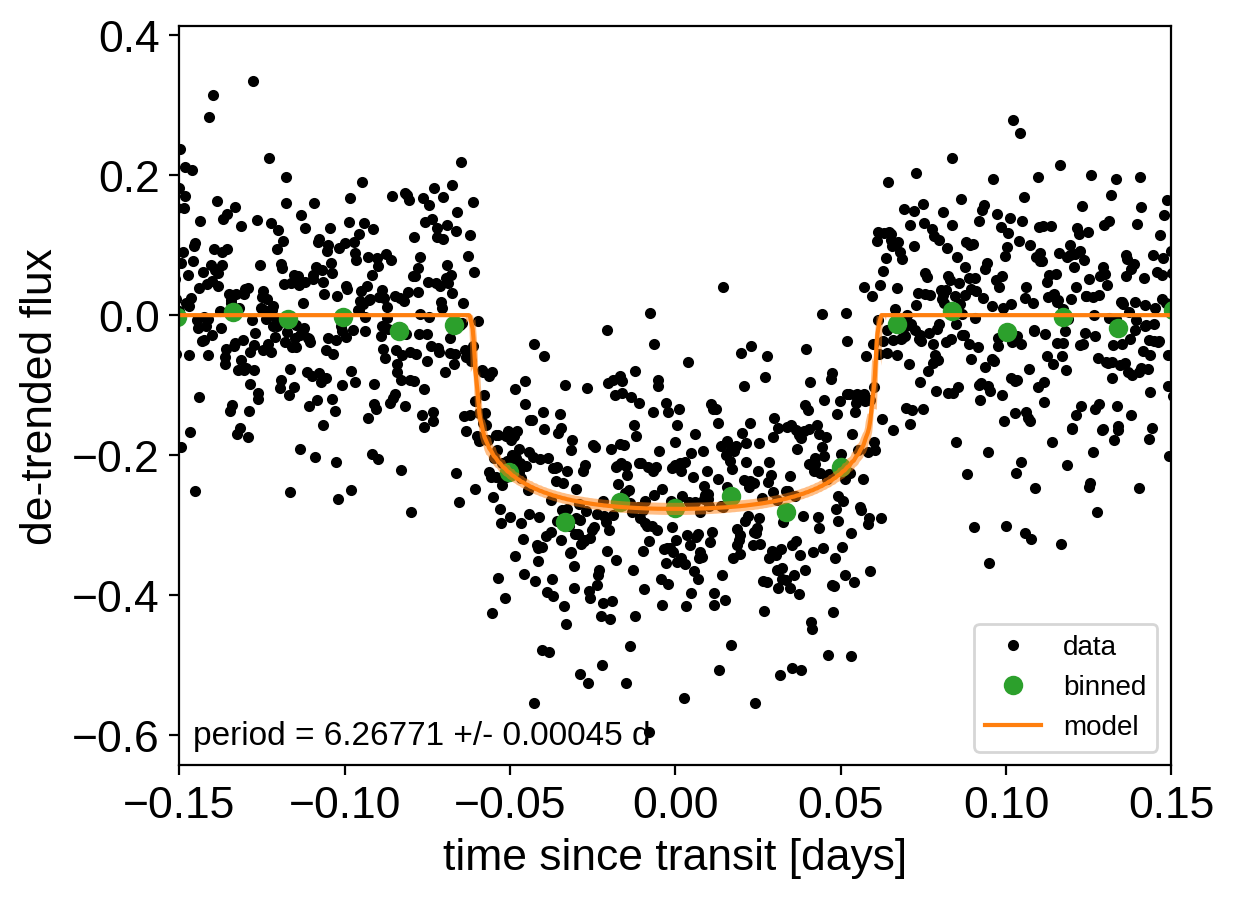

In [16]:
# Compute the GP prediction
gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 50)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y[mask])
denom[num == 0] = 1.0
plt.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, "o", color="C2", label="binned")

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace["light_curves"][:, inds, 0]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(
    x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(trace["period"]), np.std(trace["period"])
)
plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
plt.xlim(-0.15, 0.15);

And a corner plot of some of the key parameters:

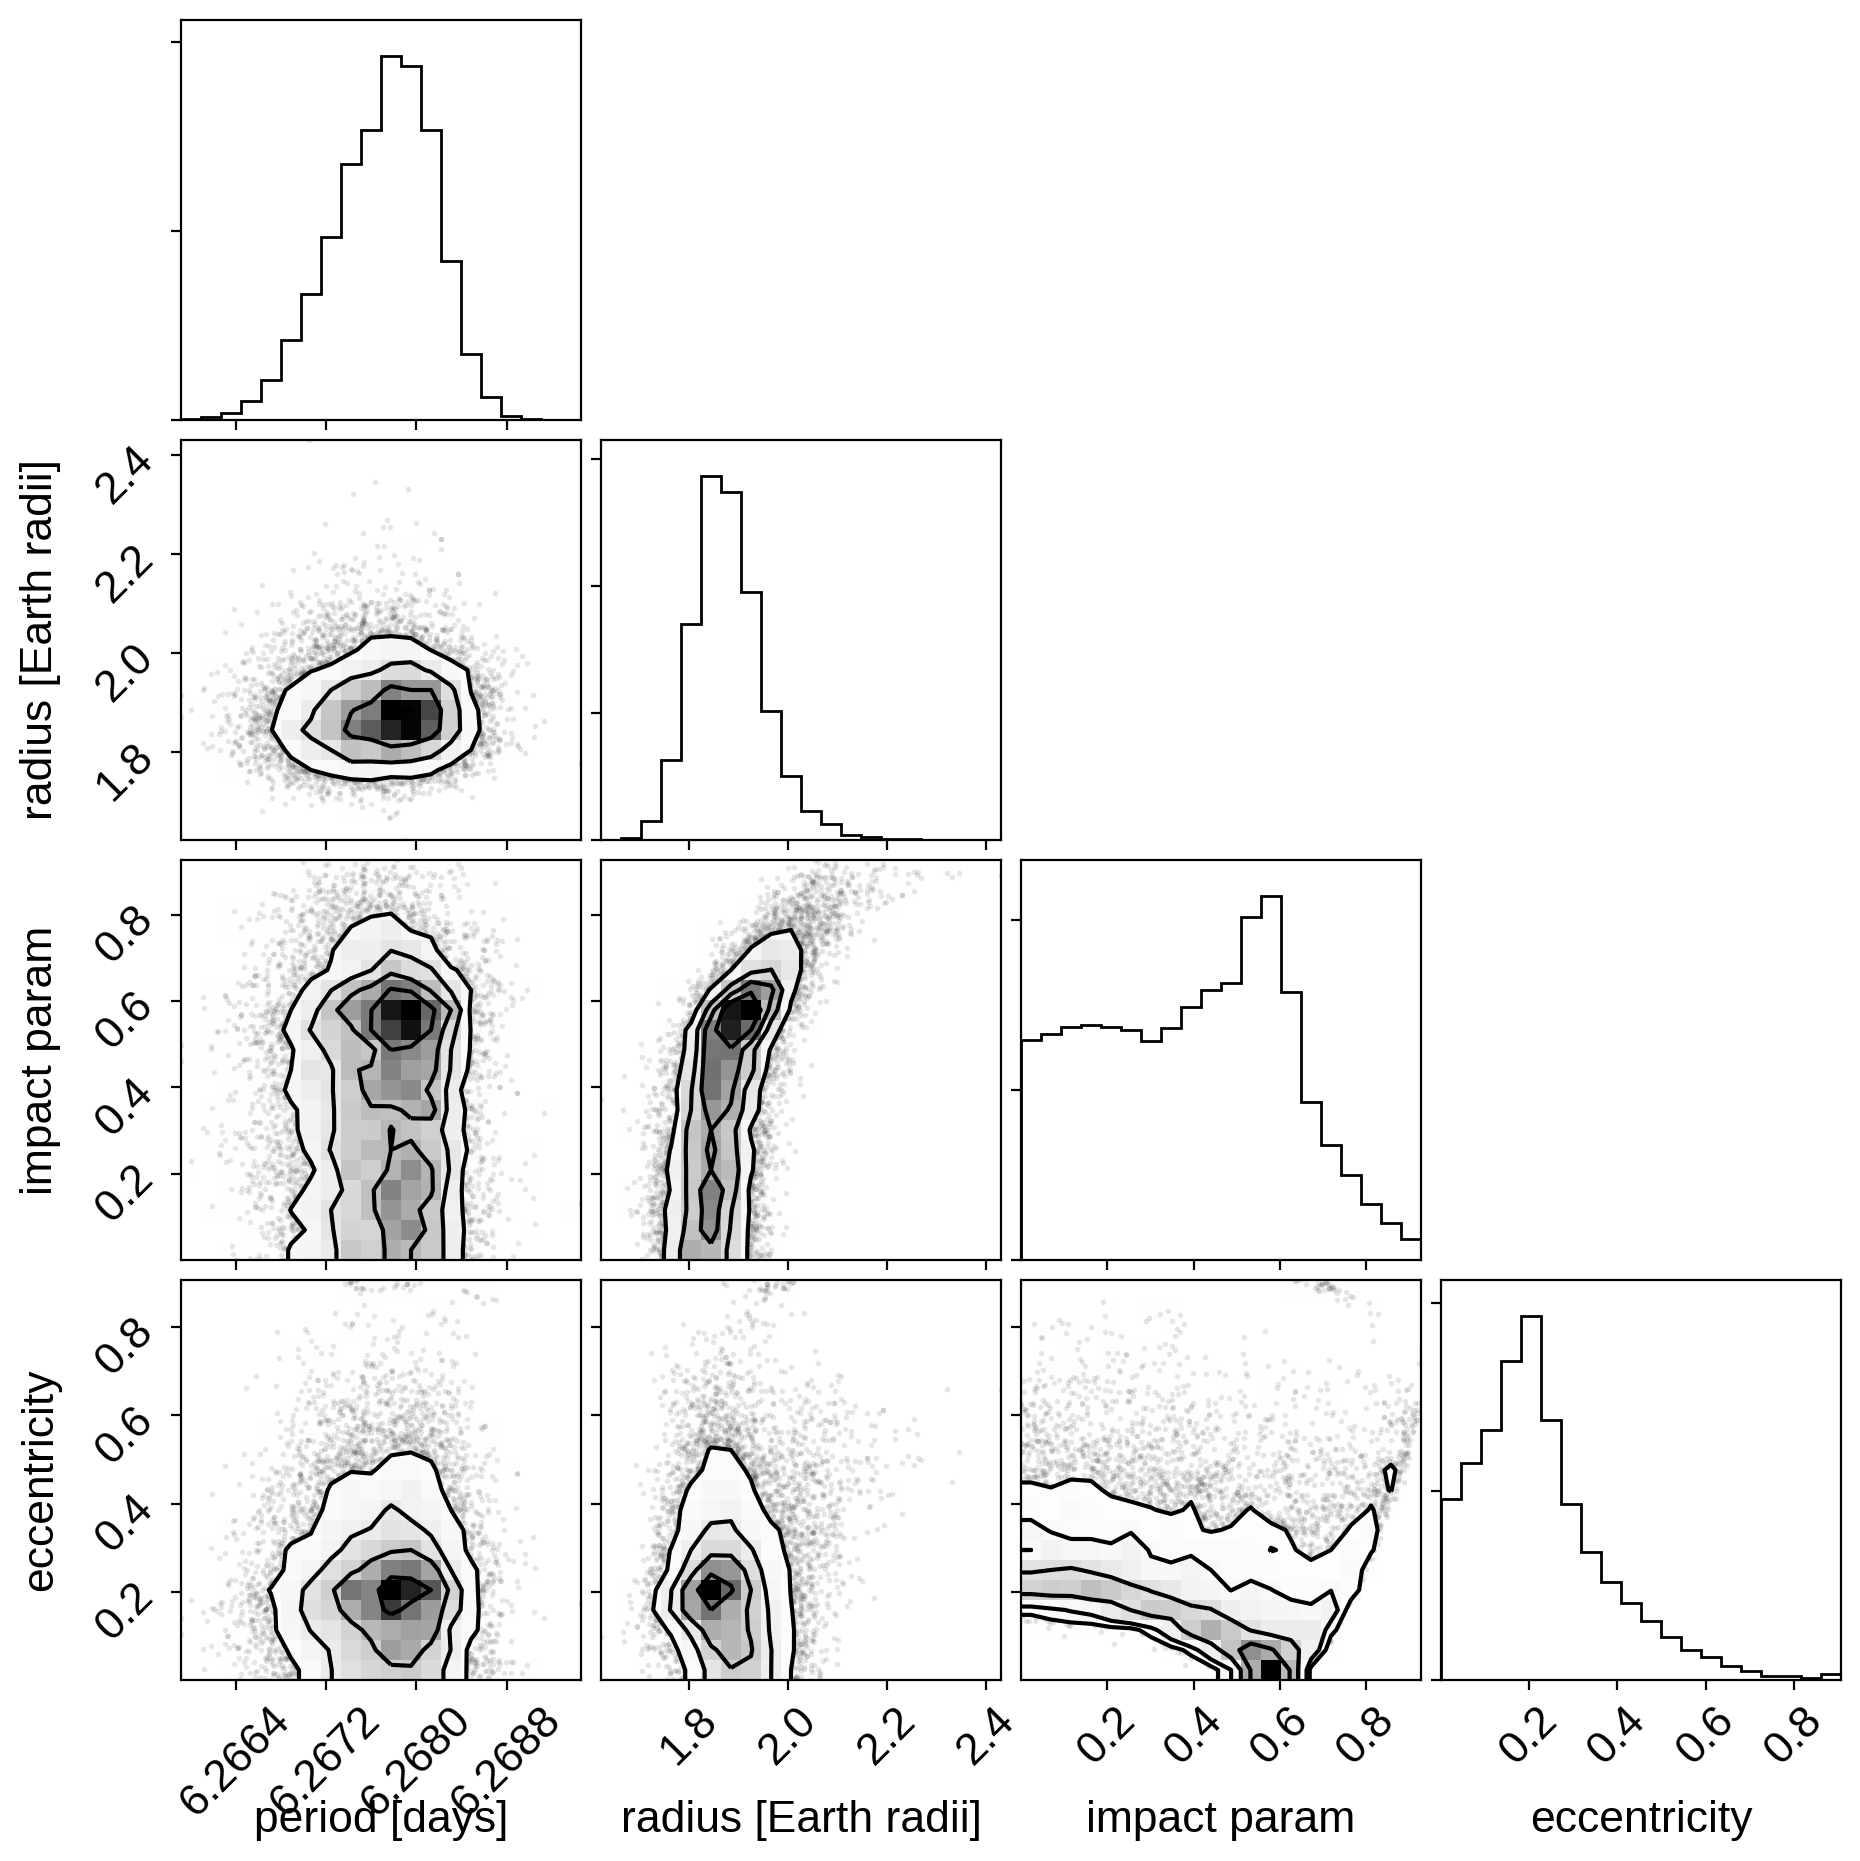

In [17]:
import corner
import astropy.units as u

varnames = ["period", "b", "ecc", "r_pl"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)

# Convert the radius to Earth radii
samples["r_pl"] = (np.array(samples["r_pl"]) * u.R_sun).to(u.R_earth).value

corner.corner(
    samples[["period", "r_pl", "b", "ecc"]],
    labels=["period [days]", "radius [Earth radii]", "impact param", "eccentricity"],
);

These all seem consistent with the previously published values and an earlier inconsistency between this radius measurement and the literature has been resolved by fixing a bug in *exoplanet*.

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [18]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:kipping13b, exoplanet:luger18, exoplanet:pymc3,
exoplanet:theano}.


In [19]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.2},
   month = may,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
